In [1]:
import math
import json
import numpy as np
from collections import Counter

import torch
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import plotly.graph_objects as go

from tqdm import tqdm

from nano_bert.model import BertMix3
from nano_bert.tokenizer import WordTokenizer
torch.manual_seed(114514)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
data = None
with open('data/imdb_train.json') as f:
    data = [json.loads(l) for l in f.readlines()]

In [3]:
test_data = None
with open('data/imdb_test.json') as f:
    test_data = [json.loads(l) for l in f.readlines()]

In [4]:
rawvocab = [] # whole vocab
for d in tqdm(data): 
    rawvocab.append([w.lower() for w in d['text']]) # symbol like '.' is remained
vocab = set() # vocab for words appear more than 2 times(minappear = 2)
minappear = 2
for v in tqdm(rawvocab):
    if rawvocab.count(v) > minappear - 1:
        vocab |= set(v)

100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [00:04<00:00, 5600.82it/s]


In [5]:
def encode_label(label):
    if label == 'pos':
        return 1
    elif label == 'neg':
        return 0
    raise Exception(f'Unknown Label: {label}!')


class IMDBDataloader:
    def __init__(self, data, test_data, tokenizer, label_encoder, batch_size, val_frac=0.2):
        train_data, val_data = train_test_split(data, shuffle=True, random_state=1, test_size=val_frac)

        self.splits = {
            'train': [d['text'] for d in train_data],
            'test': [d['text'] for d in test_data],
            'val': [d['text'] for d in val_data]
        }

        self.labels = {
            'train': [d['label'] for d in train_data],
            'test': [d['label'] for d in test_data],
            'val': [d['label'] for d in val_data]
        }

        self.tokenized = {
            'train': [tokenizer(record).unsqueeze(0) for record in
                      tqdm(self.splits['train'], desc='Train Tokenization',position=0)], # divide different sentences in comments
            'test': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['test'], desc='Test Tokenization',position=0)],
            'val': [tokenizer(record).unsqueeze(0) for record in tqdm(self.splits['val'], desc='Val Tokenization',position=0)],
        }

        self.encoded_labels = {
            'train': [label_encoder(label) for label in tqdm(self.labels['train'], desc='Train Label Encoding',position=0)],
            'test': [label_encoder(label) for label in tqdm(self.labels['test'], desc='Test Label Encoding',position=0)],
            'val': [label_encoder(label) for label in tqdm(self.labels['val'], desc='Val Label Encoding',position=0)],
        }

        self.curr_batch = 0
        self.batch_size = batch_size
        self.iterate_split = None

    def peek(self, split):
        return {
            'input_ids': self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
            'label_ids': self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
        }

    def take(self, split):
        batch = self.splits[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': batch,
            'label_ids': labels,
        }

    def peek_tokenized(self, split):
        return {
            'input_ids': torch.cat(
                self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dim=0),
            'label_ids': torch.tensor(
                self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)],
                dtype=torch.long),
        }

    def peek_index_tokenized(self, index, split):
        return {
            'input_ids': torch.cat(
                [self.tokenized[split][index]],
                dim=0),
            'label_ids': torch.tensor(
                [self.encoded_labels[split][index]],
                dtype=torch.long),
        }

    def peek_index(self, index, split):
        return {
            'input_ids': [self.splits[split][index]],
            'label_ids': [self.labels[split][index]],
        }

    def take_tokenized(self, split):
        batch = self.tokenized[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        labels = self.encoded_labels[split][self.batch_size * self.curr_batch:self.batch_size * (self.curr_batch + 1)]
        self.curr_batch += 1
        return {
            'input_ids': torch.cat(batch, dim=0),
            'label_ids': torch.tensor(labels, dtype=torch.long),
        }

    def get_split(self, split):
        self.iterate_split = split
        return self

    def steps(self, split):
        return len(self.tokenized[split]) // self.batch_size

    def __iter__(self):
        self.reset()
        return self

    def __next__(self):
        if self.batch_size * self.curr_batch < len(self.splits[self.iterate_split]):
            return self.take_tokenized(self.iterate_split)
        else:
            raise StopIteration

    def reset(self):
        self.curr_batch = 0

In [6]:
NUM_CLASS = 2
BATCH_SIZE = 32
MAX_SEQ_LEN = 128
LEARNING_RATE = 1e-4

In [7]:
vocab.discard('.') # '.' is included in taken's vocab enumerate
tokenizer = WordTokenizer(vocab=vocab, max_seq_len=MAX_SEQ_LEN)
tokenizer

Tokenizer[vocab=3665,self.special_tokens=['[MSK]', '[PAD]', '[CLS]', '[SEP]', '[UNK]', '[SOS]', '.'],self.sep=' ',self.max_seq_len=128]

In [8]:
dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE)

Val Label Encoding: 100%|█████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 4000671.50it/s]


In [9]:
bert = BertMix3(
    vocab_size=len(tokenizer.vocab),
    n_layers=2,
    n_heads=1,
    max_seq_len=MAX_SEQ_LEN,
    n_classes=NUM_CLASS,
    n_embed = 4
).to(device)
bert

BertMix3(
  (nano_bert): NanoBERT(
    (embedding): BertEmbeddings(
      (word_embeddings): Embedding(3665, 4)
      (pos_embeddings): Embedding(128, 4)
      (layer_norm): LayerNorm((4,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layers): ModuleList(
        (0-1): 2 x BertLayer(
          (layer_norm1): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
          (self_attention): BertSelfAttention(
            (heads): ModuleList(
              (0): BertAttentionHead(
                (query): Linear(in_features=4, out_features=4, bias=True)
                (key): Linear(in_features=4, out_features=4, bias=True)
                (values): Linear(in_features=4, out_features=4, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
            )
            (proj): Linear(in_features=4, out_features=4, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
count_parameters(bert)

34033

In [12]:
dataloader.steps('train')
dataloader.get_split('train')

In [13]:
import random
def mask_text(cmt, vacab_size): # cmt : a comment
    mps = []
    mcmt = cmt.clone()
    unique_elements, counts = torch.unique(cudata[i], return_counts=True)
    n_sp = len(tokenizer.special_tokens) # number of special_tokens = 7
    m_range = (MAX_SEQ_LEN - counts[0].item()) * 0.15 # range of masking indice
#     print(m_range, counts[0].item())
    while len(mps) < m_range:
        temp = random.randint(0, MAX_SEQ_LEN - 1)
        if mcmt[temp] > n_sp - 1:
            mps.append(temp)
            mcmt[temp] = 0 # set to mask
    temp_m = random.sample(range(0, len(mps) - 1), 2 * int(m_range * 0.1 + 1)) # fetch some masked words to their original value
    half = int(len(temp_m)/2)
    tmps = torch.tensor(mps) # tensorlize mps to get location of masks to be changed
    mcmt[tmps[temp_m[:half]]] = cmt[temp_m[:half]] # 10% percent original
    mcmt[tmps[temp_m[half:]]] = torch.tensor([random.randint(n_sp, vacab_size - 1) for i in range(half)]).to(device) # 10% percent random vocab
    return mps, mcmt


In [14]:
def spit_cmt(cmt): # split  comment into sentences
    bg = torch.where(cmt==5)[0] # begin at '[SOS]'
    ed = torch.where(cmt==6)[0] # end at '.'
    spit = []
    n_st = len(bg) # number of next sentence prediction task in this comment
    for i in range(n_st):
        sts = cmt[bg[i].item():ed[i].item()+1]
        spit.append(sts)
    return spit, n_st
def pad_nsp(nsp, max_seq_len): # add '[CLS]' and padding on given composed 2 sentences in GPU
#     print('len nsp = ', len(nsp))
    return (torch.cat((torch.cat((torch.tensor([0]).to(device), nsp), 0), torch.ones(max_seq_len - len(nsp) - 1).to(device)), 0))
def nsp_gen(spit, n_st, max_seq_len): # generate nsp input      
    nsp = torch.zeros((2 * (n_st - 1), max_seq_len)).to(device)
    if n_st < 3:
        nsp = torch.zeros((1, max_seq_len)).to(device)
#     print(nsp[:10], n_st)
    for id_i in range(n_st - 1):
        nsp[2 * id_i] = pad_nsp(torch.cat((spit[id_i], spit[id_i + 1]), 0), max_seq_len) # a sentence followed by the next
        if n_st > 2:
            id_s = random.randint(0, n_st - 1) # selected id for nsp
            while id_s == id_i + 1 or id_s == id_i: # excluded the next sentence
                id_s = random.randint(0, n_st - 1)
            nsp[2 * id_i + 1] = pad_nsp(torch.cat((spit[id_i], spit[id_s]), 0), max_seq_len) # a sentence not followed by the next
    return nsp.long().to(device)

In [15]:
history_pretrain = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}
history = {
    'train_losses': [],
    'val_losses': [],
    'train_acc': [],
    'val_acc': [],
    'train_f1': [],
    'val_f1': []
}

### pretrain task, 25 min/epoch

In [16]:
optimizer = torch.optim.Adam(bert.parameters(), lr=LEARNING_RATE)
NUM_EPOCHS = 15 # epochs for pretrain task
vacab_size = len(tokenizer.vocab)
for i in range(NUM_EPOCHS):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0

    bert.train()
    for step, batch in enumerate(tqdm(dataloader.get_split('train'), total=dataloader.steps('train'), position=0)):
        loss = 0
        cudata = batch['input_ids'].to(device) # put the dat in the whole batch to gpu
        # MLM part
        for i in range(len(cudata)): # BATCH_SIZE = len(cudata)
            mps, mcmt = mask_text(cudata[i], vacab_size)
            lmps = len(mps)
            _, r_mlm, _ = bert(mcmt.unsqueeze(dim=0)) # (Batch, Seq_Len, len(vocab))
            MCMT = r_mlm[0][mps, :] # fectch the predicted value from masked input
            predm = cudata[i][mps].long() # fectch the real word correspond to the masked input
            for i in range(lmps):
                loss += F.cross_entropy(MCMT.to(device), predm.to(device)) / lmps
        
        # NSP part
        for i in range(len(cudata)): 
            spit, n_st = spit_cmt(cudata[i]) # (Batch, Seq_Len, len(vocab)), number of sentences
            if n_st > 1: # calculate NSP loss if a comment has more than 1 sentence
                predn = torch.tensor([1, 0] * (n_st - 1)).to(device) # label of next/not next composed sentences
                if n_st < 3:
                    predn = torch.tensor([1]).to(device)
                _, _, r_nsp = bert(nsp_gen(spit, n_st, MAX_SEQ_LEN))
    #             print(n_st)
    #             print(r_nsp[:, 0, :].shape, predn.shape)
    #             print(r_nsp[:, 0, :], predn)
                loss +=  F.cross_entropy(r_nsp[:, 0, :], predn)
        print('train_loss:', '%.2f'%loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
    history_pretrain['train_losses'].append(train_loss / dataloader.steps("train"))
    val_loss = 0.0

D:\Anaconda3\envs\311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch: 1


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 288.34


  0%|▏                                                                               | 1/625 [00:07<1:15:22,  7.25s/it]

train_loss: 287.90


  0%|▎                                                                                 | 2/625 [00:09<45:42,  4.40s/it]

train_loss: 288.95


  0%|▍                                                                                 | 3/625 [00:12<36:14,  3.50s/it]

train_loss: 287.67


  1%|▌                                                                                 | 4/625 [00:14<31:54,  3.08s/it]

train_loss: 289.15


  1%|▋                                                                                 | 5/625 [00:16<29:22,  2.84s/it]

train_loss: 286.60


  1%|▊                                                                                 | 6/625 [00:19<27:24,  2.66s/it]

train_loss: 287.79


  1%|▉                                                                                 | 7/625 [00:21<26:41,  2.59s/it]

train_loss: 288.83


  1%|█                                                                                 | 8/625 [00:24<26:19,  2.56s/it]

train_loss: 289.23


  1%|█▏                                                                                | 9/625 [00:26<26:04,  2.54s/it]

train_loss: 288.52


  2%|█▎                                                                               | 10/625 [00:29<25:56,  2.53s/it]

train_loss: 288.76


  2%|█▍                                                                               | 11/625 [00:31<25:43,  2.51s/it]

train_loss: 288.11


  2%|█▌                                                                               | 12/625 [00:34<25:43,  2.52s/it]

train_loss: 287.08


  2%|█▋                                                                               | 13/625 [00:36<25:22,  2.49s/it]

train_loss: 287.29


  2%|█▊                                                                               | 14/625 [00:39<25:28,  2.50s/it]

train_loss: 286.93


  2%|█▉                                                                               | 15/625 [00:41<25:09,  2.48s/it]

train_loss: 289.00


  3%|██                                                                               | 16/625 [00:44<25:02,  2.47s/it]

train_loss: 287.28


  3%|██▏                                                                              | 17/625 [00:46<24:51,  2.45s/it]

train_loss: 287.16


  3%|██▎                                                                              | 18/625 [00:48<24:37,  2.43s/it]

train_loss: 288.35


  3%|██▍                                                                              | 19/625 [00:51<24:45,  2.45s/it]

train_loss: 289.43


  3%|██▌                                                                              | 20/625 [00:53<24:46,  2.46s/it]

train_loss: 289.34


  3%|██▋                                                                              | 21/625 [00:56<24:41,  2.45s/it]

train_loss: 288.22


  4%|██▊                                                                              | 22/625 [00:58<24:38,  2.45s/it]

train_loss: 286.87


  4%|██▉                                                                              | 23/625 [01:01<24:28,  2.44s/it]

train_loss: 288.52


  4%|███                                                                              | 24/625 [01:03<24:32,  2.45s/it]

train_loss: 288.66


  4%|███▏                                                                             | 25/625 [01:05<24:23,  2.44s/it]

train_loss: 287.92


  4%|███▎                                                                             | 26/625 [01:08<24:32,  2.46s/it]

train_loss: 288.22


  4%|███▍                                                                             | 27/625 [01:12<27:43,  2.78s/it]

train_loss: 288.27


  4%|███▋                                                                             | 28/625 [01:14<26:55,  2.71s/it]

train_loss: 288.07


  5%|███▊                                                                             | 29/625 [01:17<26:17,  2.65s/it]

train_loss: 288.06


  5%|███▉                                                                             | 30/625 [01:19<25:46,  2.60s/it]

train_loss: 287.34


  5%|████                                                                             | 31/625 [01:22<25:36,  2.59s/it]

train_loss: 287.52


  5%|████▏                                                                            | 32/625 [01:24<25:16,  2.56s/it]

train_loss: 287.79


  5%|████▎                                                                            | 33/625 [01:27<25:02,  2.54s/it]

train_loss: 286.91


  5%|████▍                                                                            | 34/625 [01:29<24:46,  2.51s/it]

train_loss: 287.95


  6%|████▌                                                                            | 35/625 [01:31<24:30,  2.49s/it]

train_loss: 287.96


  6%|████▋                                                                            | 36/625 [01:34<24:17,  2.48s/it]

train_loss: 288.20


  6%|████▊                                                                            | 37/625 [01:36<24:28,  2.50s/it]

train_loss: 287.63


  6%|████▉                                                                            | 38/625 [01:39<24:15,  2.48s/it]

train_loss: 285.35


  6%|█████                                                                            | 39/625 [01:41<24:15,  2.48s/it]

train_loss: 287.88


  6%|█████▏                                                                           | 40/625 [01:44<24:14,  2.49s/it]

train_loss: 286.61


  7%|█████▎                                                                           | 41/625 [01:46<24:06,  2.48s/it]

train_loss: 288.61


  7%|█████▍                                                                           | 42/625 [01:49<24:10,  2.49s/it]

train_loss: 289.37


  7%|█████▌                                                                           | 43/625 [01:51<24:02,  2.48s/it]

train_loss: 286.89


  7%|█████▋                                                                           | 44/625 [01:54<23:57,  2.47s/it]

train_loss: 288.67


  7%|█████▊                                                                           | 45/625 [01:56<23:42,  2.45s/it]

train_loss: 287.10


  7%|█████▉                                                                           | 46/625 [01:59<23:30,  2.44s/it]

train_loss: 284.60


  8%|██████                                                                           | 47/625 [02:01<23:16,  2.42s/it]

train_loss: 287.27


  8%|██████▏                                                                          | 48/625 [02:03<23:22,  2.43s/it]

train_loss: 288.66


  8%|██████▎                                                                          | 49/625 [02:06<23:20,  2.43s/it]

train_loss: 287.10


  8%|██████▍                                                                          | 50/625 [02:08<23:14,  2.42s/it]

train_loss: 287.20


  8%|██████▌                                                                          | 51/625 [02:11<23:04,  2.41s/it]

train_loss: 287.16


  8%|██████▋                                                                          | 52/625 [02:13<23:12,  2.43s/it]

train_loss: 287.23


  8%|██████▊                                                                          | 53/625 [02:16<23:19,  2.45s/it]

train_loss: 287.00


  9%|██████▉                                                                          | 54/625 [02:18<23:18,  2.45s/it]

train_loss: 287.77


  9%|███████▏                                                                         | 55/625 [02:21<23:29,  2.47s/it]

train_loss: 287.68


  9%|███████▎                                                                         | 56/625 [02:23<23:37,  2.49s/it]

train_loss: 287.16


  9%|███████▍                                                                         | 57/625 [02:26<23:33,  2.49s/it]

train_loss: 287.54


  9%|███████▌                                                                         | 58/625 [02:28<23:22,  2.47s/it]

train_loss: 284.21


  9%|███████▋                                                                         | 59/625 [02:30<23:15,  2.47s/it]

train_loss: 287.32


 10%|███████▊                                                                         | 60/625 [02:33<23:18,  2.48s/it]

train_loss: 288.20


 10%|███████▉                                                                         | 61/625 [02:35<23:21,  2.49s/it]

train_loss: 286.95


 10%|████████                                                                         | 62/625 [02:38<23:14,  2.48s/it]

train_loss: 287.41


 10%|████████▏                                                                        | 63/625 [02:40<23:07,  2.47s/it]

train_loss: 286.21


 10%|████████▎                                                                        | 64/625 [02:43<22:57,  2.46s/it]

train_loss: 286.02


 10%|████████▍                                                                        | 65/625 [02:45<22:58,  2.46s/it]

train_loss: 287.18


 11%|████████▌                                                                        | 66/625 [02:48<23:03,  2.48s/it]

train_loss: 286.72


 11%|████████▋                                                                        | 67/625 [02:50<22:48,  2.45s/it]

train_loss: 286.32


 11%|████████▊                                                                        | 68/625 [02:53<22:44,  2.45s/it]

train_loss: 286.59


 11%|████████▉                                                                        | 69/625 [02:55<22:37,  2.44s/it]

train_loss: 286.87


 11%|█████████                                                                        | 70/625 [02:57<22:33,  2.44s/it]

train_loss: 286.19


 11%|█████████▏                                                                       | 71/625 [03:00<22:35,  2.45s/it]

train_loss: 286.03


 12%|█████████▎                                                                       | 72/625 [03:02<22:36,  2.45s/it]

train_loss: 287.96


 12%|█████████▍                                                                       | 73/625 [03:05<22:33,  2.45s/it]

train_loss: 286.19


 12%|█████████▌                                                                       | 74/625 [03:07<22:41,  2.47s/it]

train_loss: 287.69


 12%|█████████▋                                                                       | 75/625 [03:10<22:39,  2.47s/it]

train_loss: 287.83


 12%|█████████▊                                                                       | 76/625 [03:12<22:40,  2.48s/it]

train_loss: 286.05


 12%|█████████▉                                                                       | 77/625 [03:15<22:33,  2.47s/it]

train_loss: 286.90


 12%|██████████                                                                       | 78/625 [03:17<22:27,  2.46s/it]

train_loss: 287.10


 13%|██████████▏                                                                      | 79/625 [03:20<22:24,  2.46s/it]

train_loss: 285.76


 13%|██████████▎                                                                      | 80/625 [03:22<22:19,  2.46s/it]

train_loss: 285.72


 13%|██████████▍                                                                      | 81/625 [03:25<22:07,  2.44s/it]

train_loss: 286.16


 13%|██████████▋                                                                      | 82/625 [03:27<22:16,  2.46s/it]

train_loss: 287.79


 13%|██████████▊                                                                      | 83/625 [03:30<22:20,  2.47s/it]

train_loss: 286.04


 13%|██████████▉                                                                      | 84/625 [03:32<22:09,  2.46s/it]

train_loss: 285.43


 14%|███████████                                                                      | 85/625 [03:34<22:08,  2.46s/it]

train_loss: 286.17


 14%|███████████▏                                                                     | 86/625 [03:37<21:58,  2.45s/it]

train_loss: 285.41


 14%|███████████▎                                                                     | 87/625 [03:39<21:57,  2.45s/it]

train_loss: 287.34


 14%|███████████▍                                                                     | 88/625 [03:42<21:57,  2.45s/it]

train_loss: 286.05


 14%|███████████▌                                                                     | 89/625 [03:44<21:58,  2.46s/it]

train_loss: 287.71


 14%|███████████▋                                                                     | 90/625 [03:47<21:55,  2.46s/it]

train_loss: 286.61


 15%|███████████▊                                                                     | 91/625 [03:49<21:52,  2.46s/it]

train_loss: 286.42


 15%|███████████▉                                                                     | 92/625 [03:52<21:48,  2.45s/it]

train_loss: 286.82


 15%|████████████                                                                     | 93/625 [03:54<22:03,  2.49s/it]

train_loss: 285.17


 15%|████████████▏                                                                    | 94/625 [03:57<22:02,  2.49s/it]

train_loss: 284.41


 15%|████████████▎                                                                    | 95/625 [03:59<21:52,  2.48s/it]

train_loss: 287.35


 15%|████████████▍                                                                    | 96/625 [04:02<21:52,  2.48s/it]

train_loss: 287.90


 16%|████████████▌                                                                    | 97/625 [04:04<22:01,  2.50s/it]

train_loss: 286.74


 16%|████████████▋                                                                    | 98/625 [04:07<21:55,  2.50s/it]

train_loss: 285.41


 16%|████████████▊                                                                    | 99/625 [04:09<21:51,  2.49s/it]

train_loss: 286.58


 16%|████████████▊                                                                   | 100/625 [04:12<21:49,  2.49s/it]

train_loss: 285.91


 16%|████████████▉                                                                   | 101/625 [04:14<21:55,  2.51s/it]

train_loss: 286.51


 16%|█████████████                                                                   | 102/625 [04:17<22:04,  2.53s/it]

train_loss: 286.87


 16%|█████████████▏                                                                  | 103/625 [04:19<22:02,  2.53s/it]

train_loss: 288.16


 17%|█████████████▎                                                                  | 104/625 [04:22<22:02,  2.54s/it]

train_loss: 286.25


 17%|█████████████▍                                                                  | 105/625 [04:24<21:58,  2.54s/it]

train_loss: 286.46


 17%|█████████████▌                                                                  | 106/625 [04:27<22:01,  2.55s/it]

train_loss: 284.83


 17%|█████████████▋                                                                  | 107/625 [04:29<21:46,  2.52s/it]

train_loss: 285.57


 17%|█████████████▊                                                                  | 108/625 [04:32<21:30,  2.50s/it]

train_loss: 286.16


 17%|█████████████▉                                                                  | 109/625 [04:34<21:21,  2.48s/it]

train_loss: 287.12


 18%|██████████████                                                                  | 110/625 [04:37<21:27,  2.50s/it]

train_loss: 286.67


 18%|██████████████▏                                                                 | 111/625 [04:39<21:26,  2.50s/it]

train_loss: 286.91


 18%|██████████████▎                                                                 | 112/625 [04:42<21:28,  2.51s/it]

train_loss: 287.55


 18%|██████████████▍                                                                 | 113/625 [04:44<21:24,  2.51s/it]

train_loss: 284.65


 18%|██████████████▌                                                                 | 114/625 [04:47<21:23,  2.51s/it]

train_loss: 284.65


 18%|██████████████▋                                                                 | 115/625 [04:49<21:14,  2.50s/it]

train_loss: 285.79


 19%|██████████████▊                                                                 | 116/625 [04:52<21:26,  2.53s/it]

train_loss: 286.87


 19%|██████████████▉                                                                 | 117/625 [04:54<21:17,  2.51s/it]

train_loss: 287.48


 19%|███████████████                                                                 | 118/625 [04:57<21:14,  2.51s/it]

train_loss: 287.36


 19%|███████████████▏                                                                | 119/625 [05:00<21:16,  2.52s/it]

train_loss: 286.12


 19%|███████████████▎                                                                | 120/625 [05:02<21:14,  2.52s/it]

train_loss: 285.99


 19%|███████████████▍                                                                | 121/625 [05:05<21:13,  2.53s/it]

train_loss: 288.19


 20%|███████████████▌                                                                | 122/625 [05:07<21:09,  2.52s/it]

train_loss: 286.53


 20%|███████████████▋                                                                | 123/625 [05:10<21:10,  2.53s/it]

train_loss: 284.87


 20%|███████████████▊                                                                | 124/625 [05:12<20:58,  2.51s/it]

train_loss: 285.16


 20%|████████████████                                                                | 125/625 [05:15<20:56,  2.51s/it]

train_loss: 284.46


 20%|████████████████▏                                                               | 126/625 [05:17<20:44,  2.49s/it]

train_loss: 286.33


 20%|████████████████▎                                                               | 127/625 [05:20<20:38,  2.49s/it]

train_loss: 287.40


 20%|████████████████▍                                                               | 128/625 [05:22<20:52,  2.52s/it]

train_loss: 286.20


 21%|████████████████▌                                                               | 129/625 [05:25<20:54,  2.53s/it]

train_loss: 285.65


 21%|████████████████▋                                                               | 130/625 [05:27<21:01,  2.55s/it]

train_loss: 285.69


 21%|████████████████▊                                                               | 131/625 [05:30<21:02,  2.55s/it]

train_loss: 286.37


 21%|████████████████▉                                                               | 132/625 [05:32<20:56,  2.55s/it]

train_loss: 286.60


 21%|█████████████████                                                               | 133/625 [05:35<20:53,  2.55s/it]

train_loss: 286.09


 21%|█████████████████▏                                                              | 134/625 [05:37<20:47,  2.54s/it]

train_loss: 286.50


 22%|█████████████████▎                                                              | 135/625 [05:40<20:50,  2.55s/it]

train_loss: 286.04


 22%|█████████████████▍                                                              | 136/625 [05:43<20:41,  2.54s/it]

train_loss: 286.56


 22%|█████████████████▌                                                              | 137/625 [05:45<20:31,  2.52s/it]

train_loss: 285.62


 22%|█████████████████▋                                                              | 138/625 [05:48<20:38,  2.54s/it]

train_loss: 285.36


 22%|█████████████████▊                                                              | 139/625 [05:50<20:23,  2.52s/it]

train_loss: 285.28


 22%|█████████████████▉                                                              | 140/625 [05:53<20:15,  2.51s/it]

train_loss: 286.55


 23%|██████████████████                                                              | 141/625 [05:55<20:18,  2.52s/it]

train_loss: 286.30


 23%|██████████████████▏                                                             | 142/625 [05:58<20:13,  2.51s/it]

train_loss: 286.91


 23%|██████████████████▎                                                             | 143/625 [06:00<20:14,  2.52s/it]

train_loss: 285.13


 23%|██████████████████▍                                                             | 144/625 [06:03<20:00,  2.50s/it]

train_loss: 285.55


 23%|██████████████████▌                                                             | 145/625 [06:05<19:53,  2.49s/it]

train_loss: 286.10


 23%|██████████████████▋                                                             | 146/625 [06:08<19:52,  2.49s/it]

train_loss: 284.72


 24%|██████████████████▊                                                             | 147/625 [06:10<19:53,  2.50s/it]

train_loss: 286.58


 24%|██████████████████▉                                                             | 148/625 [06:13<19:51,  2.50s/it]

train_loss: 286.68


 24%|███████████████████                                                             | 149/625 [06:15<19:48,  2.50s/it]

train_loss: 285.51


 24%|███████████████████▏                                                            | 150/625 [06:17<19:37,  2.48s/it]

train_loss: 284.88


 24%|███████████████████▎                                                            | 151/625 [06:20<19:33,  2.48s/it]

train_loss: 285.15


 24%|███████████████████▍                                                            | 152/625 [06:22<19:30,  2.48s/it]

train_loss: 285.84


 24%|███████████████████▌                                                            | 153/625 [06:25<19:32,  2.48s/it]

train_loss: 285.68


 25%|███████████████████▋                                                            | 154/625 [06:27<19:35,  2.50s/it]

train_loss: 285.86


 25%|███████████████████▊                                                            | 155/625 [06:30<19:37,  2.51s/it]

train_loss: 286.10


 25%|███████████████████▉                                                            | 156/625 [06:33<19:39,  2.51s/it]

train_loss: 284.93


 25%|████████████████████                                                            | 157/625 [06:35<19:32,  2.50s/it]

train_loss: 286.51


 25%|████████████████████▏                                                           | 158/625 [06:37<19:26,  2.50s/it]

train_loss: 284.91


 25%|████████████████████▎                                                           | 159/625 [06:40<19:24,  2.50s/it]

train_loss: 287.22


 26%|████████████████████▍                                                           | 160/625 [06:42<19:18,  2.49s/it]

train_loss: 283.79


 26%|████████████████████▌                                                           | 161/625 [06:45<19:03,  2.47s/it]

train_loss: 286.92


 26%|████████████████████▋                                                           | 162/625 [06:47<19:04,  2.47s/it]

train_loss: 285.47


 26%|████████████████████▊                                                           | 163/625 [06:50<19:04,  2.48s/it]

train_loss: 286.58


 26%|████████████████████▉                                                           | 164/625 [06:52<19:06,  2.49s/it]

train_loss: 285.80


 26%|█████████████████████                                                           | 165/625 [06:55<19:08,  2.50s/it]

train_loss: 284.78


 27%|█████████████████████▏                                                          | 166/625 [06:57<19:06,  2.50s/it]

train_loss: 285.41


 27%|█████████████████████▍                                                          | 167/625 [07:00<18:59,  2.49s/it]

train_loss: 284.43


 27%|█████████████████████▌                                                          | 168/625 [07:02<18:51,  2.48s/it]

train_loss: 285.18


 27%|█████████████████████▋                                                          | 169/625 [07:05<18:55,  2.49s/it]

train_loss: 286.46


 27%|█████████████████████▊                                                          | 170/625 [07:07<19:00,  2.51s/it]

train_loss: 284.31


 27%|█████████████████████▉                                                          | 171/625 [07:10<18:50,  2.49s/it]

train_loss: 286.37


 28%|██████████████████████                                                          | 172/625 [07:12<18:53,  2.50s/it]

train_loss: 286.56


 28%|██████████████████████▏                                                         | 173/625 [07:15<18:57,  2.52s/it]

train_loss: 284.14


 28%|██████████████████████▎                                                         | 174/625 [07:17<18:48,  2.50s/it]

train_loss: 286.05


 28%|██████████████████████▍                                                         | 175/625 [07:20<18:54,  2.52s/it]

train_loss: 285.14


 28%|██████████████████████▌                                                         | 176/625 [07:22<18:58,  2.54s/it]

train_loss: 284.92


 28%|██████████████████████▋                                                         | 177/625 [07:25<18:48,  2.52s/it]

train_loss: 284.62


 28%|██████████████████████▊                                                         | 178/625 [07:28<18:50,  2.53s/it]

train_loss: 285.23


 29%|██████████████████████▉                                                         | 179/625 [07:30<18:50,  2.53s/it]

train_loss: 285.77


 29%|███████████████████████                                                         | 180/625 [07:33<18:44,  2.53s/it]

train_loss: 286.09


 29%|███████████████████████▏                                                        | 181/625 [07:35<18:36,  2.51s/it]

train_loss: 285.90


 29%|███████████████████████▎                                                        | 182/625 [07:38<18:45,  2.54s/it]

train_loss: 285.45


 29%|███████████████████████▍                                                        | 183/625 [07:40<18:45,  2.55s/it]

train_loss: 285.76


 29%|███████████████████████▌                                                        | 184/625 [07:43<18:42,  2.55s/it]

train_loss: 284.88


 30%|███████████████████████▋                                                        | 185/625 [07:45<18:29,  2.52s/it]

train_loss: 286.59


 30%|███████████████████████▊                                                        | 186/625 [07:48<18:16,  2.50s/it]

train_loss: 284.95


 30%|███████████████████████▉                                                        | 187/625 [07:50<18:06,  2.48s/it]

train_loss: 286.00


 30%|████████████████████████                                                        | 188/625 [07:53<18:08,  2.49s/it]

train_loss: 285.33


 30%|████████████████████████▏                                                       | 189/625 [07:55<18:06,  2.49s/it]

train_loss: 286.54


 30%|████████████████████████▎                                                       | 190/625 [07:58<17:57,  2.48s/it]

train_loss: 285.36


 31%|████████████████████████▍                                                       | 191/625 [08:00<17:53,  2.47s/it]

train_loss: 285.83


 31%|████████████████████████▌                                                       | 192/625 [08:03<17:50,  2.47s/it]

train_loss: 285.31


 31%|████████████████████████▋                                                       | 193/625 [08:05<17:40,  2.46s/it]

train_loss: 285.26


 31%|████████████████████████▊                                                       | 194/625 [08:07<17:40,  2.46s/it]

train_loss: 284.07


 31%|████████████████████████▉                                                       | 195/625 [08:10<17:25,  2.43s/it]

train_loss: 284.25


 31%|█████████████████████████                                                       | 196/625 [08:12<17:27,  2.44s/it]

train_loss: 285.53


 32%|█████████████████████████▏                                                      | 197/625 [08:15<17:26,  2.45s/it]

train_loss: 285.07


 32%|█████████████████████████▎                                                      | 198/625 [08:17<17:18,  2.43s/it]

train_loss: 285.76


 32%|█████████████████████████▍                                                      | 199/625 [08:20<17:16,  2.43s/it]

train_loss: 284.75


 32%|█████████████████████████▌                                                      | 200/625 [08:22<17:14,  2.43s/it]

train_loss: 283.23


 32%|█████████████████████████▋                                                      | 201/625 [08:24<17:06,  2.42s/it]

train_loss: 284.97


 32%|█████████████████████████▊                                                      | 202/625 [08:27<17:05,  2.42s/it]

train_loss: 284.81


 32%|█████████████████████████▉                                                      | 203/625 [08:29<17:02,  2.42s/it]

train_loss: 286.31


 33%|██████████████████████████                                                      | 204/625 [08:32<17:07,  2.44s/it]

train_loss: 285.43


 33%|██████████████████████████▏                                                     | 205/625 [08:34<17:04,  2.44s/it]

train_loss: 284.82


 33%|██████████████████████████▎                                                     | 206/625 [08:37<16:56,  2.43s/it]

train_loss: 283.76


 33%|██████████████████████████▍                                                     | 207/625 [08:39<16:24,  2.35s/it]

train_loss: 285.85


 33%|██████████████████████████▌                                                     | 208/625 [08:41<16:18,  2.35s/it]

train_loss: 286.00


 33%|██████████████████████████▊                                                     | 209/625 [08:43<16:25,  2.37s/it]

train_loss: 284.82


 34%|██████████████████████████▉                                                     | 210/625 [08:46<16:41,  2.41s/it]

train_loss: 285.34


 34%|███████████████████████████                                                     | 211/625 [08:48<16:43,  2.42s/it]

train_loss: 283.39


 34%|███████████████████████████▏                                                    | 212/625 [08:51<16:32,  2.40s/it]

train_loss: 285.16


 34%|███████████████████████████▎                                                    | 213/625 [08:53<16:45,  2.44s/it]

train_loss: 285.55


 34%|███████████████████████████▍                                                    | 214/625 [08:56<16:42,  2.44s/it]

train_loss: 284.14


 34%|███████████████████████████▌                                                    | 215/625 [08:58<16:40,  2.44s/it]

train_loss: 283.85


 35%|███████████████████████████▋                                                    | 216/625 [09:01<16:34,  2.43s/it]

train_loss: 283.71


 35%|███████████████████████████▊                                                    | 217/625 [09:03<16:29,  2.43s/it]

train_loss: 284.06


 35%|███████████████████████████▉                                                    | 218/625 [09:05<16:32,  2.44s/it]

train_loss: 284.59


 35%|████████████████████████████                                                    | 219/625 [09:08<16:41,  2.47s/it]

train_loss: 286.50


 35%|████████████████████████████▏                                                   | 220/625 [09:10<16:38,  2.47s/it]

train_loss: 283.81


 35%|████████████████████████████▎                                                   | 221/625 [09:13<16:27,  2.44s/it]

train_loss: 283.38


 36%|████████████████████████████▍                                                   | 222/625 [09:15<16:25,  2.45s/it]

train_loss: 284.93


 36%|████████████████████████████▌                                                   | 223/625 [09:18<16:25,  2.45s/it]

train_loss: 285.95


 36%|████████████████████████████▋                                                   | 224/625 [09:20<16:25,  2.46s/it]

train_loss: 283.55


 36%|████████████████████████████▊                                                   | 225/625 [09:23<16:12,  2.43s/it]

train_loss: 285.05


 36%|████████████████████████████▉                                                   | 226/625 [09:25<16:16,  2.45s/it]

train_loss: 284.12


 36%|█████████████████████████████                                                   | 227/625 [09:28<16:20,  2.46s/it]

train_loss: 286.32


 36%|█████████████████████████████▏                                                  | 228/625 [09:30<16:19,  2.47s/it]

train_loss: 284.02


 37%|█████████████████████████████▎                                                  | 229/625 [09:32<15:36,  2.36s/it]

train_loss: 284.93


 37%|█████████████████████████████▍                                                  | 230/625 [09:35<15:33,  2.36s/it]

train_loss: 283.43


 37%|█████████████████████████████▌                                                  | 231/625 [09:37<15:41,  2.39s/it]

train_loss: 283.61


 37%|█████████████████████████████▋                                                  | 232/625 [09:39<15:44,  2.40s/it]

train_loss: 284.48


 37%|█████████████████████████████▊                                                  | 233/625 [09:42<15:41,  2.40s/it]

train_loss: 285.84


 37%|█████████████████████████████▉                                                  | 234/625 [09:44<15:50,  2.43s/it]

train_loss: 284.66


 38%|██████████████████████████████                                                  | 235/625 [09:47<15:54,  2.45s/it]

train_loss: 283.68


 38%|██████████████████████████████▏                                                 | 236/625 [09:49<15:51,  2.45s/it]

train_loss: 284.59


 38%|██████████████████████████████▎                                                 | 237/625 [09:52<15:45,  2.44s/it]

train_loss: 283.73


 38%|██████████████████████████████▍                                                 | 238/625 [09:54<15:40,  2.43s/it]

train_loss: 284.24


 38%|██████████████████████████████▌                                                 | 239/625 [09:56<15:31,  2.41s/it]

train_loss: 284.60


 38%|██████████████████████████████▋                                                 | 240/625 [09:59<15:29,  2.41s/it]

train_loss: 284.54


 39%|██████████████████████████████▊                                                 | 241/625 [10:01<15:30,  2.42s/it]

train_loss: 285.00


 39%|██████████████████████████████▉                                                 | 242/625 [10:04<15:11,  2.38s/it]

train_loss: 282.24


 39%|███████████████████████████████                                                 | 243/625 [10:06<15:05,  2.37s/it]

train_loss: 283.54


 39%|███████████████████████████████▏                                                | 244/625 [10:08<15:02,  2.37s/it]

train_loss: 283.83


 39%|███████████████████████████████▎                                                | 245/625 [10:11<14:55,  2.36s/it]

train_loss: 282.60


 39%|███████████████████████████████▍                                                | 246/625 [10:13<14:52,  2.35s/it]

train_loss: 285.04


 40%|███████████████████████████████▌                                                | 247/625 [10:15<15:05,  2.39s/it]

train_loss: 283.19


 40%|███████████████████████████████▋                                                | 248/625 [10:18<14:29,  2.31s/it]

train_loss: 283.70


 40%|███████████████████████████████▊                                                | 249/625 [10:20<14:29,  2.31s/it]

train_loss: 284.93


 40%|████████████████████████████████                                                | 250/625 [10:22<14:38,  2.34s/it]

train_loss: 284.48


 40%|████████████████████████████████▏                                               | 251/625 [10:25<14:43,  2.36s/it]

train_loss: 285.16


 40%|████████████████████████████████▎                                               | 252/625 [10:27<14:44,  2.37s/it]

train_loss: 284.36


 40%|████████████████████████████████▍                                               | 253/625 [10:30<14:48,  2.39s/it]

train_loss: 285.04


 41%|████████████████████████████████▌                                               | 254/625 [10:32<14:57,  2.42s/it]

train_loss: 284.95


 41%|████████████████████████████████▋                                               | 255/625 [10:35<15:01,  2.44s/it]

train_loss: 285.52


 41%|████████████████████████████████▊                                               | 256/625 [10:37<14:50,  2.41s/it]

train_loss: 283.53


 41%|████████████████████████████████▉                                               | 257/625 [10:39<14:34,  2.38s/it]

train_loss: 282.90


 41%|█████████████████████████████████                                               | 258/625 [10:41<14:23,  2.35s/it]

train_loss: 284.53


 41%|█████████████████████████████████▏                                              | 259/625 [10:44<14:29,  2.38s/it]

train_loss: 282.59


 42%|█████████████████████████████████▎                                              | 260/625 [10:46<14:31,  2.39s/it]

train_loss: 282.96


 42%|█████████████████████████████████▍                                              | 261/625 [10:49<14:13,  2.34s/it]

train_loss: 283.62


 42%|█████████████████████████████████▌                                              | 262/625 [10:51<14:23,  2.38s/it]

train_loss: 283.46


 42%|█████████████████████████████████▋                                              | 263/625 [10:53<14:14,  2.36s/it]

train_loss: 284.89


 42%|█████████████████████████████████▊                                              | 264/625 [10:56<14:17,  2.37s/it]

train_loss: 284.51


 42%|█████████████████████████████████▉                                              | 265/625 [10:58<14:16,  2.38s/it]

train_loss: 283.52


 43%|██████████████████████████████████                                              | 266/625 [11:00<14:07,  2.36s/it]

train_loss: 284.96


 43%|██████████████████████████████████▏                                             | 267/625 [11:03<14:19,  2.40s/it]

train_loss: 284.64


 43%|██████████████████████████████████▎                                             | 268/625 [11:05<14:24,  2.42s/it]

train_loss: 284.79


 43%|██████████████████████████████████▍                                             | 269/625 [11:08<14:26,  2.43s/it]

train_loss: 284.75


 43%|██████████████████████████████████▌                                             | 270/625 [11:10<14:26,  2.44s/it]

train_loss: 284.63


 43%|██████████████████████████████████▋                                             | 271/625 [11:13<14:42,  2.49s/it]

train_loss: 283.82


 44%|██████████████████████████████████▊                                             | 272/625 [11:15<14:37,  2.48s/it]

train_loss: 285.07


 44%|██████████████████████████████████▉                                             | 273/625 [11:18<14:35,  2.49s/it]

train_loss: 284.09


 44%|███████████████████████████████████                                             | 274/625 [11:20<14:18,  2.45s/it]

train_loss: 283.00


 44%|███████████████████████████████████▏                                            | 275/625 [11:23<14:14,  2.44s/it]

train_loss: 283.62


 44%|███████████████████████████████████▎                                            | 276/625 [11:25<14:09,  2.44s/it]

train_loss: 284.79


 44%|███████████████████████████████████▍                                            | 277/625 [11:28<14:05,  2.43s/it]

train_loss: 284.88


 44%|███████████████████████████████████▌                                            | 278/625 [11:30<14:05,  2.44s/it]

train_loss: 284.09


 45%|███████████████████████████████████▋                                            | 279/625 [11:32<13:54,  2.41s/it]

train_loss: 284.55


 45%|███████████████████████████████████▊                                            | 280/625 [11:35<14:04,  2.45s/it]

train_loss: 282.64


 45%|███████████████████████████████████▉                                            | 281/625 [11:37<14:00,  2.44s/it]

train_loss: 284.56


 45%|████████████████████████████████████                                            | 282/625 [11:40<14:08,  2.47s/it]

train_loss: 284.08


 45%|████████████████████████████████████▏                                           | 283/625 [11:42<14:08,  2.48s/it]

train_loss: 283.90


 45%|████████████████████████████████████▎                                           | 284/625 [11:45<14:10,  2.50s/it]

train_loss: 283.77


 46%|████████████████████████████████████▍                                           | 285/625 [11:47<14:12,  2.51s/it]

train_loss: 283.68


 46%|████████████████████████████████████▌                                           | 286/625 [11:50<14:02,  2.48s/it]

train_loss: 284.34


 46%|████████████████████████████████████▋                                           | 287/625 [11:52<13:54,  2.47s/it]

train_loss: 283.76


 46%|████████████████████████████████████▊                                           | 288/625 [11:55<13:46,  2.45s/it]

train_loss: 282.58


 46%|████████████████████████████████████▉                                           | 289/625 [11:57<13:38,  2.44s/it]

train_loss: 284.02


 46%|█████████████████████████████████████                                           | 290/625 [11:59<13:32,  2.42s/it]

train_loss: 283.68


 47%|█████████████████████████████████████▏                                          | 291/625 [12:02<13:31,  2.43s/it]

train_loss: 282.37


 47%|█████████████████████████████████████▍                                          | 292/625 [12:04<13:29,  2.43s/it]

train_loss: 283.79


 47%|█████████████████████████████████████▌                                          | 293/625 [12:07<13:22,  2.42s/it]

train_loss: 284.23


 47%|█████████████████████████████████████▋                                          | 294/625 [12:09<13:21,  2.42s/it]

train_loss: 282.38


 47%|█████████████████████████████████████▊                                          | 295/625 [12:12<13:24,  2.44s/it]

train_loss: 284.74


 47%|█████████████████████████████████████▉                                          | 296/625 [12:14<13:21,  2.44s/it]

train_loss: 282.98


 48%|██████████████████████████████████████                                          | 297/625 [12:17<13:17,  2.43s/it]

train_loss: 282.43


 48%|██████████████████████████████████████▏                                         | 298/625 [12:19<13:13,  2.43s/it]

train_loss: 283.01


 48%|██████████████████████████████████████▎                                         | 299/625 [12:21<13:08,  2.42s/it]

train_loss: 283.51


 48%|██████████████████████████████████████▍                                         | 300/625 [12:24<13:07,  2.42s/it]

train_loss: 285.08


 48%|██████████████████████████████████████▌                                         | 301/625 [12:26<13:07,  2.43s/it]

train_loss: 284.90


 48%|██████████████████████████████████████▋                                         | 302/625 [12:29<13:02,  2.42s/it]

train_loss: 282.97


 48%|██████████████████████████████████████▊                                         | 303/625 [12:31<12:54,  2.41s/it]

train_loss: 282.77


 49%|██████████████████████████████████████▉                                         | 304/625 [12:33<12:54,  2.41s/it]

train_loss: 282.77


 49%|███████████████████████████████████████                                         | 305/625 [12:36<12:50,  2.41s/it]

train_loss: 283.16


 49%|███████████████████████████████████████▏                                        | 306/625 [12:38<12:52,  2.42s/it]

train_loss: 283.95


 49%|███████████████████████████████████████▎                                        | 307/625 [12:41<12:54,  2.44s/it]

train_loss: 285.23


 49%|███████████████████████████████████████▍                                        | 308/625 [12:43<12:54,  2.44s/it]

train_loss: 284.34


 49%|███████████████████████████████████████▌                                        | 309/625 [12:46<12:51,  2.44s/it]

train_loss: 281.88


 50%|███████████████████████████████████████▋                                        | 310/625 [12:48<12:41,  2.42s/it]

train_loss: 283.06


 50%|███████████████████████████████████████▊                                        | 311/625 [12:50<12:46,  2.44s/it]

train_loss: 282.82


 50%|███████████████████████████████████████▉                                        | 312/625 [12:53<12:44,  2.44s/it]

train_loss: 282.59


 50%|████████████████████████████████████████                                        | 313/625 [12:55<12:38,  2.43s/it]

train_loss: 283.59


 50%|████████████████████████████████████████▏                                       | 314/625 [12:58<12:31,  2.42s/it]

train_loss: 284.53


 50%|████████████████████████████████████████▎                                       | 315/625 [13:00<12:29,  2.42s/it]

train_loss: 285.11


 51%|████████████████████████████████████████▍                                       | 316/625 [13:03<12:31,  2.43s/it]

train_loss: 283.43


 51%|████████████████████████████████████████▌                                       | 317/625 [13:05<12:35,  2.45s/it]

train_loss: 282.87


 51%|████████████████████████████████████████▋                                       | 318/625 [13:08<12:35,  2.46s/it]

train_loss: 282.86


 51%|████████████████████████████████████████▊                                       | 319/625 [13:10<12:31,  2.46s/it]

train_loss: 283.97


 51%|████████████████████████████████████████▉                                       | 320/625 [13:12<12:26,  2.45s/it]

train_loss: 282.89


 51%|█████████████████████████████████████████                                       | 321/625 [13:15<12:22,  2.44s/it]

train_loss: 281.62


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:17<12:25,  2.46s/it]

train_loss: 283.79


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:20<12:18,  2.45s/it]

train_loss: 284.28


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:22<12:20,  2.46s/it]

train_loss: 283.73


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:25<12:18,  2.46s/it]

train_loss: 282.29


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:27<12:15,  2.46s/it]

train_loss: 283.75


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:30<12:02,  2.42s/it]

train_loss: 283.21


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:32<12:03,  2.44s/it]

train_loss: 284.49


 53%|██████████████████████████████████████████                                      | 329/625 [13:35<12:06,  2.45s/it]

train_loss: 284.16


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:37<12:05,  2.46s/it]

train_loss: 284.59


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:39<11:58,  2.45s/it]

train_loss: 284.34


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:42<11:56,  2.44s/it]

train_loss: 283.99


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:44<12:00,  2.47s/it]

train_loss: 282.98


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:47<11:53,  2.45s/it]

train_loss: 283.20


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:49<11:50,  2.45s/it]

train_loss: 283.25


 54%|███████████████████████████████████████████                                     | 336/625 [13:52<11:51,  2.46s/it]

train_loss: 284.24


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:54<11:45,  2.45s/it]

train_loss: 283.20


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:57<11:41,  2.44s/it]

train_loss: 282.71


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:59<11:37,  2.44s/it]

train_loss: 282.87


 54%|███████████████████████████████████████████▌                                    | 340/625 [14:01<11:40,  2.46s/it]

train_loss: 281.61


 55%|███████████████████████████████████████████▋                                    | 341/625 [14:04<11:27,  2.42s/it]

train_loss: 283.45


 55%|███████████████████████████████████████████▊                                    | 342/625 [14:06<11:23,  2.41s/it]

train_loss: 284.29


 55%|███████████████████████████████████████████▉                                    | 343/625 [14:09<11:23,  2.42s/it]

train_loss: 282.17


 55%|████████████████████████████████████████████                                    | 344/625 [14:11<11:21,  2.42s/it]

train_loss: 282.72


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:14<11:17,  2.42s/it]

train_loss: 283.41


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:16<11:22,  2.45s/it]

train_loss: 283.07


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:18<11:16,  2.44s/it]

train_loss: 283.85


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:21<11:15,  2.44s/it]

train_loss: 282.14


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:23<11:13,  2.44s/it]

train_loss: 282.44


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:26<11:10,  2.44s/it]

train_loss: 282.01


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:28<11:05,  2.43s/it]

train_loss: 283.19


 56%|█████████████████████████████████████████████                                   | 352/625 [14:30<10:51,  2.39s/it]

train_loss: 282.84


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:33<10:50,  2.39s/it]

train_loss: 283.03


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:35<10:52,  2.41s/it]

train_loss: 282.49


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:38<10:47,  2.40s/it]

train_loss: 283.14


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:40<10:46,  2.40s/it]

train_loss: 282.87


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:43<10:46,  2.41s/it]

train_loss: 283.65


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:45<10:38,  2.39s/it]

train_loss: 282.40


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:47<10:40,  2.41s/it]

train_loss: 282.30


 58%|██████████████████████████████████████████████                                  | 360/625 [14:50<10:36,  2.40s/it]

train_loss: 283.81


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:52<10:36,  2.41s/it]

train_loss: 283.04


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:55<10:38,  2.43s/it]

train_loss: 283.05


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:57<10:34,  2.42s/it]

train_loss: 281.75


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:59<10:29,  2.41s/it]

train_loss: 283.10


 58%|██████████████████████████████████████████████▋                                 | 365/625 [15:02<10:26,  2.41s/it]

train_loss: 283.57


 59%|██████████████████████████████████████████████▊                                 | 366/625 [15:04<10:25,  2.41s/it]

train_loss: 283.24


 59%|██████████████████████████████████████████████▉                                 | 367/625 [15:07<10:24,  2.42s/it]

train_loss: 282.48


 59%|███████████████████████████████████████████████                                 | 368/625 [15:09<10:25,  2.43s/it]

train_loss: 283.49


 59%|███████████████████████████████████████████████▏                                | 369/625 [15:12<10:21,  2.43s/it]

train_loss: 282.57


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:14<10:17,  2.42s/it]

train_loss: 283.47


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:16<10:09,  2.40s/it]

train_loss: 282.60


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:19<10:09,  2.41s/it]

train_loss: 282.73


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:21<10:11,  2.43s/it]

train_loss: 280.44


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:24<10:06,  2.42s/it]

train_loss: 282.66


 60%|████████████████████████████████████████████████                                | 375/625 [15:26<10:07,  2.43s/it]

train_loss: 281.68


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:29<10:11,  2.46s/it]

train_loss: 282.70


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:31<10:09,  2.46s/it]

train_loss: 281.78


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:33<10:08,  2.46s/it]

train_loss: 282.62


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:36<10:11,  2.49s/it]

train_loss: 282.47


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:39<10:08,  2.48s/it]

train_loss: 281.99


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:41<10:04,  2.48s/it]

train_loss: 282.94


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:44<10:06,  2.49s/it]

train_loss: 281.19


 61%|█████████████████████████████████████████████████                               | 383/625 [15:46<09:59,  2.48s/it]

train_loss: 282.17


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:48<09:59,  2.49s/it]

train_loss: 284.00


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:51<09:52,  2.47s/it]

train_loss: 281.74


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:53<09:44,  2.45s/it]

train_loss: 281.61


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:56<09:38,  2.43s/it]

train_loss: 281.63


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:58<09:39,  2.44s/it]

train_loss: 282.90


 62%|█████████████████████████████████████████████████▊                              | 389/625 [16:01<09:35,  2.44s/it]

train_loss: 282.18


 62%|█████████████████████████████████████████████████▉                              | 390/625 [16:03<09:31,  2.43s/it]

train_loss: 283.07


 63%|██████████████████████████████████████████████████                              | 391/625 [16:05<09:31,  2.44s/it]

train_loss: 283.01


 63%|██████████████████████████████████████████████████▏                             | 392/625 [16:08<09:29,  2.44s/it]

train_loss: 281.96


 63%|██████████████████████████████████████████████████▎                             | 393/625 [16:10<09:25,  2.44s/it]

train_loss: 282.28


 63%|██████████████████████████████████████████████████▍                             | 394/625 [16:13<09:23,  2.44s/it]

train_loss: 283.09


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:15<09:26,  2.46s/it]

train_loss: 283.54


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:18<09:22,  2.46s/it]

train_loss: 283.18


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:20<09:17,  2.45s/it]

train_loss: 284.02


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:23<09:13,  2.44s/it]

train_loss: 282.41


 64%|███████████████████████████████████████████████████                             | 399/625 [16:25<09:05,  2.41s/it]

train_loss: 281.92


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:27<09:05,  2.42s/it]

train_loss: 283.27


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:30<09:04,  2.43s/it]

train_loss: 282.07


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:32<09:02,  2.43s/it]

train_loss: 281.63


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:35<09:00,  2.44s/it]

train_loss: 281.85


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:37<08:57,  2.43s/it]

train_loss: 281.52


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:40<08:55,  2.44s/it]

train_loss: 280.86


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:42<08:52,  2.43s/it]

train_loss: 281.78


 65%|████████████████████████████████████████████████████                            | 407/625 [16:44<08:48,  2.42s/it]

train_loss: 283.61


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:47<08:49,  2.44s/it]

train_loss: 282.84


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:49<08:49,  2.45s/it]

train_loss: 282.73


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:52<08:48,  2.46s/it]

train_loss: 280.83


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:54<08:46,  2.46s/it]

train_loss: 283.73


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:57<08:43,  2.46s/it]

train_loss: 282.99


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:59<08:43,  2.47s/it]

train_loss: 280.45


 66%|████████████████████████████████████████████████████▉                           | 414/625 [17:02<08:35,  2.44s/it]

train_loss: 282.82


 66%|█████████████████████████████████████████████████████                           | 415/625 [17:04<08:31,  2.44s/it]

train_loss: 280.50


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [17:06<08:22,  2.40s/it]

train_loss: 283.48


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [17:09<08:22,  2.42s/it]

train_loss: 282.97


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [17:11<08:22,  2.43s/it]

train_loss: 282.17


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:14<08:23,  2.45s/it]

train_loss: 281.86


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:16<08:23,  2.45s/it]

train_loss: 279.88


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:19<08:14,  2.42s/it]

train_loss: 281.82


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:21<08:14,  2.44s/it]

train_loss: 281.83


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:24<08:18,  2.47s/it]

train_loss: 280.94


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:26<08:15,  2.46s/it]

train_loss: 280.63


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:28<08:10,  2.45s/it]

train_loss: 280.80


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:31<08:07,  2.45s/it]

train_loss: 281.16


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:33<08:11,  2.48s/it]

train_loss: 280.11


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:36<08:07,  2.47s/it]

train_loss: 282.19


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:38<08:08,  2.49s/it]

train_loss: 281.93


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:41<08:07,  2.50s/it]

train_loss: 280.80


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:43<08:02,  2.49s/it]

train_loss: 281.91


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:46<07:59,  2.49s/it]

train_loss: 281.87


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:48<07:58,  2.49s/it]

train_loss: 282.21


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:51<07:53,  2.48s/it]

train_loss: 281.59


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:53<07:49,  2.47s/it]

train_loss: 282.37


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:56<07:46,  2.47s/it]

train_loss: 280.97


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:58<07:45,  2.48s/it]

train_loss: 281.24


 70%|████████████████████████████████████████████████████████                        | 438/625 [18:01<07:40,  2.46s/it]

train_loss: 280.28


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [18:03<07:32,  2.43s/it]

train_loss: 282.28


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [18:06<07:33,  2.45s/it]

train_loss: 282.01


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [18:08<07:31,  2.45s/it]

train_loss: 281.60


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [18:10<07:29,  2.45s/it]

train_loss: 280.52


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [18:13<07:24,  2.44s/it]

train_loss: 280.66


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:15<07:22,  2.44s/it]

train_loss: 281.06


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:18<07:17,  2.43s/it]

train_loss: 280.65


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:20<07:09,  2.40s/it]

train_loss: 280.90


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:23<07:10,  2.42s/it]

train_loss: 281.65


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:25<07:09,  2.43s/it]

train_loss: 281.43


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:27<07:03,  2.41s/it]

train_loss: 281.72


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:30<07:03,  2.42s/it]

train_loss: 281.22


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:32<07:01,  2.42s/it]

train_loss: 282.11


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:35<07:01,  2.44s/it]

train_loss: 279.69


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:37<06:58,  2.43s/it]

train_loss: 281.75


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:40<06:53,  2.42s/it]

train_loss: 281.70


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:42<06:51,  2.42s/it]

train_loss: 279.72


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:44<06:49,  2.42s/it]

train_loss: 282.53


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:47<06:48,  2.43s/it]

train_loss: 282.14


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:49<06:48,  2.45s/it]

train_loss: 281.16


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:52<06:42,  2.43s/it]

train_loss: 281.31


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:54<06:40,  2.43s/it]

train_loss: 281.09


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:56<06:35,  2.41s/it]

train_loss: 279.70


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:59<06:37,  2.44s/it]

train_loss: 280.89


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [19:01<06:34,  2.43s/it]

train_loss: 281.41


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [19:04<06:31,  2.43s/it]

train_loss: 280.19


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [19:06<06:27,  2.42s/it]

train_loss: 280.46


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [19:09<06:22,  2.41s/it]

train_loss: 282.03


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [19:11<06:21,  2.42s/it]

train_loss: 282.63


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:14<06:21,  2.43s/it]

train_loss: 280.42


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:16<06:19,  2.43s/it]

train_loss: 282.04


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:18<06:15,  2.43s/it]

train_loss: 282.40


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:21<06:14,  2.43s/it]

train_loss: 280.73


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:23<06:14,  2.45s/it]

train_loss: 280.25


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:26<06:11,  2.44s/it]

train_loss: 280.40


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:28<06:08,  2.44s/it]

train_loss: 281.28


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:31<06:06,  2.44s/it]

train_loss: 282.45


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:33<06:05,  2.45s/it]

train_loss: 282.33


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:36<06:05,  2.47s/it]

train_loss: 280.80


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:38<06:02,  2.47s/it]

train_loss: 280.80


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:41<06:02,  2.48s/it]

train_loss: 279.94


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:43<05:58,  2.47s/it]

train_loss: 281.16


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:45<05:53,  2.46s/it]

train_loss: 280.65


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:48<05:51,  2.46s/it]

train_loss: 279.69


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:50<05:49,  2.46s/it]

train_loss: 279.12


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:53<05:46,  2.45s/it]

train_loss: 280.97


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:55<05:43,  2.45s/it]

train_loss: 280.54


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:58<05:39,  2.44s/it]

train_loss: 280.37


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [20:00<05:34,  2.42s/it]

train_loss: 280.33


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [20:02<05:32,  2.43s/it]

train_loss: 280.82


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [20:05<05:31,  2.44s/it]

train_loss: 280.93


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [20:07<05:28,  2.43s/it]

train_loss: 281.09


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [20:10<05:25,  2.43s/it]

train_loss: 281.58


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [20:12<05:21,  2.42s/it]

train_loss: 280.56


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:15<05:17,  2.41s/it]

train_loss: 279.62


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:17<05:14,  2.40s/it]

train_loss: 281.39


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:19<05:16,  2.44s/it]

train_loss: 280.95


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:22<05:14,  2.44s/it]

train_loss: 279.45


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:24<05:12,  2.44s/it]

train_loss: 279.99


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:27<05:09,  2.44s/it]

train_loss: 280.72


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:29<05:05,  2.43s/it]

train_loss: 281.63


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:32<05:03,  2.43s/it]

train_loss: 279.80


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:34<05:00,  2.42s/it]

train_loss: 278.55


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:36<04:53,  2.39s/it]

train_loss: 279.48


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:39<04:48,  2.36s/it]

train_loss: 279.81


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:41<04:47,  2.37s/it]

train_loss: 280.26


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:43<04:45,  2.38s/it]

train_loss: 281.99


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:46<04:44,  2.39s/it]

train_loss: 280.32


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:48<04:42,  2.39s/it]

train_loss: 280.54


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:51<04:40,  2.40s/it]

train_loss: 279.98


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:53<04:37,  2.39s/it]

train_loss: 279.90


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:55<04:36,  2.40s/it]

train_loss: 280.54


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:58<04:35,  2.42s/it]

train_loss: 281.41


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [21:00<04:33,  2.42s/it]

train_loss: 279.23


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [21:03<04:30,  2.42s/it]

train_loss: 279.64


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [21:05<04:27,  2.41s/it]

train_loss: 279.87


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [21:08<04:24,  2.40s/it]

train_loss: 279.72


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [21:10<04:21,  2.40s/it]

train_loss: 279.18


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [21:12<04:18,  2.39s/it]

train_loss: 280.04


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:15<04:14,  2.38s/it]

train_loss: 279.74


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:17<04:11,  2.37s/it]

train_loss: 280.30


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:19<04:08,  2.37s/it]

train_loss: 279.75


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:22<04:06,  2.37s/it]

train_loss: 279.86


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:24<04:07,  2.40s/it]

train_loss: 278.60


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:27<04:06,  2.41s/it]

train_loss: 280.02


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:29<04:05,  2.43s/it]

train_loss: 280.30


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:32<04:04,  2.45s/it]

train_loss: 279.74


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:34<04:02,  2.45s/it]

train_loss: 279.35


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:37<03:59,  2.45s/it]

train_loss: 278.87


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:39<03:58,  2.46s/it]

train_loss: 278.78


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:41<03:55,  2.45s/it]

train_loss: 278.89


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:44<03:51,  2.43s/it]

train_loss: 279.80


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:46<03:49,  2.44s/it]

train_loss: 279.37


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:49<03:47,  2.45s/it]

train_loss: 280.46


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:51<03:45,  2.45s/it]

train_loss: 277.53


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:54<03:41,  2.43s/it]

train_loss: 279.81


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:56<03:40,  2.45s/it]

train_loss: 278.88


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:58<03:35,  2.42s/it]

train_loss: 278.76


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [22:01<03:33,  2.43s/it]

train_loss: 279.12


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [22:03<03:30,  2.42s/it]

train_loss: 279.26


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [22:06<03:28,  2.43s/it]

train_loss: 278.41


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [22:08<03:25,  2.42s/it]

train_loss: 278.98


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [22:11<03:23,  2.42s/it]

train_loss: 279.23


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:13<03:21,  2.43s/it]

train_loss: 280.61


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:16<03:20,  2.45s/it]

train_loss: 279.65


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:18<03:17,  2.44s/it]

train_loss: 280.07


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:20<03:15,  2.44s/it]

train_loss: 278.69


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:23<03:11,  2.42s/it]

train_loss: 279.67


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:25<03:08,  2.42s/it]

train_loss: 278.84


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:28<03:06,  2.42s/it]

train_loss: 279.34


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:30<03:03,  2.41s/it]

train_loss: 280.35


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:32<03:00,  2.40s/it]

train_loss: 278.73


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:35<02:58,  2.41s/it]

train_loss: 279.57


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:37<02:57,  2.43s/it]

train_loss: 280.23


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:40<02:53,  2.41s/it]

train_loss: 279.98


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:42<02:51,  2.41s/it]

train_loss: 278.08


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:44<02:49,  2.42s/it]

train_loss: 279.93


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:47<02:46,  2.42s/it]

train_loss: 279.39


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:49<02:44,  2.41s/it]

train_loss: 278.31


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:52<02:41,  2.41s/it]

train_loss: 279.18


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:54<02:39,  2.42s/it]

train_loss: 278.63


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:56<02:35,  2.39s/it]

train_loss: 281.40


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:59<02:33,  2.40s/it]

train_loss: 280.82


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [23:01<02:32,  2.41s/it]

train_loss: 278.13


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [23:04<02:30,  2.43s/it]

train_loss: 278.28


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [23:06<02:27,  2.42s/it]

train_loss: 278.20


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [23:09<02:24,  2.42s/it]

train_loss: 278.64


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [23:11<02:22,  2.41s/it]

train_loss: 279.93


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:13<02:19,  2.41s/it]

train_loss: 277.32


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:16<02:16,  2.40s/it]

train_loss: 278.43


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:18<02:14,  2.41s/it]

train_loss: 280.04


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:21<02:12,  2.41s/it]

train_loss: 278.43


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:23<02:12,  2.45s/it]

train_loss: 278.08


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:26<02:08,  2.43s/it]

train_loss: 280.04


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:28<02:06,  2.43s/it]

train_loss: 278.56


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:30<02:03,  2.43s/it]

train_loss: 278.61


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:33<02:00,  2.42s/it]

train_loss: 279.21


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:35<01:59,  2.43s/it]

train_loss: 280.06


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:38<01:57,  2.45s/it]

train_loss: 278.60


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:40<01:55,  2.45s/it]

train_loss: 279.44


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:43<01:52,  2.45s/it]

train_loss: 277.03


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:45<01:49,  2.44s/it]

train_loss: 279.84


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:48<01:47,  2.44s/it]

train_loss: 279.73


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:50<01:45,  2.45s/it]

train_loss: 279.37


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:52<01:42,  2.45s/it]

train_loss: 278.25


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:55<01:40,  2.45s/it]

train_loss: 278.53


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:57<01:38,  2.46s/it]

train_loss: 279.55


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [24:01<01:48,  2.79s/it]

train_loss: 279.36


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [24:03<01:41,  2.68s/it]

train_loss: 279.19


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [24:06<01:36,  2.60s/it]

train_loss: 277.81


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [24:08<01:31,  2.53s/it]

train_loss: 277.29


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [24:11<01:28,  2.52s/it]

train_loss: 279.61


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [24:13<01:25,  2.50s/it]

train_loss: 278.57


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:16<01:22,  2.50s/it]

train_loss: 278.50


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:18<01:18,  2.46s/it]

train_loss: 277.17


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:20<01:16,  2.45s/it]

train_loss: 279.76


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:23<01:13,  2.45s/it]

train_loss: 278.49


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:25<01:10,  2.43s/it]

train_loss: 278.78


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:28<01:07,  2.43s/it]

train_loss: 277.70


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:30<01:05,  2.41s/it]

train_loss: 278.82


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:33<01:03,  2.43s/it]

train_loss: 279.23


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:35<01:00,  2.43s/it]

train_loss: 278.45


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:37<00:58,  2.43s/it]

train_loss: 278.37


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:40<00:56,  2.44s/it]

train_loss: 278.24


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:42<00:53,  2.43s/it]

train_loss: 277.57


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:45<00:51,  2.43s/it]

train_loss: 276.97


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:47<00:48,  2.43s/it]

train_loss: 277.98


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:50<00:46,  2.46s/it]

train_loss: 277.91


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:52<00:44,  2.46s/it]

train_loss: 277.84


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:55<00:41,  2.45s/it]

train_loss: 278.56


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:57<00:39,  2.45s/it]

train_loss: 279.47


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:59<00:36,  2.45s/it]

train_loss: 278.14


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [25:02<00:34,  2.44s/it]

train_loss: 279.04


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [25:04<00:31,  2.43s/it]

train_loss: 278.82


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [25:07<00:29,  2.44s/it]

train_loss: 277.20


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [25:09<00:26,  2.43s/it]

train_loss: 277.36


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [25:12<00:24,  2.44s/it]

train_loss: 278.26


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:14<00:21,  2.42s/it]

train_loss: 278.05


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:16<00:19,  2.42s/it]

train_loss: 278.56


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:19<00:16,  2.42s/it]

train_loss: 279.42


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:21<00:14,  2.45s/it]

train_loss: 279.81


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:24<00:12,  2.45s/it]

train_loss: 277.36


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:26<00:09,  2.45s/it]

train_loss: 278.48


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:29<00:07,  2.45s/it]

train_loss: 277.47


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:31<00:04,  2.45s/it]

train_loss: 277.11


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:33<00:02,  2.42s/it]

train_loss: 279.80


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:36<00:00,  2.46s/it]


Epoch: 2


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 277.85


  0%|▏                                                                                 | 1/625 [00:02<26:01,  2.50s/it]

train_loss: 276.72


  0%|▎                                                                                 | 2/625 [00:04<25:36,  2.47s/it]

train_loss: 278.85


  0%|▍                                                                                 | 3/625 [00:07<25:33,  2.47s/it]

train_loss: 277.47


  1%|▌                                                                                 | 4/625 [00:09<25:32,  2.47s/it]

train_loss: 275.52


  1%|▋                                                                                 | 5/625 [00:12<25:40,  2.48s/it]

train_loss: 277.09


  1%|▊                                                                                 | 6/625 [00:14<25:37,  2.48s/it]

train_loss: 278.19


  1%|▉                                                                                 | 7/625 [00:17<25:31,  2.48s/it]

train_loss: 278.92


  1%|█                                                                                 | 8/625 [00:19<25:26,  2.47s/it]

train_loss: 278.30


  1%|█▏                                                                                | 9/625 [00:22<25:17,  2.46s/it]

train_loss: 276.60


  2%|█▎                                                                               | 10/625 [00:24<25:20,  2.47s/it]

train_loss: 277.58


  2%|█▍                                                                               | 11/625 [00:27<25:10,  2.46s/it]

train_loss: 277.54


  2%|█▌                                                                               | 12/625 [00:29<25:16,  2.47s/it]

train_loss: 276.92


  2%|█▋                                                                               | 13/625 [00:32<24:56,  2.45s/it]

train_loss: 277.74


  2%|█▊                                                                               | 14/625 [00:34<25:07,  2.47s/it]

train_loss: 276.04


  2%|█▉                                                                               | 15/625 [00:37<24:57,  2.46s/it]

train_loss: 278.07


  3%|██                                                                               | 16/625 [00:39<24:52,  2.45s/it]

train_loss: 277.40


  3%|██▏                                                                              | 17/625 [00:41<24:41,  2.44s/it]

train_loss: 275.18


  3%|██▎                                                                              | 18/625 [00:44<24:25,  2.41s/it]

train_loss: 278.29


  3%|██▍                                                                              | 19/625 [00:46<24:38,  2.44s/it]

train_loss: 278.66


  3%|██▌                                                                              | 20/625 [00:49<24:41,  2.45s/it]

train_loss: 276.89


  3%|██▋                                                                              | 21/625 [00:51<24:37,  2.45s/it]

train_loss: 276.79


  4%|██▊                                                                              | 22/625 [00:54<24:35,  2.45s/it]

train_loss: 275.14


  4%|██▉                                                                              | 23/625 [00:56<24:25,  2.43s/it]

train_loss: 277.52


  4%|███                                                                              | 24/625 [00:58<24:21,  2.43s/it]

train_loss: 278.19


  4%|███▏                                                                             | 25/625 [01:01<24:25,  2.44s/it]

train_loss: 278.47


  4%|███▎                                                                             | 26/625 [01:03<24:30,  2.45s/it]

train_loss: 278.36


  4%|███▍                                                                             | 27/625 [01:06<24:19,  2.44s/it]

train_loss: 278.25


  4%|███▋                                                                             | 28/625 [01:08<24:31,  2.46s/it]

train_loss: 276.09


  5%|███▊                                                                             | 29/625 [01:11<24:34,  2.47s/it]

train_loss: 277.02


  5%|███▉                                                                             | 30/625 [01:13<24:32,  2.48s/it]

train_loss: 275.83


  5%|████                                                                             | 31/625 [01:16<24:23,  2.46s/it]

train_loss: 277.07


  5%|████▏                                                                            | 32/625 [01:18<24:11,  2.45s/it]

train_loss: 276.22


  5%|████▎                                                                            | 33/625 [01:21<24:04,  2.44s/it]

train_loss: 276.38


  5%|████▍                                                                            | 34/625 [01:23<23:53,  2.43s/it]

train_loss: 275.81


  6%|████▌                                                                            | 35/625 [01:25<23:49,  2.42s/it]

train_loss: 276.71


  6%|████▋                                                                            | 36/625 [01:28<23:42,  2.42s/it]

train_loss: 277.85


  6%|████▊                                                                            | 37/625 [01:30<23:58,  2.45s/it]

train_loss: 276.11


  6%|████▉                                                                            | 38/625 [01:33<23:48,  2.43s/it]

train_loss: 275.67


  6%|█████                                                                            | 39/625 [01:35<23:39,  2.42s/it]

train_loss: 278.85


  6%|█████▏                                                                           | 40/625 [01:37<23:40,  2.43s/it]

train_loss: 277.03


  7%|█████▎                                                                           | 41/625 [01:40<23:35,  2.42s/it]

train_loss: 277.25


  7%|█████▍                                                                           | 42/625 [01:42<23:41,  2.44s/it]

train_loss: 276.07


  7%|█████▌                                                                           | 43/625 [01:45<23:44,  2.45s/it]

train_loss: 277.17


  7%|█████▋                                                                           | 44/625 [01:47<23:49,  2.46s/it]

train_loss: 277.41


  7%|█████▊                                                                           | 45/625 [01:50<23:37,  2.44s/it]

train_loss: 275.49


  7%|█████▉                                                                           | 46/625 [01:52<23:32,  2.44s/it]

train_loss: 273.59


  8%|██████                                                                           | 47/625 [01:54<23:07,  2.40s/it]

train_loss: 276.57


  8%|██████▏                                                                          | 48/625 [01:57<23:19,  2.43s/it]

train_loss: 275.39


  8%|██████▎                                                                          | 49/625 [01:59<23:28,  2.45s/it]

train_loss: 276.06


  8%|██████▍                                                                          | 50/625 [02:02<23:22,  2.44s/it]

train_loss: 275.33


  8%|██████▌                                                                          | 51/625 [02:04<23:15,  2.43s/it]

train_loss: 276.95


  8%|██████▋                                                                          | 52/625 [02:07<23:25,  2.45s/it]

train_loss: 276.86


  8%|██████▊                                                                          | 53/625 [02:09<23:30,  2.47s/it]

train_loss: 277.47


  9%|██████▉                                                                          | 54/625 [02:12<23:36,  2.48s/it]

train_loss: 276.92


  9%|███████▏                                                                         | 55/625 [02:14<23:34,  2.48s/it]

train_loss: 276.63


  9%|███████▎                                                                         | 56/625 [02:17<23:29,  2.48s/it]

train_loss: 274.85


  9%|███████▍                                                                         | 57/625 [02:19<23:15,  2.46s/it]

train_loss: 274.38


  9%|███████▌                                                                         | 58/625 [02:22<22:59,  2.43s/it]

train_loss: 273.73


  9%|███████▋                                                                         | 59/625 [02:24<22:53,  2.43s/it]

train_loss: 274.99


 10%|███████▊                                                                         | 60/625 [02:26<22:50,  2.43s/it]

train_loss: 274.55


 10%|███████▉                                                                         | 61/625 [02:29<22:51,  2.43s/it]

train_loss: 277.50


 10%|████████                                                                         | 62/625 [02:31<22:49,  2.43s/it]

train_loss: 277.28


 10%|████████▏                                                                        | 63/625 [02:34<22:38,  2.42s/it]

train_loss: 274.71


 10%|████████▎                                                                        | 64/625 [02:36<22:30,  2.41s/it]

train_loss: 276.14


 10%|████████▍                                                                        | 65/625 [02:38<22:29,  2.41s/it]

train_loss: 276.52


 11%|████████▌                                                                        | 66/625 [02:41<22:35,  2.42s/it]

train_loss: 275.47


 11%|████████▋                                                                        | 67/625 [02:43<22:25,  2.41s/it]

train_loss: 276.56


 11%|████████▊                                                                        | 68/625 [02:46<22:26,  2.42s/it]

train_loss: 276.53


 11%|████████▉                                                                        | 69/625 [02:48<22:21,  2.41s/it]

train_loss: 275.27


 11%|█████████                                                                        | 70/625 [02:50<22:13,  2.40s/it]

train_loss: 274.85


 11%|█████████▏                                                                       | 71/625 [02:53<22:20,  2.42s/it]

train_loss: 275.14


 12%|█████████▎                                                                       | 72/625 [02:55<22:23,  2.43s/it]

train_loss: 275.93


 12%|█████████▍                                                                       | 73/625 [02:58<22:15,  2.42s/it]

train_loss: 275.56


 12%|█████████▌                                                                       | 74/625 [03:00<22:21,  2.43s/it]

train_loss: 274.59


 12%|█████████▋                                                                       | 75/625 [03:03<22:17,  2.43s/it]

train_loss: 276.83


 12%|█████████▊                                                                       | 76/625 [03:05<22:16,  2.44s/it]

train_loss: 273.86


 12%|█████████▉                                                                       | 77/625 [03:08<22:13,  2.43s/it]

train_loss: 275.22


 12%|██████████                                                                       | 78/625 [03:10<22:12,  2.44s/it]

train_loss: 276.25


 13%|██████████▏                                                                      | 79/625 [03:12<22:07,  2.43s/it]

train_loss: 276.21


 13%|██████████▎                                                                      | 80/625 [03:15<21:59,  2.42s/it]

train_loss: 273.29


 13%|██████████▍                                                                      | 81/625 [03:17<21:50,  2.41s/it]

train_loss: 275.71


 13%|██████████▋                                                                      | 82/625 [03:20<21:56,  2.42s/it]

train_loss: 277.19


 13%|██████████▊                                                                      | 83/625 [03:22<21:55,  2.43s/it]

train_loss: 273.97


 13%|██████████▉                                                                      | 84/625 [03:24<21:43,  2.41s/it]

train_loss: 274.55


 14%|███████████                                                                      | 85/625 [03:27<21:44,  2.42s/it]

train_loss: 273.64


 14%|███████████▏                                                                     | 86/625 [03:29<21:36,  2.41s/it]

train_loss: 273.18


 14%|███████████▎                                                                     | 87/625 [03:32<21:34,  2.41s/it]

train_loss: 276.02


 14%|███████████▍                                                                     | 88/625 [03:34<21:32,  2.41s/it]

train_loss: 275.20


 14%|███████████▌                                                                     | 89/625 [03:36<21:25,  2.40s/it]

train_loss: 276.28


 14%|███████████▋                                                                     | 90/625 [03:39<21:27,  2.41s/it]

train_loss: 275.25


 15%|███████████▊                                                                     | 91/625 [03:41<21:25,  2.41s/it]

train_loss: 276.74


 15%|███████████▉                                                                     | 92/625 [03:44<21:17,  2.40s/it]

train_loss: 274.29


 15%|████████████                                                                     | 93/625 [03:46<21:25,  2.42s/it]

train_loss: 273.22


 15%|████████████▏                                                                    | 94/625 [03:49<21:27,  2.43s/it]

train_loss: 271.08


 15%|████████████▎                                                                    | 95/625 [03:51<21:17,  2.41s/it]

train_loss: 274.96


 15%|████████████▍                                                                    | 96/625 [03:53<21:20,  2.42s/it]

train_loss: 275.37


 16%|████████████▌                                                                    | 97/625 [03:56<21:29,  2.44s/it]

train_loss: 273.20


 16%|████████████▋                                                                    | 98/625 [03:58<21:20,  2.43s/it]

train_loss: 271.99


 16%|████████████▊                                                                    | 99/625 [04:01<21:11,  2.42s/it]

train_loss: 275.07


 16%|████████████▊                                                                   | 100/625 [04:03<21:11,  2.42s/it]

train_loss: 274.32


 16%|████████████▉                                                                   | 101/625 [04:06<21:17,  2.44s/it]

train_loss: 275.41


 16%|█████████████                                                                   | 102/625 [04:08<21:26,  2.46s/it]

train_loss: 276.22


 16%|█████████████▏                                                                  | 103/625 [04:11<21:22,  2.46s/it]

train_loss: 275.49


 17%|█████████████▎                                                                  | 104/625 [04:13<21:25,  2.47s/it]

train_loss: 276.00


 17%|█████████████▍                                                                  | 105/625 [04:15<21:18,  2.46s/it]

train_loss: 274.82


 17%|█████████████▌                                                                  | 106/625 [04:18<21:20,  2.47s/it]

train_loss: 273.05


 17%|█████████████▋                                                                  | 107/625 [04:20<21:07,  2.45s/it]

train_loss: 273.22


 17%|█████████████▊                                                                  | 108/625 [04:23<20:54,  2.43s/it]

train_loss: 274.36


 17%|█████████████▉                                                                  | 109/625 [04:25<20:47,  2.42s/it]

train_loss: 275.19


 18%|██████████████                                                                  | 110/625 [04:28<20:52,  2.43s/it]

train_loss: 274.49


 18%|██████████████▏                                                                 | 111/625 [04:30<20:50,  2.43s/it]

train_loss: 274.81


 18%|██████████████▎                                                                 | 112/625 [04:32<20:45,  2.43s/it]

train_loss: 275.26


 18%|██████████████▍                                                                 | 113/625 [04:35<20:44,  2.43s/it]

train_loss: 274.01


 18%|██████████████▌                                                                 | 114/625 [04:37<20:42,  2.43s/it]

train_loss: 274.06


 18%|██████████████▋                                                                 | 115/625 [04:40<20:32,  2.42s/it]

train_loss: 273.49


 19%|██████████████▊                                                                 | 116/625 [04:42<20:30,  2.42s/it]

train_loss: 274.45


 19%|██████████████▉                                                                 | 117/625 [04:45<20:25,  2.41s/it]

train_loss: 275.83


 19%|███████████████                                                                 | 118/625 [04:47<20:26,  2.42s/it]

train_loss: 276.42


 19%|███████████████▏                                                                | 119/625 [04:49<20:27,  2.43s/it]

train_loss: 275.43


 19%|███████████████▎                                                                | 120/625 [04:52<20:35,  2.45s/it]

train_loss: 275.35


 19%|███████████████▍                                                                | 121/625 [04:54<20:32,  2.44s/it]

train_loss: 274.87


 20%|███████████████▌                                                                | 122/625 [04:57<20:22,  2.43s/it]

train_loss: 274.87


 20%|███████████████▋                                                                | 123/625 [04:59<20:20,  2.43s/it]

train_loss: 273.29


 20%|███████████████▊                                                                | 124/625 [05:02<20:11,  2.42s/it]

train_loss: 274.67


 20%|████████████████                                                                | 125/625 [05:04<20:06,  2.41s/it]

train_loss: 271.64


 20%|████████████████▏                                                               | 126/625 [05:06<19:58,  2.40s/it]

train_loss: 277.51


 20%|████████████████▎                                                               | 127/625 [05:09<19:49,  2.39s/it]

train_loss: 274.85


 20%|████████████████▍                                                               | 128/625 [05:11<19:53,  2.40s/it]

train_loss: 274.50


 21%|████████████████▌                                                               | 129/625 [05:14<19:52,  2.40s/it]

train_loss: 274.67


 21%|████████████████▋                                                               | 130/625 [05:16<19:57,  2.42s/it]

train_loss: 270.02


 21%|████████████████▊                                                               | 131/625 [05:18<19:59,  2.43s/it]

train_loss: 273.08


 21%|████████████████▉                                                               | 132/625 [05:21<19:53,  2.42s/it]

train_loss: 274.95


 21%|█████████████████                                                               | 133/625 [05:23<19:46,  2.41s/it]

train_loss: 271.16


 21%|█████████████████▏                                                              | 134/625 [05:26<19:43,  2.41s/it]

train_loss: 275.70


 22%|█████████████████▎                                                              | 135/625 [05:28<19:49,  2.43s/it]

train_loss: 272.13


 22%|█████████████████▍                                                              | 136/625 [05:30<19:35,  2.40s/it]

train_loss: 275.08


 22%|█████████████████▌                                                              | 137/625 [05:33<19:29,  2.40s/it]

train_loss: 275.89


 22%|█████████████████▋                                                              | 138/625 [05:35<19:32,  2.41s/it]

train_loss: 273.73


 22%|█████████████████▊                                                              | 139/625 [05:38<19:18,  2.38s/it]

train_loss: 272.06


 22%|█████████████████▉                                                              | 140/625 [05:40<19:20,  2.39s/it]

train_loss: 274.22


 23%|██████████████████                                                              | 141/625 [05:42<19:28,  2.41s/it]

train_loss: 274.72


 23%|██████████████████▏                                                             | 142/625 [05:45<19:33,  2.43s/it]

train_loss: 273.98


 23%|██████████████████▎                                                             | 143/625 [05:47<19:35,  2.44s/it]

train_loss: 274.60


 23%|██████████████████▍                                                             | 144/625 [05:50<19:20,  2.41s/it]

train_loss: 275.40


 23%|██████████████████▌                                                             | 145/625 [05:52<19:20,  2.42s/it]

train_loss: 276.22


 23%|██████████████████▋                                                             | 146/625 [05:54<18:54,  2.37s/it]

train_loss: 271.35


 24%|██████████████████▊                                                             | 147/625 [05:57<19:11,  2.41s/it]

train_loss: 274.86


 24%|██████████████████▉                                                             | 148/625 [05:59<19:19,  2.43s/it]

train_loss: 273.48


 24%|███████████████████                                                             | 149/625 [06:02<19:29,  2.46s/it]

train_loss: 273.10


 24%|███████████████████▏                                                            | 150/625 [06:04<19:23,  2.45s/it]

train_loss: 271.19


 24%|███████████████████▎                                                            | 151/625 [06:07<19:26,  2.46s/it]

train_loss: 271.79


 24%|███████████████████▍                                                            | 152/625 [06:09<19:21,  2.45s/it]

train_loss: 272.04


 24%|███████████████████▌                                                            | 153/625 [06:12<19:24,  2.47s/it]

train_loss: 274.33


 25%|███████████████████▋                                                            | 154/625 [06:14<19:26,  2.48s/it]

train_loss: 275.65


 25%|███████████████████▊                                                            | 155/625 [06:17<19:25,  2.48s/it]

train_loss: 271.67


 25%|███████████████████▉                                                            | 156/625 [06:19<19:26,  2.49s/it]

train_loss: 274.76


 25%|████████████████████                                                            | 157/625 [06:22<19:17,  2.47s/it]

train_loss: 273.47


 25%|████████████████████▏                                                           | 158/625 [06:24<19:06,  2.45s/it]

train_loss: 270.66


 25%|████████████████████▎                                                           | 159/625 [06:27<19:01,  2.45s/it]

train_loss: 272.08


 26%|████████████████████▍                                                           | 160/625 [06:29<18:57,  2.45s/it]

train_loss: 270.96


 26%|████████████████████▌                                                           | 161/625 [06:31<18:40,  2.41s/it]

train_loss: 273.36


 26%|████████████████████▋                                                           | 162/625 [06:34<18:43,  2.43s/it]

train_loss: 271.83


 26%|████████████████████▊                                                           | 163/625 [06:36<18:41,  2.43s/it]

train_loss: 273.23


 26%|████████████████████▉                                                           | 164/625 [06:39<18:42,  2.44s/it]

train_loss: 271.67


 26%|█████████████████████                                                           | 165/625 [06:41<18:43,  2.44s/it]

train_loss: 273.33


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:43,  2.45s/it]

train_loss: 273.47


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:39,  2.44s/it]

train_loss: 273.12


 27%|█████████████████████▌                                                          | 168/625 [06:48<18:30,  2.43s/it]

train_loss: 272.11


 27%|█████████████████████▋                                                          | 169/625 [06:51<18:32,  2.44s/it]

train_loss: 272.35


 27%|█████████████████████▊                                                          | 170/625 [06:53<18:37,  2.46s/it]

train_loss: 270.99


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:27,  2.44s/it]

train_loss: 274.13


 28%|██████████████████████                                                          | 172/625 [06:58<18:28,  2.45s/it]

train_loss: 273.75


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:29,  2.45s/it]

train_loss: 271.71


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:26,  2.45s/it]

train_loss: 271.01


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:28,  2.46s/it]

train_loss: 271.42


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:33,  2.48s/it]

train_loss: 274.03


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:21,  2.46s/it]

train_loss: 272.56


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:22,  2.47s/it]

train_loss: 273.30


 29%|██████████████████████▉                                                         | 179/625 [07:16<18:19,  2.46s/it]

train_loss: 270.52


 29%|███████████████████████                                                         | 180/625 [07:18<18:08,  2.45s/it]

train_loss: 270.67


 29%|███████████████████████▏                                                        | 181/625 [07:20<17:59,  2.43s/it]

train_loss: 272.87


 29%|███████████████████████▎                                                        | 182/625 [07:23<18:07,  2.45s/it]

train_loss: 274.33


 29%|███████████████████████▍                                                        | 183/625 [07:25<18:02,  2.45s/it]

train_loss: 271.12


 29%|███████████████████████▌                                                        | 184/625 [07:28<17:57,  2.44s/it]

train_loss: 271.78


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:51,  2.43s/it]

train_loss: 272.06


 30%|███████████████████████▊                                                        | 186/625 [07:33<17:40,  2.42s/it]

train_loss: 272.36


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:38,  2.42s/it]

train_loss: 271.87


 30%|████████████████████████                                                        | 188/625 [07:37<17:45,  2.44s/it]

train_loss: 271.11


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:48,  2.45s/it]

train_loss: 271.17


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:41,  2.44s/it]

train_loss: 269.71


 31%|████████████████████████▍                                                       | 191/625 [07:45<17:43,  2.45s/it]

train_loss: 274.19


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:43,  2.46s/it]

train_loss: 271.35


 31%|████████████████████████▋                                                       | 193/625 [07:50<17:38,  2.45s/it]

train_loss: 271.64


 31%|████████████████████████▊                                                       | 194/625 [07:52<17:37,  2.45s/it]

train_loss: 271.58


 31%|████████████████████████▉                                                       | 195/625 [07:55<17:24,  2.43s/it]

train_loss: 273.25


 31%|█████████████████████████                                                       | 196/625 [07:57<17:28,  2.44s/it]

train_loss: 268.72


 32%|█████████████████████████▏                                                      | 197/625 [08:00<17:30,  2.45s/it]

train_loss: 271.92


 32%|█████████████████████████▎                                                      | 198/625 [08:02<17:21,  2.44s/it]

train_loss: 272.89


 32%|█████████████████████████▍                                                      | 199/625 [08:04<17:21,  2.44s/it]

train_loss: 271.27


 32%|█████████████████████████▌                                                      | 200/625 [08:07<17:19,  2.45s/it]

train_loss: 270.29


 32%|█████████████████████████▋                                                      | 201/625 [08:09<17:11,  2.43s/it]

train_loss: 269.68


 32%|█████████████████████████▊                                                      | 202/625 [08:12<17:13,  2.44s/it]

train_loss: 271.06


 32%|█████████████████████████▉                                                      | 203/625 [08:14<17:06,  2.43s/it]

train_loss: 271.56


 33%|██████████████████████████                                                      | 204/625 [08:17<17:07,  2.44s/it]

train_loss: 272.21


 33%|██████████████████████████▏                                                     | 205/625 [08:19<17:08,  2.45s/it]

train_loss: 272.14


 33%|██████████████████████████▎                                                     | 206/625 [08:21<17:07,  2.45s/it]

train_loss: 269.29


 33%|██████████████████████████▍                                                     | 207/625 [08:24<17:01,  2.44s/it]

train_loss: 271.05


 33%|██████████████████████████▌                                                     | 208/625 [08:26<16:45,  2.41s/it]

train_loss: 270.19


 33%|██████████████████████████▊                                                     | 209/625 [08:29<16:52,  2.43s/it]

train_loss: 270.06


 34%|██████████████████████████▉                                                     | 210/625 [08:31<16:59,  2.46s/it]

train_loss: 271.90


 34%|███████████████████████████                                                     | 211/625 [08:34<17:02,  2.47s/it]

train_loss: 269.86


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:48,  2.44s/it]

train_loss: 270.41


 34%|███████████████████████████▎                                                    | 213/625 [08:39<16:49,  2.45s/it]

train_loss: 273.82


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:45,  2.45s/it]

train_loss: 271.37


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:42,  2.45s/it]

train_loss: 267.56


 35%|███████████████████████████▋                                                    | 216/625 [08:46<16:33,  2.43s/it]

train_loss: 272.02


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:30,  2.43s/it]

train_loss: 266.28


 35%|███████████████████████████▉                                                    | 218/625 [08:51<16:26,  2.42s/it]

train_loss: 271.33


 35%|████████████████████████████                                                    | 219/625 [08:53<16:36,  2.45s/it]

train_loss: 271.35


 35%|████████████████████████████▏                                                   | 220/625 [08:56<16:32,  2.45s/it]

train_loss: 270.77


 35%|████████████████████████████▎                                                   | 221/625 [08:58<16:24,  2.44s/it]

train_loss: 267.79


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:20,  2.43s/it]

train_loss: 269.36


 36%|████████████████████████████▌                                                   | 223/625 [09:03<16:22,  2.44s/it]

train_loss: 272.39


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:22,  2.45s/it]

train_loss: 267.63


 36%|████████████████████████████▊                                                   | 225/625 [09:08<16:07,  2.42s/it]

train_loss: 272.31


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:14,  2.44s/it]

train_loss: 267.55


 36%|█████████████████████████████                                                   | 227/625 [09:13<16:15,  2.45s/it]

train_loss: 270.36


 36%|█████████████████████████████▏                                                  | 228/625 [09:15<16:10,  2.45s/it]

train_loss: 269.99


 37%|█████████████████████████████▎                                                  | 229/625 [09:18<15:57,  2.42s/it]

train_loss: 270.77


 37%|█████████████████████████████▍                                                  | 230/625 [09:20<16:00,  2.43s/it]

train_loss: 271.06


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<15:57,  2.43s/it]

train_loss: 268.23


 37%|█████████████████████████████▋                                                  | 232/625 [09:25<15:55,  2.43s/it]

train_loss: 270.24


 37%|█████████████████████████████▊                                                  | 233/625 [09:27<15:47,  2.42s/it]

train_loss: 272.98


 37%|█████████████████████████████▉                                                  | 234/625 [09:30<15:50,  2.43s/it]

train_loss: 270.71


 38%|██████████████████████████████                                                  | 235/625 [09:32<15:53,  2.44s/it]

train_loss: 270.03


 38%|██████████████████████████████▏                                                 | 236/625 [09:35<15:44,  2.43s/it]

train_loss: 271.54


 38%|██████████████████████████████▎                                                 | 237/625 [09:37<15:45,  2.44s/it]

train_loss: 269.47


 38%|██████████████████████████████▍                                                 | 238/625 [09:39<15:41,  2.43s/it]

train_loss: 267.30


 38%|██████████████████████████████▌                                                 | 239/625 [09:42<15:35,  2.42s/it]

train_loss: 269.48


 38%|██████████████████████████████▋                                                 | 240/625 [09:44<15:36,  2.43s/it]

train_loss: 269.25


 39%|██████████████████████████████▊                                                 | 241/625 [09:47<15:41,  2.45s/it]

train_loss: 270.92


 39%|██████████████████████████████▉                                                 | 242/625 [09:49<15:36,  2.45s/it]

train_loss: 267.76


 39%|███████████████████████████████                                                 | 243/625 [09:52<15:28,  2.43s/it]

train_loss: 269.38


 39%|███████████████████████████████▏                                                | 244/625 [09:54<15:32,  2.45s/it]

train_loss: 269.61


 39%|███████████████████████████████▎                                                | 245/625 [09:57<15:26,  2.44s/it]

train_loss: 268.79


 39%|███████████████████████████████▍                                                | 246/625 [09:59<15:17,  2.42s/it]

train_loss: 272.16


 40%|███████████████████████████████▌                                                | 247/625 [10:01<15:26,  2.45s/it]

train_loss: 268.66


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:16,  2.43s/it]

train_loss: 267.97


 40%|███████████████████████████████▊                                                | 249/625 [10:06<15:17,  2.44s/it]

train_loss: 271.02


 40%|████████████████████████████████                                                | 250/625 [10:09<15:20,  2.45s/it]

train_loss: 272.40


 40%|████████████████████████████████▏                                               | 251/625 [10:11<15:15,  2.45s/it]

train_loss: 271.95


 40%|████████████████████████████████▎                                               | 252/625 [10:14<15:15,  2.45s/it]

train_loss: 269.72


 40%|████████████████████████████████▍                                               | 253/625 [10:16<15:14,  2.46s/it]

train_loss: 270.45


 41%|████████████████████████████████▌                                               | 254/625 [10:19<15:09,  2.45s/it]

train_loss: 269.71


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:57,  2.59s/it]

train_loss: 267.79


 41%|████████████████████████████████▊                                               | 256/625 [10:24<15:38,  2.54s/it]

train_loss: 266.82


 41%|████████████████████████████████▉                                               | 257/625 [10:26<15:08,  2.47s/it]

train_loss: 267.93


 41%|█████████████████████████████████                                               | 258/625 [10:29<15:02,  2.46s/it]

train_loss: 273.75


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<15:01,  2.46s/it]

train_loss: 267.90


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:49,  2.44s/it]

train_loss: 265.52


 42%|█████████████████████████████████▍                                              | 261/625 [10:36<14:48,  2.44s/it]

train_loss: 268.28


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:47,  2.44s/it]

train_loss: 268.10


 42%|█████████████████████████████████▋                                              | 263/625 [10:41<14:35,  2.42s/it]

train_loss: 270.10


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:36,  2.43s/it]

train_loss: 270.88


 42%|█████████████████████████████████▉                                              | 265/625 [10:46<14:37,  2.44s/it]

train_loss: 267.53


 43%|██████████████████████████████████                                              | 266/625 [10:48<14:30,  2.43s/it]

train_loss: 266.32


 43%|██████████████████████████████████▏                                             | 267/625 [10:51<14:30,  2.43s/it]

train_loss: 269.35


 43%|██████████████████████████████████▎                                             | 268/625 [10:53<14:28,  2.43s/it]

train_loss: 270.01


 43%|██████████████████████████████████▍                                             | 269/625 [10:55<14:28,  2.44s/it]

train_loss: 269.92


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:25,  2.44s/it]

train_loss: 266.84


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:21,  2.43s/it]

train_loss: 270.46


 44%|██████████████████████████████████▊                                             | 272/625 [11:03<14:18,  2.43s/it]

train_loss: 269.51


 44%|██████████████████████████████████▉                                             | 273/625 [11:05<14:19,  2.44s/it]

train_loss: 267.13


 44%|███████████████████████████████████                                             | 274/625 [11:07<14:05,  2.41s/it]

train_loss: 267.78


 44%|███████████████████████████████████▏                                            | 275/625 [11:10<14:00,  2.40s/it]

train_loss: 269.34


 44%|███████████████████████████████████▎                                            | 276/625 [11:12<13:52,  2.39s/it]

train_loss: 270.34


 44%|███████████████████████████████████▍                                            | 277/625 [11:15<13:45,  2.37s/it]

train_loss: 269.92


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<13:48,  2.39s/it]

train_loss: 269.71


 45%|███████████████████████████████████▋                                            | 279/625 [11:19<13:49,  2.40s/it]

train_loss: 269.34


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<13:53,  2.42s/it]

train_loss: 267.72


 45%|███████████████████████████████████▉                                            | 281/625 [11:24<13:44,  2.40s/it]

train_loss: 272.91


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:48,  2.42s/it]

train_loss: 266.31


 45%|████████████████████████████████████▏                                           | 283/625 [11:29<13:44,  2.41s/it]

train_loss: 267.80


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:45,  2.42s/it]

train_loss: 270.42


 46%|████████████████████████████████████▍                                           | 285/625 [11:34<13:41,  2.42s/it]

train_loss: 266.43


 46%|████████████████████████████████████▌                                           | 286/625 [11:36<13:41,  2.42s/it]

train_loss: 267.08


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:35,  2.41s/it]

train_loss: 267.84


 46%|████████████████████████████████████▊                                           | 288/625 [11:41<13:34,  2.42s/it]

train_loss: 266.13


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:30,  2.41s/it]

train_loss: 268.66


 46%|█████████████████████████████████████                                           | 290/625 [11:46<13:28,  2.41s/it]

train_loss: 269.49


 47%|█████████████████████████████████████▏                                          | 291/625 [11:48<13:30,  2.43s/it]

train_loss: 268.39


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:28,  2.43s/it]

train_loss: 271.33


 47%|█████████████████████████████████████▌                                          | 293/625 [11:53<13:20,  2.41s/it]

train_loss: 268.37


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:26,  2.44s/it]

train_loss: 265.74


 47%|█████████████████████████████████████▊                                          | 295/625 [11:58<13:27,  2.45s/it]

train_loss: 269.45


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:24,  2.44s/it]

train_loss: 270.87


 48%|██████████████████████████████████████                                          | 297/625 [12:03<13:22,  2.45s/it]

train_loss: 267.39


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:16,  2.44s/it]

train_loss: 265.05


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:12,  2.43s/it]

train_loss: 267.72


 48%|██████████████████████████████████████▍                                         | 300/625 [12:10<13:15,  2.45s/it]

train_loss: 266.10


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<13:08,  2.43s/it]

train_loss: 267.79


 48%|██████████████████████████████████████▋                                         | 302/625 [12:15<13:04,  2.43s/it]

train_loss: 264.82


 48%|██████████████████████████████████████▊                                         | 303/625 [12:18<12:55,  2.41s/it]

train_loss: 267.06


 49%|██████████████████████████████████████▉                                         | 304/625 [12:20<12:52,  2.41s/it]

train_loss: 265.61


 49%|███████████████████████████████████████                                         | 305/625 [12:22<12:49,  2.41s/it]

train_loss: 263.65


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:48,  2.41s/it]

train_loss: 269.60


 49%|███████████████████████████████████████▎                                        | 307/625 [12:27<12:49,  2.42s/it]

train_loss: 268.76


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:49,  2.43s/it]

train_loss: 267.32


 49%|███████████████████████████████████████▌                                        | 309/625 [12:32<12:48,  2.43s/it]

train_loss: 264.69


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:39,  2.41s/it]

train_loss: 266.49


 50%|███████████████████████████████████████▊                                        | 311/625 [12:37<12:40,  2.42s/it]

train_loss: 267.04


 50%|███████████████████████████████████████▉                                        | 312/625 [12:39<12:36,  2.42s/it]

train_loss: 265.71


 50%|████████████████████████████████████████                                        | 313/625 [12:42<12:31,  2.41s/it]

train_loss: 263.90


 50%|████████████████████████████████████████▏                                       | 314/625 [12:44<12:25,  2.40s/it]

train_loss: 267.63


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:23,  2.40s/it]

train_loss: 267.49


 51%|████████████████████████████████████████▍                                       | 316/625 [12:49<12:24,  2.41s/it]

train_loss: 265.99


 51%|████████████████████████████████████████▌                                       | 317/625 [12:51<12:21,  2.41s/it]

train_loss: 266.83


 51%|████████████████████████████████████████▋                                       | 318/625 [12:54<12:22,  2.42s/it]

train_loss: 266.59


 51%|████████████████████████████████████████▊                                       | 319/625 [12:56<12:16,  2.41s/it]

train_loss: 266.59


 51%|████████████████████████████████████████▉                                       | 320/625 [12:59<12:12,  2.40s/it]

train_loss: 266.55


 51%|█████████████████████████████████████████                                       | 321/625 [13:01<12:09,  2.40s/it]

train_loss: 266.52


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:03<12:13,  2.42s/it]

train_loss: 265.19


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:06<12:11,  2.42s/it]

train_loss: 265.86


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:08<12:06,  2.42s/it]

train_loss: 263.70


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:11<12:03,  2.41s/it]

train_loss: 263.71


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:13<11:57,  2.40s/it]

train_loss: 264.39


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:15<11:53,  2.39s/it]

train_loss: 267.02


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:18<11:55,  2.41s/it]

train_loss: 267.67


 53%|██████████████████████████████████████████                                      | 329/625 [13:20<11:54,  2.41s/it]

train_loss: 267.23


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:23<11:56,  2.43s/it]

train_loss: 268.38


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:25<11:47,  2.41s/it]

train_loss: 266.37


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:27<11:41,  2.40s/it]

train_loss: 265.15


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:30<11:44,  2.41s/it]

train_loss: 265.48


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:32<11:36,  2.39s/it]

train_loss: 266.13


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:35<11:33,  2.39s/it]

train_loss: 265.62


 54%|███████████████████████████████████████████                                     | 336/625 [13:37<11:35,  2.41s/it]

train_loss: 269.01


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:40<11:34,  2.41s/it]

train_loss: 264.65


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:42<11:31,  2.41s/it]

train_loss: 263.28


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:44<11:29,  2.41s/it]

train_loss: 266.61


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:47<11:34,  2.44s/it]

train_loss: 264.52


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:49<11:25,  2.41s/it]

train_loss: 262.69


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:52<11:21,  2.41s/it]

train_loss: 266.05


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:54<11:20,  2.41s/it]

train_loss: 267.43


 55%|████████████████████████████████████████████                                    | 344/625 [13:56<11:17,  2.41s/it]

train_loss: 266.93


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:59<11:14,  2.41s/it]

train_loss: 265.95


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:01<11:18,  2.43s/it]

train_loss: 266.03


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:04<11:13,  2.42s/it]

train_loss: 266.80


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:06<11:14,  2.44s/it]

train_loss: 262.73


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:09<11:13,  2.44s/it]

train_loss: 264.59


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:11<11:12,  2.45s/it]

train_loss: 267.18


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:14<11:09,  2.44s/it]

train_loss: 263.75


 56%|█████████████████████████████████████████████                                   | 352/625 [14:16<11:04,  2.43s/it]

train_loss: 266.93


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:18<11:01,  2.43s/it]

train_loss: 263.01


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:21<10:58,  2.43s/it]

train_loss: 264.74


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:23<10:53,  2.42s/it]

train_loss: 266.44


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:26<10:53,  2.43s/it]

train_loss: 263.21


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:28<10:54,  2.44s/it]

train_loss: 265.80


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:30<10:45,  2.42s/it]

train_loss: 266.66


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:33<10:46,  2.43s/it]

train_loss: 263.90


 58%|██████████████████████████████████████████████                                  | 360/625 [14:35<10:41,  2.42s/it]

train_loss: 266.20


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:38<10:44,  2.44s/it]

train_loss: 266.43


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:40<10:45,  2.46s/it]

train_loss: 264.14


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:43<10:42,  2.45s/it]

train_loss: 261.69


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:45<10:34,  2.43s/it]

train_loss: 264.76


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:48<10:31,  2.43s/it]

train_loss: 265.52


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:50<10:30,  2.44s/it]

train_loss: 267.58


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:53<10:31,  2.45s/it]

train_loss: 263.50


 59%|███████████████████████████████████████████████                                 | 368/625 [14:55<10:32,  2.46s/it]

train_loss: 265.06


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:57<10:26,  2.45s/it]

train_loss: 265.08


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:00<10:23,  2.44s/it]

train_loss: 265.05


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:02<10:15,  2.43s/it]

train_loss: 263.80


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:05<10:16,  2.44s/it]

train_loss: 265.07


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:07<10:13,  2.44s/it]

train_loss: 264.50


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:09<10:04,  2.41s/it]

train_loss: 261.88


 60%|████████████████████████████████████████████████                                | 375/625 [15:12<10:00,  2.40s/it]

train_loss: 262.52


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:14<10:04,  2.43s/it]

train_loss: 264.72


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:17<09:51,  2.39s/it]

train_loss: 264.38


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:19<09:53,  2.40s/it]

train_loss: 263.75


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:22<09:56,  2.42s/it]

train_loss: 267.41


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:24<09:52,  2.42s/it]

train_loss: 262.40


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:26<09:54,  2.44s/it]

train_loss: 264.69


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:29<09:54,  2.45s/it]

train_loss: 266.67


 61%|█████████████████████████████████████████████████                               | 383/625 [15:31<09:46,  2.42s/it]

train_loss: 264.28


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:34<09:48,  2.44s/it]

train_loss: 267.16


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:36<09:42,  2.43s/it]

train_loss: 263.27


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:39<09:36,  2.41s/it]

train_loss: 264.32


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:41<09:33,  2.41s/it]

train_loss: 263.43


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:43<09:32,  2.42s/it]

train_loss: 263.67


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:46<09:30,  2.42s/it]

train_loss: 264.24


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:48<09:28,  2.42s/it]

train_loss: 264.50


 63%|██████████████████████████████████████████████████                              | 391/625 [15:51<09:29,  2.43s/it]

train_loss: 263.71


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:53<09:28,  2.44s/it]

train_loss: 262.35


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:56<09:22,  2.42s/it]

train_loss: 263.03


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:58<09:24,  2.44s/it]

train_loss: 264.31


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:01<09:29,  2.47s/it]

train_loss: 267.37


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:03<09:26,  2.47s/it]

train_loss: 265.38


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:24,  2.48s/it]

train_loss: 264.17


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:08<09:21,  2.47s/it]

train_loss: 262.23


 64%|███████████████████████████████████████████████████                             | 399/625 [16:10<09:14,  2.45s/it]

train_loss: 263.72


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:13<09:13,  2.46s/it]

train_loss: 261.09


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:15<09:12,  2.46s/it]

train_loss: 262.59


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:18<09:06,  2.45s/it]

train_loss: 261.83


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:20<09:01,  2.44s/it]

train_loss: 263.85


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<08:58,  2.44s/it]

train_loss: 262.02


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:25<08:55,  2.44s/it]

train_loss: 265.37


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:27<08:50,  2.42s/it]

train_loss: 258.31


 65%|████████████████████████████████████████████████████                            | 407/625 [16:30<08:47,  2.42s/it]

train_loss: 262.28


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:32<08:45,  2.42s/it]

train_loss: 265.08


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:35<08:45,  2.43s/it]

train_loss: 263.37


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:37<08:46,  2.45s/it]

train_loss: 264.45


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:40<08:44,  2.45s/it]

train_loss: 263.99


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:42<08:41,  2.45s/it]

train_loss: 263.25


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:45<08:40,  2.46s/it]

train_loss: 261.12


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:47<08:33,  2.43s/it]

train_loss: 264.11


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:49<08:30,  2.43s/it]

train_loss: 260.42


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:52<08:21,  2.40s/it]

train_loss: 262.35


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:54<08:25,  2.43s/it]

train_loss: 263.85


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:57<08:25,  2.44s/it]

train_loss: 265.03


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [16:59<08:25,  2.45s/it]

train_loss: 262.78


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:02<08:24,  2.46s/it]

train_loss: 261.69


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:04<08:15,  2.43s/it]

train_loss: 262.81


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:06<08:12,  2.42s/it]

train_loss: 258.87


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:09<08:13,  2.44s/it]

train_loss: 264.47


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:11<08:06,  2.42s/it]

train_loss: 261.75


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:14<08:00,  2.40s/it]

train_loss: 260.90


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:16<08:01,  2.42s/it]

train_loss: 263.21


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:19<08:02,  2.44s/it]

train_loss: 265.21


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:21<07:57,  2.42s/it]

train_loss: 261.11


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:23<07:58,  2.44s/it]

train_loss: 260.96


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:26<07:54,  2.44s/it]

train_loss: 261.64


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:28<07:51,  2.43s/it]

train_loss: 262.59


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:31<07:48,  2.43s/it]

train_loss: 263.59


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:33<07:47,  2.43s/it]

train_loss: 261.18


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:43,  2.43s/it]

train_loss: 260.79


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:38<07:41,  2.43s/it]

train_loss: 260.82


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:40<07:40,  2.43s/it]

train_loss: 262.09


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:43<07:38,  2.44s/it]

train_loss: 258.94


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:45<07:35,  2.43s/it]

train_loss: 262.57


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:27,  2.40s/it]

train_loss: 262.97


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:50<07:27,  2.42s/it]

train_loss: 262.41


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:27,  2.43s/it]

train_loss: 260.50


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:55<07:24,  2.43s/it]

train_loss: 259.22


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:57<07:22,  2.43s/it]

train_loss: 261.19


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:00<07:21,  2.44s/it]

train_loss: 257.45


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:02<07:15,  2.42s/it]

train_loss: 265.23


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:05<07:09,  2.40s/it]

train_loss: 263.76


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:07<07:09,  2.41s/it]

train_loss: 261.60


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:09<07:09,  2.43s/it]

train_loss: 259.18


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:12<07:03,  2.41s/it]

train_loss: 262.47


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:14<07:03,  2.42s/it]

train_loss: 261.57


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:17<06:59,  2.41s/it]

train_loss: 259.54


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:19<06:58,  2.42s/it]

train_loss: 258.01


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:22<06:55,  2.41s/it]

train_loss: 264.77


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:24<06:50,  2.40s/it]

train_loss: 261.64


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:26<06:47,  2.40s/it]

train_loss: 261.00


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:29<06:43,  2.38s/it]

train_loss: 262.85


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:31<06:42,  2.40s/it]

train_loss: 260.50


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:34<06:45,  2.43s/it]

train_loss: 265.15


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:36<06:40,  2.41s/it]

train_loss: 262.28


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:38<06:38,  2.42s/it]

train_loss: 258.49


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:41<06:32,  2.40s/it]

train_loss: 258.53


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:43<06:32,  2.41s/it]

train_loss: 259.72


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:46<06:29,  2.41s/it]

train_loss: 258.87


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:48<06:25,  2.40s/it]

train_loss: 262.37


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:50<06:23,  2.39s/it]

train_loss: 261.07


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:53<06:18,  2.38s/it]

train_loss: 260.52


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:55<06:16,  2.39s/it]

train_loss: 264.91


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:57<06:15,  2.39s/it]

train_loss: 262.80


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:00<06:13,  2.39s/it]

train_loss: 262.85


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:02<06:10,  2.39s/it]

train_loss: 261.27


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:05<06:08,  2.39s/it]

train_loss: 260.90


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:07<06:09,  2.41s/it]

train_loss: 260.80


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:10<06:06,  2.41s/it]

train_loss: 261.98


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:12<06:02,  2.40s/it]

train_loss: 261.99


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:14<05:58,  2.39s/it]

train_loss: 261.02


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:17<05:58,  2.41s/it]

train_loss: 259.17


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:19<05:58,  2.42s/it]

train_loss: 258.41


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:22<05:53,  2.41s/it]

train_loss: 258.44


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:24<05:51,  2.41s/it]

train_loss: 259.45


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:26<05:47,  2.40s/it]

train_loss: 260.36


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:29<05:43,  2.39s/it]

train_loss: 260.09


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:31<05:42,  2.39s/it]

train_loss: 262.23


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:33<05:39,  2.39s/it]

train_loss: 257.64


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:36<05:38,  2.40s/it]

train_loss: 260.06


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:38<05:36,  2.40s/it]

train_loss: 261.00


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:41<05:33,  2.40s/it]

train_loss: 256.54


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:43<05:29,  2.39s/it]

train_loss: 259.32


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:45<05:28,  2.40s/it]

train_loss: 259.56


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:48<05:28,  2.41s/it]

train_loss: 259.23


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:50<05:27,  2.42s/it]

train_loss: 262.19


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:53<05:25,  2.43s/it]

train_loss: 259.72


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:55<05:21,  2.41s/it]

train_loss: 257.58


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:58<05:18,  2.41s/it]

train_loss: 258.86


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:00<05:15,  2.41s/it]

train_loss: 263.83


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:03<05:18,  2.45s/it]

train_loss: 259.47


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:05<05:15,  2.45s/it]

train_loss: 255.73


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:07<05:09,  2.42s/it]

train_loss: 256.73


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:10<05:08,  2.43s/it]

train_loss: 258.83


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:12<05:06,  2.43s/it]

train_loss: 261.08


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:15<05:04,  2.43s/it]

train_loss: 257.39


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:17<05:00,  2.43s/it]

train_loss: 257.59


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:19<04:54,  2.39s/it]

train_loss: 259.26


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:22<04:49,  2.37s/it]

train_loss: 259.08


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:24<04:47,  2.37s/it]

train_loss: 259.52


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:27<04:45,  2.38s/it]

train_loss: 258.83


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:29<04:43,  2.38s/it]

train_loss: 256.59


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:31<04:42,  2.39s/it]

train_loss: 259.29


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:34<04:40,  2.40s/it]

train_loss: 256.50


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:36<04:38,  2.40s/it]

train_loss: 257.27


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:39<04:36,  2.40s/it]

train_loss: 257.58


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:41<04:35,  2.41s/it]

train_loss: 256.87


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:43<04:33,  2.42s/it]

train_loss: 257.30


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:46<04:28,  2.40s/it]

train_loss: 257.05


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:48<04:24,  2.38s/it]

train_loss: 259.25


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:50<04:20,  2.37s/it]

train_loss: 257.70


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:53<04:18,  2.37s/it]

train_loss: 258.66


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:55<04:14,  2.36s/it]

train_loss: 255.27


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [20:57<04:11,  2.35s/it]

train_loss: 254.76


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:00<04:07,  2.34s/it]

train_loss: 258.62


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:02<04:06,  2.34s/it]

train_loss: 260.63


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:04<04:03,  2.34s/it]

train_loss: 259.07


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:07<04:03,  2.36s/it]

train_loss: 256.38


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:09<04:02,  2.38s/it]

train_loss: 258.12


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:12<04:02,  2.40s/it]

train_loss: 258.96


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:14<04:01,  2.42s/it]

train_loss: 257.03


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:17<04:00,  2.43s/it]

train_loss: 256.25


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:19<03:57,  2.42s/it]

train_loss: 260.44


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:22<03:55,  2.43s/it]

train_loss: 253.83


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:24<03:52,  2.42s/it]

train_loss: 257.21


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:26<03:48,  2.41s/it]

train_loss: 257.35


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:29<03:47,  2.42s/it]

train_loss: 259.21


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:31<03:44,  2.42s/it]

train_loss: 255.81


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:34<03:43,  2.43s/it]

train_loss: 253.22


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:36<03:39,  2.41s/it]

train_loss: 253.45


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:39<03:40,  2.45s/it]

train_loss: 254.29


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:41<03:34,  2.41s/it]

train_loss: 257.37


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:43<03:32,  2.41s/it]

train_loss: 255.08


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:46<03:29,  2.41s/it]

train_loss: 257.50


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:48<03:28,  2.43s/it]

train_loss: 254.83


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:51<03:26,  2.43s/it]

train_loss: 258.16


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:53<03:24,  2.43s/it]

train_loss: 256.73


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:55<03:18,  2.39s/it]

train_loss: 256.56


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [21:58<03:18,  2.42s/it]

train_loss: 254.82


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:00<03:16,  2.43s/it]

train_loss: 255.51


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:03<03:14,  2.44s/it]

train_loss: 257.11


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:05<03:11,  2.42s/it]

train_loss: 258.39


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:08<03:10,  2.44s/it]

train_loss: 260.34


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:10<03:07,  2.44s/it]

train_loss: 256.59


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:12<03:04,  2.43s/it]

train_loss: 258.83


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:15<03:02,  2.43s/it]

train_loss: 260.24


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:17<03:00,  2.44s/it]

train_loss: 258.32


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:20<02:58,  2.45s/it]

train_loss: 256.90


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:22<02:56,  2.46s/it]

train_loss: 256.41


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:25<02:53,  2.45s/it]

train_loss: 254.19


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:27<02:51,  2.45s/it]

train_loss: 256.36


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:30<02:49,  2.46s/it]

train_loss: 258.69


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:32<02:46,  2.45s/it]

train_loss: 255.92


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:34<02:44,  2.45s/it]

train_loss: 255.07


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:37<02:41,  2.45s/it]

train_loss: 257.06


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:39<02:37,  2.42s/it]

train_loss: 255.21


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:42<02:35,  2.43s/it]

train_loss: 254.58


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:44<02:33,  2.44s/it]

train_loss: 253.74


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:47<02:31,  2.44s/it]

train_loss: 257.42


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:49<02:28,  2.43s/it]

train_loss: 257.13


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:51<02:25,  2.42s/it]

train_loss: 255.48


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:54<02:22,  2.42s/it]

train_loss: 256.79


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:56<02:20,  2.41s/it]

train_loss: 254.25


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [22:59<02:17,  2.41s/it]

train_loss: 257.18


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:01<02:15,  2.43s/it]

train_loss: 255.33


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:04<02:13,  2.42s/it]

train_loss: 251.49


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:06<02:12,  2.45s/it]

train_loss: 251.76


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:08<02:08,  2.43s/it]

train_loss: 257.98


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:11<02:06,  2.43s/it]

train_loss: 256.12


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:13<02:03,  2.43s/it]

train_loss: 255.76


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:16<02:00,  2.41s/it]

train_loss: 258.71


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:18<01:58,  2.42s/it]

train_loss: 256.42


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:21<01:57,  2.44s/it]

train_loss: 256.57


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:23<01:54,  2.44s/it]

train_loss: 256.56


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:26<01:52,  2.45s/it]

train_loss: 255.33


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:28<01:49,  2.42s/it]

train_loss: 254.83


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:30<01:46,  2.43s/it]

train_loss: 255.74


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:33<01:44,  2.44s/it]

train_loss: 253.75


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:35<01:42,  2.44s/it]

train_loss: 254.11


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:38<01:40,  2.44s/it]

train_loss: 260.23


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:40<01:36,  2.42s/it]

train_loss: 257.21


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:42<01:34,  2.41s/it]

train_loss: 257.38


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:45<01:31,  2.41s/it]

train_loss: 254.45


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:47<01:29,  2.41s/it]

train_loss: 257.17


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:50<01:26,  2.40s/it]

train_loss: 257.82


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:52<01:24,  2.43s/it]

train_loss: 257.01


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:55<01:22,  2.43s/it]

train_loss: 253.69


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:57<01:20,  2.45s/it]

train_loss: 254.91


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [23:59<01:18,  2.44s/it]

train_loss: 253.70


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:02<01:15,  2.44s/it]

train_loss: 258.10


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:04<01:13,  2.45s/it]

train_loss: 254.44


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:07<01:10,  2.44s/it]

train_loss: 253.97


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:09<01:08,  2.44s/it]

train_loss: 253.67


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:12<01:05,  2.43s/it]

train_loss: 253.76


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:14<01:03,  2.44s/it]

train_loss: 255.58


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:17<01:00,  2.43s/it]

train_loss: 251.20


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:19<00:58,  2.43s/it]

train_loss: 252.24


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:21<00:56,  2.44s/it]

train_loss: 254.71


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:24<00:53,  2.43s/it]

train_loss: 255.53


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:26<00:50,  2.41s/it]

train_loss: 254.15


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:29<00:48,  2.41s/it]

train_loss: 254.56


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:31<00:46,  2.44s/it]

train_loss: 256.26


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:34<00:43,  2.44s/it]

train_loss: 254.17


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:36<00:41,  2.43s/it]

train_loss: 253.56


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:38<00:39,  2.45s/it]

train_loss: 259.60


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:41<00:36,  2.45s/it]

train_loss: 250.12


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:43<00:34,  2.43s/it]

train_loss: 256.78


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:46<00:31,  2.43s/it]

train_loss: 258.66


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:48<00:29,  2.44s/it]

train_loss: 252.51


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:51<00:26,  2.44s/it]

train_loss: 254.70


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:53<00:24,  2.48s/it]

train_loss: 257.33


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:56<00:22,  2.45s/it]

train_loss: 251.54


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:58<00:19,  2.44s/it]

train_loss: 256.76


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:00<00:17,  2.43s/it]

train_loss: 254.91


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:03<00:14,  2.44s/it]

train_loss: 259.03


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:05<00:12,  2.44s/it]

train_loss: 257.00


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:08<00:09,  2.44s/it]

train_loss: 253.64


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:10<00:07,  2.43s/it]

train_loss: 253.44


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:13<00:04,  2.44s/it]

train_loss: 254.13


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:15<00:02,  2.41s/it]

train_loss: 257.05


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:17<00:00,  2.43s/it]


Epoch: 3


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 253.85


  0%|▏                                                                                 | 1/625 [00:02<25:37,  2.46s/it]

train_loss: 254.25


  0%|▎                                                                                 | 2/625 [00:04<25:25,  2.45s/it]

train_loss: 254.58


  0%|▍                                                                                 | 3/625 [00:07<25:17,  2.44s/it]

train_loss: 253.50


  1%|▌                                                                                 | 4/625 [00:09<25:23,  2.45s/it]

train_loss: 252.03


  1%|▋                                                                                 | 5/625 [00:12<25:27,  2.46s/it]

train_loss: 254.41


  1%|▊                                                                                 | 6/625 [00:14<25:20,  2.46s/it]

train_loss: 254.23


  1%|▉                                                                                 | 7/625 [00:17<25:19,  2.46s/it]

train_loss: 256.24


  1%|█                                                                                 | 8/625 [00:19<25:19,  2.46s/it]

train_loss: 255.61


  1%|█▏                                                                                | 9/625 [00:22<25:16,  2.46s/it]

train_loss: 250.32


  2%|█▎                                                                               | 10/625 [00:24<25:16,  2.47s/it]

train_loss: 251.33


  2%|█▍                                                                               | 11/625 [00:27<25:09,  2.46s/it]

train_loss: 250.13


  2%|█▌                                                                               | 12/625 [00:29<25:16,  2.47s/it]

train_loss: 253.82


  2%|█▋                                                                               | 13/625 [00:31<24:52,  2.44s/it]

train_loss: 255.75


  2%|█▊                                                                               | 14/625 [00:34<25:03,  2.46s/it]

train_loss: 254.13


  2%|█▉                                                                               | 15/625 [00:36<24:54,  2.45s/it]

train_loss: 254.44


  3%|██                                                                               | 16/625 [00:39<24:47,  2.44s/it]

train_loss: 252.80


  3%|██▏                                                                              | 17/625 [00:41<24:35,  2.43s/it]

train_loss: 251.70


  3%|██▎                                                                              | 18/625 [00:44<24:23,  2.41s/it]

train_loss: 256.72


  3%|██▍                                                                              | 19/625 [00:46<24:30,  2.43s/it]

train_loss: 257.35


  3%|██▌                                                                              | 20/625 [00:48<24:38,  2.44s/it]

train_loss: 248.81


  3%|██▋                                                                              | 21/625 [00:51<24:35,  2.44s/it]

train_loss: 255.03


  4%|██▊                                                                              | 22/625 [00:53<24:36,  2.45s/it]

train_loss: 253.17


  4%|██▉                                                                              | 23/625 [00:56<24:24,  2.43s/it]

train_loss: 256.60


  4%|███                                                                              | 24/625 [00:58<24:18,  2.43s/it]

train_loss: 251.13


  4%|███▏                                                                             | 25/625 [01:01<24:18,  2.43s/it]

train_loss: 254.21


  4%|███▎                                                                             | 26/625 [01:03<24:22,  2.44s/it]

train_loss: 253.59


  4%|███▍                                                                             | 27/625 [01:06<24:15,  2.43s/it]

train_loss: 252.08


  4%|███▋                                                                             | 28/625 [01:08<24:23,  2.45s/it]

train_loss: 253.30


  5%|███▊                                                                             | 29/625 [01:10<24:26,  2.46s/it]

train_loss: 254.53


  5%|███▉                                                                             | 30/625 [01:13<24:31,  2.47s/it]

train_loss: 257.06


  5%|████                                                                             | 31/625 [01:15<24:18,  2.46s/it]

train_loss: 249.81


  5%|████▏                                                                            | 32/625 [01:18<24:07,  2.44s/it]

train_loss: 251.26


  5%|████▎                                                                            | 33/625 [01:20<23:59,  2.43s/it]

train_loss: 254.26


  5%|████▍                                                                            | 34/625 [01:23<23:37,  2.40s/it]

train_loss: 252.03


  6%|████▌                                                                            | 35/625 [01:25<23:34,  2.40s/it]

train_loss: 254.54


  6%|████▋                                                                            | 36/625 [01:27<23:26,  2.39s/it]

train_loss: 255.89


  6%|████▊                                                                            | 37/625 [01:30<23:37,  2.41s/it]

train_loss: 252.10


  6%|████▉                                                                            | 38/625 [01:32<23:28,  2.40s/it]

train_loss: 250.81


  6%|█████                                                                            | 39/625 [01:35<23:19,  2.39s/it]

train_loss: 252.46


  6%|█████▏                                                                           | 40/625 [01:37<23:24,  2.40s/it]

train_loss: 251.74


  7%|█████▎                                                                           | 41/625 [01:39<23:16,  2.39s/it]

train_loss: 254.30


  7%|█████▍                                                                           | 42/625 [01:42<23:22,  2.41s/it]

train_loss: 251.39


  7%|█████▌                                                                           | 43/625 [01:44<23:18,  2.40s/it]

train_loss: 252.19


  7%|█████▋                                                                           | 44/625 [01:47<23:19,  2.41s/it]

train_loss: 256.97


  7%|█████▊                                                                           | 45/625 [01:49<23:06,  2.39s/it]

train_loss: 251.25


  7%|█████▉                                                                           | 46/625 [01:51<22:59,  2.38s/it]

train_loss: 246.59


  8%|██████                                                                           | 47/625 [01:54<22:44,  2.36s/it]

train_loss: 251.50


  8%|██████▏                                                                          | 48/625 [01:56<22:52,  2.38s/it]

train_loss: 256.20


  8%|██████▎                                                                          | 49/625 [01:58<22:59,  2.39s/it]

train_loss: 249.19


  8%|██████▍                                                                          | 50/625 [02:01<22:50,  2.38s/it]

train_loss: 254.41


  8%|██████▌                                                                          | 51/625 [02:03<22:43,  2.38s/it]

train_loss: 250.65


  8%|██████▋                                                                          | 52/625 [02:06<22:52,  2.39s/it]

train_loss: 251.87


  8%|██████▊                                                                          | 53/625 [02:08<22:58,  2.41s/it]

train_loss: 252.41


  9%|██████▉                                                                          | 54/625 [02:10<23:02,  2.42s/it]

train_loss: 256.30


  9%|███████▏                                                                         | 55/625 [02:13<23:04,  2.43s/it]

train_loss: 249.84


  9%|███████▎                                                                         | 56/625 [02:15<23:10,  2.44s/it]

train_loss: 249.17


  9%|███████▍                                                                         | 57/625 [02:18<23:00,  2.43s/it]

train_loss: 248.84


  9%|███████▌                                                                         | 58/625 [02:20<22:51,  2.42s/it]

train_loss: 249.44


  9%|███████▋                                                                         | 59/625 [02:23<22:50,  2.42s/it]

train_loss: 249.73


 10%|███████▊                                                                         | 60/625 [02:25<22:51,  2.43s/it]

train_loss: 247.36


 10%|███████▉                                                                         | 61/625 [02:28<23:05,  2.46s/it]

train_loss: 251.87


 10%|████████                                                                         | 62/625 [02:30<23:10,  2.47s/it]

train_loss: 253.47


 10%|████████▏                                                                        | 63/625 [02:33<23:06,  2.47s/it]

train_loss: 249.17


 10%|████████▎                                                                        | 64/625 [02:35<22:57,  2.46s/it]

train_loss: 250.00


 10%|████████▍                                                                        | 65/625 [02:37<22:54,  2.45s/it]

train_loss: 250.17


 11%|████████▌                                                                        | 66/625 [02:40<23:06,  2.48s/it]

train_loss: 252.41


 11%|████████▋                                                                        | 67/625 [02:42<22:58,  2.47s/it]

train_loss: 253.30


 11%|████████▊                                                                        | 68/625 [02:45<22:58,  2.47s/it]

train_loss: 253.55


 11%|████████▉                                                                        | 69/625 [02:47<22:51,  2.47s/it]

train_loss: 256.17


 11%|█████████                                                                        | 70/625 [02:50<22:48,  2.47s/it]

train_loss: 250.81


 11%|█████████▏                                                                       | 71/625 [02:52<22:52,  2.48s/it]

train_loss: 253.38


 12%|█████████▎                                                                       | 72/625 [02:55<22:56,  2.49s/it]

train_loss: 249.96


 12%|█████████▍                                                                       | 73/625 [02:57<22:42,  2.47s/it]

train_loss: 244.29


 12%|█████████▌                                                                       | 74/625 [03:00<22:39,  2.47s/it]

train_loss: 250.30


 12%|█████████▋                                                                       | 75/625 [03:02<22:31,  2.46s/it]

train_loss: 255.14


 12%|█████████▊                                                                       | 76/625 [03:05<22:31,  2.46s/it]

train_loss: 248.03


 12%|█████████▉                                                                       | 77/625 [03:07<22:19,  2.45s/it]

train_loss: 250.62


 12%|██████████                                                                       | 78/625 [03:09<22:16,  2.44s/it]

train_loss: 250.54


 13%|██████████▏                                                                      | 79/625 [03:12<22:12,  2.44s/it]

train_loss: 248.53


 13%|██████████▎                                                                      | 80/625 [03:14<22:00,  2.42s/it]

train_loss: 248.34


 13%|██████████▍                                                                      | 81/625 [03:17<21:49,  2.41s/it]

train_loss: 249.67


 13%|██████████▋                                                                      | 82/625 [03:19<21:51,  2.41s/it]

train_loss: 251.61


 13%|██████████▊                                                                      | 83/625 [03:22<21:50,  2.42s/it]

train_loss: 246.64


 13%|██████████▉                                                                      | 84/625 [03:24<21:42,  2.41s/it]

train_loss: 247.57


 14%|███████████                                                                      | 85/625 [03:26<21:36,  2.40s/it]

train_loss: 249.86


 14%|███████████▏                                                                     | 86/625 [03:29<21:29,  2.39s/it]

train_loss: 247.34


 14%|███████████▎                                                                     | 87/625 [03:31<21:24,  2.39s/it]

train_loss: 249.53


 14%|███████████▍                                                                     | 88/625 [03:33<21:27,  2.40s/it]

train_loss: 248.78


 14%|███████████▌                                                                     | 89/625 [03:36<21:25,  2.40s/it]

train_loss: 250.30


 14%|███████████▋                                                                     | 90/625 [03:38<21:22,  2.40s/it]

train_loss: 247.08


 15%|███████████▊                                                                     | 91/625 [03:41<21:21,  2.40s/it]

train_loss: 247.84


 15%|███████████▉                                                                     | 92/625 [03:43<21:16,  2.40s/it]

train_loss: 248.94


 15%|████████████                                                                     | 93/625 [03:45<21:22,  2.41s/it]

train_loss: 251.22


 15%|████████████▏                                                                    | 94/625 [03:48<21:19,  2.41s/it]

train_loss: 246.28


 15%|████████████▎                                                                    | 95/625 [03:50<21:05,  2.39s/it]

train_loss: 251.03


 15%|████████████▍                                                                    | 96/625 [03:53<21:10,  2.40s/it]

train_loss: 249.35


 16%|████████████▌                                                                    | 97/625 [03:55<21:15,  2.42s/it]

train_loss: 248.31


 16%|████████████▋                                                                    | 98/625 [03:57<21:06,  2.40s/it]

train_loss: 246.75


 16%|████████████▊                                                                    | 99/625 [04:00<20:57,  2.39s/it]

train_loss: 252.97


 16%|████████████▊                                                                   | 100/625 [04:02<20:57,  2.40s/it]

train_loss: 249.13


 16%|████████████▉                                                                   | 101/625 [04:05<21:02,  2.41s/it]

train_loss: 254.70


 16%|█████████████                                                                   | 102/625 [04:07<21:07,  2.42s/it]

train_loss: 248.66


 16%|█████████████▏                                                                  | 103/625 [04:10<21:07,  2.43s/it]

train_loss: 250.51


 17%|█████████████▎                                                                  | 104/625 [04:12<21:03,  2.43s/it]

train_loss: 248.97


 17%|█████████████▍                                                                  | 105/625 [04:14<21:00,  2.42s/it]

train_loss: 252.35


 17%|█████████████▌                                                                  | 106/625 [04:17<21:04,  2.44s/it]

train_loss: 247.49


 17%|█████████████▋                                                                  | 107/625 [04:19<20:49,  2.41s/it]

train_loss: 247.92


 17%|█████████████▊                                                                  | 108/625 [04:22<20:41,  2.40s/it]

train_loss: 250.45


 17%|█████████████▉                                                                  | 109/625 [04:24<20:34,  2.39s/it]

train_loss: 248.54


 18%|██████████████                                                                  | 110/625 [04:26<20:44,  2.42s/it]

train_loss: 250.82


 18%|██████████████▏                                                                 | 111/625 [04:29<20:47,  2.43s/it]

train_loss: 253.77


 18%|██████████████▎                                                                 | 112/625 [04:31<20:42,  2.42s/it]

train_loss: 253.81


 18%|██████████████▍                                                                 | 113/625 [04:34<20:46,  2.44s/it]

train_loss: 245.49


 18%|██████████████▌                                                                 | 114/625 [04:36<20:34,  2.42s/it]

train_loss: 250.25


 18%|██████████████▋                                                                 | 115/625 [04:39<20:31,  2.41s/it]

train_loss: 252.06


 19%|██████████████▊                                                                 | 116/625 [04:41<20:31,  2.42s/it]

train_loss: 250.92


 19%|██████████████▉                                                                 | 117/625 [04:43<20:27,  2.42s/it]

train_loss: 242.60


 19%|███████████████                                                                 | 118/625 [04:46<20:13,  2.39s/it]

train_loss: 252.76


 19%|███████████████▏                                                                | 119/625 [04:48<20:17,  2.41s/it]

train_loss: 252.65


 19%|███████████████▎                                                                | 120/625 [04:51<20:24,  2.42s/it]

train_loss: 248.74


 19%|███████████████▍                                                                | 121/625 [04:53<20:23,  2.43s/it]

train_loss: 249.15


 20%|███████████████▌                                                                | 122/625 [04:56<20:28,  2.44s/it]

train_loss: 248.59


 20%|███████████████▋                                                                | 123/625 [04:58<20:32,  2.45s/it]

train_loss: 247.69


 20%|███████████████▊                                                                | 124/625 [05:00<20:26,  2.45s/it]

train_loss: 249.37


 20%|████████████████                                                                | 125/625 [05:03<20:22,  2.44s/it]

train_loss: 247.23


 20%|████████████████▏                                                               | 126/625 [05:05<20:14,  2.43s/it]

train_loss: 248.99


 20%|████████████████▎                                                               | 127/625 [05:08<20:11,  2.43s/it]

train_loss: 245.30


 20%|████████████████▍                                                               | 128/625 [05:10<20:14,  2.44s/it]

train_loss: 249.24


 21%|████████████████▌                                                               | 129/625 [05:13<20:13,  2.45s/it]

train_loss: 248.87


 21%|████████████████▋                                                               | 130/625 [05:15<20:17,  2.46s/it]

train_loss: 247.63


 21%|████████████████▊                                                               | 131/625 [05:18<20:15,  2.46s/it]

train_loss: 247.30


 21%|████████████████▉                                                               | 132/625 [05:20<20:07,  2.45s/it]

train_loss: 249.98


 21%|█████████████████                                                               | 133/625 [05:23<20:04,  2.45s/it]

train_loss: 249.54


 21%|█████████████████▏                                                              | 134/625 [05:25<20:01,  2.45s/it]

train_loss: 249.05


 22%|█████████████████▎                                                              | 135/625 [05:27<20:04,  2.46s/it]

train_loss: 244.29


 22%|█████████████████▍                                                              | 136/625 [05:30<19:50,  2.44s/it]

train_loss: 254.22


 22%|█████████████████▌                                                              | 137/625 [05:32<19:40,  2.42s/it]

train_loss: 250.06


 22%|█████████████████▋                                                              | 138/625 [05:35<19:44,  2.43s/it]

train_loss: 247.29


 22%|█████████████████▊                                                              | 139/625 [05:37<19:32,  2.41s/it]

train_loss: 252.42


 22%|█████████████████▉                                                              | 140/625 [05:39<19:32,  2.42s/it]

train_loss: 248.50


 23%|██████████████████                                                              | 141/625 [05:42<19:39,  2.44s/it]

train_loss: 247.33


 23%|██████████████████▏                                                             | 142/625 [05:44<19:44,  2.45s/it]

train_loss: 250.89


 23%|██████████████████▎                                                             | 143/625 [05:47<19:43,  2.46s/it]

train_loss: 250.31


 23%|██████████████████▍                                                             | 144/625 [05:49<19:31,  2.44s/it]

train_loss: 248.71


 23%|██████████████████▌                                                             | 145/625 [05:52<19:22,  2.42s/it]

train_loss: 248.28


 23%|██████████████████▋                                                             | 146/625 [05:54<19:23,  2.43s/it]

train_loss: 243.51


 24%|██████████████████▊                                                             | 147/625 [05:57<19:23,  2.43s/it]

train_loss: 247.91


 24%|██████████████████▉                                                             | 148/625 [05:59<19:20,  2.43s/it]

train_loss: 249.88


 24%|███████████████████                                                             | 149/625 [06:01<19:22,  2.44s/it]

train_loss: 247.51


 24%|███████████████████▏                                                            | 150/625 [06:04<19:12,  2.43s/it]

train_loss: 247.59


 24%|███████████████████▎                                                            | 151/625 [06:06<19:11,  2.43s/it]

train_loss: 250.93


 24%|███████████████████▍                                                            | 152/625 [06:09<19:07,  2.43s/it]

train_loss: 245.70


 24%|███████████████████▌                                                            | 153/625 [06:11<19:08,  2.43s/it]

train_loss: 249.89


 25%|███████████████████▋                                                            | 154/625 [06:14<19:11,  2.44s/it]

train_loss: 247.72


 25%|███████████████████▊                                                            | 155/625 [06:16<19:11,  2.45s/it]

train_loss: 249.67


 25%|███████████████████▉                                                            | 156/625 [06:19<19:14,  2.46s/it]

train_loss: 250.40


 25%|████████████████████                                                            | 157/625 [06:21<19:10,  2.46s/it]

train_loss: 248.45


 25%|████████████████████▏                                                           | 158/625 [06:23<19:02,  2.45s/it]

train_loss: 246.87


 25%|████████████████████▎                                                           | 159/625 [06:26<19:00,  2.45s/it]

train_loss: 246.06


 26%|████████████████████▍                                                           | 160/625 [06:28<18:59,  2.45s/it]

train_loss: 241.14


 26%|████████████████████▌                                                           | 161/625 [06:31<18:46,  2.43s/it]

train_loss: 248.46


 26%|████████████████████▋                                                           | 162/625 [06:33<18:51,  2.44s/it]

train_loss: 244.97


 26%|████████████████████▊                                                           | 163/625 [06:36<18:43,  2.43s/it]

train_loss: 250.04


 26%|████████████████████▉                                                           | 164/625 [06:38<18:47,  2.45s/it]

train_loss: 248.31


 26%|█████████████████████                                                           | 165/625 [06:41<18:51,  2.46s/it]

train_loss: 245.98


 27%|█████████████████████▏                                                          | 166/625 [06:43<18:51,  2.47s/it]

train_loss: 250.14


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:45,  2.46s/it]

train_loss: 247.60


 27%|█████████████████████▌                                                          | 168/625 [06:48<18:36,  2.44s/it]

train_loss: 248.96


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:39,  2.45s/it]

train_loss: 243.71


 27%|█████████████████████▊                                                          | 170/625 [06:53<18:43,  2.47s/it]

train_loss: 245.82


 27%|█████████████████████▉                                                          | 171/625 [06:55<18:30,  2.45s/it]

train_loss: 246.38


 28%|██████████████████████                                                          | 172/625 [06:58<18:31,  2.45s/it]

train_loss: 246.41


 28%|██████████████████████▏                                                         | 173/625 [07:00<18:28,  2.45s/it]

train_loss: 242.55


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:24,  2.45s/it]

train_loss: 249.85


 28%|██████████████████████▍                                                         | 175/625 [07:05<18:27,  2.46s/it]

train_loss: 243.71


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:28,  2.47s/it]

train_loss: 248.11


 28%|██████████████████████▋                                                         | 177/625 [07:10<18:15,  2.45s/it]

train_loss: 250.01


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:18,  2.46s/it]

train_loss: 248.83


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:15,  2.46s/it]

train_loss: 247.44


 29%|███████████████████████                                                         | 180/625 [07:17<18:08,  2.45s/it]

train_loss: 244.70


 29%|███████████████████████▏                                                        | 181/625 [07:20<18:00,  2.43s/it]

train_loss: 249.37


 29%|███████████████████████▎                                                        | 182/625 [07:22<18:09,  2.46s/it]

train_loss: 249.77


 29%|███████████████████████▍                                                        | 183/625 [07:25<18:06,  2.46s/it]

train_loss: 248.05


 29%|███████████████████████▌                                                        | 184/625 [07:27<18:01,  2.45s/it]

train_loss: 246.59


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:51,  2.44s/it]

train_loss: 248.46


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:41,  2.42s/it]

train_loss: 245.09


 30%|███████████████████████▉                                                        | 187/625 [07:34<17:33,  2.40s/it]

train_loss: 247.04


 30%|████████████████████████                                                        | 188/625 [07:37<17:44,  2.44s/it]

train_loss: 247.07


 30%|████████████████████████▏                                                       | 189/625 [07:39<17:48,  2.45s/it]

train_loss: 244.09


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:46,  2.45s/it]

train_loss: 247.30


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:48,  2.46s/it]

train_loss: 252.55


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:46,  2.46s/it]

train_loss: 245.25


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:36,  2.45s/it]

train_loss: 243.39


 31%|████████████████████████▊                                                       | 194/625 [07:52<17:33,  2.45s/it]

train_loss: 246.84


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:20,  2.42s/it]

train_loss: 246.41


 31%|█████████████████████████                                                       | 196/625 [07:56<17:24,  2.44s/it]

train_loss: 245.63


 32%|█████████████████████████▏                                                      | 197/625 [07:59<17:27,  2.45s/it]

train_loss: 244.35


 32%|█████████████████████████▎                                                      | 198/625 [08:01<17:19,  2.44s/it]

train_loss: 248.65


 32%|█████████████████████████▍                                                      | 199/625 [08:04<17:18,  2.44s/it]

train_loss: 247.43


 32%|█████████████████████████▌                                                      | 200/625 [08:06<17:13,  2.43s/it]

train_loss: 243.81


 32%|█████████████████████████▋                                                      | 201/625 [08:09<17:09,  2.43s/it]

train_loss: 246.79


 32%|█████████████████████████▊                                                      | 202/625 [08:11<17:07,  2.43s/it]

train_loss: 247.87


 32%|█████████████████████████▉                                                      | 203/625 [08:13<17:03,  2.42s/it]

train_loss: 250.82


 33%|██████████████████████████                                                      | 204/625 [08:16<17:06,  2.44s/it]

train_loss: 243.82


 33%|██████████████████████████▏                                                     | 205/625 [08:18<17:05,  2.44s/it]

train_loss: 250.71


 33%|██████████████████████████▎                                                     | 206/625 [08:21<17:08,  2.45s/it]

train_loss: 246.08


 33%|██████████████████████████▍                                                     | 207/625 [08:23<17:08,  2.46s/it]

train_loss: 241.84


 33%|██████████████████████████▌                                                     | 208/625 [08:26<17:07,  2.46s/it]

train_loss: 244.38


 33%|██████████████████████████▊                                                     | 209/625 [08:28<17:06,  2.47s/it]

train_loss: 249.83


 34%|██████████████████████████▉                                                     | 210/625 [08:31<17:10,  2.48s/it]

train_loss: 247.44


 34%|███████████████████████████                                                     | 211/625 [08:33<17:06,  2.48s/it]

train_loss: 245.40


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:48,  2.44s/it]

train_loss: 245.91


 34%|███████████████████████████▎                                                    | 213/625 [08:38<16:47,  2.45s/it]

train_loss: 248.10


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:53,  2.47s/it]

train_loss: 244.61


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:48,  2.46s/it]

train_loss: 246.32


 35%|███████████████████████████▋                                                    | 216/625 [08:45<16:38,  2.44s/it]

train_loss: 248.05


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:34,  2.44s/it]

train_loss: 245.72


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:29,  2.43s/it]

train_loss: 246.59


 35%|████████████████████████████                                                    | 219/625 [08:53<16:41,  2.47s/it]

train_loss: 247.07


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:38,  2.47s/it]

train_loss: 245.68


 35%|████████████████████████████▎                                                   | 221/625 [08:58<16:29,  2.45s/it]

train_loss: 242.12


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:24,  2.44s/it]

train_loss: 245.92


 36%|████████████████████████████▌                                                   | 223/625 [09:03<16:26,  2.45s/it]

train_loss: 244.63


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:22,  2.45s/it]

train_loss: 246.24


 36%|████████████████████████████▊                                                   | 225/625 [09:07<16:06,  2.42s/it]

train_loss: 244.45


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:14,  2.44s/it]

train_loss: 247.90


 36%|█████████████████████████████                                                   | 227/625 [09:12<16:15,  2.45s/it]

train_loss: 245.90


 36%|█████████████████████████████▏                                                  | 228/625 [09:15<16:06,  2.44s/it]

train_loss: 248.46


 37%|█████████████████████████████▎                                                  | 229/625 [09:17<15:54,  2.41s/it]

train_loss: 240.85


 37%|█████████████████████████████▍                                                  | 230/625 [09:19<15:40,  2.38s/it]

train_loss: 243.78


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<15:38,  2.38s/it]

train_loss: 242.89


 37%|█████████████████████████████▋                                                  | 232/625 [09:24<15:37,  2.39s/it]

train_loss: 241.31


 37%|█████████████████████████████▊                                                  | 233/625 [09:27<15:35,  2.39s/it]

train_loss: 246.61


 37%|█████████████████████████████▉                                                  | 234/625 [09:29<15:39,  2.40s/it]

train_loss: 248.63


 38%|██████████████████████████████                                                  | 235/625 [09:31<15:41,  2.41s/it]

train_loss: 248.63


 38%|██████████████████████████████▏                                                 | 236/625 [09:34<15:36,  2.41s/it]

train_loss: 249.85


 38%|██████████████████████████████▎                                                 | 237/625 [09:36<15:37,  2.42s/it]

train_loss: 247.80


 38%|██████████████████████████████▍                                                 | 238/625 [09:39<15:28,  2.40s/it]

train_loss: 243.48


 38%|██████████████████████████████▌                                                 | 239/625 [09:41<15:23,  2.39s/it]

train_loss: 246.17


 38%|██████████████████████████████▋                                                 | 240/625 [09:43<15:23,  2.40s/it]

train_loss: 243.47


 39%|██████████████████████████████▊                                                 | 241/625 [09:46<15:27,  2.42s/it]

train_loss: 248.06


 39%|██████████████████████████████▉                                                 | 242/625 [09:48<15:19,  2.40s/it]

train_loss: 238.79


 39%|███████████████████████████████                                                 | 243/625 [09:51<15:11,  2.39s/it]

train_loss: 242.70


 39%|███████████████████████████████▏                                                | 244/625 [09:53<15:15,  2.40s/it]

train_loss: 246.29


 39%|███████████████████████████████▎                                                | 245/625 [09:55<15:10,  2.40s/it]

train_loss: 244.51


 39%|███████████████████████████████▍                                                | 246/625 [09:58<15:02,  2.38s/it]

train_loss: 247.25


 40%|███████████████████████████████▌                                                | 247/625 [10:00<15:09,  2.41s/it]

train_loss: 246.01


 40%|███████████████████████████████▋                                                | 248/625 [10:03<15:00,  2.39s/it]

train_loss: 246.41


 40%|███████████████████████████████▊                                                | 249/625 [10:05<15:02,  2.40s/it]

train_loss: 240.71


 40%|████████████████████████████████                                                | 250/625 [10:07<15:06,  2.42s/it]

train_loss: 243.35


 40%|████████████████████████████████▏                                               | 251/625 [10:10<14:58,  2.40s/it]

train_loss: 241.28


 40%|████████████████████████████████▎                                               | 252/625 [10:12<15:01,  2.42s/it]

train_loss: 247.59


 40%|████████████████████████████████▍                                               | 253/625 [10:15<15:01,  2.42s/it]

train_loss: 246.44


 41%|████████████████████████████████▌                                               | 254/625 [10:17<15:04,  2.44s/it]

train_loss: 248.31


 41%|████████████████████████████████▋                                               | 255/625 [10:20<15:01,  2.44s/it]

train_loss: 243.92


 41%|████████████████████████████████▊                                               | 256/625 [10:22<14:57,  2.43s/it]

train_loss: 240.71


 41%|████████████████████████████████▉                                               | 257/625 [10:24<14:41,  2.40s/it]

train_loss: 242.21


 41%|█████████████████████████████████                                               | 258/625 [10:27<14:45,  2.41s/it]

train_loss: 247.77


 41%|█████████████████████████████████▏                                              | 259/625 [10:29<14:52,  2.44s/it]

train_loss: 239.55


 42%|█████████████████████████████████▎                                              | 260/625 [10:32<14:45,  2.43s/it]

train_loss: 242.07


 42%|█████████████████████████████████▍                                              | 261/625 [10:34<14:44,  2.43s/it]

train_loss: 243.71


 42%|█████████████████████████████████▌                                              | 262/625 [10:37<14:46,  2.44s/it]

train_loss: 242.65


 42%|█████████████████████████████████▋                                              | 263/625 [10:39<14:37,  2.42s/it]

train_loss: 245.85


 42%|█████████████████████████████████▊                                              | 264/625 [10:41<14:39,  2.44s/it]

train_loss: 243.19


 42%|█████████████████████████████████▉                                              | 265/625 [10:44<14:40,  2.45s/it]

train_loss: 244.25


 43%|██████████████████████████████████                                              | 266/625 [10:46<14:34,  2.44s/it]

train_loss: 246.50


 43%|██████████████████████████████████▏                                             | 267/625 [10:49<14:36,  2.45s/it]

train_loss: 247.30


 43%|██████████████████████████████████▎                                             | 268/625 [10:51<14:34,  2.45s/it]

train_loss: 242.48


 43%|██████████████████████████████████▍                                             | 269/625 [10:54<14:34,  2.46s/it]

train_loss: 247.78


 43%|██████████████████████████████████▌                                             | 270/625 [10:56<14:31,  2.45s/it]

train_loss: 247.97


 43%|██████████████████████████████████▋                                             | 271/625 [10:59<14:26,  2.45s/it]

train_loss: 247.00


 44%|██████████████████████████████████▊                                             | 272/625 [11:01<14:23,  2.45s/it]

train_loss: 246.17


 44%|██████████████████████████████████▉                                             | 273/625 [11:04<14:28,  2.47s/it]

train_loss: 242.68


 44%|███████████████████████████████████                                             | 274/625 [11:06<14:16,  2.44s/it]

train_loss: 238.96


 44%|███████████████████████████████████▏                                            | 275/625 [11:08<14:14,  2.44s/it]

train_loss: 243.38


 44%|███████████████████████████████████▎                                            | 276/625 [11:11<14:09,  2.43s/it]

train_loss: 245.24


 44%|███████████████████████████████████▍                                            | 277/625 [11:13<14:06,  2.43s/it]

train_loss: 241.56


 44%|███████████████████████████████████▌                                            | 278/625 [11:16<14:06,  2.44s/it]

train_loss: 247.75


 45%|███████████████████████████████████▋                                            | 279/625 [11:18<14:06,  2.45s/it]

train_loss: 245.04


 45%|███████████████████████████████████▊                                            | 280/625 [11:21<14:06,  2.45s/it]

train_loss: 240.40


 45%|███████████████████████████████████▉                                            | 281/625 [11:23<13:53,  2.42s/it]

train_loss: 244.80


 45%|████████████████████████████████████                                            | 282/625 [11:25<13:55,  2.44s/it]

train_loss: 244.93


 45%|████████████████████████████████████▏                                           | 283/625 [11:28<13:46,  2.42s/it]

train_loss: 248.63


 45%|████████████████████████████████████▎                                           | 284/625 [11:30<13:45,  2.42s/it]

train_loss: 247.47


 46%|████████████████████████████████████▍                                           | 285/625 [11:33<13:43,  2.42s/it]

train_loss: 241.28


 46%|████████████████████████████████████▌                                           | 286/625 [11:35<13:40,  2.42s/it]

train_loss: 243.56


 46%|████████████████████████████████████▋                                           | 287/625 [11:38<13:37,  2.42s/it]

train_loss: 240.53


 46%|████████████████████████████████████▊                                           | 288/625 [11:40<13:34,  2.42s/it]

train_loss: 239.91


 46%|████████████████████████████████████▉                                           | 289/625 [11:42<13:29,  2.41s/it]

train_loss: 240.68


 46%|█████████████████████████████████████                                           | 290/625 [11:45<13:24,  2.40s/it]

train_loss: 247.37


 47%|█████████████████████████████████████▏                                          | 291/625 [11:47<13:24,  2.41s/it]

train_loss: 243.21


 47%|█████████████████████████████████████▍                                          | 292/625 [11:50<13:22,  2.41s/it]

train_loss: 243.13


 47%|█████████████████████████████████████▌                                          | 293/625 [11:52<13:17,  2.40s/it]

train_loss: 245.30


 47%|█████████████████████████████████████▋                                          | 294/625 [11:54<13:15,  2.40s/it]

train_loss: 242.75


 47%|█████████████████████████████████████▊                                          | 295/625 [11:57<13:16,  2.41s/it]

train_loss: 245.42


 47%|█████████████████████████████████████▉                                          | 296/625 [11:59<13:13,  2.41s/it]

train_loss: 243.13


 48%|██████████████████████████████████████                                          | 297/625 [12:02<13:12,  2.41s/it]

train_loss: 241.60


 48%|██████████████████████████████████████▏                                         | 298/625 [12:04<13:05,  2.40s/it]

train_loss: 236.54


 48%|██████████████████████████████████████▎                                         | 299/625 [12:06<13:00,  2.39s/it]

train_loss: 242.92


 48%|██████████████████████████████████████▍                                         | 300/625 [12:09<13:00,  2.40s/it]

train_loss: 245.19


 48%|██████████████████████████████████████▌                                         | 301/625 [12:11<12:59,  2.41s/it]

train_loss: 246.56


 48%|██████████████████████████████████████▋                                         | 302/625 [12:14<12:55,  2.40s/it]

train_loss: 245.52


 48%|██████████████████████████████████████▊                                         | 303/625 [12:16<12:51,  2.40s/it]

train_loss: 246.53


 49%|██████████████████████████████████████▉                                         | 304/625 [12:18<12:49,  2.40s/it]

train_loss: 239.56


 49%|███████████████████████████████████████                                         | 305/625 [12:21<12:47,  2.40s/it]

train_loss: 239.36


 49%|███████████████████████████████████████▏                                        | 306/625 [12:23<12:46,  2.40s/it]

train_loss: 246.96


 49%|███████████████████████████████████████▎                                        | 307/625 [12:26<12:46,  2.41s/it]

train_loss: 246.95


 49%|███████████████████████████████████████▍                                        | 308/625 [12:28<12:50,  2.43s/it]

train_loss: 244.09


 49%|███████████████████████████████████████▌                                        | 309/625 [12:31<12:47,  2.43s/it]

train_loss: 242.14


 50%|███████████████████████████████████████▋                                        | 310/625 [12:33<12:42,  2.42s/it]

train_loss: 245.83


 50%|███████████████████████████████████████▊                                        | 311/625 [12:35<12:46,  2.44s/it]

train_loss: 246.98


 50%|███████████████████████████████████████▉                                        | 312/625 [12:38<12:44,  2.44s/it]

train_loss: 240.24


 50%|████████████████████████████████████████                                        | 313/625 [12:40<12:40,  2.44s/it]

train_loss: 236.94


 50%|████████████████████████████████████████▏                                       | 314/625 [12:43<12:37,  2.44s/it]

train_loss: 243.46


 50%|████████████████████████████████████████▎                                       | 315/625 [12:45<12:35,  2.44s/it]

train_loss: 247.04


 51%|████████████████████████████████████████▍                                       | 316/625 [12:48<12:34,  2.44s/it]

train_loss: 244.48


 51%|████████████████████████████████████████▌                                       | 317/625 [12:50<12:32,  2.44s/it]

train_loss: 241.49


 51%|████████████████████████████████████████▋                                       | 318/625 [12:53<12:33,  2.45s/it]

train_loss: 243.82


 51%|████████████████████████████████████████▊                                       | 319/625 [12:55<12:26,  2.44s/it]

train_loss: 248.47


 51%|████████████████████████████████████████▉                                       | 320/625 [12:57<12:22,  2.44s/it]

train_loss: 239.87


 51%|█████████████████████████████████████████                                       | 321/625 [13:00<12:20,  2.43s/it]

train_loss: 241.62


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:02<12:22,  2.45s/it]

train_loss: 240.99


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:05<12:21,  2.46s/it]

train_loss: 243.75


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:07<12:22,  2.47s/it]

train_loss: 240.90


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:10<12:19,  2.47s/it]

train_loss: 240.05


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:12<12:13,  2.45s/it]

train_loss: 241.26


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:15<12:08,  2.44s/it]

train_loss: 242.85


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:17<12:08,  2.45s/it]

train_loss: 242.45


 53%|██████████████████████████████████████████                                      | 329/625 [13:19<12:05,  2.45s/it]

train_loss: 244.31


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:22<12:06,  2.46s/it]

train_loss: 250.29


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:24<11:58,  2.44s/it]

train_loss: 243.49


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:27<11:52,  2.43s/it]

train_loss: 246.39


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:29<11:56,  2.45s/it]

train_loss: 239.18


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:32<11:47,  2.43s/it]

train_loss: 240.40


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:34<11:43,  2.43s/it]

train_loss: 242.94


 54%|███████████████████████████████████████████                                     | 336/625 [13:37<11:44,  2.44s/it]

train_loss: 244.91


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:39<11:41,  2.44s/it]

train_loss: 248.29


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:41<11:39,  2.44s/it]

train_loss: 239.78


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:44<11:37,  2.44s/it]

train_loss: 242.34


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:46<11:42,  2.46s/it]

train_loss: 240.84


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:49<11:29,  2.43s/it]

train_loss: 247.74


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:51<11:25,  2.42s/it]

train_loss: 244.34


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:54<11:23,  2.42s/it]

train_loss: 238.18


 55%|████████████████████████████████████████████                                    | 344/625 [13:56<11:22,  2.43s/it]

train_loss: 245.55


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:58<11:18,  2.42s/it]

train_loss: 243.69


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:01<11:24,  2.45s/it]

train_loss: 245.29


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:03<11:17,  2.44s/it]

train_loss: 242.50


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:06<11:18,  2.45s/it]

train_loss: 238.76


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:08<11:13,  2.44s/it]

train_loss: 242.70


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:11<11:12,  2.45s/it]

train_loss: 241.79


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:13<11:09,  2.44s/it]

train_loss: 242.26


 56%|█████████████████████████████████████████████                                   | 352/625 [14:16<11:05,  2.44s/it]

train_loss: 241.95


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:18<11:00,  2.43s/it]

train_loss: 236.57


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:20<10:59,  2.44s/it]

train_loss: 241.17


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:23<10:55,  2.43s/it]

train_loss: 243.54


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:25<10:52,  2.42s/it]

train_loss: 243.86


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:28<10:54,  2.44s/it]

train_loss: 238.28


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:30<10:45,  2.42s/it]

train_loss: 241.42


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:33<10:48,  2.44s/it]

train_loss: 242.31


 58%|██████████████████████████████████████████████                                  | 360/625 [14:35<10:46,  2.44s/it]

train_loss: 242.21


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:37<10:39,  2.42s/it]

train_loss: 242.20


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:40<10:42,  2.44s/it]

train_loss: 248.05


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:42<10:42,  2.45s/it]

train_loss: 237.23


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:45<10:35,  2.44s/it]

train_loss: 242.97


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:47<10:34,  2.44s/it]

train_loss: 242.30


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:50<10:35,  2.45s/it]

train_loss: 242.32


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:52<10:33,  2.45s/it]

train_loss: 239.40


 59%|███████████████████████████████████████████████                                 | 368/625 [14:55<10:34,  2.47s/it]

train_loss: 240.08


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:57<10:26,  2.45s/it]

train_loss: 245.90


 59%|███████████████████████████████████████████████▎                                | 370/625 [14:59<10:24,  2.45s/it]

train_loss: 242.41


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:02<10:18,  2.43s/it]

train_loss: 239.35


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:04<10:18,  2.44s/it]

train_loss: 242.95


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:07<10:15,  2.44s/it]

train_loss: 236.38


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:09<10:04,  2.41s/it]

train_loss: 240.34


 60%|████████████████████████████████████████████████                                | 375/625 [15:11<10:01,  2.41s/it]

train_loss: 239.35


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:14<10:04,  2.43s/it]

train_loss: 241.14


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:16<10:03,  2.43s/it]

train_loss: 238.17


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:19<10:00,  2.43s/it]

train_loss: 238.63


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:21<10:06,  2.46s/it]

train_loss: 235.63


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:24<10:01,  2.45s/it]

train_loss: 239.15


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:26<09:56,  2.44s/it]

train_loss: 239.02


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:29<09:56,  2.45s/it]

train_loss: 246.14


 61%|█████████████████████████████████████████████████                               | 383/625 [15:31<09:47,  2.43s/it]

train_loss: 244.42


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:34<09:47,  2.44s/it]

train_loss: 246.84


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:36<09:43,  2.43s/it]

train_loss: 239.34


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:38<09:37,  2.42s/it]

train_loss: 237.83


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:41<09:34,  2.41s/it]

train_loss: 239.06


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:43<09:31,  2.41s/it]

train_loss: 234.95


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:46<09:28,  2.41s/it]

train_loss: 242.49


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:48<09:25,  2.41s/it]

train_loss: 243.99


 63%|██████████████████████████████████████████████████                              | 391/625 [15:50<09:27,  2.42s/it]

train_loss: 243.97


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:53<09:26,  2.43s/it]

train_loss: 241.33


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:55<09:22,  2.42s/it]

train_loss: 243.11


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:58<09:22,  2.44s/it]

train_loss: 241.07


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:00<09:25,  2.46s/it]

train_loss: 243.67


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:03<09:21,  2.45s/it]

train_loss: 239.53


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:05<09:16,  2.44s/it]

train_loss: 243.02


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:09<10:23,  2.75s/it]

train_loss: 242.66


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:52,  2.62s/it]

train_loss: 242.42


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:13<09:39,  2.58s/it]

train_loss: 242.84


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<09:30,  2.55s/it]

train_loss: 241.19


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:18<09:23,  2.53s/it]

train_loss: 239.50


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:21<09:14,  2.50s/it]

train_loss: 243.73


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<09:06,  2.48s/it]

train_loss: 244.32


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:26<09:01,  2.46s/it]

train_loss: 243.07


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:56,  2.45s/it]

train_loss: 241.86


 65%|████████████████████████████████████████████████████                            | 407/625 [16:30<08:51,  2.44s/it]

train_loss: 239.40


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:51,  2.45s/it]

train_loss: 243.14


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:35<08:48,  2.45s/it]

train_loss: 241.37


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:47,  2.46s/it]

train_loss: 240.86


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:40<08:47,  2.47s/it]

train_loss: 241.62


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:44,  2.46s/it]

train_loss: 242.64


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:45<08:44,  2.48s/it]

train_loss: 236.09


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:48<08:37,  2.45s/it]

train_loss: 244.03


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:50<08:34,  2.45s/it]

train_loss: 237.56


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:52<08:24,  2.41s/it]

train_loss: 241.47


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:55<08:26,  2.44s/it]

train_loss: 240.70


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:57<08:24,  2.44s/it]

train_loss: 246.81


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:23,  2.44s/it]

train_loss: 241.31


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:02<08:22,  2.45s/it]

train_loss: 239.45


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:05<08:11,  2.41s/it]

train_loss: 235.84


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:07<08:07,  2.40s/it]

train_loss: 233.99


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:09<08:07,  2.41s/it]

train_loss: 236.45


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:02,  2.40s/it]

train_loss: 239.26


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:14<07:56,  2.38s/it]

train_loss: 240.20


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<07:54,  2.38s/it]

train_loss: 242.21


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:19<07:54,  2.40s/it]

train_loss: 241.08


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:21<07:49,  2.38s/it]

train_loss: 240.88


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:24<07:49,  2.40s/it]

train_loss: 239.07


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:26<07:47,  2.40s/it]

train_loss: 238.09


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:28<07:41,  2.38s/it]

train_loss: 236.54


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:31<07:40,  2.38s/it]

train_loss: 242.62


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:33<07:39,  2.39s/it]

train_loss: 242.01


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:37,  2.40s/it]

train_loss: 238.66


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:38<07:35,  2.40s/it]

train_loss: 241.32


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:35,  2.41s/it]

train_loss: 239.85


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:43<07:33,  2.41s/it]

train_loss: 237.95


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:45<07:29,  2.40s/it]

train_loss: 238.46


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:22,  2.38s/it]

train_loss: 238.86


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:50<07:25,  2.41s/it]

train_loss: 238.29


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:23,  2.41s/it]

train_loss: 242.38


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:55<07:20,  2.41s/it]

train_loss: 242.32


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:57<07:17,  2.40s/it]

train_loss: 237.15


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:00<07:17,  2.42s/it]

train_loss: 238.06


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:02<07:12,  2.40s/it]

train_loss: 244.34


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:04<07:04,  2.37s/it]

train_loss: 237.41


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:07<07:05,  2.39s/it]

train_loss: 243.74


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:09<07:04,  2.40s/it]

train_loss: 239.52


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:12<06:59,  2.39s/it]

train_loss: 243.12


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:14<06:59,  2.39s/it]

train_loss: 247.67


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:17<06:57,  2.40s/it]

train_loss: 234.57


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:19<06:58,  2.42s/it]

train_loss: 239.37


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:21<06:54,  2.41s/it]

train_loss: 243.95


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:24<06:50,  2.40s/it]

train_loss: 236.30


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:26<06:48,  2.40s/it]

train_loss: 236.88


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:29<06:46,  2.40s/it]

train_loss: 241.67


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:31<06:45,  2.41s/it]

train_loss: 240.83


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:33<06:47,  2.44s/it]

train_loss: 240.23


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:36<06:42,  2.42s/it]

train_loss: 235.37


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:38<06:39,  2.42s/it]

train_loss: 232.03


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:41<06:34,  2.41s/it]

train_loss: 236.40


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:43<06:35,  2.43s/it]

train_loss: 237.42


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:46<06:34,  2.44s/it]

train_loss: 234.66


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:48<06:30,  2.43s/it]

train_loss: 244.71


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:50<06:26,  2.41s/it]

train_loss: 239.09


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:53<06:22,  2.40s/it]

train_loss: 238.58


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:55<06:20,  2.41s/it]

train_loss: 241.76


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:58<06:20,  2.43s/it]

train_loss: 236.70


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:00<06:17,  2.42s/it]

train_loss: 238.63


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:03<06:17,  2.44s/it]

train_loss: 239.47


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:05<06:14,  2.43s/it]

train_loss: 236.60


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:07<06:13,  2.44s/it]

train_loss: 239.04


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:10<06:09,  2.43s/it]

train_loss: 242.77


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:12<06:06,  2.43s/it]

train_loss: 237.55


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:15<06:02,  2.42s/it]

train_loss: 237.77


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:17<06:01,  2.43s/it]

train_loss: 242.48


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:20<06:00,  2.44s/it]

train_loss: 237.17


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:22<05:56,  2.43s/it]

train_loss: 237.41


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:24<05:54,  2.43s/it]

train_loss: 234.60


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:27<05:50,  2.42s/it]

train_loss: 239.70


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:29<05:46,  2.41s/it]

train_loss: 237.74


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:32<05:43,  2.40s/it]

train_loss: 238.69


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:34<05:40,  2.40s/it]

train_loss: 235.91


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:36<05:37,  2.39s/it]

train_loss: 234.05


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:39<05:36,  2.40s/it]

train_loss: 241.62


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:41<05:32,  2.39s/it]

train_loss: 239.13


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:43<05:29,  2.39s/it]

train_loss: 237.57


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:46<05:23,  2.36s/it]

train_loss: 237.75


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:48<05:22,  2.37s/it]

train_loss: 240.77


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:51<05:21,  2.38s/it]

train_loss: 237.70


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:53<05:19,  2.38s/it]

train_loss: 242.38


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:55<05:16,  2.38s/it]

train_loss: 236.20


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:58<05:13,  2.37s/it]

train_loss: 238.58


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:00<05:10,  2.37s/it]

train_loss: 240.23


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:03<05:12,  2.40s/it]

train_loss: 240.53


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:05<05:11,  2.41s/it]

train_loss: 233.25


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:07<05:09,  2.41s/it]

train_loss: 235.95


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:10<05:05,  2.41s/it]

train_loss: 241.17


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:12<05:02,  2.40s/it]

train_loss: 239.15


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:15<05:01,  2.41s/it]

train_loss: 235.68


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:17<04:58,  2.40s/it]

train_loss: 234.54


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:19<04:52,  2.38s/it]

train_loss: 241.21


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:22<04:46,  2.35s/it]

train_loss: 234.67


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:24<04:46,  2.37s/it]

train_loss: 239.74


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:26<04:46,  2.39s/it]

train_loss: 240.32


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:29<04:45,  2.40s/it]

train_loss: 238.14


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:31<04:44,  2.41s/it]

train_loss: 236.55


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:34<04:43,  2.42s/it]

train_loss: 236.28


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:36<04:39,  2.41s/it]

train_loss: 239.02


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:39<04:38,  2.43s/it]

train_loss: 239.86


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:41<04:39,  2.45s/it]

train_loss: 236.44


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:44<04:38,  2.46s/it]

train_loss: 235.29


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:46<04:33,  2.44s/it]

train_loss: 233.72


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:48<04:28,  2.42s/it]

train_loss: 237.08


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:51<04:24,  2.40s/it]

train_loss: 239.40


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:53<04:20,  2.39s/it]

train_loss: 240.60


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:55<04:17,  2.39s/it]

train_loss: 239.41


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [20:58<04:15,  2.39s/it]

train_loss: 236.85


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:00<04:12,  2.38s/it]

train_loss: 237.40


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:03<04:10,  2.39s/it]

train_loss: 240.10


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:05<04:08,  2.39s/it]

train_loss: 238.45


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:07<04:07,  2.41s/it]

train_loss: 239.98


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:10<04:05,  2.41s/it]

train_loss: 240.42


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:12<04:05,  2.43s/it]

train_loss: 237.79


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:15<04:04,  2.45s/it]

train_loss: 236.60


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:17<04:02,  2.45s/it]

train_loss: 242.85


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:20<03:58,  2.44s/it]

train_loss: 238.84


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:22<03:57,  2.45s/it]

train_loss: 235.14


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:25<03:54,  2.44s/it]

train_loss: 238.89


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:27<03:51,  2.43s/it]

train_loss: 237.59


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:29<03:49,  2.45s/it]

train_loss: 239.80


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:32<03:47,  2.45s/it]

train_loss: 241.56


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:34<03:45,  2.46s/it]

train_loss: 239.07


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:37<03:41,  2.43s/it]

train_loss: 234.41


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:39<03:41,  2.47s/it]

train_loss: 236.34


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:42<03:36,  2.44s/it]

train_loss: 236.05


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:44<03:34,  2.44s/it]

train_loss: 234.42


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:47<03:32,  2.45s/it]

train_loss: 234.01


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:49<03:30,  2.45s/it]

train_loss: 235.55


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:51<03:26,  2.43s/it]

train_loss: 239.36


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:54<03:24,  2.43s/it]

train_loss: 233.16


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:56<03:22,  2.43s/it]

train_loss: 235.68


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [21:59<03:20,  2.44s/it]

train_loss: 227.77


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:01<03:17,  2.44s/it]

train_loss: 242.11


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:04<03:15,  2.45s/it]

train_loss: 239.79


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:06<03:12,  2.43s/it]

train_loss: 236.29


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:09<03:10,  2.45s/it]

train_loss: 239.88


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:11<03:08,  2.45s/it]

train_loss: 238.38


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:13<03:05,  2.44s/it]

train_loss: 239.12


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:16<03:02,  2.44s/it]

train_loss: 239.08


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:18<03:00,  2.44s/it]

train_loss: 238.80


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:21<02:59,  2.46s/it]

train_loss: 234.89


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:23<02:58,  2.47s/it]

train_loss: 236.80


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:26<02:55,  2.47s/it]

train_loss: 238.52


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:28<02:53,  2.47s/it]

train_loss: 236.23


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:31<02:51,  2.49s/it]

train_loss: 234.96


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:33<02:48,  2.48s/it]

train_loss: 238.77


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:36<02:46,  2.49s/it]

train_loss: 228.36


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:38<02:40,  2.44s/it]

train_loss: 236.77


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:40<02:37,  2.42s/it]

train_loss: 235.37


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:43<02:36,  2.44s/it]

train_loss: 237.85


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:45<02:34,  2.46s/it]

train_loss: 236.28


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:48<02:32,  2.46s/it]

train_loss: 236.83


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:50<02:29,  2.46s/it]

train_loss: 234.53


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:53<02:27,  2.45s/it]

train_loss: 235.26


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:55<02:24,  2.45s/it]

train_loss: 239.94


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:58<02:21,  2.44s/it]

train_loss: 236.36


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:00<02:18,  2.43s/it]

train_loss: 232.64


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:03<02:17,  2.45s/it]

train_loss: 235.30


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:05<02:14,  2.44s/it]

train_loss: 231.82


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:08<02:13,  2.46s/it]

train_loss: 228.59


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:10<02:09,  2.44s/it]

train_loss: 236.08


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:12<02:06,  2.43s/it]

train_loss: 236.34


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:15<02:04,  2.43s/it]

train_loss: 231.70


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:17<02:01,  2.43s/it]

train_loss: 235.19


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:20<01:59,  2.44s/it]

train_loss: 231.77


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:22<01:57,  2.45s/it]

train_loss: 235.90


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:25<01:55,  2.45s/it]

train_loss: 234.10


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:27<01:53,  2.46s/it]

train_loss: 233.38


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:29<01:49,  2.44s/it]

train_loss: 233.67


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:32<01:47,  2.44s/it]

train_loss: 240.18


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:34<01:44,  2.44s/it]

train_loss: 231.38


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:37<01:42,  2.44s/it]

train_loss: 239.05


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:39<01:40,  2.44s/it]

train_loss: 234.80


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:42<01:37,  2.45s/it]

train_loss: 233.01


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:44<01:35,  2.44s/it]

train_loss: 234.75


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:46<01:32,  2.42s/it]

train_loss: 237.97


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:49<01:29,  2.42s/it]

train_loss: 237.36


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:51<01:26,  2.41s/it]

train_loss: 237.33


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:54<01:25,  2.43s/it]

train_loss: 233.80


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:56<01:22,  2.43s/it]

train_loss: 232.92


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:59<01:20,  2.44s/it]

train_loss: 235.85


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:01<01:17,  2.42s/it]

train_loss: 233.07


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:03<01:14,  2.42s/it]

train_loss: 238.95


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:06<01:12,  2.43s/it]

train_loss: 234.38


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:08<01:09,  2.41s/it]

train_loss: 232.38


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:11<01:07,  2.41s/it]

train_loss: 236.34


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:13<01:04,  2.40s/it]

train_loss: 236.20


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:15<01:02,  2.41s/it]

train_loss: 238.95


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:18<01:00,  2.42s/it]

train_loss: 234.01


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:20<00:58,  2.42s/it]

train_loss: 237.29


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:23<00:55,  2.43s/it]

train_loss: 232.65


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:25<00:53,  2.42s/it]

train_loss: 235.47


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:28<00:50,  2.42s/it]

train_loss: 234.63


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:30<00:48,  2.43s/it]

train_loss: 236.10


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:33<00:46,  2.47s/it]

train_loss: 235.10


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:35<00:44,  2.47s/it]

train_loss: 234.58


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:38<00:41,  2.46s/it]

train_loss: 234.23


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:40<00:39,  2.47s/it]

train_loss: 237.79


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:43<00:37,  2.47s/it]

train_loss: 235.75


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:45<00:34,  2.47s/it]

train_loss: 235.70


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:47<00:32,  2.47s/it]

train_loss: 241.36


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:50<00:29,  2.48s/it]

train_loss: 234.50


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:52<00:27,  2.48s/it]

train_loss: 239.15


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:55<00:24,  2.48s/it]

train_loss: 235.00


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:57<00:22,  2.46s/it]

train_loss: 231.86


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:00<00:19,  2.44s/it]

train_loss: 239.55


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:02<00:17,  2.44s/it]

train_loss: 233.16


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:05<00:14,  2.45s/it]

train_loss: 236.11


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:07<00:12,  2.45s/it]

train_loss: 237.73


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:10<00:09,  2.44s/it]

train_loss: 231.54


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:12<00:07,  2.44s/it]

train_loss: 237.22


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:14<00:04,  2.44s/it]

train_loss: 232.35


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:17<00:02,  2.41s/it]

train_loss: 236.00


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:19<00:00,  2.43s/it]


Epoch: 4


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 234.79


  0%|▏                                                                                 | 1/625 [00:02<25:22,  2.44s/it]

train_loss: 239.36


  0%|▎                                                                                 | 2/625 [00:04<25:02,  2.41s/it]

train_loss: 240.41


  0%|▍                                                                                 | 3/625 [00:07<24:59,  2.41s/it]

train_loss: 236.34


  1%|▌                                                                                 | 4/625 [00:09<24:57,  2.41s/it]

train_loss: 234.45


  1%|▋                                                                                 | 5/625 [00:12<25:01,  2.42s/it]

train_loss: 235.20


  1%|▊                                                                                 | 6/625 [00:14<25:03,  2.43s/it]

train_loss: 234.63


  1%|▉                                                                                 | 7/625 [00:16<25:02,  2.43s/it]

train_loss: 234.42


  1%|█                                                                                 | 8/625 [00:19<25:04,  2.44s/it]

train_loss: 235.78


  1%|█▏                                                                                | 9/625 [00:21<24:58,  2.43s/it]

train_loss: 236.34


  2%|█▎                                                                               | 10/625 [00:24<24:58,  2.44s/it]

train_loss: 233.04


  2%|█▍                                                                               | 11/625 [00:26<24:55,  2.43s/it]

train_loss: 239.64


  2%|█▌                                                                               | 12/625 [00:29<25:04,  2.45s/it]

train_loss: 232.29


  2%|█▋                                                                               | 13/625 [00:31<24:46,  2.43s/it]

train_loss: 240.67


  2%|█▊                                                                               | 14/625 [00:34<24:49,  2.44s/it]

train_loss: 230.58


  2%|█▉                                                                               | 15/625 [00:36<24:41,  2.43s/it]

train_loss: 234.15


  3%|██                                                                               | 16/625 [00:38<24:32,  2.42s/it]

train_loss: 230.99


  3%|██▏                                                                              | 17/625 [00:41<24:24,  2.41s/it]

train_loss: 230.20


  3%|██▎                                                                              | 18/625 [00:43<24:10,  2.39s/it]

train_loss: 239.80


  3%|██▍                                                                              | 19/625 [00:46<24:18,  2.41s/it]

train_loss: 239.52


  3%|██▌                                                                              | 20/625 [00:48<24:31,  2.43s/it]

train_loss: 235.41


  3%|██▋                                                                              | 21/625 [00:50<24:25,  2.43s/it]

train_loss: 233.09


  4%|██▊                                                                              | 22/625 [00:53<24:07,  2.40s/it]

train_loss: 232.28


  4%|██▉                                                                              | 23/625 [00:55<23:57,  2.39s/it]

train_loss: 236.77


  4%|███                                                                              | 24/625 [00:58<23:58,  2.39s/it]

train_loss: 233.55


  4%|███▏                                                                             | 25/625 [01:00<24:03,  2.41s/it]

train_loss: 236.68


  4%|███▎                                                                             | 26/625 [01:02<24:12,  2.43s/it]

train_loss: 237.59


  4%|███▍                                                                             | 27/625 [01:05<23:57,  2.40s/it]

train_loss: 232.35


  4%|███▋                                                                             | 28/625 [01:07<24:17,  2.44s/it]

train_loss: 238.11


  5%|███▊                                                                             | 29/625 [01:10<24:27,  2.46s/it]

train_loss: 232.20


  5%|███▉                                                                             | 30/625 [01:12<24:29,  2.47s/it]

train_loss: 234.67


  5%|████                                                                             | 31/625 [01:15<24:23,  2.46s/it]

train_loss: 233.67


  5%|████▏                                                                            | 32/625 [01:17<23:55,  2.42s/it]

train_loss: 231.80


  5%|████▎                                                                            | 33/625 [01:20<23:52,  2.42s/it]

train_loss: 235.63


  5%|████▍                                                                            | 34/625 [01:22<23:51,  2.42s/it]

train_loss: 232.39


  6%|████▌                                                                            | 35/625 [01:24<23:45,  2.42s/it]

train_loss: 234.73


  6%|████▋                                                                            | 36/625 [01:27<23:40,  2.41s/it]

train_loss: 237.42


  6%|████▊                                                                            | 37/625 [01:29<23:53,  2.44s/it]

train_loss: 233.97


  6%|████▉                                                                            | 38/625 [01:32<23:47,  2.43s/it]

train_loss: 231.82


  6%|█████                                                                            | 39/625 [01:34<23:42,  2.43s/it]

train_loss: 237.65


  6%|█████▏                                                                           | 40/625 [01:37<23:40,  2.43s/it]

train_loss: 240.96


  7%|█████▎                                                                           | 41/625 [01:39<23:29,  2.41s/it]

train_loss: 234.24


  7%|█████▍                                                                           | 42/625 [01:41<23:34,  2.43s/it]

train_loss: 239.87


  7%|█████▌                                                                           | 43/625 [01:44<23:31,  2.43s/it]

train_loss: 235.32


  7%|█████▋                                                                           | 44/625 [01:46<23:29,  2.43s/it]

train_loss: 235.11


  7%|█████▊                                                                           | 45/625 [01:49<23:17,  2.41s/it]

train_loss: 232.42


  7%|█████▉                                                                           | 46/625 [01:51<23:16,  2.41s/it]

train_loss: 232.81


  8%|██████                                                                           | 47/625 [01:53<23:04,  2.39s/it]

train_loss: 231.98


  8%|██████▏                                                                          | 48/625 [01:56<23:11,  2.41s/it]

train_loss: 232.23


  8%|██████▎                                                                          | 49/625 [01:58<23:11,  2.42s/it]

train_loss: 232.40


  8%|██████▍                                                                          | 50/625 [02:01<23:02,  2.40s/it]

train_loss: 230.70


  8%|██████▌                                                                          | 51/625 [02:03<22:52,  2.39s/it]

train_loss: 232.71


  8%|██████▋                                                                          | 52/625 [02:05<23:01,  2.41s/it]

train_loss: 230.01


  8%|██████▊                                                                          | 53/625 [02:08<23:02,  2.42s/it]

train_loss: 234.29


  9%|██████▉                                                                          | 54/625 [02:10<23:08,  2.43s/it]

train_loss: 233.66


  9%|███████▏                                                                         | 55/625 [02:13<23:12,  2.44s/it]

train_loss: 237.40


  9%|███████▎                                                                         | 56/625 [02:15<23:13,  2.45s/it]

train_loss: 229.71


  9%|███████▍                                                                         | 57/625 [02:18<23:01,  2.43s/it]

train_loss: 233.92


  9%|███████▌                                                                         | 58/625 [02:20<22:53,  2.42s/it]

train_loss: 230.97


  9%|███████▋                                                                         | 59/625 [02:22<22:48,  2.42s/it]

train_loss: 237.57


 10%|███████▊                                                                         | 60/625 [02:25<22:52,  2.43s/it]

train_loss: 232.32


 10%|███████▉                                                                         | 61/625 [02:27<22:54,  2.44s/it]

train_loss: 235.18


 10%|████████                                                                         | 62/625 [02:30<22:51,  2.44s/it]

train_loss: 234.79


 10%|████████▏                                                                        | 63/625 [02:32<22:38,  2.42s/it]

train_loss: 237.17


 10%|████████▎                                                                        | 64/625 [02:35<22:29,  2.41s/it]

train_loss: 230.39


 10%|████████▍                                                                        | 65/625 [02:37<22:31,  2.41s/it]

train_loss: 234.31


 11%|████████▌                                                                        | 66/625 [02:39<22:34,  2.42s/it]

train_loss: 237.16


 11%|████████▋                                                                        | 67/625 [02:42<22:24,  2.41s/it]

train_loss: 237.51


 11%|████████▊                                                                        | 68/625 [02:44<22:27,  2.42s/it]

train_loss: 234.22


 11%|████████▉                                                                        | 69/625 [02:47<22:24,  2.42s/it]

train_loss: 233.33


 11%|█████████                                                                        | 70/625 [02:49<22:21,  2.42s/it]

train_loss: 231.67


 11%|█████████▏                                                                       | 71/625 [02:51<22:19,  2.42s/it]

train_loss: 231.28


 12%|█████████▎                                                                       | 72/625 [02:54<22:24,  2.43s/it]

train_loss: 231.15


 12%|█████████▍                                                                       | 73/625 [02:56<22:18,  2.42s/it]

train_loss: 229.82


 12%|█████████▌                                                                       | 74/625 [02:59<22:31,  2.45s/it]

train_loss: 232.72


 12%|█████████▋                                                                       | 75/625 [03:01<22:23,  2.44s/it]

train_loss: 236.49


 12%|█████████▊                                                                       | 76/625 [03:04<22:25,  2.45s/it]

train_loss: 231.33


 12%|█████████▉                                                                       | 77/625 [03:06<22:15,  2.44s/it]

train_loss: 229.70


 12%|██████████                                                                       | 78/625 [03:09<22:11,  2.43s/it]

train_loss: 234.85


 13%|██████████▏                                                                      | 79/625 [03:11<22:13,  2.44s/it]

train_loss: 231.32


 13%|██████████▎                                                                      | 80/625 [03:13<22:02,  2.43s/it]

train_loss: 232.34


 13%|██████████▍                                                                      | 81/625 [03:16<21:54,  2.42s/it]

train_loss: 230.95


 13%|██████████▋                                                                      | 82/625 [03:18<21:57,  2.43s/it]

train_loss: 231.81


 13%|██████████▊                                                                      | 83/625 [03:21<22:00,  2.44s/it]

train_loss: 233.54


 13%|██████████▉                                                                      | 84/625 [03:23<21:50,  2.42s/it]

train_loss: 231.01


 14%|███████████                                                                      | 85/625 [03:26<21:52,  2.43s/it]

train_loss: 229.48


 14%|███████████▏                                                                     | 86/625 [03:28<21:47,  2.43s/it]

train_loss: 233.92


 14%|███████████▎                                                                     | 87/625 [03:30<21:39,  2.41s/it]

train_loss: 236.63


 14%|███████████▍                                                                     | 88/625 [03:33<21:39,  2.42s/it]

train_loss: 234.36


 14%|███████████▌                                                                     | 89/625 [03:35<21:37,  2.42s/it]

train_loss: 238.04


 14%|███████████▋                                                                     | 90/625 [03:38<21:37,  2.43s/it]

train_loss: 228.31


 15%|███████████▊                                                                     | 91/625 [03:40<21:36,  2.43s/it]

train_loss: 228.80


 15%|███████████▉                                                                     | 92/625 [03:43<21:29,  2.42s/it]

train_loss: 235.08


 15%|████████████                                                                     | 93/625 [03:45<21:36,  2.44s/it]

train_loss: 231.82


 15%|████████████▏                                                                    | 94/625 [03:47<21:32,  2.43s/it]

train_loss: 228.47


 15%|████████████▎                                                                    | 95/625 [03:50<21:20,  2.42s/it]

train_loss: 230.94


 15%|████████████▍                                                                    | 96/625 [03:52<21:22,  2.43s/it]

train_loss: 235.08


 16%|████████████▌                                                                    | 97/625 [03:55<21:25,  2.44s/it]

train_loss: 232.97


 16%|████████████▋                                                                    | 98/625 [03:57<21:22,  2.43s/it]

train_loss: 229.32


 16%|████████████▊                                                                    | 99/625 [04:00<21:13,  2.42s/it]

train_loss: 233.37


 16%|████████████▊                                                                   | 100/625 [04:02<21:10,  2.42s/it]

train_loss: 237.80


 16%|████████████▉                                                                   | 101/625 [04:04<21:16,  2.44s/it]

train_loss: 237.12


 16%|█████████████                                                                   | 102/625 [04:07<21:25,  2.46s/it]

train_loss: 234.17


 16%|█████████████▏                                                                  | 103/625 [04:09<21:16,  2.45s/it]

train_loss: 227.28


 17%|█████████████▎                                                                  | 104/625 [04:12<21:13,  2.44s/it]

train_loss: 234.00


 17%|█████████████▍                                                                  | 105/625 [04:14<21:12,  2.45s/it]

train_loss: 235.07


 17%|█████████████▌                                                                  | 106/625 [04:17<21:16,  2.46s/it]

train_loss: 227.69


 17%|█████████████▋                                                                  | 107/625 [04:19<21:07,  2.45s/it]

train_loss: 231.97


 17%|█████████████▊                                                                  | 108/625 [04:22<20:53,  2.42s/it]

train_loss: 236.13


 17%|█████████████▉                                                                  | 109/625 [04:24<20:41,  2.41s/it]

train_loss: 231.64


 18%|██████████████                                                                  | 110/625 [04:26<20:49,  2.43s/it]

train_loss: 237.44


 18%|██████████████▏                                                                 | 111/625 [04:29<20:49,  2.43s/it]

train_loss: 236.13


 18%|██████████████▎                                                                 | 112/625 [04:31<20:49,  2.44s/it]

train_loss: 236.23


 18%|██████████████▍                                                                 | 113/625 [04:34<20:46,  2.43s/it]

train_loss: 231.35


 18%|██████████████▌                                                                 | 114/625 [04:36<20:41,  2.43s/it]

train_loss: 235.89


 18%|██████████████▋                                                                 | 115/625 [04:39<20:36,  2.42s/it]

train_loss: 233.07


 19%|██████████████▊                                                                 | 116/625 [04:41<20:37,  2.43s/it]

train_loss: 231.45


 19%|██████████████▉                                                                 | 117/625 [04:43<20:33,  2.43s/it]

train_loss: 229.20


 19%|███████████████                                                                 | 118/625 [04:46<20:33,  2.43s/it]

train_loss: 237.28


 19%|███████████████▏                                                                | 119/625 [04:48<20:32,  2.44s/it]

train_loss: 235.84


 19%|███████████████▎                                                                | 120/625 [04:51<20:34,  2.44s/it]

train_loss: 233.66


 19%|███████████████▍                                                                | 121/625 [04:53<20:33,  2.45s/it]

train_loss: 235.48


 20%|███████████████▌                                                                | 122/625 [04:56<20:28,  2.44s/it]

train_loss: 233.34


 20%|███████████████▋                                                                | 123/625 [04:58<20:27,  2.44s/it]

train_loss: 228.59


 20%|███████████████▊                                                                | 124/625 [05:00<20:20,  2.44s/it]

train_loss: 231.97


 20%|████████████████                                                                | 125/625 [05:03<20:17,  2.44s/it]

train_loss: 227.51


 20%|████████████████▏                                                               | 126/625 [05:05<20:09,  2.42s/it]

train_loss: 234.13


 20%|████████████████▎                                                               | 127/625 [05:08<20:05,  2.42s/it]

train_loss: 235.11


 20%|████████████████▍                                                               | 128/625 [05:10<20:10,  2.44s/it]

train_loss: 230.86


 21%|████████████████▌                                                               | 129/625 [05:13<20:07,  2.43s/it]

train_loss: 229.95


 21%|████████████████▋                                                               | 130/625 [05:15<20:14,  2.45s/it]

train_loss: 228.91


 21%|████████████████▊                                                               | 131/625 [05:18<20:11,  2.45s/it]

train_loss: 233.82


 21%|████████████████▉                                                               | 132/625 [05:20<20:03,  2.44s/it]

train_loss: 235.98


 21%|█████████████████                                                               | 133/625 [05:22<20:02,  2.44s/it]

train_loss: 234.16


 21%|█████████████████▏                                                              | 134/625 [05:25<19:59,  2.44s/it]

train_loss: 238.09


 22%|█████████████████▎                                                              | 135/625 [05:27<20:00,  2.45s/it]

train_loss: 230.32


 22%|█████████████████▍                                                              | 136/625 [05:30<19:48,  2.43s/it]

train_loss: 234.93


 22%|█████████████████▌                                                              | 137/625 [05:32<19:41,  2.42s/it]

train_loss: 232.45


 22%|█████████████████▋                                                              | 138/625 [05:35<19:47,  2.44s/it]

train_loss: 230.07


 22%|█████████████████▊                                                              | 139/625 [05:37<19:35,  2.42s/it]

train_loss: 234.27


 22%|█████████████████▉                                                              | 140/625 [05:39<19:33,  2.42s/it]

train_loss: 235.27


 23%|██████████████████                                                              | 141/625 [05:42<19:42,  2.44s/it]

train_loss: 233.76


 23%|██████████████████▏                                                             | 142/625 [05:44<19:42,  2.45s/it]

train_loss: 238.35


 23%|██████████████████▎                                                             | 143/625 [05:47<19:41,  2.45s/it]

train_loss: 234.32


 23%|██████████████████▍                                                             | 144/625 [05:49<19:29,  2.43s/it]

train_loss: 229.87


 23%|██████████████████▌                                                             | 145/625 [05:52<19:22,  2.42s/it]

train_loss: 231.33


 23%|██████████████████▋                                                             | 146/625 [05:54<19:19,  2.42s/it]

train_loss: 232.42


 24%|██████████████████▊                                                             | 147/625 [05:56<19:19,  2.42s/it]

train_loss: 232.15


 24%|██████████████████▉                                                             | 148/625 [05:59<19:16,  2.42s/it]

train_loss: 230.85


 24%|███████████████████                                                             | 149/625 [06:01<19:16,  2.43s/it]

train_loss: 235.24


 24%|███████████████████▏                                                            | 150/625 [06:04<19:04,  2.41s/it]

train_loss: 227.53


 24%|███████████████████▎                                                            | 151/625 [06:06<19:03,  2.41s/it]

train_loss: 230.10


 24%|███████████████████▍                                                            | 152/625 [06:08<18:56,  2.40s/it]

train_loss: 234.77


 24%|███████████████████▌                                                            | 153/625 [06:11<18:55,  2.41s/it]

train_loss: 235.53


 25%|███████████████████▋                                                            | 154/625 [06:13<19:00,  2.42s/it]

train_loss: 232.00


 25%|███████████████████▊                                                            | 155/625 [06:16<19:00,  2.43s/it]

train_loss: 235.47


 25%|███████████████████▉                                                            | 156/625 [06:18<19:04,  2.44s/it]

train_loss: 230.78


 25%|████████████████████                                                            | 157/625 [06:21<18:57,  2.43s/it]

train_loss: 233.37


 25%|████████████████████▏                                                           | 158/625 [06:23<18:52,  2.42s/it]

train_loss: 232.69


 25%|████████████████████▎                                                           | 159/625 [06:26<18:50,  2.43s/it]

train_loss: 232.07


 26%|████████████████████▍                                                           | 160/625 [06:28<18:48,  2.43s/it]

train_loss: 233.55


 26%|████████████████████▌                                                           | 161/625 [06:30<18:32,  2.40s/it]

train_loss: 230.90


 26%|████████████████████▋                                                           | 162/625 [06:33<18:32,  2.40s/it]

train_loss: 227.30


 26%|████████████████████▊                                                           | 163/625 [06:35<18:28,  2.40s/it]

train_loss: 232.73


 26%|████████████████████▉                                                           | 164/625 [06:37<18:27,  2.40s/it]

train_loss: 235.03


 26%|█████████████████████                                                           | 165/625 [06:40<18:33,  2.42s/it]

train_loss: 233.70


 27%|█████████████████████▏                                                          | 166/625 [06:42<18:29,  2.42s/it]

train_loss: 232.78


 27%|█████████████████████▍                                                          | 167/625 [06:45<18:26,  2.42s/it]

train_loss: 230.42


 27%|█████████████████████▌                                                          | 168/625 [06:47<18:26,  2.42s/it]

train_loss: 232.14


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:25,  2.42s/it]

train_loss: 231.61


 27%|█████████████████████▊                                                          | 170/625 [06:52<18:27,  2.43s/it]

train_loss: 229.35


 27%|█████████████████████▉                                                          | 171/625 [06:54<18:04,  2.39s/it]

train_loss: 228.12


 28%|██████████████████████                                                          | 172/625 [06:57<18:09,  2.41s/it]

train_loss: 231.95


 28%|██████████████████████▏                                                         | 173/625 [06:59<18:16,  2.43s/it]

train_loss: 227.84


 28%|██████████████████████▎                                                         | 174/625 [07:02<18:14,  2.43s/it]

train_loss: 230.12


 28%|██████████████████████▍                                                         | 175/625 [07:04<18:19,  2.44s/it]

train_loss: 231.56


 28%|██████████████████████▌                                                         | 176/625 [07:07<18:21,  2.45s/it]

train_loss: 230.66


 28%|██████████████████████▋                                                         | 177/625 [07:09<18:13,  2.44s/it]

train_loss: 227.08


 28%|██████████████████████▊                                                         | 178/625 [07:12<18:13,  2.45s/it]

train_loss: 230.43


 29%|██████████████████████▉                                                         | 179/625 [07:14<18:14,  2.45s/it]

train_loss: 231.92


 29%|███████████████████████                                                         | 180/625 [07:16<18:04,  2.44s/it]

train_loss: 228.63


 29%|███████████████████████▏                                                        | 181/625 [07:19<17:55,  2.42s/it]

train_loss: 229.28


 29%|███████████████████████▎                                                        | 182/625 [07:21<18:05,  2.45s/it]

train_loss: 230.36


 29%|███████████████████████▍                                                        | 183/625 [07:24<18:05,  2.46s/it]

train_loss: 226.75


 29%|███████████████████████▌                                                        | 184/625 [07:26<18:03,  2.46s/it]

train_loss: 235.38


 30%|███████████████████████▋                                                        | 185/625 [07:29<17:51,  2.43s/it]

train_loss: 236.27


 30%|███████████████████████▊                                                        | 186/625 [07:31<17:40,  2.42s/it]

train_loss: 231.06


 30%|███████████████████████▉                                                        | 187/625 [07:33<17:35,  2.41s/it]

train_loss: 228.07


 30%|████████████████████████                                                        | 188/625 [07:36<17:42,  2.43s/it]

train_loss: 230.08


 30%|████████████████████████▏                                                       | 189/625 [07:38<17:46,  2.45s/it]

train_loss: 236.52


 30%|████████████████████████▎                                                       | 190/625 [07:41<17:38,  2.43s/it]

train_loss: 234.99


 31%|████████████████████████▍                                                       | 191/625 [07:43<17:41,  2.45s/it]

train_loss: 231.64


 31%|████████████████████████▌                                                       | 192/625 [07:46<17:37,  2.44s/it]

train_loss: 233.45


 31%|████████████████████████▋                                                       | 193/625 [07:48<17:29,  2.43s/it]

train_loss: 231.02


 31%|████████████████████████▊                                                       | 194/625 [07:51<17:30,  2.44s/it]

train_loss: 234.16


 31%|████████████████████████▉                                                       | 195/625 [07:53<17:17,  2.41s/it]

train_loss: 228.83


 31%|█████████████████████████                                                       | 196/625 [07:55<17:19,  2.42s/it]

train_loss: 230.42


 32%|█████████████████████████▏                                                      | 197/625 [07:58<17:22,  2.44s/it]

train_loss: 235.12


 32%|█████████████████████████▎                                                      | 198/625 [08:00<17:13,  2.42s/it]

train_loss: 232.39


 32%|█████████████████████████▍                                                      | 199/625 [08:03<17:12,  2.42s/it]

train_loss: 230.60


 32%|█████████████████████████▌                                                      | 200/625 [08:05<17:08,  2.42s/it]

train_loss: 229.02


 32%|█████████████████████████▋                                                      | 201/625 [08:07<16:58,  2.40s/it]

train_loss: 227.08


 32%|█████████████████████████▊                                                      | 202/625 [08:10<16:56,  2.40s/it]

train_loss: 226.88


 32%|█████████████████████████▉                                                      | 203/625 [08:12<16:53,  2.40s/it]

train_loss: 229.06


 33%|██████████████████████████                                                      | 204/625 [08:15<16:55,  2.41s/it]

train_loss: 231.02


 33%|██████████████████████████▏                                                     | 205/625 [08:17<16:55,  2.42s/it]

train_loss: 234.35


 33%|██████████████████████████▎                                                     | 206/625 [08:19<16:52,  2.42s/it]

train_loss: 227.47


 33%|██████████████████████████▍                                                     | 207/625 [08:22<16:50,  2.42s/it]

train_loss: 231.79


 33%|██████████████████████████▌                                                     | 208/625 [08:24<16:51,  2.43s/it]

train_loss: 228.55


 33%|██████████████████████████▊                                                     | 209/625 [08:27<16:52,  2.43s/it]

train_loss: 235.83


 34%|██████████████████████████▉                                                     | 210/625 [08:29<16:57,  2.45s/it]

train_loss: 229.48


 34%|███████████████████████████                                                     | 211/625 [08:32<16:54,  2.45s/it]

train_loss: 230.90


 34%|███████████████████████████▏                                                    | 212/625 [08:34<16:39,  2.42s/it]

train_loss: 227.67


 34%|███████████████████████████▎                                                    | 213/625 [08:37<16:40,  2.43s/it]

train_loss: 232.91


 34%|███████████████████████████▍                                                    | 214/625 [08:39<16:36,  2.42s/it]

train_loss: 225.76


 34%|███████████████████████████▌                                                    | 215/625 [08:41<16:40,  2.44s/it]

train_loss: 231.68


 35%|███████████████████████████▋                                                    | 216/625 [08:44<16:34,  2.43s/it]

train_loss: 233.36


 35%|███████████████████████████▊                                                    | 217/625 [08:46<16:30,  2.43s/it]

train_loss: 234.54


 35%|███████████████████████████▉                                                    | 218/625 [08:49<16:22,  2.42s/it]

train_loss: 226.41


 35%|████████████████████████████                                                    | 219/625 [08:51<16:32,  2.45s/it]

train_loss: 232.32


 35%|████████████████████████████▏                                                   | 220/625 [08:54<16:31,  2.45s/it]

train_loss: 230.85


 35%|████████████████████████████▎                                                   | 221/625 [08:56<16:20,  2.43s/it]

train_loss: 232.51


 36%|████████████████████████████▍                                                   | 222/625 [08:58<16:17,  2.42s/it]

train_loss: 229.15


 36%|████████████████████████████▌                                                   | 223/625 [09:01<16:19,  2.44s/it]

train_loss: 235.50


 36%|████████████████████████████▋                                                   | 224/625 [09:03<16:18,  2.44s/it]

train_loss: 227.36


 36%|████████████████████████████▊                                                   | 225/625 [09:06<16:04,  2.41s/it]

train_loss: 230.16


 36%|████████████████████████████▉                                                   | 226/625 [09:08<16:10,  2.43s/it]

train_loss: 224.36


 36%|█████████████████████████████                                                   | 227/625 [09:11<16:14,  2.45s/it]

train_loss: 227.31


 36%|█████████████████████████████▏                                                  | 228/625 [09:13<16:10,  2.44s/it]

train_loss: 230.08


 37%|█████████████████████████████▎                                                  | 229/625 [09:15<16:00,  2.42s/it]

train_loss: 229.89


 37%|█████████████████████████████▍                                                  | 230/625 [09:18<15:54,  2.42s/it]

train_loss: 228.25


 37%|█████████████████████████████▌                                                  | 231/625 [09:20<15:49,  2.41s/it]

train_loss: 231.57


 37%|█████████████████████████████▋                                                  | 232/625 [09:23<15:46,  2.41s/it]

train_loss: 226.62


 37%|█████████████████████████████▊                                                  | 233/625 [09:25<15:40,  2.40s/it]

train_loss: 236.27


 37%|█████████████████████████████▉                                                  | 234/625 [09:27<15:43,  2.41s/it]

train_loss: 232.07


 38%|██████████████████████████████                                                  | 235/625 [09:30<15:46,  2.43s/it]

train_loss: 227.89


 38%|██████████████████████████████▏                                                 | 236/625 [09:32<15:42,  2.42s/it]

train_loss: 228.89


 38%|██████████████████████████████▎                                                 | 237/625 [09:35<15:40,  2.42s/it]

train_loss: 227.96


 38%|██████████████████████████████▍                                                 | 238/625 [09:37<15:29,  2.40s/it]

train_loss: 228.29


 38%|██████████████████████████████▌                                                 | 239/625 [09:39<15:25,  2.40s/it]

train_loss: 227.94


 38%|██████████████████████████████▋                                                 | 240/625 [09:42<15:20,  2.39s/it]

train_loss: 233.10


 39%|██████████████████████████████▊                                                 | 241/625 [09:44<15:22,  2.40s/it]

train_loss: 232.93


 39%|██████████████████████████████▉                                                 | 242/625 [09:47<15:15,  2.39s/it]

train_loss: 229.21


 39%|███████████████████████████████                                                 | 243/625 [09:49<15:03,  2.37s/it]

train_loss: 222.42


 39%|███████████████████████████████▏                                                | 244/625 [09:51<15:09,  2.39s/it]

train_loss: 226.07


 39%|███████████████████████████████▎                                                | 245/625 [09:54<15:03,  2.38s/it]

train_loss: 232.96


 39%|███████████████████████████████▍                                                | 246/625 [09:56<14:54,  2.36s/it]

train_loss: 236.01


 40%|███████████████████████████████▌                                                | 247/625 [09:59<15:05,  2.39s/it]

train_loss: 230.51


 40%|███████████████████████████████▋                                                | 248/625 [10:01<14:54,  2.37s/it]

train_loss: 234.00


 40%|███████████████████████████████▊                                                | 249/625 [10:03<14:56,  2.38s/it]

train_loss: 227.46


 40%|████████████████████████████████                                                | 250/625 [10:06<14:57,  2.39s/it]

train_loss: 234.06


 40%|████████████████████████████████▏                                               | 251/625 [10:08<14:48,  2.37s/it]

train_loss: 228.42


 40%|████████████████████████████████▎                                               | 252/625 [10:10<14:46,  2.38s/it]

train_loss: 234.81


 40%|████████████████████████████████▍                                               | 253/625 [10:13<14:48,  2.39s/it]

train_loss: 231.33


 41%|████████████████████████████████▌                                               | 254/625 [10:15<14:45,  2.39s/it]

train_loss: 227.62


 41%|████████████████████████████████▋                                               | 255/625 [10:18<14:45,  2.39s/it]

train_loss: 233.22


 41%|████████████████████████████████▊                                               | 256/625 [10:20<14:50,  2.41s/it]

train_loss: 220.85


 41%|████████████████████████████████▉                                               | 257/625 [10:22<14:35,  2.38s/it]

train_loss: 230.33


 41%|█████████████████████████████████                                               | 258/625 [10:25<14:36,  2.39s/it]

train_loss: 234.31


 41%|█████████████████████████████████▏                                              | 259/625 [10:27<14:38,  2.40s/it]

train_loss: 231.33


 42%|█████████████████████████████████▎                                              | 260/625 [10:30<14:29,  2.38s/it]

train_loss: 231.08


 42%|█████████████████████████████████▍                                              | 261/625 [10:32<14:29,  2.39s/it]

train_loss: 225.03


 42%|█████████████████████████████████▌                                              | 262/625 [10:34<14:33,  2.41s/it]

train_loss: 228.81


 42%|█████████████████████████████████▋                                              | 263/625 [10:37<14:22,  2.38s/it]

train_loss: 229.34


 42%|█████████████████████████████████▊                                              | 264/625 [10:39<14:23,  2.39s/it]

train_loss: 230.14


 42%|█████████████████████████████████▉                                              | 265/625 [10:42<14:21,  2.39s/it]

train_loss: 231.78


 43%|██████████████████████████████████                                              | 266/625 [10:44<14:16,  2.39s/it]

train_loss: 228.63


 43%|██████████████████████████████████▏                                             | 267/625 [10:46<14:17,  2.39s/it]

train_loss: 230.22


 43%|██████████████████████████████████▎                                             | 268/625 [10:49<14:12,  2.39s/it]

train_loss: 230.34


 43%|██████████████████████████████████▍                                             | 269/625 [10:51<14:11,  2.39s/it]

train_loss: 230.88


 43%|██████████████████████████████████▌                                             | 270/625 [10:53<14:06,  2.39s/it]

train_loss: 226.62


 43%|██████████████████████████████████▋                                             | 271/625 [10:56<14:07,  2.40s/it]

train_loss: 232.76


 44%|██████████████████████████████████▊                                             | 272/625 [10:58<14:05,  2.39s/it]

train_loss: 231.43


 44%|██████████████████████████████████▉                                             | 273/625 [11:01<14:08,  2.41s/it]

train_loss: 229.13


 44%|███████████████████████████████████                                             | 274/625 [11:03<13:57,  2.39s/it]

train_loss: 227.13


 44%|███████████████████████████████████▏                                            | 275/625 [11:05<13:54,  2.38s/it]

train_loss: 234.52


 44%|███████████████████████████████████▎                                            | 276/625 [11:08<13:48,  2.38s/it]

train_loss: 226.52


 44%|███████████████████████████████████▍                                            | 277/625 [11:10<13:50,  2.39s/it]

train_loss: 228.35


 44%|███████████████████████████████████▌                                            | 278/625 [11:13<13:55,  2.41s/it]

train_loss: 232.54


 45%|███████████████████████████████████▋                                            | 279/625 [11:15<13:58,  2.42s/it]

train_loss: 231.41


 45%|███████████████████████████████████▊                                            | 280/625 [11:18<14:00,  2.44s/it]

train_loss: 228.23


 45%|███████████████████████████████████▉                                            | 281/625 [11:20<13:50,  2.41s/it]

train_loss: 223.28


 45%|████████████████████████████████████                                            | 282/625 [11:22<13:54,  2.43s/it]

train_loss: 232.50


 45%|████████████████████████████████████▏                                           | 283/625 [11:25<13:48,  2.42s/it]

train_loss: 231.96


 45%|████████████████████████████████████▎                                           | 284/625 [11:27<13:40,  2.41s/it]

train_loss: 228.12


 46%|████████████████████████████████████▍                                           | 285/625 [11:30<13:40,  2.41s/it]

train_loss: 230.57


 46%|████████████████████████████████████▌                                           | 286/625 [11:32<13:45,  2.44s/it]

train_loss: 230.69


 46%|████████████████████████████████████▋                                           | 287/625 [11:35<13:43,  2.44s/it]

train_loss: 228.10


 46%|████████████████████████████████████▊                                           | 288/625 [11:37<13:43,  2.44s/it]

train_loss: 225.77


 46%|████████████████████████████████████▉                                           | 289/625 [11:39<13:38,  2.44s/it]

train_loss: 225.04


 46%|█████████████████████████████████████                                           | 290/625 [11:42<13:35,  2.43s/it]

train_loss: 227.48


 47%|█████████████████████████████████████▏                                          | 291/625 [11:44<13:32,  2.43s/it]

train_loss: 232.28


 47%|█████████████████████████████████████▍                                          | 292/625 [11:47<13:29,  2.43s/it]

train_loss: 229.65


 47%|█████████████████████████████████████▌                                          | 293/625 [11:49<13:23,  2.42s/it]

train_loss: 234.36


 47%|█████████████████████████████████████▋                                          | 294/625 [11:51<13:11,  2.39s/it]

train_loss: 225.55


 47%|█████████████████████████████████████▊                                          | 295/625 [11:54<13:18,  2.42s/it]

train_loss: 228.34


 47%|█████████████████████████████████████▉                                          | 296/625 [11:56<13:17,  2.43s/it]

train_loss: 230.89


 48%|██████████████████████████████████████                                          | 297/625 [11:59<13:16,  2.43s/it]

train_loss: 226.85


 48%|██████████████████████████████████████▏                                         | 298/625 [12:01<13:10,  2.42s/it]

train_loss: 227.64


 48%|██████████████████████████████████████▎                                         | 299/625 [12:04<13:08,  2.42s/it]

train_loss: 232.38


 48%|██████████████████████████████████████▍                                         | 300/625 [12:06<13:12,  2.44s/it]

train_loss: 229.99


 48%|██████████████████████████████████████▌                                         | 301/625 [12:09<13:07,  2.43s/it]

train_loss: 229.75


 48%|██████████████████████████████████████▋                                         | 302/625 [12:11<13:03,  2.42s/it]

train_loss: 230.40


 48%|██████████████████████████████████████▊                                         | 303/625 [12:13<12:57,  2.42s/it]

train_loss: 231.54


 49%|██████████████████████████████████████▉                                         | 304/625 [12:16<12:56,  2.42s/it]

train_loss: 226.50


 49%|███████████████████████████████████████                                         | 305/625 [12:18<12:56,  2.43s/it]

train_loss: 225.77


 49%|███████████████████████████████████████▏                                        | 306/625 [12:21<12:58,  2.44s/it]

train_loss: 230.07


 49%|███████████████████████████████████████▎                                        | 307/625 [12:23<13:03,  2.46s/it]

train_loss: 235.22


 49%|███████████████████████████████████████▍                                        | 308/625 [12:26<13:04,  2.47s/it]

train_loss: 228.15


 49%|███████████████████████████████████████▌                                        | 309/625 [12:28<12:57,  2.46s/it]

train_loss: 228.15


 50%|███████████████████████████████████████▋                                        | 310/625 [12:31<12:50,  2.45s/it]

train_loss: 225.81


 50%|███████████████████████████████████████▊                                        | 311/625 [12:33<12:57,  2.48s/it]

train_loss: 232.02


 50%|███████████████████████████████████████▉                                        | 312/625 [12:36<12:53,  2.47s/it]

train_loss: 226.78


 50%|████████████████████████████████████████                                        | 313/625 [12:38<12:50,  2.47s/it]

train_loss: 229.31


 50%|████████████████████████████████████████▏                                       | 314/625 [12:40<12:40,  2.45s/it]

train_loss: 229.42


 50%|████████████████████████████████████████▎                                       | 315/625 [12:43<12:36,  2.44s/it]

train_loss: 230.84


 51%|████████████████████████████████████████▍                                       | 316/625 [12:45<12:34,  2.44s/it]

train_loss: 225.09


 51%|████████████████████████████████████████▌                                       | 317/625 [12:48<12:31,  2.44s/it]

train_loss: 232.10


 51%|████████████████████████████████████████▋                                       | 318/625 [12:50<12:32,  2.45s/it]

train_loss: 230.10


 51%|████████████████████████████████████████▊                                       | 319/625 [12:53<12:25,  2.44s/it]

train_loss: 229.10


 51%|████████████████████████████████████████▉                                       | 320/625 [12:55<12:22,  2.44s/it]

train_loss: 219.78


 51%|█████████████████████████████████████████                                       | 321/625 [12:57<12:19,  2.43s/it]

train_loss: 222.84


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:00<12:23,  2.45s/it]

train_loss: 227.85


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:02<12:19,  2.45s/it]

train_loss: 230.14


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:05<12:18,  2.45s/it]

train_loss: 228.13


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:07<12:17,  2.46s/it]

train_loss: 224.52


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:10<12:14,  2.46s/it]

train_loss: 232.47


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:12<12:12,  2.46s/it]

train_loss: 231.95


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:15<12:14,  2.47s/it]

train_loss: 230.86


 53%|██████████████████████████████████████████                                      | 329/625 [13:17<12:12,  2.48s/it]

train_loss: 229.87


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:20<12:13,  2.48s/it]

train_loss: 230.55


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:22<12:04,  2.46s/it]

train_loss: 225.41


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:26<13:33,  2.78s/it]

train_loss: 225.45


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:28<13:08,  2.70s/it]

train_loss: 234.75


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:30<12:31,  2.58s/it]

train_loss: 221.19


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:33<12:17,  2.54s/it]

train_loss: 230.65


 54%|███████████████████████████████████████████                                     | 336/625 [13:35<12:13,  2.54s/it]

train_loss: 227.29


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:38<12:02,  2.51s/it]

train_loss: 228.99


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:40<11:54,  2.49s/it]

train_loss: 229.33


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:43<11:49,  2.48s/it]

train_loss: 224.47


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:45<11:48,  2.49s/it]

train_loss: 221.95


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:48<11:35,  2.45s/it]

train_loss: 228.53


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:50<11:29,  2.43s/it]

train_loss: 230.45


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:53<11:29,  2.44s/it]

train_loss: 223.71


 55%|████████████████████████████████████████████                                    | 344/625 [13:55<11:24,  2.43s/it]

train_loss: 228.41


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:57<11:18,  2.42s/it]

train_loss: 228.45


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:00<11:22,  2.45s/it]

train_loss: 230.10


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:02<11:18,  2.44s/it]

train_loss: 230.80


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:05<11:20,  2.46s/it]

train_loss: 223.14


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:07<11:18,  2.46s/it]

train_loss: 228.39


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:10<11:17,  2.46s/it]

train_loss: 229.87


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:12<11:14,  2.46s/it]

train_loss: 224.38


 56%|█████████████████████████████████████████████                                   | 352/625 [14:15<11:08,  2.45s/it]

train_loss: 227.99


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:17<11:04,  2.44s/it]

train_loss: 226.33


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:19<11:03,  2.45s/it]

train_loss: 229.59


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:22<10:57,  2.43s/it]

train_loss: 230.12


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:24<10:56,  2.44s/it]

train_loss: 231.56


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:27<10:56,  2.45s/it]

train_loss: 225.38


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:29<10:48,  2.43s/it]

train_loss: 228.71


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:32<10:50,  2.44s/it]

train_loss: 232.33


 58%|██████████████████████████████████████████████                                  | 360/625 [14:34<10:47,  2.44s/it]

train_loss: 224.15


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:37<10:47,  2.45s/it]

train_loss: 232.82


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:39<10:49,  2.47s/it]

train_loss: 229.21


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:42<10:46,  2.47s/it]

train_loss: 231.02


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:44<10:38,  2.45s/it]

train_loss: 231.17


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:46<10:37,  2.45s/it]

train_loss: 221.37


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:49<10:35,  2.46s/it]

train_loss: 231.69


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:51<10:35,  2.46s/it]

train_loss: 227.60


 59%|███████████████████████████████████████████████                                 | 368/625 [14:54<10:36,  2.48s/it]

train_loss: 228.18


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:56<10:29,  2.46s/it]

train_loss: 231.70


 59%|███████████████████████████████████████████████▎                                | 370/625 [14:59<10:27,  2.46s/it]

train_loss: 235.77


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:01<10:21,  2.45s/it]

train_loss: 226.45


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:04<10:21,  2.46s/it]

train_loss: 230.27


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:06<10:20,  2.46s/it]

train_loss: 232.29


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:08<10:10,  2.43s/it]

train_loss: 228.09


 60%|████████████████████████████████████████████████                                | 375/625 [15:11<10:09,  2.44s/it]

train_loss: 225.37


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:13<10:12,  2.46s/it]

train_loss: 228.59


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:16<10:10,  2.46s/it]

train_loss: 230.33


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:18<09:29,  2.30s/it]

train_loss: 225.73


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:20<09:41,  2.36s/it]

train_loss: 225.05


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:23<09:44,  2.38s/it]

train_loss: 232.13


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:25<09:48,  2.41s/it]

train_loss: 229.61


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:28<09:54,  2.44s/it]

train_loss: 227.45


 61%|█████████████████████████████████████████████████                               | 383/625 [15:30<09:49,  2.44s/it]

train_loss: 224.98


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:33<09:51,  2.46s/it]

train_loss: 230.95


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:35<09:46,  2.45s/it]

train_loss: 227.44


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:37<09:39,  2.43s/it]

train_loss: 225.86


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:40<09:35,  2.42s/it]

train_loss: 228.27


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:42<09:33,  2.42s/it]

train_loss: 231.34


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:45<09:30,  2.42s/it]

train_loss: 229.08


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:47<09:27,  2.42s/it]

train_loss: 227.23


 63%|██████████████████████████████████████████████████                              | 391/625 [15:50<09:26,  2.42s/it]

train_loss: 227.75


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:52<09:24,  2.42s/it]

train_loss: 231.61


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:54<09:21,  2.42s/it]

train_loss: 228.01


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:57<09:20,  2.43s/it]

train_loss: 226.22


 63%|██████████████████████████████████████████████████▌                             | 395/625 [15:59<09:23,  2.45s/it]

train_loss: 231.50


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:02<09:22,  2.46s/it]

train_loss: 226.22


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:04<09:17,  2.44s/it]

train_loss: 233.14


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:07<09:11,  2.43s/it]

train_loss: 224.05


 64%|███████████████████████████████████████████████████                             | 399/625 [16:09<09:03,  2.40s/it]

train_loss: 229.26


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:11<09:02,  2.41s/it]

train_loss: 234.83


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:14<09:01,  2.42s/it]

train_loss: 224.83


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:16<08:56,  2.41s/it]

train_loss: 221.71


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:19<08:53,  2.40s/it]

train_loss: 229.18


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:21<08:50,  2.40s/it]

train_loss: 226.45


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:23<08:49,  2.41s/it]

train_loss: 228.98


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:26<08:44,  2.39s/it]

train_loss: 226.38


 65%|████████████████████████████████████████████████████                            | 407/625 [16:28<08:41,  2.39s/it]

train_loss: 227.89


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:31<08:40,  2.40s/it]

train_loss: 232.24


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:33<08:41,  2.42s/it]

train_loss: 229.27


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:35<08:41,  2.43s/it]

train_loss: 230.11


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:38<08:41,  2.44s/it]

train_loss: 231.11


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:40<08:39,  2.44s/it]

train_loss: 233.45


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:43<08:37,  2.44s/it]

train_loss: 229.13


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:45<08:29,  2.42s/it]

train_loss: 231.57


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:48<08:26,  2.41s/it]

train_loss: 227.42


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:50<08:16,  2.38s/it]

train_loss: 227.07


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:52<08:20,  2.41s/it]

train_loss: 225.45


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:55<08:18,  2.41s/it]

train_loss: 230.18


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [16:57<08:18,  2.42s/it]

train_loss: 227.60


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:00<08:19,  2.44s/it]

train_loss: 224.58


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:02<08:11,  2.41s/it]

train_loss: 223.08


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:04<08:09,  2.41s/it]

train_loss: 231.16


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:07<08:11,  2.43s/it]

train_loss: 227.32


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:09<08:08,  2.43s/it]

train_loss: 227.83


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:12<08:01,  2.41s/it]

train_loss: 225.82


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:14<08:01,  2.42s/it]

train_loss: 226.55


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:17<07:58,  2.42s/it]

train_loss: 230.83


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:19<07:54,  2.41s/it]

train_loss: 230.41


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:21<07:58,  2.44s/it]

train_loss: 228.30


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:24<07:55,  2.44s/it]

train_loss: 226.53


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:26<07:48,  2.41s/it]

train_loss: 226.50


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:29<07:47,  2.42s/it]

train_loss: 227.65


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:31<07:47,  2.43s/it]

train_loss: 222.38


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:34<07:44,  2.43s/it]

train_loss: 229.68


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:36<07:42,  2.44s/it]

train_loss: 229.33


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:39<07:41,  2.44s/it]

train_loss: 227.63


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:41<07:38,  2.44s/it]

train_loss: 230.27


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:43<07:34,  2.43s/it]

train_loss: 224.47


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:46<07:27,  2.41s/it]

train_loss: 228.81


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:48<07:29,  2.43s/it]

train_loss: 227.44


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:51<07:26,  2.43s/it]

train_loss: 229.09


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:53<07:24,  2.43s/it]

train_loss: 224.61


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:55<07:20,  2.42s/it]

train_loss: 225.04


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [17:58<07:18,  2.42s/it]

train_loss: 222.75


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:00<07:12,  2.41s/it]

train_loss: 228.62


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:03<07:05,  2.37s/it]

train_loss: 228.57


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:05<07:06,  2.40s/it]

train_loss: 221.58


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:07<07:07,  2.41s/it]

train_loss: 224.33


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:10<07:01,  2.39s/it]

train_loss: 229.17


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:12<07:01,  2.41s/it]

train_loss: 230.82


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:15<06:57,  2.40s/it]

train_loss: 224.96


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:17<06:56,  2.41s/it]

train_loss: 223.45


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:19<06:53,  2.40s/it]

train_loss: 233.20


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:22<06:47,  2.39s/it]

train_loss: 225.97


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:24<06:47,  2.40s/it]

train_loss: 222.49


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:27<06:42,  2.38s/it]

train_loss: 228.70


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:29<06:43,  2.40s/it]

train_loss: 223.52


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:31<06:44,  2.42s/it]

train_loss: 224.02


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:34<06:38,  2.40s/it]

train_loss: 228.08


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:36<06:37,  2.41s/it]

train_loss: 231.02


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:39<06:31,  2.39s/it]

train_loss: 226.43


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:41<06:30,  2.40s/it]

train_loss: 229.56


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:43<06:29,  2.40s/it]

train_loss: 217.30


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:46<06:24,  2.39s/it]

train_loss: 226.31


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:48<06:20,  2.38s/it]

train_loss: 225.55


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:50<06:16,  2.37s/it]

train_loss: 226.07


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:53<06:16,  2.38s/it]

train_loss: 228.96


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:55<06:16,  2.40s/it]

train_loss: 225.12


 75%|████████████████████████████████████████████████████████████                    | 469/625 [18:58<06:13,  2.39s/it]

train_loss: 224.68


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:00<06:10,  2.39s/it]

train_loss: 225.11


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:03<06:10,  2.40s/it]

train_loss: 228.00


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:05<06:08,  2.41s/it]

train_loss: 228.48


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:07<06:06,  2.41s/it]

train_loss: 228.28


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:10<06:04,  2.41s/it]

train_loss: 226.84


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:12<06:02,  2.42s/it]

train_loss: 232.71


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:15<06:03,  2.44s/it]

train_loss: 232.80


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:17<06:03,  2.45s/it]

train_loss: 225.82


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:20<05:59,  2.44s/it]

train_loss: 228.67


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:22<05:55,  2.44s/it]

train_loss: 226.70


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:24<05:53,  2.44s/it]

train_loss: 224.16


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:27<05:50,  2.43s/it]

train_loss: 227.08


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:29<05:48,  2.44s/it]

train_loss: 225.48


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:32<05:45,  2.43s/it]

train_loss: 226.89


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:34<05:42,  2.43s/it]

train_loss: 225.46


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:37<05:41,  2.44s/it]

train_loss: 222.70


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:39<05:39,  2.44s/it]

train_loss: 228.07


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:41<05:35,  2.43s/it]

train_loss: 224.74


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:44<05:31,  2.42s/it]

train_loss: 228.11


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:46<05:30,  2.43s/it]

train_loss: 228.01


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:49<05:28,  2.43s/it]

train_loss: 225.51


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:51<05:25,  2.43s/it]

train_loss: 229.21


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:54<05:21,  2.42s/it]

train_loss: 225.99


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:56<05:18,  2.41s/it]

train_loss: 225.10


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [19:58<05:16,  2.41s/it]

train_loss: 227.77


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:01<05:17,  2.44s/it]

train_loss: 228.41


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:03<05:16,  2.45s/it]

train_loss: 222.61


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:06<05:14,  2.46s/it]

train_loss: 225.95


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:08<05:12,  2.46s/it]

train_loss: 232.56


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:11<05:08,  2.45s/it]

train_loss: 230.93


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:13<05:05,  2.44s/it]

train_loss: 231.39


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:16<05:02,  2.44s/it]

train_loss: 226.22


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:18<04:56,  2.41s/it]

train_loss: 227.66


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:20<04:50,  2.38s/it]

train_loss: 225.00


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:23<04:49,  2.39s/it]

train_loss: 227.18


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:25<04:47,  2.40s/it]

train_loss: 226.48


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:27<04:44,  2.39s/it]

train_loss: 224.44


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:30<04:43,  2.40s/it]

train_loss: 224.21


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:32<04:41,  2.41s/it]

train_loss: 226.48


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:35<04:38,  2.40s/it]

train_loss: 228.15


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:37<04:36,  2.40s/it]

train_loss: 229.37


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:40<04:36,  2.42s/it]

train_loss: 226.37


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:42<04:34,  2.43s/it]

train_loss: 227.04


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:44<04:31,  2.43s/it]

train_loss: 219.71


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:47<04:28,  2.41s/it]

train_loss: 225.20


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:49<04:25,  2.41s/it]

train_loss: 228.00


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:52<04:21,  2.40s/it]

train_loss: 226.97


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:54<04:17,  2.39s/it]

train_loss: 227.74


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [20:56<04:13,  2.37s/it]

train_loss: 226.86


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [20:59<04:10,  2.36s/it]

train_loss: 224.31


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:01<04:08,  2.37s/it]

train_loss: 227.37


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:03<04:06,  2.37s/it]

train_loss: 230.36


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:06<04:06,  2.39s/it]

train_loss: 224.43


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:08<04:04,  2.39s/it]

train_loss: 223.76


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:11<04:04,  2.42s/it]

train_loss: 223.47


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:13<04:04,  2.44s/it]

train_loss: 229.28


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:16<04:02,  2.45s/it]

train_loss: 223.93


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:18<03:58,  2.44s/it]

train_loss: 228.68


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:21<03:57,  2.45s/it]

train_loss: 218.22


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:23<03:54,  2.44s/it]

train_loss: 222.02


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:25<03:51,  2.44s/it]

train_loss: 222.59


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:28<03:48,  2.43s/it]

train_loss: 231.31


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:30<03:47,  2.45s/it]

train_loss: 230.53


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:33<03:45,  2.45s/it]

train_loss: 221.70


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:35<03:40,  2.43s/it]

train_loss: 225.66


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:38<03:42,  2.47s/it]

train_loss: 224.32


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:40<03:37,  2.44s/it]

train_loss: 224.20


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:43<03:35,  2.44s/it]

train_loss: 225.14


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:45<03:32,  2.44s/it]

train_loss: 226.96


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:47<03:30,  2.45s/it]

train_loss: 226.08


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:50<03:27,  2.44s/it]

train_loss: 225.01


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:52<03:25,  2.44s/it]

train_loss: 225.34


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:55<03:22,  2.44s/it]

train_loss: 225.84


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [21:57<03:21,  2.46s/it]

train_loss: 219.69


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:00<03:18,  2.45s/it]

train_loss: 227.72


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:02<03:16,  2.46s/it]

train_loss: 227.18


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:04<03:10,  2.41s/it]

train_loss: 225.93


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:07<03:09,  2.43s/it]

train_loss: 232.35


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:09<03:07,  2.44s/it]

train_loss: 223.14


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:12<03:04,  2.43s/it]

train_loss: 226.08


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:14<03:01,  2.42s/it]

train_loss: 224.78


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:17<03:00,  2.44s/it]

train_loss: 227.56


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:19<02:59,  2.46s/it]

train_loss: 220.10


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:22<02:57,  2.47s/it]

train_loss: 227.32


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:24<02:54,  2.45s/it]

train_loss: 227.86


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:27<02:50,  2.44s/it]

train_loss: 226.42


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:29<02:48,  2.44s/it]

train_loss: 222.86


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:31<02:45,  2.43s/it]

train_loss: 224.14


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:34<02:43,  2.43s/it]

train_loss: 227.43


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:36<02:41,  2.45s/it]

train_loss: 226.98


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:39<02:36,  2.41s/it]

train_loss: 225.04


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:41<02:34,  2.42s/it]

train_loss: 226.98


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:44<02:33,  2.44s/it]

train_loss: 223.83


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:46<02:31,  2.44s/it]

train_loss: 223.92


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:48<02:27,  2.42s/it]

train_loss: 228.08


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:51<02:24,  2.41s/it]

train_loss: 225.79


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:53<02:22,  2.41s/it]

train_loss: 222.26


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:56<02:19,  2.41s/it]

train_loss: 222.55


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [22:58<02:16,  2.40s/it]

train_loss: 223.68


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:00<02:15,  2.42s/it]

train_loss: 227.78


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:03<02:12,  2.41s/it]

train_loss: 226.92


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:05<02:11,  2.44s/it]

train_loss: 220.70


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:08<02:08,  2.43s/it]

train_loss: 226.61


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:10<02:06,  2.43s/it]

train_loss: 226.99


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:13<02:04,  2.44s/it]

train_loss: 223.00


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:15<02:01,  2.43s/it]

train_loss: 226.87


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:17<01:58,  2.43s/it]

train_loss: 228.45


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:20<01:57,  2.44s/it]

train_loss: 223.45


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:22<01:55,  2.45s/it]

train_loss: 230.94


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:25<01:52,  2.45s/it]

train_loss: 222.41


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:27<01:50,  2.45s/it]

train_loss: 227.01


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:30<01:47,  2.45s/it]

train_loss: 229.77


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:32<01:45,  2.44s/it]

train_loss: 226.51


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:35<01:42,  2.45s/it]

train_loss: 222.63


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:37<01:40,  2.45s/it]

train_loss: 225.18


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:39<01:37,  2.44s/it]

train_loss: 223.72


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:42<01:34,  2.43s/it]

train_loss: 227.22


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:44<01:31,  2.41s/it]

train_loss: 228.71


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:47<01:28,  2.40s/it]

train_loss: 225.97


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:49<01:25,  2.38s/it]

train_loss: 230.50


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:51<01:23,  2.39s/it]

train_loss: 226.35


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:54<01:21,  2.40s/it]

train_loss: 221.44


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:56<01:19,  2.41s/it]

train_loss: 226.75


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [23:59<01:16,  2.40s/it]

train_loss: 220.65


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:01<01:14,  2.39s/it]

train_loss: 226.30


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:03<01:11,  2.40s/it]

train_loss: 227.08


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:06<01:09,  2.38s/it]

train_loss: 226.32


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:08<01:06,  2.38s/it]

train_loss: 221.44


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:10<01:04,  2.38s/it]

train_loss: 227.14


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:13<01:02,  2.39s/it]

train_loss: 225.38


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:15<01:00,  2.41s/it]

train_loss: 226.48


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:18<00:57,  2.40s/it]

train_loss: 221.74


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:20<00:55,  2.40s/it]

train_loss: 223.28


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:23<00:52,  2.40s/it]

train_loss: 223.13


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:25<00:50,  2.39s/it]

train_loss: 228.22


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:27<00:47,  2.38s/it]

train_loss: 229.33


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:30<00:45,  2.40s/it]

train_loss: 222.68


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:32<00:43,  2.40s/it]

train_loss: 221.68


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:34<00:40,  2.39s/it]

train_loss: 231.53


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:37<00:38,  2.40s/it]

train_loss: 220.69


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:39<00:36,  2.40s/it]

train_loss: 226.31


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:42<00:33,  2.39s/it]

train_loss: 226.22


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:44<00:31,  2.39s/it]

train_loss: 227.61


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:46<00:28,  2.41s/it]

train_loss: 225.26


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:49<00:26,  2.41s/it]

train_loss: 223.23


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:51<00:24,  2.40s/it]

train_loss: 229.18


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:54<00:21,  2.38s/it]

train_loss: 218.68


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:56<00:19,  2.38s/it]

train_loss: 224.90


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [24:58<00:16,  2.39s/it]

train_loss: 227.17


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:01<00:14,  2.41s/it]

train_loss: 224.76


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:03<00:12,  2.42s/it]

train_loss: 224.48


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:06<00:09,  2.41s/it]

train_loss: 225.98


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:08<00:07,  2.41s/it]

train_loss: 226.12


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:11<00:04,  2.42s/it]

train_loss: 225.91


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:13<00:02,  2.39s/it]

train_loss: 227.27


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:15<00:00,  2.43s/it]


Epoch: 5


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 225.68


  0%|▏                                                                                 | 1/625 [00:02<22:46,  2.19s/it]

train_loss: 224.03


  0%|▎                                                                                 | 2/625 [00:04<24:04,  2.32s/it]

train_loss: 227.12


  0%|▍                                                                                 | 3/625 [00:07<24:37,  2.38s/it]

train_loss: 228.64


  1%|▌                                                                                 | 4/625 [00:09<24:58,  2.41s/it]

train_loss: 224.46


  1%|▋                                                                                 | 5/625 [00:12<25:18,  2.45s/it]

train_loss: 219.59


  1%|▊                                                                                 | 6/625 [00:14<25:24,  2.46s/it]

train_loss: 224.96


  1%|▉                                                                                 | 7/625 [00:16<25:24,  2.47s/it]

train_loss: 225.86


  1%|█                                                                                 | 8/625 [00:19<25:25,  2.47s/it]

train_loss: 226.21


  1%|█▏                                                                                | 9/625 [00:21<25:19,  2.47s/it]

train_loss: 220.29


  2%|█▎                                                                               | 10/625 [00:24<25:16,  2.47s/it]

train_loss: 222.24


  2%|█▍                                                                               | 11/625 [00:26<25:04,  2.45s/it]

train_loss: 224.31


  2%|█▌                                                                               | 12/625 [00:29<25:14,  2.47s/it]

train_loss: 220.70


  2%|█▋                                                                               | 13/625 [00:31<24:49,  2.43s/it]

train_loss: 224.79


  2%|█▊                                                                               | 14/625 [00:34<25:02,  2.46s/it]

train_loss: 226.55


  2%|█▉                                                                               | 15/625 [00:36<24:51,  2.44s/it]

train_loss: 226.96


  3%|██                                                                               | 16/625 [00:38<24:39,  2.43s/it]

train_loss: 222.03


  3%|██▏                                                                              | 17/625 [00:41<24:25,  2.41s/it]

train_loss: 220.33


  3%|██▎                                                                              | 18/625 [00:43<24:10,  2.39s/it]

train_loss: 229.91


  3%|██▍                                                                              | 19/625 [00:46<24:18,  2.41s/it]

train_loss: 230.84


  3%|██▌                                                                              | 20/625 [00:48<24:25,  2.42s/it]

train_loss: 226.56


  3%|██▋                                                                              | 21/625 [00:51<24:25,  2.43s/it]

train_loss: 223.88


  4%|██▊                                                                              | 22/625 [00:53<24:09,  2.40s/it]

train_loss: 223.91


  4%|██▉                                                                              | 23/625 [00:55<23:59,  2.39s/it]

train_loss: 221.44


  4%|███                                                                              | 24/625 [00:58<24:03,  2.40s/it]

train_loss: 221.99


  4%|███▏                                                                             | 25/625 [01:00<24:03,  2.41s/it]

train_loss: 223.54


  4%|███▎                                                                             | 26/625 [01:03<24:15,  2.43s/it]

train_loss: 228.16


  4%|███▍                                                                             | 27/625 [01:05<24:08,  2.42s/it]

train_loss: 225.23


  4%|███▋                                                                             | 28/625 [01:07<24:20,  2.45s/it]

train_loss: 226.10


  5%|███▊                                                                             | 29/625 [01:10<24:22,  2.45s/it]

train_loss: 226.14


  5%|███▉                                                                             | 30/625 [01:12<24:21,  2.46s/it]

train_loss: 230.39


  5%|████                                                                             | 31/625 [01:15<24:09,  2.44s/it]

train_loss: 221.03


  5%|████▏                                                                            | 32/625 [01:17<24:00,  2.43s/it]

train_loss: 224.92


  5%|████▎                                                                            | 33/625 [01:20<24:00,  2.43s/it]

train_loss: 219.80


  5%|████▍                                                                            | 34/625 [01:22<23:53,  2.43s/it]

train_loss: 218.83


  6%|████▌                                                                            | 35/625 [01:24<23:47,  2.42s/it]

train_loss: 218.74


  6%|████▋                                                                            | 36/625 [01:27<23:43,  2.42s/it]

train_loss: 225.68


  6%|████▊                                                                            | 37/625 [01:29<23:52,  2.44s/it]

train_loss: 222.46


  6%|████▉                                                                            | 38/625 [01:32<23:40,  2.42s/it]

train_loss: 221.90


  6%|█████                                                                            | 39/625 [01:34<23:30,  2.41s/it]

train_loss: 224.77


  6%|█████▏                                                                           | 40/625 [01:37<23:28,  2.41s/it]

train_loss: 225.42


  7%|█████▎                                                                           | 41/625 [01:39<23:19,  2.40s/it]

train_loss: 223.82


  7%|█████▍                                                                           | 42/625 [01:41<23:24,  2.41s/it]

train_loss: 228.50


  7%|█████▌                                                                           | 43/625 [01:44<23:22,  2.41s/it]

train_loss: 221.22


  7%|█████▋                                                                           | 44/625 [01:46<23:17,  2.41s/it]

train_loss: 227.58


  7%|█████▊                                                                           | 45/625 [01:49<23:06,  2.39s/it]

train_loss: 225.46


  7%|█████▉                                                                           | 46/625 [01:51<23:05,  2.39s/it]

train_loss: 220.62


  8%|██████                                                                           | 47/625 [01:53<22:59,  2.39s/it]

train_loss: 223.80


  8%|██████▏                                                                          | 48/625 [01:56<23:07,  2.41s/it]

train_loss: 225.69


  8%|██████▎                                                                          | 49/625 [01:58<23:12,  2.42s/it]

train_loss: 222.82


  8%|██████▍                                                                          | 50/625 [02:01<23:02,  2.40s/it]

train_loss: 219.86


  8%|██████▌                                                                          | 51/625 [02:03<22:54,  2.40s/it]

train_loss: 224.28


  8%|██████▋                                                                          | 52/625 [02:05<23:00,  2.41s/it]

train_loss: 222.76


  8%|██████▊                                                                          | 53/625 [02:08<23:06,  2.42s/it]

train_loss: 221.81


  9%|██████▉                                                                          | 54/625 [02:10<23:12,  2.44s/it]

train_loss: 224.92


  9%|███████▏                                                                         | 55/625 [02:13<23:16,  2.45s/it]

train_loss: 225.37


  9%|███████▎                                                                         | 56/625 [02:15<23:15,  2.45s/it]

train_loss: 224.77


  9%|███████▍                                                                         | 57/625 [02:18<23:03,  2.44s/it]

train_loss: 220.07


  9%|███████▌                                                                         | 58/625 [02:20<23:00,  2.43s/it]

train_loss: 218.52


  9%|███████▋                                                                         | 59/625 [02:23<22:56,  2.43s/it]

train_loss: 220.90


 10%|███████▊                                                                         | 60/625 [02:25<23:01,  2.44s/it]

train_loss: 225.49


 10%|███████▉                                                                         | 61/625 [02:27<23:05,  2.46s/it]

train_loss: 221.67


 10%|████████                                                                         | 62/625 [02:30<23:08,  2.47s/it]

train_loss: 227.28


 10%|████████▏                                                                        | 63/625 [02:32<22:59,  2.45s/it]

train_loss: 227.26


 10%|████████▎                                                                        | 64/625 [02:35<22:42,  2.43s/it]

train_loss: 222.90


 10%|████████▍                                                                        | 65/625 [02:37<22:56,  2.46s/it]

train_loss: 227.93


 11%|████████▌                                                                        | 66/625 [02:40<22:57,  2.46s/it]

train_loss: 227.79


 11%|████████▋                                                                        | 67/625 [02:42<22:40,  2.44s/it]

train_loss: 222.41


 11%|████████▊                                                                        | 68/625 [02:45<22:40,  2.44s/it]

train_loss: 226.84


 11%|████████▉                                                                        | 69/625 [02:47<22:34,  2.44s/it]

train_loss: 228.23


 11%|█████████                                                                        | 70/625 [02:49<22:28,  2.43s/it]

train_loss: 226.96


 11%|█████████▏                                                                       | 71/625 [02:52<22:33,  2.44s/it]

train_loss: 229.17


 12%|█████████▎                                                                       | 72/625 [02:54<22:30,  2.44s/it]

train_loss: 225.74


 12%|█████████▍                                                                       | 73/625 [02:57<22:27,  2.44s/it]

train_loss: 219.21


 12%|█████████▌                                                                       | 74/625 [02:59<22:30,  2.45s/it]

train_loss: 217.71


 12%|█████████▋                                                                       | 75/625 [03:02<22:29,  2.45s/it]

train_loss: 226.76


 12%|█████████▊                                                                       | 76/625 [03:04<22:33,  2.46s/it]

train_loss: 224.26


 12%|█████████▉                                                                       | 77/625 [03:07<22:27,  2.46s/it]

train_loss: 222.71


 12%|██████████                                                                       | 78/625 [03:09<22:20,  2.45s/it]

train_loss: 227.06


 13%|██████████▏                                                                      | 79/625 [03:12<22:19,  2.45s/it]

train_loss: 224.72


 13%|██████████▎                                                                      | 80/625 [03:14<22:10,  2.44s/it]

train_loss: 219.41


 13%|██████████▍                                                                      | 81/625 [03:16<22:07,  2.44s/it]

train_loss: 222.13


 13%|██████████▋                                                                      | 82/625 [03:19<22:09,  2.45s/it]

train_loss: 222.34


 13%|██████████▊                                                                      | 83/625 [03:21<22:07,  2.45s/it]

train_loss: 222.86


 13%|██████████▉                                                                      | 84/625 [03:24<21:59,  2.44s/it]

train_loss: 221.97


 14%|███████████                                                                      | 85/625 [03:26<21:50,  2.43s/it]

train_loss: 224.64


 14%|███████████▏                                                                     | 86/625 [03:28<21:41,  2.42s/it]

train_loss: 223.03


 14%|███████████▎                                                                     | 87/625 [03:31<21:35,  2.41s/it]

train_loss: 225.79


 14%|███████████▍                                                                     | 88/625 [03:33<21:37,  2.42s/it]

train_loss: 226.81


 14%|███████████▌                                                                     | 89/625 [03:36<21:35,  2.42s/it]

train_loss: 221.85


 14%|███████████▋                                                                     | 90/625 [03:38<21:34,  2.42s/it]

train_loss: 224.11


 15%|███████████▊                                                                     | 91/625 [03:41<21:30,  2.42s/it]

train_loss: 224.37


 15%|███████████▉                                                                     | 92/625 [03:43<21:23,  2.41s/it]

train_loss: 221.95


 15%|████████████                                                                     | 93/625 [03:45<21:31,  2.43s/it]

train_loss: 224.68


 15%|████████████▏                                                                    | 94/625 [03:48<21:26,  2.42s/it]

train_loss: 219.76


 15%|████████████▎                                                                    | 95/625 [03:50<21:15,  2.41s/it]

train_loss: 223.02


 15%|████████████▍                                                                    | 96/625 [03:53<21:18,  2.42s/it]

train_loss: 226.40


 16%|████████████▌                                                                    | 97/625 [03:55<21:26,  2.44s/it]

train_loss: 220.49


 16%|████████████▋                                                                    | 98/625 [03:58<21:19,  2.43s/it]

train_loss: 223.80


 16%|████████████▊                                                                    | 99/625 [04:00<21:12,  2.42s/it]

train_loss: 225.08


 16%|████████████▊                                                                   | 100/625 [04:02<21:09,  2.42s/it]

train_loss: 222.05


 16%|████████████▉                                                                   | 101/625 [04:05<21:15,  2.43s/it]

train_loss: 230.97


 16%|█████████████                                                                   | 102/625 [04:07<21:21,  2.45s/it]

train_loss: 221.30


 16%|█████████████▏                                                                  | 103/625 [04:10<21:21,  2.45s/it]

train_loss: 224.07


 17%|█████████████▎                                                                  | 104/625 [04:12<21:22,  2.46s/it]

train_loss: 227.23


 17%|█████████████▍                                                                  | 105/625 [04:15<21:20,  2.46s/it]

train_loss: 219.99


 17%|█████████████▌                                                                  | 106/625 [04:17<21:23,  2.47s/it]

train_loss: 219.41


 17%|█████████████▋                                                                  | 107/625 [04:20<21:13,  2.46s/it]

train_loss: 221.72


 17%|█████████████▊                                                                  | 108/625 [04:22<21:00,  2.44s/it]

train_loss: 229.76


 17%|█████████████▉                                                                  | 109/625 [04:24<20:50,  2.42s/it]

train_loss: 222.30


 18%|██████████████                                                                  | 110/625 [04:27<20:57,  2.44s/it]

train_loss: 223.64


 18%|██████████████▏                                                                 | 111/625 [04:29<20:56,  2.45s/it]

train_loss: 227.40


 18%|██████████████▎                                                                 | 112/625 [04:32<20:58,  2.45s/it]

train_loss: 222.98


 18%|██████████████▍                                                                 | 113/625 [04:34<20:52,  2.45s/it]

train_loss: 222.31


 18%|██████████████▌                                                                 | 114/625 [04:37<20:49,  2.44s/it]

train_loss: 220.06


 18%|██████████████▋                                                                 | 115/625 [04:39<20:41,  2.44s/it]

train_loss: 222.75


 19%|██████████████▊                                                                 | 116/625 [04:42<20:39,  2.43s/it]

train_loss: 223.57


 19%|██████████████▉                                                                 | 117/625 [04:44<20:36,  2.43s/it]

train_loss: 221.27


 19%|███████████████                                                                 | 118/625 [04:46<20:38,  2.44s/it]

train_loss: 224.39


 19%|███████████████▏                                                                | 119/625 [04:49<20:40,  2.45s/it]

train_loss: 220.93


 19%|███████████████▎                                                                | 120/625 [04:51<20:42,  2.46s/it]

train_loss: 223.28


 19%|███████████████▍                                                                | 121/625 [04:54<20:39,  2.46s/it]

train_loss: 221.87


 20%|███████████████▌                                                                | 122/625 [04:56<20:36,  2.46s/it]

train_loss: 225.59


 20%|███████████████▋                                                                | 123/625 [04:59<20:36,  2.46s/it]

train_loss: 222.20


 20%|███████████████▊                                                                | 124/625 [05:01<20:28,  2.45s/it]

train_loss: 220.46


 20%|████████████████                                                                | 125/625 [05:04<20:24,  2.45s/it]

train_loss: 225.67


 20%|████████████████▏                                                               | 126/625 [05:06<20:13,  2.43s/it]

train_loss: 226.32


 20%|████████████████▎                                                               | 127/625 [05:08<20:06,  2.42s/it]

train_loss: 221.10


 20%|████████████████▍                                                               | 128/625 [05:11<20:06,  2.43s/it]

train_loss: 222.26


 21%|████████████████▌                                                               | 129/625 [05:13<20:05,  2.43s/it]

train_loss: 225.14


 21%|████████████████▋                                                               | 130/625 [05:16<20:10,  2.44s/it]

train_loss: 223.73


 21%|████████████████▊                                                               | 131/625 [05:18<20:09,  2.45s/it]

train_loss: 223.48


 21%|████████████████▉                                                               | 132/625 [05:21<20:02,  2.44s/it]

train_loss: 225.21


 21%|█████████████████                                                               | 133/625 [05:23<19:56,  2.43s/it]

train_loss: 224.64


 21%|█████████████████▏                                                              | 134/625 [05:26<19:53,  2.43s/it]

train_loss: 222.08


 22%|█████████████████▎                                                              | 135/625 [05:28<19:51,  2.43s/it]

train_loss: 224.23


 22%|█████████████████▍                                                              | 136/625 [05:30<19:41,  2.42s/it]

train_loss: 226.75


 22%|█████████████████▌                                                              | 137/625 [05:33<19:34,  2.41s/it]

train_loss: 225.13


 22%|█████████████████▋                                                              | 138/625 [05:35<19:39,  2.42s/it]

train_loss: 220.40


 22%|█████████████████▊                                                              | 139/625 [05:38<19:27,  2.40s/it]

train_loss: 223.85


 22%|█████████████████▉                                                              | 140/625 [05:40<19:24,  2.40s/it]

train_loss: 224.07


 23%|██████████████████                                                              | 141/625 [05:42<19:34,  2.43s/it]

train_loss: 221.91


 23%|██████████████████▏                                                             | 142/625 [05:45<19:35,  2.43s/it]

train_loss: 222.93


 23%|██████████████████▎                                                             | 143/625 [05:47<19:36,  2.44s/it]

train_loss: 223.60


 23%|██████████████████▍                                                             | 144/625 [05:50<19:26,  2.43s/it]

train_loss: 227.96


 23%|██████████████████▌                                                             | 145/625 [05:52<19:29,  2.44s/it]

train_loss: 220.12


 23%|██████████████████▋                                                             | 146/625 [05:55<19:31,  2.45s/it]

train_loss: 218.02


 24%|██████████████████▊                                                             | 147/625 [05:57<19:29,  2.45s/it]

train_loss: 219.08


 24%|██████████████████▉                                                             | 148/625 [06:00<19:34,  2.46s/it]

train_loss: 218.38


 24%|███████████████████                                                             | 149/625 [06:02<19:21,  2.44s/it]

train_loss: 225.39


 24%|███████████████████▏                                                            | 150/625 [06:04<19:19,  2.44s/it]

train_loss: 228.81


 24%|███████████████████▎                                                            | 151/625 [06:07<19:17,  2.44s/it]

train_loss: 222.76


 24%|███████████████████▍                                                            | 152/625 [06:09<19:15,  2.44s/it]

train_loss: 224.33


 24%|███████████████████▌                                                            | 153/625 [06:12<19:19,  2.46s/it]

train_loss: 221.02


 25%|███████████████████▋                                                            | 154/625 [06:14<19:23,  2.47s/it]

train_loss: 222.10


 25%|███████████████████▊                                                            | 155/625 [06:17<19:25,  2.48s/it]

train_loss: 219.55


 25%|███████████████████▉                                                            | 156/625 [06:19<19:27,  2.49s/it]

train_loss: 224.10


 25%|████████████████████                                                            | 157/625 [06:22<19:15,  2.47s/it]

train_loss: 226.29


 25%|████████████████████▏                                                           | 158/625 [06:24<19:06,  2.45s/it]

train_loss: 222.80


 25%|████████████████████▎                                                           | 159/625 [06:27<19:03,  2.45s/it]

train_loss: 222.37


 26%|████████████████████▍                                                           | 160/625 [06:29<18:51,  2.43s/it]

train_loss: 220.75


 26%|████████████████████▌                                                           | 161/625 [06:31<18:16,  2.36s/it]

train_loss: 221.96


 26%|████████████████████▋                                                           | 162/625 [06:34<18:22,  2.38s/it]

train_loss: 223.38


 26%|████████████████████▊                                                           | 163/625 [06:36<18:29,  2.40s/it]

train_loss: 225.04


 26%|████████████████████▉                                                           | 164/625 [06:39<18:29,  2.41s/it]

train_loss: 221.93


 26%|█████████████████████                                                           | 165/625 [06:41<18:33,  2.42s/it]

train_loss: 220.62


 27%|█████████████████████▏                                                          | 166/625 [06:43<18:27,  2.41s/it]

train_loss: 225.39


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:17,  2.40s/it]

train_loss: 219.95


 27%|█████████████████████▌                                                          | 168/625 [06:48<18:10,  2.39s/it]

train_loss: 224.67


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:10,  2.39s/it]

train_loss: 224.43


 27%|█████████████████████▊                                                          | 170/625 [06:53<18:16,  2.41s/it]

train_loss: 221.94


 27%|█████████████████████▉                                                          | 171/625 [06:55<18:07,  2.40s/it]

train_loss: 223.93


 28%|██████████████████████                                                          | 172/625 [06:58<18:12,  2.41s/it]

train_loss: 223.21


 28%|██████████████████████▏                                                         | 173/625 [07:00<18:12,  2.42s/it]

train_loss: 224.00


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:08,  2.41s/it]

train_loss: 222.01


 28%|██████████████████████▍                                                         | 175/625 [07:05<18:08,  2.42s/it]

train_loss: 220.66


 28%|██████████████████████▌                                                         | 176/625 [07:07<18:07,  2.42s/it]

train_loss: 223.92


 28%|██████████████████████▋                                                         | 177/625 [07:10<17:58,  2.41s/it]

train_loss: 222.15


 28%|██████████████████████▊                                                         | 178/625 [07:12<18:00,  2.42s/it]

train_loss: 223.69


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:02,  2.43s/it]

train_loss: 220.76


 29%|███████████████████████                                                         | 180/625 [07:17<17:59,  2.43s/it]

train_loss: 222.78


 29%|███████████████████████▏                                                        | 181/625 [07:20<18:02,  2.44s/it]

train_loss: 224.09


 29%|███████████████████████▎                                                        | 182/625 [07:22<18:10,  2.46s/it]

train_loss: 223.27


 29%|███████████████████████▍                                                        | 183/625 [07:25<18:02,  2.45s/it]

train_loss: 218.34


 29%|███████████████████████▌                                                        | 184/625 [07:27<17:57,  2.44s/it]

train_loss: 219.72


 30%|███████████████████████▋                                                        | 185/625 [07:29<17:46,  2.42s/it]

train_loss: 223.67


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:35,  2.40s/it]

train_loss: 220.25


 30%|███████████████████████▉                                                        | 187/625 [07:34<17:29,  2.40s/it]

train_loss: 223.91


 30%|████████████████████████                                                        | 188/625 [07:37<17:32,  2.41s/it]

train_loss: 217.14


 30%|████████████████████████▏                                                       | 189/625 [07:39<17:40,  2.43s/it]

train_loss: 221.46


 30%|████████████████████████▎                                                       | 190/625 [07:41<17:36,  2.43s/it]

train_loss: 221.96


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:38,  2.44s/it]

train_loss: 225.43


 31%|████████████████████████▌                                                       | 192/625 [07:46<17:35,  2.44s/it]

train_loss: 221.16


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:29,  2.43s/it]

train_loss: 218.93


 31%|████████████████████████▊                                                       | 194/625 [07:51<17:30,  2.44s/it]

train_loss: 222.36


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:19,  2.42s/it]

train_loss: 222.60


 31%|█████████████████████████                                                       | 196/625 [07:56<17:26,  2.44s/it]

train_loss: 222.36


 32%|█████████████████████████▏                                                      | 197/625 [07:59<17:31,  2.46s/it]

train_loss: 226.16


 32%|█████████████████████████▎                                                      | 198/625 [08:01<17:16,  2.43s/it]

train_loss: 222.31


 32%|█████████████████████████▍                                                      | 199/625 [08:03<17:18,  2.44s/it]

train_loss: 218.88


 32%|█████████████████████████▌                                                      | 200/625 [08:06<17:18,  2.44s/it]

train_loss: 221.97


 32%|█████████████████████████▋                                                      | 201/625 [08:08<17:10,  2.43s/it]

train_loss: 217.45


 32%|█████████████████████████▊                                                      | 202/625 [08:11<17:12,  2.44s/it]

train_loss: 224.76


 32%|█████████████████████████▉                                                      | 203/625 [08:13<17:05,  2.43s/it]

train_loss: 222.34


 33%|██████████████████████████                                                      | 204/625 [08:16<17:07,  2.44s/it]

train_loss: 219.85


 33%|██████████████████████████▏                                                     | 205/625 [08:18<17:09,  2.45s/it]

train_loss: 223.91


 33%|██████████████████████████▎                                                     | 206/625 [08:20<17:08,  2.45s/it]

train_loss: 225.71


 33%|██████████████████████████▍                                                     | 207/625 [08:23<17:04,  2.45s/it]

train_loss: 220.12


 33%|██████████████████████████▌                                                     | 208/625 [08:25<17:04,  2.46s/it]

train_loss: 225.45


 33%|██████████████████████████▊                                                     | 209/625 [08:28<17:04,  2.46s/it]

train_loss: 218.65


 34%|██████████████████████████▉                                                     | 210/625 [08:30<17:07,  2.48s/it]

train_loss: 225.97


 34%|███████████████████████████                                                     | 211/625 [08:33<17:03,  2.47s/it]

train_loss: 218.67


 34%|███████████████████████████▏                                                    | 212/625 [08:35<16:46,  2.44s/it]

train_loss: 220.30


 34%|███████████████████████████▎                                                    | 213/625 [08:38<16:46,  2.44s/it]

train_loss: 226.26


 34%|███████████████████████████▍                                                    | 214/625 [08:40<16:39,  2.43s/it]

train_loss: 218.81


 34%|███████████████████████████▌                                                    | 215/625 [08:42<16:36,  2.43s/it]

train_loss: 222.33


 35%|███████████████████████████▋                                                    | 216/625 [08:45<16:28,  2.42s/it]

train_loss: 223.59


 35%|███████████████████████████▊                                                    | 217/625 [08:47<16:22,  2.41s/it]

train_loss: 227.61


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:19,  2.41s/it]

train_loss: 221.22


 35%|████████████████████████████                                                    | 219/625 [08:52<16:28,  2.43s/it]

train_loss: 229.21


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:26,  2.44s/it]

train_loss: 221.59


 35%|████████████████████████████▎                                                   | 221/625 [08:57<16:21,  2.43s/it]

train_loss: 218.41


 36%|████████████████████████████▍                                                   | 222/625 [08:59<16:18,  2.43s/it]

train_loss: 220.69


 36%|████████████████████████████▌                                                   | 223/625 [09:02<16:18,  2.43s/it]

train_loss: 217.99


 36%|████████████████████████████▋                                                   | 224/625 [09:04<16:16,  2.44s/it]

train_loss: 220.07


 36%|████████████████████████████▊                                                   | 225/625 [09:07<16:01,  2.40s/it]

train_loss: 221.07


 36%|████████████████████████████▉                                                   | 226/625 [09:09<16:02,  2.41s/it]

train_loss: 221.77


 36%|█████████████████████████████                                                   | 227/625 [09:12<16:04,  2.42s/it]

train_loss: 221.27


 36%|█████████████████████████████▏                                                  | 228/625 [09:14<15:58,  2.41s/it]

train_loss: 221.22


 37%|█████████████████████████████▎                                                  | 229/625 [09:16<15:44,  2.38s/it]

train_loss: 224.95


 37%|█████████████████████████████▍                                                  | 230/625 [09:19<15:44,  2.39s/it]

train_loss: 217.35


 37%|█████████████████████████████▌                                                  | 231/625 [09:21<15:43,  2.39s/it]

train_loss: 223.54


 37%|█████████████████████████████▋                                                  | 232/625 [09:23<15:39,  2.39s/it]

train_loss: 216.37


 37%|█████████████████████████████▊                                                  | 233/625 [09:26<15:33,  2.38s/it]

train_loss: 221.71


 37%|█████████████████████████████▉                                                  | 234/625 [09:28<15:37,  2.40s/it]

train_loss: 229.27


 38%|██████████████████████████████                                                  | 235/625 [09:31<15:41,  2.41s/it]

train_loss: 222.71


 38%|██████████████████████████████▏                                                 | 236/625 [09:33<15:36,  2.41s/it]

train_loss: 216.94


 38%|██████████████████████████████▎                                                 | 237/625 [09:36<15:37,  2.42s/it]

train_loss: 223.14


 38%|██████████████████████████████▍                                                 | 238/625 [09:38<15:30,  2.40s/it]

train_loss: 222.95


 38%|██████████████████████████████▌                                                 | 239/625 [09:40<15:24,  2.40s/it]

train_loss: 219.80


 38%|██████████████████████████████▋                                                 | 240/625 [09:43<15:22,  2.40s/it]

train_loss: 222.60


 39%|██████████████████████████████▊                                                 | 241/625 [09:45<15:25,  2.41s/it]

train_loss: 223.68


 39%|██████████████████████████████▉                                                 | 242/625 [09:47<15:19,  2.40s/it]

train_loss: 224.27


 39%|███████████████████████████████                                                 | 243/625 [09:50<15:10,  2.38s/it]

train_loss: 221.70


 39%|███████████████████████████████▏                                                | 244/625 [09:52<15:18,  2.41s/it]

train_loss: 223.99


 39%|███████████████████████████████▎                                                | 245/625 [09:55<15:17,  2.42s/it]

train_loss: 221.23


 39%|███████████████████████████████▍                                                | 246/625 [09:57<15:10,  2.40s/it]

train_loss: 220.53


 40%|███████████████████████████████▌                                                | 247/625 [10:00<15:23,  2.44s/it]

train_loss: 222.61


 40%|███████████████████████████████▋                                                | 248/625 [10:02<14:53,  2.37s/it]

train_loss: 222.91


 40%|███████████████████████████████▊                                                | 249/625 [10:04<14:54,  2.38s/it]

train_loss: 218.99


 40%|████████████████████████████████                                                | 250/625 [10:07<14:59,  2.40s/it]

train_loss: 218.26


 40%|████████████████████████████████▏                                               | 251/625 [10:09<14:54,  2.39s/it]

train_loss: 223.40


 40%|████████████████████████████████▎                                               | 252/625 [10:12<15:01,  2.42s/it]

train_loss: 226.02


 40%|████████████████████████████████▍                                               | 253/625 [10:14<15:05,  2.43s/it]

train_loss: 222.37


 41%|████████████████████████████████▌                                               | 254/625 [10:16<15:04,  2.44s/it]

train_loss: 226.85


 41%|████████████████████████████████▋                                               | 255/625 [10:19<15:03,  2.44s/it]

train_loss: 222.22


 41%|████████████████████████████████▊                                               | 256/625 [10:21<15:04,  2.45s/it]

train_loss: 220.02


 41%|████████████████████████████████▉                                               | 257/625 [10:24<14:48,  2.41s/it]

train_loss: 223.59


 41%|█████████████████████████████████                                               | 258/625 [10:26<14:50,  2.43s/it]

train_loss: 226.86


 41%|█████████████████████████████████▏                                              | 259/625 [10:29<14:54,  2.44s/it]

train_loss: 217.93


 42%|█████████████████████████████████▎                                              | 260/625 [10:31<14:47,  2.43s/it]

train_loss: 221.23


 42%|█████████████████████████████████▍                                              | 261/625 [10:34<14:48,  2.44s/it]

train_loss: 221.55


 42%|█████████████████████████████████▌                                              | 262/625 [10:36<14:50,  2.45s/it]

train_loss: 221.01


 42%|█████████████████████████████████▋                                              | 263/625 [10:38<14:40,  2.43s/it]

train_loss: 222.59


 42%|█████████████████████████████████▊                                              | 264/625 [10:41<14:40,  2.44s/it]

train_loss: 221.03


 42%|█████████████████████████████████▉                                              | 265/625 [10:43<14:42,  2.45s/it]

train_loss: 220.32


 43%|██████████████████████████████████                                              | 266/625 [10:46<14:35,  2.44s/it]

train_loss: 223.62


 43%|██████████████████████████████████▏                                             | 267/625 [10:48<14:34,  2.44s/it]

train_loss: 218.96


 43%|██████████████████████████████████▎                                             | 268/625 [10:51<14:36,  2.46s/it]

train_loss: 222.47


 43%|██████████████████████████████████▍                                             | 269/625 [10:53<14:32,  2.45s/it]

train_loss: 221.55


 43%|██████████████████████████████████▌                                             | 270/625 [10:56<14:29,  2.45s/it]

train_loss: 218.76


 43%|██████████████████████████████████▋                                             | 271/625 [10:58<14:24,  2.44s/it]

train_loss: 218.28


 44%|██████████████████████████████████▊                                             | 272/625 [11:00<14:24,  2.45s/it]

train_loss: 228.17


 44%|██████████████████████████████████▉                                             | 273/625 [11:03<14:23,  2.45s/it]

train_loss: 221.56


 44%|███████████████████████████████████                                             | 274/625 [11:05<14:10,  2.42s/it]

train_loss: 219.26


 44%|███████████████████████████████████▏                                            | 275/625 [11:08<14:05,  2.42s/it]

train_loss: 223.42


 44%|███████████████████████████████████▎                                            | 276/625 [11:10<13:58,  2.40s/it]

train_loss: 225.22


 44%|███████████████████████████████████▍                                            | 277/625 [11:12<13:51,  2.39s/it]

train_loss: 225.53


 44%|███████████████████████████████████▌                                            | 278/625 [11:15<13:53,  2.40s/it]

train_loss: 226.54


 45%|███████████████████████████████████▋                                            | 279/625 [11:17<13:36,  2.36s/it]

train_loss: 219.51


 45%|███████████████████████████████████▊                                            | 280/625 [11:20<13:45,  2.39s/it]

train_loss: 219.13


 45%|███████████████████████████████████▉                                            | 281/625 [11:22<13:40,  2.39s/it]

train_loss: 220.39


 45%|████████████████████████████████████                                            | 282/625 [11:24<13:48,  2.41s/it]

train_loss: 225.95


 45%|████████████████████████████████████▏                                           | 283/625 [11:27<13:46,  2.42s/it]

train_loss: 223.05


 45%|████████████████████████████████████▎                                           | 284/625 [11:29<13:47,  2.43s/it]

train_loss: 228.93


 46%|████████████████████████████████████▍                                           | 285/625 [11:32<13:47,  2.43s/it]

train_loss: 222.96


 46%|████████████████████████████████████▌                                           | 286/625 [11:34<13:49,  2.45s/it]

train_loss: 219.61


 46%|████████████████████████████████████▋                                           | 287/625 [11:37<13:45,  2.44s/it]

train_loss: 216.33


 46%|████████████████████████████████████▊                                           | 288/625 [11:39<13:44,  2.45s/it]

train_loss: 224.70


 46%|████████████████████████████████████▉                                           | 289/625 [11:41<13:38,  2.44s/it]

train_loss: 216.96


 46%|█████████████████████████████████████                                           | 290/625 [11:44<13:38,  2.44s/it]

train_loss: 219.72


 47%|█████████████████████████████████████▏                                          | 291/625 [11:46<13:36,  2.44s/it]

train_loss: 221.21


 47%|█████████████████████████████████████▍                                          | 292/625 [11:49<13:30,  2.43s/it]

train_loss: 219.54


 47%|█████████████████████████████████████▌                                          | 293/625 [11:51<13:25,  2.43s/it]

train_loss: 226.45


 47%|█████████████████████████████████████▋                                          | 294/625 [11:54<13:27,  2.44s/it]

train_loss: 222.35


 47%|█████████████████████████████████████▊                                          | 295/625 [11:56<13:29,  2.45s/it]

train_loss: 226.10


 47%|█████████████████████████████████████▉                                          | 296/625 [11:59<13:26,  2.45s/it]

train_loss: 228.12


 48%|██████████████████████████████████████                                          | 297/625 [12:01<13:26,  2.46s/it]

train_loss: 220.66


 48%|██████████████████████████████████████▏                                         | 298/625 [12:04<13:20,  2.45s/it]

train_loss: 220.20


 48%|██████████████████████████████████████▎                                         | 299/625 [12:06<13:18,  2.45s/it]

train_loss: 224.39


 48%|██████████████████████████████████████▍                                         | 300/625 [12:08<13:19,  2.46s/it]

train_loss: 223.44


 48%|██████████████████████████████████████▌                                         | 301/625 [12:11<13:17,  2.46s/it]

train_loss: 220.14


 48%|██████████████████████████████████████▋                                         | 302/625 [12:13<13:11,  2.45s/it]

train_loss: 219.36


 48%|██████████████████████████████████████▊                                         | 303/625 [12:16<13:07,  2.44s/it]

train_loss: 219.38


 49%|██████████████████████████████████████▉                                         | 304/625 [12:18<13:03,  2.44s/it]

train_loss: 219.85


 49%|███████████████████████████████████████                                         | 305/625 [12:21<13:00,  2.44s/it]

train_loss: 216.37


 49%|███████████████████████████████████████▏                                        | 306/625 [12:23<12:58,  2.44s/it]

train_loss: 220.45


 49%|███████████████████████████████████████▎                                        | 307/625 [12:26<12:58,  2.45s/it]

train_loss: 226.52


 49%|███████████████████████████████████████▍                                        | 308/625 [12:28<12:58,  2.46s/it]

train_loss: 223.70


 49%|███████████████████████████████████████▌                                        | 309/625 [12:30<12:56,  2.46s/it]

train_loss: 219.58


 50%|███████████████████████████████████████▋                                        | 310/625 [12:33<12:47,  2.44s/it]

train_loss: 219.12


 50%|███████████████████████████████████████▊                                        | 311/625 [12:35<12:50,  2.45s/it]

train_loss: 220.80


 50%|███████████████████████████████████████▉                                        | 312/625 [12:38<12:43,  2.44s/it]

train_loss: 218.01


 50%|████████████████████████████████████████                                        | 313/625 [12:40<12:40,  2.44s/it]

train_loss: 220.54


 50%|████████████████████████████████████████▏                                       | 314/625 [12:43<12:36,  2.43s/it]

train_loss: 223.80


 50%|████████████████████████████████████████▎                                       | 315/625 [12:45<12:36,  2.44s/it]

train_loss: 225.04


 51%|████████████████████████████████████████▍                                       | 316/625 [12:48<12:36,  2.45s/it]

train_loss: 214.15


 51%|████████████████████████████████████████▌                                       | 317/625 [12:50<12:35,  2.45s/it]

train_loss: 218.65


 51%|████████████████████████████████████████▋                                       | 318/625 [12:53<12:35,  2.46s/it]

train_loss: 222.31


 51%|████████████████████████████████████████▊                                       | 319/625 [12:55<12:31,  2.45s/it]

train_loss: 221.28


 51%|████████████████████████████████████████▉                                       | 320/625 [12:57<12:28,  2.45s/it]

train_loss: 223.14


 51%|█████████████████████████████████████████                                       | 321/625 [13:00<12:24,  2.45s/it]

train_loss: 218.05


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:02<12:25,  2.46s/it]

train_loss: 215.30


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:05<12:22,  2.46s/it]

train_loss: 218.41


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:07<12:20,  2.46s/it]

train_loss: 221.97


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:10<12:16,  2.46s/it]

train_loss: 214.12


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:12<12:08,  2.44s/it]

train_loss: 221.09


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:14<12:03,  2.43s/it]

train_loss: 220.06


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:17<12:05,  2.44s/it]

train_loss: 220.94


 53%|██████████████████████████████████████████                                      | 329/625 [13:19<12:03,  2.44s/it]

train_loss: 225.02


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:22<12:04,  2.46s/it]

train_loss: 222.90


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:24<11:42,  2.39s/it]

train_loss: 217.27


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:27<11:41,  2.39s/it]

train_loss: 222.24


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:29<11:44,  2.41s/it]

train_loss: 221.18


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:31<11:39,  2.40s/it]

train_loss: 217.23


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:34<11:36,  2.40s/it]

train_loss: 216.98


 54%|███████████████████████████████████████████                                     | 336/625 [13:36<11:38,  2.42s/it]

train_loss: 219.64


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:39<11:35,  2.41s/it]

train_loss: 217.96


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:41<11:34,  2.42s/it]

train_loss: 219.58


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:44<11:34,  2.43s/it]

train_loss: 220.73


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:46<11:37,  2.45s/it]

train_loss: 221.90


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:48<11:27,  2.42s/it]

train_loss: 221.91


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:51<11:25,  2.42s/it]

train_loss: 221.48


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:53<11:27,  2.44s/it]

train_loss: 220.66


 55%|████████████████████████████████████████████                                    | 344/625 [13:56<11:26,  2.44s/it]

train_loss: 222.28


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:58<11:22,  2.44s/it]

train_loss: 226.57


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:01<11:24,  2.45s/it]

train_loss: 226.01


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:03<11:17,  2.44s/it]

train_loss: 224.36


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:06<11:22,  2.46s/it]

train_loss: 225.09


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:08<11:19,  2.46s/it]

train_loss: 220.14


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:11<11:19,  2.47s/it]

train_loss: 219.87


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:13<11:15,  2.46s/it]

train_loss: 220.88


 56%|█████████████████████████████████████████████                                   | 352/625 [14:15<11:10,  2.45s/it]

train_loss: 221.10


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:18<11:04,  2.44s/it]

train_loss: 217.80


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:20<11:01,  2.44s/it]

train_loss: 218.40


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:23<10:49,  2.40s/it]

train_loss: 221.02


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:25<10:49,  2.41s/it]

train_loss: 218.57


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:27<10:48,  2.42s/it]

train_loss: 220.41


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:30<10:39,  2.40s/it]

train_loss: 221.16


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:32<10:41,  2.41s/it]

train_loss: 220.54


 58%|██████████████████████████████████████████████                                  | 360/625 [14:35<10:40,  2.42s/it]

train_loss: 218.65


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:37<10:40,  2.43s/it]

train_loss: 222.36


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:40<10:40,  2.44s/it]

train_loss: 221.47


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:42<10:38,  2.44s/it]

train_loss: 221.34


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:44<10:30,  2.42s/it]

train_loss: 221.01


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:47<10:28,  2.42s/it]

train_loss: 221.87


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:49<10:27,  2.42s/it]

train_loss: 223.86


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:52<10:25,  2.42s/it]

train_loss: 219.33


 59%|███████████████████████████████████████████████                                 | 368/625 [14:54<10:24,  2.43s/it]

train_loss: 223.17


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:56<10:15,  2.41s/it]

train_loss: 223.21


 59%|███████████████████████████████████████████████▎                                | 370/625 [14:59<10:17,  2.42s/it]

train_loss: 221.18


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:01<10:11,  2.41s/it]

train_loss: 218.61


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:04<10:11,  2.42s/it]

train_loss: 221.99


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:06<10:08,  2.41s/it]

train_loss: 220.28


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:08<09:57,  2.38s/it]

train_loss: 220.58


 60%|████████████████████████████████████████████████                                | 375/625 [15:11<09:55,  2.38s/it]

train_loss: 222.46


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:13<09:56,  2.40s/it]

train_loss: 221.05


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:16<09:54,  2.40s/it]

train_loss: 219.02


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:18<09:52,  2.40s/it]

train_loss: 219.01


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:20<09:53,  2.41s/it]

train_loss: 219.89


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:23<09:43,  2.38s/it]

train_loss: 222.35


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:25<09:42,  2.39s/it]

train_loss: 220.29


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:28<09:45,  2.41s/it]

train_loss: 222.42


 61%|█████████████████████████████████████████████████                               | 383/625 [15:30<09:39,  2.39s/it]

train_loss: 219.76


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:32<09:42,  2.42s/it]

train_loss: 216.52


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:35<09:37,  2.41s/it]

train_loss: 222.07


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:37<09:32,  2.39s/it]

train_loss: 221.70


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:40<09:28,  2.39s/it]

train_loss: 217.27


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:42<09:28,  2.40s/it]

train_loss: 217.32


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:44<09:26,  2.40s/it]

train_loss: 219.40


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:47<09:24,  2.40s/it]

train_loss: 221.02


 63%|██████████████████████████████████████████████████                              | 391/625 [15:49<09:24,  2.41s/it]

train_loss: 224.09


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:52<09:24,  2.42s/it]

train_loss: 221.69


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:54<09:19,  2.41s/it]

train_loss: 219.50


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:57<09:20,  2.43s/it]

train_loss: 222.11


 63%|██████████████████████████████████████████████████▌                             | 395/625 [15:59<09:26,  2.46s/it]

train_loss: 223.87


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:02<09:24,  2.47s/it]

train_loss: 223.28


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:04<09:20,  2.46s/it]

train_loss: 224.16


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:06<09:15,  2.45s/it]

train_loss: 218.99


 64%|███████████████████████████████████████████████████                             | 399/625 [16:09<09:06,  2.42s/it]

train_loss: 215.66


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:11<09:06,  2.43s/it]

train_loss: 225.58


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:14<09:07,  2.44s/it]

train_loss: 222.40


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:16<09:02,  2.43s/it]

train_loss: 217.97


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:19<09:01,  2.44s/it]

train_loss: 223.93


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:21<08:56,  2.43s/it]

train_loss: 218.79


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:23<08:53,  2.42s/it]

train_loss: 223.69


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:26<08:48,  2.41s/it]

train_loss: 222.25


 65%|████████████████████████████████████████████████████                            | 407/625 [16:28<08:43,  2.40s/it]

train_loss: 222.75


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:31<08:42,  2.41s/it]

train_loss: 222.49


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:33<08:44,  2.43s/it]

train_loss: 217.88


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:36<08:43,  2.44s/it]

train_loss: 219.58


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:38<08:40,  2.43s/it]

train_loss: 219.83


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:40<08:36,  2.43s/it]

train_loss: 222.77


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:43<08:35,  2.43s/it]

train_loss: 217.16


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:45<08:26,  2.40s/it]

train_loss: 222.76


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:48<08:24,  2.40s/it]

train_loss: 220.83


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:50<08:15,  2.37s/it]

train_loss: 219.43


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:52<08:17,  2.39s/it]

train_loss: 223.48


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:55<08:16,  2.40s/it]

train_loss: 223.34


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [16:57<08:17,  2.41s/it]

train_loss: 218.96


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:00<08:16,  2.42s/it]

train_loss: 217.62


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:02<08:07,  2.39s/it]

train_loss: 213.16


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:04<08:04,  2.38s/it]

train_loss: 218.45


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:07<08:03,  2.39s/it]

train_loss: 221.16


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:09<07:58,  2.38s/it]

train_loss: 224.37


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:11<07:52,  2.36s/it]

train_loss: 221.88


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:14<07:52,  2.38s/it]

train_loss: 222.23


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:16<07:53,  2.39s/it]

train_loss: 219.54


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:19<07:47,  2.37s/it]

train_loss: 223.86


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:21<07:48,  2.39s/it]

train_loss: 225.22


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:23<07:45,  2.39s/it]

train_loss: 216.81


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:26<07:41,  2.38s/it]

train_loss: 213.60


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:28<07:40,  2.38s/it]

train_loss: 215.87


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:30<07:39,  2.39s/it]

train_loss: 224.65


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:33<07:38,  2.40s/it]

train_loss: 220.48


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:35<07:37,  2.41s/it]

train_loss: 222.71


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:38<07:36,  2.41s/it]

train_loss: 218.43


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:40<07:34,  2.42s/it]

train_loss: 217.34


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:43<07:30,  2.41s/it]

train_loss: 216.64


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:45<07:24,  2.39s/it]

train_loss: 220.92


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:47<07:29,  2.43s/it]

train_loss: 215.26


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:50<07:27,  2.43s/it]

train_loss: 220.62


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:52<07:25,  2.44s/it]

train_loss: 216.59


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:55<07:23,  2.43s/it]

train_loss: 218.08


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [17:57<07:21,  2.44s/it]

train_loss: 219.39


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:00<07:17,  2.43s/it]

train_loss: 219.65


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:02<07:09,  2.40s/it]

train_loss: 222.45


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:04<07:08,  2.41s/it]

train_loss: 223.35


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:07<07:09,  2.42s/it]

train_loss: 220.25


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:09<07:04,  2.41s/it]

train_loss: 218.36


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:12<07:04,  2.43s/it]

train_loss: 220.67


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:14<07:03,  2.43s/it]

train_loss: 218.48


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:17<07:03,  2.45s/it]

train_loss: 215.74


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:19<07:01,  2.45s/it]

train_loss: 220.97


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:21<06:56,  2.43s/it]

train_loss: 219.84


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:24<06:52,  2.43s/it]

train_loss: 221.68


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:26<06:47,  2.41s/it]

train_loss: 219.41


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:29<06:47,  2.43s/it]

train_loss: 223.00


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:31<06:49,  2.45s/it]

train_loss: 220.63


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:34<06:43,  2.43s/it]

train_loss: 223.90


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:36<06:41,  2.43s/it]

train_loss: 223.28


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:38<06:34,  2.41s/it]

train_loss: 216.48


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:41<06:35,  2.42s/it]

train_loss: 221.57


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:43<06:33,  2.43s/it]

train_loss: 216.95


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:46<06:30,  2.43s/it]

train_loss: 223.94


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:48<06:26,  2.41s/it]

train_loss: 221.19


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:50<06:22,  2.41s/it]

train_loss: 217.59


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:53<06:20,  2.41s/it]

train_loss: 225.90


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:55<06:21,  2.43s/it]

train_loss: 218.50


 75%|████████████████████████████████████████████████████████████                    | 469/625 [18:58<06:19,  2.43s/it]

train_loss: 221.59


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:00<06:17,  2.43s/it]

train_loss: 216.12


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:03<06:17,  2.45s/it]

train_loss: 218.78


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:05<06:16,  2.46s/it]

train_loss: 222.29


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:08<06:13,  2.46s/it]

train_loss: 223.79


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:10<06:08,  2.44s/it]

train_loss: 220.04


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:13<06:05,  2.44s/it]

train_loss: 223.30


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:15<06:05,  2.45s/it]

train_loss: 223.12


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:17<06:04,  2.47s/it]

train_loss: 217.04


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:20<06:02,  2.46s/it]

train_loss: 220.15


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:22<05:58,  2.46s/it]

train_loss: 214.27


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:25<05:54,  2.45s/it]

train_loss: 217.73


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:27<05:51,  2.44s/it]

train_loss: 222.05


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:30<05:49,  2.44s/it]

train_loss: 218.20


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:32<05:47,  2.45s/it]

train_loss: 221.05


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:35<05:45,  2.45s/it]

train_loss: 218.92


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:37<05:44,  2.46s/it]

train_loss: 220.36


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:40<05:40,  2.45s/it]

train_loss: 220.00


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:42<05:37,  2.44s/it]

train_loss: 221.55


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:44<05:34,  2.44s/it]

train_loss: 219.04


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:47<05:33,  2.45s/it]

train_loss: 219.27


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:49<05:31,  2.45s/it]

train_loss: 216.61


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:52<05:30,  2.47s/it]

train_loss: 218.91


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:54<05:26,  2.46s/it]

train_loss: 221.99


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:57<05:24,  2.46s/it]

train_loss: 217.87


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [19:59<05:21,  2.46s/it]

train_loss: 219.11


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:02<05:21,  2.47s/it]

train_loss: 220.61


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:04<05:20,  2.48s/it]

train_loss: 216.79


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:07<05:19,  2.49s/it]

train_loss: 219.60


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:09<05:16,  2.49s/it]

train_loss: 222.90


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:12<05:13,  2.49s/it]

train_loss: 215.21


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:14<05:12,  2.50s/it]

train_loss: 216.13


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:17<05:09,  2.50s/it]

train_loss: 218.84


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:19<05:03,  2.46s/it]

train_loss: 225.75


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:21<04:56,  2.43s/it]

train_loss: 220.65


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:24<04:54,  2.43s/it]

train_loss: 221.57


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:26<04:51,  2.43s/it]

train_loss: 215.57


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:29<04:49,  2.43s/it]

train_loss: 219.40


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:31<04:47,  2.44s/it]

train_loss: 223.18


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:34<04:45,  2.44s/it]

train_loss: 219.56


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:36<04:41,  2.43s/it]

train_loss: 218.85


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:38<04:40,  2.44s/it]

train_loss: 219.17


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:41<04:38,  2.45s/it]

train_loss: 212.38


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:43<04:35,  2.44s/it]

train_loss: 222.90


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:46<04:32,  2.43s/it]

train_loss: 216.75


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:48<04:28,  2.42s/it]

train_loss: 219.75


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:51<04:24,  2.41s/it]

train_loss: 219.41


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:53<04:21,  2.40s/it]

train_loss: 221.91


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:55<04:18,  2.40s/it]

train_loss: 222.60


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [20:58<04:15,  2.39s/it]

train_loss: 219.69


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:00<04:12,  2.39s/it]

train_loss: 217.90


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:02<04:11,  2.39s/it]

train_loss: 223.47


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:05<04:08,  2.39s/it]

train_loss: 220.43


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:07<04:07,  2.40s/it]

train_loss: 223.49


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:10<04:05,  2.41s/it]

train_loss: 220.60


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:12<04:05,  2.43s/it]

train_loss: 223.42


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:15<04:06,  2.46s/it]

train_loss: 218.66


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:17<04:04,  2.47s/it]

train_loss: 221.40


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:20<04:01,  2.46s/it]

train_loss: 224.54


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:22<03:59,  2.47s/it]

train_loss: 218.27


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:25<03:55,  2.46s/it]

train_loss: 217.04


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:27<03:51,  2.44s/it]

train_loss: 220.04


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:29<03:50,  2.45s/it]

train_loss: 221.75


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:32<03:49,  2.47s/it]

train_loss: 221.03


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:34<03:47,  2.47s/it]

train_loss: 220.41


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:37<03:43,  2.46s/it]

train_loss: 218.44


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:39<03:43,  2.48s/it]

train_loss: 225.09


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:42<03:38,  2.45s/it]

train_loss: 217.07


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:44<03:36,  2.46s/it]

train_loss: 221.09


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:47<03:33,  2.45s/it]

train_loss: 223.84


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:49<03:31,  2.46s/it]

train_loss: 217.60


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:52<03:28,  2.45s/it]

train_loss: 221.32


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:54<03:26,  2.46s/it]

train_loss: 213.80


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:57<03:24,  2.47s/it]

train_loss: 219.32


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [21:59<03:24,  2.50s/it]

train_loss: 215.52


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:02<03:21,  2.49s/it]

train_loss: 220.34


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:04<03:18,  2.48s/it]

train_loss: 220.44


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:06<03:14,  2.47s/it]

train_loss: 221.29


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:09<03:12,  2.47s/it]

train_loss: 219.89


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:11<03:10,  2.48s/it]

train_loss: 220.66


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:14<03:08,  2.48s/it]

train_loss: 223.15


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:16<03:05,  2.47s/it]

train_loss: 220.50


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:19<03:03,  2.48s/it]

train_loss: 220.58


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:21<03:00,  2.48s/it]

train_loss: 217.80


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:24<02:57,  2.47s/it]

train_loss: 221.33


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:26<02:53,  2.45s/it]

train_loss: 221.02


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:29<02:50,  2.44s/it]

train_loss: 216.27


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:31<02:48,  2.44s/it]

train_loss: 218.80


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:33<02:44,  2.43s/it]

train_loss: 218.05


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:36<02:42,  2.43s/it]

train_loss: 214.67


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:38<02:40,  2.43s/it]

train_loss: 217.47


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:41<02:35,  2.40s/it]

train_loss: 216.56


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:43<02:34,  2.41s/it]

train_loss: 220.34


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:46<02:33,  2.43s/it]

train_loss: 213.78


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:48<02:30,  2.43s/it]

train_loss: 213.15


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:50<02:27,  2.42s/it]

train_loss: 217.58


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:53<02:24,  2.41s/it]

train_loss: 218.94


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:55<02:22,  2.41s/it]

train_loss: 223.93


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:58<02:19,  2.41s/it]

train_loss: 215.41


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:00<02:16,  2.39s/it]

train_loss: 217.67


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:02<02:14,  2.40s/it]

train_loss: 217.38


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:05<02:12,  2.40s/it]

train_loss: 216.39


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:07<02:11,  2.43s/it]

train_loss: 218.66


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:10<02:07,  2.41s/it]

train_loss: 220.87


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:12<02:04,  2.40s/it]

train_loss: 224.92


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:14<02:02,  2.41s/it]

train_loss: 216.38


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:17<01:59,  2.39s/it]

train_loss: 218.29


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:19<01:57,  2.40s/it]

train_loss: 216.12


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:22<01:55,  2.41s/it]

train_loss: 219.33


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:24<01:54,  2.43s/it]

train_loss: 227.01


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:27<01:51,  2.43s/it]

train_loss: 222.11


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:29<01:48,  2.42s/it]

train_loss: 221.75


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:31<01:46,  2.42s/it]

train_loss: 222.60


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:34<01:44,  2.42s/it]

train_loss: 214.52


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:36<01:41,  2.42s/it]

train_loss: 217.09


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:39<01:39,  2.42s/it]

train_loss: 222.22


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:41<01:37,  2.43s/it]

train_loss: 220.75


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:43<01:34,  2.42s/it]

train_loss: 219.68


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:46<01:31,  2.41s/it]

train_loss: 218.25


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:48<01:28,  2.40s/it]

train_loss: 220.54


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:51<01:26,  2.39s/it]

train_loss: 223.05


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:53<01:25,  2.43s/it]

train_loss: 216.90


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:56<01:22,  2.44s/it]

train_loss: 212.69


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:58<01:21,  2.46s/it]

train_loss: 219.17


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:01<01:18,  2.44s/it]

train_loss: 209.86


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:03<01:15,  2.44s/it]

train_loss: 222.91


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:05<01:13,  2.44s/it]

train_loss: 218.37


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:08<01:10,  2.43s/it]

train_loss: 215.13


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:10<01:08,  2.43s/it]

train_loss: 220.88


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:13<01:05,  2.43s/it]

train_loss: 217.04


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:15<01:03,  2.44s/it]

train_loss: 219.06


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:18<01:01,  2.45s/it]

train_loss: 214.28


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:20<00:58,  2.45s/it]

train_loss: 219.59


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:23<00:56,  2.45s/it]

train_loss: 220.14


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:25<00:53,  2.43s/it]

train_loss: 219.40


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:27<00:50,  2.41s/it]

train_loss: 223.25


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:30<00:48,  2.41s/it]

train_loss: 219.54


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:32<00:46,  2.43s/it]

train_loss: 215.74


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:35<00:43,  2.42s/it]

train_loss: 218.88


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:37<00:41,  2.42s/it]

train_loss: 224.37


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:39<00:38,  2.42s/it]

train_loss: 217.25


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:42<00:36,  2.42s/it]

train_loss: 221.23


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:44<00:33,  2.41s/it]

train_loss: 219.27


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:47<00:31,  2.41s/it]

train_loss: 220.09


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:49<00:29,  2.43s/it]

train_loss: 215.68


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:51<00:26,  2.42s/it]

train_loss: 216.09


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:54<00:24,  2.41s/it]

train_loss: 224.22


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:56<00:21,  2.39s/it]

train_loss: 221.14


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:59<00:19,  2.39s/it]

train_loss: 218.62


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:01<00:16,  2.39s/it]

train_loss: 221.00


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:03<00:14,  2.42s/it]

train_loss: 219.77


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:06<00:12,  2.42s/it]

train_loss: 220.70


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:08<00:09,  2.41s/it]

train_loss: 214.86


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:11<00:07,  2.41s/it]

train_loss: 223.17


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:13<00:04,  2.42s/it]

train_loss: 214.71


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:15<00:02,  2.39s/it]

train_loss: 215.80


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:18<00:00,  2.43s/it]


Epoch: 6


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 219.86


  0%|▏                                                                                 | 1/625 [00:02<25:16,  2.43s/it]

train_loss: 218.02


  0%|▎                                                                                 | 2/625 [00:04<24:57,  2.40s/it]

train_loss: 220.75


  0%|▍                                                                                 | 3/625 [00:07<24:49,  2.40s/it]

train_loss: 223.09


  1%|▌                                                                                 | 4/625 [00:09<24:45,  2.39s/it]

train_loss: 219.83


  1%|▋                                                                                 | 5/625 [00:12<24:53,  2.41s/it]

train_loss: 217.60


  1%|▊                                                                                 | 6/625 [00:14<24:59,  2.42s/it]

train_loss: 220.32


  1%|▉                                                                                 | 7/625 [00:16<24:54,  2.42s/it]

train_loss: 219.04


  1%|█                                                                                 | 8/625 [00:19<24:54,  2.42s/it]

train_loss: 220.83


  1%|█▏                                                                                | 9/625 [00:21<24:50,  2.42s/it]

train_loss: 218.03


  2%|█▎                                                                               | 10/625 [00:24<24:50,  2.42s/it]

train_loss: 215.70


  2%|█▍                                                                               | 11/625 [00:26<24:43,  2.42s/it]

train_loss: 218.54


  2%|█▌                                                                               | 12/625 [00:29<24:49,  2.43s/it]

train_loss: 220.44


  2%|█▋                                                                               | 13/625 [00:31<24:28,  2.40s/it]

train_loss: 222.15


  2%|█▊                                                                               | 14/625 [00:33<24:47,  2.43s/it]

train_loss: 222.67


  2%|█▉                                                                               | 15/625 [00:36<24:44,  2.43s/it]

train_loss: 224.58


  3%|██                                                                               | 16/625 [00:38<24:43,  2.44s/it]

train_loss: 220.18


  3%|██▏                                                                              | 17/625 [00:41<24:35,  2.43s/it]

train_loss: 215.95


  3%|██▎                                                                              | 18/625 [00:43<24:18,  2.40s/it]

train_loss: 216.43


  3%|██▍                                                                              | 19/625 [00:45<24:22,  2.41s/it]

train_loss: 224.40


  3%|██▌                                                                              | 20/625 [00:48<24:29,  2.43s/it]

train_loss: 221.42


  3%|██▋                                                                              | 21/625 [00:50<24:30,  2.43s/it]

train_loss: 218.56


  4%|██▊                                                                              | 22/625 [00:53<24:29,  2.44s/it]

train_loss: 215.43


  4%|██▉                                                                              | 23/625 [00:55<24:16,  2.42s/it]

train_loss: 220.00


  4%|███                                                                              | 24/625 [00:58<24:15,  2.42s/it]

train_loss: 220.29


  4%|███▏                                                                             | 25/625 [01:00<24:17,  2.43s/it]

train_loss: 222.67


  4%|███▎                                                                             | 26/625 [01:03<24:27,  2.45s/it]

train_loss: 216.21


  4%|███▍                                                                             | 27/625 [01:05<24:16,  2.44s/it]

train_loss: 212.03


  4%|███▋                                                                             | 28/625 [01:07<24:28,  2.46s/it]

train_loss: 217.15


  5%|███▊                                                                             | 29/625 [01:10<24:33,  2.47s/it]

train_loss: 223.58


  5%|███▉                                                                             | 30/625 [01:12<24:30,  2.47s/it]

train_loss: 222.71


  5%|████                                                                             | 31/625 [01:15<24:24,  2.47s/it]

train_loss: 220.35


  5%|████▏                                                                            | 32/625 [01:17<24:12,  2.45s/it]

train_loss: 221.45


  5%|████▎                                                                            | 33/625 [01:20<24:05,  2.44s/it]

train_loss: 215.99


  5%|████▍                                                                            | 34/625 [01:22<23:59,  2.44s/it]

train_loss: 217.67


  6%|████▌                                                                            | 35/625 [01:25<23:56,  2.43s/it]

train_loss: 215.96


  6%|████▋                                                                            | 36/625 [01:27<23:47,  2.42s/it]

train_loss: 220.43


  6%|████▊                                                                            | 37/625 [01:29<23:59,  2.45s/it]

train_loss: 216.80


  6%|████▉                                                                            | 38/625 [01:32<23:46,  2.43s/it]

train_loss: 214.22


  6%|█████                                                                            | 39/625 [01:34<23:33,  2.41s/it]

train_loss: 216.58


  6%|█████▏                                                                           | 40/625 [01:37<23:36,  2.42s/it]

train_loss: 223.01


  7%|█████▎                                                                           | 41/625 [01:39<23:26,  2.41s/it]

train_loss: 221.74


  7%|█████▍                                                                           | 42/625 [01:42<23:32,  2.42s/it]

train_loss: 222.97


  7%|█████▌                                                                           | 43/625 [01:44<23:25,  2.42s/it]

train_loss: 220.22


  7%|█████▋                                                                           | 44/625 [01:46<23:26,  2.42s/it]

train_loss: 218.57


  7%|█████▊                                                                           | 45/625 [01:49<23:13,  2.40s/it]

train_loss: 221.29


  7%|█████▉                                                                           | 46/625 [01:51<23:08,  2.40s/it]

train_loss: 212.00


  8%|██████                                                                           | 47/625 [01:53<22:56,  2.38s/it]

train_loss: 217.63


  8%|██████▏                                                                          | 48/625 [01:56<23:05,  2.40s/it]

train_loss: 217.40


  8%|██████▎                                                                          | 49/625 [01:58<23:08,  2.41s/it]

train_loss: 216.40


  8%|██████▍                                                                          | 50/625 [02:01<22:56,  2.39s/it]

train_loss: 217.31


  8%|██████▌                                                                          | 51/625 [02:03<22:49,  2.39s/it]

train_loss: 214.91


  8%|██████▋                                                                          | 52/625 [02:05<22:59,  2.41s/it]

train_loss: 217.40


  8%|██████▊                                                                          | 53/625 [02:08<23:08,  2.43s/it]

train_loss: 218.52


  9%|██████▉                                                                          | 54/625 [02:10<23:15,  2.44s/it]

train_loss: 221.27


  9%|███████▏                                                                         | 55/625 [02:13<23:17,  2.45s/it]

train_loss: 219.16


  9%|███████▎                                                                         | 56/625 [02:15<23:16,  2.45s/it]

train_loss: 215.47


  9%|███████▍                                                                         | 57/625 [02:18<23:04,  2.44s/it]

train_loss: 219.34


  9%|███████▌                                                                         | 58/625 [02:20<22:53,  2.42s/it]

train_loss: 212.09


  9%|███████▋                                                                         | 59/625 [02:23<22:50,  2.42s/it]

train_loss: 222.65


 10%|███████▊                                                                         | 60/625 [02:25<22:55,  2.43s/it]

train_loss: 216.74


 10%|███████▉                                                                         | 61/625 [02:28<22:58,  2.44s/it]

train_loss: 218.77


 10%|████████                                                                         | 62/625 [02:30<22:56,  2.45s/it]

train_loss: 221.02


 10%|████████▏                                                                        | 63/625 [02:32<22:52,  2.44s/it]

train_loss: 218.44


 10%|████████▎                                                                        | 64/625 [02:35<22:48,  2.44s/it]

train_loss: 218.45


 10%|████████▍                                                                        | 65/625 [02:37<22:56,  2.46s/it]

train_loss: 215.68


 11%|████████▌                                                                        | 66/625 [02:40<23:07,  2.48s/it]

train_loss: 221.61


 11%|████████▋                                                                        | 67/625 [02:42<22:45,  2.45s/it]

train_loss: 221.04


 11%|████████▊                                                                        | 68/625 [02:45<22:39,  2.44s/it]

train_loss: 216.72


 11%|████████▉                                                                        | 69/625 [02:47<22:33,  2.43s/it]

train_loss: 221.94


 11%|█████████                                                                        | 70/625 [02:50<22:30,  2.43s/it]

train_loss: 221.13


 11%|█████████▏                                                                       | 71/625 [02:52<22:35,  2.45s/it]

train_loss: 221.29


 12%|█████████▎                                                                       | 72/625 [02:54<22:41,  2.46s/it]

train_loss: 216.18


 12%|█████████▍                                                                       | 73/625 [02:57<22:42,  2.47s/it]

train_loss: 217.68


 12%|█████████▌                                                                       | 74/625 [02:59<22:47,  2.48s/it]

train_loss: 221.77


 12%|█████████▋                                                                       | 75/625 [03:02<22:42,  2.48s/it]

train_loss: 218.45


 12%|█████████▊                                                                       | 76/625 [03:04<22:41,  2.48s/it]

train_loss: 219.22


 12%|█████████▉                                                                       | 77/625 [03:07<22:31,  2.47s/it]

train_loss: 214.80


 12%|██████████                                                                       | 78/625 [03:09<22:27,  2.46s/it]

train_loss: 219.40


 13%|██████████▏                                                                      | 79/625 [03:12<22:22,  2.46s/it]

train_loss: 221.40


 13%|██████████▎                                                                      | 80/625 [03:14<22:08,  2.44s/it]

train_loss: 215.53


 13%|██████████▍                                                                      | 81/625 [03:17<21:59,  2.43s/it]

train_loss: 224.99


 13%|██████████▋                                                                      | 82/625 [03:19<22:05,  2.44s/it]

train_loss: 216.85


 13%|██████████▊                                                                      | 83/625 [03:22<22:10,  2.45s/it]

train_loss: 216.50


 13%|██████████▉                                                                      | 84/625 [03:24<21:59,  2.44s/it]

train_loss: 219.84


 14%|███████████                                                                      | 85/625 [03:26<21:56,  2.44s/it]

train_loss: 210.49


 14%|███████████▏                                                                     | 86/625 [03:29<21:50,  2.43s/it]

train_loss: 215.49


 14%|███████████▎                                                                     | 87/625 [03:31<21:43,  2.42s/it]

train_loss: 222.75


 14%|███████████▍                                                                     | 88/625 [03:34<21:42,  2.42s/it]

train_loss: 221.17


 14%|███████████▌                                                                     | 89/625 [03:36<21:36,  2.42s/it]

train_loss: 219.10


 14%|███████████▋                                                                     | 90/625 [03:38<21:33,  2.42s/it]

train_loss: 216.08


 15%|███████████▊                                                                     | 91/625 [03:41<21:30,  2.42s/it]

train_loss: 220.02


 15%|███████████▉                                                                     | 92/625 [03:43<21:19,  2.40s/it]

train_loss: 220.68


 15%|████████████                                                                     | 93/625 [03:46<21:26,  2.42s/it]

train_loss: 218.02


 15%|████████████▏                                                                    | 94/625 [03:48<21:21,  2.41s/it]

train_loss: 216.63


 15%|████████████▎                                                                    | 95/625 [03:50<21:09,  2.39s/it]

train_loss: 216.51


 15%|████████████▍                                                                    | 96/625 [03:53<21:07,  2.40s/it]

train_loss: 216.98


 16%|████████████▌                                                                    | 97/625 [03:55<21:14,  2.41s/it]

train_loss: 217.04


 16%|████████████▋                                                                    | 98/625 [03:58<21:11,  2.41s/it]

train_loss: 213.03


 16%|████████████▊                                                                    | 99/625 [04:00<21:03,  2.40s/it]

train_loss: 219.51


 16%|████████████▊                                                                   | 100/625 [04:02<21:06,  2.41s/it]

train_loss: 217.33


 16%|████████████▉                                                                   | 101/625 [04:05<21:12,  2.43s/it]

train_loss: 221.44


 16%|█████████████                                                                   | 102/625 [04:07<21:20,  2.45s/it]

train_loss: 219.59


 16%|█████████████▏                                                                  | 103/625 [04:10<21:18,  2.45s/it]

train_loss: 215.63


 17%|█████████████▎                                                                  | 104/625 [04:12<21:26,  2.47s/it]

train_loss: 219.40


 17%|█████████████▍                                                                  | 105/625 [04:15<21:20,  2.46s/it]

train_loss: 218.06


 17%|█████████████▌                                                                  | 106/625 [04:17<21:25,  2.48s/it]

train_loss: 215.97


 17%|█████████████▋                                                                  | 107/625 [04:20<21:12,  2.46s/it]

train_loss: 218.04


 17%|█████████████▊                                                                  | 108/625 [04:22<20:58,  2.43s/it]

train_loss: 221.80


 17%|█████████████▉                                                                  | 109/625 [04:25<20:50,  2.42s/it]

train_loss: 212.17


 18%|██████████████                                                                  | 110/625 [04:27<20:55,  2.44s/it]

train_loss: 218.53


 18%|██████████████▏                                                                 | 111/625 [04:29<20:56,  2.44s/it]

train_loss: 218.98


 18%|██████████████▎                                                                 | 112/625 [04:32<20:52,  2.44s/it]

train_loss: 220.45


 18%|██████████████▍                                                                 | 113/625 [04:34<20:53,  2.45s/it]

train_loss: 218.32


 18%|██████████████▌                                                                 | 114/625 [04:37<20:49,  2.45s/it]

train_loss: 219.18


 18%|██████████████▋                                                                 | 115/625 [04:39<20:44,  2.44s/it]

train_loss: 215.60


 19%|██████████████▊                                                                 | 116/625 [04:42<20:49,  2.46s/it]

train_loss: 216.62


 19%|██████████████▉                                                                 | 117/625 [04:44<20:24,  2.41s/it]

train_loss: 219.57


 19%|███████████████                                                                 | 118/625 [04:47<20:30,  2.43s/it]

train_loss: 217.88


 19%|███████████████▏                                                                | 119/625 [04:49<20:45,  2.46s/it]

train_loss: 218.76


 19%|███████████████▎                                                                | 120/625 [04:52<20:51,  2.48s/it]

train_loss: 217.04


 19%|███████████████▍                                                                | 121/625 [04:54<20:54,  2.49s/it]

train_loss: 217.03


 20%|███████████████▌                                                                | 122/625 [04:57<20:54,  2.49s/it]

train_loss: 219.17


 20%|███████████████▋                                                                | 123/625 [04:59<20:54,  2.50s/it]

train_loss: 212.29


 20%|███████████████▊                                                                | 124/625 [05:02<20:47,  2.49s/it]

train_loss: 218.95


 20%|████████████████                                                                | 125/625 [05:04<20:34,  2.47s/it]

train_loss: 216.50


 20%|████████████████▏                                                               | 126/625 [05:06<20:19,  2.44s/it]

train_loss: 221.89


 20%|████████████████▎                                                               | 127/625 [05:09<20:11,  2.43s/it]

train_loss: 215.35


 20%|████████████████▍                                                               | 128/625 [05:11<20:10,  2.44s/it]

train_loss: 217.15


 21%|████████████████▌                                                               | 129/625 [05:14<20:08,  2.44s/it]

train_loss: 217.43


 21%|████████████████▋                                                               | 130/625 [05:16<20:11,  2.45s/it]

train_loss: 218.02


 21%|████████████████▊                                                               | 131/625 [05:19<20:08,  2.45s/it]

train_loss: 212.03


 21%|████████████████▉                                                               | 132/625 [05:21<20:02,  2.44s/it]

train_loss: 214.76


 21%|█████████████████                                                               | 133/625 [05:23<19:59,  2.44s/it]

train_loss: 224.62


 21%|█████████████████▏                                                              | 134/625 [05:26<19:52,  2.43s/it]

train_loss: 219.55


 22%|█████████████████▎                                                              | 135/625 [05:28<19:49,  2.43s/it]

train_loss: 219.05


 22%|█████████████████▍                                                              | 136/625 [05:31<19:37,  2.41s/it]

train_loss: 222.60


 22%|█████████████████▌                                                              | 137/625 [05:33<19:29,  2.40s/it]

train_loss: 222.58


 22%|█████████████████▋                                                              | 138/625 [05:35<19:33,  2.41s/it]

train_loss: 218.44


 22%|█████████████████▊                                                              | 139/625 [05:38<19:10,  2.37s/it]

train_loss: 220.76


 22%|█████████████████▉                                                              | 140/625 [05:40<19:11,  2.37s/it]

train_loss: 221.99


 23%|██████████████████                                                              | 141/625 [05:43<19:18,  2.39s/it]

train_loss: 216.97


 23%|██████████████████▏                                                             | 142/625 [05:45<19:22,  2.41s/it]

train_loss: 217.37


 23%|██████████████████▎                                                             | 143/625 [05:47<19:28,  2.42s/it]

train_loss: 220.03


 23%|██████████████████▍                                                             | 144/625 [05:51<21:52,  2.73s/it]

train_loss: 219.27


 23%|██████████████████▌                                                             | 145/625 [05:53<20:57,  2.62s/it]

train_loss: 220.94


 23%|██████████████████▋                                                             | 146/625 [05:56<20:26,  2.56s/it]

train_loss: 217.01


 24%|██████████████████▊                                                             | 147/625 [05:58<20:03,  2.52s/it]

train_loss: 216.10


 24%|██████████████████▉                                                             | 148/625 [06:00<19:42,  2.48s/it]

train_loss: 216.67


 24%|███████████████████                                                             | 149/625 [06:03<19:34,  2.47s/it]

train_loss: 215.08


 24%|███████████████████▏                                                            | 150/625 [06:05<19:15,  2.43s/it]

train_loss: 218.77


 24%|███████████████████▎                                                            | 151/625 [06:08<18:57,  2.40s/it]

train_loss: 215.92


 24%|███████████████████▍                                                            | 152/625 [06:10<18:54,  2.40s/it]

train_loss: 217.08


 24%|███████████████████▌                                                            | 153/625 [06:12<18:57,  2.41s/it]

train_loss: 222.67


 25%|███████████████████▋                                                            | 154/625 [06:15<18:58,  2.42s/it]

train_loss: 217.64


 25%|███████████████████▊                                                            | 155/625 [06:17<19:00,  2.43s/it]

train_loss: 218.66


 25%|███████████████████▉                                                            | 156/625 [06:20<19:01,  2.43s/it]

train_loss: 218.99


 25%|████████████████████                                                            | 157/625 [06:22<18:53,  2.42s/it]

train_loss: 219.03


 25%|████████████████████▏                                                           | 158/625 [06:25<18:49,  2.42s/it]

train_loss: 223.45


 25%|████████████████████▎                                                           | 159/625 [06:27<18:48,  2.42s/it]

train_loss: 217.64


 26%|████████████████████▍                                                           | 160/625 [06:29<18:44,  2.42s/it]

train_loss: 216.95


 26%|████████████████████▌                                                           | 161/625 [06:32<18:29,  2.39s/it]

train_loss: 213.61


 26%|████████████████████▋                                                           | 162/625 [06:34<18:31,  2.40s/it]

train_loss: 214.03


 26%|████████████████████▊                                                           | 163/625 [06:37<18:33,  2.41s/it]

train_loss: 222.39


 26%|████████████████████▉                                                           | 164/625 [06:39<18:32,  2.41s/it]

train_loss: 217.22


 26%|█████████████████████                                                           | 165/625 [06:42<18:41,  2.44s/it]

train_loss: 216.73


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:36,  2.43s/it]

train_loss: 225.69


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:28,  2.42s/it]

train_loss: 217.36


 27%|█████████████████████▌                                                          | 168/625 [06:49<18:21,  2.41s/it]

train_loss: 218.81


 27%|█████████████████████▋                                                          | 169/625 [06:51<18:23,  2.42s/it]

train_loss: 218.74


 27%|█████████████████████▊                                                          | 170/625 [06:54<18:29,  2.44s/it]

train_loss: 213.92


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:18,  2.42s/it]

train_loss: 219.30


 28%|██████████████████████                                                          | 172/625 [06:58<18:22,  2.43s/it]

train_loss: 214.99


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:21,  2.44s/it]

train_loss: 214.20


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:11,  2.42s/it]

train_loss: 216.20


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:12,  2.43s/it]

train_loss: 221.81


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:14,  2.44s/it]

train_loss: 217.30


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:04,  2.42s/it]

train_loss: 216.79


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:06,  2.43s/it]

train_loss: 217.46


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:02,  2.43s/it]

train_loss: 221.74


 29%|███████████████████████                                                         | 180/625 [07:18<17:53,  2.41s/it]

train_loss: 216.07


 29%|███████████████████████▏                                                        | 181/625 [07:20<17:41,  2.39s/it]

train_loss: 219.52


 29%|███████████████████████▎                                                        | 182/625 [07:23<17:51,  2.42s/it]

train_loss: 217.97


 29%|███████████████████████▍                                                        | 183/625 [07:25<17:45,  2.41s/it]

train_loss: 220.43


 29%|███████████████████████▌                                                        | 184/625 [07:27<17:44,  2.41s/it]

train_loss: 215.72


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:32,  2.39s/it]

train_loss: 224.38


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:24,  2.38s/it]

train_loss: 216.84


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:18,  2.37s/it]

train_loss: 219.31


 30%|████████████████████████                                                        | 188/625 [07:37<17:24,  2.39s/it]

train_loss: 212.52


 30%|████████████████████████▏                                                       | 189/625 [07:39<17:28,  2.40s/it]

train_loss: 220.16


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:26,  2.41s/it]

train_loss: 220.00


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:28,  2.42s/it]

train_loss: 220.88


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:26,  2.42s/it]

train_loss: 220.72


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:20,  2.41s/it]

train_loss: 216.22


 31%|████████████████████████▊                                                       | 194/625 [07:51<17:20,  2.41s/it]

train_loss: 213.80


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:06,  2.39s/it]

train_loss: 218.47


 31%|█████████████████████████                                                       | 196/625 [07:56<17:10,  2.40s/it]

train_loss: 218.78


 32%|█████████████████████████▏                                                      | 197/625 [07:58<16:47,  2.35s/it]

train_loss: 220.96


 32%|█████████████████████████▎                                                      | 198/625 [08:01<16:45,  2.35s/it]

train_loss: 217.95


 32%|█████████████████████████▍                                                      | 199/625 [08:03<16:49,  2.37s/it]

train_loss: 216.51


 32%|█████████████████████████▌                                                      | 200/625 [08:06<16:49,  2.38s/it]

train_loss: 220.29


 32%|█████████████████████████▋                                                      | 201/625 [08:08<16:43,  2.37s/it]

train_loss: 213.10


 32%|█████████████████████████▊                                                      | 202/625 [08:10<16:47,  2.38s/it]

train_loss: 218.30


 32%|█████████████████████████▉                                                      | 203/625 [08:13<16:45,  2.38s/it]

train_loss: 218.71


 33%|██████████████████████████                                                      | 204/625 [08:15<16:48,  2.40s/it]

train_loss: 214.14


 33%|██████████████████████████▏                                                     | 205/625 [08:18<16:49,  2.40s/it]

train_loss: 222.41


 33%|██████████████████████████▎                                                     | 206/625 [08:20<16:48,  2.41s/it]

train_loss: 218.13


 33%|██████████████████████████▍                                                     | 207/625 [08:22<16:46,  2.41s/it]

train_loss: 220.48


 33%|██████████████████████████▌                                                     | 208/625 [08:25<16:52,  2.43s/it]

train_loss: 218.05


 33%|██████████████████████████▊                                                     | 209/625 [08:27<16:44,  2.41s/it]

train_loss: 220.75


 34%|██████████████████████████▉                                                     | 210/625 [08:30<16:48,  2.43s/it]

train_loss: 216.09


 34%|███████████████████████████                                                     | 211/625 [08:32<16:47,  2.43s/it]

train_loss: 213.93


 34%|███████████████████████████▏                                                    | 212/625 [08:35<16:40,  2.42s/it]

train_loss: 217.08


 34%|███████████████████████████▎                                                    | 213/625 [08:37<16:46,  2.44s/it]

train_loss: 221.16


 34%|███████████████████████████▍                                                    | 214/625 [08:40<16:44,  2.44s/it]

train_loss: 217.59


 34%|███████████████████████████▌                                                    | 215/625 [08:42<16:24,  2.40s/it]

train_loss: 216.54


 35%|███████████████████████████▋                                                    | 216/625 [08:44<16:19,  2.39s/it]

train_loss: 219.66


 35%|███████████████████████████▊                                                    | 217/625 [08:47<16:21,  2.41s/it]

train_loss: 218.24


 35%|███████████████████████████▉                                                    | 218/625 [08:49<16:20,  2.41s/it]

train_loss: 218.47


 35%|████████████████████████████                                                    | 219/625 [08:52<16:31,  2.44s/it]

train_loss: 216.61


 35%|████████████████████████████▏                                                   | 220/625 [08:54<16:19,  2.42s/it]

train_loss: 217.22


 35%|████████████████████████████▎                                                   | 221/625 [08:56<16:14,  2.41s/it]

train_loss: 213.37


 36%|████████████████████████████▍                                                   | 222/625 [08:59<16:16,  2.42s/it]

train_loss: 215.12


 36%|████████████████████████████▌                                                   | 223/625 [09:01<16:21,  2.44s/it]

train_loss: 219.69


 36%|████████████████████████████▋                                                   | 224/625 [09:04<16:23,  2.45s/it]

train_loss: 210.26


 36%|████████████████████████████▊                                                   | 225/625 [09:06<16:09,  2.42s/it]

train_loss: 220.51


 36%|████████████████████████████▉                                                   | 226/625 [09:09<16:15,  2.44s/it]

train_loss: 213.40


 36%|█████████████████████████████                                                   | 227/625 [09:11<16:18,  2.46s/it]

train_loss: 220.26


 36%|█████████████████████████████▏                                                  | 228/625 [09:14<16:12,  2.45s/it]

train_loss: 213.03


 37%|█████████████████████████████▎                                                  | 229/625 [09:16<16:01,  2.43s/it]

train_loss: 214.78


 37%|█████████████████████████████▍                                                  | 230/625 [09:18<16:02,  2.44s/it]

train_loss: 215.40


 37%|█████████████████████████████▌                                                  | 231/625 [09:21<15:58,  2.43s/it]

train_loss: 213.96


 37%|█████████████████████████████▋                                                  | 232/625 [09:23<15:53,  2.43s/it]

train_loss: 216.95


 37%|█████████████████████████████▊                                                  | 233/625 [09:26<15:46,  2.41s/it]

train_loss: 218.16


 37%|█████████████████████████████▉                                                  | 234/625 [09:28<15:50,  2.43s/it]

train_loss: 216.89


 38%|██████████████████████████████                                                  | 235/625 [09:31<15:55,  2.45s/it]

train_loss: 219.45


 38%|██████████████████████████████▏                                                 | 236/625 [09:33<15:48,  2.44s/it]

train_loss: 216.42


 38%|██████████████████████████████▎                                                 | 237/625 [09:35<15:48,  2.44s/it]

train_loss: 211.42


 38%|██████████████████████████████▍                                                 | 238/625 [09:38<15:43,  2.44s/it]

train_loss: 220.62


 38%|██████████████████████████████▌                                                 | 239/625 [09:40<15:37,  2.43s/it]

train_loss: 217.32


 38%|██████████████████████████████▋                                                 | 240/625 [09:43<15:36,  2.43s/it]

train_loss: 221.41


 39%|██████████████████████████████▊                                                 | 241/625 [09:45<15:37,  2.44s/it]

train_loss: 219.52


 39%|██████████████████████████████▉                                                 | 242/625 [09:48<15:30,  2.43s/it]

train_loss: 217.13


 39%|███████████████████████████████                                                 | 243/625 [09:50<15:22,  2.41s/it]

train_loss: 217.01


 39%|███████████████████████████████▏                                                | 244/625 [09:52<15:30,  2.44s/it]

train_loss: 214.18


 39%|███████████████████████████████▎                                                | 245/625 [09:55<15:23,  2.43s/it]

train_loss: 215.90


 39%|███████████████████████████████▍                                                | 246/625 [09:57<15:15,  2.42s/it]

train_loss: 219.90


 40%|███████████████████████████████▌                                                | 247/625 [10:00<15:24,  2.45s/it]

train_loss: 218.50


 40%|███████████████████████████████▋                                                | 248/625 [10:02<15:11,  2.42s/it]

train_loss: 215.31


 40%|███████████████████████████████▊                                                | 249/625 [10:05<15:14,  2.43s/it]

train_loss: 217.21


 40%|████████████████████████████████                                                | 250/625 [10:07<15:15,  2.44s/it]

train_loss: 215.77


 40%|████████████████████████████████▏                                               | 251/625 [10:09<15:06,  2.42s/it]

train_loss: 216.23


 40%|████████████████████████████████▎                                               | 252/625 [10:12<15:06,  2.43s/it]

train_loss: 215.10


 40%|████████████████████████████████▍                                               | 253/625 [10:14<15:10,  2.45s/it]

train_loss: 218.94


 41%|████████████████████████████████▌                                               | 254/625 [10:17<15:05,  2.44s/it]

train_loss: 215.37


 41%|████████████████████████████████▋                                               | 255/625 [10:19<15:06,  2.45s/it]

train_loss: 215.46


 41%|████████████████████████████████▊                                               | 256/625 [10:22<15:05,  2.45s/it]

train_loss: 215.01


 41%|████████████████████████████████▉                                               | 257/625 [10:24<14:49,  2.42s/it]

train_loss: 217.03


 41%|█████████████████████████████████                                               | 258/625 [10:27<14:53,  2.43s/it]

train_loss: 220.73


 41%|█████████████████████████████████▏                                              | 259/625 [10:29<14:53,  2.44s/it]

train_loss: 214.76


 42%|█████████████████████████████████▎                                              | 260/625 [10:31<14:45,  2.42s/it]

train_loss: 217.94


 42%|█████████████████████████████████▍                                              | 261/625 [10:34<14:49,  2.44s/it]

train_loss: 222.24


 42%|█████████████████████████████████▌                                              | 262/625 [10:36<14:52,  2.46s/it]

train_loss: 214.09


 42%|█████████████████████████████████▋                                              | 263/625 [10:39<14:42,  2.44s/it]

train_loss: 218.46


 42%|█████████████████████████████████▊                                              | 264/625 [10:41<14:45,  2.45s/it]

train_loss: 214.87


 42%|█████████████████████████████████▉                                              | 265/625 [10:44<14:44,  2.46s/it]

train_loss: 217.84


 43%|██████████████████████████████████                                              | 266/625 [10:46<14:39,  2.45s/it]

train_loss: 218.84


 43%|██████████████████████████████████▏                                             | 267/625 [10:49<14:41,  2.46s/it]

train_loss: 214.05


 43%|██████████████████████████████████▎                                             | 268/625 [10:51<14:37,  2.46s/it]

train_loss: 218.73


 43%|██████████████████████████████████▍                                             | 269/625 [10:54<14:38,  2.47s/it]

train_loss: 217.18


 43%|██████████████████████████████████▌                                             | 270/625 [10:56<14:32,  2.46s/it]

train_loss: 213.52


 43%|██████████████████████████████████▋                                             | 271/625 [10:58<14:32,  2.46s/it]

train_loss: 214.45


 44%|██████████████████████████████████▊                                             | 272/625 [11:01<14:31,  2.47s/it]

train_loss: 218.19


 44%|██████████████████████████████████▉                                             | 273/625 [11:03<14:32,  2.48s/it]

train_loss: 215.46


 44%|███████████████████████████████████                                             | 274/625 [11:06<14:20,  2.45s/it]

train_loss: 215.29


 44%|███████████████████████████████████▏                                            | 275/625 [11:08<14:15,  2.44s/it]

train_loss: 219.23


 44%|███████████████████████████████████▎                                            | 276/625 [11:11<14:06,  2.43s/it]

train_loss: 211.46


 44%|███████████████████████████████████▍                                            | 277/625 [11:13<13:59,  2.41s/it]

train_loss: 217.49


 44%|███████████████████████████████████▌                                            | 278/625 [11:15<14:00,  2.42s/it]

train_loss: 219.86


 45%|███████████████████████████████████▋                                            | 279/625 [11:18<14:05,  2.44s/it]

train_loss: 221.49


 45%|███████████████████████████████████▊                                            | 280/625 [11:20<14:06,  2.45s/it]

train_loss: 215.10


 45%|███████████████████████████████████▉                                            | 281/625 [11:23<13:57,  2.43s/it]

train_loss: 220.41


 45%|████████████████████████████████████                                            | 282/625 [11:25<14:00,  2.45s/it]

train_loss: 218.32


 45%|████████████████████████████████████▏                                           | 283/625 [11:28<13:53,  2.44s/it]

train_loss: 215.48


 45%|████████████████████████████████████▎                                           | 284/625 [11:30<13:51,  2.44s/it]

train_loss: 217.78


 46%|████████████████████████████████████▍                                           | 285/625 [11:33<13:50,  2.44s/it]

train_loss: 214.75


 46%|████████████████████████████████████▌                                           | 286/625 [11:35<13:50,  2.45s/it]

train_loss: 215.44


 46%|████████████████████████████████████▋                                           | 287/625 [11:38<13:47,  2.45s/it]

train_loss: 215.44


 46%|████████████████████████████████████▊                                           | 288/625 [11:40<13:44,  2.45s/it]

train_loss: 218.82


 46%|████████████████████████████████████▉                                           | 289/625 [11:42<13:39,  2.44s/it]

train_loss: 217.21


 46%|█████████████████████████████████████                                           | 290/625 [11:45<13:36,  2.44s/it]

train_loss: 219.04


 47%|█████████████████████████████████████▏                                          | 291/625 [11:47<13:34,  2.44s/it]

train_loss: 212.90


 47%|█████████████████████████████████████▍                                          | 292/625 [11:50<13:30,  2.43s/it]

train_loss: 216.54


 47%|█████████████████████████████████████▌                                          | 293/625 [11:52<13:23,  2.42s/it]

train_loss: 218.54


 47%|█████████████████████████████████████▋                                          | 294/625 [11:55<13:25,  2.43s/it]

train_loss: 216.40


 47%|█████████████████████████████████████▊                                          | 295/625 [11:57<13:29,  2.45s/it]

train_loss: 215.61


 47%|█████████████████████████████████████▉                                          | 296/625 [11:59<13:25,  2.45s/it]

train_loss: 221.69


 48%|██████████████████████████████████████                                          | 297/625 [12:02<13:22,  2.45s/it]

train_loss: 210.41


 48%|██████████████████████████████████████▏                                         | 298/625 [12:04<13:14,  2.43s/it]

train_loss: 218.54


 48%|██████████████████████████████████████▎                                         | 299/625 [12:07<13:09,  2.42s/it]

train_loss: 212.79


 48%|██████████████████████████████████████▍                                         | 300/625 [12:09<13:10,  2.43s/it]

train_loss: 218.45


 48%|██████████████████████████████████████▌                                         | 301/625 [12:12<13:04,  2.42s/it]

train_loss: 221.04


 48%|██████████████████████████████████████▋                                         | 302/625 [12:14<13:00,  2.42s/it]

train_loss: 213.58


 48%|██████████████████████████████████████▊                                         | 303/625 [12:16<12:53,  2.40s/it]

train_loss: 217.02


 49%|██████████████████████████████████████▉                                         | 304/625 [12:19<12:53,  2.41s/it]

train_loss: 216.70


 49%|███████████████████████████████████████                                         | 305/625 [12:21<12:50,  2.41s/it]

train_loss: 215.99


 49%|███████████████████████████████████████▏                                        | 306/625 [12:24<12:52,  2.42s/it]

train_loss: 221.51


 49%|███████████████████████████████████████▎                                        | 307/625 [12:26<12:53,  2.43s/it]

train_loss: 219.17


 49%|███████████████████████████████████████▍                                        | 308/625 [12:29<12:53,  2.44s/it]

train_loss: 212.96


 49%|███████████████████████████████████████▌                                        | 309/625 [12:31<12:50,  2.44s/it]

train_loss: 219.83


 50%|███████████████████████████████████████▋                                        | 310/625 [12:33<12:42,  2.42s/it]

train_loss: 215.42


 50%|███████████████████████████████████████▊                                        | 311/625 [12:36<12:45,  2.44s/it]

train_loss: 222.36


 50%|███████████████████████████████████████▉                                        | 312/625 [12:38<12:43,  2.44s/it]

train_loss: 219.03


 50%|████████████████████████████████████████                                        | 313/625 [12:41<12:40,  2.44s/it]

train_loss: 218.26


 50%|████████████████████████████████████████▏                                       | 314/625 [12:43<12:36,  2.43s/it]

train_loss: 219.05


 50%|████████████████████████████████████████▎                                       | 315/625 [12:46<12:33,  2.43s/it]

train_loss: 221.19


 51%|████████████████████████████████████████▍                                       | 316/625 [12:48<12:28,  2.42s/it]

train_loss: 222.88


 51%|████████████████████████████████████████▌                                       | 317/625 [12:50<12:27,  2.43s/it]

train_loss: 216.60


 51%|████████████████████████████████████████▋                                       | 318/625 [12:53<12:29,  2.44s/it]

train_loss: 218.80


 51%|████████████████████████████████████████▊                                       | 319/625 [12:55<12:27,  2.44s/it]

train_loss: 216.84


 51%|████████████████████████████████████████▉                                       | 320/625 [12:58<12:23,  2.44s/it]

train_loss: 215.70


 51%|█████████████████████████████████████████                                       | 321/625 [13:00<12:19,  2.43s/it]

train_loss: 218.97


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:03<12:22,  2.45s/it]

train_loss: 218.15


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:05<12:17,  2.44s/it]

train_loss: 215.63


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:08<12:16,  2.45s/it]

train_loss: 213.31


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:10<12:13,  2.44s/it]

train_loss: 213.57


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:12<12:05,  2.43s/it]

train_loss: 212.82


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:15<12:00,  2.42s/it]

train_loss: 219.39


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:17<12:00,  2.43s/it]

train_loss: 220.33


 53%|██████████████████████████████████████████                                      | 329/625 [13:20<11:57,  2.43s/it]

train_loss: 218.67


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:22<11:56,  2.43s/it]

train_loss: 221.62


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:24<11:49,  2.41s/it]

train_loss: 215.57


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:27<11:43,  2.40s/it]

train_loss: 220.16


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:29<11:45,  2.42s/it]

train_loss: 218.36


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:32<11:35,  2.39s/it]

train_loss: 216.67


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:34<11:34,  2.40s/it]

train_loss: 214.20


 54%|███████████████████████████████████████████                                     | 336/625 [13:36<11:35,  2.41s/it]

train_loss: 211.94


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:39<11:04,  2.31s/it]

train_loss: 215.87


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:41<11:07,  2.33s/it]

train_loss: 213.17


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:43<11:12,  2.35s/it]

train_loss: 218.44


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:46<11:22,  2.39s/it]

train_loss: 216.56


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:48<11:15,  2.38s/it]

train_loss: 218.41


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:51<11:11,  2.37s/it]

train_loss: 217.09


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:53<11:14,  2.39s/it]

train_loss: 213.61


 55%|████████████████████████████████████████████                                    | 344/625 [13:55<11:11,  2.39s/it]

train_loss: 220.18


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:58<11:14,  2.41s/it]

train_loss: 215.01


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:00<11:16,  2.42s/it]

train_loss: 217.60


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:03<11:08,  2.40s/it]

train_loss: 221.13


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:05<11:08,  2.41s/it]

train_loss: 217.74


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:07<11:03,  2.41s/it]

train_loss: 219.81


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:10<11:05,  2.42s/it]

train_loss: 217.83


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:12<11:00,  2.41s/it]

train_loss: 218.63


 56%|█████████████████████████████████████████████                                   | 352/625 [14:15<10:58,  2.41s/it]

train_loss: 218.68


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:17<10:53,  2.40s/it]

train_loss: 214.12


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:19<10:49,  2.40s/it]

train_loss: 213.77


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:22<10:45,  2.39s/it]

train_loss: 218.22


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:24<10:42,  2.39s/it]

train_loss: 219.70


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:27<10:42,  2.40s/it]

train_loss: 219.25


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:29<10:35,  2.38s/it]

train_loss: 215.85


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:31<10:36,  2.39s/it]

train_loss: 216.75


 58%|██████████████████████████████████████████████                                  | 360/625 [14:34<10:37,  2.41s/it]

train_loss: 217.18


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:36<10:43,  2.44s/it]

train_loss: 219.64


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:39<10:46,  2.46s/it]

train_loss: 213.89


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:41<10:39,  2.44s/it]

train_loss: 212.32


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:44<10:34,  2.43s/it]

train_loss: 216.87


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:46<10:32,  2.43s/it]

train_loss: 213.43


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:49<10:35,  2.45s/it]

train_loss: 216.63


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:51<10:34,  2.46s/it]

train_loss: 214.97


 59%|███████████████████████████████████████████████                                 | 368/625 [14:54<10:35,  2.47s/it]

train_loss: 219.51


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:56<10:29,  2.46s/it]

train_loss: 218.24


 59%|███████████████████████████████████████████████▎                                | 370/625 [14:58<10:26,  2.46s/it]

train_loss: 214.61


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:01<10:21,  2.45s/it]

train_loss: 215.02


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:03<10:18,  2.44s/it]

train_loss: 222.83


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:06<10:13,  2.43s/it]

train_loss: 218.05


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:08<10:00,  2.39s/it]

train_loss: 213.92


 60%|████████████████████████████████████████████████                                | 375/625 [15:10<09:55,  2.38s/it]

train_loss: 212.29


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:13<09:58,  2.40s/it]

train_loss: 215.95


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:15<09:57,  2.41s/it]

train_loss: 217.60


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:18<09:54,  2.41s/it]

train_loss: 215.60


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:20<09:55,  2.42s/it]

train_loss: 215.74


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:22<09:50,  2.41s/it]

train_loss: 218.20


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:25<09:45,  2.40s/it]

train_loss: 219.55


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:27<09:48,  2.42s/it]

train_loss: 217.91


 61%|█████████████████████████████████████████████████                               | 383/625 [15:30<09:40,  2.40s/it]

train_loss: 217.75


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:32<09:41,  2.41s/it]

train_loss: 224.90


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:34<09:36,  2.40s/it]

train_loss: 213.90


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:37<09:32,  2.39s/it]

train_loss: 214.65


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:39<09:27,  2.38s/it]

train_loss: 216.91


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:42<09:26,  2.39s/it]

train_loss: 217.25


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:44<09:24,  2.39s/it]

train_loss: 213.24


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:46<09:21,  2.39s/it]

train_loss: 221.70


 63%|██████████████████████████████████████████████████                              | 391/625 [15:49<09:22,  2.40s/it]

train_loss: 218.37


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:51<09:20,  2.41s/it]

train_loss: 216.09


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:54<09:17,  2.41s/it]

train_loss: 213.48


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:56<09:18,  2.42s/it]

train_loss: 224.50


 63%|██████████████████████████████████████████████████▌                             | 395/625 [15:59<09:22,  2.45s/it]

train_loss: 221.76


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:01<09:18,  2.44s/it]

train_loss: 215.97


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:03<09:14,  2.43s/it]

train_loss: 220.55


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:06<09:12,  2.43s/it]

train_loss: 213.06


 64%|███████████████████████████████████████████████████                             | 399/625 [16:08<09:04,  2.41s/it]

train_loss: 216.98


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:11<09:03,  2.41s/it]

train_loss: 214.99


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:13<09:04,  2.43s/it]

train_loss: 215.35


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:16<09:01,  2.43s/it]

train_loss: 214.56


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:18<08:55,  2.41s/it]

train_loss: 218.87


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:20<08:51,  2.40s/it]

train_loss: 212.51


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:23<08:47,  2.40s/it]

train_loss: 214.96


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:25<08:43,  2.39s/it]

train_loss: 213.03


 65%|████████████████████████████████████████████████████                            | 407/625 [16:27<08:40,  2.39s/it]

train_loss: 220.96


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:30<08:42,  2.41s/it]

train_loss: 222.55


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:32<08:36,  2.39s/it]

train_loss: 217.49


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:35<08:40,  2.42s/it]

train_loss: 218.21


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:37<08:41,  2.44s/it]

train_loss: 215.96


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:40<08:40,  2.44s/it]

train_loss: 216.77


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:42<08:33,  2.42s/it]

train_loss: 216.74


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:44<08:29,  2.41s/it]

train_loss: 216.95


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:47<08:27,  2.42s/it]

train_loss: 215.36


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:49<08:19,  2.39s/it]

train_loss: 214.15


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:52<08:22,  2.41s/it]

train_loss: 219.01


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:54<08:22,  2.43s/it]

train_loss: 216.51


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [16:57<08:23,  2.44s/it]

train_loss: 218.33


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [16:59<08:21,  2.45s/it]

train_loss: 209.58


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:01<08:13,  2.42s/it]

train_loss: 213.38


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:04<08:11,  2.42s/it]

train_loss: 217.87


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:06<08:11,  2.43s/it]

train_loss: 214.89


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:09<08:07,  2.42s/it]

train_loss: 219.02


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:11<08:00,  2.40s/it]

train_loss: 213.44


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:13<07:59,  2.41s/it]

train_loss: 214.18


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:16<08:01,  2.43s/it]

train_loss: 219.58


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:18<07:57,  2.42s/it]

train_loss: 217.39


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:21<07:57,  2.43s/it]

train_loss: 218.92


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:23<07:54,  2.44s/it]

train_loss: 218.07


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:26<07:50,  2.42s/it]

train_loss: 215.77


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:28<07:46,  2.42s/it]

train_loss: 216.35


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:31<07:45,  2.42s/it]

train_loss: 218.18


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:33<07:44,  2.43s/it]

train_loss: 216.50


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:35<07:42,  2.43s/it]

train_loss: 217.56


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:38<07:42,  2.45s/it]

train_loss: 214.24


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:40<07:40,  2.45s/it]

train_loss: 215.17


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:43<07:37,  2.44s/it]

train_loss: 216.23


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:45<07:30,  2.42s/it]

train_loss: 215.30


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:48<07:32,  2.45s/it]

train_loss: 211.69


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:50<07:30,  2.45s/it]

train_loss: 216.24


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:53<07:29,  2.46s/it]

train_loss: 216.01


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:55<07:15,  2.39s/it]

train_loss: 217.24


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [17:57<07:15,  2.41s/it]

train_loss: 216.45


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:00<07:13,  2.41s/it]

train_loss: 222.73


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:02<07:06,  2.38s/it]

train_loss: 216.84


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:04<07:08,  2.41s/it]

train_loss: 221.09


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:07<07:09,  2.43s/it]

train_loss: 215.12


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:09<07:04,  2.41s/it]

train_loss: 217.40


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:12<07:05,  2.43s/it]

train_loss: 220.16


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:14<07:04,  2.44s/it]

train_loss: 215.26


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:17<07:02,  2.44s/it]

train_loss: 214.67


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:19<06:59,  2.44s/it]

train_loss: 215.08


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:22<06:55,  2.43s/it]

train_loss: 214.26


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:24<06:42,  2.37s/it]

train_loss: 215.39


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:26<06:41,  2.38s/it]

train_loss: 222.18


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:29<06:43,  2.40s/it]

train_loss: 214.14


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:31<06:45,  2.43s/it]

train_loss: 214.02


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:34<06:41,  2.42s/it]

train_loss: 215.49


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:36<06:40,  2.43s/it]

train_loss: 217.85


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:38<06:34,  2.41s/it]

train_loss: 211.88


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:41<06:36,  2.43s/it]

train_loss: 210.45


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:43<06:35,  2.44s/it]

train_loss: 212.74


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:46<06:31,  2.43s/it]

train_loss: 208.72


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:48<06:28,  2.43s/it]

train_loss: 214.02


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:51<06:25,  2.42s/it]

train_loss: 217.22


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:53<06:19,  2.40s/it]

train_loss: 216.64


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:55<06:23,  2.44s/it]

train_loss: 214.30


 75%|████████████████████████████████████████████████████████████                    | 469/625 [18:58<06:23,  2.46s/it]

train_loss: 215.78


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:00<06:21,  2.46s/it]

train_loss: 212.76


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:03<06:20,  2.47s/it]

train_loss: 217.70


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:05<06:17,  2.47s/it]

train_loss: 214.49


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:08<06:13,  2.46s/it]

train_loss: 214.34


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:10<06:08,  2.44s/it]

train_loss: 213.87


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:13<06:05,  2.43s/it]

train_loss: 218.66


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:15<06:04,  2.45s/it]

train_loss: 216.34


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:18<06:04,  2.46s/it]

train_loss: 211.42


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:20<05:59,  2.45s/it]

train_loss: 213.72


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:22<05:50,  2.40s/it]

train_loss: 216.17


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:25<05:49,  2.41s/it]

train_loss: 217.62


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:27<05:46,  2.41s/it]

train_loss: 218.14


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:29<05:44,  2.41s/it]

train_loss: 212.76


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:32<05:43,  2.42s/it]

train_loss: 212.52


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:34<05:41,  2.42s/it]

train_loss: 215.14


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:37<05:39,  2.43s/it]

train_loss: 214.32


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:39<05:37,  2.43s/it]

train_loss: 214.70


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:42<05:34,  2.42s/it]

train_loss: 212.12


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:44<05:32,  2.42s/it]

train_loss: 214.55


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:47<05:30,  2.43s/it]

train_loss: 214.57


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:49<05:27,  2.43s/it]

train_loss: 215.45


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:51<05:24,  2.42s/it]

train_loss: 217.90


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:54<05:20,  2.41s/it]

train_loss: 214.04


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:56<05:18,  2.41s/it]

train_loss: 216.27


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [19:59<05:14,  2.40s/it]

train_loss: 219.17


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:01<05:16,  2.43s/it]

train_loss: 215.07


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:04<05:15,  2.45s/it]

train_loss: 215.07


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:06<05:13,  2.45s/it]

train_loss: 217.55


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:08<05:10,  2.45s/it]

train_loss: 215.72


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:11<05:08,  2.45s/it]

train_loss: 215.76


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:13<05:05,  2.45s/it]

train_loss: 213.05


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:16<05:03,  2.45s/it]

train_loss: 215.45


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:18<04:50,  2.36s/it]

train_loss: 220.93


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:20<04:46,  2.35s/it]

train_loss: 211.22


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:23<04:46,  2.36s/it]

train_loss: 219.48


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:25<04:46,  2.38s/it]

train_loss: 217.24


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:27<04:44,  2.39s/it]

train_loss: 216.56


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:30<04:42,  2.40s/it]

train_loss: 220.95


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:32<04:41,  2.41s/it]

train_loss: 210.08


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:35<04:39,  2.41s/it]

train_loss: 218.55


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:37<04:37,  2.41s/it]

train_loss: 215.28


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:40<04:37,  2.43s/it]

train_loss: 217.83


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:42<04:34,  2.43s/it]

train_loss: 213.28


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:44<04:31,  2.43s/it]

train_loss: 215.75


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:47<04:29,  2.43s/it]

train_loss: 215.19


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:49<04:25,  2.41s/it]

train_loss: 213.88


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:52<04:23,  2.41s/it]

train_loss: 217.47


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:54<04:19,  2.40s/it]

train_loss: 213.48


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [20:56<04:16,  2.39s/it]

train_loss: 219.49


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [20:59<04:13,  2.39s/it]

train_loss: 217.02


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:01<04:11,  2.39s/it]

train_loss: 216.72


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:04<04:08,  2.39s/it]

train_loss: 221.66


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:06<04:06,  2.39s/it]

train_loss: 215.40


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:08<04:04,  2.39s/it]

train_loss: 217.90


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:11<04:03,  2.41s/it]

train_loss: 220.07


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:13<04:03,  2.44s/it]

train_loss: 218.36


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:16<03:59,  2.42s/it]

train_loss: 219.59


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:18<03:56,  2.41s/it]

train_loss: 216.16


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:21<03:54,  2.42s/it]

train_loss: 215.45


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:23<03:50,  2.40s/it]

train_loss: 213.45


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:25<03:48,  2.40s/it]

train_loss: 217.29


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:28<03:47,  2.42s/it]

train_loss: 213.66


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:30<03:45,  2.42s/it]

train_loss: 215.90


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:33<03:42,  2.42s/it]

train_loss: 216.23


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:35<03:39,  2.41s/it]

train_loss: 208.63


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:37<03:39,  2.43s/it]

train_loss: 213.01


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:40<03:32,  2.39s/it]

train_loss: 215.82


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:42<03:31,  2.40s/it]

train_loss: 212.13


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:45<03:28,  2.40s/it]

train_loss: 210.33


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:47<03:27,  2.41s/it]

train_loss: 221.44


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:49<03:23,  2.39s/it]

train_loss: 218.57


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:52<03:22,  2.41s/it]

train_loss: 209.70


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:54<03:19,  2.41s/it]

train_loss: 212.91


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [21:57<03:18,  2.42s/it]

train_loss: 213.04


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [21:59<03:14,  2.41s/it]

train_loss: 217.78


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:01<03:12,  2.41s/it]

train_loss: 217.72


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:04<03:09,  2.40s/it]

train_loss: 208.99


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:06<03:08,  2.41s/it]

train_loss: 220.18


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:09<03:06,  2.42s/it]

train_loss: 215.71


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:11<03:03,  2.41s/it]

train_loss: 212.84


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:13<02:59,  2.40s/it]

train_loss: 217.86


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:16<02:58,  2.41s/it]

train_loss: 222.86


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:18<02:57,  2.43s/it]

train_loss: 214.81


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:21<02:55,  2.44s/it]

train_loss: 217.55


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:23<02:52,  2.43s/it]

train_loss: 213.55


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:26<02:49,  2.43s/it]

train_loss: 215.71


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:28<02:47,  2.42s/it]

train_loss: 216.46


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:30<02:44,  2.41s/it]

train_loss: 217.85


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:33<02:41,  2.41s/it]

train_loss: 213.71


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:35<02:37,  2.39s/it]

train_loss: 211.62


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:37<02:32,  2.35s/it]

train_loss: 218.18


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:40<02:33,  2.39s/it]

train_loss: 223.65


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:42<02:32,  2.42s/it]

train_loss: 214.91


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:45<02:29,  2.41s/it]

train_loss: 213.53


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:47<02:26,  2.40s/it]

train_loss: 220.63


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:50<02:24,  2.40s/it]

train_loss: 216.23


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:52<02:20,  2.38s/it]

train_loss: 219.59


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:54<02:18,  2.39s/it]

train_loss: 208.97


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [22:57<02:16,  2.39s/it]

train_loss: 215.10


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [22:59<02:15,  2.42s/it]

train_loss: 215.65


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:02<02:13,  2.42s/it]

train_loss: 212.10


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:04<02:12,  2.45s/it]

train_loss: 211.35


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:07<02:08,  2.42s/it]

train_loss: 211.82


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:09<02:05,  2.41s/it]

train_loss: 216.95


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:11<02:03,  2.42s/it]

train_loss: 216.06


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:14<02:00,  2.41s/it]

train_loss: 216.81


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:16<01:58,  2.42s/it]

train_loss: 214.26


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:19<01:56,  2.43s/it]

train_loss: 213.26


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:21<01:54,  2.44s/it]

train_loss: 218.97


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:24<01:52,  2.44s/it]

train_loss: 210.13


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:26<01:48,  2.42s/it]

train_loss: 210.47


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:28<01:46,  2.42s/it]

train_loss: 217.00


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:31<01:43,  2.41s/it]

train_loss: 213.18


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:33<01:41,  2.41s/it]

train_loss: 214.82


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:36<01:38,  2.41s/it]

train_loss: 219.17


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:38<01:36,  2.42s/it]

train_loss: 217.42


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:40<01:33,  2.40s/it]

train_loss: 213.65


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:43<01:30,  2.39s/it]

train_loss: 217.31


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:45<01:28,  2.38s/it]

train_loss: 218.79


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:47<01:25,  2.38s/it]

train_loss: 215.89


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:50<01:24,  2.40s/it]

train_loss: 211.38


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:52<01:21,  2.41s/it]

train_loss: 218.39


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:55<01:19,  2.42s/it]

train_loss: 217.71


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [23:57<01:16,  2.40s/it]

train_loss: 213.23


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:00<01:14,  2.39s/it]

train_loss: 218.16


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:02<01:11,  2.39s/it]

train_loss: 218.73


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:04<01:09,  2.39s/it]

train_loss: 212.96


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:07<01:07,  2.39s/it]

train_loss: 214.72


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:09<01:04,  2.39s/it]

train_loss: 217.29


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:12<01:02,  2.40s/it]

train_loss: 220.24


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:14<01:00,  2.41s/it]

train_loss: 214.84


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:16<00:57,  2.41s/it]

train_loss: 209.56


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:19<00:55,  2.42s/it]

train_loss: 212.47


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:21<00:53,  2.41s/it]

train_loss: 215.16


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:24<00:50,  2.41s/it]

train_loss: 217.19


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:26<00:48,  2.42s/it]

train_loss: 218.19


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:29<00:46,  2.43s/it]

train_loss: 213.89


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:31<00:43,  2.42s/it]

train_loss: 216.15


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:33<00:41,  2.42s/it]

train_loss: 221.59


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:36<00:39,  2.44s/it]

train_loss: 212.29


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:38<00:36,  2.44s/it]

train_loss: 218.14


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:41<00:34,  2.43s/it]

train_loss: 217.36


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:43<00:31,  2.44s/it]

train_loss: 219.84


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:46<00:29,  2.44s/it]

train_loss: 215.38


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:48<00:26,  2.45s/it]

train_loss: 213.56


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:51<00:24,  2.45s/it]

train_loss: 221.06


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:53<00:22,  2.45s/it]

train_loss: 214.22


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:55<00:19,  2.44s/it]

train_loss: 214.10


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [24:58<00:17,  2.44s/it]

train_loss: 212.59


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:00<00:14,  2.45s/it]

train_loss: 215.68


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:03<00:12,  2.46s/it]

train_loss: 218.17


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:05<00:09,  2.46s/it]

train_loss: 212.42


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:08<00:07,  2.46s/it]

train_loss: 216.48


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:10<00:04,  2.46s/it]

train_loss: 212.51


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:12<00:02,  2.42s/it]

train_loss: 213.48


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:15<00:00,  2.42s/it]


Epoch: 7


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 220.00


  0%|▏                                                                                 | 1/625 [00:02<25:27,  2.45s/it]

train_loss: 212.86


  0%|▎                                                                                 | 2/625 [00:04<25:21,  2.44s/it]

train_loss: 216.36


  0%|▍                                                                                 | 3/625 [00:07<25:14,  2.43s/it]

train_loss: 220.06


  1%|▌                                                                                 | 4/625 [00:09<25:15,  2.44s/it]

train_loss: 218.02


  1%|▋                                                                                 | 5/625 [00:12<25:23,  2.46s/it]

train_loss: 216.16


  1%|▊                                                                                 | 6/625 [00:14<25:22,  2.46s/it]

train_loss: 216.54


  1%|▉                                                                                 | 7/625 [00:17<25:23,  2.46s/it]

train_loss: 216.37


  1%|█                                                                                 | 8/625 [00:19<25:24,  2.47s/it]

train_loss: 221.57


  1%|█▏                                                                                | 9/625 [00:22<25:22,  2.47s/it]

train_loss: 215.95


  2%|█▎                                                                               | 10/625 [00:24<25:26,  2.48s/it]

train_loss: 213.19


  2%|█▍                                                                               | 11/625 [00:27<25:20,  2.48s/it]

train_loss: 218.62


  2%|█▌                                                                               | 12/625 [00:29<25:28,  2.49s/it]

train_loss: 213.10


  2%|█▋                                                                               | 13/625 [00:32<25:09,  2.47s/it]

train_loss: 215.45


  2%|█▊                                                                               | 14/625 [00:34<25:16,  2.48s/it]

train_loss: 215.44


  2%|█▉                                                                               | 15/625 [00:37<25:06,  2.47s/it]

train_loss: 212.89


  3%|██                                                                               | 16/625 [00:39<24:53,  2.45s/it]

train_loss: 220.44


  3%|██▏                                                                              | 17/625 [00:41<24:44,  2.44s/it]

train_loss: 214.68


  3%|██▎                                                                              | 18/625 [00:44<24:30,  2.42s/it]

train_loss: 216.60


  3%|██▍                                                                              | 19/625 [00:46<24:39,  2.44s/it]

train_loss: 220.73


  3%|██▌                                                                              | 20/625 [00:49<24:41,  2.45s/it]

train_loss: 215.93


  3%|██▋                                                                              | 21/625 [00:51<24:35,  2.44s/it]

train_loss: 214.21


  4%|██▊                                                                              | 22/625 [00:54<24:29,  2.44s/it]

train_loss: 211.11


  4%|██▉                                                                              | 23/625 [00:56<24:18,  2.42s/it]

train_loss: 217.01


  4%|███                                                                              | 24/625 [00:58<24:18,  2.43s/it]

train_loss: 217.77


  4%|███▏                                                                             | 25/625 [01:01<24:18,  2.43s/it]

train_loss: 213.66


  4%|███▎                                                                             | 26/625 [01:03<24:31,  2.46s/it]

train_loss: 217.90


  4%|███▍                                                                             | 27/625 [01:06<24:23,  2.45s/it]

train_loss: 219.08


  4%|███▋                                                                             | 28/625 [01:08<24:34,  2.47s/it]

train_loss: 220.57


  5%|███▊                                                                             | 29/625 [01:11<24:35,  2.48s/it]

train_loss: 217.02


  5%|███▉                                                                             | 30/625 [01:13<24:38,  2.49s/it]

train_loss: 214.53


  5%|████                                                                             | 31/625 [01:16<24:32,  2.48s/it]

train_loss: 215.71


  5%|████▏                                                                            | 32/625 [01:18<24:41,  2.50s/it]

train_loss: 219.41


  5%|████▎                                                                            | 33/625 [01:21<24:43,  2.51s/it]

train_loss: 214.87


  5%|████▍                                                                            | 34/625 [01:23<24:35,  2.50s/it]

train_loss: 211.87


  6%|████▌                                                                            | 35/625 [01:26<24:31,  2.49s/it]

train_loss: 210.00


  6%|████▋                                                                            | 36/625 [01:28<23:52,  2.43s/it]

train_loss: 214.69


  6%|████▊                                                                            | 37/625 [01:31<24:11,  2.47s/it]

train_loss: 215.57


  6%|████▉                                                                            | 38/625 [01:33<24:10,  2.47s/it]

train_loss: 214.89


  6%|█████                                                                            | 39/625 [01:36<24:08,  2.47s/it]

train_loss: 214.15


  6%|█████▏                                                                           | 40/625 [01:38<24:20,  2.50s/it]

train_loss: 221.13


  7%|█████▎                                                                           | 41/625 [01:41<24:19,  2.50s/it]

train_loss: 217.99


  7%|█████▍                                                                           | 42/625 [01:43<24:25,  2.51s/it]

train_loss: 216.25


  7%|█████▌                                                                           | 43/625 [01:46<24:24,  2.52s/it]

train_loss: 210.23


  7%|█████▋                                                                           | 44/625 [01:48<24:10,  2.50s/it]

train_loss: 216.77


  7%|█████▊                                                                           | 45/625 [01:51<23:50,  2.47s/it]

train_loss: 218.38


  7%|█████▉                                                                           | 46/625 [01:53<23:39,  2.45s/it]

train_loss: 211.20


  8%|██████                                                                           | 47/625 [01:55<23:21,  2.42s/it]

train_loss: 217.06


  8%|██████▏                                                                          | 48/625 [01:58<23:27,  2.44s/it]

train_loss: 220.39


  8%|██████▎                                                                          | 49/625 [02:00<23:29,  2.45s/it]

train_loss: 214.50


  8%|██████▍                                                                          | 50/625 [02:03<23:22,  2.44s/it]

train_loss: 209.68


  8%|██████▌                                                                          | 51/625 [02:05<23:16,  2.43s/it]

train_loss: 213.56


  8%|██████▋                                                                          | 52/625 [02:08<23:27,  2.46s/it]

train_loss: 212.67


  8%|██████▊                                                                          | 53/625 [02:10<23:32,  2.47s/it]

train_loss: 212.51


  9%|██████▉                                                                          | 54/625 [02:13<23:36,  2.48s/it]

train_loss: 220.55


  9%|███████▏                                                                         | 55/625 [02:15<23:33,  2.48s/it]

train_loss: 219.17


  9%|███████▎                                                                         | 56/625 [02:18<23:35,  2.49s/it]

train_loss: 213.23


  9%|███████▍                                                                         | 57/625 [02:20<23:24,  2.47s/it]

train_loss: 216.08


  9%|███████▌                                                                         | 58/625 [02:22<23:19,  2.47s/it]

train_loss: 211.69


  9%|███████▋                                                                         | 59/625 [02:25<23:13,  2.46s/it]

train_loss: 215.92


 10%|███████▊                                                                         | 60/625 [02:27<23:14,  2.47s/it]

train_loss: 217.54


 10%|███████▉                                                                         | 61/625 [02:30<23:15,  2.47s/it]

train_loss: 217.11


 10%|████████                                                                         | 62/625 [02:32<23:05,  2.46s/it]

train_loss: 217.18


 10%|████████▏                                                                        | 63/625 [02:35<22:55,  2.45s/it]

train_loss: 213.33


 10%|████████▎                                                                        | 64/625 [02:37<22:46,  2.44s/it]

train_loss: 212.73


 10%|████████▍                                                                        | 65/625 [02:40<22:46,  2.44s/it]

train_loss: 215.88


 11%|████████▌                                                                        | 66/625 [02:42<22:53,  2.46s/it]

train_loss: 216.85


 11%|████████▋                                                                        | 67/625 [02:44<22:40,  2.44s/it]

train_loss: 215.56


 11%|████████▊                                                                        | 68/625 [02:47<22:41,  2.45s/it]

train_loss: 217.61


 11%|████████▉                                                                        | 69/625 [02:49<22:37,  2.44s/it]

train_loss: 216.78


 11%|█████████                                                                        | 70/625 [02:52<22:34,  2.44s/it]

train_loss: 212.07


 11%|█████████▏                                                                       | 71/625 [02:54<22:34,  2.45s/it]

train_loss: 213.79


 12%|█████████▎                                                                       | 72/625 [02:57<22:36,  2.45s/it]

train_loss: 214.24


 12%|█████████▍                                                                       | 73/625 [02:59<22:29,  2.45s/it]

train_loss: 212.41


 12%|█████████▌                                                                       | 74/625 [03:02<22:17,  2.43s/it]

train_loss: 214.06


 12%|█████████▋                                                                       | 75/625 [03:04<22:18,  2.43s/it]

train_loss: 212.35


 12%|█████████▊                                                                       | 76/625 [03:07<22:26,  2.45s/it]

train_loss: 210.54


 12%|█████████▉                                                                       | 77/625 [03:09<22:23,  2.45s/it]

train_loss: 216.55


 12%|██████████                                                                       | 78/625 [03:12<25:18,  2.78s/it]

train_loss: 218.97


 13%|██████████▏                                                                      | 79/625 [03:15<24:24,  2.68s/it]

train_loss: 215.27


 13%|██████████▎                                                                      | 80/625 [03:17<23:51,  2.63s/it]

train_loss: 215.62


 13%|██████████▍                                                                      | 81/625 [03:20<23:23,  2.58s/it]

train_loss: 215.54


 13%|██████████▋                                                                      | 82/625 [03:22<23:15,  2.57s/it]

train_loss: 214.24


 13%|██████████▊                                                                      | 83/625 [03:25<23:03,  2.55s/it]

train_loss: 216.64


 13%|██████████▉                                                                      | 84/625 [03:27<22:46,  2.53s/it]

train_loss: 211.09


 14%|███████████                                                                      | 85/625 [03:30<22:37,  2.51s/it]

train_loss: 213.19


 14%|███████████▏                                                                     | 86/625 [03:32<22:22,  2.49s/it]

train_loss: 217.70


 14%|███████████▎                                                                     | 87/625 [03:35<22:09,  2.47s/it]

train_loss: 213.57


 14%|███████████▍                                                                     | 88/625 [03:37<22:11,  2.48s/it]

train_loss: 216.29


 14%|███████████▌                                                                     | 89/625 [03:40<22:07,  2.48s/it]

train_loss: 217.32


 14%|███████████▋                                                                     | 90/625 [03:42<22:04,  2.48s/it]

train_loss: 214.01


 15%|███████████▊                                                                     | 91/625 [03:45<22:00,  2.47s/it]

train_loss: 218.04


 15%|███████████▉                                                                     | 92/625 [03:47<21:41,  2.44s/it]

train_loss: 220.73


 15%|████████████                                                                     | 93/625 [03:50<21:39,  2.44s/it]

train_loss: 212.71


 15%|████████████▏                                                                    | 94/625 [03:52<21:28,  2.43s/it]

train_loss: 207.79


 15%|████████████▎                                                                    | 95/625 [03:54<21:13,  2.40s/it]

train_loss: 209.10


 15%|████████████▍                                                                    | 96/625 [03:57<21:17,  2.42s/it]

train_loss: 215.30


 16%|████████████▌                                                                    | 97/625 [03:59<21:24,  2.43s/it]

train_loss: 215.73


 16%|████████████▋                                                                    | 98/625 [04:02<21:18,  2.43s/it]

train_loss: 215.60


 16%|████████████▊                                                                    | 99/625 [04:04<21:06,  2.41s/it]

train_loss: 217.06


 16%|████████████▊                                                                   | 100/625 [04:06<21:05,  2.41s/it]

train_loss: 216.57


 16%|████████████▉                                                                   | 101/625 [04:09<21:13,  2.43s/it]

train_loss: 214.15


 16%|█████████████                                                                   | 102/625 [04:11<21:17,  2.44s/it]

train_loss: 217.28


 16%|█████████████▏                                                                  | 103/625 [04:14<21:11,  2.44s/it]

train_loss: 213.97


 17%|█████████████▎                                                                  | 104/625 [04:16<21:11,  2.44s/it]

train_loss: 219.54


 17%|█████████████▍                                                                  | 105/625 [04:19<21:08,  2.44s/it]

train_loss: 215.41


 17%|█████████████▌                                                                  | 106/625 [04:21<21:09,  2.45s/it]

train_loss: 203.03


 17%|█████████████▋                                                                  | 107/625 [04:23<20:56,  2.43s/it]

train_loss: 209.02


 17%|█████████████▊                                                                  | 108/625 [04:26<20:42,  2.40s/it]

train_loss: 216.92


 17%|█████████████▉                                                                  | 109/625 [04:28<20:32,  2.39s/it]

train_loss: 215.51


 18%|██████████████                                                                  | 110/625 [04:31<20:39,  2.41s/it]

train_loss: 217.66


 18%|██████████████▏                                                                 | 111/625 [04:33<20:38,  2.41s/it]

train_loss: 219.76


 18%|██████████████▎                                                                 | 112/625 [04:35<20:36,  2.41s/it]

train_loss: 214.93


 18%|██████████████▍                                                                 | 113/625 [04:38<20:34,  2.41s/it]

train_loss: 215.49


 18%|██████████████▌                                                                 | 114/625 [04:40<20:31,  2.41s/it]

train_loss: 216.38


 18%|██████████████▋                                                                 | 115/625 [04:43<20:23,  2.40s/it]

train_loss: 213.82


 19%|██████████████▊                                                                 | 116/625 [04:45<20:23,  2.40s/it]

train_loss: 215.05


 19%|██████████████▉                                                                 | 117/625 [04:47<20:18,  2.40s/it]

train_loss: 215.78


 19%|███████████████                                                                 | 118/625 [04:50<20:19,  2.40s/it]

train_loss: 215.30


 19%|███████████████▏                                                                | 119/625 [04:52<20:23,  2.42s/it]

train_loss: 214.28


 19%|███████████████▎                                                                | 120/625 [04:55<20:20,  2.42s/it]

train_loss: 214.10


 19%|███████████████▍                                                                | 121/625 [04:57<20:24,  2.43s/it]

train_loss: 219.20


 20%|███████████████▌                                                                | 122/625 [05:00<20:21,  2.43s/it]

train_loss: 209.90


 20%|███████████████▋                                                                | 123/625 [05:02<20:21,  2.43s/it]

train_loss: 216.81


 20%|███████████████▊                                                                | 124/625 [05:04<20:13,  2.42s/it]

train_loss: 209.66


 20%|████████████████                                                                | 125/625 [05:07<20:18,  2.44s/it]

train_loss: 214.63


 20%|████████████████▏                                                               | 126/625 [05:09<20:06,  2.42s/it]

train_loss: 218.20


 20%|████████████████▎                                                               | 127/625 [05:12<19:58,  2.41s/it]

train_loss: 218.06


 20%|████████████████▍                                                               | 128/625 [05:14<19:57,  2.41s/it]

train_loss: 214.90


 21%|████████████████▌                                                               | 129/625 [05:17<19:59,  2.42s/it]

train_loss: 215.16


 21%|████████████████▋                                                               | 130/625 [05:19<20:05,  2.44s/it]

train_loss: 210.96


 21%|████████████████▊                                                               | 131/625 [05:21<20:07,  2.44s/it]

train_loss: 216.54


 21%|████████████████▉                                                               | 132/625 [05:24<20:01,  2.44s/it]

train_loss: 217.50


 21%|█████████████████                                                               | 133/625 [05:26<20:04,  2.45s/it]

train_loss: 218.57


 21%|█████████████████▏                                                              | 134/625 [05:28<19:08,  2.34s/it]

train_loss: 218.98


 22%|█████████████████▎                                                              | 135/625 [05:31<19:23,  2.37s/it]

train_loss: 210.65


 22%|█████████████████▍                                                              | 136/625 [05:33<19:23,  2.38s/it]

train_loss: 217.23


 22%|█████████████████▌                                                              | 137/625 [05:36<19:24,  2.39s/it]

train_loss: 217.32


 22%|█████████████████▋                                                              | 138/625 [05:38<19:34,  2.41s/it]

train_loss: 208.19


 22%|█████████████████▊                                                              | 139/625 [05:41<19:24,  2.40s/it]

train_loss: 217.78


 22%|█████████████████▉                                                              | 140/625 [05:43<19:25,  2.40s/it]

train_loss: 220.65


 23%|██████████████████                                                              | 141/625 [05:45<19:34,  2.43s/it]

train_loss: 216.00


 23%|██████████████████▏                                                             | 142/625 [05:48<19:34,  2.43s/it]

train_loss: 214.65


 23%|██████████████████▎                                                             | 143/625 [05:50<19:34,  2.44s/it]

train_loss: 217.83


 23%|██████████████████▍                                                             | 144/625 [05:53<19:23,  2.42s/it]

train_loss: 214.12


 23%|██████████████████▌                                                             | 145/625 [05:55<19:18,  2.41s/it]

train_loss: 214.26


 23%|██████████████████▋                                                             | 146/625 [05:58<19:19,  2.42s/it]

train_loss: 208.87


 24%|██████████████████▊                                                             | 147/625 [06:00<19:17,  2.42s/it]

train_loss: 215.48


 24%|██████████████████▉                                                             | 148/625 [06:02<19:18,  2.43s/it]

train_loss: 212.57


 24%|███████████████████                                                             | 149/625 [06:05<19:17,  2.43s/it]

train_loss: 215.95


 24%|███████████████████▏                                                            | 150/625 [06:07<19:04,  2.41s/it]

train_loss: 212.34


 24%|███████████████████▎                                                            | 151/625 [06:10<18:58,  2.40s/it]

train_loss: 217.34


 24%|███████████████████▍                                                            | 152/625 [06:12<18:52,  2.39s/it]

train_loss: 218.25


 24%|███████████████████▌                                                            | 153/625 [06:14<18:52,  2.40s/it]

train_loss: 218.55


 25%|███████████████████▋                                                            | 154/625 [06:17<18:56,  2.41s/it]

train_loss: 215.53


 25%|███████████████████▊                                                            | 155/625 [06:19<18:57,  2.42s/it]

train_loss: 210.17


 25%|███████████████████▉                                                            | 156/625 [06:22<18:57,  2.43s/it]

train_loss: 211.91


 25%|████████████████████                                                            | 157/625 [06:24<18:51,  2.42s/it]

train_loss: 218.45


 25%|████████████████████▏                                                           | 158/625 [06:26<18:46,  2.41s/it]

train_loss: 216.70


 25%|████████████████████▎                                                           | 159/625 [06:29<18:43,  2.41s/it]

train_loss: 213.47


 26%|████████████████████▍                                                           | 160/625 [06:31<18:41,  2.41s/it]

train_loss: 213.21


 26%|████████████████████▌                                                           | 161/625 [06:34<18:26,  2.38s/it]

train_loss: 211.18


 26%|████████████████████▋                                                           | 162/625 [06:36<18:25,  2.39s/it]

train_loss: 214.87


 26%|████████████████████▊                                                           | 163/625 [06:38<18:23,  2.39s/it]

train_loss: 217.81


 26%|████████████████████▉                                                           | 164/625 [06:41<18:17,  2.38s/it]

train_loss: 213.05


 26%|█████████████████████                                                           | 165/625 [06:43<18:24,  2.40s/it]

train_loss: 215.56


 27%|█████████████████████▏                                                          | 166/625 [06:46<18:18,  2.39s/it]

train_loss: 214.25


 27%|█████████████████████▍                                                          | 167/625 [06:48<18:13,  2.39s/it]

train_loss: 216.07


 27%|█████████████████████▌                                                          | 168/625 [06:50<18:07,  2.38s/it]

train_loss: 217.45


 27%|█████████████████████▋                                                          | 169/625 [06:53<18:09,  2.39s/it]

train_loss: 212.24


 27%|█████████████████████▊                                                          | 170/625 [06:55<18:15,  2.41s/it]

train_loss: 211.90


 27%|█████████████████████▉                                                          | 171/625 [06:58<18:07,  2.40s/it]

train_loss: 210.58


 28%|██████████████████████                                                          | 172/625 [07:00<18:12,  2.41s/it]

train_loss: 216.10


 28%|██████████████████████▏                                                         | 173/625 [07:02<18:11,  2.42s/it]

train_loss: 213.22


 28%|██████████████████████▎                                                         | 174/625 [07:05<18:09,  2.42s/it]

train_loss: 210.72


 28%|██████████████████████▍                                                         | 175/625 [07:07<18:07,  2.42s/it]

train_loss: 216.07


 28%|██████████████████████▌                                                         | 176/625 [07:10<17:49,  2.38s/it]

train_loss: 217.32


 28%|██████████████████████▋                                                         | 177/625 [07:12<17:48,  2.39s/it]

train_loss: 214.80


 28%|██████████████████████▊                                                         | 178/625 [07:14<17:52,  2.40s/it]

train_loss: 219.15


 29%|██████████████████████▉                                                         | 179/625 [07:17<17:54,  2.41s/it]

train_loss: 212.15


 29%|███████████████████████                                                         | 180/625 [07:19<17:53,  2.41s/it]

train_loss: 218.48


 29%|███████████████████████▏                                                        | 181/625 [07:22<17:50,  2.41s/it]

train_loss: 211.02


 29%|███████████████████████▎                                                        | 182/625 [07:24<18:01,  2.44s/it]

train_loss: 219.76


 29%|███████████████████████▍                                                        | 183/625 [07:27<18:05,  2.46s/it]

train_loss: 208.86


 29%|███████████████████████▌                                                        | 184/625 [07:29<18:00,  2.45s/it]

train_loss: 219.54


 30%|███████████████████████▋                                                        | 185/625 [07:31<17:49,  2.43s/it]

train_loss: 213.26


 30%|███████████████████████▊                                                        | 186/625 [07:34<17:41,  2.42s/it]

train_loss: 219.79


 30%|███████████████████████▉                                                        | 187/625 [07:36<17:34,  2.41s/it]

train_loss: 221.99


 30%|████████████████████████                                                        | 188/625 [07:39<17:43,  2.43s/it]

train_loss: 210.35


 30%|████████████████████████▏                                                       | 189/625 [07:41<17:48,  2.45s/it]

train_loss: 216.56


 30%|████████████████████████▎                                                       | 190/625 [07:44<17:44,  2.45s/it]

train_loss: 217.54


 31%|████████████████████████▍                                                       | 191/625 [07:46<17:46,  2.46s/it]

train_loss: 214.92


 31%|████████████████████████▌                                                       | 192/625 [07:49<17:47,  2.47s/it]

train_loss: 215.33


 31%|████████████████████████▋                                                       | 193/625 [07:51<17:38,  2.45s/it]

train_loss: 214.66


 31%|████████████████████████▊                                                       | 194/625 [07:54<17:40,  2.46s/it]

train_loss: 212.07


 31%|████████████████████████▉                                                       | 195/625 [07:56<17:28,  2.44s/it]

train_loss: 212.47


 31%|█████████████████████████                                                       | 196/625 [07:58<17:35,  2.46s/it]

train_loss: 213.02


 32%|█████████████████████████▏                                                      | 197/625 [08:01<17:35,  2.47s/it]

train_loss: 216.26


 32%|█████████████████████████▎                                                      | 198/625 [08:03<17:26,  2.45s/it]

train_loss: 209.97


 32%|█████████████████████████▍                                                      | 199/625 [08:06<17:24,  2.45s/it]

train_loss: 213.18


 32%|█████████████████████████▌                                                      | 200/625 [08:08<17:20,  2.45s/it]

train_loss: 214.79


 32%|█████████████████████████▋                                                      | 201/625 [08:11<17:11,  2.43s/it]

train_loss: 211.15


 32%|█████████████████████████▊                                                      | 202/625 [08:13<17:10,  2.44s/it]

train_loss: 213.02


 32%|█████████████████████████▉                                                      | 203/625 [08:15<17:05,  2.43s/it]

train_loss: 217.22


 33%|██████████████████████████                                                      | 204/625 [08:18<17:05,  2.44s/it]

train_loss: 213.43


 33%|██████████████████████████▏                                                     | 205/625 [08:20<17:02,  2.43s/it]

train_loss: 216.50


 33%|██████████████████████████▎                                                     | 206/625 [08:23<17:02,  2.44s/it]

train_loss: 212.34


 33%|██████████████████████████▍                                                     | 207/625 [08:25<17:05,  2.45s/it]

train_loss: 213.80


 33%|██████████████████████████▌                                                     | 208/625 [08:28<17:04,  2.46s/it]

train_loss: 211.69


 33%|██████████████████████████▊                                                     | 209/625 [08:30<17:06,  2.47s/it]

train_loss: 219.34


 34%|██████████████████████████▉                                                     | 210/625 [08:33<17:11,  2.49s/it]

train_loss: 221.57


 34%|███████████████████████████                                                     | 211/625 [08:35<17:07,  2.48s/it]

train_loss: 212.08


 34%|███████████████████████████▏                                                    | 212/625 [08:38<16:51,  2.45s/it]

train_loss: 215.07


 34%|███████████████████████████▎                                                    | 213/625 [08:40<16:55,  2.46s/it]

train_loss: 219.79


 34%|███████████████████████████▍                                                    | 214/625 [08:43<16:47,  2.45s/it]

train_loss: 213.01


 34%|███████████████████████████▌                                                    | 215/625 [08:45<16:45,  2.45s/it]

train_loss: 217.57


 35%|███████████████████████████▋                                                    | 216/625 [08:47<16:38,  2.44s/it]

train_loss: 214.46


 35%|███████████████████████████▊                                                    | 217/625 [08:50<16:33,  2.44s/it]

train_loss: 218.11


 35%|███████████████████████████▉                                                    | 218/625 [08:52<16:27,  2.43s/it]

train_loss: 213.88


 35%|████████████████████████████                                                    | 219/625 [08:55<16:38,  2.46s/it]

train_loss: 223.46


 35%|████████████████████████████▏                                                   | 220/625 [08:57<16:37,  2.46s/it]

train_loss: 209.13


 35%|████████████████████████████▎                                                   | 221/625 [09:00<16:26,  2.44s/it]

train_loss: 211.33


 36%|████████████████████████████▍                                                   | 222/625 [09:02<16:21,  2.44s/it]

train_loss: 213.48


 36%|████████████████████████████▌                                                   | 223/625 [09:05<16:25,  2.45s/it]

train_loss: 217.49


 36%|████████████████████████████▋                                                   | 224/625 [09:07<16:24,  2.46s/it]

train_loss: 209.99


 36%|████████████████████████████▊                                                   | 225/625 [09:09<16:08,  2.42s/it]

train_loss: 215.79


 36%|████████████████████████████▉                                                   | 226/625 [09:12<16:12,  2.44s/it]

train_loss: 213.97


 36%|█████████████████████████████                                                   | 227/625 [09:14<16:15,  2.45s/it]

train_loss: 212.48


 36%|█████████████████████████████▏                                                  | 228/625 [09:17<16:13,  2.45s/it]

train_loss: 217.76


 37%|█████████████████████████████▎                                                  | 229/625 [09:19<16:06,  2.44s/it]

train_loss: 219.95


 37%|█████████████████████████████▍                                                  | 230/625 [09:22<16:14,  2.47s/it]

train_loss: 212.27


 37%|█████████████████████████████▌                                                  | 231/625 [09:24<16:13,  2.47s/it]

train_loss: 215.13


 37%|█████████████████████████████▋                                                  | 232/625 [09:27<16:12,  2.47s/it]

train_loss: 210.63


 37%|█████████████████████████████▊                                                  | 233/625 [09:29<16:07,  2.47s/it]

train_loss: 216.84


 37%|█████████████████████████████▉                                                  | 234/625 [09:32<16:15,  2.50s/it]

train_loss: 217.93


 38%|██████████████████████████████                                                  | 235/625 [09:34<16:12,  2.49s/it]

train_loss: 215.57


 38%|██████████████████████████████▏                                                 | 236/625 [09:37<16:05,  2.48s/it]

train_loss: 215.69


 38%|██████████████████████████████▎                                                 | 237/625 [09:39<16:04,  2.49s/it]

train_loss: 210.10


 38%|██████████████████████████████▍                                                 | 238/625 [09:42<15:54,  2.47s/it]

train_loss: 215.88


 38%|██████████████████████████████▌                                                 | 239/625 [09:44<15:47,  2.45s/it]

train_loss: 213.05


 38%|██████████████████████████████▋                                                 | 240/625 [09:46<15:46,  2.46s/it]

train_loss: 214.91


 39%|██████████████████████████████▊                                                 | 241/625 [09:49<15:45,  2.46s/it]

train_loss: 214.87


 39%|██████████████████████████████▉                                                 | 242/625 [09:51<15:34,  2.44s/it]

train_loss: 215.28


 39%|███████████████████████████████                                                 | 243/625 [09:54<15:25,  2.42s/it]

train_loss: 216.20


 39%|███████████████████████████████▏                                                | 244/625 [09:56<15:29,  2.44s/it]

train_loss: 218.03


 39%|███████████████████████████████▎                                                | 245/625 [09:59<15:21,  2.42s/it]

train_loss: 212.94


 39%|███████████████████████████████▍                                                | 246/625 [10:01<15:11,  2.41s/it]

train_loss: 217.40


 40%|███████████████████████████████▌                                                | 247/625 [10:03<15:19,  2.43s/it]

train_loss: 215.99


 40%|███████████████████████████████▋                                                | 248/625 [10:06<15:13,  2.42s/it]

train_loss: 211.45


 40%|███████████████████████████████▊                                                | 249/625 [10:08<15:14,  2.43s/it]

train_loss: 210.18


 40%|████████████████████████████████                                                | 250/625 [10:11<15:13,  2.44s/it]

train_loss: 213.91


 40%|████████████████████████████████▏                                               | 251/625 [10:13<15:04,  2.42s/it]

train_loss: 218.06


 40%|████████████████████████████████▎                                               | 252/625 [10:16<15:06,  2.43s/it]

train_loss: 215.59


 40%|████████████████████████████████▍                                               | 253/625 [10:18<15:07,  2.44s/it]

train_loss: 216.73


 41%|████████████████████████████████▌                                               | 254/625 [10:20<15:04,  2.44s/it]

train_loss: 217.35


 41%|████████████████████████████████▋                                               | 255/625 [10:23<15:02,  2.44s/it]

train_loss: 207.82


 41%|████████████████████████████████▊                                               | 256/625 [10:25<15:00,  2.44s/it]

train_loss: 208.56


 41%|████████████████████████████████▉                                               | 257/625 [10:28<14:47,  2.41s/it]

train_loss: 212.64


 41%|█████████████████████████████████                                               | 258/625 [10:30<14:47,  2.42s/it]

train_loss: 215.63


 41%|█████████████████████████████████▏                                              | 259/625 [10:33<14:54,  2.44s/it]

train_loss: 213.61


 42%|█████████████████████████████████▎                                              | 260/625 [10:35<14:44,  2.42s/it]

train_loss: 212.07


 42%|█████████████████████████████████▍                                              | 261/625 [10:37<14:44,  2.43s/it]

train_loss: 216.42


 42%|█████████████████████████████████▌                                              | 262/625 [10:40<14:45,  2.44s/it]

train_loss: 211.00


 42%|█████████████████████████████████▋                                              | 263/625 [10:42<14:33,  2.41s/it]

train_loss: 220.90


 42%|█████████████████████████████████▊                                              | 264/625 [10:45<14:38,  2.43s/it]

train_loss: 216.18


 42%|█████████████████████████████████▉                                              | 265/625 [10:47<14:37,  2.44s/it]

train_loss: 210.69


 43%|██████████████████████████████████                                              | 266/625 [10:50<14:31,  2.43s/it]

train_loss: 218.41


 43%|██████████████████████████████████▏                                             | 267/625 [10:52<14:32,  2.44s/it]

train_loss: 207.54


 43%|██████████████████████████████████▎                                             | 268/625 [10:54<14:30,  2.44s/it]

train_loss: 215.67


 43%|██████████████████████████████████▍                                             | 269/625 [10:57<14:30,  2.44s/it]

train_loss: 213.37


 43%|██████████████████████████████████▌                                             | 270/625 [10:59<14:27,  2.44s/it]

train_loss: 212.87


 43%|██████████████████████████████████▋                                             | 271/625 [11:02<14:23,  2.44s/it]

train_loss: 217.81


 44%|██████████████████████████████████▊                                             | 272/625 [11:04<14:22,  2.44s/it]

train_loss: 219.56


 44%|██████████████████████████████████▉                                             | 273/625 [11:07<14:25,  2.46s/it]

train_loss: 216.10


 44%|███████████████████████████████████                                             | 274/625 [11:09<14:12,  2.43s/it]

train_loss: 212.15


 44%|███████████████████████████████████▏                                            | 275/625 [11:12<14:09,  2.43s/it]

train_loss: 211.87


 44%|███████████████████████████████████▎                                            | 276/625 [11:14<14:03,  2.42s/it]

train_loss: 212.28


 44%|███████████████████████████████████▍                                            | 277/625 [11:16<13:59,  2.41s/it]

train_loss: 216.06


 44%|███████████████████████████████████▌                                            | 278/625 [11:19<14:01,  2.43s/it]

train_loss: 217.84


 45%|███████████████████████████████████▋                                            | 279/625 [11:21<14:01,  2.43s/it]

train_loss: 216.25


 45%|███████████████████████████████████▊                                            | 280/625 [11:24<14:07,  2.46s/it]

train_loss: 208.49


 45%|███████████████████████████████████▉                                            | 281/625 [11:26<13:58,  2.44s/it]

train_loss: 213.90


 45%|████████████████████████████████████                                            | 282/625 [11:29<14:07,  2.47s/it]

train_loss: 216.71


 45%|████████████████████████████████████▏                                           | 283/625 [11:31<13:56,  2.44s/it]

train_loss: 220.74


 45%|████████████████████████████████████▎                                           | 284/625 [11:34<13:57,  2.46s/it]

train_loss: 218.65


 46%|████████████████████████████████████▍                                           | 285/625 [11:36<13:56,  2.46s/it]

train_loss: 216.70


 46%|████████████████████████████████████▌                                           | 286/625 [11:39<13:56,  2.47s/it]

train_loss: 214.71


 46%|████████████████████████████████████▋                                           | 287/625 [11:41<13:51,  2.46s/it]

train_loss: 211.75


 46%|████████████████████████████████████▊                                           | 288/625 [11:43<13:47,  2.45s/it]

train_loss: 217.12


 46%|████████████████████████████████████▉                                           | 289/625 [11:46<13:42,  2.45s/it]

train_loss: 211.38


 46%|█████████████████████████████████████                                           | 290/625 [11:48<13:35,  2.43s/it]

train_loss: 216.51


 47%|█████████████████████████████████████▏                                          | 291/625 [11:51<13:34,  2.44s/it]

train_loss: 207.70


 47%|█████████████████████████████████████▍                                          | 292/625 [11:53<13:30,  2.43s/it]

train_loss: 210.72


 47%|█████████████████████████████████████▌                                          | 293/625 [11:55<13:21,  2.41s/it]

train_loss: 220.57


 47%|█████████████████████████████████████▋                                          | 294/625 [11:58<13:20,  2.42s/it]

train_loss: 216.25


 47%|█████████████████████████████████████▊                                          | 295/625 [12:00<13:23,  2.44s/it]

train_loss: 213.49


 47%|█████████████████████████████████████▉                                          | 296/625 [12:03<13:18,  2.43s/it]

train_loss: 220.13


 48%|██████████████████████████████████████                                          | 297/625 [12:05<13:14,  2.42s/it]

train_loss: 214.98


 48%|██████████████████████████████████████▏                                         | 298/625 [12:08<13:07,  2.41s/it]

train_loss: 213.24


 48%|██████████████████████████████████████▎                                         | 299/625 [12:10<13:01,  2.40s/it]

train_loss: 210.67


 48%|██████████████████████████████████████▍                                         | 300/625 [12:12<13:03,  2.41s/it]

train_loss: 215.87


 48%|██████████████████████████████████████▌                                         | 301/625 [12:15<12:59,  2.41s/it]

train_loss: 214.11


 48%|██████████████████████████████████████▋                                         | 302/625 [12:17<12:53,  2.40s/it]

train_loss: 218.72


 48%|██████████████████████████████████████▊                                         | 303/625 [12:20<12:47,  2.38s/it]

train_loss: 216.97


 49%|██████████████████████████████████████▉                                         | 304/625 [12:22<12:45,  2.38s/it]

train_loss: 211.68


 49%|███████████████████████████████████████                                         | 305/625 [12:24<12:40,  2.38s/it]

train_loss: 212.64


 49%|███████████████████████████████████████▏                                        | 306/625 [12:27<12:42,  2.39s/it]

train_loss: 217.38


 49%|███████████████████████████████████████▎                                        | 307/625 [12:29<12:42,  2.40s/it]

train_loss: 218.36


 49%|███████████████████████████████████████▍                                        | 308/625 [12:32<12:43,  2.41s/it]

train_loss: 211.92


 49%|███████████████████████████████████████▌                                        | 309/625 [12:34<12:37,  2.40s/it]

train_loss: 211.57


 50%|███████████████████████████████████████▋                                        | 310/625 [12:36<12:28,  2.38s/it]

train_loss: 212.48


 50%|███████████████████████████████████████▊                                        | 311/625 [12:39<12:28,  2.38s/it]

train_loss: 216.41


 50%|███████████████████████████████████████▉                                        | 312/625 [12:41<12:26,  2.38s/it]

train_loss: 216.18


 50%|████████████████████████████████████████                                        | 313/625 [12:43<12:24,  2.39s/it]

train_loss: 216.58


 50%|████████████████████████████████████████▏                                       | 314/625 [12:46<12:19,  2.38s/it]

train_loss: 219.94


 50%|████████████████████████████████████████▎                                       | 315/625 [12:48<12:19,  2.38s/it]

train_loss: 213.59


 51%|████████████████████████████████████████▍                                       | 316/625 [12:51<12:23,  2.41s/it]

train_loss: 211.49


 51%|████████████████████████████████████████▌                                       | 317/625 [12:53<12:23,  2.41s/it]

train_loss: 211.24


 51%|████████████████████████████████████████▋                                       | 318/625 [12:56<12:25,  2.43s/it]

train_loss: 210.93


 51%|████████████████████████████████████████▊                                       | 319/625 [12:58<12:21,  2.42s/it]

train_loss: 211.98


 51%|████████████████████████████████████████▉                                       | 320/625 [13:00<12:18,  2.42s/it]

train_loss: 213.53


 51%|█████████████████████████████████████████                                       | 321/625 [13:03<12:14,  2.42s/it]

train_loss: 213.58


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:05<12:17,  2.43s/it]

train_loss: 214.98


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:08<12:14,  2.43s/it]

train_loss: 212.65


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:10<12:11,  2.43s/it]

train_loss: 211.71


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:13<12:09,  2.43s/it]

train_loss: 207.53


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:15<12:03,  2.42s/it]

train_loss: 209.61


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:17<12:00,  2.42s/it]

train_loss: 218.27


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:20<12:03,  2.44s/it]

train_loss: 217.24


 53%|██████████████████████████████████████████                                      | 329/625 [13:22<12:03,  2.44s/it]

train_loss: 215.53


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:25<12:01,  2.45s/it]

train_loss: 217.63


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:27<11:47,  2.41s/it]

train_loss: 204.73


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:29<11:40,  2.39s/it]

train_loss: 216.19


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:32<11:48,  2.43s/it]

train_loss: 219.85


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:34<11:44,  2.42s/it]

train_loss: 213.65


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:37<11:26,  2.37s/it]

train_loss: 210.29


 54%|███████████████████████████████████████████                                     | 336/625 [13:39<11:29,  2.38s/it]

train_loss: 213.28


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:41<11:32,  2.40s/it]

train_loss: 213.66


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:44<11:33,  2.41s/it]

train_loss: 214.54


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:46<11:31,  2.42s/it]

train_loss: 212.77


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:49<11:34,  2.44s/it]

train_loss: 212.69


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:51<11:13,  2.37s/it]

train_loss: 219.25


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:53<11:10,  2.37s/it]

train_loss: 217.04


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:56<11:20,  2.41s/it]

train_loss: 217.33


 55%|████████████████████████████████████████████                                    | 344/625 [13:58<11:20,  2.42s/it]

train_loss: 219.95


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:01<11:15,  2.41s/it]

train_loss: 212.76


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:03<11:19,  2.44s/it]

train_loss: 220.95


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:06<11:14,  2.42s/it]

train_loss: 218.46


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:08<11:13,  2.43s/it]

train_loss: 213.89


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:10<11:10,  2.43s/it]

train_loss: 213.37


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:13<11:08,  2.43s/it]

train_loss: 218.04


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:15<11:03,  2.42s/it]

train_loss: 213.76


 56%|█████████████████████████████████████████████                                   | 352/625 [14:18<10:57,  2.41s/it]

train_loss: 213.48


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:20<10:55,  2.41s/it]

train_loss: 209.52


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:22<10:52,  2.41s/it]

train_loss: 210.31


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:25<10:46,  2.40s/it]

train_loss: 213.50


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:27<10:44,  2.39s/it]

train_loss: 220.42


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:30<10:42,  2.40s/it]

train_loss: 214.96


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:32<10:36,  2.38s/it]

train_loss: 212.86


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:34<10:38,  2.40s/it]

train_loss: 211.34


 58%|██████████████████████████████████████████████                                  | 360/625 [14:37<10:36,  2.40s/it]

train_loss: 210.01


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:39<10:38,  2.42s/it]

train_loss: 214.72


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:42<10:37,  2.43s/it]

train_loss: 216.87


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:44<10:34,  2.42s/it]

train_loss: 214.96


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:47<10:28,  2.41s/it]

train_loss: 212.63


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:49<10:27,  2.41s/it]

train_loss: 211.69


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:51<10:26,  2.42s/it]

train_loss: 211.08


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:54<10:26,  2.43s/it]

train_loss: 218.04


 59%|███████████████████████████████████████████████                                 | 368/625 [14:56<10:26,  2.44s/it]

train_loss: 212.29


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:59<10:19,  2.42s/it]

train_loss: 215.70


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:01<10:16,  2.42s/it]

train_loss: 212.96


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:03<10:12,  2.41s/it]

train_loss: 212.35


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:06<10:13,  2.42s/it]

train_loss: 216.27


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:08<10:10,  2.42s/it]

train_loss: 215.08


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:11<10:01,  2.40s/it]

train_loss: 211.53


 60%|████████████████████████████████████████████████                                | 375/625 [15:13<09:56,  2.39s/it]

train_loss: 215.65


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:16<09:59,  2.41s/it]

train_loss: 213.16


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:18<09:57,  2.41s/it]

train_loss: 216.42


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:20<09:56,  2.42s/it]

train_loss: 207.74


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:23<09:58,  2.43s/it]

train_loss: 214.01


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:25<09:52,  2.42s/it]

train_loss: 213.84


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:28<09:45,  2.40s/it]

train_loss: 215.32


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:30<09:46,  2.41s/it]

train_loss: 218.91


 61%|█████████████████████████████████████████████████                               | 383/625 [15:32<09:39,  2.39s/it]

train_loss: 213.55


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:35<09:39,  2.40s/it]

train_loss: 213.81


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:35,  2.40s/it]

train_loss: 215.65


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:40<09:29,  2.38s/it]

train_loss: 217.30


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:42<09:26,  2.38s/it]

train_loss: 212.57


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:44<09:25,  2.39s/it]

train_loss: 215.69


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:47<09:25,  2.40s/it]

train_loss: 211.69


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:49<09:25,  2.41s/it]

train_loss: 217.88


 63%|██████████████████████████████████████████████████                              | 391/625 [15:52<09:28,  2.43s/it]

train_loss: 217.64


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:27,  2.44s/it]

train_loss: 212.14


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:57<09:24,  2.43s/it]

train_loss: 216.03


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:59<09:23,  2.44s/it]

train_loss: 218.81


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:02<09:31,  2.48s/it]

train_loss: 216.12


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:04<09:26,  2.47s/it]

train_loss: 212.79


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:23,  2.47s/it]

train_loss: 216.84


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:09<09:17,  2.46s/it]

train_loss: 209.28


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:09,  2.43s/it]

train_loss: 217.47


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:14<09:14,  2.46s/it]

train_loss: 219.25


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<09:15,  2.48s/it]

train_loss: 211.07


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:19<09:08,  2.46s/it]

train_loss: 212.66


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:21<09:03,  2.45s/it]

train_loss: 214.22


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:24<09:00,  2.45s/it]

train_loss: 215.29


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:26<08:57,  2.44s/it]

train_loss: 215.64


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:53,  2.44s/it]

train_loss: 215.53


 65%|████████████████████████████████████████████████████                            | 407/625 [16:31<08:50,  2.43s/it]

train_loss: 214.22


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:49,  2.44s/it]

train_loss: 218.38


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:36<08:50,  2.46s/it]

train_loss: 219.05


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:51,  2.47s/it]

train_loss: 215.01


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:41<08:50,  2.48s/it]

train_loss: 211.86


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:49,  2.48s/it]

train_loss: 216.40


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:46<08:47,  2.49s/it]

train_loss: 216.10


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:48<08:38,  2.46s/it]

train_loss: 215.74


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:51<08:34,  2.45s/it]

train_loss: 212.65


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:53<08:25,  2.42s/it]

train_loss: 211.00


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:55<08:26,  2.44s/it]

train_loss: 215.46


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:58<08:24,  2.44s/it]

train_loss: 219.88


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:24,  2.45s/it]

train_loss: 213.65


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:03<08:23,  2.46s/it]

train_loss: 211.30


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:05<08:14,  2.42s/it]

train_loss: 209.53


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:08<08:11,  2.42s/it]

train_loss: 208.98


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:10<08:12,  2.44s/it]

train_loss: 214.22


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:07,  2.42s/it]

train_loss: 220.31


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:15<07:59,  2.40s/it]

train_loss: 215.78


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<08:01,  2.42s/it]

train_loss: 221.46


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:20<08:06,  2.45s/it]

train_loss: 213.47


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:22<08:01,  2.45s/it]

train_loss: 210.31


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:25<08:03,  2.47s/it]

train_loss: 215.76


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:27<08:01,  2.47s/it]

train_loss: 210.82


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:30<07:57,  2.46s/it]

train_loss: 215.75


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:32<07:55,  2.46s/it]

train_loss: 212.26


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:35<07:53,  2.46s/it]

train_loss: 216.29


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:37<07:51,  2.47s/it]

train_loss: 214.18


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:40<07:50,  2.47s/it]

train_loss: 215.08


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:42<07:49,  2.49s/it]

train_loss: 208.59


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:45<07:48,  2.49s/it]

train_loss: 214.86


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:47<07:43,  2.48s/it]

train_loss: 209.76


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:49<07:35,  2.45s/it]

train_loss: 215.04


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:52<07:36,  2.47s/it]

train_loss: 209.96


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:54<07:36,  2.48s/it]

train_loss: 218.25


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:57<07:32,  2.47s/it]

train_loss: 214.40


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:59<07:28,  2.46s/it]

train_loss: 216.81


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:02<07:25,  2.46s/it]

train_loss: 215.13


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:04<07:18,  2.44s/it]

train_loss: 218.36


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:07<07:11,  2.41s/it]

train_loss: 216.80


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:09<07:15,  2.44s/it]

train_loss: 211.03


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:12<07:13,  2.45s/it]

train_loss: 217.42


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:14<07:08,  2.43s/it]

train_loss: 211.56


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:16<07:06,  2.44s/it]

train_loss: 217.42


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:19<07:03,  2.44s/it]

train_loss: 210.81


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:21<07:01,  2.44s/it]

train_loss: 215.86


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:24<07:00,  2.44s/it]

train_loss: 214.31


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:26<06:55,  2.43s/it]

train_loss: 217.96


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:29<06:53,  2.43s/it]

train_loss: 215.55


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:31<06:50,  2.43s/it]

train_loss: 218.69


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:33<06:51,  2.45s/it]

train_loss: 214.74


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:36<06:53,  2.48s/it]

train_loss: 210.73


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:38<06:46,  2.45s/it]

train_loss: 215.93


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:41<06:45,  2.46s/it]

train_loss: 217.45


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:43<06:39,  2.44s/it]

train_loss: 218.51


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:46<06:40,  2.46s/it]

train_loss: 215.89


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:48<06:36,  2.45s/it]

train_loss: 214.52


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:51<06:33,  2.44s/it]

train_loss: 215.38


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:53<06:29,  2.43s/it]

train_loss: 210.49


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:55<06:22,  2.40s/it]

train_loss: 215.44


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:58<06:21,  2.41s/it]

train_loss: 211.54


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:00<06:22,  2.44s/it]

train_loss: 212.58


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:03<06:19,  2.43s/it]

train_loss: 215.54


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:05<06:16,  2.43s/it]

train_loss: 211.68


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:08<06:15,  2.44s/it]

train_loss: 216.45


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:10<06:14,  2.45s/it]

train_loss: 213.54


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:12<06:11,  2.45s/it]

train_loss: 214.70


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:15<06:08,  2.44s/it]

train_loss: 211.03


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:17<06:07,  2.45s/it]

train_loss: 218.34


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:20<06:07,  2.47s/it]

train_loss: 212.88


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:22<06:08,  2.49s/it]

train_loss: 213.17


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:25<06:04,  2.48s/it]

train_loss: 212.39


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:27<06:01,  2.48s/it]

train_loss: 211.76


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:30<05:58,  2.48s/it]

train_loss: 214.29


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:32<05:54,  2.46s/it]

train_loss: 215.30


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:35<05:53,  2.47s/it]

train_loss: 215.01


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:37<05:50,  2.47s/it]

train_loss: 214.49


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:40<05:48,  2.47s/it]

train_loss: 212.64


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:42<05:46,  2.48s/it]

train_loss: 215.11


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:45<05:44,  2.48s/it]

train_loss: 209.70


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:47<05:39,  2.46s/it]

train_loss: 212.58


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:49<05:34,  2.44s/it]

train_loss: 215.01


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:52<05:31,  2.44s/it]

train_loss: 216.11


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:54<05:28,  2.43s/it]

train_loss: 215.98


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:57<05:25,  2.43s/it]

train_loss: 213.95


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:59<05:21,  2.41s/it]

train_loss: 217.08


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:02<05:17,  2.41s/it]

train_loss: 210.73


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:04<05:14,  2.40s/it]

train_loss: 214.37


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:06<05:16,  2.43s/it]

train_loss: 213.28


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:09<05:12,  2.43s/it]

train_loss: 213.30


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:11<05:10,  2.43s/it]

train_loss: 212.69


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:14<05:07,  2.42s/it]

train_loss: 213.53


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:16<05:04,  2.42s/it]

train_loss: 214.62


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:19<05:03,  2.43s/it]

train_loss: 216.21


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:21<05:00,  2.42s/it]

train_loss: 210.21


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:23<04:55,  2.40s/it]

train_loss: 214.24


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:26<04:50,  2.38s/it]

train_loss: 211.76


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:28<04:48,  2.38s/it]

train_loss: 214.97


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:30<04:47,  2.40s/it]

train_loss: 216.67


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:33<04:46,  2.40s/it]

train_loss: 211.04


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:35<04:44,  2.41s/it]

train_loss: 212.47


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:38<04:39,  2.39s/it]

train_loss: 213.63


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:40<04:37,  2.39s/it]

train_loss: 212.92


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:42<04:36,  2.40s/it]

train_loss: 212.32


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:45<04:35,  2.42s/it]

train_loss: 213.15


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:47<04:34,  2.42s/it]

train_loss: 214.01


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:50<04:31,  2.42s/it]

train_loss: 212.43


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:52<04:27,  2.41s/it]

train_loss: 214.46


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:54<04:22,  2.39s/it]

train_loss: 212.96


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:57<04:20,  2.39s/it]

train_loss: 214.20


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:59<04:17,  2.38s/it]

train_loss: 212.65


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:02<04:13,  2.37s/it]

train_loss: 216.24


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:04<04:09,  2.36s/it]

train_loss: 214.74


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:06<04:08,  2.36s/it]

train_loss: 217.67


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:09<04:06,  2.37s/it]

train_loss: 216.25


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:11<04:05,  2.38s/it]

train_loss: 211.70


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:13<04:02,  2.38s/it]

train_loss: 214.89


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:16<04:02,  2.41s/it]

train_loss: 212.88


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:18<04:03,  2.44s/it]

train_loss: 217.12


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:21<04:02,  2.45s/it]

train_loss: 217.42


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:23<04:03,  2.49s/it]

train_loss: 209.99


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:26<04:01,  2.49s/it]

train_loss: 210.86


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:28<03:56,  2.46s/it]

train_loss: 215.90


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:31<03:52,  2.45s/it]

train_loss: 214.79


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:33<03:51,  2.46s/it]

train_loss: 209.89


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:36<03:49,  2.47s/it]

train_loss: 215.68


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:38<03:47,  2.47s/it]

train_loss: 214.04


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:41<03:42,  2.44s/it]

train_loss: 207.89


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:43<03:42,  2.47s/it]

train_loss: 219.62


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:46<03:36,  2.44s/it]

train_loss: 214.55


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:48<03:34,  2.43s/it]

train_loss: 208.27


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:50<03:31,  2.43s/it]

train_loss: 213.35


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:53<03:29,  2.44s/it]

train_loss: 210.48


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:55<03:26,  2.42s/it]

train_loss: 217.09


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:58<03:24,  2.43s/it]

train_loss: 212.26


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:00<03:21,  2.43s/it]

train_loss: 217.32


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:03<03:20,  2.44s/it]

train_loss: 208.47


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:05<03:16,  2.43s/it]

train_loss: 213.25


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:07<03:14,  2.44s/it]

train_loss: 214.83


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:10<03:11,  2.42s/it]

train_loss: 212.25


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:12<03:09,  2.42s/it]

train_loss: 212.95


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:15<03:05,  2.41s/it]

train_loss: 211.19


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:17<03:02,  2.40s/it]

train_loss: 215.43


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:19<02:59,  2.40s/it]

train_loss: 214.64


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:22<02:57,  2.40s/it]

train_loss: 215.56


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:24<02:56,  2.41s/it]

train_loss: 209.70


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:27<02:54,  2.42s/it]

train_loss: 212.89


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:29<02:51,  2.41s/it]

train_loss: 212.73


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:31<02:48,  2.41s/it]

train_loss: 217.22


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:34<02:46,  2.42s/it]

train_loss: 211.80


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:36<02:44,  2.41s/it]

train_loss: 214.45


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:39<02:41,  2.41s/it]

train_loss: 207.57


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:41<02:39,  2.41s/it]

train_loss: 212.56


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:43<02:34,  2.37s/it]

train_loss: 213.70


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:46<02:32,  2.39s/it]

train_loss: 214.79


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:48<02:31,  2.40s/it]

train_loss: 215.82


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:51<02:29,  2.41s/it]

train_loss: 209.74


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:53<02:25,  2.39s/it]

train_loss: 216.63


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:55<02:22,  2.38s/it]

train_loss: 213.60


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:58<02:20,  2.38s/it]

train_loss: 218.34


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:00<02:17,  2.38s/it]

train_loss: 208.74


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:03<02:15,  2.38s/it]

train_loss: 214.03


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:05<02:14,  2.40s/it]

train_loss: 214.68


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:07<02:11,  2.39s/it]

train_loss: 209.68


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:10<02:10,  2.42s/it]

train_loss: 212.47


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:12<02:06,  2.39s/it]

train_loss: 212.95


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:15<02:04,  2.40s/it]

train_loss: 213.97


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:17<02:02,  2.41s/it]

train_loss: 211.61


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:19<01:59,  2.40s/it]

train_loss: 214.63


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:22<01:58,  2.42s/it]

train_loss: 209.04


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:24<01:56,  2.43s/it]

train_loss: 216.10


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:27<01:54,  2.43s/it]

train_loss: 216.70


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:29<01:52,  2.43s/it]

train_loss: 211.31


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:32<01:49,  2.43s/it]

train_loss: 213.21


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:34<01:47,  2.43s/it]

train_loss: 218.25


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:36<01:44,  2.43s/it]

train_loss: 210.62


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:39<01:42,  2.44s/it]

train_loss: 215.81


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:41<01:39,  2.44s/it]

train_loss: 215.06


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:44<01:37,  2.43s/it]

train_loss: 215.03


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:46<01:34,  2.43s/it]

train_loss: 211.00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:49<01:32,  2.43s/it]

train_loss: 214.24


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:51<01:29,  2.43s/it]

train_loss: 212.94


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:53<01:27,  2.42s/it]

train_loss: 217.58


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:56<01:25,  2.44s/it]

train_loss: 209.01


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:58<01:22,  2.44s/it]

train_loss: 208.38


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:01<01:20,  2.45s/it]

train_loss: 211.49


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:03<01:17,  2.43s/it]

train_loss: 206.18


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:06<01:14,  2.42s/it]

train_loss: 214.41


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:08<01:12,  2.42s/it]

train_loss: 215.18


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:10<01:10,  2.41s/it]

train_loss: 215.66


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:13<01:07,  2.41s/it]

train_loss: 216.70


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:15<01:04,  2.41s/it]

train_loss: 212.43


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:18<01:02,  2.42s/it]

train_loss: 212.24


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:20<01:00,  2.42s/it]

train_loss: 209.87


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:23<00:57,  2.42s/it]

train_loss: 215.48


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:25<00:55,  2.43s/it]

train_loss: 208.50


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:27<00:53,  2.41s/it]

train_loss: 215.12


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:30<00:49,  2.37s/it]

train_loss: 212.98


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:32<00:47,  2.38s/it]

train_loss: 212.71


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:35<00:45,  2.41s/it]

train_loss: 212.84


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:37<00:43,  2.41s/it]

train_loss: 214.79


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:39<00:40,  2.40s/it]

train_loss: 210.66


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:42<00:38,  2.42s/it]

train_loss: 214.39


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:44<00:36,  2.42s/it]

train_loss: 216.79


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:47<00:33,  2.41s/it]

train_loss: 211.97


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:49<00:31,  2.41s/it]

train_loss: 210.47


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:51<00:29,  2.43s/it]

train_loss: 211.41


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:54<00:26,  2.43s/it]

train_loss: 216.29


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:56<00:24,  2.43s/it]

train_loss: 214.81


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:59<00:21,  2.42s/it]

train_loss: 214.29


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:01<00:18,  2.37s/it]

train_loss: 211.99


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:03<00:16,  2.38s/it]

train_loss: 213.13


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:06<00:14,  2.41s/it]

train_loss: 219.37


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:08<00:12,  2.42s/it]

train_loss: 212.69


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:11<00:09,  2.42s/it]

train_loss: 209.43


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:13<00:07,  2.42s/it]

train_loss: 215.00


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:16<00:04,  2.43s/it]

train_loss: 215.70


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:18<00:02,  2.41s/it]

train_loss: 211.63


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:20<00:00,  2.43s/it]


Epoch: 8


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 216.77


  0%|▏                                                                                 | 1/625 [00:02<25:43,  2.47s/it]

train_loss: 209.46


  0%|▎                                                                                 | 2/625 [00:04<25:38,  2.47s/it]

train_loss: 210.85


  0%|▍                                                                                 | 3/625 [00:07<25:23,  2.45s/it]

train_loss: 216.88


  1%|▌                                                                                 | 4/625 [00:09<25:19,  2.45s/it]

train_loss: 214.01


  1%|▋                                                                                 | 5/625 [00:12<25:10,  2.44s/it]

train_loss: 212.44


  1%|▊                                                                                 | 6/625 [00:14<25:09,  2.44s/it]

train_loss: 213.86


  1%|▉                                                                                 | 7/625 [00:17<25:15,  2.45s/it]

train_loss: 217.16


  1%|█                                                                                 | 8/625 [00:19<25:21,  2.47s/it]

train_loss: 209.11


  1%|█▏                                                                                | 9/625 [00:22<25:17,  2.46s/it]

train_loss: 206.16


  2%|█▎                                                                               | 10/625 [00:24<25:24,  2.48s/it]

train_loss: 214.38


  2%|█▍                                                                               | 11/625 [00:27<25:12,  2.46s/it]

train_loss: 214.08


  2%|█▌                                                                               | 12/625 [00:29<25:23,  2.48s/it]

train_loss: 212.62


  2%|█▋                                                                               | 13/625 [00:31<25:03,  2.46s/it]

train_loss: 214.62


  2%|█▊                                                                               | 14/625 [00:34<25:13,  2.48s/it]

train_loss: 213.86


  2%|█▉                                                                               | 15/625 [00:36<24:59,  2.46s/it]

train_loss: 214.91


  3%|██                                                                               | 16/625 [00:39<24:54,  2.45s/it]

train_loss: 211.65


  3%|██▏                                                                              | 17/625 [00:41<24:38,  2.43s/it]

train_loss: 212.59


  3%|██▎                                                                              | 18/625 [00:44<24:24,  2.41s/it]

train_loss: 212.05


  3%|██▍                                                                              | 19/625 [00:46<24:33,  2.43s/it]

train_loss: 218.61


  3%|██▌                                                                              | 20/625 [00:49<24:39,  2.45s/it]

train_loss: 213.35


  3%|██▋                                                                              | 21/625 [00:51<24:34,  2.44s/it]

train_loss: 210.54


  4%|██▊                                                                              | 22/625 [00:53<24:32,  2.44s/it]

train_loss: 209.29


  4%|██▉                                                                              | 23/625 [00:56<24:29,  2.44s/it]

train_loss: 219.69


  4%|███                                                                              | 24/625 [00:58<24:33,  2.45s/it]

train_loss: 209.93


  4%|███▏                                                                             | 25/625 [01:01<24:42,  2.47s/it]

train_loss: 214.92


  4%|███▎                                                                             | 26/625 [01:03<24:54,  2.49s/it]

train_loss: 211.17


  4%|███▍                                                                             | 27/625 [01:06<24:24,  2.45s/it]

train_loss: 213.05


  4%|███▋                                                                             | 28/625 [01:08<24:23,  2.45s/it]

train_loss: 215.05


  5%|███▊                                                                             | 29/625 [01:11<24:52,  2.50s/it]

train_loss: 216.63


  5%|███▉                                                                             | 30/625 [01:13<24:42,  2.49s/it]

train_loss: 213.68


  5%|████                                                                             | 31/625 [01:16<24:37,  2.49s/it]

train_loss: 217.43


  5%|████▏                                                                            | 32/625 [01:18<24:29,  2.48s/it]

train_loss: 213.91


  5%|████▎                                                                            | 33/625 [01:21<24:24,  2.47s/it]

train_loss: 211.06


  5%|████▍                                                                            | 34/625 [01:23<24:11,  2.46s/it]

train_loss: 209.66


  6%|████▌                                                                            | 35/625 [01:26<24:05,  2.45s/it]

train_loss: 210.92


  6%|████▋                                                                            | 36/625 [01:28<23:53,  2.43s/it]

train_loss: 216.46


  6%|████▊                                                                            | 37/625 [01:30<24:04,  2.46s/it]

train_loss: 214.03


  6%|████▉                                                                            | 38/625 [01:33<23:52,  2.44s/it]

train_loss: 214.35


  6%|█████                                                                            | 39/625 [01:35<23:42,  2.43s/it]

train_loss: 207.84


  6%|█████▏                                                                           | 40/625 [01:38<23:41,  2.43s/it]

train_loss: 217.96


  7%|█████▎                                                                           | 41/625 [01:40<23:31,  2.42s/it]

train_loss: 218.87


  7%|█████▍                                                                           | 42/625 [01:43<23:34,  2.43s/it]

train_loss: 217.72


  7%|█████▌                                                                           | 43/625 [01:45<23:26,  2.42s/it]

train_loss: 207.58


  7%|█████▋                                                                           | 44/625 [01:47<23:28,  2.43s/it]

train_loss: 213.97


  7%|█████▊                                                                           | 45/625 [01:50<23:17,  2.41s/it]

train_loss: 215.29


  7%|█████▉                                                                           | 46/625 [01:52<23:14,  2.41s/it]

train_loss: 214.31


  8%|██████                                                                           | 47/625 [01:54<23:01,  2.39s/it]

train_loss: 216.04


  8%|██████▏                                                                          | 48/625 [01:57<23:16,  2.42s/it]

train_loss: 214.48


  8%|██████▎                                                                          | 49/625 [01:59<23:21,  2.43s/it]

train_loss: 212.92


  8%|██████▍                                                                          | 50/625 [02:02<23:15,  2.43s/it]

train_loss: 214.39


  8%|██████▌                                                                          | 51/625 [02:04<23:10,  2.42s/it]

train_loss: 215.49


  8%|██████▋                                                                          | 52/625 [02:07<23:15,  2.44s/it]

train_loss: 215.01


  8%|██████▊                                                                          | 53/625 [02:09<23:23,  2.45s/it]

train_loss: 211.94


  9%|██████▉                                                                          | 54/625 [02:12<23:29,  2.47s/it]

train_loss: 213.31


  9%|███████▏                                                                         | 55/625 [02:14<23:31,  2.48s/it]

train_loss: 210.82


  9%|███████▎                                                                         | 56/625 [02:17<23:33,  2.48s/it]

train_loss: 208.70


  9%|███████▍                                                                         | 57/625 [02:19<23:21,  2.47s/it]

train_loss: 212.09


  9%|███████▌                                                                         | 58/625 [02:22<23:03,  2.44s/it]

train_loss: 208.81


  9%|███████▋                                                                         | 59/625 [02:24<22:55,  2.43s/it]

train_loss: 215.02


 10%|███████▊                                                                         | 60/625 [02:26<22:55,  2.43s/it]

train_loss: 213.99


 10%|███████▉                                                                         | 61/625 [02:29<22:53,  2.43s/it]

train_loss: 214.38


 10%|████████                                                                         | 62/625 [02:31<22:46,  2.43s/it]

train_loss: 220.37


 10%|████████▏                                                                        | 63/625 [02:34<22:33,  2.41s/it]

train_loss: 209.62


 10%|████████▎                                                                        | 64/625 [02:36<22:20,  2.39s/it]

train_loss: 212.06


 10%|████████▍                                                                        | 65/625 [02:38<22:16,  2.39s/it]

train_loss: 213.88


 11%|████████▌                                                                        | 66/625 [02:41<22:19,  2.40s/it]

train_loss: 217.07


 11%|████████▋                                                                        | 67/625 [02:43<22:06,  2.38s/it]

train_loss: 211.24


 11%|████████▊                                                                        | 68/625 [02:45<21:51,  2.35s/it]

train_loss: 209.81


 11%|████████▉                                                                        | 69/625 [02:48<21:51,  2.36s/it]

train_loss: 216.43


 11%|█████████                                                                        | 70/625 [02:50<21:53,  2.37s/it]

train_loss: 213.41


 11%|█████████▏                                                                       | 71/625 [02:53<21:59,  2.38s/it]

train_loss: 213.65


 12%|█████████▎                                                                       | 72/625 [02:55<22:02,  2.39s/it]

train_loss: 215.07


 12%|█████████▍                                                                       | 73/625 [02:57<22:00,  2.39s/it]

train_loss: 216.47


 12%|█████████▌                                                                       | 74/625 [03:00<22:08,  2.41s/it]

train_loss: 212.18


 12%|█████████▋                                                                       | 75/625 [03:02<22:05,  2.41s/it]

train_loss: 212.18


 12%|█████████▊                                                                       | 76/625 [03:05<22:10,  2.42s/it]

train_loss: 205.58


 12%|█████████▉                                                                       | 77/625 [03:07<22:03,  2.42s/it]

train_loss: 212.35


 12%|██████████                                                                       | 78/625 [03:09<22:02,  2.42s/it]

train_loss: 214.71


 13%|██████████▏                                                                      | 79/625 [03:12<22:01,  2.42s/it]

train_loss: 215.31


 13%|██████████▎                                                                      | 80/625 [03:14<21:52,  2.41s/it]

train_loss: 211.85


 13%|██████████▍                                                                      | 81/625 [03:17<21:45,  2.40s/it]

train_loss: 211.86


 13%|██████████▋                                                                      | 82/625 [03:19<21:49,  2.41s/it]

train_loss: 211.62


 13%|██████████▊                                                                      | 83/625 [03:22<21:47,  2.41s/it]

train_loss: 213.53


 13%|██████████▉                                                                      | 84/625 [03:24<21:36,  2.40s/it]

train_loss: 212.67


 14%|███████████                                                                      | 85/625 [03:26<21:28,  2.39s/it]

train_loss: 208.63


 14%|███████████▏                                                                     | 86/625 [03:29<21:20,  2.38s/it]

train_loss: 216.17


 14%|███████████▎                                                                     | 87/625 [03:31<21:15,  2.37s/it]

train_loss: 214.74


 14%|███████████▍                                                                     | 88/625 [03:33<21:13,  2.37s/it]

train_loss: 219.11


 14%|███████████▌                                                                     | 89/625 [03:36<21:12,  2.37s/it]

train_loss: 212.23


 14%|███████████▋                                                                     | 90/625 [03:38<21:12,  2.38s/it]

train_loss: 207.60


 15%|███████████▊                                                                     | 91/625 [03:41<21:19,  2.40s/it]

train_loss: 213.91


 15%|███████████▉                                                                     | 92/625 [03:43<21:18,  2.40s/it]

train_loss: 210.20


 15%|████████████                                                                     | 93/625 [03:45<21:32,  2.43s/it]

train_loss: 210.65


 15%|████████████▏                                                                    | 94/625 [03:48<21:32,  2.43s/it]

train_loss: 210.75


 15%|████████████▎                                                                    | 95/625 [03:50<21:21,  2.42s/it]

train_loss: 210.76


 15%|████████████▍                                                                    | 96/625 [03:53<21:23,  2.43s/it]

train_loss: 218.04


 16%|████████████▌                                                                    | 97/625 [03:55<21:28,  2.44s/it]

train_loss: 212.38


 16%|████████████▋                                                                    | 98/625 [03:58<21:25,  2.44s/it]

train_loss: 213.44


 16%|████████████▊                                                                    | 99/625 [04:00<20:59,  2.39s/it]

train_loss: 213.88


 16%|████████████▊                                                                   | 100/625 [04:02<21:08,  2.42s/it]

train_loss: 219.65


 16%|████████████▉                                                                   | 101/625 [04:05<21:22,  2.45s/it]

train_loss: 211.63


 16%|█████████████                                                                   | 102/625 [04:07<21:27,  2.46s/it]

train_loss: 211.78


 16%|█████████████▏                                                                  | 103/625 [04:10<21:21,  2.45s/it]

train_loss: 216.39


 17%|█████████████▎                                                                  | 104/625 [04:12<21:28,  2.47s/it]

train_loss: 216.37


 17%|█████████████▍                                                                  | 105/625 [04:15<21:27,  2.48s/it]

train_loss: 215.78


 17%|█████████████▌                                                                  | 106/625 [04:17<21:33,  2.49s/it]

train_loss: 209.36


 17%|█████████████▋                                                                  | 107/625 [04:20<21:25,  2.48s/it]

train_loss: 215.30


 17%|█████████████▊                                                                  | 108/625 [04:22<21:14,  2.46s/it]

train_loss: 214.57


 17%|█████████████▉                                                                  | 109/625 [04:25<21:03,  2.45s/it]

train_loss: 220.34


 18%|██████████████                                                                  | 110/625 [04:27<21:04,  2.45s/it]

train_loss: 215.27


 18%|██████████████▏                                                                 | 111/625 [04:30<21:01,  2.45s/it]

train_loss: 214.73


 18%|██████████████▎                                                                 | 112/625 [04:32<20:52,  2.44s/it]

train_loss: 213.93


 18%|██████████████▍                                                                 | 113/625 [04:34<20:47,  2.44s/it]

train_loss: 208.12


 18%|██████████████▌                                                                 | 114/625 [04:37<20:42,  2.43s/it]

train_loss: 214.22


 18%|██████████████▋                                                                 | 115/625 [04:39<20:34,  2.42s/it]

train_loss: 207.20


 19%|██████████████▊                                                                 | 116/625 [04:42<20:35,  2.43s/it]

train_loss: 214.20


 19%|██████████████▉                                                                 | 117/625 [04:44<20:29,  2.42s/it]

train_loss: 215.48


 19%|███████████████                                                                 | 118/625 [04:47<20:31,  2.43s/it]

train_loss: 213.42


 19%|███████████████▏                                                                | 119/625 [04:49<20:31,  2.43s/it]

train_loss: 213.28


 19%|███████████████▎                                                                | 120/625 [04:51<20:28,  2.43s/it]

train_loss: 212.99


 19%|███████████████▍                                                                | 121/625 [04:54<20:28,  2.44s/it]

train_loss: 212.70


 20%|███████████████▌                                                                | 122/625 [04:56<20:25,  2.44s/it]

train_loss: 212.37


 20%|███████████████▋                                                                | 123/625 [04:59<20:27,  2.44s/it]

train_loss: 214.22


 20%|███████████████▊                                                                | 124/625 [05:01<20:18,  2.43s/it]

train_loss: 214.33


 20%|████████████████                                                                | 125/625 [05:04<20:14,  2.43s/it]

train_loss: 213.24


 20%|████████████████▏                                                               | 126/625 [05:06<20:04,  2.41s/it]

train_loss: 214.07


 20%|████████████████▎                                                               | 127/625 [05:08<19:57,  2.40s/it]

train_loss: 218.51


 20%|████████████████▍                                                               | 128/625 [05:11<19:40,  2.38s/it]

train_loss: 209.87


 21%|████████████████▌                                                               | 129/625 [05:13<19:44,  2.39s/it]

train_loss: 215.08


 21%|████████████████▋                                                               | 130/625 [05:16<19:52,  2.41s/it]

train_loss: 211.51


 21%|████████████████▊                                                               | 131/625 [05:18<19:50,  2.41s/it]

train_loss: 210.14


 21%|████████████████▉                                                               | 132/625 [05:20<19:46,  2.41s/it]

train_loss: 215.11


 21%|█████████████████                                                               | 133/625 [05:23<19:43,  2.41s/it]

train_loss: 215.56


 21%|█████████████████▏                                                              | 134/625 [05:25<19:41,  2.41s/it]

train_loss: 218.22


 22%|█████████████████▎                                                              | 135/625 [05:28<19:44,  2.42s/it]

train_loss: 210.51


 22%|█████████████████▍                                                              | 136/625 [05:30<19:35,  2.40s/it]

train_loss: 215.72


 22%|█████████████████▌                                                              | 137/625 [05:32<19:24,  2.39s/it]

train_loss: 216.90


 22%|█████████████████▋                                                              | 138/625 [05:35<19:29,  2.40s/it]

train_loss: 212.68


 22%|█████████████████▊                                                              | 139/625 [05:37<19:15,  2.38s/it]

train_loss: 217.25


 22%|█████████████████▉                                                              | 140/625 [05:39<19:15,  2.38s/it]

train_loss: 217.29


 23%|██████████████████                                                              | 141/625 [05:42<19:26,  2.41s/it]

train_loss: 215.62


 23%|██████████████████▏                                                             | 142/625 [05:44<19:31,  2.43s/it]

train_loss: 213.79


 23%|██████████████████▎                                                             | 143/625 [05:47<19:29,  2.43s/it]

train_loss: 216.94


 23%|██████████████████▍                                                             | 144/625 [05:49<19:19,  2.41s/it]

train_loss: 211.38


 23%|██████████████████▌                                                             | 145/625 [05:52<19:12,  2.40s/it]

train_loss: 215.40


 23%|██████████████████▋                                                             | 146/625 [05:54<19:10,  2.40s/it]

train_loss: 216.84


 24%|██████████████████▊                                                             | 147/625 [05:56<19:13,  2.41s/it]

train_loss: 213.26


 24%|██████████████████▉                                                             | 148/625 [05:59<19:14,  2.42s/it]

train_loss: 210.24


 24%|███████████████████                                                             | 149/625 [06:01<19:19,  2.44s/it]

train_loss: 212.70


 24%|███████████████████▏                                                            | 150/625 [06:04<19:11,  2.42s/it]

train_loss: 214.72


 24%|███████████████████▎                                                            | 151/625 [06:06<18:54,  2.39s/it]

train_loss: 213.90


 24%|███████████████████▍                                                            | 152/625 [06:08<18:52,  2.39s/it]

train_loss: 211.44


 24%|███████████████████▌                                                            | 153/625 [06:11<19:00,  2.42s/it]

train_loss: 213.59


 25%|███████████████████▋                                                            | 154/625 [06:13<19:03,  2.43s/it]

train_loss: 217.52


 25%|███████████████████▊                                                            | 155/625 [06:16<19:05,  2.44s/it]

train_loss: 214.75


 25%|███████████████████▉                                                            | 156/625 [06:18<19:09,  2.45s/it]

train_loss: 216.87


 25%|████████████████████                                                            | 157/625 [06:21<19:05,  2.45s/it]

train_loss: 210.93


 25%|████████████████████▏                                                           | 158/625 [06:23<18:58,  2.44s/it]

train_loss: 211.67


 25%|████████████████████▎                                                           | 159/625 [06:26<18:57,  2.44s/it]

train_loss: 213.01


 26%|████████████████████▍                                                           | 160/625 [06:28<18:56,  2.44s/it]

train_loss: 210.83


 26%|████████████████████▌                                                           | 161/625 [06:30<18:39,  2.41s/it]

train_loss: 210.28


 26%|████████████████████▋                                                           | 162/625 [06:33<18:41,  2.42s/it]

train_loss: 208.84


 26%|████████████████████▊                                                           | 163/625 [06:35<18:41,  2.43s/it]

train_loss: 215.91


 26%|████████████████████▉                                                           | 164/625 [06:38<18:41,  2.43s/it]

train_loss: 211.03


 26%|█████████████████████                                                           | 165/625 [06:40<18:45,  2.45s/it]

train_loss: 213.50


 27%|█████████████████████▏                                                          | 166/625 [06:43<18:40,  2.44s/it]

train_loss: 214.33


 27%|█████████████████████▍                                                          | 167/625 [06:45<18:28,  2.42s/it]

train_loss: 208.30


 27%|█████████████████████▌                                                          | 168/625 [06:47<18:26,  2.42s/it]

train_loss: 214.03


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:28,  2.43s/it]

train_loss: 206.72


 27%|█████████████████████▊                                                          | 170/625 [06:52<18:33,  2.45s/it]

train_loss: 208.21


 27%|█████████████████████▉                                                          | 171/625 [06:55<18:24,  2.43s/it]

train_loss: 214.69


 28%|██████████████████████                                                          | 172/625 [06:57<18:32,  2.46s/it]

train_loss: 211.07


 28%|██████████████████████▏                                                         | 173/625 [07:00<18:34,  2.46s/it]

train_loss: 212.90


 28%|██████████████████████▎                                                         | 174/625 [07:02<18:28,  2.46s/it]

train_loss: 211.83


 28%|██████████████████████▍                                                         | 175/625 [07:05<18:32,  2.47s/it]

train_loss: 214.66


 28%|██████████████████████▌                                                         | 176/625 [07:07<18:33,  2.48s/it]

train_loss: 213.91


 28%|██████████████████████▋                                                         | 177/625 [07:10<18:18,  2.45s/it]

train_loss: 210.97


 28%|██████████████████████▊                                                         | 178/625 [07:12<18:17,  2.46s/it]

train_loss: 211.62


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:19,  2.47s/it]

train_loss: 211.65


 29%|███████████████████████                                                         | 180/625 [07:17<18:15,  2.46s/it]

train_loss: 210.97


 29%|███████████████████████▏                                                        | 181/625 [07:19<18:09,  2.45s/it]

train_loss: 216.25


 29%|███████████████████████▎                                                        | 182/625 [07:22<18:19,  2.48s/it]

train_loss: 214.43


 29%|███████████████████████▍                                                        | 183/625 [07:24<18:15,  2.48s/it]

train_loss: 211.43


 29%|███████████████████████▌                                                        | 184/625 [07:27<18:13,  2.48s/it]

train_loss: 211.88


 30%|███████████████████████▋                                                        | 185/625 [07:29<17:58,  2.45s/it]

train_loss: 223.17


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:24,  2.38s/it]

train_loss: 210.20


 30%|███████████████████████▉                                                        | 187/625 [07:34<17:24,  2.39s/it]

train_loss: 215.18


 30%|████████████████████████                                                        | 188/625 [07:36<17:34,  2.41s/it]

train_loss: 208.56


 30%|████████████████████████▏                                                       | 189/625 [07:39<17:43,  2.44s/it]

train_loss: 213.72


 30%|████████████████████████▎                                                       | 190/625 [07:41<17:40,  2.44s/it]

train_loss: 209.45


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:44,  2.45s/it]

train_loss: 212.77


 31%|████████████████████████▌                                                       | 192/625 [07:46<17:42,  2.45s/it]

train_loss: 213.76


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:36,  2.45s/it]

train_loss: 215.16


 31%|████████████████████████▊                                                       | 194/625 [07:51<17:36,  2.45s/it]

train_loss: 217.16


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:23,  2.43s/it]

train_loss: 211.60


 31%|█████████████████████████                                                       | 196/625 [07:56<17:31,  2.45s/it]

train_loss: 212.23


 32%|█████████████████████████▏                                                      | 197/625 [07:58<17:20,  2.43s/it]

train_loss: 215.72


 32%|█████████████████████████▎                                                      | 198/625 [08:01<17:18,  2.43s/it]

train_loss: 212.32


 32%|█████████████████████████▍                                                      | 199/625 [08:03<17:22,  2.45s/it]

train_loss: 213.03


 32%|█████████████████████████▌                                                      | 200/625 [08:06<17:25,  2.46s/it]

train_loss: 207.43


 32%|█████████████████████████▋                                                      | 201/625 [08:08<17:18,  2.45s/it]

train_loss: 208.86


 32%|█████████████████████████▊                                                      | 202/625 [08:11<17:20,  2.46s/it]

train_loss: 210.80


 32%|█████████████████████████▉                                                      | 203/625 [08:13<17:18,  2.46s/it]

train_loss: 209.33


 33%|██████████████████████████                                                      | 204/625 [08:16<17:22,  2.48s/it]

train_loss: 211.13


 33%|██████████████████████████▏                                                     | 205/625 [08:18<17:23,  2.48s/it]

train_loss: 213.06


 33%|██████████████████████████▎                                                     | 206/625 [08:21<17:23,  2.49s/it]

train_loss: 216.94


 33%|██████████████████████████▍                                                     | 207/625 [08:23<17:20,  2.49s/it]

train_loss: 212.34


 33%|██████████████████████████▌                                                     | 208/625 [08:26<17:21,  2.50s/it]

train_loss: 218.15


 33%|██████████████████████████▊                                                     | 209/625 [08:28<17:18,  2.50s/it]

train_loss: 215.09


 34%|██████████████████████████▉                                                     | 210/625 [08:31<17:19,  2.51s/it]

train_loss: 212.40


 34%|███████████████████████████                                                     | 211/625 [08:33<17:15,  2.50s/it]

train_loss: 210.22


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:59,  2.47s/it]

train_loss: 207.61


 34%|███████████████████████████▎                                                    | 213/625 [08:38<17:01,  2.48s/it]

train_loss: 214.77


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:56,  2.47s/it]

train_loss: 213.23


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:53,  2.47s/it]

train_loss: 214.90


 35%|███████████████████████████▋                                                    | 216/625 [08:46<16:45,  2.46s/it]

train_loss: 212.90


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:41,  2.46s/it]

train_loss: 215.07


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:35,  2.45s/it]

train_loss: 214.67


 35%|████████████████████████████                                                    | 219/625 [08:53<16:46,  2.48s/it]

train_loss: 215.66


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:42,  2.48s/it]

train_loss: 211.64


 35%|████████████████████████████▎                                                   | 221/625 [08:58<16:35,  2.46s/it]

train_loss: 213.27


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:33,  2.47s/it]

train_loss: 217.15


 36%|████████████████████████████▌                                                   | 223/625 [09:03<16:36,  2.48s/it]

train_loss: 213.96


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:27,  2.46s/it]

train_loss: 212.57


 36%|████████████████████████████▊                                                   | 225/625 [09:08<16:12,  2.43s/it]

train_loss: 212.44


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:16,  2.45s/it]

train_loss: 211.78


 36%|█████████████████████████████                                                   | 227/625 [09:13<16:20,  2.46s/it]

train_loss: 208.33


 36%|█████████████████████████████▏                                                  | 228/625 [09:15<16:18,  2.47s/it]

train_loss: 216.87


 37%|█████████████████████████████▎                                                  | 229/625 [09:17<16:06,  2.44s/it]

train_loss: 213.94


 37%|█████████████████████████████▍                                                  | 230/625 [09:20<16:08,  2.45s/it]

train_loss: 211.27


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<16:04,  2.45s/it]

train_loss: 207.45


 37%|█████████████████████████████▋                                                  | 232/625 [09:25<16:00,  2.44s/it]

train_loss: 211.40


 37%|█████████████████████████████▊                                                  | 233/625 [09:27<15:53,  2.43s/it]

train_loss: 216.53


 37%|█████████████████████████████▉                                                  | 234/625 [09:30<15:57,  2.45s/it]

train_loss: 211.35


 38%|██████████████████████████████                                                  | 235/625 [09:32<15:57,  2.45s/it]

train_loss: 214.99


 38%|██████████████████████████████▏                                                 | 236/625 [09:35<15:49,  2.44s/it]

train_loss: 209.76


 38%|██████████████████████████████▎                                                 | 237/625 [09:37<15:49,  2.45s/it]

train_loss: 208.63


 38%|██████████████████████████████▍                                                 | 238/625 [09:39<15:40,  2.43s/it]

train_loss: 207.96


 38%|██████████████████████████████▌                                                 | 239/625 [09:42<15:39,  2.43s/it]

train_loss: 208.90


 38%|██████████████████████████████▋                                                 | 240/625 [09:44<15:36,  2.43s/it]

train_loss: 215.69


 39%|██████████████████████████████▊                                                 | 241/625 [09:47<15:41,  2.45s/it]

train_loss: 212.26


 39%|██████████████████████████████▉                                                 | 242/625 [09:49<15:34,  2.44s/it]

train_loss: 216.08


 39%|███████████████████████████████                                                 | 243/625 [09:52<15:24,  2.42s/it]

train_loss: 216.27


 39%|███████████████████████████████▏                                                | 244/625 [09:54<15:29,  2.44s/it]

train_loss: 213.16


 39%|███████████████████████████████▎                                                | 245/625 [09:57<15:26,  2.44s/it]

train_loss: 207.44


 39%|███████████████████████████████▍                                                | 246/625 [09:59<15:21,  2.43s/it]

train_loss: 216.11


 40%|███████████████████████████████▌                                                | 247/625 [10:01<15:32,  2.47s/it]

train_loss: 214.31


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:22,  2.45s/it]

train_loss: 215.42


 40%|███████████████████████████████▊                                                | 249/625 [10:06<15:24,  2.46s/it]

train_loss: 211.89


 40%|████████████████████████████████                                                | 250/625 [10:09<15:28,  2.48s/it]

train_loss: 211.83


 40%|████████████████████████████████▏                                               | 251/625 [10:11<15:20,  2.46s/it]

train_loss: 214.81


 40%|████████████████████████████████▎                                               | 252/625 [10:14<15:22,  2.47s/it]

train_loss: 215.22


 40%|████████████████████████████████▍                                               | 253/625 [10:16<15:21,  2.48s/it]

train_loss: 211.10


 41%|████████████████████████████████▌                                               | 254/625 [10:19<15:19,  2.48s/it]

train_loss: 214.11


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:17,  2.48s/it]

train_loss: 210.59


 41%|████████████████████████████████▊                                               | 256/625 [10:24<15:17,  2.49s/it]

train_loss: 211.97


 41%|████████████████████████████████▉                                               | 257/625 [10:26<15:00,  2.45s/it]

train_loss: 208.91


 41%|█████████████████████████████████                                               | 258/625 [10:29<14:56,  2.44s/it]

train_loss: 217.67


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<14:55,  2.45s/it]

train_loss: 211.67


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:44,  2.42s/it]

train_loss: 214.16


 42%|█████████████████████████████████▍                                              | 261/625 [10:36<14:47,  2.44s/it]

train_loss: 216.32


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:46,  2.44s/it]

train_loss: 214.51


 42%|█████████████████████████████████▋                                              | 263/625 [10:41<14:35,  2.42s/it]

train_loss: 213.48


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:35,  2.42s/it]

train_loss: 208.62


 42%|█████████████████████████████████▉                                              | 265/625 [10:46<14:35,  2.43s/it]

train_loss: 216.44


 43%|██████████████████████████████████                                              | 266/625 [10:48<14:29,  2.42s/it]

train_loss: 208.83


 43%|██████████████████████████████████▏                                             | 267/625 [10:50<14:29,  2.43s/it]

train_loss: 213.79


 43%|██████████████████████████████████▎                                             | 268/625 [10:53<14:28,  2.43s/it]

train_loss: 217.23


 43%|██████████████████████████████████▍                                             | 269/625 [10:55<14:27,  2.44s/it]

train_loss: 208.99


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:24,  2.44s/it]

train_loss: 214.76


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:20,  2.43s/it]

train_loss: 211.63


 44%|██████████████████████████████████▊                                             | 272/625 [11:03<14:19,  2.43s/it]

train_loss: 215.74


 44%|██████████████████████████████████▉                                             | 273/625 [11:05<14:23,  2.45s/it]

train_loss: 217.37


 44%|███████████████████████████████████                                             | 274/625 [11:07<14:10,  2.42s/it]

train_loss: 214.62


 44%|███████████████████████████████████▏                                            | 275/625 [11:10<14:07,  2.42s/it]

train_loss: 214.32


 44%|███████████████████████████████████▎                                            | 276/625 [11:12<13:58,  2.40s/it]

train_loss: 215.15


 44%|███████████████████████████████████▍                                            | 277/625 [11:15<13:54,  2.40s/it]

train_loss: 213.39


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<13:59,  2.42s/it]

train_loss: 215.54


 45%|███████████████████████████████████▋                                            | 279/625 [11:19<13:56,  2.42s/it]

train_loss: 218.08


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<13:59,  2.43s/it]

train_loss: 215.02


 45%|███████████████████████████████████▉                                            | 281/625 [11:24<13:46,  2.40s/it]

train_loss: 211.67


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:47,  2.41s/it]

train_loss: 214.02


 45%|████████████████████████████████████▏                                           | 283/625 [11:29<13:43,  2.41s/it]

train_loss: 212.76


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:42,  2.41s/it]

train_loss: 215.96


 46%|████████████████████████████████████▍                                           | 285/625 [11:34<13:41,  2.42s/it]

train_loss: 209.48


 46%|████████████████████████████████████▌                                           | 286/625 [11:36<13:40,  2.42s/it]

train_loss: 216.05


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:37,  2.42s/it]

train_loss: 214.11


 46%|████████████████████████████████████▊                                           | 288/625 [11:41<13:37,  2.42s/it]

train_loss: 213.95


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:33,  2.42s/it]

train_loss: 213.89


 46%|█████████████████████████████████████                                           | 290/625 [11:46<13:29,  2.42s/it]

train_loss: 213.38


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:30,  2.43s/it]

train_loss: 219.00


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:24,  2.42s/it]

train_loss: 214.90


 47%|█████████████████████████████████████▌                                          | 293/625 [11:53<13:09,  2.38s/it]

train_loss: 219.49


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:13,  2.40s/it]

train_loss: 211.41


 47%|█████████████████████████████████████▊                                          | 295/625 [11:58<13:19,  2.42s/it]

train_loss: 212.27


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:17,  2.42s/it]

train_loss: 213.07


 48%|██████████████████████████████████████                                          | 297/625 [12:03<13:17,  2.43s/it]

train_loss: 211.34


 48%|██████████████████████████████████████▏                                         | 298/625 [12:05<13:15,  2.43s/it]

train_loss: 213.19


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:08,  2.42s/it]

train_loss: 214.65


 48%|██████████████████████████████████████▍                                         | 300/625 [12:10<13:09,  2.43s/it]

train_loss: 214.90


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<13:07,  2.43s/it]

train_loss: 211.31


 48%|██████████████████████████████████████▋                                         | 302/625 [12:15<13:02,  2.42s/it]

train_loss: 213.82


 48%|██████████████████████████████████████▊                                         | 303/625 [12:17<12:56,  2.41s/it]

train_loss: 213.52


 49%|██████████████████████████████████████▉                                         | 304/625 [12:20<12:56,  2.42s/it]

train_loss: 207.98


 49%|███████████████████████████████████████                                         | 305/625 [12:22<12:54,  2.42s/it]

train_loss: 209.60


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:58,  2.44s/it]

train_loss: 216.81


 49%|███████████████████████████████████████▎                                        | 307/625 [12:27<12:59,  2.45s/it]

train_loss: 216.93


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:58,  2.45s/it]

train_loss: 208.99


 49%|███████████████████████████████████████▌                                        | 309/625 [12:32<12:53,  2.45s/it]

train_loss: 211.13


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:44,  2.43s/it]

train_loss: 209.06


 50%|███████████████████████████████████████▊                                        | 311/625 [12:37<12:49,  2.45s/it]

train_loss: 211.56


 50%|███████████████████████████████████████▉                                        | 312/625 [12:39<12:42,  2.44s/it]

train_loss: 214.03


 50%|████████████████████████████████████████                                        | 313/625 [12:42<12:39,  2.43s/it]

train_loss: 213.34


 50%|████████████████████████████████████████▏                                       | 314/625 [12:44<12:32,  2.42s/it]

train_loss: 215.51


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:29,  2.42s/it]

train_loss: 214.98


 51%|████████████████████████████████████████▍                                       | 316/625 [12:49<12:27,  2.42s/it]

train_loss: 214.66


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:25,  2.42s/it]

train_loss: 209.04


 51%|████████████████████████████████████████▋                                       | 318/625 [12:54<12:25,  2.43s/it]

train_loss: 211.50


 51%|████████████████████████████████████████▊                                       | 319/625 [12:56<12:24,  2.43s/it]

train_loss: 210.21


 51%|████████████████████████████████████████▉                                       | 320/625 [12:59<12:09,  2.39s/it]

train_loss: 209.55


 51%|█████████████████████████████████████████                                       | 321/625 [13:01<12:09,  2.40s/it]

train_loss: 214.24


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:04<12:14,  2.42s/it]

train_loss: 212.54


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:06<12:13,  2.43s/it]

train_loss: 213.45


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:09<12:11,  2.43s/it]

train_loss: 213.71


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:11<12:07,  2.43s/it]

train_loss: 206.11


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:13<12:01,  2.41s/it]

train_loss: 214.58


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:16<11:57,  2.41s/it]

train_loss: 211.15


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:18<11:57,  2.42s/it]

train_loss: 210.17


 53%|██████████████████████████████████████████                                      | 329/625 [13:21<11:56,  2.42s/it]

train_loss: 212.63


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:23<11:56,  2.43s/it]

train_loss: 219.57


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:25<11:46,  2.40s/it]

train_loss: 214.77


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:28<11:42,  2.40s/it]

train_loss: 214.92


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:30<11:44,  2.41s/it]

train_loss: 213.64


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:33<11:36,  2.39s/it]

train_loss: 212.96


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:35<11:31,  2.39s/it]

train_loss: 212.03


 54%|███████████████████████████████████████████                                     | 336/625 [13:37<11:33,  2.40s/it]

train_loss: 211.37


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:40<11:32,  2.41s/it]

train_loss: 212.73


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:42<11:32,  2.41s/it]

train_loss: 211.57


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:44<11:19,  2.38s/it]

train_loss: 208.74


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:47<11:25,  2.41s/it]

train_loss: 211.00


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:49<11:18,  2.39s/it]

train_loss: 211.17


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:52<11:14,  2.38s/it]

train_loss: 214.67


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:54<11:15,  2.40s/it]

train_loss: 214.51


 55%|████████████████████████████████████████████                                    | 344/625 [13:57<11:16,  2.41s/it]

train_loss: 216.26


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:59<11:15,  2.41s/it]

train_loss: 212.86


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:02<11:22,  2.44s/it]

train_loss: 210.23


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:04<11:20,  2.45s/it]

train_loss: 214.02


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:06<11:05,  2.40s/it]

train_loss: 212.36


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:09<11:01,  2.40s/it]

train_loss: 210.50


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:11<11:06,  2.42s/it]

train_loss: 208.42


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:14<11:04,  2.42s/it]

train_loss: 211.21


 56%|█████████████████████████████████████████████                                   | 352/625 [14:16<11:02,  2.43s/it]

train_loss: 216.93


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:18<10:59,  2.43s/it]

train_loss: 211.24


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:21<10:58,  2.43s/it]

train_loss: 211.64


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:23<10:54,  2.42s/it]

train_loss: 210.79


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:26<10:53,  2.43s/it]

train_loss: 211.69


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:28<10:55,  2.45s/it]

train_loss: 210.80


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:31<10:45,  2.42s/it]

train_loss: 214.05


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:33<10:48,  2.44s/it]

train_loss: 211.05


 58%|██████████████████████████████████████████████                                  | 360/625 [14:35<10:45,  2.43s/it]

train_loss: 213.24


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:38<10:46,  2.45s/it]

train_loss: 211.46


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:40<10:46,  2.46s/it]

train_loss: 215.79


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:43<10:43,  2.46s/it]

train_loss: 208.32


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:45<10:36,  2.44s/it]

train_loss: 212.69


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:48<10:36,  2.45s/it]

train_loss: 210.63


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:50<10:37,  2.46s/it]

train_loss: 214.99


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:53<10:36,  2.47s/it]

train_loss: 215.64


 59%|███████████████████████████████████████████████                                 | 368/625 [14:55<10:36,  2.48s/it]

train_loss: 217.84


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:58<10:29,  2.46s/it]

train_loss: 213.51


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:00<10:26,  2.46s/it]

train_loss: 210.77


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:02<10:19,  2.44s/it]

train_loss: 210.66


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:05<10:19,  2.45s/it]

train_loss: 215.60


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:07<10:14,  2.44s/it]

train_loss: 214.62


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:10<10:04,  2.41s/it]

train_loss: 211.87


 60%|████████████████████████████████████████████████                                | 375/625 [15:12<10:01,  2.41s/it]

train_loss: 208.94


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:15<10:03,  2.42s/it]

train_loss: 210.89


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:17<10:03,  2.43s/it]

train_loss: 213.98


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:19<10:02,  2.44s/it]

train_loss: 209.25


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:22<10:03,  2.46s/it]

train_loss: 212.54


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:24<09:58,  2.44s/it]

train_loss: 212.04


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:27<09:54,  2.44s/it]

train_loss: 212.16


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:29<09:56,  2.46s/it]

train_loss: 214.35


 61%|█████████████████████████████████████████████████                               | 383/625 [15:32<09:49,  2.44s/it]

train_loss: 208.85


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:34<09:51,  2.45s/it]

train_loss: 217.15


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:46,  2.44s/it]

train_loss: 211.99


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:39<09:40,  2.43s/it]

train_loss: 212.66


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:41<09:36,  2.42s/it]

train_loss: 209.32


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:44<09:33,  2.42s/it]

train_loss: 215.44


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:46<09:30,  2.42s/it]

train_loss: 213.29


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:49<09:28,  2.42s/it]

train_loss: 213.56


 63%|██████████████████████████████████████████████████                              | 391/625 [15:51<09:30,  2.44s/it]

train_loss: 211.87


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:28,  2.44s/it]

train_loss: 210.33


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:56<09:24,  2.43s/it]

train_loss: 219.38


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:58<09:26,  2.45s/it]

train_loss: 212.45


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:01<09:30,  2.48s/it]

train_loss: 217.84


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:03<09:26,  2.48s/it]

train_loss: 210.80


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:22,  2.47s/it]

train_loss: 219.71


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:08<09:17,  2.46s/it]

train_loss: 210.11


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:10,  2.43s/it]

train_loss: 215.12


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:13<09:10,  2.45s/it]

train_loss: 216.41


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<09:11,  2.46s/it]

train_loss: 208.32


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:18<09:07,  2.46s/it]

train_loss: 213.76


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:21<09:04,  2.45s/it]

train_loss: 211.19


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<09:02,  2.46s/it]

train_loss: 210.24


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:26<08:59,  2.45s/it]

train_loss: 212.30


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:52,  2.43s/it]

train_loss: 215.36


 65%|████████████████████████████████████████████████████                            | 407/625 [16:30<08:48,  2.42s/it]

train_loss: 213.99


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:49,  2.44s/it]

train_loss: 216.01


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:35<08:51,  2.46s/it]

train_loss: 215.23


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:50,  2.47s/it]

train_loss: 215.13


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:40<08:49,  2.47s/it]

train_loss: 212.89


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:45,  2.47s/it]

train_loss: 207.30


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:45<08:45,  2.48s/it]

train_loss: 213.05


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:48<08:37,  2.45s/it]

train_loss: 211.98


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:50<08:33,  2.44s/it]

train_loss: 210.90


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:52<08:23,  2.41s/it]

train_loss: 210.05


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:55<08:25,  2.43s/it]

train_loss: 217.78


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:57<08:25,  2.44s/it]

train_loss: 212.49


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:25,  2.45s/it]

train_loss: 212.62


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:02<08:23,  2.46s/it]

train_loss: 208.35


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:05<08:13,  2.42s/it]

train_loss: 211.06


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:07<08:11,  2.42s/it]

train_loss: 208.52


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:09<08:08,  2.42s/it]

train_loss: 211.38


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:03,  2.41s/it]

train_loss: 210.57


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:14<07:57,  2.39s/it]

train_loss: 214.30


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<07:57,  2.40s/it]

train_loss: 213.09


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:19<08:00,  2.43s/it]

train_loss: 214.65


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:21<07:55,  2.41s/it]

train_loss: 207.57


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:24<07:56,  2.43s/it]

train_loss: 209.88


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:26<07:53,  2.43s/it]

train_loss: 210.71


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:29<07:50,  2.42s/it]

train_loss: 211.42


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:31<07:50,  2.44s/it]

train_loss: 207.64


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:34<07:48,  2.44s/it]

train_loss: 215.44


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:46,  2.44s/it]

train_loss: 207.60


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:39<07:43,  2.44s/it]

train_loss: 213.44


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:42,  2.45s/it]

train_loss: 211.92


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:43<07:39,  2.45s/it]

train_loss: 208.71


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:46<07:36,  2.44s/it]

train_loss: 209.34


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:29,  2.42s/it]

train_loss: 211.76


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:51<07:32,  2.45s/it]

train_loss: 208.78


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:32,  2.46s/it]

train_loss: 213.97


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:56<07:30,  2.46s/it]

train_loss: 214.83


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:58<07:27,  2.46s/it]

train_loss: 208.12


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:01<07:25,  2.46s/it]

train_loss: 214.67


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:03<07:20,  2.45s/it]

train_loss: 214.93


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:05<07:15,  2.43s/it]

train_loss: 216.10


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:08<07:07,  2.40s/it]

train_loss: 213.53


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:10<07:09,  2.42s/it]

train_loss: 208.50


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:13<07:05,  2.42s/it]

train_loss: 208.08


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:15<07:06,  2.44s/it]

train_loss: 215.71


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:18<07:04,  2.44s/it]

train_loss: 208.87


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:20<07:04,  2.46s/it]

train_loss: 210.68


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:23<07:02,  2.45s/it]

train_loss: 214.83


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:25<06:57,  2.44s/it]

train_loss: 210.14


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:27<06:52,  2.43s/it]

train_loss: 213.09


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:30<06:46,  2.41s/it]

train_loss: 214.39


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:32<06:47,  2.42s/it]

train_loss: 211.62


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:35<06:48,  2.45s/it]

train_loss: 209.49


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:37<06:41,  2.42s/it]

train_loss: 214.84


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:39<06:39,  2.42s/it]

train_loss: 214.27


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:42<06:34,  2.40s/it]

train_loss: 212.56


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:44<06:34,  2.42s/it]

train_loss: 216.60


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:47<06:33,  2.43s/it]

train_loss: 212.27


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:49<06:31,  2.43s/it]

train_loss: 215.50


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:52<06:28,  2.43s/it]

train_loss: 209.88


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:54<06:21,  2.40s/it]

train_loss: 209.85


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:56<06:19,  2.40s/it]

train_loss: 214.00


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:59<06:18,  2.41s/it]

train_loss: 211.19


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:01<06:15,  2.41s/it]

train_loss: 216.98


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:04<06:11,  2.39s/it]

train_loss: 209.21


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:06<06:10,  2.40s/it]

train_loss: 216.93


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:08<06:09,  2.42s/it]

train_loss: 210.82


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:11<06:06,  2.41s/it]

train_loss: 213.91


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:13<06:02,  2.40s/it]

train_loss: 215.06


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:16<05:59,  2.40s/it]

train_loss: 210.43


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:18<05:59,  2.41s/it]

train_loss: 211.86


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:20<05:59,  2.43s/it]

train_loss: 210.30


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:23<05:55,  2.42s/it]

train_loss: 212.83


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:25<05:53,  2.42s/it]

train_loss: 212.15


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:28<05:50,  2.41s/it]

train_loss: 211.96


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:30<05:45,  2.40s/it]

train_loss: 213.01


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:32<05:44,  2.41s/it]

train_loss: 211.05


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:35<05:41,  2.41s/it]

train_loss: 212.58


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:37<05:39,  2.41s/it]

train_loss: 213.81


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:40<05:37,  2.41s/it]

train_loss: 208.54


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:42<05:35,  2.41s/it]

train_loss: 209.79


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:44<05:29,  2.39s/it]

train_loss: 208.90


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:47<05:27,  2.39s/it]

train_loss: 210.16


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:49<05:27,  2.41s/it]

train_loss: 217.04


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:52<05:25,  2.41s/it]

train_loss: 212.99


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:54<05:23,  2.42s/it]

train_loss: 218.24


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:57<05:22,  2.42s/it]

train_loss: 213.36


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [19:59<05:22,  2.44s/it]

train_loss: 207.58


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:02<05:20,  2.44s/it]

train_loss: 207.71


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:04<05:22,  2.48s/it]

train_loss: 209.11


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:06<05:16,  2.46s/it]

train_loss: 209.80


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:09<05:16,  2.47s/it]

train_loss: 211.40


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:12<05:15,  2.48s/it]

train_loss: 213.11


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:14<05:13,  2.49s/it]

train_loss: 210.67


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:17<05:11,  2.49s/it]

train_loss: 213.11


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:19<05:08,  2.49s/it]

train_loss: 211.85


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:21<05:02,  2.46s/it]

train_loss: 211.43


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:24<04:56,  2.43s/it]

train_loss: 210.96


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:26<04:55,  2.44s/it]

train_loss: 211.88


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:29<04:52,  2.44s/it]

train_loss: 218.81


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:31<04:49,  2.44s/it]

train_loss: 211.55


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:33<04:46,  2.43s/it]

train_loss: 207.89


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:36<04:44,  2.43s/it]

train_loss: 210.94


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:38<04:41,  2.42s/it]

train_loss: 210.36


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:41<04:39,  2.43s/it]

train_loss: 212.59


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:43<04:38,  2.44s/it]

train_loss: 218.07


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:46<04:35,  2.44s/it]

train_loss: 210.79


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:48<04:32,  2.43s/it]

train_loss: 206.52


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:50<04:28,  2.42s/it]

train_loss: 206.46


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:54<04:59,  2.73s/it]

train_loss: 212.32


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:56<04:46,  2.63s/it]

train_loss: 217.30


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:59<04:33,  2.54s/it]

train_loss: 209.07


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:01<04:25,  2.48s/it]

train_loss: 207.61


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:03<04:18,  2.44s/it]

train_loss: 213.39


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:06<04:15,  2.43s/it]

train_loss: 214.41


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:08<04:10,  2.41s/it]

train_loss: 213.50


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:11<04:09,  2.42s/it]

train_loss: 211.28


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:13<04:05,  2.41s/it]

train_loss: 210.37


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:15<04:04,  2.42s/it]

train_loss: 214.76


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:18<04:03,  2.43s/it]

train_loss: 211.73


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:20<04:01,  2.43s/it]

train_loss: 212.45


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:23<03:57,  2.42s/it]

train_loss: 209.08


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:25<03:55,  2.43s/it]

train_loss: 210.10


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:27<03:51,  2.41s/it]

train_loss: 211.95


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:30<03:47,  2.40s/it]

train_loss: 209.61


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:32<03:45,  2.40s/it]

train_loss: 210.32


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:35<03:43,  2.40s/it]

train_loss: 216.94


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:37<03:42,  2.42s/it]

train_loss: 209.09


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:39<03:37,  2.39s/it]

train_loss: 210.16


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:42<03:38,  2.43s/it]

train_loss: 213.37


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:44<03:33,  2.40s/it]

train_loss: 211.04


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:47<03:32,  2.41s/it]

train_loss: 211.36


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:49<03:29,  2.41s/it]

train_loss: 215.88


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:52<03:27,  2.41s/it]

train_loss: 212.19


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:54<03:24,  2.40s/it]

train_loss: 213.74


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:56<03:22,  2.41s/it]

train_loss: 206.83


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:59<03:21,  2.42s/it]

train_loss: 214.64


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:01<03:20,  2.44s/it]

train_loss: 209.35


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:04<03:17,  2.44s/it]

train_loss: 212.34


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:06<03:15,  2.45s/it]

train_loss: 214.07


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:09<03:11,  2.43s/it]

train_loss: 213.96


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:11<03:08,  2.42s/it]

train_loss: 216.30


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:13<03:07,  2.43s/it]

train_loss: 211.69


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:16<03:04,  2.43s/it]

train_loss: 211.56


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:18<03:01,  2.42s/it]

train_loss: 212.69


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:21<02:59,  2.43s/it]

train_loss: 217.91


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:23<02:58,  2.45s/it]

train_loss: 207.37


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:26<02:56,  2.46s/it]

train_loss: 213.12


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:28<02:54,  2.45s/it]

train_loss: 212.92


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:31<02:51,  2.45s/it]

train_loss: 213.68


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:33<02:49,  2.45s/it]

train_loss: 212.33


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:35<02:45,  2.44s/it]

train_loss: 216.65


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:38<02:43,  2.44s/it]

train_loss: 211.48


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:40<02:41,  2.45s/it]

train_loss: 209.02


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:43<02:37,  2.42s/it]

train_loss: 216.04


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:45<02:35,  2.44s/it]

train_loss: 213.49


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:48<02:33,  2.44s/it]

train_loss: 208.66


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:50<02:31,  2.44s/it]

train_loss: 208.10


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:53<02:28,  2.43s/it]

train_loss: 215.15


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:55<02:25,  2.42s/it]

train_loss: 214.15


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:57<02:22,  2.42s/it]

train_loss: 208.13


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:00<02:20,  2.43s/it]

train_loss: 213.15


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:02<02:18,  2.43s/it]

train_loss: 212.33


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:05<02:16,  2.45s/it]

train_loss: 207.31


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:07<02:14,  2.44s/it]

train_loss: 208.36


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:10<02:13,  2.47s/it]

train_loss: 208.24


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:12<02:09,  2.44s/it]

train_loss: 214.11


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:14<02:04,  2.39s/it]

train_loss: 214.14


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:17<02:02,  2.40s/it]

train_loss: 210.52


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:19<02:00,  2.41s/it]

train_loss: 214.08


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:22<01:58,  2.43s/it]

train_loss: 209.35


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:24<01:57,  2.44s/it]

train_loss: 210.19


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:27<01:54,  2.44s/it]

train_loss: 211.17


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:29<01:52,  2.45s/it]

train_loss: 211.42


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:31<01:49,  2.44s/it]

train_loss: 215.75


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:34<01:47,  2.45s/it]

train_loss: 216.29


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:36<01:45,  2.46s/it]

train_loss: 212.33


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:39<01:43,  2.46s/it]

train_loss: 210.11


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:41<01:40,  2.46s/it]

train_loss: 209.77


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:44<01:38,  2.45s/it]

train_loss: 214.61


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:46<01:35,  2.45s/it]

train_loss: 209.59


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:49<01:32,  2.44s/it]

train_loss: 213.14


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:51<01:30,  2.44s/it]

train_loss: 211.76


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:53<01:27,  2.42s/it]

train_loss: 213.00


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:56<01:25,  2.45s/it]

train_loss: 219.41


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:58<01:23,  2.47s/it]

train_loss: 212.67


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:01<01:21,  2.47s/it]

train_loss: 207.87


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:03<01:18,  2.46s/it]

train_loss: 204.14


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:06<01:16,  2.46s/it]

train_loss: 215.47


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:08<01:14,  2.47s/it]

train_loss: 214.78


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:11<01:11,  2.46s/it]

train_loss: 210.20


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:13<01:08,  2.46s/it]

train_loss: 217.58


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:16<01:06,  2.45s/it]

train_loss: 212.64


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:18<01:04,  2.46s/it]

train_loss: 215.11


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:21<01:01,  2.46s/it]

train_loss: 214.17


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:23<00:59,  2.47s/it]

train_loss: 214.31


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:26<00:57,  2.48s/it]

train_loss: 207.87


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:28<00:54,  2.46s/it]

train_loss: 210.41


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:30<00:51,  2.45s/it]

train_loss: 213.25


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:33<00:48,  2.45s/it]

train_loss: 213.02


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:35<00:47,  2.48s/it]

train_loss: 212.35


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:38<00:44,  2.47s/it]

train_loss: 210.64


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:40<00:41,  2.46s/it]

train_loss: 211.91


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:43<00:39,  2.46s/it]

train_loss: 213.96


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:45<00:36,  2.46s/it]

train_loss: 212.63


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:48<00:34,  2.43s/it]

train_loss: 213.26


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:50<00:31,  2.45s/it]

train_loss: 209.99


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:53<00:29,  2.46s/it]

train_loss: 209.51


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:55<00:26,  2.45s/it]

train_loss: 214.00


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:57<00:24,  2.45s/it]

train_loss: 212.77


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:00<00:21,  2.43s/it]

train_loss: 212.34


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:02<00:19,  2.43s/it]

train_loss: 211.04


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:05<00:17,  2.44s/it]

train_loss: 212.94


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:07<00:14,  2.45s/it]

train_loss: 217.23


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:10<00:12,  2.45s/it]

train_loss: 212.46


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:12<00:09,  2.45s/it]

train_loss: 208.36


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:15<00:07,  2.45s/it]

train_loss: 216.48


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:17<00:04,  2.45s/it]

train_loss: 209.98


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:19<00:02,  2.41s/it]

train_loss: 211.21


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:22<00:00,  2.44s/it]


Epoch: 9


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 212.85


  0%|▏                                                                                 | 1/625 [00:02<25:16,  2.43s/it]

train_loss: 207.13


  0%|▎                                                                                 | 2/625 [00:04<25:18,  2.44s/it]

train_loss: 214.76


  0%|▍                                                                                 | 3/625 [00:07<25:15,  2.44s/it]

train_loss: 219.10


  1%|▌                                                                                 | 4/625 [00:09<25:16,  2.44s/it]

train_loss: 211.72


  1%|▋                                                                                 | 5/625 [00:12<25:24,  2.46s/it]

train_loss: 209.35


  1%|▊                                                                                 | 6/625 [00:14<25:23,  2.46s/it]

train_loss: 208.40


  1%|▉                                                                                 | 7/625 [00:17<25:26,  2.47s/it]

train_loss: 215.51


  1%|█                                                                                 | 8/625 [00:19<25:29,  2.48s/it]

train_loss: 214.31


  1%|█▏                                                                                | 9/625 [00:22<25:24,  2.47s/it]

train_loss: 212.94


  2%|█▎                                                                               | 10/625 [00:24<25:26,  2.48s/it]

train_loss: 209.41


  2%|█▍                                                                               | 11/625 [00:27<25:23,  2.48s/it]

train_loss: 209.95


  2%|█▌                                                                               | 12/625 [00:29<25:29,  2.50s/it]

train_loss: 212.12


  2%|█▋                                                                               | 13/625 [00:32<25:09,  2.47s/it]

train_loss: 207.74


  2%|█▊                                                                               | 14/625 [00:34<25:23,  2.49s/it]

train_loss: 212.31


  2%|█▉                                                                               | 15/625 [00:37<25:16,  2.49s/it]

train_loss: 209.61


  3%|██                                                                               | 16/625 [00:39<25:12,  2.48s/it]

train_loss: 213.71


  3%|██▏                                                                              | 17/625 [00:42<25:03,  2.47s/it]

train_loss: 207.59


  3%|██▎                                                                              | 18/625 [00:44<24:52,  2.46s/it]

train_loss: 212.34


  3%|██▍                                                                              | 19/625 [00:47<25:07,  2.49s/it]

train_loss: 214.60


  3%|██▌                                                                              | 20/625 [00:49<25:10,  2.50s/it]

train_loss: 217.36


  3%|██▋                                                                              | 21/625 [00:52<25:06,  2.49s/it]

train_loss: 214.20


  4%|██▊                                                                              | 22/625 [00:54<25:05,  2.50s/it]

train_loss: 208.06


  4%|██▉                                                                              | 23/625 [00:56<24:50,  2.48s/it]

train_loss: 213.34


  4%|███                                                                              | 24/625 [00:59<24:51,  2.48s/it]

train_loss: 212.00


  4%|███▏                                                                             | 25/625 [01:01<24:53,  2.49s/it]

train_loss: 213.95


  4%|███▎                                                                             | 26/625 [01:04<24:57,  2.50s/it]

train_loss: 216.22


  4%|███▍                                                                             | 27/625 [01:06<24:36,  2.47s/it]

train_loss: 206.09


  4%|███▋                                                                             | 28/625 [01:09<24:34,  2.47s/it]

train_loss: 212.01


  5%|███▊                                                                             | 29/625 [01:11<24:33,  2.47s/it]

train_loss: 212.11


  5%|███▉                                                                             | 30/625 [01:14<24:28,  2.47s/it]

train_loss: 213.89


  5%|████                                                                             | 31/625 [01:16<24:12,  2.45s/it]

train_loss: 214.81


  5%|████▏                                                                            | 32/625 [01:19<24:02,  2.43s/it]

train_loss: 209.97


  5%|████▎                                                                            | 33/625 [01:21<23:58,  2.43s/it]

train_loss: 204.58


  5%|████▍                                                                            | 34/625 [01:23<23:48,  2.42s/it]

train_loss: 216.37


  6%|████▌                                                                            | 35/625 [01:26<23:39,  2.41s/it]

train_loss: 211.39


  6%|████▋                                                                            | 36/625 [01:28<23:32,  2.40s/it]

train_loss: 213.13


  6%|████▊                                                                            | 37/625 [01:31<23:45,  2.42s/it]

train_loss: 214.14


  6%|████▉                                                                            | 38/625 [01:33<23:35,  2.41s/it]

train_loss: 211.09


  6%|█████                                                                            | 39/625 [01:35<23:25,  2.40s/it]

train_loss: 210.06


  6%|█████▏                                                                           | 40/625 [01:38<23:26,  2.40s/it]

train_loss: 212.58


  7%|█████▎                                                                           | 41/625 [01:40<23:24,  2.41s/it]

train_loss: 212.87


  7%|█████▍                                                                           | 42/625 [01:43<23:29,  2.42s/it]

train_loss: 219.34


  7%|█████▌                                                                           | 43/625 [01:45<23:24,  2.41s/it]

train_loss: 209.70


  7%|█████▋                                                                           | 44/625 [01:47<23:25,  2.42s/it]

train_loss: 212.71


  7%|█████▊                                                                           | 45/625 [01:50<23:09,  2.40s/it]

train_loss: 214.68


  7%|█████▉                                                                           | 46/625 [01:52<23:01,  2.39s/it]

train_loss: 211.11


  8%|██████                                                                           | 47/625 [01:54<22:46,  2.36s/it]

train_loss: 212.88


  8%|██████▏                                                                          | 48/625 [01:57<22:55,  2.38s/it]

train_loss: 210.18


  8%|██████▎                                                                          | 49/625 [01:59<23:00,  2.40s/it]

train_loss: 209.14


  8%|██████▍                                                                          | 50/625 [02:02<22:55,  2.39s/it]

train_loss: 204.18


  8%|██████▌                                                                          | 51/625 [02:04<22:53,  2.39s/it]

train_loss: 211.26


  8%|██████▋                                                                          | 52/625 [02:07<23:00,  2.41s/it]

train_loss: 209.53


  8%|██████▊                                                                          | 53/625 [02:09<23:09,  2.43s/it]

train_loss: 212.06


  9%|██████▉                                                                          | 54/625 [02:12<23:14,  2.44s/it]

train_loss: 213.82


  9%|███████▏                                                                         | 55/625 [02:14<23:16,  2.45s/it]

train_loss: 213.55


  9%|███████▎                                                                         | 56/625 [02:16<23:18,  2.46s/it]

train_loss: 204.18


  9%|███████▍                                                                         | 57/625 [02:19<23:08,  2.44s/it]

train_loss: 211.48


  9%|███████▌                                                                         | 58/625 [02:21<22:58,  2.43s/it]

train_loss: 213.63


  9%|███████▋                                                                         | 59/625 [02:24<22:51,  2.42s/it]

train_loss: 209.98


 10%|███████▊                                                                         | 60/625 [02:26<22:46,  2.42s/it]

train_loss: 213.45


 10%|███████▉                                                                         | 61/625 [02:29<22:50,  2.43s/it]

train_loss: 213.08


 10%|████████                                                                         | 62/625 [02:31<22:50,  2.43s/it]

train_loss: 215.18


 10%|████████▏                                                                        | 63/625 [02:33<22:38,  2.42s/it]

train_loss: 212.24


 10%|████████▎                                                                        | 64/625 [02:36<22:28,  2.40s/it]

train_loss: 210.31


 10%|████████▍                                                                        | 65/625 [02:38<22:29,  2.41s/it]

train_loss: 211.57


 11%|████████▌                                                                        | 66/625 [02:41<22:38,  2.43s/it]

train_loss: 209.94


 11%|████████▋                                                                        | 67/625 [02:43<22:35,  2.43s/it]

train_loss: 211.92


 11%|████████▊                                                                        | 68/625 [02:46<22:32,  2.43s/it]

train_loss: 211.37


 11%|████████▉                                                                        | 69/625 [02:48<22:26,  2.42s/it]

train_loss: 214.38


 11%|█████████                                                                        | 70/625 [02:50<22:26,  2.43s/it]

train_loss: 210.79


 11%|█████████▏                                                                       | 71/625 [02:53<22:29,  2.44s/it]

train_loss: 212.95


 12%|█████████▎                                                                       | 72/625 [02:55<22:30,  2.44s/it]

train_loss: 212.23


 12%|█████████▍                                                                       | 73/625 [02:58<22:25,  2.44s/it]

train_loss: 211.33


 12%|█████████▌                                                                       | 74/625 [03:00<22:30,  2.45s/it]

train_loss: 213.03


 12%|█████████▋                                                                       | 75/625 [03:03<22:27,  2.45s/it]

train_loss: 211.31


 12%|█████████▊                                                                       | 76/625 [03:05<22:28,  2.46s/it]

train_loss: 213.09


 12%|█████████▉                                                                       | 77/625 [03:07<22:17,  2.44s/it]

train_loss: 208.36


 12%|██████████                                                                       | 78/625 [03:10<22:15,  2.44s/it]

train_loss: 208.74


 13%|██████████▏                                                                      | 79/625 [03:12<22:15,  2.45s/it]

train_loss: 213.55


 13%|██████████▎                                                                      | 80/625 [03:15<22:06,  2.43s/it]

train_loss: 211.71


 13%|██████████▍                                                                      | 81/625 [03:17<21:58,  2.42s/it]

train_loss: 213.11


 13%|██████████▋                                                                      | 82/625 [03:20<22:05,  2.44s/it]

train_loss: 214.38


 13%|██████████▊                                                                      | 83/625 [03:22<22:04,  2.44s/it]

train_loss: 211.59


 13%|██████████▉                                                                      | 84/625 [03:25<21:51,  2.42s/it]

train_loss: 211.44


 14%|███████████                                                                      | 85/625 [03:27<21:47,  2.42s/it]

train_loss: 210.49


 14%|███████████▏                                                                     | 86/625 [03:29<21:37,  2.41s/it]

train_loss: 210.33


 14%|███████████▎                                                                     | 87/625 [03:32<21:31,  2.40s/it]

train_loss: 219.43


 14%|███████████▍                                                                     | 88/625 [03:34<21:34,  2.41s/it]

train_loss: 211.45


 14%|███████████▌                                                                     | 89/625 [03:37<21:35,  2.42s/it]

train_loss: 209.13


 14%|███████████▋                                                                     | 90/625 [03:39<21:35,  2.42s/it]

train_loss: 205.64


 15%|███████████▊                                                                     | 91/625 [03:41<21:36,  2.43s/it]

train_loss: 212.04


 15%|███████████▉                                                                     | 92/625 [03:44<21:24,  2.41s/it]

train_loss: 211.79


 15%|████████████                                                                     | 93/625 [03:46<21:07,  2.38s/it]

train_loss: 213.83


 15%|████████████▏                                                                    | 94/625 [03:48<21:02,  2.38s/it]

train_loss: 205.40


 15%|████████████▎                                                                    | 95/625 [03:51<20:55,  2.37s/it]

train_loss: 207.33


 15%|████████████▍                                                                    | 96/625 [03:53<21:05,  2.39s/it]

train_loss: 212.55


 16%|████████████▌                                                                    | 97/625 [03:56<21:15,  2.42s/it]

train_loss: 213.16


 16%|████████████▋                                                                    | 98/625 [03:58<21:10,  2.41s/it]

train_loss: 210.21


 16%|████████████▊                                                                    | 99/625 [04:00<20:58,  2.39s/it]

train_loss: 215.25


 16%|████████████▊                                                                   | 100/625 [04:03<20:55,  2.39s/it]

train_loss: 213.92


 16%|████████████▉                                                                   | 101/625 [04:05<21:04,  2.41s/it]

train_loss: 215.62


 16%|█████████████                                                                   | 102/625 [04:08<21:13,  2.43s/it]

train_loss: 210.28


 16%|█████████████▏                                                                  | 103/625 [04:10<21:06,  2.43s/it]

train_loss: 208.63


 17%|█████████████▎                                                                  | 104/625 [04:13<21:06,  2.43s/it]

train_loss: 214.34


 17%|█████████████▍                                                                  | 105/625 [04:15<21:03,  2.43s/it]

train_loss: 210.45


 17%|█████████████▌                                                                  | 106/625 [04:18<21:12,  2.45s/it]

train_loss: 206.28


 17%|█████████████▋                                                                  | 107/625 [04:20<21:01,  2.44s/it]

train_loss: 207.72


 17%|█████████████▊                                                                  | 108/625 [04:22<20:49,  2.42s/it]

train_loss: 217.62


 17%|█████████████▉                                                                  | 109/625 [04:25<20:13,  2.35s/it]

train_loss: 207.18


 18%|██████████████                                                                  | 110/625 [04:27<20:25,  2.38s/it]

train_loss: 214.23


 18%|██████████████▏                                                                 | 111/625 [04:29<20:29,  2.39s/it]

train_loss: 213.74


 18%|██████████████▎                                                                 | 112/625 [04:32<20:31,  2.40s/it]

train_loss: 213.74


 18%|██████████████▍                                                                 | 113/625 [04:34<20:33,  2.41s/it]

train_loss: 210.90


 18%|██████████████▌                                                                 | 114/625 [04:37<20:31,  2.41s/it]

train_loss: 211.30


 18%|██████████████▋                                                                 | 115/625 [04:39<20:26,  2.40s/it]

train_loss: 212.20


 19%|██████████████▊                                                                 | 116/625 [04:42<20:28,  2.41s/it]

train_loss: 213.06


 19%|██████████████▉                                                                 | 117/625 [04:44<20:32,  2.43s/it]

train_loss: 208.25


 19%|███████████████                                                                 | 118/625 [04:46<20:29,  2.43s/it]

train_loss: 216.27


 19%|███████████████▏                                                                | 119/625 [04:49<20:30,  2.43s/it]

train_loss: 212.54


 19%|███████████████▎                                                                | 120/625 [04:51<20:29,  2.44s/it]

train_loss: 209.85


 19%|███████████████▍                                                                | 121/625 [04:54<20:27,  2.44s/it]

train_loss: 213.79


 20%|███████████████▌                                                                | 122/625 [04:56<20:01,  2.39s/it]

train_loss: 213.45


 20%|███████████████▋                                                                | 123/625 [04:58<20:10,  2.41s/it]

train_loss: 205.91


 20%|███████████████▊                                                                | 124/625 [05:01<20:15,  2.43s/it]

train_loss: 213.84


 20%|████████████████                                                                | 125/625 [05:03<20:20,  2.44s/it]

train_loss: 205.05


 20%|████████████████▏                                                               | 126/625 [05:06<20:12,  2.43s/it]

train_loss: 208.56


 20%|████████████████▎                                                               | 127/625 [05:08<20:07,  2.43s/it]

train_loss: 211.07


 20%|████████████████▍                                                               | 128/625 [05:11<20:09,  2.43s/it]

train_loss: 213.64


 21%|████████████████▌                                                               | 129/625 [05:13<20:10,  2.44s/it]

train_loss: 211.46


 21%|████████████████▋                                                               | 130/625 [05:16<20:15,  2.45s/it]

train_loss: 207.97


 21%|████████████████▊                                                               | 131/625 [05:18<20:13,  2.46s/it]

train_loss: 204.58


 21%|████████████████▉                                                               | 132/625 [05:21<20:12,  2.46s/it]

train_loss: 211.64


 21%|█████████████████                                                               | 133/625 [05:23<19:59,  2.44s/it]

train_loss: 216.42


 21%|█████████████████▏                                                              | 134/625 [05:25<19:55,  2.44s/it]

train_loss: 211.05


 22%|█████████████████▎                                                              | 135/625 [05:28<20:05,  2.46s/it]

train_loss: 216.90


 22%|█████████████████▍                                                              | 136/625 [05:30<19:52,  2.44s/it]

train_loss: 213.34


 22%|█████████████████▌                                                              | 137/625 [05:33<19:40,  2.42s/it]

train_loss: 211.40


 22%|█████████████████▋                                                              | 138/625 [05:35<19:46,  2.44s/it]

train_loss: 216.02


 22%|█████████████████▊                                                              | 139/625 [05:37<19:29,  2.41s/it]

train_loss: 212.60


 22%|█████████████████▉                                                              | 140/625 [05:40<19:33,  2.42s/it]

train_loss: 209.65


 23%|██████████████████                                                              | 141/625 [05:42<19:36,  2.43s/it]

train_loss: 213.84


 23%|██████████████████▏                                                             | 142/625 [05:45<19:43,  2.45s/it]

train_loss: 207.95


 23%|██████████████████▎                                                             | 143/625 [05:47<19:43,  2.46s/it]

train_loss: 215.15


 23%|██████████████████▍                                                             | 144/625 [05:50<19:27,  2.43s/it]

train_loss: 209.31


 23%|██████████████████▌                                                             | 145/625 [05:52<19:25,  2.43s/it]

train_loss: 209.85


 23%|██████████████████▋                                                             | 146/625 [05:55<19:19,  2.42s/it]

train_loss: 208.59


 24%|██████████████████▊                                                             | 147/625 [05:57<19:21,  2.43s/it]

train_loss: 213.93


 24%|██████████████████▉                                                             | 148/625 [05:59<19:18,  2.43s/it]

train_loss: 208.00


 24%|███████████████████                                                             | 149/625 [06:02<19:20,  2.44s/it]

train_loss: 214.26


 24%|███████████████████▏                                                            | 150/625 [06:04<19:11,  2.42s/it]

train_loss: 206.85


 24%|███████████████████▎                                                            | 151/625 [06:07<19:09,  2.42s/it]

train_loss: 206.44


 24%|███████████████████▍                                                            | 152/625 [06:09<19:03,  2.42s/it]

train_loss: 211.12


 24%|███████████████████▌                                                            | 153/625 [06:12<19:07,  2.43s/it]

train_loss: 213.19


 25%|███████████████████▋                                                            | 154/625 [06:14<19:10,  2.44s/it]

train_loss: 214.41


 25%|███████████████████▊                                                            | 155/625 [06:16<19:09,  2.45s/it]

train_loss: 209.70


 25%|███████████████████▉                                                            | 156/625 [06:19<19:11,  2.46s/it]

train_loss: 212.95


 25%|████████████████████                                                            | 157/625 [06:21<19:04,  2.45s/it]

train_loss: 209.03


 25%|████████████████████▏                                                           | 158/625 [06:24<18:56,  2.43s/it]

train_loss: 213.25


 25%|████████████████████▎                                                           | 159/625 [06:26<18:54,  2.44s/it]

train_loss: 213.25


 26%|████████████████████▍                                                           | 160/625 [06:29<18:50,  2.43s/it]

train_loss: 210.29


 26%|████████████████████▌                                                           | 161/625 [06:31<18:38,  2.41s/it]

train_loss: 212.20


 26%|████████████████████▋                                                           | 162/625 [06:33<18:40,  2.42s/it]

train_loss: 205.95


 26%|████████████████████▊                                                           | 163/625 [06:36<18:43,  2.43s/it]

train_loss: 214.46


 26%|████████████████████▉                                                           | 164/625 [06:38<18:44,  2.44s/it]

train_loss: 209.46


 26%|█████████████████████                                                           | 165/625 [06:41<18:49,  2.46s/it]

train_loss: 209.76


 27%|█████████████████████▏                                                          | 166/625 [06:43<18:38,  2.44s/it]

train_loss: 209.77


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:29,  2.42s/it]

train_loss: 209.88


 27%|█████████████████████▌                                                          | 168/625 [06:48<18:21,  2.41s/it]

train_loss: 213.99


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:26,  2.43s/it]

train_loss: 215.70


 27%|█████████████████████▊                                                          | 170/625 [06:53<18:32,  2.45s/it]

train_loss: 206.32


 27%|█████████████████████▉                                                          | 171/625 [06:55<18:25,  2.43s/it]

train_loss: 213.37


 28%|██████████████████████                                                          | 172/625 [06:58<18:28,  2.45s/it]

train_loss: 215.22


 28%|██████████████████████▏                                                         | 173/625 [07:00<18:33,  2.46s/it]

train_loss: 210.63


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:30,  2.46s/it]

train_loss: 207.91


 28%|██████████████████████▍                                                         | 175/625 [07:05<18:31,  2.47s/it]

train_loss: 213.86


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:33,  2.48s/it]

train_loss: 210.63


 28%|██████████████████████▋                                                         | 177/625 [07:10<18:22,  2.46s/it]

train_loss: 212.73


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:21,  2.47s/it]

train_loss: 212.78


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:22,  2.47s/it]

train_loss: 210.22


 29%|███████████████████████                                                         | 180/625 [07:18<18:13,  2.46s/it]

train_loss: 210.51


 29%|███████████████████████▏                                                        | 181/625 [07:20<18:01,  2.44s/it]

train_loss: 214.63


 29%|███████████████████████▎                                                        | 182/625 [07:23<18:08,  2.46s/it]

train_loss: 213.47


 29%|███████████████████████▍                                                        | 183/625 [07:25<18:09,  2.47s/it]

train_loss: 209.72


 29%|███████████████████████▌                                                        | 184/625 [07:27<18:03,  2.46s/it]

train_loss: 210.07


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:52,  2.44s/it]

train_loss: 213.37


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:43,  2.42s/it]

train_loss: 210.13


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:37,  2.42s/it]

train_loss: 212.75


 30%|████████████████████████                                                        | 188/625 [07:37<17:45,  2.44s/it]

train_loss: 213.38


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:51,  2.46s/it]

train_loss: 214.71


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:47,  2.45s/it]

train_loss: 212.89


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:37,  2.44s/it]

train_loss: 214.89


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:38,  2.44s/it]

train_loss: 212.10


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:33,  2.44s/it]

train_loss: 208.83


 31%|████████████████████████▊                                                       | 194/625 [07:52<17:27,  2.43s/it]

train_loss: 216.52


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:15,  2.41s/it]

train_loss: 208.95


 31%|█████████████████████████                                                       | 196/625 [07:57<17:20,  2.42s/it]

train_loss: 215.65


 32%|█████████████████████████▏                                                      | 197/625 [07:59<17:25,  2.44s/it]

train_loss: 213.08


 32%|█████████████████████████▎                                                      | 198/625 [08:01<17:15,  2.43s/it]

train_loss: 210.81


 32%|█████████████████████████▍                                                      | 199/625 [08:04<17:15,  2.43s/it]

train_loss: 207.94


 32%|█████████████████████████▌                                                      | 200/625 [08:06<17:14,  2.43s/it]

train_loss: 206.24


 32%|█████████████████████████▋                                                      | 201/625 [08:09<17:06,  2.42s/it]

train_loss: 210.47


 32%|█████████████████████████▊                                                      | 202/625 [08:11<17:06,  2.43s/it]

train_loss: 211.68


 32%|█████████████████████████▉                                                      | 203/625 [08:14<17:02,  2.42s/it]

train_loss: 207.45


 33%|██████████████████████████                                                      | 204/625 [08:16<17:05,  2.44s/it]

train_loss: 209.58


 33%|██████████████████████████▏                                                     | 205/625 [08:18<17:02,  2.43s/it]

train_loss: 210.87


 33%|██████████████████████████▎                                                     | 206/625 [08:21<17:01,  2.44s/it]

train_loss: 211.09


 33%|██████████████████████████▍                                                     | 207/625 [08:23<16:54,  2.43s/it]

train_loss: 211.20


 33%|██████████████████████████▌                                                     | 208/625 [08:26<16:56,  2.44s/it]

train_loss: 211.22


 33%|██████████████████████████▊                                                     | 209/625 [08:28<17:03,  2.46s/it]

train_loss: 213.34


 34%|██████████████████████████▉                                                     | 210/625 [08:31<17:06,  2.47s/it]

train_loss: 214.01


 34%|███████████████████████████                                                     | 211/625 [08:33<17:04,  2.47s/it]

train_loss: 213.50


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:50,  2.45s/it]

train_loss: 208.05


 34%|███████████████████████████▎                                                    | 213/625 [08:38<16:53,  2.46s/it]

train_loss: 212.49


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:45,  2.45s/it]

train_loss: 214.18


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:48,  2.46s/it]

train_loss: 208.63


 35%|███████████████████████████▋                                                    | 216/625 [08:45<16:39,  2.44s/it]

train_loss: 215.09


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:37,  2.44s/it]

train_loss: 213.26


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:31,  2.44s/it]

train_loss: 211.40


 35%|████████████████████████████                                                    | 219/625 [08:53<16:41,  2.47s/it]

train_loss: 219.95


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:40,  2.47s/it]

train_loss: 206.82


 35%|████████████████████████████▎                                                   | 221/625 [08:58<16:36,  2.47s/it]

train_loss: 207.68


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:30,  2.46s/it]

train_loss: 212.88


 36%|████████████████████████████▌                                                   | 223/625 [09:03<16:21,  2.44s/it]

train_loss: 207.64


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:21,  2.45s/it]

train_loss: 211.78


 36%|████████████████████████████▊                                                   | 225/625 [09:07<16:05,  2.41s/it]

train_loss: 212.76


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:07,  2.42s/it]

train_loss: 211.14


 36%|█████████████████████████████                                                   | 227/625 [09:12<16:12,  2.44s/it]

train_loss: 209.64


 36%|█████████████████████████████▏                                                  | 228/625 [09:15<16:09,  2.44s/it]

train_loss: 209.97


 37%|█████████████████████████████▎                                                  | 229/625 [09:17<15:52,  2.41s/it]

train_loss: 220.23


 37%|█████████████████████████████▍                                                  | 230/625 [09:20<15:52,  2.41s/it]

train_loss: 208.21


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<15:48,  2.41s/it]

train_loss: 208.20


 37%|█████████████████████████████▋                                                  | 232/625 [09:24<15:45,  2.41s/it]

train_loss: 208.57


 37%|█████████████████████████████▊                                                  | 233/625 [09:27<15:41,  2.40s/it]

train_loss: 214.46


 37%|█████████████████████████████▉                                                  | 234/625 [09:29<15:44,  2.42s/it]

train_loss: 214.19


 38%|██████████████████████████████                                                  | 235/625 [09:32<15:46,  2.43s/it]

train_loss: 218.19


 38%|██████████████████████████████▏                                                 | 236/625 [09:34<15:43,  2.42s/it]

train_loss: 213.67


 38%|██████████████████████████████▎                                                 | 237/625 [09:37<15:42,  2.43s/it]

train_loss: 213.33


 38%|██████████████████████████████▍                                                 | 238/625 [09:39<15:35,  2.42s/it]

train_loss: 213.54


 38%|██████████████████████████████▌                                                 | 239/625 [09:41<15:31,  2.41s/it]

train_loss: 206.96


 38%|██████████████████████████████▋                                                 | 240/625 [09:44<15:28,  2.41s/it]

train_loss: 215.63


 39%|██████████████████████████████▊                                                 | 241/625 [09:46<15:17,  2.39s/it]

train_loss: 208.65


 39%|██████████████████████████████▉                                                 | 242/625 [09:48<15:12,  2.38s/it]

train_loss: 209.28


 39%|███████████████████████████████                                                 | 243/625 [09:51<15:07,  2.37s/it]

train_loss: 210.36


 39%|███████████████████████████████▏                                                | 244/625 [09:53<15:16,  2.41s/it]

train_loss: 208.99


 39%|███████████████████████████████▎                                                | 245/625 [09:56<15:14,  2.41s/it]

train_loss: 202.95


 39%|███████████████████████████████▍                                                | 246/625 [09:58<15:05,  2.39s/it]

train_loss: 212.75


 40%|███████████████████████████████▌                                                | 247/625 [10:00<15:11,  2.41s/it]

train_loss: 215.41


 40%|███████████████████████████████▋                                                | 248/625 [10:03<15:01,  2.39s/it]

train_loss: 209.77


 40%|███████████████████████████████▊                                                | 249/625 [10:05<15:01,  2.40s/it]

train_loss: 208.53


 40%|████████████████████████████████                                                | 250/625 [10:08<15:04,  2.41s/it]

train_loss: 210.59


 40%|████████████████████████████████▏                                               | 251/625 [10:10<14:56,  2.40s/it]

train_loss: 212.92


 40%|████████████████████████████████▎                                               | 252/625 [10:12<14:58,  2.41s/it]

train_loss: 213.80


 40%|████████████████████████████████▍                                               | 253/625 [10:15<15:00,  2.42s/it]

train_loss: 212.14


 41%|████████████████████████████████▌                                               | 254/625 [10:17<14:58,  2.42s/it]

train_loss: 214.66


 41%|████████████████████████████████▋                                               | 255/625 [10:20<14:56,  2.42s/it]

train_loss: 213.60


 41%|████████████████████████████████▊                                               | 256/625 [10:22<14:50,  2.41s/it]

train_loss: 208.78


 41%|████████████████████████████████▉                                               | 257/625 [10:24<14:35,  2.38s/it]

train_loss: 213.47


 41%|█████████████████████████████████                                               | 258/625 [10:27<14:38,  2.39s/it]

train_loss: 214.53


 41%|█████████████████████████████████▏                                              | 259/625 [10:29<14:40,  2.41s/it]

train_loss: 211.44


 42%|█████████████████████████████████▎                                              | 260/625 [10:32<14:32,  2.39s/it]

train_loss: 211.80


 42%|█████████████████████████████████▍                                              | 261/625 [10:34<14:37,  2.41s/it]

train_loss: 216.06


 42%|█████████████████████████████████▌                                              | 262/625 [10:37<14:42,  2.43s/it]

train_loss: 208.66


 42%|█████████████████████████████████▋                                              | 263/625 [10:39<14:36,  2.42s/it]

train_loss: 215.01


 42%|█████████████████████████████████▊                                              | 264/625 [10:41<14:39,  2.44s/it]

train_loss: 211.83


 42%|█████████████████████████████████▉                                              | 265/625 [10:44<14:34,  2.43s/it]

train_loss: 214.10


 43%|██████████████████████████████████                                              | 266/625 [10:46<14:28,  2.42s/it]

train_loss: 211.08


 43%|██████████████████████████████████▏                                             | 267/625 [10:49<14:29,  2.43s/it]

train_loss: 206.26


 43%|██████████████████████████████████▎                                             | 268/625 [10:51<14:25,  2.42s/it]

train_loss: 211.56


 43%|██████████████████████████████████▍                                             | 269/625 [10:54<14:29,  2.44s/it]

train_loss: 212.73


 43%|██████████████████████████████████▌                                             | 270/625 [10:56<14:29,  2.45s/it]

train_loss: 208.05


 43%|██████████████████████████████████▋                                             | 271/625 [10:59<14:28,  2.45s/it]

train_loss: 218.46


 44%|██████████████████████████████████▊                                             | 272/625 [11:01<14:27,  2.46s/it]

train_loss: 214.77


 44%|██████████████████████████████████▉                                             | 273/625 [11:04<14:31,  2.47s/it]

train_loss: 211.93


 44%|███████████████████████████████████                                             | 274/625 [11:06<14:15,  2.44s/it]

train_loss: 212.70


 44%|███████████████████████████████████▏                                            | 275/625 [11:08<14:08,  2.43s/it]

train_loss: 208.55


 44%|███████████████████████████████████▎                                            | 276/625 [11:11<14:02,  2.41s/it]

train_loss: 214.35


 44%|███████████████████████████████████▍                                            | 277/625 [11:13<13:56,  2.40s/it]

train_loss: 212.62


 44%|███████████████████████████████████▌                                            | 278/625 [11:16<13:57,  2.41s/it]

train_loss: 211.50


 45%|███████████████████████████████████▋                                            | 279/625 [11:18<13:56,  2.42s/it]

train_loss: 212.27


 45%|███████████████████████████████████▊                                            | 280/625 [11:20<13:57,  2.43s/it]

train_loss: 210.09


 45%|███████████████████████████████████▉                                            | 281/625 [11:23<13:48,  2.41s/it]

train_loss: 210.81


 45%|████████████████████████████████████                                            | 282/625 [11:25<13:52,  2.43s/it]

train_loss: 212.39


 45%|████████████████████████████████████▏                                           | 283/625 [11:28<13:46,  2.42s/it]

train_loss: 218.90


 45%|████████████████████████████████████▎                                           | 284/625 [11:30<13:46,  2.42s/it]

train_loss: 213.13


 46%|████████████████████████████████████▍                                           | 285/625 [11:32<13:45,  2.43s/it]

train_loss: 213.55


 46%|████████████████████████████████████▌                                           | 286/625 [11:35<13:44,  2.43s/it]

train_loss: 212.62


 46%|████████████████████████████████████▋                                           | 287/625 [11:37<13:39,  2.43s/it]

train_loss: 213.84


 46%|████████████████████████████████████▊                                           | 288/625 [11:40<13:39,  2.43s/it]

train_loss: 209.27


 46%|████████████████████████████████████▉                                           | 289/625 [11:42<13:33,  2.42s/it]

train_loss: 209.49


 46%|█████████████████████████████████████                                           | 290/625 [11:45<13:28,  2.41s/it]

train_loss: 213.42


 47%|█████████████████████████████████████▏                                          | 291/625 [11:47<13:26,  2.41s/it]

train_loss: 208.99


 47%|█████████████████████████████████████▍                                          | 292/625 [11:49<13:22,  2.41s/it]

train_loss: 207.69


 47%|█████████████████████████████████████▌                                          | 293/625 [11:52<13:17,  2.40s/it]

train_loss: 217.57


 47%|█████████████████████████████████████▋                                          | 294/625 [11:54<13:17,  2.41s/it]

train_loss: 211.16


 47%|█████████████████████████████████████▊                                          | 295/625 [11:57<13:19,  2.42s/it]

train_loss: 212.00


 47%|█████████████████████████████████████▉                                          | 296/625 [11:59<13:15,  2.42s/it]

train_loss: 212.52


 48%|██████████████████████████████████████                                          | 297/625 [12:01<13:06,  2.40s/it]

train_loss: 208.68


 48%|██████████████████████████████████████▏                                         | 298/625 [12:04<13:02,  2.39s/it]

train_loss: 210.58


 48%|██████████████████████████████████████▎                                         | 299/625 [12:06<12:59,  2.39s/it]

train_loss: 212.89


 48%|██████████████████████████████████████▍                                         | 300/625 [12:09<13:00,  2.40s/it]

train_loss: 214.26


 48%|██████████████████████████████████████▌                                         | 301/625 [12:11<12:57,  2.40s/it]

train_loss: 207.79


 48%|██████████████████████████████████████▋                                         | 302/625 [12:13<12:52,  2.39s/it]

train_loss: 212.40


 48%|██████████████████████████████████████▊                                         | 303/625 [12:16<12:45,  2.38s/it]

train_loss: 214.64


 49%|██████████████████████████████████████▉                                         | 304/625 [12:18<12:45,  2.39s/it]

train_loss: 213.04


 49%|███████████████████████████████████████                                         | 305/625 [12:21<12:43,  2.39s/it]

train_loss: 212.00


 49%|███████████████████████████████████████▏                                        | 306/625 [12:23<12:44,  2.40s/it]

train_loss: 214.31


 49%|███████████████████████████████████████▎                                        | 307/625 [12:25<12:46,  2.41s/it]

train_loss: 212.41


 49%|███████████████████████████████████████▍                                        | 308/625 [12:28<12:47,  2.42s/it]

train_loss: 211.91


 49%|███████████████████████████████████████▌                                        | 309/625 [12:30<12:44,  2.42s/it]

train_loss: 210.56


 50%|███████████████████████████████████████▋                                        | 310/625 [12:33<12:37,  2.41s/it]

train_loss: 212.46


 50%|███████████████████████████████████████▊                                        | 311/625 [12:35<12:45,  2.44s/it]

train_loss: 212.83


 50%|███████████████████████████████████████▉                                        | 312/625 [12:38<12:43,  2.44s/it]

train_loss: 212.74


 50%|████████████████████████████████████████                                        | 313/625 [12:40<12:41,  2.44s/it]

train_loss: 207.19


 50%|████████████████████████████████████████▏                                       | 314/625 [12:42<12:37,  2.44s/it]

train_loss: 213.20


 50%|████████████████████████████████████████▎                                       | 315/625 [12:45<12:33,  2.43s/it]

train_loss: 210.28


 51%|████████████████████████████████████████▍                                       | 316/625 [12:47<12:33,  2.44s/it]

train_loss: 206.30


 51%|████████████████████████████████████████▌                                       | 317/625 [12:50<12:33,  2.45s/it]

train_loss: 215.25


 51%|████████████████████████████████████████▋                                       | 318/625 [12:52<12:35,  2.46s/it]

train_loss: 216.10


 51%|████████████████████████████████████████▊                                       | 319/625 [12:55<12:32,  2.46s/it]

train_loss: 215.69


 51%|████████████████████████████████████████▉                                       | 320/625 [12:57<12:29,  2.46s/it]

train_loss: 208.60


 51%|█████████████████████████████████████████                                       | 321/625 [13:00<12:25,  2.45s/it]

train_loss: 210.72


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:02<12:29,  2.47s/it]

train_loss: 211.82


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:05<12:24,  2.46s/it]

train_loss: 212.19


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:07<12:24,  2.47s/it]

train_loss: 210.75


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:10<12:20,  2.47s/it]

train_loss: 205.91


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:12<12:12,  2.45s/it]

train_loss: 210.55


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:14<12:08,  2.45s/it]

train_loss: 208.81


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:17<12:11,  2.46s/it]

train_loss: 211.70


 53%|██████████████████████████████████████████                                      | 329/625 [13:19<12:10,  2.47s/it]

train_loss: 210.73


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:22<12:10,  2.48s/it]

train_loss: 209.85


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:24<12:04,  2.46s/it]

train_loss: 211.52


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:27<12:00,  2.46s/it]

train_loss: 213.81


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:29<12:00,  2.47s/it]

train_loss: 211.50


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:32<11:52,  2.45s/it]

train_loss: 216.26


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:34<11:52,  2.46s/it]

train_loss: 208.54


 54%|███████████████████████████████████████████                                     | 336/625 [13:37<11:52,  2.47s/it]

train_loss: 209.07


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:39<11:49,  2.46s/it]

train_loss: 214.45


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:42<11:48,  2.47s/it]

train_loss: 207.90


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:44<11:46,  2.47s/it]

train_loss: 210.06


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:46<11:44,  2.47s/it]

train_loss: 205.19


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:49<11:36,  2.45s/it]

train_loss: 207.86


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:51<11:31,  2.44s/it]

train_loss: 213.33


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:54<11:33,  2.46s/it]

train_loss: 210.42


 55%|████████████████████████████████████████████                                    | 344/625 [13:56<11:31,  2.46s/it]

train_loss: 213.98


 55%|████████████████████████████████████████████▏                                   | 345/625 [13:59<11:27,  2.45s/it]

train_loss: 214.83


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:01<11:31,  2.48s/it]

train_loss: 214.26


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:04<11:25,  2.47s/it]

train_loss: 213.63


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:06<11:23,  2.47s/it]

train_loss: 207.74


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:09<11:17,  2.46s/it]

train_loss: 210.76


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:11<11:19,  2.47s/it]

train_loss: 209.95


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:14<11:15,  2.47s/it]

train_loss: 210.66


 56%|█████████████████████████████████████████████                                   | 352/625 [14:16<11:11,  2.46s/it]

train_loss: 212.42


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:18<11:05,  2.45s/it]

train_loss: 207.07


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:21<11:02,  2.45s/it]

train_loss: 210.80


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:23<10:58,  2.44s/it]

train_loss: 211.41


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:26<10:43,  2.39s/it]

train_loss: 208.39


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:28<10:46,  2.41s/it]

train_loss: 207.86


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:30<10:41,  2.40s/it]

train_loss: 207.43


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:33<10:45,  2.43s/it]

train_loss: 209.02


 58%|██████████████████████████████████████████████                                  | 360/625 [14:35<10:45,  2.44s/it]

train_loss: 213.64


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:38<10:50,  2.46s/it]

train_loss: 209.87


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:40<10:53,  2.48s/it]

train_loss: 213.37


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:43<10:53,  2.49s/it]

train_loss: 213.99


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:45<10:41,  2.46s/it]

train_loss: 208.24


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:48<10:41,  2.47s/it]

train_loss: 207.40


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:50<10:42,  2.48s/it]

train_loss: 211.95


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:53<10:42,  2.49s/it]

train_loss: 211.95


 59%|███████████████████████████████████████████████                                 | 368/625 [14:55<10:44,  2.51s/it]

train_loss: 213.74


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:58<10:38,  2.49s/it]

train_loss: 210.35


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:00<10:36,  2.50s/it]

train_loss: 211.27


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:03<10:28,  2.48s/it]

train_loss: 212.49


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:05<10:27,  2.48s/it]

train_loss: 215.23


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:08<10:20,  2.46s/it]

train_loss: 208.96


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:10<10:11,  2.44s/it]

train_loss: 210.22


 60%|████████████████████████████████████████████████                                | 375/625 [15:12<10:07,  2.43s/it]

train_loss: 208.83


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:15<10:11,  2.46s/it]

train_loss: 204.72


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:17<10:08,  2.46s/it]

train_loss: 211.86


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:20<10:06,  2.45s/it]

train_loss: 211.37


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:22<10:06,  2.47s/it]

train_loss: 215.15


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:25<10:00,  2.45s/it]

train_loss: 212.04


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:27<09:55,  2.44s/it]

train_loss: 215.39


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:30<09:57,  2.46s/it]

train_loss: 215.71


 61%|█████████████████████████████████████████████████                               | 383/625 [15:32<09:48,  2.43s/it]

train_loss: 211.65


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:35<09:49,  2.44s/it]

train_loss: 211.99


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:45,  2.44s/it]

train_loss: 211.62


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:39<09:39,  2.42s/it]

train_loss: 206.32


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:42<09:34,  2.41s/it]

train_loss: 209.90


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:44<09:33,  2.42s/it]

train_loss: 215.19


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:47<09:32,  2.43s/it]

train_loss: 212.76


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:49<09:31,  2.43s/it]

train_loss: 212.35


 63%|██████████████████████████████████████████████████                              | 391/625 [15:52<09:33,  2.45s/it]

train_loss: 217.09


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:32,  2.46s/it]

train_loss: 211.46


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:56<09:26,  2.44s/it]

train_loss: 208.73


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:59<09:27,  2.46s/it]

train_loss: 209.40


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:01<09:30,  2.48s/it]

train_loss: 215.26


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:04<09:26,  2.47s/it]

train_loss: 210.66


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:21,  2.46s/it]

train_loss: 214.34


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:09<09:20,  2.47s/it]

train_loss: 213.10


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:12,  2.45s/it]

train_loss: 206.89


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:14<09:12,  2.45s/it]

train_loss: 209.40


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<09:12,  2.47s/it]

train_loss: 209.33


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:19<09:07,  2.46s/it]

train_loss: 211.90


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:21<09:04,  2.45s/it]

train_loss: 216.32


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<08:59,  2.44s/it]

train_loss: 210.75


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:26<08:56,  2.44s/it]

train_loss: 209.40


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:51,  2.43s/it]

train_loss: 212.03


 65%|████████████████████████████████████████████████████                            | 407/625 [16:31<08:48,  2.42s/it]

train_loss: 211.30


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:49,  2.44s/it]

train_loss: 213.43


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:36<08:51,  2.46s/it]

train_loss: 207.83


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:51,  2.47s/it]

train_loss: 217.53


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:41<08:50,  2.48s/it]

train_loss: 210.64


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:49,  2.48s/it]

train_loss: 213.08


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:46<08:43,  2.47s/it]

train_loss: 214.03


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:48<08:37,  2.45s/it]

train_loss: 209.37


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:51<08:34,  2.45s/it]

train_loss: 208.02


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:53<08:23,  2.41s/it]

train_loss: 207.82


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:55<08:26,  2.43s/it]

train_loss: 213.35


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:58<08:26,  2.45s/it]

train_loss: 212.31


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:26,  2.46s/it]

train_loss: 208.64


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:03<08:26,  2.47s/it]

train_loss: 206.36


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:05<08:15,  2.43s/it]

train_loss: 205.95


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:08<08:11,  2.42s/it]

train_loss: 209.07


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:10<08:11,  2.43s/it]

train_loss: 215.94


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:04,  2.41s/it]

train_loss: 213.56


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:15<07:59,  2.40s/it]

train_loss: 209.22


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<07:58,  2.40s/it]

train_loss: 209.91


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:20<07:59,  2.42s/it]

train_loss: 216.26


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:22<07:54,  2.41s/it]

train_loss: 211.37


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:24<07:53,  2.42s/it]

train_loss: 214.13


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:27<07:49,  2.41s/it]

train_loss: 209.49


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:29<07:45,  2.40s/it]

train_loss: 207.21


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:32<07:43,  2.40s/it]

train_loss: 213.50


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:34<07:43,  2.41s/it]

train_loss: 210.62


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:40,  2.41s/it]

train_loss: 212.94


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:39<07:38,  2.41s/it]

train_loss: 212.80


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:38,  2.43s/it]

train_loss: 209.51


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:44<07:36,  2.43s/it]

train_loss: 211.70


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:46<07:34,  2.43s/it]

train_loss: 209.60


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:26,  2.40s/it]

train_loss: 211.06


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:51<07:28,  2.42s/it]

train_loss: 207.26


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:28,  2.44s/it]

train_loss: 215.28


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:56<07:25,  2.44s/it]

train_loss: 207.33


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:58<07:22,  2.43s/it]

train_loss: 204.50


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:01<07:19,  2.43s/it]

train_loss: 207.87


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:03<07:14,  2.41s/it]

train_loss: 215.70


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:05<07:07,  2.39s/it]

train_loss: 215.41


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:08<07:07,  2.40s/it]

train_loss: 206.07


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:10<07:07,  2.41s/it]

train_loss: 206.48


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:14<08:00,  2.73s/it]

train_loss: 212.80


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:16<07:42,  2.64s/it]

train_loss: 213.75


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:19<07:27,  2.57s/it]

train_loss: 207.72


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:21<07:18,  2.54s/it]

train_loss: 209.14


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:23<07:08,  2.49s/it]

train_loss: 213.42


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:26<06:59,  2.45s/it]

train_loss: 208.04


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:28<06:54,  2.44s/it]

train_loss: 206.55


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:31<06:48,  2.42s/it]

train_loss: 205.58


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:33<06:48,  2.43s/it]

train_loss: 209.29


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:36<06:50,  2.46s/it]

train_loss: 212.98


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:38<06:44,  2.44s/it]

train_loss: 212.51


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:40<06:43,  2.45s/it]

train_loss: 212.17


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:43<06:37,  2.43s/it]

train_loss: 212.28


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:45<06:31,  2.40s/it]

train_loss: 213.13


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:48<06:29,  2.41s/it]

train_loss: 207.33


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:50<06:27,  2.41s/it]

train_loss: 213.77


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:52<06:24,  2.40s/it]

train_loss: 210.96


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:55<06:23,  2.41s/it]

train_loss: 210.08


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:57<06:22,  2.42s/it]

train_loss: 214.98


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:00<06:22,  2.44s/it]

train_loss: 214.33


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:02<06:20,  2.44s/it]

train_loss: 207.10


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:05<06:16,  2.43s/it]

train_loss: 215.08


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:07<06:15,  2.44s/it]

train_loss: 207.04


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:09<06:13,  2.44s/it]

train_loss: 205.81


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:12<06:12,  2.45s/it]

train_loss: 211.65


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:14<06:08,  2.44s/it]

train_loss: 208.58


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:17<06:03,  2.43s/it]

train_loss: 208.23


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:19<06:04,  2.45s/it]

train_loss: 208.44


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:22<06:03,  2.46s/it]

train_loss: 211.58


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:24<05:59,  2.44s/it]

train_loss: 211.73


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:27<05:56,  2.44s/it]

train_loss: 212.21


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:29<05:53,  2.44s/it]

train_loss: 208.12


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:31<05:49,  2.43s/it]

train_loss: 214.47


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:34<05:46,  2.42s/it]

train_loss: 209.00


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:36<05:43,  2.42s/it]

train_loss: 207.53


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:39<05:40,  2.42s/it]

train_loss: 213.91


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:41<05:40,  2.43s/it]

train_loss: 211.89


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:44<05:37,  2.43s/it]

train_loss: 208.39


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:46<05:32,  2.41s/it]

train_loss: 209.43


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:48<05:31,  2.42s/it]

train_loss: 212.32


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:51<05:30,  2.43s/it]

train_loss: 214.95


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:53<05:27,  2.43s/it]

train_loss: 211.09


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:56<05:24,  2.42s/it]

train_loss: 209.55


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:58<05:21,  2.41s/it]

train_loss: 212.11


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:00<05:18,  2.41s/it]

train_loss: 210.15


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:03<05:15,  2.41s/it]

train_loss: 211.33


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:05<05:17,  2.44s/it]

train_loss: 205.97


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:08<05:14,  2.43s/it]

train_loss: 210.88


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:10<05:12,  2.44s/it]

train_loss: 207.74


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:13<05:09,  2.44s/it]

train_loss: 212.31


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:15<05:06,  2.44s/it]

train_loss: 205.75


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:18<05:04,  2.44s/it]

train_loss: 206.50


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:20<05:01,  2.43s/it]

train_loss: 211.49


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:22<04:55,  2.41s/it]

train_loss: 210.34


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:25<04:50,  2.38s/it]

train_loss: 208.35


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:27<04:48,  2.38s/it]

train_loss: 208.65


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:29<04:47,  2.39s/it]

train_loss: 215.38


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:32<04:45,  2.40s/it]

train_loss: 209.50


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:34<04:45,  2.42s/it]

train_loss: 209.78


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:37<04:44,  2.43s/it]

train_loss: 205.87


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:39<04:41,  2.43s/it]

train_loss: 210.24


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:42<04:36,  2.41s/it]

train_loss: 213.63


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:44<04:37,  2.44s/it]

train_loss: 212.15


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:46<04:35,  2.44s/it]

train_loss: 214.87


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:49<04:32,  2.44s/it]

train_loss: 206.86


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:51<04:29,  2.42s/it]

train_loss: 210.64


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:54<04:24,  2.41s/it]

train_loss: 210.91


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:56<04:22,  2.41s/it]

train_loss: 207.48


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:58<04:18,  2.40s/it]

train_loss: 212.88


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:01<04:14,  2.38s/it]

train_loss: 212.00


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:03<04:11,  2.37s/it]

train_loss: 210.55


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:06<04:10,  2.38s/it]

train_loss: 210.61


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:08<04:08,  2.39s/it]

train_loss: 213.42


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:10<04:08,  2.42s/it]

train_loss: 211.11


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:13<04:06,  2.41s/it]

train_loss: 209.66


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:15<04:05,  2.43s/it]

train_loss: 214.72


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:18<04:03,  2.44s/it]

train_loss: 209.63


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:20<04:02,  2.45s/it]

train_loss: 209.31


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:23<03:59,  2.44s/it]

train_loss: 213.63


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:25<03:57,  2.45s/it]

train_loss: 203.39


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:28<03:54,  2.44s/it]

train_loss: 208.37


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:30<03:51,  2.43s/it]

train_loss: 209.19


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:32<03:49,  2.45s/it]

train_loss: 212.63


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:35<03:47,  2.44s/it]

train_loss: 212.51


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:37<03:45,  2.45s/it]

train_loss: 213.76


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:40<03:35,  2.37s/it]

train_loss: 208.96


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:42<03:37,  2.42s/it]

train_loss: 216.93


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:44<03:33,  2.40s/it]

train_loss: 208.36


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:47<03:32,  2.42s/it]

train_loss: 208.60


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:49<03:30,  2.42s/it]

train_loss: 210.35


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:52<03:29,  2.44s/it]

train_loss: 212.26


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:54<03:26,  2.43s/it]

train_loss: 213.71


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:57<03:24,  2.43s/it]

train_loss: 204.55


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:59<03:17,  2.38s/it]

train_loss: 210.28


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:01<03:17,  2.41s/it]

train_loss: 210.08


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:04<03:16,  2.42s/it]

train_loss: 214.36


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:06<03:15,  2.44s/it]

train_loss: 210.98


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:09<03:12,  2.43s/it]

train_loss: 211.63


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:11<03:11,  2.45s/it]

train_loss: 218.15


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:14<03:08,  2.45s/it]

train_loss: 211.51


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:16<03:06,  2.45s/it]

train_loss: 213.83


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:19<03:02,  2.43s/it]

train_loss: 213.30


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:21<03:00,  2.44s/it]

train_loss: 213.69


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:24<03:00,  2.47s/it]

train_loss: 208.87


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:26<02:57,  2.46s/it]

train_loss: 213.95


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:28<02:54,  2.46s/it]

train_loss: 209.87


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:31<02:52,  2.46s/it]

train_loss: 213.12


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:33<02:50,  2.47s/it]

train_loss: 209.52


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:36<02:47,  2.46s/it]

train_loss: 211.31


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:38<02:45,  2.47s/it]

train_loss: 211.56


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:41<02:42,  2.47s/it]

train_loss: 213.49


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:43<02:39,  2.46s/it]

train_loss: 212.19


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:46<02:35,  2.42s/it]

train_loss: 212.39


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:48<02:34,  2.45s/it]

train_loss: 210.64


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:51<02:32,  2.46s/it]

train_loss: 208.41


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:53<02:29,  2.45s/it]

train_loss: 209.34


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:55<02:26,  2.45s/it]

train_loss: 212.49


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:58<02:24,  2.45s/it]

train_loss: 213.10


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:00<02:21,  2.45s/it]

train_loss: 206.44


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:03<02:19,  2.44s/it]

train_loss: 213.88


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:05<02:16,  2.43s/it]

train_loss: 208.64


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:08<02:13,  2.43s/it]

train_loss: 207.75


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:10<02:12,  2.46s/it]

train_loss: 211.02


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:12<02:09,  2.44s/it]

train_loss: 213.79


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:15<02:06,  2.44s/it]

train_loss: 210.24


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:17<02:05,  2.45s/it]

train_loss: 206.16


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:20<02:02,  2.44s/it]

train_loss: 209.90


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:22<02:00,  2.45s/it]

train_loss: 203.68


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:25<01:58,  2.46s/it]

train_loss: 211.32


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:27<01:55,  2.46s/it]

train_loss: 212.54


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:30<01:53,  2.46s/it]

train_loss: 211.75


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:32<01:50,  2.45s/it]

train_loss: 213.50


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:35<01:47,  2.45s/it]

train_loss: 216.99


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:37<01:44,  2.44s/it]

train_loss: 211.09


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:39<01:40,  2.39s/it]

train_loss: 209.86


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:42<01:38,  2.40s/it]

train_loss: 208.65


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:44<01:36,  2.42s/it]

train_loss: 212.52


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:47<01:33,  2.41s/it]

train_loss: 209.15


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:49<01:31,  2.41s/it]

train_loss: 213.62


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:51<01:28,  2.40s/it]

train_loss: 212.73


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:54<01:25,  2.39s/it]

train_loss: 209.50


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:56<01:24,  2.41s/it]

train_loss: 213.44


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:59<01:22,  2.43s/it]

train_loss: 211.95


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:01<01:20,  2.45s/it]

train_loss: 207.42


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:03<01:17,  2.43s/it]

train_loss: 212.69


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:06<01:15,  2.42s/it]

train_loss: 209.21


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:08<01:12,  2.43s/it]

train_loss: 212.73


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:11<01:09,  2.41s/it]

train_loss: 208.44


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:13<01:07,  2.41s/it]

train_loss: 210.63


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:16<01:04,  2.41s/it]

train_loss: 211.59


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:18<01:03,  2.42s/it]

train_loss: 214.24


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:20<01:00,  2.41s/it]

train_loss: 214.47


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:23<00:57,  2.41s/it]

train_loss: 206.84


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:25<00:56,  2.44s/it]

train_loss: 203.53


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:28<00:53,  2.43s/it]

train_loss: 215.38


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:30<00:50,  2.43s/it]

train_loss: 219.06


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:33<00:48,  2.42s/it]

train_loss: 212.52


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:35<00:46,  2.47s/it]

train_loss: 208.73


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:38<00:44,  2.47s/it]

train_loss: 211.48


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:40<00:42,  2.49s/it]

train_loss: 211.55


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:43<00:40,  2.50s/it]

train_loss: 216.14


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:45<00:37,  2.49s/it]

train_loss: 211.78


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:48<00:34,  2.48s/it]

train_loss: 217.14


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:50<00:32,  2.49s/it]

train_loss: 209.08


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:53<00:30,  2.51s/it]

train_loss: 209.42


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:55<00:27,  2.52s/it]

train_loss: 205.87


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:58<00:25,  2.52s/it]

train_loss: 213.58


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:00<00:22,  2.50s/it]

train_loss: 211.81


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:03<00:20,  2.50s/it]

train_loss: 208.67


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:05<00:17,  2.46s/it]

train_loss: 210.90


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:08<00:14,  2.48s/it]

train_loss: 210.93


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:10<00:12,  2.47s/it]

train_loss: 212.17


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:12<00:09,  2.46s/it]

train_loss: 205.33


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:15<00:07,  2.45s/it]

train_loss: 209.13


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:17<00:04,  2.45s/it]

train_loss: 205.35


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:20<00:02,  2.41s/it]

train_loss: 210.27


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:22<00:00,  2.44s/it]


Epoch: 10


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 214.44


  0%|▏                                                                                 | 1/625 [00:02<25:28,  2.45s/it]

train_loss: 207.33


  0%|▎                                                                                 | 2/625 [00:04<25:10,  2.42s/it]

train_loss: 216.22


  0%|▍                                                                                 | 3/625 [00:07<25:08,  2.43s/it]

train_loss: 212.15


  1%|▌                                                                                 | 4/625 [00:09<25:05,  2.42s/it]

train_loss: 210.72


  1%|▋                                                                                 | 5/625 [00:12<25:09,  2.44s/it]

train_loss: 209.00


  1%|▊                                                                                 | 6/625 [00:14<25:06,  2.43s/it]

train_loss: 210.57


  1%|▉                                                                                 | 7/625 [00:17<25:06,  2.44s/it]

train_loss: 212.82


  1%|█                                                                                 | 8/625 [00:19<25:12,  2.45s/it]

train_loss: 211.00


  1%|█▏                                                                                | 9/625 [00:21<25:10,  2.45s/it]

train_loss: 212.91


  2%|█▎                                                                               | 10/625 [00:24<25:14,  2.46s/it]

train_loss: 207.80


  2%|█▍                                                                               | 11/625 [00:26<25:07,  2.46s/it]

train_loss: 210.06


  2%|█▌                                                                               | 12/625 [00:29<25:15,  2.47s/it]

train_loss: 205.72


  2%|█▋                                                                               | 13/625 [00:31<24:56,  2.44s/it]

train_loss: 213.99


  2%|█▊                                                                               | 14/625 [00:34<25:08,  2.47s/it]

train_loss: 212.84


  2%|█▉                                                                               | 15/625 [00:36<24:57,  2.45s/it]

train_loss: 209.88


  3%|██                                                                               | 16/625 [00:39<24:54,  2.45s/it]

train_loss: 214.24


  3%|██▏                                                                              | 17/625 [00:41<24:40,  2.44s/it]

train_loss: 207.40


  3%|██▎                                                                              | 18/625 [00:43<24:22,  2.41s/it]

train_loss: 213.33


  3%|██▍                                                                              | 19/625 [00:46<24:32,  2.43s/it]

train_loss: 216.74


  3%|██▌                                                                              | 20/625 [00:48<24:37,  2.44s/it]

train_loss: 212.59


  3%|██▋                                                                              | 21/625 [00:51<24:31,  2.44s/it]

train_loss: 207.76


  4%|██▊                                                                              | 22/625 [00:53<24:27,  2.43s/it]

train_loss: 208.46


  4%|██▉                                                                              | 23/625 [00:56<24:16,  2.42s/it]

train_loss: 211.61


  4%|███                                                                              | 24/625 [00:58<24:16,  2.42s/it]

train_loss: 208.77


  4%|███▏                                                                             | 25/625 [01:01<24:21,  2.44s/it]

train_loss: 214.92


  4%|███▎                                                                             | 26/625 [01:03<24:29,  2.45s/it]

train_loss: 209.27


  4%|███▍                                                                             | 27/625 [01:05<24:20,  2.44s/it]

train_loss: 208.32


  4%|███▋                                                                             | 28/625 [01:08<24:33,  2.47s/it]

train_loss: 213.91


  5%|███▊                                                                             | 29/625 [01:10<24:35,  2.48s/it]

train_loss: 213.53


  5%|███▉                                                                             | 30/625 [01:13<24:30,  2.47s/it]

train_loss: 213.76


  5%|████                                                                             | 31/625 [01:15<24:22,  2.46s/it]

train_loss: 212.24


  5%|████▏                                                                            | 32/625 [01:18<24:20,  2.46s/it]

train_loss: 214.87


  5%|████▎                                                                            | 33/625 [01:20<24:23,  2.47s/it]

train_loss: 207.10


  5%|████▍                                                                            | 34/625 [01:23<24:06,  2.45s/it]

train_loss: 212.34


  6%|████▌                                                                            | 35/625 [01:25<24:00,  2.44s/it]

train_loss: 207.23


  6%|████▋                                                                            | 36/625 [01:28<23:51,  2.43s/it]

train_loss: 212.36


  6%|████▊                                                                            | 37/625 [01:30<24:06,  2.46s/it]

train_loss: 212.85


  6%|████▉                                                                            | 38/625 [01:32<23:58,  2.45s/it]

train_loss: 214.84


  6%|█████                                                                            | 39/625 [01:35<23:51,  2.44s/it]

train_loss: 210.24


  6%|█████▏                                                                           | 40/625 [01:37<23:57,  2.46s/it]

train_loss: 210.76


  7%|█████▎                                                                           | 41/625 [01:40<23:42,  2.44s/it]

train_loss: 209.37


  7%|█████▍                                                                           | 42/625 [01:42<23:44,  2.44s/it]

train_loss: 218.93


  7%|█████▌                                                                           | 43/625 [01:45<23:40,  2.44s/it]

train_loss: 212.00


  7%|█████▋                                                                           | 44/625 [01:47<23:39,  2.44s/it]

train_loss: 210.51


  7%|█████▊                                                                           | 45/625 [01:49<23:06,  2.39s/it]

train_loss: 210.34


  7%|█████▉                                                                           | 46/625 [01:52<23:14,  2.41s/it]

train_loss: 215.35


  8%|██████                                                                           | 47/625 [01:54<22:59,  2.39s/it]

train_loss: 215.60


  8%|██████▏                                                                          | 48/625 [01:57<23:06,  2.40s/it]

train_loss: 212.89


  8%|██████▎                                                                          | 49/625 [01:59<23:06,  2.41s/it]

train_loss: 212.57


  8%|██████▍                                                                          | 50/625 [02:01<23:02,  2.40s/it]

train_loss: 208.05


  8%|██████▌                                                                          | 51/625 [02:04<22:53,  2.39s/it]

train_loss: 209.52


  8%|██████▋                                                                          | 52/625 [02:06<22:53,  2.40s/it]

train_loss: 214.34


  8%|██████▊                                                                          | 53/625 [02:09<23:02,  2.42s/it]

train_loss: 212.44


  9%|██████▉                                                                          | 54/625 [02:11<23:08,  2.43s/it]

train_loss: 208.77


  9%|███████▏                                                                         | 55/625 [02:14<23:11,  2.44s/it]

train_loss: 208.77


  9%|███████▎                                                                         | 56/625 [02:16<23:11,  2.45s/it]

train_loss: 208.06


  9%|███████▍                                                                         | 57/625 [02:18<23:04,  2.44s/it]

train_loss: 209.46


  9%|███████▌                                                                         | 58/625 [02:21<22:54,  2.42s/it]

train_loss: 206.99


  9%|███████▋                                                                         | 59/625 [02:23<22:48,  2.42s/it]

train_loss: 210.76


 10%|███████▊                                                                         | 60/625 [02:26<22:58,  2.44s/it]

train_loss: 209.51


 10%|███████▉                                                                         | 61/625 [02:28<22:58,  2.44s/it]

train_loss: 211.37


 10%|████████                                                                         | 62/625 [02:31<22:58,  2.45s/it]

train_loss: 214.10


 10%|████████▏                                                                        | 63/625 [02:33<22:47,  2.43s/it]

train_loss: 208.48


 10%|████████▎                                                                        | 64/625 [02:35<22:35,  2.42s/it]

train_loss: 211.60


 10%|████████▍                                                                        | 65/625 [02:38<22:33,  2.42s/it]

train_loss: 212.02


 11%|████████▌                                                                        | 66/625 [02:40<22:39,  2.43s/it]

train_loss: 205.67


 11%|████████▋                                                                        | 67/625 [02:43<22:21,  2.40s/it]

train_loss: 210.55


 11%|████████▊                                                                        | 68/625 [02:45<22:23,  2.41s/it]

train_loss: 210.87


 11%|████████▉                                                                        | 69/625 [02:48<22:18,  2.41s/it]

train_loss: 213.15


 11%|█████████                                                                        | 70/625 [02:50<22:14,  2.40s/it]

train_loss: 207.68


 11%|█████████▏                                                                       | 71/625 [02:52<22:18,  2.42s/it]

train_loss: 209.52


 12%|█████████▎                                                                       | 72/625 [02:55<22:19,  2.42s/it]

train_loss: 210.13


 12%|█████████▍                                                                       | 73/625 [02:57<22:18,  2.43s/it]

train_loss: 206.92


 12%|█████████▌                                                                       | 74/625 [03:00<22:24,  2.44s/it]

train_loss: 209.06


 12%|█████████▋                                                                       | 75/625 [03:02<22:21,  2.44s/it]

train_loss: 208.57


 12%|█████████▊                                                                       | 76/625 [03:05<22:21,  2.44s/it]

train_loss: 202.81


 12%|█████████▉                                                                       | 77/625 [03:07<22:18,  2.44s/it]

train_loss: 210.07


 12%|██████████                                                                       | 78/625 [03:09<22:14,  2.44s/it]

train_loss: 212.04


 13%|██████████▏                                                                      | 79/625 [03:12<22:13,  2.44s/it]

train_loss: 214.29


 13%|██████████▎                                                                      | 80/625 [03:14<22:11,  2.44s/it]

train_loss: 210.64


 13%|██████████▍                                                                      | 81/625 [03:17<22:01,  2.43s/it]

train_loss: 206.23


 13%|██████████▋                                                                      | 82/625 [03:19<22:23,  2.47s/it]

train_loss: 216.63


 13%|██████████▊                                                                      | 83/625 [03:22<22:08,  2.45s/it]

train_loss: 210.67


 13%|██████████▉                                                                      | 84/625 [03:24<21:42,  2.41s/it]

train_loss: 210.76


 14%|███████████                                                                      | 85/625 [03:26<21:43,  2.41s/it]

train_loss: 206.45


 14%|███████████▏                                                                     | 86/625 [03:29<21:40,  2.41s/it]

train_loss: 210.68


 14%|███████████▎                                                                     | 87/625 [03:31<21:40,  2.42s/it]

train_loss: 216.59


 14%|███████████▍                                                                     | 88/625 [03:34<21:41,  2.42s/it]

train_loss: 209.83


 14%|███████████▌                                                                     | 89/625 [03:36<21:37,  2.42s/it]

train_loss: 211.27


 14%|███████████▋                                                                     | 90/625 [03:39<21:38,  2.43s/it]

train_loss: 204.91


 15%|███████████▊                                                                     | 91/625 [03:41<21:37,  2.43s/it]

train_loss: 211.57


 15%|███████████▉                                                                     | 92/625 [03:43<21:33,  2.43s/it]

train_loss: 213.61


 15%|████████████                                                                     | 93/625 [03:46<21:41,  2.45s/it]

train_loss: 206.22


 15%|████████████▏                                                                    | 94/625 [03:48<21:41,  2.45s/it]

train_loss: 209.12


 15%|████████████▎                                                                    | 95/625 [03:51<21:18,  2.41s/it]

train_loss: 200.03


 15%|████████████▍                                                                    | 96/625 [03:53<21:22,  2.42s/it]

train_loss: 212.01


 16%|████████████▌                                                                    | 97/625 [03:56<21:33,  2.45s/it]

train_loss: 205.10


 16%|████████████▋                                                                    | 98/625 [03:58<21:27,  2.44s/it]

train_loss: 210.13


 16%|████████████▊                                                                    | 99/625 [04:01<21:19,  2.43s/it]

train_loss: 212.24


 16%|████████████▊                                                                   | 100/625 [04:03<21:19,  2.44s/it]

train_loss: 210.47


 16%|████████████▉                                                                   | 101/625 [04:05<21:29,  2.46s/it]

train_loss: 214.04


 16%|█████████████                                                                   | 102/625 [04:08<21:36,  2.48s/it]

train_loss: 209.30


 16%|█████████████▏                                                                  | 103/625 [04:10<21:35,  2.48s/it]

train_loss: 213.13


 17%|█████████████▎                                                                  | 104/625 [04:13<21:37,  2.49s/it]

train_loss: 216.38


 17%|█████████████▍                                                                  | 105/625 [04:16<21:41,  2.50s/it]

train_loss: 211.29


 17%|█████████████▌                                                                  | 106/625 [04:18<21:46,  2.52s/it]

train_loss: 210.97


 17%|█████████████▋                                                                  | 107/625 [04:21<21:33,  2.50s/it]

train_loss: 210.46


 17%|█████████████▊                                                                  | 108/625 [04:23<21:18,  2.47s/it]

train_loss: 212.95


 17%|█████████████▉                                                                  | 109/625 [04:25<21:04,  2.45s/it]

train_loss: 210.18


 18%|██████████████                                                                  | 110/625 [04:28<21:07,  2.46s/it]

train_loss: 212.56


 18%|██████████████▏                                                                 | 111/625 [04:30<21:06,  2.46s/it]

train_loss: 211.39


 18%|██████████████▎                                                                 | 112/625 [04:33<21:01,  2.46s/it]

train_loss: 211.49


 18%|██████████████▍                                                                 | 113/625 [04:35<20:52,  2.45s/it]

train_loss: 205.30


 18%|██████████████▌                                                                 | 114/625 [04:38<20:51,  2.45s/it]

train_loss: 214.65


 18%|██████████████▋                                                                 | 115/625 [04:40<20:43,  2.44s/it]

train_loss: 217.66


 19%|██████████████▊                                                                 | 116/625 [04:43<20:45,  2.45s/it]

train_loss: 210.02


 19%|██████████████▉                                                                 | 117/625 [04:45<20:43,  2.45s/it]

train_loss: 211.11


 19%|███████████████                                                                 | 118/625 [04:47<20:49,  2.47s/it]

train_loss: 212.16


 19%|███████████████▏                                                                | 119/625 [04:50<21:00,  2.49s/it]

train_loss: 210.89


 19%|███████████████▎                                                                | 120/625 [04:52<20:56,  2.49s/it]

train_loss: 210.46


 19%|███████████████▍                                                                | 121/625 [04:55<20:48,  2.48s/it]

train_loss: 212.33


 20%|███████████████▌                                                                | 122/625 [04:57<20:44,  2.47s/it]

train_loss: 214.51


 20%|███████████████▋                                                                | 123/625 [05:00<20:39,  2.47s/it]

train_loss: 208.69


 20%|███████████████▊                                                                | 124/625 [05:02<20:30,  2.46s/it]

train_loss: 213.52


 20%|████████████████                                                                | 125/625 [05:05<20:24,  2.45s/it]

train_loss: 214.94


 20%|████████████████▏                                                               | 126/625 [05:07<20:15,  2.44s/it]

train_loss: 211.49


 20%|████████████████▎                                                               | 127/625 [05:10<20:09,  2.43s/it]

train_loss: 212.28


 20%|████████████████▍                                                               | 128/625 [05:12<20:25,  2.47s/it]

train_loss: 208.15


 21%|████████████████▌                                                               | 129/625 [05:15<20:32,  2.49s/it]

train_loss: 218.21


 21%|████████████████▋                                                               | 130/625 [05:17<20:42,  2.51s/it]

train_loss: 209.59


 21%|████████████████▊                                                               | 131/625 [05:20<20:43,  2.52s/it]

train_loss: 207.26


 21%|████████████████▉                                                               | 132/625 [05:22<20:37,  2.51s/it]

train_loss: 206.16


 21%|█████████████████                                                               | 133/625 [05:25<20:30,  2.50s/it]

train_loss: 215.49


 21%|█████████████████▏                                                              | 134/625 [05:27<20:27,  2.50s/it]

train_loss: 209.47


 22%|█████████████████▎                                                              | 135/625 [05:30<20:32,  2.51s/it]

train_loss: 209.77


 22%|█████████████████▍                                                              | 136/625 [05:32<20:21,  2.50s/it]

train_loss: 217.48


 22%|█████████████████▌                                                              | 137/625 [05:35<20:15,  2.49s/it]

train_loss: 209.82


 22%|█████████████████▋                                                              | 138/625 [05:37<20:16,  2.50s/it]

train_loss: 212.37


 22%|█████████████████▊                                                              | 139/625 [05:40<20:06,  2.48s/it]

train_loss: 216.68


 22%|█████████████████▉                                                              | 140/625 [05:42<20:01,  2.48s/it]

train_loss: 214.34


 23%|██████████████████                                                              | 141/625 [05:45<20:02,  2.48s/it]

train_loss: 212.48


 23%|██████████████████▏                                                             | 142/625 [05:47<19:56,  2.48s/it]

train_loss: 210.64


 23%|██████████████████▎                                                             | 143/625 [05:50<19:54,  2.48s/it]

train_loss: 210.65


 23%|██████████████████▍                                                             | 144/625 [05:52<19:39,  2.45s/it]

train_loss: 207.67


 23%|██████████████████▌                                                             | 145/625 [05:54<19:33,  2.44s/it]

train_loss: 208.30


 23%|██████████████████▋                                                             | 146/625 [05:57<19:28,  2.44s/it]

train_loss: 210.70


 24%|██████████████████▊                                                             | 147/625 [05:59<19:26,  2.44s/it]

train_loss: 206.61


 24%|██████████████████▉                                                             | 148/625 [06:02<19:26,  2.44s/it]

train_loss: 208.18


 24%|███████████████████                                                             | 149/625 [06:04<19:25,  2.45s/it]

train_loss: 208.78


 24%|███████████████████▏                                                            | 150/625 [06:07<19:11,  2.42s/it]

train_loss: 212.02


 24%|███████████████████▎                                                            | 151/625 [06:09<19:12,  2.43s/it]

train_loss: 206.44


 24%|███████████████████▍                                                            | 152/625 [06:11<18:59,  2.41s/it]

train_loss: 213.92


 24%|███████████████████▌                                                            | 153/625 [06:14<19:01,  2.42s/it]

train_loss: 215.82


 25%|███████████████████▋                                                            | 154/625 [06:16<19:07,  2.44s/it]

train_loss: 215.85


 25%|███████████████████▊                                                            | 155/625 [06:19<19:09,  2.45s/it]

train_loss: 209.54


 25%|███████████████████▉                                                            | 156/625 [06:21<19:08,  2.45s/it]

train_loss: 210.48


 25%|████████████████████                                                            | 157/625 [06:24<19:06,  2.45s/it]

train_loss: 208.99


 25%|████████████████████▏                                                           | 158/625 [06:26<19:02,  2.45s/it]

train_loss: 210.03


 25%|████████████████████▎                                                           | 159/625 [06:29<19:00,  2.45s/it]

train_loss: 213.75


 26%|████████████████████▍                                                           | 160/625 [06:31<18:53,  2.44s/it]

train_loss: 208.27


 26%|████████████████████▌                                                           | 161/625 [06:33<18:34,  2.40s/it]

train_loss: 216.00


 26%|████████████████████▋                                                           | 162/625 [06:36<18:37,  2.41s/it]

train_loss: 210.36


 26%|████████████████████▊                                                           | 163/625 [06:38<18:36,  2.42s/it]

train_loss: 211.92


 26%|████████████████████▉                                                           | 164/625 [06:41<18:35,  2.42s/it]

train_loss: 209.70


 26%|█████████████████████                                                           | 165/625 [06:43<18:24,  2.40s/it]

train_loss: 211.88


 27%|█████████████████████▏                                                          | 166/625 [06:45<18:23,  2.40s/it]

train_loss: 212.59


 27%|█████████████████████▍                                                          | 167/625 [06:48<18:22,  2.41s/it]

train_loss: 212.86


 27%|█████████████████████▌                                                          | 168/625 [06:50<18:21,  2.41s/it]

train_loss: 212.14


 27%|█████████████████████▋                                                          | 169/625 [06:53<18:23,  2.42s/it]

train_loss: 212.67


 27%|█████████████████████▊                                                          | 170/625 [06:55<18:33,  2.45s/it]

train_loss: 206.75


 27%|█████████████████████▉                                                          | 171/625 [06:57<18:21,  2.43s/it]

train_loss: 212.12


 28%|██████████████████████                                                          | 172/625 [07:00<18:24,  2.44s/it]

train_loss: 212.04


 28%|██████████████████████▏                                                         | 173/625 [07:02<18:25,  2.45s/it]

train_loss: 209.48


 28%|██████████████████████▎                                                         | 174/625 [07:05<18:23,  2.45s/it]

train_loss: 207.83


 28%|██████████████████████▍                                                         | 175/625 [07:07<18:26,  2.46s/it]

train_loss: 213.00


 28%|██████████████████████▌                                                         | 176/625 [07:10<18:26,  2.46s/it]

train_loss: 207.99


 28%|██████████████████████▋                                                         | 177/625 [07:12<18:16,  2.45s/it]

train_loss: 210.28


 28%|██████████████████████▊                                                         | 178/625 [07:15<18:11,  2.44s/it]

train_loss: 209.12


 29%|██████████████████████▉                                                         | 179/625 [07:17<18:10,  2.45s/it]

train_loss: 204.97


 29%|███████████████████████                                                         | 180/625 [07:20<18:12,  2.45s/it]

train_loss: 208.91


 29%|███████████████████████▏                                                        | 181/625 [07:22<18:09,  2.45s/it]

train_loss: 211.15


 29%|███████████████████████▎                                                        | 182/625 [07:25<18:11,  2.46s/it]

train_loss: 213.95


 29%|███████████████████████▍                                                        | 183/625 [07:27<18:10,  2.47s/it]

train_loss: 212.25


 29%|███████████████████████▌                                                        | 184/625 [07:29<18:08,  2.47s/it]

train_loss: 210.25


 30%|███████████████████████▋                                                        | 185/625 [07:32<17:56,  2.45s/it]

train_loss: 220.63


 30%|███████████████████████▊                                                        | 186/625 [07:34<17:45,  2.43s/it]

train_loss: 210.45


 30%|███████████████████████▉                                                        | 187/625 [07:37<17:42,  2.43s/it]

train_loss: 208.91


 30%|████████████████████████                                                        | 188/625 [07:39<17:50,  2.45s/it]

train_loss: 208.62


 30%|████████████████████████▏                                                       | 189/625 [07:42<17:54,  2.47s/it]

train_loss: 211.23


 30%|████████████████████████▎                                                       | 190/625 [07:44<17:48,  2.46s/it]

train_loss: 209.77


 31%|████████████████████████▍                                                       | 191/625 [07:47<17:47,  2.46s/it]

train_loss: 212.73


 31%|████████████████████████▌                                                       | 192/625 [07:49<17:41,  2.45s/it]

train_loss: 208.26


 31%|████████████████████████▋                                                       | 193/625 [07:51<17:32,  2.44s/it]

train_loss: 205.96


 31%|████████████████████████▊                                                       | 194/625 [07:54<17:30,  2.44s/it]

train_loss: 208.62


 31%|████████████████████████▉                                                       | 195/625 [07:56<17:17,  2.41s/it]

train_loss: 207.05


 31%|█████████████████████████                                                       | 196/625 [07:59<17:21,  2.43s/it]

train_loss: 207.92


 32%|█████████████████████████▏                                                      | 197/625 [08:01<17:21,  2.43s/it]

train_loss: 210.18


 32%|█████████████████████████▎                                                      | 198/625 [08:03<17:10,  2.41s/it]

train_loss: 210.11


 32%|█████████████████████████▍                                                      | 199/625 [08:06<17:11,  2.42s/it]

train_loss: 209.78


 32%|█████████████████████████▌                                                      | 200/625 [08:08<17:10,  2.43s/it]

train_loss: 207.77


 32%|█████████████████████████▋                                                      | 201/625 [08:11<17:00,  2.41s/it]

train_loss: 206.63


 32%|█████████████████████████▊                                                      | 202/625 [08:13<17:00,  2.41s/it]

train_loss: 214.36


 32%|█████████████████████████▉                                                      | 203/625 [08:16<16:55,  2.41s/it]

train_loss: 207.92


 33%|██████████████████████████                                                      | 204/625 [08:18<15:58,  2.28s/it]

train_loss: 210.84


 33%|██████████████████████████▏                                                     | 205/625 [08:20<16:11,  2.31s/it]

train_loss: 216.82


 33%|██████████████████████████▎                                                     | 206/625 [08:22<16:24,  2.35s/it]

train_loss: 210.93


 33%|██████████████████████████▍                                                     | 207/625 [08:25<16:29,  2.37s/it]

train_loss: 207.09


 33%|██████████████████████████▌                                                     | 208/625 [08:27<16:42,  2.40s/it]

train_loss: 209.90


 33%|██████████████████████████▊                                                     | 209/625 [08:30<16:49,  2.43s/it]

train_loss: 213.65


 34%|██████████████████████████▉                                                     | 210/625 [08:32<16:53,  2.44s/it]

train_loss: 209.54


 34%|███████████████████████████                                                     | 211/625 [08:35<16:51,  2.44s/it]

train_loss: 212.11


 34%|███████████████████████████▏                                                    | 212/625 [08:37<16:35,  2.41s/it]

train_loss: 208.65


 34%|███████████████████████████▎                                                    | 213/625 [08:39<16:38,  2.42s/it]

train_loss: 212.50


 34%|███████████████████████████▍                                                    | 214/625 [08:42<16:35,  2.42s/it]

train_loss: 209.12


 34%|███████████████████████████▌                                                    | 215/625 [08:44<16:34,  2.43s/it]

train_loss: 213.30


 35%|███████████████████████████▋                                                    | 216/625 [08:47<16:28,  2.42s/it]

train_loss: 207.44


 35%|███████████████████████████▊                                                    | 217/625 [08:49<16:25,  2.42s/it]

train_loss: 208.02


 35%|███████████████████████████▉                                                    | 218/625 [08:51<16:17,  2.40s/it]

train_loss: 206.81


 35%|████████████████████████████                                                    | 219/625 [08:54<16:28,  2.43s/it]

train_loss: 214.35


 35%|████████████████████████████▏                                                   | 220/625 [08:56<16:25,  2.43s/it]

train_loss: 205.44


 35%|████████████████████████████▎                                                   | 221/625 [08:59<16:16,  2.42s/it]

train_loss: 213.89


 36%|████████████████████████████▍                                                   | 222/625 [09:01<16:12,  2.41s/it]

train_loss: 210.40


 36%|████████████████████████████▌                                                   | 223/625 [09:04<16:13,  2.42s/it]

train_loss: 208.01


 36%|████████████████████████████▋                                                   | 224/625 [09:06<16:11,  2.42s/it]

train_loss: 211.01


 36%|████████████████████████████▊                                                   | 225/625 [09:08<16:00,  2.40s/it]

train_loss: 214.17


 36%|████████████████████████████▉                                                   | 226/625 [09:11<16:06,  2.42s/it]

train_loss: 211.05


 36%|█████████████████████████████                                                   | 227/625 [09:13<16:18,  2.46s/it]

train_loss: 207.28


 36%|█████████████████████████████▏                                                  | 228/625 [09:16<16:16,  2.46s/it]

train_loss: 210.88


 37%|█████████████████████████████▎                                                  | 229/625 [09:18<16:06,  2.44s/it]

train_loss: 213.45


 37%|█████████████████████████████▍                                                  | 230/625 [09:21<16:11,  2.46s/it]

train_loss: 206.33


 37%|█████████████████████████████▌                                                  | 231/625 [09:23<16:00,  2.44s/it]

train_loss: 212.81


 37%|█████████████████████████████▋                                                  | 232/625 [09:26<15:58,  2.44s/it]

train_loss: 206.88


 37%|█████████████████████████████▊                                                  | 233/625 [09:28<15:54,  2.44s/it]

train_loss: 213.68


 37%|█████████████████████████████▉                                                  | 234/625 [09:30<15:43,  2.41s/it]

train_loss: 211.15


 38%|██████████████████████████████                                                  | 235/625 [09:33<15:52,  2.44s/it]

train_loss: 212.85


 38%|██████████████████████████████▏                                                 | 236/625 [09:35<15:52,  2.45s/it]

train_loss: 212.35


 38%|██████████████████████████████▎                                                 | 237/625 [09:38<15:56,  2.47s/it]

train_loss: 210.09


 38%|██████████████████████████████▍                                                 | 238/625 [09:40<15:48,  2.45s/it]

train_loss: 213.06


 38%|██████████████████████████████▌                                                 | 239/625 [09:43<15:39,  2.43s/it]

train_loss: 212.33


 38%|██████████████████████████████▋                                                 | 240/625 [09:45<15:36,  2.43s/it]

train_loss: 209.12


 39%|██████████████████████████████▊                                                 | 241/625 [09:48<15:38,  2.44s/it]

train_loss: 209.63


 39%|██████████████████████████████▉                                                 | 242/625 [09:50<15:29,  2.43s/it]

train_loss: 208.63


 39%|███████████████████████████████                                                 | 243/625 [09:52<15:17,  2.40s/it]

train_loss: 213.07


 39%|███████████████████████████████▏                                                | 244/625 [09:55<15:21,  2.42s/it]

train_loss: 207.19


 39%|███████████████████████████████▎                                                | 245/625 [09:57<15:16,  2.41s/it]

train_loss: 209.28


 39%|███████████████████████████████▍                                                | 246/625 [10:00<15:07,  2.39s/it]

train_loss: 213.85


 40%|███████████████████████████████▌                                                | 247/625 [10:02<15:14,  2.42s/it]

train_loss: 206.62


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:02,  2.40s/it]

train_loss: 209.72


 40%|███████████████████████████████▊                                                | 249/625 [10:07<15:03,  2.40s/it]

train_loss: 208.40


 40%|████████████████████████████████                                                | 250/625 [10:09<15:05,  2.42s/it]

train_loss: 209.14


 40%|████████████████████████████████▏                                               | 251/625 [10:12<14:55,  2.39s/it]

train_loss: 209.05


 40%|████████████████████████████████▎                                               | 252/625 [10:14<14:54,  2.40s/it]

train_loss: 213.45


 40%|████████████████████████████████▍                                               | 253/625 [10:16<14:57,  2.41s/it]

train_loss: 209.64


 41%|████████████████████████████████▌                                               | 254/625 [10:19<14:57,  2.42s/it]

train_loss: 210.94


 41%|████████████████████████████████▋                                               | 255/625 [10:21<14:52,  2.41s/it]

train_loss: 205.66


 41%|████████████████████████████████▊                                               | 256/625 [10:24<14:50,  2.41s/it]

train_loss: 208.22


 41%|████████████████████████████████▉                                               | 257/625 [10:26<14:35,  2.38s/it]

train_loss: 207.87


 41%|█████████████████████████████████                                               | 258/625 [10:28<14:33,  2.38s/it]

train_loss: 210.47


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<14:36,  2.39s/it]

train_loss: 205.45


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:29,  2.38s/it]

train_loss: 212.80


 42%|█████████████████████████████████▍                                              | 261/625 [10:36<14:32,  2.40s/it]

train_loss: 216.23


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:36,  2.41s/it]

train_loss: 212.65


 42%|█████████████████████████████████▋                                              | 263/625 [10:40<14:25,  2.39s/it]

train_loss: 211.97


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:28,  2.40s/it]

train_loss: 211.65


 42%|█████████████████████████████████▉                                              | 265/625 [10:45<14:16,  2.38s/it]

train_loss: 210.60


 43%|██████████████████████████████████                                              | 266/625 [10:47<14:12,  2.38s/it]

train_loss: 207.89


 43%|██████████████████████████████████▏                                             | 267/625 [10:50<14:17,  2.40s/it]

train_loss: 212.56


 43%|██████████████████████████████████▎                                             | 268/625 [10:52<14:17,  2.40s/it]

train_loss: 211.61


 43%|██████████████████████████████████▍                                             | 269/625 [10:55<14:18,  2.41s/it]

train_loss: 213.83


 43%|██████████████████████████████████▌                                             | 270/625 [10:57<14:16,  2.41s/it]

train_loss: 210.18


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:14,  2.41s/it]

train_loss: 214.07


 44%|██████████████████████████████████▊                                             | 272/625 [11:02<14:12,  2.42s/it]

train_loss: 217.17


 44%|██████████████████████████████████▉                                             | 273/625 [11:04<14:17,  2.44s/it]

train_loss: 207.86


 44%|███████████████████████████████████                                             | 274/625 [11:07<14:05,  2.41s/it]

train_loss: 211.07


 44%|███████████████████████████████████▏                                            | 275/625 [11:09<14:03,  2.41s/it]

train_loss: 208.22


 44%|███████████████████████████████████▎                                            | 276/625 [11:12<14:00,  2.41s/it]

train_loss: 209.00


 44%|███████████████████████████████████▍                                            | 277/625 [11:14<13:57,  2.41s/it]

train_loss: 209.96


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<14:01,  2.42s/it]

train_loss: 213.28


 45%|███████████████████████████████████▋                                            | 279/625 [11:19<14:03,  2.44s/it]

train_loss: 216.37


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<14:11,  2.47s/it]

train_loss: 210.63


 45%|███████████████████████████████████▉                                            | 281/625 [11:24<13:58,  2.44s/it]

train_loss: 210.76


 45%|████████████████████████████████████                                            | 282/625 [11:26<14:02,  2.46s/it]

train_loss: 211.47


 45%|████████████████████████████████████▏                                           | 283/625 [11:29<13:57,  2.45s/it]

train_loss: 207.71


 45%|████████████████████████████████████▎                                           | 284/625 [11:31<13:54,  2.45s/it]

train_loss: 210.29


 46%|████████████████████████████████████▍                                           | 285/625 [11:34<13:53,  2.45s/it]

train_loss: 212.57


 46%|████████████████████████████████████▌                                           | 286/625 [11:36<13:55,  2.46s/it]

train_loss: 211.94


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:53,  2.47s/it]

train_loss: 209.08


 46%|████████████████████████████████████▊                                           | 288/625 [11:41<13:51,  2.47s/it]

train_loss: 212.05


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:48,  2.47s/it]

train_loss: 208.56


 46%|█████████████████████████████████████                                           | 290/625 [11:46<13:43,  2.46s/it]

train_loss: 213.93


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:44,  2.47s/it]

train_loss: 210.01


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:39,  2.46s/it]

train_loss: 208.79


 47%|█████████████████████████████████████▌                                          | 293/625 [11:53<13:29,  2.44s/it]

train_loss: 214.05


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:30,  2.45s/it]

train_loss: 211.24


 47%|█████████████████████████████████████▊                                          | 295/625 [11:58<13:31,  2.46s/it]

train_loss: 212.07


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:29,  2.46s/it]

train_loss: 213.55


 48%|██████████████████████████████████████                                          | 297/625 [12:03<13:28,  2.46s/it]

train_loss: 206.57


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:23,  2.46s/it]

train_loss: 211.96


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:19,  2.45s/it]

train_loss: 212.01


 48%|██████████████████████████████████████▍                                         | 300/625 [12:11<13:21,  2.46s/it]

train_loss: 212.09


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<13:15,  2.45s/it]

train_loss: 211.64


 48%|██████████████████████████████████████▋                                         | 302/625 [12:16<13:07,  2.44s/it]

train_loss: 208.38


 48%|██████████████████████████████████████▊                                         | 303/625 [12:18<13:00,  2.42s/it]

train_loss: 210.13


 49%|██████████████████████████████████████▉                                         | 304/625 [12:20<13:00,  2.43s/it]

train_loss: 207.09


 49%|███████████████████████████████████████                                         | 305/625 [12:23<12:59,  2.44s/it]

train_loss: 209.41


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:59,  2.44s/it]

train_loss: 213.63


 49%|███████████████████████████████████████▎                                        | 307/625 [12:28<12:56,  2.44s/it]

train_loss: 210.59


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:58,  2.46s/it]

train_loss: 206.87


 49%|███████████████████████████████████████▌                                        | 309/625 [12:33<12:56,  2.46s/it]

train_loss: 210.06


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:47,  2.44s/it]

train_loss: 210.09


 50%|███████████████████████████████████████▊                                        | 311/625 [12:38<12:49,  2.45s/it]

train_loss: 212.10


 50%|███████████████████████████████████████▉                                        | 312/625 [12:40<12:48,  2.46s/it]

train_loss: 211.21


 50%|████████████████████████████████████████                                        | 313/625 [12:42<12:49,  2.47s/it]

train_loss: 214.34


 50%|████████████████████████████████████████▏                                       | 314/625 [12:45<12:44,  2.46s/it]

train_loss: 216.68


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:39,  2.45s/it]

train_loss: 208.71


 51%|████████████████████████████████████████▍                                       | 316/625 [12:50<12:39,  2.46s/it]

train_loss: 207.72


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:35,  2.45s/it]

train_loss: 210.54


 51%|████████████████████████████████████████▋                                       | 318/625 [12:55<12:35,  2.46s/it]

train_loss: 207.67


 51%|████████████████████████████████████████▊                                       | 319/625 [12:57<12:33,  2.46s/it]

train_loss: 211.49


 51%|████████████████████████████████████████▉                                       | 320/625 [13:00<12:31,  2.46s/it]

train_loss: 210.94


 51%|█████████████████████████████████████████                                       | 321/625 [13:02<12:24,  2.45s/it]

train_loss: 209.25


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:05<12:27,  2.47s/it]

train_loss: 205.67


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:07<12:24,  2.46s/it]

train_loss: 210.61


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:10<12:23,  2.47s/it]

train_loss: 208.10


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:12<12:22,  2.48s/it]

train_loss: 207.32


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:14<12:16,  2.46s/it]

train_loss: 203.94


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:17<12:10,  2.45s/it]

train_loss: 210.52


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:19<12:12,  2.47s/it]

train_loss: 214.86


 53%|██████████████████████████████████████████                                      | 329/625 [13:22<12:11,  2.47s/it]

train_loss: 213.56


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:24<12:08,  2.47s/it]

train_loss: 215.30


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:27<12:00,  2.45s/it]

train_loss: 211.94


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:29<11:57,  2.45s/it]

train_loss: 210.56


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:32<11:59,  2.47s/it]

train_loss: 212.72


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:34<11:53,  2.45s/it]

train_loss: 211.85


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:37<11:52,  2.46s/it]

train_loss: 208.58


 54%|███████████████████████████████████████████                                     | 336/625 [13:39<11:56,  2.48s/it]

train_loss: 209.20


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:42<11:53,  2.48s/it]

train_loss: 206.94


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:44<11:48,  2.47s/it]

train_loss: 207.73


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:46<11:44,  2.46s/it]

train_loss: 210.19


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:49<11:48,  2.49s/it]

train_loss: 211.53


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:51<11:39,  2.46s/it]

train_loss: 210.28


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:54<11:35,  2.46s/it]

train_loss: 209.91


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:56<11:33,  2.46s/it]

train_loss: 208.07


 55%|████████████████████████████████████████████                                    | 344/625 [13:59<11:30,  2.46s/it]

train_loss: 213.39


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:01<11:24,  2.45s/it]

train_loss: 207.44


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:04<11:29,  2.47s/it]

train_loss: 213.30


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:06<11:26,  2.47s/it]

train_loss: 210.16


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:09<11:23,  2.47s/it]

train_loss: 212.67


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:11<11:21,  2.47s/it]

train_loss: 217.05


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:14<11:20,  2.47s/it]

train_loss: 211.24


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:16<11:16,  2.47s/it]

train_loss: 211.97


 56%|█████████████████████████████████████████████                                   | 352/625 [14:19<11:11,  2.46s/it]

train_loss: 213.43


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:21<11:06,  2.45s/it]

train_loss: 207.46


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:23<11:03,  2.45s/it]

train_loss: 213.06


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:26<10:59,  2.44s/it]

train_loss: 205.79


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:28<10:57,  2.44s/it]

train_loss: 212.30


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:31<10:54,  2.44s/it]

train_loss: 205.42


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:33<10:48,  2.43s/it]

train_loss: 209.40


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:36<10:50,  2.44s/it]

train_loss: 207.61


 58%|██████████████████████████████████████████████                                  | 360/625 [14:38<10:48,  2.45s/it]

train_loss: 210.68


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:40<10:40,  2.43s/it]

train_loss: 209.79


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:43<10:43,  2.45s/it]

train_loss: 212.61


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:45<10:42,  2.45s/it]

train_loss: 214.08


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:48<10:36,  2.44s/it]

train_loss: 210.85


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:50<10:32,  2.43s/it]

train_loss: 215.31


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:53<10:34,  2.45s/it]

train_loss: 209.56


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:55<10:36,  2.47s/it]

train_loss: 210.83


 59%|███████████████████████████████████████████████                                 | 368/625 [14:58<10:39,  2.49s/it]

train_loss: 214.90


 59%|███████████████████████████████████████████████▏                                | 369/625 [15:00<10:31,  2.47s/it]

train_loss: 212.53


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:03<10:29,  2.47s/it]

train_loss: 209.51


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:05<10:24,  2.46s/it]

train_loss: 206.53


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:08<10:21,  2.46s/it]

train_loss: 210.75


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:10<10:18,  2.46s/it]

train_loss: 206.90


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:12<10:10,  2.43s/it]

train_loss: 214.86


 60%|████████████████████████████████████████████████                                | 375/625 [15:15<10:10,  2.44s/it]

train_loss: 211.48


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:17<10:12,  2.46s/it]

train_loss: 210.58


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:20<10:13,  2.47s/it]

train_loss: 207.33


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:22<10:12,  2.48s/it]

train_loss: 209.20


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:25<10:09,  2.48s/it]

train_loss: 208.67


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:27<10:04,  2.47s/it]

train_loss: 209.33


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:30<09:59,  2.46s/it]

train_loss: 210.13


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:32<10:02,  2.48s/it]

train_loss: 213.52


 61%|█████████████████████████████████████████████████                               | 383/625 [15:35<09:56,  2.47s/it]

train_loss: 213.37


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:37<09:57,  2.48s/it]

train_loss: 213.33


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:40<09:54,  2.48s/it]

train_loss: 212.31


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:42<09:44,  2.45s/it]

train_loss: 205.49


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:44<09:38,  2.43s/it]

train_loss: 206.05


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:47<09:35,  2.43s/it]

train_loss: 210.94


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:49<09:31,  2.42s/it]

train_loss: 207.38


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:52<09:28,  2.42s/it]

train_loss: 215.13


 63%|██████████████████████████████████████████████████                              | 391/625 [15:54<09:26,  2.42s/it]

train_loss: 214.96


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:56<09:24,  2.42s/it]

train_loss: 206.46


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:59<09:18,  2.41s/it]

train_loss: 211.60


 63%|██████████████████████████████████████████████████▍                             | 394/625 [16:01<09:17,  2.41s/it]

train_loss: 210.87


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:04<09:20,  2.44s/it]

train_loss: 212.54


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:06<09:17,  2.43s/it]

train_loss: 213.55


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:09<09:12,  2.42s/it]

train_loss: 212.12


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:11<09:07,  2.41s/it]

train_loss: 212.60


 64%|███████████████████████████████████████████████████                             | 399/625 [16:13<09:05,  2.42s/it]

train_loss: 206.18


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:16<09:04,  2.42s/it]

train_loss: 213.33


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:18<09:03,  2.43s/it]

train_loss: 210.42


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:21<09:00,  2.42s/it]

train_loss: 212.86


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:23<08:57,  2.42s/it]

train_loss: 209.21


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:26<08:53,  2.42s/it]

train_loss: 208.68


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:28<08:51,  2.42s/it]

train_loss: 210.34


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:30<08:48,  2.41s/it]

train_loss: 209.58


 65%|████████████████████████████████████████████████████                            | 407/625 [16:33<08:43,  2.40s/it]

train_loss: 211.90


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:35<08:42,  2.41s/it]

train_loss: 210.43


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:38<08:42,  2.42s/it]

train_loss: 213.72


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:40<08:43,  2.43s/it]

train_loss: 216.31


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:42<08:41,  2.44s/it]

train_loss: 209.29


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:45<08:37,  2.43s/it]

train_loss: 209.35


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:47<08:37,  2.44s/it]

train_loss: 209.34


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:50<08:29,  2.42s/it]

train_loss: 212.43


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:52<08:27,  2.41s/it]

train_loss: 211.50


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:54<08:18,  2.38s/it]

train_loss: 210.53


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:57<08:21,  2.41s/it]

train_loss: 210.42


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:59<08:20,  2.42s/it]

train_loss: 212.76


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:02<08:20,  2.43s/it]

train_loss: 214.97


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:04<08:19,  2.44s/it]

train_loss: 208.30


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:07<08:10,  2.41s/it]

train_loss: 210.03


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:09<08:07,  2.40s/it]

train_loss: 208.82


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:11<08:07,  2.42s/it]

train_loss: 213.47


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:14<08:03,  2.40s/it]

train_loss: 206.40


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:16<07:59,  2.40s/it]

train_loss: 211.96


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:19<07:59,  2.41s/it]

train_loss: 211.89


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:21<08:04,  2.45s/it]

train_loss: 206.96


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:23<07:51,  2.39s/it]

train_loss: 214.55


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:26<07:55,  2.43s/it]

train_loss: 207.02


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:28<07:55,  2.44s/it]

train_loss: 208.47


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:31<07:53,  2.44s/it]

train_loss: 206.93


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:33<07:53,  2.46s/it]

train_loss: 208.92


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:36<07:54,  2.47s/it]

train_loss: 211.24


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:38<07:52,  2.47s/it]

train_loss: 210.72


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:41<07:51,  2.48s/it]

train_loss: 208.03


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:43<07:48,  2.48s/it]

train_loss: 207.37


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:46<07:44,  2.47s/it]

train_loss: 208.76


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:48<07:39,  2.46s/it]

train_loss: 207.88


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:51<07:31,  2.43s/it]

train_loss: 207.69


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:53<07:33,  2.45s/it]

train_loss: 209.40


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:55<07:30,  2.45s/it]

train_loss: 209.53


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:58<07:27,  2.44s/it]

train_loss: 211.08


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [18:00<07:23,  2.44s/it]

train_loss: 205.48


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:03<07:21,  2.44s/it]

train_loss: 208.67


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:05<07:15,  2.42s/it]

train_loss: 210.87


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:07<07:05,  2.38s/it]

train_loss: 209.21


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:10<07:06,  2.40s/it]

train_loss: 209.27


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:12<07:06,  2.41s/it]

train_loss: 209.07


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:15<07:01,  2.40s/it]

train_loss: 213.20


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:17<07:02,  2.42s/it]

train_loss: 208.35


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:20<07:00,  2.42s/it]

train_loss: 215.45


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:22<07:01,  2.43s/it]

train_loss: 209.00


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:24<06:58,  2.43s/it]

train_loss: 210.23


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:27<06:53,  2.42s/it]

train_loss: 212.11


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:29<06:50,  2.42s/it]

train_loss: 213.08


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:32<06:47,  2.41s/it]

train_loss: 207.01


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:34<06:48,  2.43s/it]

train_loss: 209.04


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:37<06:48,  2.45s/it]

train_loss: 208.64


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:39<06:41,  2.42s/it]

train_loss: 216.92


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:41<06:39,  2.42s/it]

train_loss: 213.06


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:44<06:36,  2.42s/it]

train_loss: 213.78


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:46<06:35,  2.43s/it]

train_loss: 211.94


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:49<06:33,  2.43s/it]

train_loss: 208.72


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:51<06:28,  2.41s/it]

train_loss: 209.08


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:53<06:25,  2.41s/it]

train_loss: 215.44


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:56<06:21,  2.40s/it]

train_loss: 214.03


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:58<06:19,  2.41s/it]

train_loss: 203.95


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:01<06:20,  2.42s/it]

train_loss: 207.10


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:03<06:15,  2.41s/it]

train_loss: 206.14


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:06<06:13,  2.41s/it]

train_loss: 207.52


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:08<06:11,  2.42s/it]

train_loss: 211.85


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:10<06:12,  2.43s/it]

train_loss: 210.52


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:13<06:09,  2.43s/it]

train_loss: 216.26


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:15<06:07,  2.44s/it]

train_loss: 210.31


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:18<06:05,  2.44s/it]

train_loss: 215.44


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:20<06:06,  2.46s/it]

train_loss: 210.46


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:23<06:04,  2.46s/it]

train_loss: 209.62


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:25<05:50,  2.38s/it]

train_loss: 209.51


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:27<05:49,  2.39s/it]

train_loss: 209.83


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:30<05:49,  2.41s/it]

train_loss: 211.55


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:32<05:47,  2.41s/it]

train_loss: 212.06


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:35<05:46,  2.43s/it]

train_loss: 208.85


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:37<05:44,  2.43s/it]

train_loss: 207.93


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:40<05:44,  2.44s/it]

train_loss: 210.25


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:42<05:43,  2.45s/it]

train_loss: 213.49


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:44<05:40,  2.45s/it]

train_loss: 208.00


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:47<05:37,  2.45s/it]

train_loss: 211.34


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:49<05:37,  2.46s/it]

train_loss: 213.11


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:52<05:31,  2.44s/it]

train_loss: 205.51


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:54<05:30,  2.45s/it]

train_loss: 211.48


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:57<05:28,  2.45s/it]

train_loss: 213.53


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:59<05:24,  2.44s/it]

train_loss: 208.09


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:02<05:20,  2.43s/it]

train_loss: 213.50


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:04<05:17,  2.43s/it]

train_loss: 210.51


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:07<05:19,  2.46s/it]

train_loss: 207.60


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:09<05:20,  2.48s/it]

train_loss: 209.96


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:12<05:18,  2.49s/it]

train_loss: 205.96


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:14<05:15,  2.48s/it]

train_loss: 211.55


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:16<05:11,  2.47s/it]

train_loss: 210.06


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:19<05:10,  2.48s/it]

train_loss: 211.03


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:21<05:07,  2.48s/it]

train_loss: 211.30


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:24<05:02,  2.46s/it]

train_loss: 208.77


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:26<04:55,  2.43s/it]

train_loss: 207.85


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:29<04:52,  2.42s/it]

train_loss: 206.31


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:31<04:50,  2.42s/it]

train_loss: 212.38


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:33<04:48,  2.43s/it]

train_loss: 210.55


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:36<04:48,  2.44s/it]

train_loss: 217.17


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:38<04:45,  2.44s/it]

train_loss: 210.98


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:41<04:41,  2.43s/it]

train_loss: 214.71


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:43<04:39,  2.43s/it]

train_loss: 207.04


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:46<04:38,  2.45s/it]

train_loss: 217.09


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:48<04:36,  2.44s/it]

train_loss: 206.24


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:51<04:32,  2.43s/it]

train_loss: 207.66


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:53<04:29,  2.42s/it]

train_loss: 215.58


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:55<04:24,  2.41s/it]

train_loss: 211.60


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:58<04:21,  2.40s/it]

train_loss: 211.10


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [21:00<04:17,  2.39s/it]

train_loss: 205.66


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:02<04:13,  2.37s/it]

train_loss: 209.54


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:05<04:11,  2.37s/it]

train_loss: 210.83


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:07<04:09,  2.38s/it]

train_loss: 209.09


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:10<04:07,  2.38s/it]

train_loss: 212.95


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:12<04:07,  2.40s/it]

train_loss: 208.74


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:14<04:05,  2.41s/it]

train_loss: 209.78


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:17<04:06,  2.44s/it]

train_loss: 209.89


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:19<04:06,  2.46s/it]

train_loss: 216.89


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:22<04:05,  2.48s/it]

train_loss: 213.44


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:24<04:01,  2.46s/it]

train_loss: 210.45


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:27<03:59,  2.47s/it]

train_loss: 206.11


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:29<03:56,  2.46s/it]

train_loss: 210.49


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:32<03:52,  2.45s/it]

train_loss: 213.67


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:34<03:52,  2.47s/it]

train_loss: 212.31


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:37<03:45,  2.43s/it]

train_loss: 216.27


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:39<03:46,  2.46s/it]

train_loss: 209.81


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:42<03:42,  2.45s/it]

train_loss: 207.98


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:44<03:43,  2.48s/it]

train_loss: 210.40


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:46<03:37,  2.45s/it]

train_loss: 208.85


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:49<03:35,  2.45s/it]

train_loss: 205.24


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:51<03:32,  2.45s/it]

train_loss: 212.46


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:54<03:30,  2.45s/it]

train_loss: 209.99


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:56<03:27,  2.44s/it]

train_loss: 211.47


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:59<03:25,  2.44s/it]

train_loss: 207.29


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:01<03:22,  2.44s/it]

train_loss: 210.49


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:04<03:21,  2.45s/it]

train_loss: 213.39


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:06<03:18,  2.45s/it]

train_loss: 210.48


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:08<03:16,  2.45s/it]

train_loss: 216.88


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:11<03:11,  2.43s/it]

train_loss: 210.38


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:13<03:10,  2.44s/it]

train_loss: 216.17


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:16<03:08,  2.44s/it]

train_loss: 211.93


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:18<03:05,  2.43s/it]

train_loss: 212.23


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:21<03:01,  2.42s/it]

train_loss: 209.61


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:23<02:58,  2.42s/it]

train_loss: 207.10


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:25<02:57,  2.44s/it]

train_loss: 206.56


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:28<02:56,  2.45s/it]

train_loss: 213.00


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:30<02:53,  2.44s/it]

train_loss: 210.28


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:33<02:50,  2.44s/it]

train_loss: 209.56


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:35<02:48,  2.44s/it]

train_loss: 209.46


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:38<02:45,  2.43s/it]

train_loss: 214.84


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:40<02:43,  2.43s/it]

train_loss: 206.17


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:43<02:40,  2.44s/it]

train_loss: 205.53


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:45<02:35,  2.40s/it]

train_loss: 211.44


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:47<02:34,  2.42s/it]

train_loss: 211.43


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:50<02:33,  2.43s/it]

train_loss: 217.89


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:52<02:31,  2.44s/it]

train_loss: 206.75


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:55<02:27,  2.42s/it]

train_loss: 212.99


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:57<02:24,  2.41s/it]

train_loss: 208.56


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:59<02:22,  2.41s/it]

train_loss: 209.71


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:02<02:19,  2.41s/it]

train_loss: 206.37


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:04<02:15,  2.37s/it]

train_loss: 213.56


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:07<02:14,  2.40s/it]

train_loss: 205.72


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:09<02:12,  2.40s/it]

train_loss: 205.52


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:12<02:12,  2.45s/it]

train_loss: 207.97


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:14<02:09,  2.45s/it]

train_loss: 213.33


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:16<02:07,  2.46s/it]

train_loss: 211.53


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:19<02:06,  2.48s/it]

train_loss: 207.66


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:21<02:03,  2.47s/it]

train_loss: 211.72


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:24<02:01,  2.48s/it]

train_loss: 209.08


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:26<01:59,  2.49s/it]

train_loss: 211.02


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:29<01:57,  2.50s/it]

train_loss: 212.47


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:31<01:55,  2.50s/it]

train_loss: 209.85


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:34<01:52,  2.49s/it]

train_loss: 210.28


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:36<01:49,  2.48s/it]

train_loss: 210.46


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:39<01:46,  2.49s/it]

train_loss: 210.68


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:41<01:43,  2.47s/it]

train_loss: 214.83


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:44<01:40,  2.46s/it]

train_loss: 206.14


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:46<01:38,  2.45s/it]

train_loss: 208.77


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:49<01:34,  2.44s/it]

train_loss: 210.35


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:51<01:32,  2.43s/it]

train_loss: 212.57


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:53<01:29,  2.42s/it]

train_loss: 209.79


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:56<01:26,  2.40s/it]

train_loss: 209.90


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:58<01:24,  2.41s/it]

train_loss: 209.90


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [24:01<01:21,  2.41s/it]

train_loss: 207.66


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:03<01:19,  2.42s/it]

train_loss: 206.76


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:05<01:17,  2.41s/it]

train_loss: 205.95


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:08<01:14,  2.40s/it]

train_loss: 208.48


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:10<01:12,  2.40s/it]

train_loss: 211.46


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:12<01:07,  2.33s/it]

train_loss: 209.58


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:15<01:05,  2.34s/it]

train_loss: 208.61


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:17<01:03,  2.35s/it]

train_loss: 211.52


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:20<01:01,  2.38s/it]

train_loss: 211.98


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:22<00:59,  2.39s/it]

train_loss: 209.74


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:24<00:57,  2.39s/it]

train_loss: 209.02


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:27<00:55,  2.40s/it]

train_loss: 213.17


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:29<00:52,  2.39s/it]

train_loss: 207.94


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:32<00:50,  2.38s/it]

train_loss: 213.02


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:34<00:47,  2.38s/it]

train_loss: 217.49


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:36<00:45,  2.41s/it]

train_loss: 214.28


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:39<00:43,  2.41s/it]

train_loss: 211.15


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:41<00:40,  2.40s/it]

train_loss: 209.92


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:44<00:38,  2.41s/it]

train_loss: 214.16


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:46<00:36,  2.42s/it]

train_loss: 213.37


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:48<00:33,  2.40s/it]

train_loss: 216.57


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:51<00:31,  2.40s/it]

train_loss: 216.62


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:53<00:28,  2.42s/it]

train_loss: 204.46


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:56<00:26,  2.41s/it]

train_loss: 206.14


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:58<00:24,  2.42s/it]

train_loss: 210.07


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:01<00:21,  2.41s/it]

train_loss: 210.69


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:03<00:19,  2.40s/it]

train_loss: 209.53


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:05<00:16,  2.42s/it]

train_loss: 210.55


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:08<00:14,  2.44s/it]

train_loss: 211.90


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:10<00:12,  2.44s/it]

train_loss: 215.14


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:13<00:09,  2.44s/it]

train_loss: 209.98


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:15<00:07,  2.45s/it]

train_loss: 204.91


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:18<00:04,  2.45s/it]

train_loss: 200.78


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:20<00:02,  2.42s/it]

train_loss: 213.03


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:23<00:00,  2.44s/it]


Epoch: 11


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 216.86


  0%|▏                                                                                 | 1/625 [00:02<23:57,  2.30s/it]

train_loss: 206.04


  0%|▎                                                                                 | 2/625 [00:04<24:36,  2.37s/it]

train_loss: 209.42


  0%|▍                                                                                 | 3/625 [00:07<24:52,  2.40s/it]

train_loss: 211.65


  1%|▌                                                                                 | 4/625 [00:09<24:56,  2.41s/it]

train_loss: 208.31


  1%|▋                                                                                 | 5/625 [00:12<25:02,  2.42s/it]

train_loss: 213.08


  1%|▊                                                                                 | 6/625 [00:14<25:02,  2.43s/it]

train_loss: 209.48


  1%|▉                                                                                 | 7/625 [00:16<25:06,  2.44s/it]

train_loss: 212.98


  1%|█                                                                                 | 8/625 [00:19<25:07,  2.44s/it]

train_loss: 208.98


  1%|█▏                                                                                | 9/625 [00:21<25:06,  2.45s/it]

train_loss: 204.38


  2%|█▎                                                                               | 10/625 [00:24<25:11,  2.46s/it]

train_loss: 212.65


  2%|█▍                                                                               | 11/625 [00:26<25:05,  2.45s/it]

train_loss: 212.56


  2%|█▌                                                                               | 12/625 [00:29<24:56,  2.44s/it]

train_loss: 207.49


  2%|█▋                                                                               | 13/625 [00:31<24:38,  2.42s/it]

train_loss: 214.39


  2%|█▊                                                                               | 14/625 [00:33<24:46,  2.43s/it]

train_loss: 213.72


  2%|█▉                                                                               | 15/625 [00:36<24:43,  2.43s/it]

train_loss: 213.39


  3%|██                                                                               | 16/625 [00:38<24:40,  2.43s/it]

train_loss: 214.31


  3%|██▏                                                                              | 17/625 [00:41<24:30,  2.42s/it]

train_loss: 209.54


  3%|██▎                                                                              | 18/625 [00:43<24:15,  2.40s/it]

train_loss: 213.54


  3%|██▍                                                                              | 19/625 [00:46<24:21,  2.41s/it]

train_loss: 209.56


  3%|██▌                                                                              | 20/625 [00:48<24:24,  2.42s/it]

train_loss: 213.95


  3%|██▋                                                                              | 21/625 [00:50<24:20,  2.42s/it]

train_loss: 207.14


  4%|██▊                                                                              | 22/625 [00:53<24:22,  2.43s/it]

train_loss: 210.15


  4%|██▉                                                                              | 23/625 [00:55<24:09,  2.41s/it]

train_loss: 212.81


  4%|███                                                                              | 24/625 [00:58<24:03,  2.40s/it]

train_loss: 213.33


  4%|███▏                                                                             | 25/625 [01:00<24:05,  2.41s/it]

train_loss: 211.37


  4%|███▎                                                                             | 26/625 [01:02<24:13,  2.43s/it]

train_loss: 213.07


  4%|███▍                                                                             | 27/625 [01:05<24:01,  2.41s/it]

train_loss: 207.77


  4%|███▋                                                                             | 28/625 [01:07<24:12,  2.43s/it]

train_loss: 211.38


  5%|███▊                                                                             | 29/625 [01:10<24:12,  2.44s/it]

train_loss: 211.30


  5%|███▉                                                                             | 30/625 [01:12<24:10,  2.44s/it]

train_loss: 211.93


  5%|████                                                                             | 31/625 [01:15<24:00,  2.43s/it]

train_loss: 212.42


  5%|████▏                                                                            | 32/625 [01:17<23:59,  2.43s/it]

train_loss: 207.32


  5%|████▎                                                                            | 33/625 [01:19<23:53,  2.42s/it]

train_loss: 208.07


  5%|████▍                                                                            | 34/625 [01:22<23:44,  2.41s/it]

train_loss: 208.12


  6%|████▌                                                                            | 35/625 [01:24<23:34,  2.40s/it]

train_loss: 207.28


  6%|████▋                                                                            | 36/625 [01:27<23:31,  2.40s/it]

train_loss: 213.67


  6%|████▊                                                                            | 37/625 [01:29<23:46,  2.43s/it]

train_loss: 208.46


  6%|████▉                                                                            | 38/625 [01:31<23:36,  2.41s/it]

train_loss: 205.82


  6%|█████                                                                            | 39/625 [01:34<23:35,  2.42s/it]

train_loss: 209.41


  6%|█████▏                                                                           | 40/625 [01:36<23:33,  2.42s/it]

train_loss: 210.79


  7%|█████▎                                                                           | 41/625 [01:39<23:29,  2.41s/it]

train_loss: 213.27


  7%|█████▍                                                                           | 42/625 [01:41<23:34,  2.43s/it]

train_loss: 212.40


  7%|█████▌                                                                           | 43/625 [01:44<23:29,  2.42s/it]

train_loss: 209.92


  7%|█████▋                                                                           | 44/625 [01:46<23:26,  2.42s/it]

train_loss: 212.41


  7%|█████▊                                                                           | 45/625 [01:48<23:16,  2.41s/it]

train_loss: 214.23


  7%|█████▉                                                                           | 46/625 [01:51<23:17,  2.41s/it]

train_loss: 202.89


  8%|██████                                                                           | 47/625 [01:53<23:11,  2.41s/it]

train_loss: 213.17


  8%|██████▏                                                                          | 48/625 [01:56<23:25,  2.44s/it]

train_loss: 215.20


  8%|██████▎                                                                          | 49/625 [01:58<23:34,  2.46s/it]

train_loss: 204.36


  8%|██████▍                                                                          | 50/625 [02:01<23:06,  2.41s/it]

train_loss: 206.14


  8%|██████▌                                                                          | 51/625 [02:03<22:55,  2.40s/it]

train_loss: 213.01


  8%|██████▋                                                                          | 52/625 [02:05<23:03,  2.41s/it]

train_loss: 210.65


  8%|██████▊                                                                          | 53/625 [02:08<23:08,  2.43s/it]

train_loss: 210.69


  9%|██████▉                                                                          | 54/625 [02:10<23:12,  2.44s/it]

train_loss: 205.66


  9%|███████▏                                                                         | 55/625 [02:13<23:13,  2.45s/it]

train_loss: 210.31


  9%|███████▎                                                                         | 56/625 [02:15<23:17,  2.46s/it]

train_loss: 202.90


  9%|███████▍                                                                         | 57/625 [02:18<23:09,  2.45s/it]

train_loss: 208.57


  9%|███████▌                                                                         | 58/625 [02:20<23:04,  2.44s/it]

train_loss: 209.68


  9%|███████▋                                                                         | 59/625 [02:23<23:01,  2.44s/it]

train_loss: 211.30


 10%|███████▊                                                                         | 60/625 [02:25<23:05,  2.45s/it]

train_loss: 213.07


 10%|███████▉                                                                         | 61/625 [02:27<23:05,  2.46s/it]

train_loss: 205.87


 10%|████████                                                                         | 62/625 [02:30<23:07,  2.46s/it]

train_loss: 214.88


 10%|████████▏                                                                        | 63/625 [02:32<22:55,  2.45s/it]

train_loss: 210.01


 10%|████████▎                                                                        | 64/625 [02:35<22:45,  2.43s/it]

train_loss: 209.60


 10%|████████▍                                                                        | 65/625 [02:37<22:45,  2.44s/it]

train_loss: 216.40


 11%|████████▌                                                                        | 66/625 [02:40<22:37,  2.43s/it]

train_loss: 207.87


 11%|████████▋                                                                        | 67/625 [02:42<22:30,  2.42s/it]

train_loss: 215.73


 11%|████████▊                                                                        | 68/625 [02:44<22:31,  2.43s/it]

train_loss: 211.33


 11%|████████▉                                                                        | 69/625 [02:47<22:27,  2.42s/it]

train_loss: 213.75


 11%|█████████                                                                        | 70/625 [02:49<22:25,  2.42s/it]

train_loss: 210.48


 11%|█████████▏                                                                       | 71/625 [02:52<22:29,  2.44s/it]

train_loss: 208.70


 12%|█████████▎                                                                       | 72/625 [02:54<22:34,  2.45s/it]

train_loss: 211.96


 12%|█████████▍                                                                       | 73/625 [02:57<22:27,  2.44s/it]

train_loss: 209.80


 12%|█████████▌                                                                       | 74/625 [02:59<22:32,  2.45s/it]

train_loss: 210.22


 12%|█████████▋                                                                       | 75/625 [03:02<22:24,  2.44s/it]

train_loss: 206.64


 12%|█████████▊                                                                       | 76/625 [03:04<22:30,  2.46s/it]

train_loss: 204.81


 12%|█████████▉                                                                       | 77/625 [03:06<22:23,  2.45s/it]

train_loss: 213.06


 12%|██████████                                                                       | 78/625 [03:09<22:19,  2.45s/it]

train_loss: 210.16


 13%|██████████▏                                                                      | 79/625 [03:11<22:16,  2.45s/it]

train_loss: 207.34


 13%|██████████▎                                                                      | 80/625 [03:14<22:10,  2.44s/it]

train_loss: 207.89


 13%|██████████▍                                                                      | 81/625 [03:16<22:02,  2.43s/it]

train_loss: 208.84


 13%|██████████▋                                                                      | 82/625 [03:19<22:05,  2.44s/it]

train_loss: 209.72


 13%|██████████▊                                                                      | 83/625 [03:21<22:05,  2.45s/it]

train_loss: 208.59


 13%|██████████▉                                                                      | 84/625 [03:23<21:42,  2.41s/it]

train_loss: 210.70


 14%|███████████                                                                      | 85/625 [03:26<21:42,  2.41s/it]

train_loss: 210.16


 14%|███████████▏                                                                     | 86/625 [03:28<21:38,  2.41s/it]

train_loss: 207.23


 14%|███████████▎                                                                     | 87/625 [03:31<21:32,  2.40s/it]

train_loss: 211.05


 14%|███████████▍                                                                     | 88/625 [03:33<21:36,  2.41s/it]

train_loss: 207.79


 14%|███████████▌                                                                     | 89/625 [03:36<21:36,  2.42s/it]

train_loss: 210.30


 14%|███████████▋                                                                     | 90/625 [03:38<21:37,  2.43s/it]

train_loss: 205.26


 15%|███████████▊                                                                     | 91/625 [03:40<21:37,  2.43s/it]

train_loss: 209.50


 15%|███████████▉                                                                     | 92/625 [03:43<21:25,  2.41s/it]

train_loss: 215.33


 15%|████████████                                                                     | 93/625 [03:45<21:34,  2.43s/it]

train_loss: 210.68


 15%|████████████▏                                                                    | 94/625 [03:48<21:34,  2.44s/it]

train_loss: 208.46


 15%|████████████▎                                                                    | 95/625 [03:50<21:28,  2.43s/it]

train_loss: 214.82


 15%|████████████▍                                                                    | 96/625 [03:53<21:34,  2.45s/it]

train_loss: 214.24


 16%|████████████▌                                                                    | 97/625 [03:55<21:49,  2.48s/it]

train_loss: 208.55


 16%|████████████▋                                                                    | 98/625 [03:58<21:46,  2.48s/it]

train_loss: 211.73


 16%|████████████▊                                                                    | 99/625 [04:00<21:11,  2.42s/it]

train_loss: 210.37


 16%|████████████▊                                                                   | 100/625 [04:02<21:13,  2.43s/it]

train_loss: 204.74


 16%|████████████▉                                                                   | 101/625 [04:05<21:26,  2.46s/it]

train_loss: 211.03


 16%|█████████████                                                                   | 102/625 [04:07<21:40,  2.49s/it]

train_loss: 208.24


 16%|█████████████▏                                                                  | 103/625 [04:10<21:41,  2.49s/it]

train_loss: 206.41


 17%|█████████████▎                                                                  | 104/625 [04:12<21:42,  2.50s/it]

train_loss: 212.32


 17%|█████████████▍                                                                  | 105/625 [04:15<21:42,  2.50s/it]

train_loss: 213.24


 17%|█████████████▌                                                                  | 106/625 [04:18<21:48,  2.52s/it]

train_loss: 209.88


 17%|█████████████▋                                                                  | 107/625 [04:20<21:31,  2.49s/it]

train_loss: 207.13


 17%|█████████████▊                                                                  | 108/625 [04:22<21:15,  2.47s/it]

train_loss: 211.95


 17%|█████████████▉                                                                  | 109/625 [04:25<21:02,  2.45s/it]

train_loss: 211.88


 18%|██████████████                                                                  | 110/625 [04:27<21:06,  2.46s/it]

train_loss: 210.55


 18%|██████████████▏                                                                 | 111/625 [04:30<21:04,  2.46s/it]

train_loss: 213.75


 18%|██████████████▎                                                                 | 112/625 [04:32<20:59,  2.46s/it]

train_loss: 214.76


 18%|██████████████▍                                                                 | 113/625 [04:35<20:58,  2.46s/it]

train_loss: 208.51


 18%|██████████████▌                                                                 | 114/625 [04:37<20:55,  2.46s/it]

train_loss: 206.73


 18%|██████████████▋                                                                 | 115/625 [04:40<20:48,  2.45s/it]

train_loss: 215.90


 19%|██████████████▊                                                                 | 116/625 [04:42<20:49,  2.46s/it]

train_loss: 209.97


 19%|██████████████▉                                                                 | 117/625 [04:44<20:42,  2.45s/it]

train_loss: 210.05


 19%|███████████████                                                                 | 118/625 [04:47<20:41,  2.45s/it]

train_loss: 212.17


 19%|███████████████▏                                                                | 119/625 [04:49<20:43,  2.46s/it]

train_loss: 211.06


 19%|███████████████▎                                                                | 120/625 [04:52<20:45,  2.47s/it]

train_loss: 208.18


 19%|███████████████▍                                                                | 121/625 [04:54<20:45,  2.47s/it]

train_loss: 212.53


 20%|███████████████▌                                                                | 122/625 [04:57<20:43,  2.47s/it]

train_loss: 208.83


 20%|███████████████▋                                                                | 123/625 [04:59<20:44,  2.48s/it]

train_loss: 205.46


 20%|███████████████▊                                                                | 124/625 [05:02<20:35,  2.47s/it]

train_loss: 209.00


 20%|████████████████                                                                | 125/625 [05:04<20:30,  2.46s/it]

train_loss: 211.45


 20%|████████████████▏                                                               | 126/625 [05:07<20:18,  2.44s/it]

train_loss: 210.10


 20%|████████████████▎                                                               | 127/625 [05:09<20:12,  2.43s/it]

train_loss: 210.31


 20%|████████████████▍                                                               | 128/625 [05:11<20:14,  2.44s/it]

train_loss: 214.16


 21%|████████████████▌                                                               | 129/625 [05:14<20:13,  2.45s/it]

train_loss: 211.05


 21%|████████████████▋                                                               | 130/625 [05:16<20:11,  2.45s/it]

train_loss: 212.85


 21%|████████████████▊                                                               | 131/625 [05:19<20:11,  2.45s/it]

train_loss: 207.10


 21%|████████████████▉                                                               | 132/625 [05:21<20:06,  2.45s/it]

train_loss: 208.84


 21%|█████████████████                                                               | 133/625 [05:24<20:02,  2.44s/it]

train_loss: 216.02


 21%|█████████████████▏                                                              | 134/625 [05:26<19:56,  2.44s/it]

train_loss: 211.34


 22%|█████████████████▎                                                              | 135/625 [05:29<19:55,  2.44s/it]

train_loss: 211.80


 22%|█████████████████▍                                                              | 136/625 [05:31<19:47,  2.43s/it]

train_loss: 209.78


 22%|█████████████████▌                                                              | 137/625 [05:33<19:37,  2.41s/it]

train_loss: 212.11


 22%|█████████████████▋                                                              | 138/625 [05:36<19:44,  2.43s/it]

train_loss: 206.98


 22%|█████████████████▊                                                              | 139/625 [05:38<19:29,  2.41s/it]

train_loss: 210.11


 22%|█████████████████▉                                                              | 140/625 [05:41<19:30,  2.41s/it]

train_loss: 212.02


 23%|██████████████████                                                              | 141/625 [05:43<19:38,  2.43s/it]

train_loss: 211.44


 23%|██████████████████▏                                                             | 142/625 [05:46<19:43,  2.45s/it]

train_loss: 207.98


 23%|██████████████████▎                                                             | 143/625 [05:48<19:46,  2.46s/it]

train_loss: 213.42


 23%|██████████████████▍                                                             | 144/625 [05:50<19:37,  2.45s/it]

train_loss: 213.49


 23%|██████████████████▌                                                             | 145/625 [05:53<19:33,  2.45s/it]

train_loss: 211.22


 23%|██████████████████▋                                                             | 146/625 [05:55<19:33,  2.45s/it]

train_loss: 208.30


 24%|██████████████████▊                                                             | 147/625 [05:58<19:38,  2.47s/it]

train_loss: 210.81


 24%|██████████████████▉                                                             | 148/625 [06:00<19:09,  2.41s/it]

train_loss: 211.93


 24%|███████████████████                                                             | 149/625 [06:03<19:17,  2.43s/it]

train_loss: 211.72


 24%|███████████████████▏                                                            | 150/625 [06:05<19:16,  2.43s/it]

train_loss: 211.90


 24%|███████████████████▎                                                            | 151/625 [06:08<19:19,  2.45s/it]

train_loss: 208.59


 24%|███████████████████▍                                                            | 152/625 [06:10<19:16,  2.44s/it]

train_loss: 206.70


 24%|███████████████████▌                                                            | 153/625 [06:12<19:21,  2.46s/it]

train_loss: 213.06


 25%|███████████████████▋                                                            | 154/625 [06:15<19:25,  2.47s/it]

train_loss: 211.66


 25%|███████████████████▊                                                            | 155/625 [06:17<19:23,  2.47s/it]

train_loss: 209.73


 25%|███████████████████▉                                                            | 156/625 [06:20<19:17,  2.47s/it]

train_loss: 209.52


 25%|████████████████████                                                            | 157/625 [06:22<19:09,  2.46s/it]

train_loss: 211.73


 25%|████████████████████▏                                                           | 158/625 [06:25<19:02,  2.45s/it]

train_loss: 207.00


 25%|████████████████████▎                                                           | 159/625 [06:27<18:55,  2.44s/it]

train_loss: 211.04


 26%|████████████████████▍                                                           | 160/625 [06:30<18:40,  2.41s/it]

train_loss: 207.53


 26%|████████████████████▌                                                           | 161/625 [06:32<18:28,  2.39s/it]

train_loss: 212.85


 26%|████████████████████▋                                                           | 162/625 [06:34<18:32,  2.40s/it]

train_loss: 207.07


 26%|████████████████████▊                                                           | 163/625 [06:37<18:30,  2.40s/it]

train_loss: 213.21


 26%|████████████████████▉                                                           | 164/625 [06:39<18:32,  2.41s/it]

train_loss: 210.46


 26%|█████████████████████                                                           | 165/625 [06:42<18:34,  2.42s/it]

train_loss: 210.51


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:32,  2.42s/it]

train_loss: 212.37


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:24,  2.41s/it]

train_loss: 212.27


 27%|█████████████████████▌                                                          | 168/625 [06:49<18:16,  2.40s/it]

train_loss: 212.42


 27%|█████████████████████▋                                                          | 169/625 [06:51<18:19,  2.41s/it]

train_loss: 210.90


 27%|█████████████████████▊                                                          | 170/625 [06:54<18:24,  2.43s/it]

train_loss: 208.25


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:10,  2.40s/it]

train_loss: 206.16


 28%|██████████████████████                                                          | 172/625 [06:58<18:14,  2.42s/it]

train_loss: 211.82


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:16,  2.43s/it]

train_loss: 210.29


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:09,  2.42s/it]

train_loss: 207.33


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:11,  2.43s/it]

train_loss: 206.65


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:12,  2.43s/it]

train_loss: 211.26


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:00,  2.41s/it]

train_loss: 211.11


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:04,  2.43s/it]

train_loss: 212.87


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:01,  2.43s/it]

train_loss: 207.88


 29%|███████████████████████                                                         | 180/625 [07:18<17:52,  2.41s/it]

train_loss: 211.39


 29%|███████████████████████▏                                                        | 181/625 [07:20<17:45,  2.40s/it]

train_loss: 209.12


 29%|███████████████████████▎                                                        | 182/625 [07:23<17:53,  2.42s/it]

train_loss: 212.00


 29%|███████████████████████▍                                                        | 183/625 [07:25<17:53,  2.43s/it]

train_loss: 207.44


 29%|███████████████████████▌                                                        | 184/625 [07:28<17:52,  2.43s/it]

train_loss: 214.02


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:39,  2.41s/it]

train_loss: 215.01


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:32,  2.40s/it]

train_loss: 213.57


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:25,  2.39s/it]

train_loss: 210.99


 30%|████████████████████████                                                        | 188/625 [07:37<17:40,  2.43s/it]

train_loss: 206.81


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:42,  2.44s/it]

train_loss: 211.12


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:37,  2.43s/it]

train_loss: 208.24


 31%|████████████████████████▍                                                       | 191/625 [07:45<17:39,  2.44s/it]

train_loss: 215.13


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:35,  2.44s/it]

train_loss: 207.74


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:33,  2.44s/it]

train_loss: 204.25


 31%|████████████████████████▊                                                       | 194/625 [07:52<17:33,  2.44s/it]

train_loss: 213.14


 31%|████████████████████████▉                                                       | 195/625 [07:54<17:22,  2.42s/it]

train_loss: 207.84


 31%|█████████████████████████                                                       | 196/625 [07:57<17:25,  2.44s/it]

train_loss: 207.37


 32%|█████████████████████████▏                                                      | 197/625 [07:59<17:31,  2.46s/it]

train_loss: 207.85


 32%|█████████████████████████▎                                                      | 198/625 [08:01<17:09,  2.41s/it]

train_loss: 209.69


 32%|█████████████████████████▍                                                      | 199/625 [08:04<17:10,  2.42s/it]

train_loss: 207.36


 32%|█████████████████████████▌                                                      | 200/625 [08:06<17:14,  2.43s/it]

train_loss: 203.90


 32%|█████████████████████████▋                                                      | 201/625 [08:09<17:10,  2.43s/it]

train_loss: 206.67


 32%|█████████████████████████▊                                                      | 202/625 [08:11<17:15,  2.45s/it]

train_loss: 209.57


 32%|█████████████████████████▉                                                      | 203/625 [08:14<17:11,  2.44s/it]

train_loss: 211.18


 33%|██████████████████████████                                                      | 204/625 [08:16<17:15,  2.46s/it]

train_loss: 206.79


 33%|██████████████████████████▏                                                     | 205/625 [08:19<17:09,  2.45s/it]

train_loss: 207.23


 33%|██████████████████████████▎                                                     | 206/625 [08:21<17:04,  2.45s/it]

train_loss: 208.26


 33%|██████████████████████████▍                                                     | 207/625 [08:24<16:59,  2.44s/it]

train_loss: 213.55


 33%|██████████████████████████▌                                                     | 208/625 [08:26<16:58,  2.44s/it]

train_loss: 209.33


 33%|██████████████████████████▊                                                     | 209/625 [08:28<16:57,  2.45s/it]

train_loss: 210.10


 34%|██████████████████████████▉                                                     | 210/625 [08:31<16:59,  2.46s/it]

train_loss: 207.10


 34%|███████████████████████████                                                     | 211/625 [08:33<16:56,  2.45s/it]

train_loss: 202.73


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:40,  2.42s/it]

train_loss: 207.37


 34%|███████████████████████████▎                                                    | 213/625 [08:38<16:42,  2.43s/it]

train_loss: 210.45


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:34,  2.42s/it]

train_loss: 202.64


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:32,  2.42s/it]

train_loss: 209.83


 35%|███████████████████████████▋                                                    | 216/625 [08:45<16:26,  2.41s/it]

train_loss: 209.85


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:25,  2.41s/it]

train_loss: 209.24


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:21,  2.41s/it]

train_loss: 211.56


 35%|████████████████████████████                                                    | 219/625 [08:53<16:29,  2.44s/it]

train_loss: 214.80


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:26,  2.44s/it]

train_loss: 208.23


 35%|████████████████████████████▎                                                   | 221/625 [08:58<16:17,  2.42s/it]

train_loss: 209.06


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:16,  2.42s/it]

train_loss: 209.96


 36%|████████████████████████████▌                                                   | 223/625 [09:02<16:17,  2.43s/it]

train_loss: 209.58


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:16,  2.44s/it]

train_loss: 207.35


 36%|████████████████████████████▊                                                   | 225/625 [09:07<15:57,  2.39s/it]

train_loss: 208.45


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:00,  2.41s/it]

train_loss: 215.00


 36%|█████████████████████████████                                                   | 227/625 [09:12<16:05,  2.43s/it]

train_loss: 210.60


 36%|█████████████████████████████▏                                                  | 228/625 [09:14<16:02,  2.43s/it]

train_loss: 211.55


 37%|█████████████████████████████▎                                                  | 229/625 [09:17<15:52,  2.40s/it]

train_loss: 216.40


 37%|█████████████████████████████▍                                                  | 230/625 [09:19<15:53,  2.41s/it]

train_loss: 210.60


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<15:48,  2.41s/it]

train_loss: 211.20


 37%|█████████████████████████████▋                                                  | 232/625 [09:24<15:42,  2.40s/it]

train_loss: 206.80


 37%|█████████████████████████████▊                                                  | 233/625 [09:26<15:36,  2.39s/it]

train_loss: 214.60


 37%|█████████████████████████████▉                                                  | 234/625 [09:29<15:38,  2.40s/it]

train_loss: 214.22


 38%|██████████████████████████████                                                  | 235/625 [09:31<15:42,  2.42s/it]

train_loss: 211.55


 38%|██████████████████████████████▏                                                 | 236/625 [09:34<15:40,  2.42s/it]

train_loss: 212.00


 38%|██████████████████████████████▎                                                 | 237/625 [09:36<15:40,  2.42s/it]

train_loss: 208.70


 38%|██████████████████████████████▍                                                 | 238/625 [09:38<15:26,  2.39s/it]

train_loss: 212.29


 38%|██████████████████████████████▌                                                 | 239/625 [09:41<15:20,  2.38s/it]

train_loss: 207.62


 38%|██████████████████████████████▋                                                 | 240/625 [09:43<15:23,  2.40s/it]

train_loss: 212.91


 39%|██████████████████████████████▊                                                 | 241/625 [09:46<15:25,  2.41s/it]

train_loss: 204.36


 39%|██████████████████████████████▉                                                 | 242/625 [09:49<17:31,  2.75s/it]

train_loss: 208.03


 39%|███████████████████████████████                                                 | 243/625 [09:52<16:44,  2.63s/it]

train_loss: 216.56


 39%|███████████████████████████████▏                                                | 244/625 [09:54<16:26,  2.59s/it]

train_loss: 205.79


 39%|███████████████████████████████▎                                                | 245/625 [09:56<16:05,  2.54s/it]

train_loss: 208.94


 39%|███████████████████████████████▍                                                | 246/625 [09:59<15:48,  2.50s/it]

train_loss: 208.00


 40%|███████████████████████████████▌                                                | 247/625 [10:01<15:46,  2.50s/it]

train_loss: 208.90


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:33,  2.48s/it]

train_loss: 211.19


 40%|███████████████████████████████▊                                                | 249/625 [10:06<15:31,  2.48s/it]

train_loss: 210.91


 40%|████████████████████████████████                                                | 250/625 [10:09<15:29,  2.48s/it]

train_loss: 212.93


 40%|████████████████████████████████▏                                               | 251/625 [10:11<15:18,  2.46s/it]

train_loss: 213.39


 40%|████████████████████████████████▎                                               | 252/625 [10:14<15:20,  2.47s/it]

train_loss: 210.71


 40%|████████████████████████████████▍                                               | 253/625 [10:16<15:20,  2.47s/it]

train_loss: 210.45


 41%|████████████████████████████████▌                                               | 254/625 [10:19<15:14,  2.46s/it]

train_loss: 213.81


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:11,  2.46s/it]

train_loss: 207.52


 41%|████████████████████████████████▊                                               | 256/625 [10:24<15:10,  2.47s/it]

train_loss: 205.22


 41%|████████████████████████████████▉                                               | 257/625 [10:26<14:53,  2.43s/it]

train_loss: 210.27


 41%|█████████████████████████████████                                               | 258/625 [10:28<14:53,  2.43s/it]

train_loss: 212.39


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<14:57,  2.45s/it]

train_loss: 210.70


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:50,  2.44s/it]

train_loss: 210.07


 42%|█████████████████████████████████▍                                              | 261/625 [10:37<16:43,  2.76s/it]

train_loss: 213.65


 42%|█████████████████████████████████▌                                              | 262/625 [10:39<16:10,  2.67s/it]

train_loss: 205.91


 42%|█████████████████████████████████▋                                              | 263/625 [10:42<15:36,  2.59s/it]

train_loss: 211.89


 42%|█████████████████████████████████▊                                              | 264/625 [10:44<15:21,  2.55s/it]

train_loss: 210.05


 42%|█████████████████████████████████▉                                              | 265/625 [10:47<15:09,  2.53s/it]

train_loss: 211.91


 43%|██████████████████████████████████                                              | 266/625 [10:49<14:56,  2.50s/it]

train_loss: 215.88


 43%|██████████████████████████████████▏                                             | 267/625 [10:51<14:53,  2.49s/it]

train_loss: 209.51


 43%|██████████████████████████████████▎                                             | 268/625 [10:54<14:45,  2.48s/it]

train_loss: 211.12


 43%|██████████████████████████████████▍                                             | 269/625 [10:56<14:43,  2.48s/it]

train_loss: 208.33


 43%|██████████████████████████████████▌                                             | 270/625 [10:59<14:37,  2.47s/it]

train_loss: 208.34


 43%|██████████████████████████████████▋                                             | 271/625 [11:01<14:32,  2.46s/it]

train_loss: 209.47


 44%|██████████████████████████████████▊                                             | 272/625 [11:04<14:26,  2.45s/it]

train_loss: 217.66


 44%|██████████████████████████████████▉                                             | 273/625 [11:06<14:29,  2.47s/it]

train_loss: 212.23


 44%|███████████████████████████████████                                             | 274/625 [11:09<14:17,  2.44s/it]

train_loss: 209.37


 44%|███████████████████████████████████▏                                            | 275/625 [11:11<14:12,  2.44s/it]

train_loss: 211.76


 44%|███████████████████████████████████▎                                            | 276/625 [11:13<14:04,  2.42s/it]

train_loss: 210.86


 44%|███████████████████████████████████▍                                            | 277/625 [11:16<13:59,  2.41s/it]

train_loss: 210.59


 44%|███████████████████████████████████▌                                            | 278/625 [11:18<14:01,  2.42s/it]

train_loss: 212.83


 45%|███████████████████████████████████▋                                            | 279/625 [11:21<14:02,  2.44s/it]

train_loss: 209.30


 45%|███████████████████████████████████▊                                            | 280/625 [11:23<14:05,  2.45s/it]

train_loss: 209.18


 45%|███████████████████████████████████▉                                            | 281/625 [11:26<13:56,  2.43s/it]

train_loss: 207.18


 45%|████████████████████████████████████                                            | 282/625 [11:28<14:03,  2.46s/it]

train_loss: 209.44


 45%|████████████████████████████████████▏                                           | 283/625 [11:31<13:57,  2.45s/it]

train_loss: 210.45


 45%|████████████████████████████████████▎                                           | 284/625 [11:33<13:54,  2.45s/it]

train_loss: 211.73


 46%|████████████████████████████████████▍                                           | 285/625 [11:35<13:53,  2.45s/it]

train_loss: 209.19


 46%|████████████████████████████████████▌                                           | 286/625 [11:38<13:51,  2.45s/it]

train_loss: 213.76


 46%|████████████████████████████████████▋                                           | 287/625 [11:40<13:47,  2.45s/it]

train_loss: 209.71


 46%|████████████████████████████████████▊                                           | 288/625 [11:43<13:45,  2.45s/it]

train_loss: 215.07


 46%|████████████████████████████████████▉                                           | 289/625 [11:45<13:40,  2.44s/it]

train_loss: 213.54


 46%|█████████████████████████████████████                                           | 290/625 [11:48<13:36,  2.44s/it]

train_loss: 209.73


 47%|█████████████████████████████████████▏                                          | 291/625 [11:50<13:37,  2.45s/it]

train_loss: 212.38


 47%|█████████████████████████████████████▍                                          | 292/625 [11:53<13:34,  2.45s/it]

train_loss: 212.47


 47%|█████████████████████████████████████▌                                          | 293/625 [11:55<13:30,  2.44s/it]

train_loss: 214.76


 47%|█████████████████████████████████████▋                                          | 294/625 [11:57<13:31,  2.45s/it]

train_loss: 202.89


 47%|█████████████████████████████████████▊                                          | 295/625 [12:00<13:24,  2.44s/it]

train_loss: 215.48


 47%|█████████████████████████████████████▉                                          | 296/625 [12:02<13:20,  2.43s/it]

train_loss: 213.27


 48%|██████████████████████████████████████                                          | 297/625 [12:05<13:18,  2.43s/it]

train_loss: 210.26


 48%|██████████████████████████████████████▏                                         | 298/625 [12:07<13:15,  2.43s/it]

train_loss: 211.96


 48%|██████████████████████████████████████▎                                         | 299/625 [12:10<13:12,  2.43s/it]

train_loss: 205.22


 48%|██████████████████████████████████████▍                                         | 300/625 [12:12<13:15,  2.45s/it]

train_loss: 209.02


 48%|██████████████████████████████████████▌                                         | 301/625 [12:15<13:11,  2.44s/it]

train_loss: 211.48


 48%|██████████████████████████████████████▋                                         | 302/625 [12:17<13:07,  2.44s/it]

train_loss: 210.87


 48%|██████████████████████████████████████▊                                         | 303/625 [12:19<13:01,  2.43s/it]

train_loss: 219.03


 49%|██████████████████████████████████████▉                                         | 304/625 [12:22<13:06,  2.45s/it]

train_loss: 210.44


 49%|███████████████████████████████████████                                         | 305/625 [12:24<13:03,  2.45s/it]

train_loss: 214.43


 49%|███████████████████████████████████████▏                                        | 306/625 [12:27<13:02,  2.45s/it]

train_loss: 216.21


 49%|███████████████████████████████████████▎                                        | 307/625 [12:29<13:02,  2.46s/it]

train_loss: 212.78


 49%|███████████████████████████████████████▍                                        | 308/625 [12:32<13:02,  2.47s/it]

train_loss: 210.58


 49%|███████████████████████████████████████▌                                        | 309/625 [12:34<12:55,  2.46s/it]

train_loss: 214.04


 50%|███████████████████████████████████████▋                                        | 310/625 [12:37<12:47,  2.44s/it]

train_loss: 207.63


 50%|███████████████████████████████████████▊                                        | 311/625 [12:39<12:45,  2.44s/it]

train_loss: 213.75


 50%|███████████████████████████████████████▉                                        | 312/625 [12:41<12:41,  2.43s/it]

train_loss: 212.96


 50%|████████████████████████████████████████                                        | 313/625 [12:44<12:38,  2.43s/it]

train_loss: 210.39


 50%|████████████████████████████████████████▏                                       | 314/625 [12:46<12:34,  2.43s/it]

train_loss: 212.71


 50%|████████████████████████████████████████▎                                       | 315/625 [12:49<12:34,  2.43s/it]

train_loss: 208.99


 51%|████████████████████████████████████████▍                                       | 316/625 [12:51<12:34,  2.44s/it]

train_loss: 208.02


 51%|████████████████████████████████████████▌                                       | 317/625 [12:54<12:32,  2.44s/it]

train_loss: 207.47


 51%|████████████████████████████████████████▋                                       | 318/625 [12:56<12:33,  2.45s/it]

train_loss: 211.69


 51%|████████████████████████████████████████▊                                       | 319/625 [12:58<12:27,  2.44s/it]

train_loss: 210.99


 51%|████████████████████████████████████████▉                                       | 320/625 [13:01<12:23,  2.44s/it]

train_loss: 209.74


 51%|█████████████████████████████████████████                                       | 321/625 [13:03<12:18,  2.43s/it]

train_loss: 208.36


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:06<12:22,  2.45s/it]

train_loss: 208.28


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:08<12:19,  2.45s/it]

train_loss: 207.78


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:11<12:15,  2.44s/it]

train_loss: 207.85


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:13<12:14,  2.45s/it]

train_loss: 206.51


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:16<12:07,  2.43s/it]

train_loss: 210.41


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:18<12:00,  2.42s/it]

train_loss: 211.63


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:20<12:01,  2.43s/it]

train_loss: 207.47


 53%|██████████████████████████████████████████                                      | 329/625 [13:23<12:02,  2.44s/it]

train_loss: 214.50


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:25<12:02,  2.45s/it]

train_loss: 213.49


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:28<11:53,  2.43s/it]

train_loss: 209.16


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:30<11:49,  2.42s/it]

train_loss: 215.81


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:33<11:49,  2.43s/it]

train_loss: 219.50


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:35<11:43,  2.42s/it]

train_loss: 208.82


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:37<11:38,  2.41s/it]

train_loss: 211.42


 54%|███████████████████████████████████████████                                     | 336/625 [13:40<11:41,  2.43s/it]

train_loss: 212.65


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:42<11:36,  2.42s/it]

train_loss: 211.46


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:45<11:35,  2.42s/it]

train_loss: 210.06


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:47<11:33,  2.43s/it]

train_loss: 209.88


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:50<11:38,  2.45s/it]

train_loss: 206.39


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:52<11:29,  2.43s/it]

train_loss: 212.39


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:54<11:27,  2.43s/it]

train_loss: 210.40


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:57<11:28,  2.44s/it]

train_loss: 210.56


 55%|████████████████████████████████████████████                                    | 344/625 [13:59<11:25,  2.44s/it]

train_loss: 217.07


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:02<11:09,  2.39s/it]

train_loss: 209.27


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:04<11:20,  2.44s/it]

train_loss: 214.37


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:07<11:19,  2.44s/it]

train_loss: 213.89


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:09<11:22,  2.46s/it]

train_loss: 211.03


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:12<11:22,  2.47s/it]

train_loss: 203.98


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:14<11:23,  2.48s/it]

train_loss: 208.12


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:17<11:20,  2.48s/it]

train_loss: 207.47


 56%|█████████████████████████████████████████████                                   | 352/625 [14:19<11:13,  2.47s/it]

train_loss: 211.55


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:21<11:07,  2.45s/it]

train_loss: 209.45


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:24<11:02,  2.45s/it]

train_loss: 211.97


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:26<10:56,  2.43s/it]

train_loss: 211.32


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:29<10:51,  2.42s/it]

train_loss: 210.97


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:31<10:49,  2.42s/it]

train_loss: 211.97


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:33<10:42,  2.41s/it]

train_loss: 207.70


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:36<10:44,  2.42s/it]

train_loss: 213.59


 58%|██████████████████████████████████████████████                                  | 360/625 [14:38<10:43,  2.43s/it]

train_loss: 208.62


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:41<10:40,  2.42s/it]

train_loss: 211.21


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:43<10:40,  2.44s/it]

train_loss: 215.57


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:46<10:37,  2.43s/it]

train_loss: 208.12


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:48<10:30,  2.41s/it]

train_loss: 210.00


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:50<10:27,  2.41s/it]

train_loss: 211.92


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:53<10:26,  2.42s/it]

train_loss: 211.96


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:55<10:24,  2.42s/it]

train_loss: 214.01


 59%|███████████████████████████████████████████████                                 | 368/625 [14:58<10:25,  2.43s/it]

train_loss: 215.48


 59%|███████████████████████████████████████████████▏                                | 369/625 [15:00<10:19,  2.42s/it]

train_loss: 204.62


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:03<10:16,  2.42s/it]

train_loss: 210.89


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:05<10:10,  2.41s/it]

train_loss: 209.52


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:07<10:12,  2.42s/it]

train_loss: 212.80


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:10<10:09,  2.42s/it]

train_loss: 203.47


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:12<09:59,  2.39s/it]

train_loss: 209.27


 60%|████████████████████████████████████████████████                                | 375/625 [15:15<09:58,  2.39s/it]

train_loss: 208.74


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:17<09:58,  2.40s/it]

train_loss: 207.65


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:19<09:56,  2.41s/it]

train_loss: 216.35


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:22<09:55,  2.41s/it]

train_loss: 208.93


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:24<09:57,  2.43s/it]

train_loss: 209.08


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:27<09:51,  2.42s/it]

train_loss: 211.02


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:29<09:47,  2.41s/it]

train_loss: 211.55


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:31<09:47,  2.42s/it]

train_loss: 216.49


 61%|█████████████████████████████████████████████████                               | 383/625 [15:34<09:41,  2.40s/it]

train_loss: 214.55


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:36<09:41,  2.41s/it]

train_loss: 214.44


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:39<09:37,  2.41s/it]

train_loss: 207.54


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:41<09:29,  2.38s/it]

train_loss: 217.88


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:43<09:25,  2.38s/it]

train_loss: 205.49


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:46<09:25,  2.39s/it]

train_loss: 211.76


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:48<09:22,  2.38s/it]

train_loss: 207.05


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:51<09:22,  2.39s/it]

train_loss: 212.72


 63%|██████████████████████████████████████████████████                              | 391/625 [15:53<08:57,  2.30s/it]

train_loss: 215.74


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:55<09:06,  2.35s/it]

train_loss: 207.96


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:57<09:09,  2.37s/it]

train_loss: 211.32


 63%|██████████████████████████████████████████████████▍                             | 394/625 [16:00<09:13,  2.39s/it]

train_loss: 210.43


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:02<09:08,  2.38s/it]

train_loss: 214.71


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:05<09:08,  2.40s/it]

train_loss: 208.30


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:07<09:07,  2.40s/it]

train_loss: 210.28


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:10<09:06,  2.41s/it]

train_loss: 205.25


 64%|███████████████████████████████████████████████████                             | 399/625 [16:12<09:01,  2.39s/it]

train_loss: 207.21


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:14<09:01,  2.41s/it]

train_loss: 213.11


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:17<09:03,  2.42s/it]

train_loss: 208.89


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:19<08:59,  2.42s/it]

train_loss: 209.91


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:22<08:58,  2.43s/it]

train_loss: 211.70


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:24<08:54,  2.42s/it]

train_loss: 210.44


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:27<08:53,  2.43s/it]

train_loss: 210.83


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:29<08:38,  2.37s/it]

train_loss: 205.64


 65%|████████████████████████████████████████████████████                            | 407/625 [16:31<08:37,  2.37s/it]

train_loss: 209.07


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:34<08:39,  2.40s/it]

train_loss: 212.90


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:36<08:42,  2.42s/it]

train_loss: 212.25


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:39<08:42,  2.43s/it]

train_loss: 210.14


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:41<08:43,  2.45s/it]

train_loss: 210.41


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:40,  2.45s/it]

train_loss: 213.21


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:46<08:40,  2.46s/it]

train_loss: 203.17


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:48<08:33,  2.44s/it]

train_loss: 210.05


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:51<08:30,  2.43s/it]

train_loss: 207.52


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:53<08:21,  2.40s/it]

train_loss: 207.43


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:56<08:22,  2.42s/it]

train_loss: 212.49


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:58<08:22,  2.43s/it]

train_loss: 214.05


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:22,  2.44s/it]

train_loss: 211.30


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:03<08:21,  2.44s/it]

train_loss: 204.07


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:05<08:12,  2.42s/it]

train_loss: 207.86


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:08<08:10,  2.42s/it]

train_loss: 207.31


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:10<08:07,  2.41s/it]

train_loss: 212.69


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:02,  2.40s/it]

train_loss: 208.16


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:15<07:56,  2.38s/it]

train_loss: 210.88


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<07:56,  2.39s/it]

train_loss: 213.17


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:20<07:57,  2.41s/it]

train_loss: 210.99


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:22<07:52,  2.40s/it]

train_loss: 210.76


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:25<07:54,  2.42s/it]

train_loss: 205.01


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:27<07:50,  2.41s/it]

train_loss: 207.03


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:29<07:47,  2.41s/it]

train_loss: 211.11


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:32<07:45,  2.41s/it]

train_loss: 212.50


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:34<07:44,  2.42s/it]

train_loss: 217.19


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:37<07:42,  2.42s/it]

train_loss: 212.87


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:39<07:40,  2.42s/it]

train_loss: 213.86


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:41,  2.44s/it]

train_loss: 206.51


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:44<07:38,  2.44s/it]

train_loss: 211.73


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:46<07:33,  2.43s/it]

train_loss: 212.39


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:49<07:26,  2.40s/it]

train_loss: 209.06


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:51<07:28,  2.43s/it]

train_loss: 211.54


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:54<07:27,  2.43s/it]

train_loss: 211.10


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:56<07:25,  2.44s/it]

train_loss: 207.76


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:59<07:28,  2.46s/it]

train_loss: 211.55


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:01<07:25,  2.46s/it]

train_loss: 203.71


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:03<07:18,  2.44s/it]

train_loss: 210.15


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:06<07:09,  2.40s/it]

train_loss: 211.17


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:08<07:12,  2.43s/it]

train_loss: 210.45


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:11<07:12,  2.44s/it]

train_loss: 212.24


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:13<07:06,  2.43s/it]

train_loss: 212.85


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:16<07:06,  2.44s/it]

train_loss: 216.04


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:18<07:04,  2.44s/it]

train_loss: 211.01


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:20<06:43,  2.33s/it]

train_loss: 209.65


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:22<06:46,  2.36s/it]

train_loss: 214.46


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:25<06:45,  2.37s/it]

train_loss: 210.29


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:27<06:46,  2.39s/it]

train_loss: 209.78


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:30<06:45,  2.40s/it]

train_loss: 212.21


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:32<06:47,  2.42s/it]

train_loss: 210.08


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:35<06:50,  2.46s/it]

train_loss: 212.48


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:37<06:43,  2.43s/it]

train_loss: 210.25


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:40<06:43,  2.45s/it]

train_loss: 215.48


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:42<06:37,  2.42s/it]

train_loss: 210.05


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:44<06:36,  2.44s/it]

train_loss: 211.35


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:47<06:35,  2.44s/it]

train_loss: 212.85


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:49<06:33,  2.44s/it]

train_loss: 213.56


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:52<06:30,  2.44s/it]

train_loss: 207.98


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:54<06:25,  2.42s/it]

train_loss: 209.00


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:57<06:25,  2.44s/it]

train_loss: 214.52


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:59<06:26,  2.46s/it]

train_loss: 210.31


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:02<06:24,  2.47s/it]

train_loss: 210.94


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:04<06:20,  2.46s/it]

train_loss: 208.93


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:07<06:19,  2.46s/it]

train_loss: 209.21


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:09<06:17,  2.46s/it]

train_loss: 210.69


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:11<06:14,  2.46s/it]

train_loss: 211.51


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:14<06:10,  2.46s/it]

train_loss: 208.03


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:16<06:07,  2.45s/it]

train_loss: 213.03


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:19<06:06,  2.46s/it]

train_loss: 211.95


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:21<06:05,  2.47s/it]

train_loss: 207.87


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:24<06:01,  2.46s/it]

train_loss: 210.70


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:26<05:58,  2.46s/it]

train_loss: 208.21


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:29<05:54,  2.44s/it]

train_loss: 211.57


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:31<05:51,  2.44s/it]

train_loss: 212.10


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:34<05:50,  2.45s/it]

train_loss: 209.34


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:36<05:50,  2.47s/it]

train_loss: 207.58


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:39<05:47,  2.47s/it]

train_loss: 209.34


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:41<05:45,  2.47s/it]

train_loss: 210.17


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:43<05:41,  2.46s/it]

train_loss: 210.45


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:46<05:37,  2.44s/it]

train_loss: 210.74


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:48<05:36,  2.45s/it]

train_loss: 212.03


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:51<05:36,  2.47s/it]

train_loss: 214.27


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:53<05:34,  2.48s/it]

train_loss: 208.07


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:56<05:32,  2.48s/it]

train_loss: 210.75


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:58<05:29,  2.48s/it]

train_loss: 208.68


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:01<05:26,  2.47s/it]

train_loss: 206.71


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:03<05:21,  2.45s/it]

train_loss: 210.11


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:06<05:24,  2.49s/it]

train_loss: 210.21


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:08<05:23,  2.51s/it]

train_loss: 209.28


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:11<05:21,  2.51s/it]

train_loss: 210.68


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:13<05:19,  2.51s/it]

train_loss: 213.81


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:16<05:16,  2.51s/it]

train_loss: 209.84


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:18<05:13,  2.50s/it]

train_loss: 211.05


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:21<05:08,  2.48s/it]

train_loss: 210.47


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:23<05:00,  2.45s/it]

train_loss: 213.69


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:25<04:54,  2.41s/it]

train_loss: 207.25


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:28<04:53,  2.42s/it]

train_loss: 208.96


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:30<04:51,  2.43s/it]

train_loss: 212.51


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:33<04:48,  2.42s/it]

train_loss: 205.99


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:35<04:46,  2.43s/it]

train_loss: 210.57


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:38<04:45,  2.44s/it]

train_loss: 208.08


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:40<04:42,  2.43s/it]

train_loss: 207.57


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:42<04:39,  2.43s/it]

train_loss: 210.50


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:45<04:39,  2.45s/it]

train_loss: 211.39


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:47<04:37,  2.45s/it]

train_loss: 210.92


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:50<04:34,  2.45s/it]

train_loss: 209.19


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:52<04:30,  2.43s/it]

train_loss: 207.31


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:55<04:25,  2.41s/it]

train_loss: 208.80


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:57<04:22,  2.41s/it]

train_loss: 213.78


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:59<04:19,  2.40s/it]

train_loss: 211.17


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:02<04:16,  2.40s/it]

train_loss: 210.12


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:04<04:13,  2.39s/it]

train_loss: 213.53


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:07<04:11,  2.40s/it]

train_loss: 206.45


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:09<04:09,  2.40s/it]

train_loss: 211.92


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:11<04:09,  2.42s/it]

train_loss: 207.05


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:14<04:07,  2.42s/it]

train_loss: 212.70


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:16<04:06,  2.44s/it]

train_loss: 212.19


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:19<04:05,  2.46s/it]

train_loss: 208.98


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:21<04:03,  2.46s/it]

train_loss: 211.04


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:24<04:00,  2.45s/it]

train_loss: 211.83


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:26<03:59,  2.46s/it]

train_loss: 208.99


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:29<03:55,  2.45s/it]

train_loss: 210.78


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:31<03:52,  2.45s/it]

train_loss: 210.05


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:34<03:50,  2.46s/it]

train_loss: 206.44


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:36<03:48,  2.45s/it]

train_loss: 213.89


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:39<03:46,  2.46s/it]

train_loss: 207.07


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:41<03:41,  2.44s/it]

train_loss: 207.25


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:43<03:42,  2.47s/it]

train_loss: 211.90


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:46<03:36,  2.43s/it]

train_loss: 210.50


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:48<03:34,  2.44s/it]

train_loss: 211.68


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:51<03:33,  2.46s/it]

train_loss: 207.17


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:53<03:32,  2.47s/it]

train_loss: 210.52


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:56<03:25,  2.41s/it]

train_loss: 213.70


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:58<03:24,  2.44s/it]

train_loss: 207.18


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:01<03:23,  2.46s/it]

train_loss: 209.73


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:03<03:23,  2.48s/it]

train_loss: 204.47


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:06<03:21,  2.49s/it]

train_loss: 207.89


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:08<03:20,  2.50s/it]

train_loss: 209.04


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:11<03:16,  2.49s/it]

train_loss: 211.59


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:13<03:15,  2.50s/it]

train_loss: 216.31


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:16<03:13,  2.52s/it]

train_loss: 213.77


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:18<03:10,  2.51s/it]

train_loss: 213.12


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:21<03:06,  2.48s/it]

train_loss: 213.06


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:23<03:03,  2.48s/it]

train_loss: 211.46


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:26<03:00,  2.48s/it]

train_loss: 201.66


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:28<02:58,  2.48s/it]

train_loss: 209.47


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:30<02:54,  2.46s/it]

train_loss: 205.31


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:33<02:51,  2.45s/it]

train_loss: 207.25


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:35<02:48,  2.44s/it]

train_loss: 212.38


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:38<02:45,  2.43s/it]

train_loss: 209.29


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:40<02:43,  2.44s/it]

train_loss: 207.11


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:43<02:40,  2.44s/it]

train_loss: 208.82


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:45<02:36,  2.41s/it]

train_loss: 215.74


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:47<02:34,  2.42s/it]

train_loss: 213.63


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:50<02:32,  2.43s/it]

train_loss: 209.53


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:52<02:30,  2.43s/it]

train_loss: 203.20


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:55<02:27,  2.42s/it]

train_loss: 214.95


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:57<02:24,  2.40s/it]

train_loss: 211.01


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:59<02:21,  2.41s/it]

train_loss: 211.26


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:02<02:19,  2.40s/it]

train_loss: 205.96


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:04<02:17,  2.40s/it]

train_loss: 212.95


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:07<02:16,  2.43s/it]

train_loss: 207.53


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:09<02:12,  2.41s/it]

train_loss: 208.66


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:12<02:12,  2.45s/it]

train_loss: 209.19


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:14<02:08,  2.42s/it]

train_loss: 213.55


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:16<02:05,  2.42s/it]

train_loss: 217.38


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:19<02:03,  2.42s/it]

train_loss: 210.15


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:21<02:00,  2.41s/it]

train_loss: 209.94


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:24<01:58,  2.42s/it]

train_loss: 206.41


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:26<01:57,  2.44s/it]

train_loss: 208.01


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:29<01:54,  2.45s/it]

train_loss: 212.23


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:31<01:52,  2.44s/it]

train_loss: 206.61


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:33<01:49,  2.43s/it]

train_loss: 211.80


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:36<01:46,  2.43s/it]

train_loss: 209.29


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:38<01:44,  2.43s/it]

train_loss: 210.64


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:41<01:41,  2.43s/it]

train_loss: 210.45


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:43<01:39,  2.43s/it]

train_loss: 212.15


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:46<01:36,  2.42s/it]

train_loss: 210.07


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:48<01:34,  2.42s/it]

train_loss: 210.35


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:50<01:31,  2.42s/it]

train_loss: 208.79


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:53<01:29,  2.42s/it]

train_loss: 208.20


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:55<01:26,  2.40s/it]

train_loss: 211.16


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:58<01:24,  2.43s/it]

train_loss: 213.54


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [24:00<01:22,  2.44s/it]

train_loss: 210.36


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:03<01:20,  2.43s/it]

train_loss: 209.49


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:05<01:17,  2.42s/it]

train_loss: 206.15


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:07<01:15,  2.42s/it]

train_loss: 213.15


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:10<01:12,  2.41s/it]

train_loss: 205.45


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:12<01:09,  2.41s/it]

train_loss: 209.08


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:15<01:07,  2.41s/it]

train_loss: 208.03


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:17<01:04,  2.40s/it]

train_loss: 208.06


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:19<01:02,  2.42s/it]

train_loss: 212.02


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:22<01:00,  2.42s/it]

train_loss: 209.91


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:24<00:57,  2.41s/it]

train_loss: 215.53


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:27<00:55,  2.43s/it]

train_loss: 205.29


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:29<00:52,  2.41s/it]

train_loss: 212.07


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:31<00:50,  2.40s/it]

train_loss: 211.83


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:34<00:47,  2.40s/it]

train_loss: 215.64


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:36<00:46,  2.43s/it]

train_loss: 210.70


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:39<00:43,  2.42s/it]

train_loss: 213.10


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:41<00:41,  2.41s/it]

train_loss: 212.34


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:44<00:38,  2.43s/it]

train_loss: 209.83


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:46<00:36,  2.43s/it]

train_loss: 206.60


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:48<00:33,  2.41s/it]

train_loss: 207.75


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:51<00:31,  2.41s/it]

train_loss: 212.55


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:53<00:29,  2.42s/it]

train_loss: 205.83


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:56<00:26,  2.42s/it]

train_loss: 208.79


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:58<00:24,  2.43s/it]

train_loss: 210.96


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:00<00:21,  2.41s/it]

train_loss: 209.04


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:03<00:19,  2.41s/it]

train_loss: 208.39


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:05<00:16,  2.41s/it]

train_loss: 212.57


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:08<00:14,  2.43s/it]

train_loss: 212.84


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:10<00:12,  2.41s/it]

train_loss: 206.12


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:13<00:09,  2.41s/it]

train_loss: 212.43


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:15<00:07,  2.41s/it]

train_loss: 212.82


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:17<00:04,  2.42s/it]

train_loss: 213.74


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:20<00:02,  2.38s/it]

train_loss: 208.34


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:22<00:00,  2.44s/it]


Epoch: 12


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 209.55


  0%|▏                                                                                 | 1/625 [00:02<25:16,  2.43s/it]

train_loss: 203.72


  0%|▎                                                                                 | 2/625 [00:04<25:03,  2.41s/it]

train_loss: 210.11


  0%|▍                                                                                 | 3/625 [00:07<24:59,  2.41s/it]

train_loss: 209.88


  1%|▌                                                                                 | 4/625 [00:09<24:59,  2.41s/it]

train_loss: 211.16


  1%|▋                                                                                 | 5/625 [00:12<25:00,  2.42s/it]

train_loss: 208.98


  1%|▊                                                                                 | 6/625 [00:14<24:59,  2.42s/it]

train_loss: 205.37


  1%|▉                                                                                 | 7/625 [00:16<24:57,  2.42s/it]

train_loss: 212.04


  1%|█                                                                                 | 8/625 [00:19<25:02,  2.44s/it]

train_loss: 208.87


  1%|█▏                                                                                | 9/625 [00:21<25:01,  2.44s/it]

train_loss: 209.34


  2%|█▎                                                                               | 10/625 [00:24<25:00,  2.44s/it]

train_loss: 209.83


  2%|█▍                                                                               | 11/625 [00:26<24:56,  2.44s/it]

train_loss: 210.71


  2%|█▌                                                                               | 12/625 [00:29<25:17,  2.48s/it]

train_loss: 209.26


  2%|█▋                                                                               | 13/625 [00:31<25:02,  2.45s/it]

train_loss: 214.48


  2%|█▊                                                                               | 14/625 [00:34<25:18,  2.49s/it]

train_loss: 206.65


  2%|█▉                                                                               | 15/625 [00:36<25:13,  2.48s/it]

train_loss: 214.28


  3%|██                                                                               | 16/625 [00:39<25:06,  2.47s/it]

train_loss: 209.65


  3%|██▏                                                                              | 17/625 [00:41<24:54,  2.46s/it]

train_loss: 205.35


  3%|██▎                                                                              | 18/625 [00:43<24:39,  2.44s/it]

train_loss: 212.83


  3%|██▍                                                                              | 19/625 [00:46<24:51,  2.46s/it]

train_loss: 219.06


  3%|██▌                                                                              | 20/625 [00:49<24:58,  2.48s/it]

train_loss: 208.56


  3%|██▋                                                                              | 21/625 [00:50<23:14,  2.31s/it]

train_loss: 206.93


  4%|██▊                                                                              | 22/625 [00:53<23:48,  2.37s/it]

train_loss: 206.95


  4%|██▉                                                                              | 23/625 [00:55<23:59,  2.39s/it]

train_loss: 211.37


  4%|███                                                                              | 24/625 [00:58<24:06,  2.41s/it]

train_loss: 212.99


  4%|███▏                                                                             | 25/625 [01:00<24:12,  2.42s/it]

train_loss: 217.20


  4%|███▎                                                                             | 26/625 [01:03<24:25,  2.45s/it]

train_loss: 213.35


  4%|███▍                                                                             | 27/625 [01:05<24:12,  2.43s/it]

train_loss: 208.35


  4%|███▋                                                                             | 28/625 [01:08<23:55,  2.40s/it]

train_loss: 211.69


  5%|███▊                                                                             | 29/625 [01:10<24:06,  2.43s/it]

train_loss: 208.04


  5%|███▉                                                                             | 30/625 [01:12<24:11,  2.44s/it]

train_loss: 210.30


  5%|████                                                                             | 31/625 [01:15<24:07,  2.44s/it]

train_loss: 212.40


  5%|████▏                                                                            | 32/625 [01:17<24:04,  2.44s/it]

train_loss: 210.68


  5%|████▎                                                                            | 33/625 [01:20<23:59,  2.43s/it]

train_loss: 206.78


  5%|████▍                                                                            | 34/625 [01:22<23:51,  2.42s/it]

train_loss: 208.37


  6%|████▌                                                                            | 35/625 [01:25<23:47,  2.42s/it]

train_loss: 207.06


  6%|████▋                                                                            | 36/625 [01:27<23:43,  2.42s/it]

train_loss: 209.78


  6%|████▊                                                                            | 37/625 [01:29<23:55,  2.44s/it]

train_loss: 209.96


  6%|████▉                                                                            | 38/625 [01:32<23:43,  2.43s/it]

train_loss: 210.16


  6%|█████                                                                            | 39/625 [01:34<23:31,  2.41s/it]

train_loss: 211.15


  6%|█████▏                                                                           | 40/625 [01:37<23:34,  2.42s/it]

train_loss: 212.68


  7%|█████▎                                                                           | 41/625 [01:39<23:28,  2.41s/it]

train_loss: 212.51


  7%|█████▍                                                                           | 42/625 [01:42<23:37,  2.43s/it]

train_loss: 212.21


  7%|█████▌                                                                           | 43/625 [01:44<23:31,  2.42s/it]

train_loss: 208.80


  7%|█████▋                                                                           | 44/625 [01:46<23:32,  2.43s/it]

train_loss: 208.46


  7%|█████▊                                                                           | 45/625 [01:49<23:22,  2.42s/it]

train_loss: 209.69


  7%|█████▉                                                                           | 46/625 [01:51<23:16,  2.41s/it]

train_loss: 205.26


  8%|██████                                                                           | 47/625 [01:54<23:00,  2.39s/it]

train_loss: 215.00


  8%|██████▏                                                                          | 48/625 [01:56<23:06,  2.40s/it]

train_loss: 212.39


  8%|██████▎                                                                          | 49/625 [01:58<23:09,  2.41s/it]

train_loss: 208.83


  8%|██████▍                                                                          | 50/625 [02:01<23:01,  2.40s/it]

train_loss: 207.99


  8%|██████▌                                                                          | 51/625 [02:03<22:55,  2.40s/it]

train_loss: 211.93


  8%|██████▋                                                                          | 52/625 [02:06<23:03,  2.41s/it]

train_loss: 209.32


  8%|██████▊                                                                          | 53/625 [02:08<23:09,  2.43s/it]

train_loss: 214.96


  9%|██████▉                                                                          | 54/625 [02:11<23:11,  2.44s/it]

train_loss: 210.44


  9%|███████▏                                                                         | 55/625 [02:13<23:15,  2.45s/it]

train_loss: 202.51


  9%|███████▎                                                                         | 56/625 [02:15<23:14,  2.45s/it]

train_loss: 205.28


  9%|███████▍                                                                         | 57/625 [02:18<23:06,  2.44s/it]

train_loss: 209.86


  9%|███████▌                                                                         | 58/625 [02:20<22:59,  2.43s/it]

train_loss: 205.16


  9%|███████▋                                                                         | 59/625 [02:23<22:57,  2.43s/it]

train_loss: 207.93


 10%|███████▊                                                                         | 60/625 [02:25<23:01,  2.45s/it]

train_loss: 210.47


 10%|███████▉                                                                         | 61/625 [02:28<23:05,  2.46s/it]

train_loss: 205.01


 10%|████████                                                                         | 62/625 [02:30<23:06,  2.46s/it]

train_loss: 211.99


 10%|████████▏                                                                        | 63/625 [02:33<22:58,  2.45s/it]

train_loss: 212.82


 10%|████████▎                                                                        | 64/625 [02:35<22:50,  2.44s/it]

train_loss: 211.80


 10%|████████▍                                                                        | 65/625 [02:38<22:58,  2.46s/it]

train_loss: 211.41


 11%|████████▌                                                                        | 66/625 [02:40<23:07,  2.48s/it]

train_loss: 208.16


 11%|████████▋                                                                        | 67/625 [02:42<22:55,  2.47s/it]

train_loss: 216.41


 11%|████████▊                                                                        | 68/625 [02:45<23:00,  2.48s/it]

train_loss: 215.11


 11%|████████▉                                                                        | 69/625 [02:47<22:56,  2.48s/it]

train_loss: 213.31


 11%|█████████                                                                        | 70/625 [02:50<22:53,  2.47s/it]

train_loss: 209.97


 11%|█████████▏                                                                       | 71/625 [02:52<22:58,  2.49s/it]

train_loss: 207.51


 12%|█████████▎                                                                       | 72/625 [02:55<22:59,  2.49s/it]

train_loss: 206.67


 12%|█████████▍                                                                       | 73/625 [02:57<22:49,  2.48s/it]

train_loss: 205.68


 12%|█████████▌                                                                       | 74/625 [03:00<22:50,  2.49s/it]

train_loss: 209.13


 12%|█████████▋                                                                       | 75/625 [03:02<22:43,  2.48s/it]

train_loss: 208.95


 12%|█████████▊                                                                       | 76/625 [03:05<22:43,  2.48s/it]

train_loss: 207.19


 12%|█████████▉                                                                       | 77/625 [03:07<22:34,  2.47s/it]

train_loss: 211.35


 12%|██████████                                                                       | 78/625 [03:10<22:32,  2.47s/it]

train_loss: 209.52


 13%|██████████▏                                                                      | 79/625 [03:12<22:25,  2.47s/it]

train_loss: 206.30


 13%|██████████▎                                                                      | 80/625 [03:15<22:16,  2.45s/it]

train_loss: 207.71


 13%|██████████▍                                                                      | 81/625 [03:17<22:06,  2.44s/it]

train_loss: 210.70


 13%|██████████▋                                                                      | 82/625 [03:20<22:11,  2.45s/it]

train_loss: 211.51


 13%|██████████▊                                                                      | 83/625 [03:22<22:09,  2.45s/it]

train_loss: 211.26


 13%|██████████▉                                                                      | 84/625 [03:24<21:56,  2.43s/it]

train_loss: 210.55


 14%|███████████                                                                      | 85/625 [03:27<21:54,  2.44s/it]

train_loss: 215.06


 14%|███████████▏                                                                     | 86/625 [03:29<21:46,  2.42s/it]

train_loss: 210.88


 14%|███████████▎                                                                     | 87/625 [03:32<21:39,  2.42s/it]

train_loss: 213.52


 14%|███████████▍                                                                     | 88/625 [03:34<21:43,  2.43s/it]

train_loss: 211.04


 14%|███████████▌                                                                     | 89/625 [03:36<21:36,  2.42s/it]

train_loss: 209.31


 14%|███████████▋                                                                     | 90/625 [03:39<21:45,  2.44s/it]

train_loss: 207.40


 15%|███████████▊                                                                     | 91/625 [03:41<21:38,  2.43s/it]

train_loss: 209.14


 15%|███████████▉                                                                     | 92/625 [03:44<21:29,  2.42s/it]

train_loss: 211.53


 15%|████████████                                                                     | 93/625 [03:46<21:37,  2.44s/it]

train_loss: 214.35


 15%|████████████▏                                                                    | 94/625 [03:49<21:32,  2.43s/it]

train_loss: 208.65


 15%|████████████▎                                                                    | 95/625 [03:51<21:20,  2.42s/it]

train_loss: 205.26


 15%|████████████▍                                                                    | 96/625 [03:53<21:23,  2.43s/it]

train_loss: 214.21


 16%|████████████▌                                                                    | 97/625 [03:56<21:35,  2.45s/it]

train_loss: 207.35


 16%|████████████▋                                                                    | 98/625 [03:58<21:25,  2.44s/it]

train_loss: 212.16


 16%|████████████▊                                                                    | 99/625 [04:01<21:13,  2.42s/it]

train_loss: 212.86


 16%|████████████▊                                                                   | 100/625 [04:03<21:09,  2.42s/it]

train_loss: 208.17


 16%|████████████▉                                                                   | 101/625 [04:06<21:15,  2.43s/it]

train_loss: 210.39


 16%|█████████████                                                                   | 102/625 [04:08<21:23,  2.45s/it]

train_loss: 207.37


 16%|█████████████▏                                                                  | 103/625 [04:11<21:22,  2.46s/it]

train_loss: 211.49


 17%|█████████████▎                                                                  | 104/625 [04:13<21:27,  2.47s/it]

train_loss: 211.91


 17%|█████████████▍                                                                  | 105/625 [04:16<21:24,  2.47s/it]

train_loss: 206.45


 17%|█████████████▌                                                                  | 106/625 [04:18<21:28,  2.48s/it]

train_loss: 207.87


 17%|█████████████▋                                                                  | 107/625 [04:21<21:16,  2.47s/it]

train_loss: 208.63


 17%|█████████████▊                                                                  | 108/625 [04:23<21:02,  2.44s/it]

train_loss: 213.27


 17%|█████████████▉                                                                  | 109/625 [04:25<20:50,  2.42s/it]

train_loss: 213.13


 18%|██████████████                                                                  | 110/625 [04:28<20:58,  2.44s/it]

train_loss: 214.28


 18%|██████████████▏                                                                 | 111/625 [04:30<21:00,  2.45s/it]

train_loss: 212.62


 18%|██████████████▎                                                                 | 112/625 [04:33<20:58,  2.45s/it]

train_loss: 213.29


 18%|██████████████▍                                                                 | 113/625 [04:35<21:05,  2.47s/it]

train_loss: 209.43


 18%|██████████████▌                                                                 | 114/625 [04:38<21:06,  2.48s/it]

train_loss: 208.84


 18%|██████████████▋                                                                 | 115/625 [04:40<20:56,  2.46s/it]

train_loss: 213.00


 19%|██████████████▊                                                                 | 116/625 [04:43<20:51,  2.46s/it]

train_loss: 207.65


 19%|██████████████▉                                                                 | 117/625 [04:45<20:50,  2.46s/it]

train_loss: 207.68


 19%|███████████████                                                                 | 118/625 [04:48<20:47,  2.46s/it]

train_loss: 215.53


 19%|███████████████▏                                                                | 119/625 [04:50<20:48,  2.47s/it]

train_loss: 211.16


 19%|███████████████▎                                                                | 120/625 [04:53<20:47,  2.47s/it]

train_loss: 209.80


 19%|███████████████▍                                                                | 121/625 [04:55<20:44,  2.47s/it]

train_loss: 210.80


 20%|███████████████▌                                                                | 122/625 [04:57<20:38,  2.46s/it]

train_loss: 206.69


 20%|███████████████▋                                                                | 123/625 [05:00<20:36,  2.46s/it]

train_loss: 205.13


 20%|███████████████▊                                                                | 124/625 [05:02<20:23,  2.44s/it]

train_loss: 211.58


 20%|████████████████                                                                | 125/625 [05:05<20:20,  2.44s/it]

train_loss: 208.73


 20%|████████████████▏                                                               | 126/625 [05:07<20:08,  2.42s/it]

train_loss: 209.82


 20%|████████████████▎                                                               | 127/625 [05:09<20:00,  2.41s/it]

train_loss: 212.69


 20%|████████████████▍                                                               | 128/625 [05:12<20:03,  2.42s/it]

train_loss: 209.88


 21%|████████████████▌                                                               | 129/625 [05:14<20:02,  2.42s/it]

train_loss: 207.70


 21%|████████████████▋                                                               | 130/625 [05:17<20:05,  2.44s/it]

train_loss: 209.30


 21%|████████████████▊                                                               | 131/625 [05:19<20:02,  2.43s/it]

train_loss: 209.19


 21%|████████████████▉                                                               | 132/625 [05:22<19:54,  2.42s/it]

train_loss: 205.99


 21%|█████████████████                                                               | 133/625 [05:24<19:52,  2.42s/it]

train_loss: 212.52


 21%|█████████████████▏                                                              | 134/625 [05:26<19:48,  2.42s/it]

train_loss: 212.47


 22%|█████████████████▎                                                              | 135/625 [05:29<19:48,  2.42s/it]

train_loss: 208.58


 22%|█████████████████▍                                                              | 136/625 [05:31<19:21,  2.37s/it]

train_loss: 209.73


 22%|█████████████████▌                                                              | 137/625 [05:34<19:15,  2.37s/it]

train_loss: 218.03


 22%|█████████████████▋                                                              | 138/625 [05:36<19:24,  2.39s/it]

train_loss: 208.49


 22%|█████████████████▊                                                              | 139/625 [05:38<19:09,  2.37s/it]

train_loss: 212.88


 22%|█████████████████▉                                                              | 140/625 [05:41<19:10,  2.37s/it]

train_loss: 209.23


 23%|██████████████████                                                              | 141/625 [05:43<19:19,  2.39s/it]

train_loss: 209.32


 23%|██████████████████▏                                                             | 142/625 [05:46<19:21,  2.40s/it]

train_loss: 204.29


 23%|██████████████████▎                                                             | 143/625 [05:48<19:21,  2.41s/it]

train_loss: 210.81


 23%|██████████████████▍                                                             | 144/625 [05:50<19:08,  2.39s/it]

train_loss: 213.86


 23%|██████████████████▌                                                             | 145/625 [05:53<19:03,  2.38s/it]

train_loss: 214.19


 23%|██████████████████▋                                                             | 146/625 [05:55<19:04,  2.39s/it]

train_loss: 208.72


 24%|██████████████████▊                                                             | 147/625 [05:57<19:05,  2.40s/it]

train_loss: 210.56


 24%|██████████████████▉                                                             | 148/625 [06:00<19:04,  2.40s/it]

train_loss: 203.67


 24%|███████████████████                                                             | 149/625 [06:02<19:04,  2.40s/it]

train_loss: 211.50


 24%|███████████████████▏                                                            | 150/625 [06:05<18:52,  2.38s/it]

train_loss: 210.74


 24%|███████████████████▎                                                            | 151/625 [06:07<18:52,  2.39s/it]

train_loss: 211.86


 24%|███████████████████▍                                                            | 152/625 [06:09<18:44,  2.38s/it]

train_loss: 211.94


 24%|███████████████████▌                                                            | 153/625 [06:12<18:48,  2.39s/it]

train_loss: 214.10


 25%|███████████████████▋                                                            | 154/625 [06:14<18:51,  2.40s/it]

train_loss: 210.87


 25%|███████████████████▊                                                            | 155/625 [06:17<18:54,  2.41s/it]

train_loss: 214.04


 25%|███████████████████▉                                                            | 156/625 [06:19<18:57,  2.42s/it]

train_loss: 210.13


 25%|████████████████████                                                            | 157/625 [06:21<18:32,  2.38s/it]

train_loss: 209.89


 25%|████████████████████▏                                                           | 158/625 [06:24<18:34,  2.39s/it]

train_loss: 209.55


 25%|████████████████████▎                                                           | 159/625 [06:26<18:37,  2.40s/it]

train_loss: 213.57


 26%|████████████████████▍                                                           | 160/625 [06:29<18:38,  2.41s/it]

train_loss: 207.12


 26%|████████████████████▌                                                           | 161/625 [06:31<18:24,  2.38s/it]

train_loss: 214.57


 26%|████████████████████▋                                                           | 162/625 [06:33<18:28,  2.39s/it]

train_loss: 212.23


 26%|████████████████████▊                                                           | 163/625 [06:36<18:33,  2.41s/it]

train_loss: 209.86


 26%|████████████████████▉                                                           | 164/625 [06:38<18:39,  2.43s/it]

train_loss: 209.91


 26%|█████████████████████                                                           | 165/625 [06:41<18:40,  2.44s/it]

train_loss: 211.69


 27%|█████████████████████▏                                                          | 166/625 [06:43<18:36,  2.43s/it]

train_loss: 211.20


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:31,  2.43s/it]

train_loss: 206.11


 27%|█████████████████████▌                                                          | 168/625 [06:48<18:29,  2.43s/it]

train_loss: 210.97


 27%|█████████████████████▋                                                          | 169/625 [06:50<18:23,  2.42s/it]

train_loss: 213.10


 27%|█████████████████████▊                                                          | 170/625 [06:53<18:24,  2.43s/it]

train_loss: 210.69


 27%|█████████████████████▉                                                          | 171/625 [06:55<18:12,  2.41s/it]

train_loss: 210.89


 28%|██████████████████████                                                          | 172/625 [06:58<18:16,  2.42s/it]

train_loss: 212.40


 28%|██████████████████████▏                                                         | 173/625 [07:00<18:17,  2.43s/it]

train_loss: 209.97


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:15,  2.43s/it]

train_loss: 207.05


 28%|██████████████████████▍                                                         | 175/625 [07:05<18:37,  2.48s/it]

train_loss: 216.77


 28%|██████████████████████▌                                                         | 176/625 [07:08<19:24,  2.59s/it]

train_loss: 213.62


 28%|██████████████████████▋                                                         | 177/625 [07:10<18:50,  2.52s/it]

train_loss: 210.67


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:37,  2.50s/it]

train_loss: 211.81


 29%|██████████████████████▉                                                         | 179/625 [07:15<18:23,  2.47s/it]

train_loss: 206.14


 29%|███████████████████████                                                         | 180/625 [07:18<18:10,  2.45s/it]

train_loss: 212.31


 29%|███████████████████████▏                                                        | 181/625 [07:20<17:57,  2.43s/it]

train_loss: 210.73


 29%|███████████████████████▎                                                        | 182/625 [07:23<18:05,  2.45s/it]

train_loss: 210.76


 29%|███████████████████████▍                                                        | 183/625 [07:25<17:58,  2.44s/it]

train_loss: 206.71


 29%|███████████████████████▌                                                        | 184/625 [07:27<17:50,  2.43s/it]

train_loss: 208.80


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:35,  2.40s/it]

train_loss: 210.26


 30%|███████████████████████▊                                                        | 186/625 [07:32<17:24,  2.38s/it]

train_loss: 209.18


 30%|███████████████████████▉                                                        | 187/625 [07:34<17:14,  2.36s/it]

train_loss: 210.93


 30%|████████████████████████                                                        | 188/625 [07:37<17:20,  2.38s/it]

train_loss: 203.38


 30%|████████████████████████▏                                                       | 189/625 [07:39<17:27,  2.40s/it]

train_loss: 212.84


 30%|████████████████████████▎                                                       | 190/625 [07:42<17:24,  2.40s/it]

train_loss: 211.55


 31%|████████████████████████▍                                                       | 191/625 [07:44<17:29,  2.42s/it]

train_loss: 213.35


 31%|████████████████████████▌                                                       | 192/625 [07:47<17:29,  2.42s/it]

train_loss: 204.88


 31%|████████████████████████▋                                                       | 193/625 [07:49<17:21,  2.41s/it]

train_loss: 208.70


 31%|████████████████████████▊                                                       | 194/625 [07:51<17:21,  2.42s/it]

train_loss: 210.82


 31%|████████████████████████▉                                                       | 195/625 [07:55<19:28,  2.72s/it]

train_loss: 209.61


 31%|█████████████████████████                                                       | 196/625 [07:57<18:47,  2.63s/it]

train_loss: 208.07


 32%|█████████████████████████▏                                                      | 197/625 [08:00<18:19,  2.57s/it]

train_loss: 210.52


 32%|█████████████████████████▎                                                      | 198/625 [08:02<17:50,  2.51s/it]

train_loss: 207.46


 32%|█████████████████████████▍                                                      | 199/625 [08:04<17:33,  2.47s/it]

train_loss: 213.02


 32%|█████████████████████████▌                                                      | 200/625 [08:07<17:24,  2.46s/it]

train_loss: 205.80


 32%|█████████████████████████▋                                                      | 201/625 [08:09<17:08,  2.43s/it]

train_loss: 207.74


 32%|█████████████████████████▊                                                      | 202/625 [08:11<16:39,  2.36s/it]

train_loss: 207.92


 32%|█████████████████████████▉                                                      | 203/625 [08:14<16:36,  2.36s/it]

train_loss: 206.93


 33%|██████████████████████████                                                      | 204/625 [08:16<16:41,  2.38s/it]

train_loss: 208.15


 33%|██████████████████████████▏                                                     | 205/625 [08:19<16:40,  2.38s/it]

train_loss: 211.46


 33%|██████████████████████████▎                                                     | 206/625 [08:21<16:44,  2.40s/it]

train_loss: 209.22


 33%|██████████████████████████▍                                                     | 207/625 [08:23<16:42,  2.40s/it]

train_loss: 205.08


 33%|██████████████████████████▌                                                     | 208/625 [08:26<16:48,  2.42s/it]

train_loss: 210.58


 33%|██████████████████████████▊                                                     | 209/625 [08:28<16:53,  2.44s/it]

train_loss: 210.70


 34%|██████████████████████████▉                                                     | 210/625 [08:31<16:58,  2.45s/it]

train_loss: 211.10


 34%|███████████████████████████                                                     | 211/625 [08:33<16:58,  2.46s/it]

train_loss: 206.69


 34%|███████████████████████████▏                                                    | 212/625 [08:36<16:47,  2.44s/it]

train_loss: 207.95


 34%|███████████████████████████▎                                                    | 213/625 [08:38<16:54,  2.46s/it]

train_loss: 215.73


 34%|███████████████████████████▍                                                    | 214/625 [08:40<16:19,  2.38s/it]

train_loss: 207.47


 34%|███████████████████████████▌                                                    | 215/625 [08:43<16:20,  2.39s/it]

train_loss: 209.63


 35%|███████████████████████████▋                                                    | 216/625 [08:45<16:20,  2.40s/it]

train_loss: 207.26


 35%|███████████████████████████▊                                                    | 217/625 [08:48<16:20,  2.40s/it]

train_loss: 207.44


 35%|███████████████████████████▉                                                    | 218/625 [08:50<16:18,  2.40s/it]

train_loss: 213.12


 35%|████████████████████████████                                                    | 219/625 [08:53<16:32,  2.44s/it]

train_loss: 213.37


 35%|████████████████████████████▏                                                   | 220/625 [08:55<16:35,  2.46s/it]

train_loss: 202.01


 35%|████████████████████████████▎                                                   | 221/625 [08:57<16:29,  2.45s/it]

train_loss: 207.39


 36%|████████████████████████████▍                                                   | 222/625 [09:00<16:25,  2.45s/it]

train_loss: 211.00


 36%|████████████████████████████▌                                                   | 223/625 [09:02<16:28,  2.46s/it]

train_loss: 203.73


 36%|████████████████████████████▋                                                   | 224/625 [09:05<16:27,  2.46s/it]

train_loss: 209.43


 36%|████████████████████████████▊                                                   | 225/625 [09:07<16:16,  2.44s/it]

train_loss: 208.85


 36%|████████████████████████████▉                                                   | 226/625 [09:10<16:17,  2.45s/it]

train_loss: 205.60


 36%|█████████████████████████████                                                   | 227/625 [09:12<16:24,  2.47s/it]

train_loss: 209.84


 36%|█████████████████████████████▏                                                  | 228/625 [09:15<16:21,  2.47s/it]

train_loss: 204.46


 37%|█████████████████████████████▎                                                  | 229/625 [09:17<16:08,  2.45s/it]

train_loss: 214.81


 37%|█████████████████████████████▍                                                  | 230/625 [09:20<16:08,  2.45s/it]

train_loss: 204.37


 37%|█████████████████████████████▌                                                  | 231/625 [09:22<16:01,  2.44s/it]

train_loss: 208.37


 37%|█████████████████████████████▋                                                  | 232/625 [09:24<15:54,  2.43s/it]

train_loss: 209.23


 37%|█████████████████████████████▊                                                  | 233/625 [09:27<15:49,  2.42s/it]

train_loss: 212.68


 37%|█████████████████████████████▉                                                  | 234/625 [09:29<15:55,  2.44s/it]

train_loss: 212.61


 38%|██████████████████████████████                                                  | 235/625 [09:32<15:56,  2.45s/it]

train_loss: 209.32


 38%|██████████████████████████████▏                                                 | 236/625 [09:34<15:51,  2.45s/it]

train_loss: 210.81


 38%|██████████████████████████████▎                                                 | 237/625 [09:37<15:50,  2.45s/it]

train_loss: 212.08


 38%|██████████████████████████████▍                                                 | 238/625 [09:39<15:45,  2.44s/it]

train_loss: 211.15


 38%|██████████████████████████████▌                                                 | 239/625 [09:41<15:40,  2.44s/it]

train_loss: 211.93


 38%|██████████████████████████████▋                                                 | 240/625 [09:44<15:40,  2.44s/it]

train_loss: 214.65


 39%|██████████████████████████████▊                                                 | 241/625 [09:46<15:42,  2.45s/it]

train_loss: 211.76


 39%|██████████████████████████████▉                                                 | 242/625 [09:49<15:34,  2.44s/it]

train_loss: 210.22


 39%|███████████████████████████████                                                 | 243/625 [09:51<15:24,  2.42s/it]

train_loss: 208.09


 39%|███████████████████████████████▏                                                | 244/625 [09:54<15:30,  2.44s/it]

train_loss: 206.23


 39%|███████████████████████████████▎                                                | 245/625 [09:56<15:26,  2.44s/it]

train_loss: 209.98


 39%|███████████████████████████████▍                                                | 246/625 [09:59<15:16,  2.42s/it]

train_loss: 210.50


 40%|███████████████████████████████▌                                                | 247/625 [10:01<15:24,  2.45s/it]

train_loss: 206.87


 40%|███████████████████████████████▋                                                | 248/625 [10:03<15:05,  2.40s/it]

train_loss: 209.20


 40%|███████████████████████████████▊                                                | 249/625 [10:06<15:10,  2.42s/it]

train_loss: 212.33


 40%|████████████████████████████████                                                | 250/625 [10:08<15:14,  2.44s/it]

train_loss: 206.54


 40%|████████████████████████████████▏                                               | 251/625 [10:11<15:06,  2.42s/it]

train_loss: 209.41


 40%|████████████████████████████████▎                                               | 252/625 [10:13<15:08,  2.44s/it]

train_loss: 210.41


 40%|████████████████████████████████▍                                               | 253/625 [10:16<15:11,  2.45s/it]

train_loss: 213.07


 41%|████████████████████████████████▌                                               | 254/625 [10:18<15:12,  2.46s/it]

train_loss: 205.04


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:13,  2.47s/it]

train_loss: 212.93


 41%|████████████████████████████████▊                                               | 256/625 [10:23<15:10,  2.47s/it]

train_loss: 207.20


 41%|████████████████████████████████▉                                               | 257/625 [10:25<14:55,  2.43s/it]

train_loss: 208.54


 41%|█████████████████████████████████                                               | 258/625 [10:28<14:57,  2.44s/it]

train_loss: 213.04


 41%|█████████████████████████████████▏                                              | 259/625 [10:30<15:00,  2.46s/it]

train_loss: 212.02


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:55,  2.45s/it]

train_loss: 207.22


 42%|█████████████████████████████████▍                                              | 261/625 [10:35<14:57,  2.47s/it]

train_loss: 213.61


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:58,  2.48s/it]

train_loss: 204.73


 42%|█████████████████████████████████▋                                              | 263/625 [10:40<14:47,  2.45s/it]

train_loss: 208.79


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:45,  2.45s/it]

train_loss: 207.25


 42%|█████████████████████████████████▉                                              | 265/625 [10:45<14:46,  2.46s/it]

train_loss: 213.45


 43%|██████████████████████████████████                                              | 266/625 [10:48<14:42,  2.46s/it]

train_loss: 210.35


 43%|██████████████████████████████████▏                                             | 267/625 [10:50<14:46,  2.48s/it]

train_loss: 209.21


 43%|██████████████████████████████████▎                                             | 268/625 [10:53<14:46,  2.48s/it]

train_loss: 209.10


 43%|██████████████████████████████████▍                                             | 269/625 [10:55<14:43,  2.48s/it]

train_loss: 211.54


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:37,  2.47s/it]

train_loss: 208.99


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:33,  2.47s/it]

train_loss: 213.80


 44%|██████████████████████████████████▊                                             | 272/625 [11:02<14:29,  2.46s/it]

train_loss: 214.78


 44%|██████████████████████████████████▉                                             | 273/625 [11:05<14:30,  2.47s/it]

train_loss: 210.89


 44%|███████████████████████████████████                                             | 274/625 [11:07<14:16,  2.44s/it]

train_loss: 213.76


 44%|███████████████████████████████████▏                                            | 275/625 [11:10<14:12,  2.44s/it]

train_loss: 209.26


 44%|███████████████████████████████████▎                                            | 276/625 [11:12<14:04,  2.42s/it]

train_loss: 210.35


 44%|███████████████████████████████████▍                                            | 277/625 [11:14<13:55,  2.40s/it]

train_loss: 210.86


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<13:57,  2.41s/it]

train_loss: 206.95


 45%|███████████████████████████████████▋                                            | 279/625 [11:19<13:58,  2.42s/it]

train_loss: 211.89


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<14:02,  2.44s/it]

train_loss: 206.07


 45%|███████████████████████████████████▉                                            | 281/625 [11:24<13:52,  2.42s/it]

train_loss: 210.94


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:55,  2.44s/it]

train_loss: 214.71


 45%|████████████████████████████████████▏                                           | 283/625 [11:29<13:52,  2.44s/it]

train_loss: 208.46


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:52,  2.44s/it]

train_loss: 211.55


 46%|████████████████████████████████████▍                                           | 285/625 [11:34<13:52,  2.45s/it]

train_loss: 217.74


 46%|████████████████████████████████████▌                                           | 286/625 [11:36<13:50,  2.45s/it]

train_loss: 207.26


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:47,  2.45s/it]

train_loss: 207.58


 46%|████████████████████████████████████▊                                           | 288/625 [11:41<13:45,  2.45s/it]

train_loss: 207.13


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:39,  2.44s/it]

train_loss: 208.28


 46%|█████████████████████████████████████                                           | 290/625 [11:46<13:34,  2.43s/it]

train_loss: 209.18


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:32,  2.43s/it]

train_loss: 209.06


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:29,  2.43s/it]

train_loss: 208.50


 47%|█████████████████████████████████████▌                                          | 293/625 [11:53<13:22,  2.42s/it]

train_loss: 213.91


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:23,  2.43s/it]

train_loss: 204.28


 47%|█████████████████████████████████████▊                                          | 295/625 [11:58<13:25,  2.44s/it]

train_loss: 213.10


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:21,  2.44s/it]

train_loss: 213.63


 48%|██████████████████████████████████████                                          | 297/625 [12:03<13:20,  2.44s/it]

train_loss: 209.67


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:15,  2.43s/it]

train_loss: 212.02


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:10,  2.43s/it]

train_loss: 216.22


 48%|██████████████████████████████████████▍                                         | 300/625 [12:11<13:10,  2.43s/it]

train_loss: 204.90


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<13:03,  2.42s/it]

train_loss: 208.10


 48%|██████████████████████████████████████▋                                         | 302/625 [12:15<13:00,  2.42s/it]

train_loss: 210.59


 48%|██████████████████████████████████████▊                                         | 303/625 [12:18<12:54,  2.41s/it]

train_loss: 211.93


 49%|██████████████████████████████████████▉                                         | 304/625 [12:20<12:52,  2.41s/it]

train_loss: 210.68


 49%|███████████████████████████████████████                                         | 305/625 [12:23<12:49,  2.41s/it]

train_loss: 213.52


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:53,  2.42s/it]

train_loss: 214.65


 49%|███████████████████████████████████████▎                                        | 307/625 [12:27<12:56,  2.44s/it]

train_loss: 206.08


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:55,  2.45s/it]

train_loss: 210.51


 49%|███████████████████████████████████████▌                                        | 309/625 [12:32<12:56,  2.46s/it]

train_loss: 209.23


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:53,  2.45s/it]

train_loss: 205.24


 50%|███████████████████████████████████████▊                                        | 311/625 [12:37<12:58,  2.48s/it]

train_loss: 210.48


 50%|███████████████████████████████████████▉                                        | 312/625 [12:40<12:55,  2.48s/it]

train_loss: 211.67


 50%|████████████████████████████████████████                                        | 313/625 [12:42<12:52,  2.48s/it]

train_loss: 207.94


 50%|████████████████████████████████████████▏                                       | 314/625 [12:45<12:47,  2.47s/it]

train_loss: 212.78


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:46,  2.47s/it]

train_loss: 207.10


 51%|████████████████████████████████████████▍                                       | 316/625 [12:50<12:46,  2.48s/it]

train_loss: 209.00


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:45,  2.48s/it]

train_loss: 209.60


 51%|████████████████████████████████████████▋                                       | 318/625 [12:55<12:47,  2.50s/it]

train_loss: 211.39


 51%|████████████████████████████████████████▊                                       | 319/625 [12:57<12:37,  2.48s/it]

train_loss: 208.03


 51%|████████████████████████████████████████▉                                       | 320/625 [13:00<12:31,  2.46s/it]

train_loss: 210.88


 51%|█████████████████████████████████████████                                       | 321/625 [13:02<12:25,  2.45s/it]

train_loss: 207.13


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:05<12:25,  2.46s/it]

train_loss: 210.84


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:07<12:20,  2.45s/it]

train_loss: 206.60


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:09<12:19,  2.46s/it]

train_loss: 207.54


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:12<12:15,  2.45s/it]

train_loss: 203.90


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:14<12:08,  2.44s/it]

train_loss: 213.00


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:17<12:00,  2.42s/it]

train_loss: 212.85


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:19<12:01,  2.43s/it]

train_loss: 213.16


 53%|██████████████████████████████████████████                                      | 329/625 [13:22<11:57,  2.43s/it]

train_loss: 208.86


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:24<11:57,  2.43s/it]

train_loss: 209.69


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:26<11:48,  2.41s/it]

train_loss: 208.21


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:29<11:45,  2.41s/it]

train_loss: 212.82


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:31<11:47,  2.42s/it]

train_loss: 211.61


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:34<12:00,  2.47s/it]

train_loss: 208.42


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:36<11:50,  2.45s/it]

train_loss: 215.09


 54%|███████████████████████████████████████████                                     | 336/625 [13:39<11:46,  2.44s/it]

train_loss: 209.28


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:41<11:41,  2.43s/it]

train_loss: 211.88


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:43<11:36,  2.43s/it]

train_loss: 210.19


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:46<11:31,  2.42s/it]

train_loss: 210.40


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:48<11:36,  2.44s/it]

train_loss: 207.81


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:51<11:26,  2.42s/it]

train_loss: 209.93


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:53<11:24,  2.42s/it]

train_loss: 214.52


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:56<11:24,  2.43s/it]

train_loss: 209.39


 55%|████████████████████████████████████████████                                    | 344/625 [13:58<11:20,  2.42s/it]

train_loss: 209.61


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:00<11:14,  2.41s/it]

train_loss: 209.11


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:03<11:17,  2.43s/it]

train_loss: 212.52


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:05<11:10,  2.41s/it]

train_loss: 213.10


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:08<11:10,  2.42s/it]

train_loss: 208.48


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:10<11:06,  2.42s/it]

train_loss: 214.47


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:13<11:07,  2.43s/it]

train_loss: 209.37


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:15<11:04,  2.42s/it]

train_loss: 209.84


 56%|█████████████████████████████████████████████                                   | 352/625 [14:17<10:57,  2.41s/it]

train_loss: 210.44


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:20<10:54,  2.41s/it]

train_loss: 206.29


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:22<10:49,  2.40s/it]

train_loss: 207.75


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:24<10:44,  2.39s/it]

train_loss: 208.87


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:27<10:43,  2.39s/it]

train_loss: 207.74


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:29<10:47,  2.42s/it]

train_loss: 207.30


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:32<10:42,  2.41s/it]

train_loss: 206.15


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:34<10:43,  2.42s/it]

train_loss: 211.00


 58%|██████████████████████████████████████████████                                  | 360/625 [14:37<10:42,  2.42s/it]

train_loss: 209.88


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:39<10:43,  2.44s/it]

train_loss: 209.85


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:42<10:43,  2.45s/it]

train_loss: 213.13


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:44<10:43,  2.46s/it]

train_loss: 207.45


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:46<10:37,  2.44s/it]

train_loss: 210.52


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:49<10:37,  2.45s/it]

train_loss: 207.32


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:51<10:37,  2.46s/it]

train_loss: 209.22


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:54<10:36,  2.47s/it]

train_loss: 210.02


 59%|███████████████████████████████████████████████                                 | 368/625 [14:56<10:36,  2.48s/it]

train_loss: 210.63


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:59<10:27,  2.45s/it]

train_loss: 205.52


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:01<10:22,  2.44s/it]

train_loss: 212.19


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:04<10:16,  2.43s/it]

train_loss: 199.93


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:06<10:15,  2.43s/it]

train_loss: 210.15


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:08<10:11,  2.43s/it]

train_loss: 207.85


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:11<09:56,  2.38s/it]

train_loss: 207.50


 60%|████████████████████████████████████████████████                                | 375/625 [15:13<09:58,  2.39s/it]

train_loss: 202.34


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:16<09:57,  2.40s/it]

train_loss: 210.38


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:18<09:56,  2.40s/it]

train_loss: 210.87


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:20<09:54,  2.41s/it]

train_loss: 213.39


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:23<09:57,  2.43s/it]

train_loss: 211.00


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:25<09:50,  2.41s/it]

train_loss: 206.20


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:28<09:46,  2.40s/it]

train_loss: 210.98


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:30<09:46,  2.41s/it]

train_loss: 216.06


 61%|█████████████████████████████████████████████████                               | 383/625 [15:32<09:38,  2.39s/it]

train_loss: 214.76


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:35<09:40,  2.41s/it]

train_loss: 213.99


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:35,  2.40s/it]

train_loss: 210.56


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:40<09:31,  2.39s/it]

train_loss: 205.36


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:42<09:27,  2.39s/it]

train_loss: 206.72


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:44<09:25,  2.39s/it]

train_loss: 210.83


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:47<09:24,  2.39s/it]

train_loss: 207.11


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:49<09:22,  2.39s/it]

train_loss: 210.94


 63%|██████████████████████████████████████████████████                              | 391/625 [15:52<09:22,  2.40s/it]

train_loss: 216.08


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:19,  2.40s/it]

train_loss: 208.00


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:56<09:16,  2.40s/it]

train_loss: 208.69


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:59<09:16,  2.41s/it]

train_loss: 211.91


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:01<09:19,  2.43s/it]

train_loss: 208.17


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:04<09:15,  2.43s/it]

train_loss: 208.86


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:11,  2.42s/it]

train_loss: 216.61


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:08<09:07,  2.41s/it]

train_loss: 207.95


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:02,  2.40s/it]

train_loss: 213.18


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:13<09:02,  2.41s/it]

train_loss: 207.19


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<08:59,  2.41s/it]

train_loss: 208.10


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:18<08:56,  2.41s/it]

train_loss: 210.25


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:20<08:55,  2.41s/it]

train_loss: 212.52


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<08:53,  2.41s/it]

train_loss: 212.03


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:25<08:50,  2.41s/it]

train_loss: 211.59


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:48,  2.41s/it]

train_loss: 209.35


 65%|████████████████████████████████████████████████████                            | 407/625 [16:30<08:46,  2.41s/it]

train_loss: 209.12


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:45,  2.42s/it]

train_loss: 211.96


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:35<08:48,  2.45s/it]

train_loss: 209.47


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:43,  2.43s/it]

train_loss: 214.72


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:40<08:31,  2.39s/it]

train_loss: 211.39


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:42<08:35,  2.42s/it]

train_loss: 205.96


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:45<08:37,  2.44s/it]

train_loss: 207.55


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:47<08:30,  2.42s/it]

train_loss: 212.25


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:50<08:27,  2.42s/it]

train_loss: 205.51


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:52<08:19,  2.39s/it]

train_loss: 207.83


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:54<08:20,  2.41s/it]

train_loss: 213.42


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:57<08:21,  2.42s/it]

train_loss: 216.52


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [16:59<08:23,  2.44s/it]

train_loss: 207.54


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:02<08:25,  2.46s/it]

train_loss: 205.32


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:04<08:17,  2.44s/it]

train_loss: 205.57


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:07<08:14,  2.43s/it]

train_loss: 206.86


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:09<08:15,  2.45s/it]

train_loss: 210.46


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:11<08:10,  2.44s/it]

train_loss: 207.72


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:14<08:04,  2.42s/it]

train_loss: 211.53


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:16<08:03,  2.43s/it]

train_loss: 206.68


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:19<08:04,  2.45s/it]

train_loss: 207.26


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:21<07:59,  2.44s/it]

train_loss: 214.80


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:24<08:00,  2.45s/it]

train_loss: 207.80


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:26<07:57,  2.45s/it]

train_loss: 205.26


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:29<07:51,  2.43s/it]

train_loss: 209.81


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:31<07:49,  2.43s/it]

train_loss: 209.99


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:33<07:46,  2.43s/it]

train_loss: 215.51


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:44,  2.43s/it]

train_loss: 214.63


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:38<07:43,  2.44s/it]

train_loss: 208.58


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:41,  2.44s/it]

train_loss: 207.80


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:43<07:39,  2.45s/it]

train_loss: 206.71


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:46<07:36,  2.44s/it]

train_loss: 208.05


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:32,  2.43s/it]

train_loss: 209.92


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:51<07:33,  2.45s/it]

train_loss: 210.27


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:32,  2.46s/it]

train_loss: 211.68


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:55<07:28,  2.45s/it]

train_loss: 205.85


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:58<07:25,  2.45s/it]

train_loss: 214.48


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:00<07:25,  2.46s/it]

train_loss: 205.86


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:03<07:19,  2.44s/it]

train_loss: 212.89


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:05<07:11,  2.41s/it]

train_loss: 212.10


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:08<07:12,  2.43s/it]

train_loss: 211.74


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:10<07:11,  2.44s/it]

train_loss: 206.43


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:12<07:06,  2.42s/it]

train_loss: 207.70


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:15<07:06,  2.44s/it]

train_loss: 211.11


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:17<07:03,  2.44s/it]

train_loss: 209.55


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:20<07:01,  2.44s/it]

train_loss: 210.65


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:22<07:00,  2.45s/it]

train_loss: 214.52


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:25<06:55,  2.43s/it]

train_loss: 207.76


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:27<06:53,  2.43s/it]

train_loss: 210.27


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:29<06:49,  2.42s/it]

train_loss: 208.77


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:32<06:50,  2.44s/it]

train_loss: 207.41


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:35<06:56,  2.50s/it]

train_loss: 208.23


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:37<06:49,  2.47s/it]

train_loss: 211.71


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:39<06:47,  2.47s/it]

train_loss: 209.29


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:42<06:40,  2.44s/it]

train_loss: 207.48


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:44<06:33,  2.41s/it]

train_loss: 211.69


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:47<06:33,  2.43s/it]

train_loss: 209.69


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:49<06:32,  2.44s/it]

train_loss: 208.11


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:52<06:29,  2.43s/it]

train_loss: 208.02


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:54<06:25,  2.42s/it]

train_loss: 209.38


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:56<06:24,  2.44s/it]

train_loss: 208.67


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:59<06:25,  2.45s/it]

train_loss: 210.87


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:01<06:22,  2.45s/it]

train_loss: 210.48


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:04<06:18,  2.44s/it]

train_loss: 214.00


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:06<06:15,  2.44s/it]

train_loss: 209.76


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:09<06:08,  2.41s/it]

train_loss: 211.68


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:11<06:06,  2.41s/it]

train_loss: 213.21


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:13<06:05,  2.42s/it]

train_loss: 213.62


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:16<06:03,  2.42s/it]

train_loss: 209.01


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:18<06:03,  2.44s/it]

train_loss: 213.41


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:21<06:03,  2.46s/it]

train_loss: 208.40


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:23<06:00,  2.45s/it]

train_loss: 211.22


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:26<05:59,  2.46s/it]

train_loss: 208.80


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:28<05:55,  2.45s/it]

train_loss: 211.44


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:31<05:51,  2.44s/it]

train_loss: 215.69


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:33<05:49,  2.45s/it]

train_loss: 206.65


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:35<05:46,  2.44s/it]

train_loss: 212.33


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:38<05:44,  2.45s/it]

train_loss: 210.67


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:40<05:42,  2.45s/it]

train_loss: 210.94


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:43<05:38,  2.43s/it]

train_loss: 212.22


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:45<05:34,  2.43s/it]

train_loss: 213.61


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:48<05:32,  2.43s/it]

train_loss: 212.24


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:50<05:29,  2.43s/it]

train_loss: 211.04


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:52<05:27,  2.43s/it]

train_loss: 208.00


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:55<05:25,  2.43s/it]

train_loss: 210.93


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:57<05:21,  2.42s/it]

train_loss: 208.07


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:00<05:19,  2.42s/it]

train_loss: 206.49


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:02<05:16,  2.42s/it]

train_loss: 211.67


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:05<05:19,  2.46s/it]

train_loss: 208.72


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:07<05:18,  2.47s/it]

train_loss: 209.07


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:10<05:15,  2.47s/it]

train_loss: 208.20


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:12<05:12,  2.46s/it]

train_loss: 211.35


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:14<05:09,  2.46s/it]

train_loss: 205.93


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:17<05:07,  2.46s/it]

train_loss: 210.12


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:19<05:04,  2.46s/it]

train_loss: 211.34


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:22<04:58,  2.43s/it]

train_loss: 213.27


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:24<04:51,  2.39s/it]

train_loss: 209.95


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:27<04:50,  2.40s/it]

train_loss: 211.09


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:29<04:49,  2.41s/it]

train_loss: 210.44


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:31<04:47,  2.42s/it]

train_loss: 211.04


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:34<04:35,  2.34s/it]

train_loss: 209.75


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:36<04:38,  2.38s/it]

train_loss: 208.56


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:38<04:37,  2.39s/it]

train_loss: 206.04


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:41<04:35,  2.40s/it]

train_loss: 209.73


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:43<04:36,  2.43s/it]

train_loss: 209.40


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:46<04:35,  2.43s/it]

train_loss: 206.33


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:48<04:32,  2.43s/it]

train_loss: 207.04


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:51<04:28,  2.42s/it]

train_loss: 205.19


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:53<04:24,  2.41s/it]

train_loss: 209.01


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:55<04:22,  2.40s/it]

train_loss: 202.63


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:58<04:18,  2.39s/it]

train_loss: 208.46


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:00<04:14,  2.38s/it]

train_loss: 215.91


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:02<04:10,  2.37s/it]

train_loss: 212.15


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:05<04:08,  2.37s/it]

train_loss: 207.96


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:07<04:05,  2.36s/it]

train_loss: 209.67


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:10<04:04,  2.38s/it]

train_loss: 208.04


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:12<04:02,  2.38s/it]

train_loss: 208.63


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:14<04:02,  2.40s/it]

train_loss: 212.29


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:17<04:01,  2.42s/it]

train_loss: 208.02


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:19<04:01,  2.44s/it]

train_loss: 209.73


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:22<03:57,  2.42s/it]

train_loss: 208.56


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:24<03:55,  2.43s/it]

train_loss: 208.84


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:27<03:51,  2.41s/it]

train_loss: 208.22


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:29<03:47,  2.39s/it]

train_loss: 213.33


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:31<03:46,  2.40s/it]

train_loss: 211.67


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:34<03:43,  2.41s/it]

train_loss: 212.76


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:36<03:42,  2.42s/it]

train_loss: 205.52


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:38<03:37,  2.39s/it]

train_loss: 212.02


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:41<03:37,  2.41s/it]

train_loss: 213.30


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:43<03:32,  2.39s/it]

train_loss: 209.29


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:46<03:31,  2.40s/it]

train_loss: 207.80


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:48<03:28,  2.40s/it]

train_loss: 211.57


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:51<03:26,  2.40s/it]

train_loss: 207.94


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:53<03:23,  2.40s/it]

train_loss: 210.20


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:55<03:22,  2.41s/it]

train_loss: 206.00


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:58<03:20,  2.41s/it]

train_loss: 209.67


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:00<03:19,  2.43s/it]

train_loss: 209.78


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:03<03:15,  2.42s/it]

train_loss: 209.50


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:05<03:13,  2.42s/it]

train_loss: 210.92


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:07<03:10,  2.41s/it]

train_loss: 211.46


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:10<03:08,  2.42s/it]

train_loss: 212.00


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:12<03:06,  2.42s/it]

train_loss: 215.09


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:15<03:02,  2.41s/it]

train_loss: 210.68


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:17<03:00,  2.41s/it]

train_loss: 206.36


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:20<02:59,  2.43s/it]

train_loss: 211.75


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:22<02:58,  2.44s/it]

train_loss: 211.85


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:25<02:56,  2.46s/it]

train_loss: 212.17


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:27<02:53,  2.45s/it]

train_loss: 207.95


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:29<02:51,  2.45s/it]

train_loss: 208.48


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:32<02:48,  2.45s/it]

train_loss: 214.12


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:34<02:45,  2.44s/it]

train_loss: 211.03


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:37<02:43,  2.44s/it]

train_loss: 210.78


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:39<02:39,  2.42s/it]

train_loss: 208.25


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:41<02:35,  2.40s/it]

train_loss: 209.67


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:44<02:33,  2.41s/it]

train_loss: 209.54


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:46<02:32,  2.42s/it]

train_loss: 206.97


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:49<02:30,  2.42s/it]

train_loss: 207.04


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:51<02:27,  2.41s/it]

train_loss: 209.80


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:54<02:24,  2.41s/it]

train_loss: 211.57


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:56<02:22,  2.41s/it]

train_loss: 215.03


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:58<02:19,  2.41s/it]

train_loss: 208.66


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:01<02:16,  2.40s/it]

train_loss: 212.82


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:03<02:15,  2.42s/it]

train_loss: 210.05


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:06<02:12,  2.41s/it]

train_loss: 206.14


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:08<02:11,  2.43s/it]

train_loss: 205.27


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:10<02:07,  2.41s/it]

train_loss: 209.23


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:13<02:05,  2.42s/it]

train_loss: 218.26


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:15<02:03,  2.42s/it]

train_loss: 209.81


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:18<02:00,  2.42s/it]

train_loss: 214.20


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:20<01:58,  2.42s/it]

train_loss: 211.20


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:23<01:56,  2.43s/it]

train_loss: 209.46


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:25<01:54,  2.43s/it]

train_loss: 210.95


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:27<01:51,  2.43s/it]

train_loss: 206.14


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:30<01:48,  2.41s/it]

train_loss: 210.20


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:32<01:46,  2.42s/it]

train_loss: 212.58


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:35<01:43,  2.41s/it]

train_loss: 210.27


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:37<01:40,  2.40s/it]

train_loss: 209.78


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:39<01:38,  2.40s/it]

train_loss: 210.05


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:42<01:36,  2.41s/it]

train_loss: 209.94


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:44<01:33,  2.39s/it]

train_loss: 201.00


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:47<01:30,  2.38s/it]

train_loss: 205.45


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:49<01:27,  2.38s/it]

train_loss: 208.00


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:51<01:25,  2.36s/it]

train_loss: 212.45


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:54<01:23,  2.39s/it]

train_loss: 209.22


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:56<01:21,  2.40s/it]

train_loss: 208.47


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:59<01:19,  2.41s/it]

train_loss: 206.36


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:01<01:16,  2.40s/it]

train_loss: 209.24


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:03<01:14,  2.40s/it]

train_loss: 210.25


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:06<01:12,  2.41s/it]

train_loss: 209.46


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:08<01:09,  2.39s/it]

train_loss: 202.95


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:10<01:06,  2.39s/it]

train_loss: 212.66


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:13<01:04,  2.38s/it]

train_loss: 210.67


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:15<01:02,  2.40s/it]

train_loss: 207.57


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:18<00:59,  2.40s/it]

train_loss: 208.01


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:20<00:57,  2.40s/it]

train_loss: 206.02


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:23<00:55,  2.41s/it]

train_loss: 206.90


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:25<00:52,  2.40s/it]

train_loss: 210.28


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:27<00:50,  2.41s/it]

train_loss: 209.14


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:30<00:48,  2.41s/it]

train_loss: 216.33


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:32<00:46,  2.44s/it]

train_loss: 206.90


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:35<00:43,  2.44s/it]

train_loss: 211.02


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:37<00:41,  2.44s/it]

train_loss: 212.85


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:40<00:39,  2.45s/it]

train_loss: 214.79


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:42<00:36,  2.45s/it]

train_loss: 209.81


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:44<00:34,  2.44s/it]

train_loss: 209.82


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:47<00:31,  2.45s/it]

train_loss: 211.07


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:49<00:29,  2.46s/it]

train_loss: 205.74


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:52<00:26,  2.44s/it]

train_loss: 208.65


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:54<00:24,  2.45s/it]

train_loss: 211.61


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:57<00:21,  2.44s/it]

train_loss: 208.05


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:59<00:19,  2.44s/it]

train_loss: 212.59


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:02<00:17,  2.45s/it]

train_loss: 208.44


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:04<00:14,  2.47s/it]

train_loss: 209.41


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:07<00:12,  2.47s/it]

train_loss: 216.51


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:09<00:09,  2.47s/it]

train_loss: 206.94


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:12<00:07,  2.46s/it]

train_loss: 210.22


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:14<00:04,  2.47s/it]

train_loss: 202.98


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:16<00:02,  2.44s/it]

train_loss: 205.97


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:19<00:00,  2.43s/it]


Epoch: 13


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 210.13


  0%|▏                                                                                 | 1/625 [00:02<25:41,  2.47s/it]

train_loss: 208.88


  0%|▎                                                                                 | 2/625 [00:04<25:25,  2.45s/it]

train_loss: 214.95


  0%|▍                                                                                 | 3/625 [00:07<25:30,  2.46s/it]

train_loss: 215.00


  1%|▌                                                                                 | 4/625 [00:09<25:32,  2.47s/it]

train_loss: 214.01


  1%|▋                                                                                 | 5/625 [00:12<25:34,  2.48s/it]

train_loss: 208.87


  1%|▊                                                                                 | 6/625 [00:14<25:29,  2.47s/it]

train_loss: 208.55


  1%|▉                                                                                 | 7/625 [00:17<25:27,  2.47s/it]

train_loss: 214.63


  1%|█                                                                                 | 8/625 [00:19<25:33,  2.49s/it]

train_loss: 214.16


  1%|█▏                                                                                | 9/625 [00:22<25:31,  2.49s/it]

train_loss: 205.55


  2%|█▎                                                                               | 10/625 [00:24<25:35,  2.50s/it]

train_loss: 208.84


  2%|█▍                                                                               | 11/625 [00:27<25:32,  2.50s/it]

train_loss: 208.98


  2%|█▌                                                                               | 12/625 [00:29<25:36,  2.51s/it]

train_loss: 208.39


  2%|█▋                                                                               | 13/625 [00:32<25:16,  2.48s/it]

train_loss: 212.59


  2%|█▊                                                                               | 14/625 [00:34<25:25,  2.50s/it]

train_loss: 207.65


  2%|█▉                                                                               | 15/625 [00:37<25:14,  2.48s/it]

train_loss: 208.93


  3%|██                                                                               | 16/625 [00:39<25:11,  2.48s/it]

train_loss: 213.18


  3%|██▏                                                                              | 17/625 [00:42<24:56,  2.46s/it]

train_loss: 205.51


  3%|██▎                                                                              | 18/625 [00:44<24:39,  2.44s/it]

train_loss: 211.72


  3%|██▍                                                                              | 19/625 [00:47<24:48,  2.46s/it]

train_loss: 212.62


  3%|██▌                                                                              | 20/625 [00:49<24:52,  2.47s/it]

train_loss: 208.64


  3%|██▋                                                                              | 21/625 [00:51<24:44,  2.46s/it]

train_loss: 206.91


  4%|██▊                                                                              | 22/625 [00:54<24:46,  2.46s/it]

train_loss: 211.41


  4%|██▉                                                                              | 23/625 [00:56<24:27,  2.44s/it]

train_loss: 211.78


  4%|███                                                                              | 24/625 [00:59<24:25,  2.44s/it]

train_loss: 208.42


  4%|███▏                                                                             | 25/625 [01:01<24:25,  2.44s/it]

train_loss: 212.68


  4%|███▎                                                                             | 26/625 [01:04<24:28,  2.45s/it]

train_loss: 211.71


  4%|███▍                                                                             | 27/625 [01:06<24:22,  2.45s/it]

train_loss: 211.61


  4%|███▋                                                                             | 28/625 [01:09<24:42,  2.48s/it]

train_loss: 213.86


  5%|███▊                                                                             | 29/625 [01:11<24:52,  2.50s/it]

train_loss: 211.14


  5%|███▉                                                                             | 30/625 [01:14<24:49,  2.50s/it]

train_loss: 207.82


  5%|████                                                                             | 31/625 [01:16<24:45,  2.50s/it]

train_loss: 210.25


  5%|████▏                                                                            | 32/625 [01:19<24:45,  2.51s/it]

train_loss: 210.91


  5%|████▎                                                                            | 33/625 [01:21<24:37,  2.50s/it]

train_loss: 209.27


  5%|████▍                                                                            | 34/625 [01:24<24:29,  2.49s/it]

train_loss: 210.14


  6%|████▌                                                                            | 35/625 [01:26<24:23,  2.48s/it]

train_loss: 206.33


  6%|████▋                                                                            | 36/625 [01:29<24:10,  2.46s/it]

train_loss: 214.51


  6%|████▊                                                                            | 37/625 [01:31<24:26,  2.49s/it]

train_loss: 209.90


  6%|████▉                                                                            | 38/625 [01:34<24:13,  2.48s/it]

train_loss: 210.48


  6%|█████                                                                            | 39/625 [01:36<24:04,  2.46s/it]

train_loss: 212.38


  6%|█████▏                                                                           | 40/625 [01:38<23:59,  2.46s/it]

train_loss: 212.57


  7%|█████▎                                                                           | 41/625 [01:41<23:46,  2.44s/it]

train_loss: 216.47


  7%|█████▍                                                                           | 42/625 [01:43<23:47,  2.45s/it]

train_loss: 210.81


  7%|█████▌                                                                           | 43/625 [01:46<23:43,  2.45s/it]

train_loss: 205.51


  7%|█████▋                                                                           | 44/625 [01:48<23:39,  2.44s/it]

train_loss: 211.17


  7%|█████▊                                                                           | 45/625 [01:51<23:28,  2.43s/it]

train_loss: 210.28


  7%|█████▉                                                                           | 46/625 [01:53<23:26,  2.43s/it]

train_loss: 210.41


  8%|██████                                                                           | 47/625 [01:55<23:12,  2.41s/it]

train_loss: 211.67


  8%|██████▏                                                                          | 48/625 [01:58<23:19,  2.42s/it]

train_loss: 212.30


  8%|██████▎                                                                          | 49/625 [02:00<23:23,  2.44s/it]

train_loss: 207.87


  8%|██████▍                                                                          | 50/625 [02:03<23:12,  2.42s/it]

train_loss: 207.10


  8%|██████▌                                                                          | 51/625 [02:05<23:09,  2.42s/it]

train_loss: 208.54


  8%|██████▋                                                                          | 52/625 [02:08<23:15,  2.44s/it]

train_loss: 210.37


  8%|██████▊                                                                          | 53/625 [02:10<23:20,  2.45s/it]

train_loss: 212.85


  9%|██████▉                                                                          | 54/625 [02:13<23:25,  2.46s/it]

train_loss: 204.35


  9%|███████▏                                                                         | 55/625 [02:15<23:25,  2.47s/it]

train_loss: 210.06


  9%|███████▎                                                                         | 56/625 [02:18<23:27,  2.47s/it]

train_loss: 205.49


  9%|███████▍                                                                         | 57/625 [02:20<23:16,  2.46s/it]

train_loss: 212.46


  9%|███████▌                                                                         | 58/625 [02:22<23:08,  2.45s/it]

train_loss: 210.62


  9%|███████▋                                                                         | 59/625 [02:25<23:07,  2.45s/it]

train_loss: 208.06


 10%|███████▊                                                                         | 60/625 [02:27<23:09,  2.46s/it]

train_loss: 213.82


 10%|███████▉                                                                         | 61/625 [02:30<23:11,  2.47s/it]

train_loss: 209.47


 10%|████████                                                                         | 62/625 [02:32<23:11,  2.47s/it]

train_loss: 211.90


 10%|████████▏                                                                        | 63/625 [02:35<22:57,  2.45s/it]

train_loss: 208.67


 10%|████████▎                                                                        | 64/625 [02:37<22:49,  2.44s/it]

train_loss: 207.40


 10%|████████▍                                                                        | 65/625 [02:40<22:46,  2.44s/it]

train_loss: 209.04


 11%|████████▌                                                                        | 66/625 [02:42<22:48,  2.45s/it]

train_loss: 209.95


 11%|████████▋                                                                        | 67/625 [02:44<22:37,  2.43s/it]

train_loss: 209.58


 11%|████████▊                                                                        | 68/625 [02:47<22:38,  2.44s/it]

train_loss: 212.81


 11%|████████▉                                                                        | 69/625 [02:49<22:32,  2.43s/it]

train_loss: 212.35


 11%|█████████                                                                        | 70/625 [02:52<22:24,  2.42s/it]

train_loss: 206.09


 11%|█████████▏                                                                       | 71/625 [02:54<22:29,  2.44s/it]

train_loss: 205.80


 12%|█████████▎                                                                       | 72/625 [02:57<22:32,  2.45s/it]

train_loss: 213.31


 12%|█████████▍                                                                       | 73/625 [02:59<22:33,  2.45s/it]

train_loss: 212.25


 12%|█████████▌                                                                       | 74/625 [03:02<22:39,  2.47s/it]

train_loss: 210.96


 12%|█████████▋                                                                       | 75/625 [03:04<22:38,  2.47s/it]

train_loss: 210.94


 12%|█████████▊                                                                       | 76/625 [03:07<22:45,  2.49s/it]

train_loss: 204.51


 12%|█████████▉                                                                       | 77/625 [03:09<22:40,  2.48s/it]

train_loss: 207.72


 12%|██████████                                                                       | 78/625 [03:12<22:37,  2.48s/it]

train_loss: 215.74


 13%|██████████▏                                                                      | 79/625 [03:14<22:35,  2.48s/it]

train_loss: 210.43


 13%|██████████▎                                                                      | 80/625 [03:16<22:27,  2.47s/it]

train_loss: 210.53


 13%|██████████▍                                                                      | 81/625 [03:19<22:17,  2.46s/it]

train_loss: 213.19


 13%|██████████▋                                                                      | 82/625 [03:21<22:21,  2.47s/it]

train_loss: 206.33


 13%|██████████▊                                                                      | 83/625 [03:24<22:25,  2.48s/it]

train_loss: 210.77


 13%|██████████▉                                                                      | 84/625 [03:26<22:17,  2.47s/it]

train_loss: 211.98


 14%|███████████                                                                      | 85/625 [03:29<22:17,  2.48s/it]

train_loss: 211.69


 14%|███████████▏                                                                     | 86/625 [03:31<22:12,  2.47s/it]

train_loss: 208.35


 14%|███████████▎                                                                     | 87/625 [03:34<22:03,  2.46s/it]

train_loss: 209.73


 14%|███████████▍                                                                     | 88/625 [03:36<22:02,  2.46s/it]

train_loss: 207.55


 14%|███████████▌                                                                     | 89/625 [03:39<21:53,  2.45s/it]

train_loss: 209.26


 14%|███████████▋                                                                     | 90/625 [03:41<21:44,  2.44s/it]

train_loss: 208.86


 15%|███████████▊                                                                     | 91/625 [03:43<21:33,  2.42s/it]

train_loss: 204.48


 15%|███████████▉                                                                     | 92/625 [03:46<21:21,  2.40s/it]

train_loss: 210.25


 15%|████████████                                                                     | 93/625 [03:48<21:21,  2.41s/it]

train_loss: 210.81


 15%|████████████▏                                                                    | 94/625 [03:51<21:18,  2.41s/it]

train_loss: 207.18


 15%|████████████▎                                                                    | 95/625 [03:53<21:05,  2.39s/it]

train_loss: 205.54


 15%|████████████▍                                                                    | 96/625 [03:55<21:02,  2.39s/it]

train_loss: 211.37


 16%|████████████▌                                                                    | 97/625 [03:58<21:13,  2.41s/it]

train_loss: 207.77


 16%|████████████▋                                                                    | 98/625 [04:00<21:11,  2.41s/it]

train_loss: 209.94


 16%|████████████▊                                                                    | 99/625 [04:03<21:00,  2.40s/it]

train_loss: 209.50


 16%|████████████▊                                                                   | 100/625 [04:05<20:59,  2.40s/it]

train_loss: 211.03


 16%|████████████▉                                                                   | 101/625 [04:07<21:04,  2.41s/it]

train_loss: 212.94


 16%|█████████████                                                                   | 102/625 [04:10<21:12,  2.43s/it]

train_loss: 207.38


 16%|█████████████▏                                                                  | 103/625 [04:12<21:04,  2.42s/it]

train_loss: 209.05


 17%|█████████████▎                                                                  | 104/625 [04:15<21:10,  2.44s/it]

train_loss: 209.86


 17%|█████████████▍                                                                  | 105/625 [04:17<21:08,  2.44s/it]

train_loss: 210.39


 17%|█████████████▌                                                                  | 106/625 [04:20<21:09,  2.45s/it]

train_loss: 210.31


 17%|█████████████▋                                                                  | 107/625 [04:22<20:57,  2.43s/it]

train_loss: 210.81


 17%|█████████████▊                                                                  | 108/625 [04:24<20:41,  2.40s/it]

train_loss: 216.76


 17%|█████████████▉                                                                  | 109/625 [04:27<20:32,  2.39s/it]

train_loss: 210.63


 18%|██████████████                                                                  | 110/625 [04:29<20:38,  2.40s/it]

train_loss: 210.17


 18%|██████████████▏                                                                 | 111/625 [04:32<20:42,  2.42s/it]

train_loss: 212.71


 18%|██████████████▎                                                                 | 112/625 [04:34<20:42,  2.42s/it]

train_loss: 207.75


 18%|██████████████▍                                                                 | 113/625 [04:36<20:39,  2.42s/it]

train_loss: 207.36


 18%|██████████████▌                                                                 | 114/625 [04:39<20:34,  2.42s/it]

train_loss: 212.41


 18%|██████████████▋                                                                 | 115/625 [04:41<20:27,  2.41s/it]

train_loss: 208.64


 19%|██████████████▊                                                                 | 116/625 [04:44<20:30,  2.42s/it]

train_loss: 212.27


 19%|██████████████▉                                                                 | 117/625 [04:46<20:26,  2.41s/it]

train_loss: 209.13


 19%|███████████████                                                                 | 118/625 [04:49<20:30,  2.43s/it]

train_loss: 215.10


 19%|███████████████▏                                                                | 119/625 [04:51<20:33,  2.44s/it]

train_loss: 209.89


 19%|███████████████▎                                                                | 120/625 [04:53<20:30,  2.44s/it]

train_loss: 209.31


 19%|███████████████▍                                                                | 121/625 [04:56<20:23,  2.43s/it]

train_loss: 211.38


 20%|███████████████▌                                                                | 122/625 [04:58<20:21,  2.43s/it]

train_loss: 209.20


 20%|███████████████▋                                                                | 123/625 [05:01<20:25,  2.44s/it]

train_loss: 204.94


 20%|███████████████▊                                                                | 124/625 [05:03<20:15,  2.43s/it]

train_loss: 212.58


 20%|████████████████                                                                | 125/625 [05:06<20:09,  2.42s/it]

train_loss: 205.62


 20%|████████████████▏                                                               | 126/625 [05:08<20:06,  2.42s/it]

train_loss: 205.52


 20%|████████████████▎                                                               | 127/625 [05:10<19:56,  2.40s/it]

train_loss: 213.67


 20%|████████████████▍                                                               | 128/625 [05:13<20:02,  2.42s/it]

train_loss: 214.27


 21%|████████████████▌                                                               | 129/625 [05:15<20:02,  2.42s/it]

train_loss: 209.51


 21%|████████████████▋                                                               | 130/625 [05:18<20:09,  2.44s/it]

train_loss: 208.67


 21%|████████████████▊                                                               | 131/625 [05:20<20:08,  2.45s/it]

train_loss: 209.65


 21%|████████████████▉                                                               | 132/625 [05:23<20:00,  2.43s/it]

train_loss: 214.37


 21%|█████████████████                                                               | 133/625 [05:25<19:57,  2.43s/it]

train_loss: 211.12


 21%|█████████████████▏                                                              | 134/625 [05:27<19:51,  2.43s/it]

train_loss: 210.39


 22%|█████████████████▎                                                              | 135/625 [05:30<19:52,  2.43s/it]

train_loss: 211.08


 22%|█████████████████▍                                                              | 136/625 [05:32<19:40,  2.41s/it]

train_loss: 213.85


 22%|█████████████████▌                                                              | 137/625 [05:35<19:35,  2.41s/it]

train_loss: 211.43


 22%|█████████████████▋                                                              | 138/625 [05:37<19:40,  2.42s/it]

train_loss: 205.21


 22%|█████████████████▊                                                              | 139/625 [05:39<19:29,  2.41s/it]

train_loss: 211.84


 22%|█████████████████▉                                                              | 140/625 [05:42<19:26,  2.41s/it]

train_loss: 218.05


 23%|██████████████████                                                              | 141/625 [05:44<19:33,  2.42s/it]

train_loss: 209.69


 23%|██████████████████▏                                                             | 142/625 [05:47<19:36,  2.44s/it]

train_loss: 208.54


 23%|██████████████████▎                                                             | 143/625 [05:49<19:38,  2.45s/it]

train_loss: 210.13


 23%|██████████████████▍                                                             | 144/625 [05:52<19:26,  2.42s/it]

train_loss: 208.43


 23%|██████████████████▌                                                             | 145/625 [05:54<19:20,  2.42s/it]

train_loss: 213.53


 23%|██████████████████▋                                                             | 146/625 [05:56<19:19,  2.42s/it]

train_loss: 208.51


 24%|██████████████████▊                                                             | 147/625 [05:59<19:17,  2.42s/it]

train_loss: 213.04


 24%|██████████████████▉                                                             | 148/625 [06:01<19:11,  2.41s/it]

train_loss: 207.68


 24%|███████████████████                                                             | 149/625 [06:04<19:10,  2.42s/it]

train_loss: 203.63


 24%|███████████████████▏                                                            | 150/625 [06:06<19:02,  2.41s/it]

train_loss: 214.30


 24%|███████████████████▎                                                            | 151/625 [06:08<18:56,  2.40s/it]

train_loss: 210.78


 24%|███████████████████▍                                                            | 152/625 [06:11<18:50,  2.39s/it]

train_loss: 211.07


 24%|███████████████████▌                                                            | 153/625 [06:13<18:53,  2.40s/it]

train_loss: 213.81


 25%|███████████████████▋                                                            | 154/625 [06:16<18:54,  2.41s/it]

train_loss: 211.25


 25%|███████████████████▊                                                            | 155/625 [06:18<18:54,  2.41s/it]

train_loss: 212.23


 25%|███████████████████▉                                                            | 156/625 [06:20<18:35,  2.38s/it]

train_loss: 211.27


 25%|████████████████████                                                            | 157/625 [06:23<18:39,  2.39s/it]

train_loss: 210.33


 25%|████████████████████▏                                                           | 158/625 [06:25<18:35,  2.39s/it]

train_loss: 210.62


 25%|████████████████████▎                                                           | 159/625 [06:28<18:36,  2.40s/it]

train_loss: 208.93


 26%|████████████████████▍                                                           | 160/625 [06:30<18:30,  2.39s/it]

train_loss: 207.43


 26%|████████████████████▌                                                           | 161/625 [06:32<18:17,  2.37s/it]

train_loss: 209.55


 26%|████████████████████▋                                                           | 162/625 [06:35<18:19,  2.38s/it]

train_loss: 210.65


 26%|████████████████████▊                                                           | 163/625 [06:37<18:19,  2.38s/it]

train_loss: 211.52


 26%|████████████████████▉                                                           | 164/625 [06:40<18:21,  2.39s/it]

train_loss: 213.22


 26%|█████████████████████                                                           | 165/625 [06:42<18:28,  2.41s/it]

train_loss: 212.19


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:25,  2.41s/it]

train_loss: 212.52


 27%|█████████████████████▍                                                          | 167/625 [06:47<18:24,  2.41s/it]

train_loss: 209.72


 27%|█████████████████████▌                                                          | 168/625 [06:49<18:16,  2.40s/it]

train_loss: 213.68


 27%|█████████████████████▋                                                          | 169/625 [06:52<18:19,  2.41s/it]

train_loss: 208.22


 27%|█████████████████████▊                                                          | 170/625 [06:54<18:23,  2.43s/it]

train_loss: 213.26


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:12,  2.41s/it]

train_loss: 207.16


 28%|██████████████████████                                                          | 172/625 [06:59<18:14,  2.42s/it]

train_loss: 211.03


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:15,  2.42s/it]

train_loss: 209.33


 28%|██████████████████████▎                                                         | 174/625 [07:04<18:11,  2.42s/it]

train_loss: 209.30


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:15,  2.43s/it]

train_loss: 210.75


 28%|██████████████████████▌                                                         | 176/625 [07:09<18:16,  2.44s/it]

train_loss: 210.00


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:05,  2.42s/it]

train_loss: 207.45


 28%|██████████████████████▊                                                         | 178/625 [07:14<18:06,  2.43s/it]

train_loss: 210.66


 29%|██████████████████████▉                                                         | 179/625 [07:16<18:11,  2.45s/it]

train_loss: 208.12


 29%|███████████████████████                                                         | 180/625 [07:18<18:07,  2.44s/it]

train_loss: 208.97


 29%|███████████████████████▏                                                        | 181/625 [07:21<17:51,  2.41s/it]

train_loss: 210.23


 29%|███████████████████████▎                                                        | 182/625 [07:23<17:58,  2.43s/it]

train_loss: 213.92


 29%|███████████████████████▍                                                        | 183/625 [07:26<17:57,  2.44s/it]

train_loss: 206.30


 29%|███████████████████████▌                                                        | 184/625 [07:28<17:53,  2.43s/it]

train_loss: 210.99


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:41,  2.41s/it]

train_loss: 215.56


 30%|███████████████████████▊                                                        | 186/625 [07:33<17:32,  2.40s/it]

train_loss: 217.98


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:22,  2.38s/it]

train_loss: 209.31


 30%|████████████████████████                                                        | 188/625 [07:38<17:35,  2.42s/it]

train_loss: 209.84


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:45,  2.44s/it]

train_loss: 209.46


 30%|████████████████████████▎                                                       | 190/625 [07:43<17:47,  2.45s/it]

train_loss: 207.51


 31%|████████████████████████▍                                                       | 191/625 [07:45<17:49,  2.46s/it]

train_loss: 209.15


 31%|████████████████████████▌                                                       | 192/625 [07:48<17:49,  2.47s/it]

train_loss: 208.03


 31%|████████████████████████▋                                                       | 193/625 [07:50<17:42,  2.46s/it]

train_loss: 214.40


 31%|████████████████████████▊                                                       | 194/625 [07:53<17:40,  2.46s/it]

train_loss: 213.36


 31%|████████████████████████▉                                                       | 195/625 [07:55<17:26,  2.43s/it]

train_loss: 206.94


 31%|█████████████████████████                                                       | 196/625 [07:57<17:29,  2.45s/it]

train_loss: 211.64


 32%|█████████████████████████▏                                                      | 197/625 [08:00<17:30,  2.46s/it]

train_loss: 217.26


 32%|█████████████████████████▎                                                      | 198/625 [08:02<17:23,  2.44s/it]

train_loss: 211.08


 32%|█████████████████████████▍                                                      | 199/625 [08:05<17:20,  2.44s/it]

train_loss: 208.95


 32%|█████████████████████████▌                                                      | 200/625 [08:07<17:17,  2.44s/it]

train_loss: 213.21


 32%|█████████████████████████▋                                                      | 201/625 [08:10<17:11,  2.43s/it]

train_loss: 208.92


 32%|█████████████████████████▊                                                      | 202/625 [08:12<17:10,  2.44s/it]

train_loss: 208.69


 32%|█████████████████████████▉                                                      | 203/625 [08:14<17:02,  2.42s/it]

train_loss: 210.30


 33%|██████████████████████████                                                      | 204/625 [08:17<17:03,  2.43s/it]

train_loss: 208.13


 33%|██████████████████████████▏                                                     | 205/625 [08:19<17:03,  2.44s/it]

train_loss: 213.59


 33%|██████████████████████████▎                                                     | 206/625 [08:22<17:03,  2.44s/it]

train_loss: 208.81


 33%|██████████████████████████▍                                                     | 207/625 [08:24<17:00,  2.44s/it]

train_loss: 215.13


 33%|██████████████████████████▌                                                     | 208/625 [08:27<17:03,  2.45s/it]

train_loss: 204.87


 33%|██████████████████████████▊                                                     | 209/625 [08:29<17:04,  2.46s/it]

train_loss: 211.96


 34%|██████████████████████████▉                                                     | 210/625 [08:32<17:06,  2.47s/it]

train_loss: 210.62


 34%|███████████████████████████                                                     | 211/625 [08:34<17:05,  2.48s/it]

train_loss: 208.53


 34%|███████████████████████████▏                                                    | 212/625 [08:37<16:49,  2.44s/it]

train_loss: 209.47


 34%|███████████████████████████▎                                                    | 213/625 [08:39<16:51,  2.45s/it]

train_loss: 217.14


 34%|███████████████████████████▍                                                    | 214/625 [08:41<16:45,  2.45s/it]

train_loss: 209.82


 34%|███████████████████████████▌                                                    | 215/625 [08:44<16:45,  2.45s/it]

train_loss: 210.23


 35%|███████████████████████████▋                                                    | 216/625 [08:46<16:40,  2.45s/it]

train_loss: 211.68


 35%|███████████████████████████▊                                                    | 217/625 [08:49<16:36,  2.44s/it]

train_loss: 206.90


 35%|███████████████████████████▉                                                    | 218/625 [08:51<16:30,  2.43s/it]

train_loss: 211.37


 35%|████████████████████████████                                                    | 219/625 [08:54<16:40,  2.47s/it]

train_loss: 209.65


 35%|████████████████████████████▏                                                   | 220/625 [08:56<16:40,  2.47s/it]

train_loss: 205.07


 35%|████████████████████████████▎                                                   | 221/625 [08:59<16:31,  2.45s/it]

train_loss: 210.21


 36%|████████████████████████████▍                                                   | 222/625 [09:01<16:28,  2.45s/it]

train_loss: 209.14


 36%|████████████████████████████▌                                                   | 223/625 [09:04<16:32,  2.47s/it]

train_loss: 209.03


 36%|████████████████████████████▋                                                   | 224/625 [09:06<16:31,  2.47s/it]

train_loss: 205.45


 36%|████████████████████████████▊                                                   | 225/625 [09:08<16:18,  2.45s/it]

train_loss: 209.88


 36%|████████████████████████████▉                                                   | 226/625 [09:11<16:20,  2.46s/it]

train_loss: 204.26


 36%|█████████████████████████████                                                   | 227/625 [09:13<16:25,  2.48s/it]

train_loss: 209.76


 36%|█████████████████████████████▏                                                  | 228/625 [09:16<16:19,  2.47s/it]

train_loss: 206.43


 37%|█████████████████████████████▎                                                  | 229/625 [09:18<16:11,  2.45s/it]

train_loss: 210.94


 37%|█████████████████████████████▍                                                  | 230/625 [09:21<16:10,  2.46s/it]

train_loss: 209.30


 37%|█████████████████████████████▌                                                  | 231/625 [09:23<16:03,  2.45s/it]

train_loss: 209.88


 37%|█████████████████████████████▋                                                  | 232/625 [09:25<15:44,  2.40s/it]

train_loss: 203.36


 37%|█████████████████████████████▊                                                  | 233/625 [09:28<15:40,  2.40s/it]

train_loss: 210.35


 37%|█████████████████████████████▉                                                  | 234/625 [09:30<15:47,  2.42s/it]

train_loss: 214.21


 38%|██████████████████████████████                                                  | 235/625 [09:33<15:51,  2.44s/it]

train_loss: 206.37


 38%|██████████████████████████████▏                                                 | 236/625 [09:35<15:47,  2.44s/it]

train_loss: 209.19


 38%|██████████████████████████████▎                                                 | 237/625 [09:38<15:45,  2.44s/it]

train_loss: 204.04


 38%|██████████████████████████████▍                                                 | 238/625 [09:40<15:39,  2.43s/it]

train_loss: 214.07


 38%|██████████████████████████████▌                                                 | 239/625 [09:43<15:35,  2.42s/it]

train_loss: 210.54


 38%|██████████████████████████████▋                                                 | 240/625 [09:45<15:34,  2.43s/it]

train_loss: 213.85


 39%|██████████████████████████████▊                                                 | 241/625 [09:47<15:37,  2.44s/it]

train_loss: 206.06


 39%|██████████████████████████████▉                                                 | 242/625 [09:50<15:33,  2.44s/it]

train_loss: 207.91


 39%|███████████████████████████████                                                 | 243/625 [09:52<15:22,  2.42s/it]

train_loss: 214.29


 39%|███████████████████████████████▏                                                | 244/625 [09:55<15:28,  2.44s/it]

train_loss: 208.85


 39%|███████████████████████████████▎                                                | 245/625 [09:57<15:22,  2.43s/it]

train_loss: 210.40


 39%|███████████████████████████████▍                                                | 246/625 [10:00<15:14,  2.41s/it]

train_loss: 211.60


 40%|███████████████████████████████▌                                                | 247/625 [10:02<15:21,  2.44s/it]

train_loss: 206.36


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:07,  2.41s/it]

train_loss: 211.08


 40%|███████████████████████████████▊                                                | 249/625 [10:07<15:08,  2.42s/it]

train_loss: 208.69


 40%|████████████████████████████████                                                | 250/625 [10:09<15:10,  2.43s/it]

train_loss: 208.67


 40%|████████████████████████████████▏                                               | 251/625 [10:12<15:01,  2.41s/it]

train_loss: 210.66


 40%|████████████████████████████████▎                                               | 252/625 [10:14<15:05,  2.43s/it]

train_loss: 218.92


 40%|████████████████████████████████▍                                               | 253/625 [10:17<15:04,  2.43s/it]

train_loss: 210.61


 41%|████████████████████████████████▌                                               | 254/625 [10:19<15:04,  2.44s/it]

train_loss: 212.47


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:03,  2.44s/it]

train_loss: 207.98


 41%|████████████████████████████████▊                                               | 256/625 [10:24<15:02,  2.45s/it]

train_loss: 202.98


 41%|████████████████████████████████▉                                               | 257/625 [10:26<14:46,  2.41s/it]

train_loss: 208.82


 41%|█████████████████████████████████                                               | 258/625 [10:29<14:45,  2.41s/it]

train_loss: 212.30


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<14:47,  2.43s/it]

train_loss: 206.02


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:40,  2.41s/it]

train_loss: 213.04


 42%|█████████████████████████████████▍                                              | 261/625 [10:36<14:40,  2.42s/it]

train_loss: 210.81


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:45,  2.44s/it]

train_loss: 207.75


 42%|█████████████████████████████████▋                                              | 263/625 [10:41<14:37,  2.42s/it]

train_loss: 211.48


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:38,  2.43s/it]

train_loss: 213.07


 42%|█████████████████████████████████▉                                              | 265/625 [10:46<14:38,  2.44s/it]

train_loss: 205.33


 43%|██████████████████████████████████                                              | 266/625 [10:48<14:32,  2.43s/it]

train_loss: 211.13


 43%|██████████████████████████████████▏                                             | 267/625 [10:51<14:33,  2.44s/it]

train_loss: 209.88


 43%|██████████████████████████████████▎                                             | 268/625 [10:53<14:31,  2.44s/it]

train_loss: 206.67


 43%|██████████████████████████████████▍                                             | 269/625 [10:55<14:32,  2.45s/it]

train_loss: 210.91


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:31,  2.46s/it]

train_loss: 208.53


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:28,  2.45s/it]

train_loss: 210.50


 44%|██████████████████████████████████▊                                             | 272/625 [11:03<14:27,  2.46s/it]

train_loss: 213.68


 44%|██████████████████████████████████▉                                             | 273/625 [11:05<14:29,  2.47s/it]

train_loss: 209.47


 44%|███████████████████████████████████                                             | 274/625 [11:08<14:19,  2.45s/it]

train_loss: 207.36


 44%|███████████████████████████████████▏                                            | 275/625 [11:10<14:16,  2.45s/it]

train_loss: 211.25


 44%|███████████████████████████████████▎                                            | 276/625 [11:13<14:10,  2.44s/it]

train_loss: 209.61


 44%|███████████████████████████████████▍                                            | 277/625 [11:15<14:03,  2.43s/it]

train_loss: 209.43


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<14:00,  2.42s/it]

train_loss: 214.32


 45%|███████████████████████████████████▋                                            | 279/625 [11:20<13:54,  2.41s/it]

train_loss: 211.30


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<14:00,  2.43s/it]

train_loss: 210.40


 45%|███████████████████████████████████▉                                            | 281/625 [11:25<13:52,  2.42s/it]

train_loss: 207.76


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:59,  2.45s/it]

train_loss: 209.73


 45%|████████████████████████████████████▏                                           | 283/625 [11:30<13:55,  2.44s/it]

train_loss: 208.38


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:53,  2.44s/it]

train_loss: 210.02


 46%|████████████████████████████████████▍                                           | 285/625 [11:35<13:51,  2.45s/it]

train_loss: 212.02


 46%|████████████████████████████████████▌                                           | 286/625 [11:37<13:51,  2.45s/it]

train_loss: 208.86


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:45,  2.44s/it]

train_loss: 208.61


 46%|████████████████████████████████████▊                                           | 288/625 [11:42<13:42,  2.44s/it]

train_loss: 213.04


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:37,  2.43s/it]

train_loss: 207.56


 46%|█████████████████████████████████████                                           | 290/625 [11:47<13:31,  2.42s/it]

train_loss: 208.01


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:31,  2.43s/it]

train_loss: 208.60


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:25,  2.42s/it]

train_loss: 208.55


 47%|█████████████████████████████████████▌                                          | 293/625 [11:54<13:17,  2.40s/it]

train_loss: 213.96


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:15,  2.40s/it]

train_loss: 205.88


 47%|█████████████████████████████████████▊                                          | 295/625 [11:59<13:17,  2.42s/it]

train_loss: 208.42


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:14,  2.41s/it]

train_loss: 211.18


 48%|██████████████████████████████████████                                          | 297/625 [12:04<13:18,  2.43s/it]

train_loss: 205.44


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:12,  2.42s/it]

train_loss: 210.40


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:04,  2.41s/it]

train_loss: 212.02


 48%|██████████████████████████████████████▍                                         | 300/625 [12:11<13:05,  2.42s/it]

train_loss: 211.59


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<12:59,  2.41s/it]

train_loss: 204.87


 48%|██████████████████████████████████████▋                                         | 302/625 [12:16<12:54,  2.40s/it]

train_loss: 213.27


 48%|██████████████████████████████████████▊                                         | 303/625 [12:18<12:47,  2.38s/it]

train_loss: 213.11


 49%|██████████████████████████████████████▉                                         | 304/625 [12:20<12:47,  2.39s/it]

train_loss: 212.56


 49%|███████████████████████████████████████                                         | 305/625 [12:23<12:43,  2.39s/it]

train_loss: 213.57


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:43,  2.39s/it]

train_loss: 216.33


 49%|███████████████████████████████████████▎                                        | 307/625 [12:28<12:42,  2.40s/it]

train_loss: 211.71


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:43,  2.41s/it]

train_loss: 209.59


 49%|███████████████████████████████████████▌                                        | 309/625 [12:32<12:41,  2.41s/it]

train_loss: 201.50


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:32,  2.39s/it]

train_loss: 213.21


 50%|███████████████████████████████████████▊                                        | 311/625 [12:37<12:36,  2.41s/it]

train_loss: 213.46


 50%|███████████████████████████████████████▉                                        | 312/625 [12:40<12:34,  2.41s/it]

train_loss: 211.32


 50%|████████████████████████████████████████                                        | 313/625 [12:42<12:33,  2.41s/it]

train_loss: 213.35


 50%|████████████████████████████████████████▏                                       | 314/625 [12:44<12:26,  2.40s/it]

train_loss: 206.77


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:24,  2.40s/it]

train_loss: 207.73


 51%|████████████████████████████████████████▍                                       | 316/625 [12:49<12:25,  2.41s/it]

train_loss: 212.22


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:25,  2.42s/it]

train_loss: 214.51


 51%|████████████████████████████████████████▋                                       | 318/625 [12:54<12:26,  2.43s/it]

train_loss: 213.53


 51%|████████████████████████████████████████▊                                       | 319/625 [12:57<12:21,  2.42s/it]

train_loss: 207.62


 51%|████████████████████████████████████████▉                                       | 320/625 [12:59<12:15,  2.41s/it]

train_loss: 203.98


 51%|█████████████████████████████████████████                                       | 321/625 [13:01<12:11,  2.41s/it]

train_loss: 208.02


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:04<12:15,  2.43s/it]

train_loss: 205.49


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:06<12:14,  2.43s/it]

train_loss: 209.87


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:09<12:13,  2.44s/it]

train_loss: 205.94


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:11<12:12,  2.44s/it]

train_loss: 202.75


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:14<12:08,  2.44s/it]

train_loss: 205.29


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:16<12:03,  2.43s/it]

train_loss: 212.41


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:18<12:07,  2.45s/it]

train_loss: 207.00


 53%|██████████████████████████████████████████                                      | 329/625 [13:21<12:05,  2.45s/it]

train_loss: 212.10


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:23<12:02,  2.45s/it]

train_loss: 212.77


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:26<11:53,  2.43s/it]

train_loss: 204.41


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:28<11:52,  2.43s/it]

train_loss: 210.98


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:31<11:54,  2.45s/it]

train_loss: 210.63


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:33<11:47,  2.43s/it]

train_loss: 216.67


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:35<11:43,  2.43s/it]

train_loss: 207.54


 54%|███████████████████████████████████████████                                     | 336/625 [13:38<11:44,  2.44s/it]

train_loss: 205.71


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:40<11:40,  2.43s/it]

train_loss: 207.16


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:43<11:37,  2.43s/it]

train_loss: 207.24


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:45<11:38,  2.44s/it]

train_loss: 211.22


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:48<11:38,  2.45s/it]

train_loss: 213.78


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:50<11:27,  2.42s/it]

train_loss: 210.84


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:52<11:23,  2.41s/it]

train_loss: 211.20


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:55<11:24,  2.43s/it]

train_loss: 209.26


 55%|████████████████████████████████████████████                                    | 344/625 [13:57<11:22,  2.43s/it]

train_loss: 209.32


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:00<11:17,  2.42s/it]

train_loss: 209.83


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:02<11:24,  2.45s/it]

train_loss: 213.00


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:05<11:16,  2.43s/it]

train_loss: 213.70


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:07<11:16,  2.44s/it]

train_loss: 208.77


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:10<11:10,  2.43s/it]

train_loss: 213.20


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:12<11:10,  2.44s/it]

train_loss: 209.61


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:14<11:07,  2.44s/it]

train_loss: 206.48


 56%|█████████████████████████████████████████████                                   | 352/625 [14:17<11:01,  2.42s/it]

train_loss: 209.01


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:19<11:03,  2.44s/it]

train_loss: 207.16


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:22<10:58,  2.43s/it]

train_loss: 209.14


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:24<10:53,  2.42s/it]

train_loss: 207.54


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:27<10:51,  2.42s/it]

train_loss: 210.18


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:29<10:49,  2.42s/it]

train_loss: 203.65


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:31<10:40,  2.40s/it]

train_loss: 206.91


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:34<10:41,  2.41s/it]

train_loss: 206.23


 58%|██████████████████████████████████████████████                                  | 360/625 [14:36<10:37,  2.40s/it]

train_loss: 206.20


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:39<10:38,  2.42s/it]

train_loss: 210.14


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:41<10:40,  2.44s/it]

train_loss: 214.33


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:43<10:36,  2.43s/it]

train_loss: 210.20


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:46<10:26,  2.40s/it]

train_loss: 210.18


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:48<10:25,  2.40s/it]

train_loss: 207.96


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:51<10:24,  2.41s/it]

train_loss: 214.03


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:53<10:24,  2.42s/it]

train_loss: 209.62


 59%|███████████████████████████████████████████████                                 | 368/625 [14:56<10:27,  2.44s/it]

train_loss: 210.31


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:58<10:21,  2.43s/it]

train_loss: 209.40


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:00<10:19,  2.43s/it]

train_loss: 213.61


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:03<10:12,  2.41s/it]

train_loss: 213.08


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:05<10:13,  2.42s/it]

train_loss: 210.87


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:08<10:12,  2.43s/it]

train_loss: 208.29


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:10<10:04,  2.41s/it]

train_loss: 211.90


 60%|████████████████████████████████████████████████                                | 375/625 [15:12<10:02,  2.41s/it]

train_loss: 204.31


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:15<10:03,  2.42s/it]

train_loss: 207.68


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:17<10:04,  2.44s/it]

train_loss: 210.21


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:20<10:01,  2.44s/it]

train_loss: 206.94


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:22<10:05,  2.46s/it]

train_loss: 206.04


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:25<10:01,  2.46s/it]

train_loss: 208.11


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:27<09:56,  2.45s/it]

train_loss: 209.78


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:30<09:58,  2.46s/it]

train_loss: 209.72


 61%|█████████████████████████████████████████████████                               | 383/625 [15:32<09:51,  2.44s/it]

train_loss: 212.85


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:35<09:49,  2.45s/it]

train_loss: 206.40


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:45,  2.44s/it]

train_loss: 213.51


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:39<09:40,  2.43s/it]

train_loss: 213.07


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:42<09:36,  2.42s/it]

train_loss: 208.75


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:44<09:36,  2.43s/it]

train_loss: 209.34


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:47<09:35,  2.44s/it]

train_loss: 212.82


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:49<09:32,  2.43s/it]

train_loss: 208.74


 63%|██████████████████████████████████████████████████                              | 391/625 [15:52<09:31,  2.44s/it]

train_loss: 212.86


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:29,  2.45s/it]

train_loss: 205.84


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:56<09:24,  2.43s/it]

train_loss: 213.06


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:59<09:24,  2.45s/it]

train_loss: 211.62


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:01<09:28,  2.47s/it]

train_loss: 210.72


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:04<09:00,  2.36s/it]

train_loss: 209.19


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:06<09:03,  2.39s/it]

train_loss: 216.69


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:08<09:04,  2.40s/it]

train_loss: 207.09


 64%|███████████████████████████████████████████████████                             | 399/625 [16:11<09:00,  2.39s/it]

train_loss: 212.39


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:13<09:02,  2.41s/it]

train_loss: 213.51


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:16<09:06,  2.44s/it]

train_loss: 211.18


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:18<09:04,  2.44s/it]

train_loss: 210.39


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:21<09:01,  2.44s/it]

train_loss: 205.44


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:23<09:00,  2.44s/it]

train_loss: 206.55


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:26<08:57,  2.44s/it]

train_loss: 202.87


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:28<08:53,  2.44s/it]

train_loss: 207.03


 65%|████████████████████████████████████████████████████                            | 407/625 [16:30<08:50,  2.43s/it]

train_loss: 208.18


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:33<08:51,  2.45s/it]

train_loss: 214.67


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:35<08:51,  2.46s/it]

train_loss: 205.77


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:38<08:49,  2.46s/it]

train_loss: 209.98


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:40<08:48,  2.47s/it]

train_loss: 206.48


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:43<08:43,  2.46s/it]

train_loss: 208.14


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:45<08:42,  2.47s/it]

train_loss: 209.13


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:47<08:22,  2.38s/it]

train_loss: 209.66


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:50<08:24,  2.40s/it]

train_loss: 207.85


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:52<08:18,  2.39s/it]

train_loss: 207.33


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:55<08:22,  2.42s/it]

train_loss: 213.23


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:57<08:23,  2.43s/it]

train_loss: 213.11


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:00<08:23,  2.44s/it]

train_loss: 214.54


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:02<08:23,  2.46s/it]

train_loss: 209.23


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:04<08:14,  2.42s/it]

train_loss: 207.30


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:07<08:14,  2.43s/it]

train_loss: 205.22


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:09<08:15,  2.45s/it]

train_loss: 211.03


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:12<08:11,  2.45s/it]

train_loss: 210.99


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:14<08:07,  2.44s/it]

train_loss: 207.34


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:17<08:08,  2.45s/it]

train_loss: 210.73


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:19<07:55,  2.40s/it]

train_loss: 213.18


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:21<07:43,  2.35s/it]

train_loss: 204.46


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:24<07:51,  2.40s/it]

train_loss: 210.75


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:26<07:55,  2.44s/it]

train_loss: 207.07


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:29<07:54,  2.45s/it]

train_loss: 211.23


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:31<07:56,  2.47s/it]

train_loss: 208.73


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:34<07:56,  2.48s/it]

train_loss: 213.36


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:36<07:54,  2.49s/it]

train_loss: 208.19


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:39<07:50,  2.48s/it]

train_loss: 206.72


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:41<07:48,  2.48s/it]

train_loss: 210.70


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:44<07:45,  2.47s/it]

train_loss: 205.31


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:46<07:40,  2.46s/it]

train_loss: 208.23


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:48<07:22,  2.38s/it]

train_loss: 207.73


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:51<07:26,  2.41s/it]

train_loss: 207.83


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:53<07:26,  2.43s/it]

train_loss: 210.86


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:56<07:24,  2.43s/it]

train_loss: 206.38


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [17:58<07:22,  2.43s/it]

train_loss: 209.99


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:01<07:22,  2.44s/it]

train_loss: 211.75


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:03<07:17,  2.43s/it]

train_loss: 213.11


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:05<07:13,  2.42s/it]

train_loss: 211.79


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:08<07:14,  2.44s/it]

train_loss: 208.36


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:10<07:13,  2.45s/it]

train_loss: 211.54


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:13<07:07,  2.43s/it]

train_loss: 208.89


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:15<07:06,  2.44s/it]

train_loss: 212.19


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:18<07:04,  2.44s/it]

train_loss: 206.84


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:20<07:03,  2.45s/it]

train_loss: 204.05


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:23<07:01,  2.45s/it]

train_loss: 211.77


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:25<06:57,  2.44s/it]

train_loss: 209.80


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:27<06:47,  2.40s/it]

train_loss: 210.89


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:30<06:46,  2.40s/it]

train_loss: 205.09


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:32<06:47,  2.43s/it]

train_loss: 210.73


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:35<06:50,  2.46s/it]

train_loss: 211.13


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:37<06:45,  2.44s/it]

train_loss: 211.77


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:40<06:43,  2.45s/it]

train_loss: 210.22


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:42<06:37,  2.42s/it]

train_loss: 206.39


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:44<06:37,  2.44s/it]

train_loss: 211.98


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:47<06:34,  2.43s/it]

train_loss: 209.86


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:49<06:31,  2.43s/it]

train_loss: 215.83


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:52<06:27,  2.42s/it]

train_loss: 210.17


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:54<06:23,  2.41s/it]

train_loss: 207.88


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:56<06:21,  2.42s/it]

train_loss: 204.78


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [18:59<06:21,  2.43s/it]

train_loss: 205.41


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:01<06:17,  2.42s/it]

train_loss: 210.24


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:04<06:15,  2.42s/it]

train_loss: 204.83


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:06<06:15,  2.44s/it]

train_loss: 211.25


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:09<06:17,  2.47s/it]

train_loss: 211.86


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:11<06:15,  2.47s/it]

train_loss: 209.85


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:14<06:13,  2.47s/it]

train_loss: 210.42


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:16<06:12,  2.48s/it]

train_loss: 210.12


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:19<06:09,  2.48s/it]

train_loss: 208.83


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:21<06:07,  2.48s/it]

train_loss: 203.12


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:24<06:06,  2.49s/it]

train_loss: 210.37


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:26<06:05,  2.50s/it]

train_loss: 209.67


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:29<06:02,  2.50s/it]

train_loss: 212.86


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:31<05:59,  2.49s/it]

train_loss: 210.53


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:34<05:57,  2.50s/it]

train_loss: 210.48


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:36<05:55,  2.50s/it]

train_loss: 209.02


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:39<05:49,  2.48s/it]

train_loss: 209.78


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:41<05:46,  2.47s/it]

train_loss: 208.56


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:44<05:42,  2.46s/it]

train_loss: 210.95


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:46<05:36,  2.44s/it]

train_loss: 213.66


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:48<05:33,  2.43s/it]

train_loss: 209.62


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:51<05:31,  2.44s/it]

train_loss: 210.88


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:53<05:28,  2.43s/it]

train_loss: 209.14


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:56<05:25,  2.43s/it]

train_loss: 207.88


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:58<05:21,  2.42s/it]

train_loss: 211.08


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:00<05:19,  2.42s/it]

train_loss: 206.99


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:03<05:16,  2.41s/it]

train_loss: 207.93


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:05<05:17,  2.44s/it]

train_loss: 207.63


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:08<05:15,  2.45s/it]

train_loss: 212.16


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:10<05:12,  2.44s/it]

train_loss: 209.69


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:13<05:09,  2.44s/it]

train_loss: 212.87


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:15<05:07,  2.44s/it]

train_loss: 215.74


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:18<05:03,  2.43s/it]

train_loss: 209.42


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:20<04:59,  2.42s/it]

train_loss: 211.31


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:22<04:54,  2.39s/it]

train_loss: 210.18


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:25<04:48,  2.36s/it]

train_loss: 209.26


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:27<04:47,  2.38s/it]

train_loss: 206.62


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:29<04:47,  2.39s/it]

train_loss: 205.74


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:32<04:46,  2.40s/it]

train_loss: 214.34


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:34<04:44,  2.41s/it]

train_loss: 213.51


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:37<04:41,  2.41s/it]

train_loss: 210.47


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:39<04:39,  2.41s/it]

train_loss: 213.94


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:41<04:36,  2.40s/it]

train_loss: 202.48


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:44<04:34,  2.41s/it]

train_loss: 208.36


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:46<04:32,  2.41s/it]

train_loss: 214.34


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:49<04:28,  2.40s/it]

train_loss: 207.11


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:51<04:25,  2.39s/it]

train_loss: 209.14


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:53<04:21,  2.38s/it]

train_loss: 210.51


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:56<04:16,  2.35s/it]

train_loss: 208.93


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:58<04:13,  2.35s/it]

train_loss: 205.79


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:00<04:10,  2.34s/it]

train_loss: 212.90


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:03<04:07,  2.33s/it]

train_loss: 208.18


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:05<04:06,  2.35s/it]

train_loss: 209.35


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:07<04:05,  2.36s/it]

train_loss: 212.60


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:10<04:04,  2.37s/it]

train_loss: 206.76


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:12<04:02,  2.38s/it]

train_loss: 208.87


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:15<04:02,  2.40s/it]

train_loss: 214.05


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:17<04:01,  2.41s/it]

train_loss: 212.08


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:20<03:59,  2.42s/it]

train_loss: 216.00


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:22<03:57,  2.43s/it]

train_loss: 206.21


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:24<03:56,  2.44s/it]

train_loss: 210.66


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:27<03:53,  2.43s/it]

train_loss: 209.32


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:29<03:50,  2.42s/it]

train_loss: 210.18


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:32<03:48,  2.43s/it]

train_loss: 213.38


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:34<03:46,  2.43s/it]

train_loss: 214.16


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:37<03:44,  2.44s/it]

train_loss: 206.37


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:39<03:34,  2.35s/it]

train_loss: 212.42


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:41<03:36,  2.40s/it]

train_loss: 212.26


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:44<03:32,  2.39s/it]

train_loss: 208.58


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:46<03:31,  2.40s/it]

train_loss: 207.77


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:49<03:29,  2.40s/it]

train_loss: 208.94


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:51<03:27,  2.42s/it]

train_loss: 208.70


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:53<03:24,  2.40s/it]

train_loss: 209.98


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:56<03:21,  2.40s/it]

train_loss: 206.96


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [21:58<03:19,  2.40s/it]

train_loss: 213.50


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:01<03:18,  2.42s/it]

train_loss: 208.33


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:03<03:15,  2.42s/it]

train_loss: 207.11


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:05<03:13,  2.42s/it]

train_loss: 208.67


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:08<03:09,  2.40s/it]

train_loss: 205.24


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:10<03:07,  2.40s/it]

train_loss: 217.44


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:13<03:04,  2.40s/it]

train_loss: 211.55


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:15<03:01,  2.38s/it]

train_loss: 214.43


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:17<02:58,  2.37s/it]

train_loss: 209.24


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:20<02:56,  2.39s/it]

train_loss: 210.75


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:22<02:55,  2.40s/it]

train_loss: 208.71


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:25<02:53,  2.41s/it]

train_loss: 208.94


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:27<02:50,  2.40s/it]

train_loss: 209.53


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:29<02:47,  2.40s/it]

train_loss: 212.48


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:32<02:46,  2.41s/it]

train_loss: 208.54


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:34<02:43,  2.41s/it]

train_loss: 206.63


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:37<02:40,  2.40s/it]

train_loss: 210.98


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:39<02:38,  2.40s/it]

train_loss: 204.75


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:41<02:34,  2.38s/it]

train_loss: 206.91


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:44<02:32,  2.39s/it]

train_loss: 212.40


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:46<02:31,  2.40s/it]

train_loss: 206.18


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:48<02:28,  2.40s/it]

train_loss: 207.82


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:51<02:25,  2.38s/it]

train_loss: 213.36


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:53<02:22,  2.37s/it]

train_loss: 206.45


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [22:56<02:20,  2.37s/it]

train_loss: 207.22


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [22:58<02:17,  2.38s/it]

train_loss: 210.52


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:00<02:15,  2.38s/it]

train_loss: 209.43


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:03<02:14,  2.40s/it]

train_loss: 211.11


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:05<02:11,  2.40s/it]

train_loss: 210.92


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:08<02:10,  2.42s/it]

train_loss: 207.77


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:10<02:07,  2.40s/it]

train_loss: 208.62


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:12<02:05,  2.41s/it]

train_loss: 214.50


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:15<02:02,  2.39s/it]

train_loss: 208.73


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:17<02:00,  2.40s/it]

train_loss: 210.26


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:20<01:58,  2.43s/it]

train_loss: 201.49


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:22<01:57,  2.44s/it]

train_loss: 207.09


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:25<01:54,  2.44s/it]

train_loss: 211.12


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:27<01:52,  2.45s/it]

train_loss: 208.34


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:29<01:49,  2.43s/it]

train_loss: 211.49


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:32<01:46,  2.43s/it]

train_loss: 209.88


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:34<01:44,  2.43s/it]

train_loss: 205.74


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:37<01:42,  2.43s/it]

train_loss: 209.81


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:39<01:39,  2.44s/it]

train_loss: 208.13


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:42<01:37,  2.45s/it]

train_loss: 210.08


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:44<01:35,  2.44s/it]

train_loss: 209.59


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:46<01:32,  2.43s/it]

train_loss: 212.50


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:49<01:29,  2.43s/it]

train_loss: 208.35


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:51<01:26,  2.42s/it]

train_loss: 209.22


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:54<01:25,  2.43s/it]

train_loss: 209.78


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [23:56<01:23,  2.44s/it]

train_loss: 208.99


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [23:59<01:20,  2.44s/it]

train_loss: 206.82


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:01<01:17,  2.43s/it]

train_loss: 206.98


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:03<01:14,  2.42s/it]

train_loss: 215.45


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:06<01:12,  2.42s/it]

train_loss: 214.56


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:08<01:10,  2.42s/it]

train_loss: 202.51


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:11<01:07,  2.41s/it]

train_loss: 208.95


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:13<01:05,  2.41s/it]

train_loss: 211.20


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:16<01:02,  2.42s/it]

train_loss: 211.61


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:18<01:00,  2.41s/it]

train_loss: 211.10


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:20<00:57,  2.41s/it]

train_loss: 211.31


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:23<00:55,  2.42s/it]

train_loss: 210.42


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:25<00:53,  2.41s/it]

train_loss: 208.70


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:28<00:50,  2.41s/it]

train_loss: 212.38


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:30<00:48,  2.41s/it]

train_loss: 210.18


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:32<00:46,  2.43s/it]

train_loss: 208.39


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:35<00:43,  2.44s/it]

train_loss: 210.88


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:37<00:41,  2.43s/it]

train_loss: 210.40


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:40<00:39,  2.44s/it]

train_loss: 209.25


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:42<00:36,  2.42s/it]

train_loss: 209.09


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:45<00:33,  2.41s/it]

train_loss: 205.74


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:47<00:31,  2.41s/it]

train_loss: 210.88


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:49<00:29,  2.43s/it]

train_loss: 204.91


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:52<00:26,  2.43s/it]

train_loss: 213.75


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [24:54<00:24,  2.43s/it]

train_loss: 210.62


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [24:57<00:21,  2.42s/it]

train_loss: 200.10


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [24:59<00:19,  2.42s/it]

train_loss: 209.06


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:02<00:16,  2.42s/it]

train_loss: 209.39


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:04<00:14,  2.44s/it]

train_loss: 208.92


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:07<00:12,  2.44s/it]

train_loss: 209.63


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:09<00:09,  2.45s/it]

train_loss: 209.87


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:11<00:07,  2.44s/it]

train_loss: 210.04


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:14<00:04,  2.45s/it]

train_loss: 205.06


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:16<00:02,  2.42s/it]

train_loss: 207.93


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:19<00:00,  2.43s/it]


Epoch: 14


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 212.63


  0%|▏                                                                                 | 1/625 [00:02<24:58,  2.40s/it]

train_loss: 207.53


  0%|▎                                                                                 | 2/625 [00:04<25:15,  2.43s/it]

train_loss: 209.21


  0%|▍                                                                                 | 3/625 [00:07<24:49,  2.39s/it]

train_loss: 211.55


  1%|▌                                                                                 | 4/625 [00:09<25:00,  2.42s/it]

train_loss: 208.01


  1%|▋                                                                                 | 5/625 [00:12<25:09,  2.44s/it]

train_loss: 212.05


  1%|▊                                                                                 | 6/625 [00:14<25:12,  2.44s/it]

train_loss: 206.34


  1%|▉                                                                                 | 7/625 [00:18<28:50,  2.80s/it]

train_loss: 210.50


  1%|█                                                                                 | 8/625 [00:20<27:46,  2.70s/it]

train_loss: 214.65


  1%|█▏                                                                                | 9/625 [00:23<26:53,  2.62s/it]

train_loss: 205.58


  2%|█▎                                                                               | 10/625 [00:25<26:27,  2.58s/it]

train_loss: 205.41


  2%|█▍                                                                               | 11/625 [00:27<25:59,  2.54s/it]

train_loss: 208.95


  2%|█▌                                                                               | 12/625 [00:30<25:51,  2.53s/it]

train_loss: 213.34


  2%|█▋                                                                               | 13/625 [00:32<25:21,  2.49s/it]

train_loss: 209.82


  2%|█▊                                                                               | 14/625 [00:35<25:23,  2.49s/it]

train_loss: 206.55


  2%|█▉                                                                               | 15/625 [00:37<25:08,  2.47s/it]

train_loss: 214.69


  3%|██                                                                               | 16/625 [00:40<25:01,  2.47s/it]

train_loss: 210.27


  3%|██▏                                                                              | 17/625 [00:42<24:49,  2.45s/it]

train_loss: 210.30


  3%|██▎                                                                              | 18/625 [00:45<24:29,  2.42s/it]

train_loss: 215.10


  3%|██▍                                                                              | 19/625 [00:47<24:35,  2.43s/it]

train_loss: 210.01


  3%|██▌                                                                              | 20/625 [00:49<24:38,  2.44s/it]

train_loss: 211.74


  3%|██▋                                                                              | 21/625 [00:52<24:36,  2.44s/it]

train_loss: 210.25


  4%|██▊                                                                              | 22/625 [00:54<24:30,  2.44s/it]

train_loss: 208.90


  4%|██▉                                                                              | 23/625 [00:57<24:17,  2.42s/it]

train_loss: 206.97


  4%|███                                                                              | 24/625 [00:59<24:11,  2.42s/it]

train_loss: 209.38


  4%|███▏                                                                             | 25/625 [01:02<24:09,  2.42s/it]

train_loss: 215.29


  4%|███▎                                                                             | 26/625 [01:04<24:18,  2.43s/it]

train_loss: 210.45


  4%|███▍                                                                             | 27/625 [01:06<24:07,  2.42s/it]

train_loss: 215.11


  4%|███▋                                                                             | 28/625 [01:09<24:20,  2.45s/it]

train_loss: 212.36


  5%|███▊                                                                             | 29/625 [01:11<24:23,  2.46s/it]

train_loss: 209.19


  5%|███▉                                                                             | 30/625 [01:14<24:19,  2.45s/it]

train_loss: 213.33


  5%|████                                                                             | 31/625 [01:16<24:11,  2.44s/it]

train_loss: 211.21


  5%|████▏                                                                            | 32/625 [01:19<24:07,  2.44s/it]

train_loss: 207.83


  5%|████▎                                                                            | 33/625 [01:21<24:04,  2.44s/it]

train_loss: 204.75


  5%|████▍                                                                            | 34/625 [01:24<23:56,  2.43s/it]

train_loss: 208.98


  6%|████▌                                                                            | 35/625 [01:26<23:52,  2.43s/it]

train_loss: 207.07


  6%|████▋                                                                            | 36/625 [01:28<23:41,  2.41s/it]

train_loss: 208.28


  6%|████▊                                                                            | 37/625 [01:31<23:54,  2.44s/it]

train_loss: 209.46


  6%|████▉                                                                            | 38/625 [01:33<23:42,  2.42s/it]

train_loss: 210.90


  6%|█████                                                                            | 39/625 [01:36<23:35,  2.42s/it]

train_loss: 207.25


  6%|█████▏                                                                           | 40/625 [01:38<23:41,  2.43s/it]

train_loss: 212.13


  7%|█████▎                                                                           | 41/625 [01:40<23:35,  2.42s/it]

train_loss: 210.46


  7%|█████▍                                                                           | 42/625 [01:43<23:38,  2.43s/it]

train_loss: 214.65


  7%|█████▌                                                                           | 43/625 [01:45<23:36,  2.43s/it]

train_loss: 211.36


  7%|█████▋                                                                           | 44/625 [01:48<23:37,  2.44s/it]

train_loss: 206.91


  7%|█████▊                                                                           | 45/625 [01:50<23:30,  2.43s/it]

train_loss: 209.24


  7%|█████▉                                                                           | 46/625 [01:53<23:24,  2.43s/it]

train_loss: 210.50


  8%|██████                                                                           | 47/625 [01:55<23:13,  2.41s/it]

train_loss: 217.83


  8%|██████▏                                                                          | 48/625 [01:58<23:25,  2.44s/it]

train_loss: 215.98


  8%|██████▎                                                                          | 49/625 [02:00<23:37,  2.46s/it]

train_loss: 212.88


  8%|██████▍                                                                          | 50/625 [02:02<23:28,  2.45s/it]

train_loss: 206.98


  8%|██████▌                                                                          | 51/625 [02:05<23:23,  2.44s/it]

train_loss: 208.72


  8%|██████▋                                                                          | 52/625 [02:07<23:32,  2.46s/it]

train_loss: 206.67


  8%|██████▊                                                                          | 53/625 [02:10<23:45,  2.49s/it]

train_loss: 214.20


  9%|██████▉                                                                          | 54/625 [02:13<23:53,  2.51s/it]

train_loss: 210.12


  9%|███████▏                                                                         | 55/625 [02:15<23:53,  2.52s/it]

train_loss: 211.21


  9%|███████▎                                                                         | 56/625 [02:18<23:52,  2.52s/it]

train_loss: 205.77


  9%|███████▍                                                                         | 57/625 [02:20<23:32,  2.49s/it]

train_loss: 209.55


  9%|███████▌                                                                         | 58/625 [02:22<23:15,  2.46s/it]

train_loss: 208.93


  9%|███████▋                                                                         | 59/625 [02:25<23:12,  2.46s/it]

train_loss: 205.70


 10%|███████▊                                                                         | 60/625 [02:27<23:09,  2.46s/it]

train_loss: 211.65


 10%|███████▉                                                                         | 61/625 [02:30<23:07,  2.46s/it]

train_loss: 209.28


 10%|████████                                                                         | 62/625 [02:32<23:08,  2.47s/it]

train_loss: 213.39


 10%|████████▏                                                                        | 63/625 [02:35<22:52,  2.44s/it]

train_loss: 208.94


 10%|████████▎                                                                        | 64/625 [02:37<22:20,  2.39s/it]

train_loss: 214.91


 10%|████████▍                                                                        | 65/625 [02:39<22:19,  2.39s/it]

train_loss: 208.70


 11%|████████▌                                                                        | 66/625 [02:42<22:36,  2.43s/it]

train_loss: 202.64


 11%|████████▋                                                                        | 67/625 [02:44<22:26,  2.41s/it]

train_loss: 206.65


 11%|████████▊                                                                        | 68/625 [02:47<22:27,  2.42s/it]

train_loss: 212.47


 11%|████████▉                                                                        | 69/625 [02:49<22:19,  2.41s/it]

train_loss: 213.23


 11%|█████████                                                                        | 70/625 [02:51<22:09,  2.40s/it]

train_loss: 212.92


 11%|█████████▏                                                                       | 71/625 [02:54<22:09,  2.40s/it]

train_loss: 211.34


 12%|█████████▎                                                                       | 72/625 [02:56<22:13,  2.41s/it]

train_loss: 210.15


 12%|█████████▍                                                                       | 73/625 [02:59<22:06,  2.40s/it]

train_loss: 210.88


 12%|█████████▌                                                                       | 74/625 [03:01<22:12,  2.42s/it]

train_loss: 215.10


 12%|█████████▋                                                                       | 75/625 [03:04<22:13,  2.42s/it]

train_loss: 210.10


 12%|█████████▊                                                                       | 76/625 [03:06<22:11,  2.43s/it]

train_loss: 207.81


 12%|█████████▉                                                                       | 77/625 [03:08<22:08,  2.42s/it]

train_loss: 213.02


 12%|██████████                                                                       | 78/625 [03:11<22:06,  2.43s/it]

train_loss: 208.46


 13%|██████████▏                                                                      | 79/625 [03:13<22:07,  2.43s/it]

train_loss: 206.31


 13%|██████████▎                                                                      | 80/625 [03:16<21:58,  2.42s/it]

train_loss: 208.85


 13%|██████████▍                                                                      | 81/625 [03:18<21:49,  2.41s/it]

train_loss: 206.34


 13%|██████████▋                                                                      | 82/625 [03:20<21:51,  2.41s/it]

train_loss: 208.88


 13%|██████████▊                                                                      | 83/625 [03:23<21:52,  2.42s/it]

train_loss: 212.91


 13%|██████████▉                                                                      | 84/625 [03:25<21:38,  2.40s/it]

train_loss: 215.82


 14%|███████████                                                                      | 85/625 [03:28<21:36,  2.40s/it]

train_loss: 211.05


 14%|███████████▏                                                                     | 86/625 [03:30<21:40,  2.41s/it]

train_loss: 205.90


 14%|███████████▎                                                                     | 87/625 [03:32<21:37,  2.41s/it]

train_loss: 208.96


 14%|███████████▍                                                                     | 88/625 [03:35<21:36,  2.42s/it]

train_loss: 208.08


 14%|███████████▌                                                                     | 89/625 [03:37<21:31,  2.41s/it]

train_loss: 210.04


 14%|███████████▋                                                                     | 90/625 [03:40<21:29,  2.41s/it]

train_loss: 206.64


 15%|███████████▊                                                                     | 91/625 [03:42<21:24,  2.41s/it]

train_loss: 205.53


 15%|███████████▉                                                                     | 92/625 [03:44<21:12,  2.39s/it]

train_loss: 213.12


 15%|████████████                                                                     | 93/625 [03:47<21:21,  2.41s/it]

train_loss: 205.62


 15%|████████████▏                                                                    | 94/625 [03:49<21:28,  2.43s/it]

train_loss: 205.13


 15%|████████████▎                                                                    | 95/625 [03:52<21:22,  2.42s/it]

train_loss: 208.49


 15%|████████████▍                                                                    | 96/625 [03:54<21:26,  2.43s/it]

train_loss: 212.43


 16%|████████████▌                                                                    | 97/625 [03:57<21:36,  2.46s/it]

train_loss: 209.16


 16%|████████████▋                                                                    | 98/625 [03:59<21:31,  2.45s/it]

train_loss: 209.34


 16%|████████████▊                                                                    | 99/625 [04:01<21:00,  2.40s/it]

train_loss: 213.44


 16%|████████████▊                                                                   | 100/625 [04:04<21:05,  2.41s/it]

train_loss: 213.10


 16%|████████████▉                                                                   | 101/625 [04:06<21:16,  2.44s/it]

train_loss: 210.61


 16%|█████████████                                                                   | 102/625 [04:09<21:26,  2.46s/it]

train_loss: 208.93


 16%|█████████████▏                                                                  | 103/625 [04:11<21:21,  2.46s/it]

train_loss: 211.19


 17%|█████████████▎                                                                  | 104/625 [04:14<21:23,  2.46s/it]

train_loss: 215.68


 17%|█████████████▍                                                                  | 105/625 [04:16<21:20,  2.46s/it]

train_loss: 209.00


 17%|█████████████▌                                                                  | 106/625 [04:19<21:22,  2.47s/it]

train_loss: 207.02


 17%|█████████████▋                                                                  | 107/625 [04:21<21:08,  2.45s/it]

train_loss: 204.98


 17%|█████████████▊                                                                  | 108/625 [04:24<20:54,  2.43s/it]

train_loss: 210.08


 17%|█████████████▉                                                                  | 109/625 [04:26<20:45,  2.41s/it]

train_loss: 209.08


 18%|██████████████                                                                  | 110/625 [04:28<20:49,  2.43s/it]

train_loss: 211.27


 18%|██████████████▏                                                                 | 111/625 [04:31<20:51,  2.44s/it]

train_loss: 214.33


 18%|██████████████▎                                                                 | 112/625 [04:33<20:47,  2.43s/it]

train_loss: 212.77


 18%|██████████████▍                                                                 | 113/625 [04:36<20:44,  2.43s/it]

train_loss: 207.65


 18%|██████████████▌                                                                 | 114/625 [04:38<20:40,  2.43s/it]

train_loss: 209.80


 18%|██████████████▋                                                                 | 115/625 [04:41<20:32,  2.42s/it]

train_loss: 214.25


 19%|██████████████▊                                                                 | 116/625 [04:43<20:32,  2.42s/it]

train_loss: 206.52


 19%|██████████████▉                                                                 | 117/625 [04:45<20:28,  2.42s/it]

train_loss: 211.78


 19%|███████████████                                                                 | 118/625 [04:48<20:29,  2.42s/it]

train_loss: 214.48


 19%|███████████████▏                                                                | 119/625 [04:50<20:29,  2.43s/it]

train_loss: 210.79


 19%|███████████████▎                                                                | 120/625 [04:53<20:28,  2.43s/it]

train_loss: 209.43


 19%|███████████████▍                                                                | 121/625 [04:55<20:28,  2.44s/it]

train_loss: 212.80


 20%|███████████████▌                                                                | 122/625 [04:58<20:23,  2.43s/it]

train_loss: 209.54


 20%|███████████████▋                                                                | 123/625 [05:00<20:20,  2.43s/it]

train_loss: 209.11


 20%|███████████████▊                                                                | 124/625 [05:02<19:38,  2.35s/it]

train_loss: 208.29


 20%|████████████████                                                                | 125/625 [05:05<19:45,  2.37s/it]

train_loss: 213.07


 20%|████████████████▏                                                               | 126/625 [05:07<19:41,  2.37s/it]

train_loss: 209.04


 20%|████████████████▎                                                               | 127/625 [05:09<19:37,  2.36s/it]

train_loss: 213.77


 20%|████████████████▍                                                               | 128/625 [05:12<19:42,  2.38s/it]

train_loss: 212.16


 21%|████████████████▌                                                               | 129/625 [05:14<19:52,  2.40s/it]

train_loss: 216.70


 21%|████████████████▋                                                               | 130/625 [05:17<19:59,  2.42s/it]

train_loss: 206.39


 21%|████████████████▊                                                               | 131/625 [05:19<19:54,  2.42s/it]

train_loss: 207.35


 21%|████████████████▉                                                               | 132/625 [05:21<19:47,  2.41s/it]

train_loss: 206.12


 21%|█████████████████                                                               | 133/625 [05:24<19:41,  2.40s/it]

train_loss: 212.15


 21%|█████████████████▏                                                              | 134/625 [05:26<19:36,  2.40s/it]

train_loss: 208.24


 22%|█████████████████▎                                                              | 135/625 [05:29<19:35,  2.40s/it]

train_loss: 207.92


 22%|█████████████████▍                                                              | 136/625 [05:31<19:23,  2.38s/it]

train_loss: 210.05


 22%|█████████████████▌                                                              | 137/625 [05:33<19:19,  2.38s/it]

train_loss: 208.96


 22%|█████████████████▋                                                              | 138/625 [05:36<19:27,  2.40s/it]

train_loss: 208.82


 22%|█████████████████▊                                                              | 139/625 [05:38<19:15,  2.38s/it]

train_loss: 214.96


 22%|█████████████████▉                                                              | 140/625 [05:40<19:13,  2.38s/it]

train_loss: 212.18


 23%|██████████████████                                                              | 141/625 [05:43<19:22,  2.40s/it]

train_loss: 208.92


 23%|██████████████████▏                                                             | 142/625 [05:45<19:22,  2.41s/it]

train_loss: 206.99


 23%|██████████████████▎                                                             | 143/625 [05:48<19:28,  2.42s/it]

train_loss: 211.37


 23%|██████████████████▍                                                             | 144/625 [05:50<19:25,  2.42s/it]

train_loss: 208.91


 23%|██████████████████▌                                                             | 145/625 [05:53<19:26,  2.43s/it]

train_loss: 213.99


 23%|██████████████████▋                                                             | 146/625 [05:55<19:26,  2.44s/it]

train_loss: 211.85


 24%|██████████████████▊                                                             | 147/625 [05:58<19:31,  2.45s/it]

train_loss: 206.98


 24%|██████████████████▉                                                             | 148/625 [06:00<19:38,  2.47s/it]

train_loss: 205.86


 24%|███████████████████                                                             | 149/625 [06:03<19:25,  2.45s/it]

train_loss: 209.25


 24%|███████████████████▏                                                            | 150/625 [06:05<19:18,  2.44s/it]

train_loss: 211.51


 24%|███████████████████▎                                                            | 151/625 [06:07<19:19,  2.45s/it]

train_loss: 204.83


 24%|███████████████████▍                                                            | 152/625 [06:10<19:17,  2.45s/it]

train_loss: 206.62


 24%|███████████████████▌                                                            | 153/625 [06:12<19:23,  2.47s/it]

train_loss: 213.48


 25%|███████████████████▋                                                            | 154/625 [06:14<18:19,  2.33s/it]

train_loss: 212.32


 25%|███████████████████▊                                                            | 155/625 [06:17<18:38,  2.38s/it]

train_loss: 207.44


 25%|███████████████████▉                                                            | 156/625 [06:19<18:49,  2.41s/it]

train_loss: 210.74


 25%|████████████████████                                                            | 157/625 [06:22<18:52,  2.42s/it]

train_loss: 213.26


 25%|████████████████████▏                                                           | 158/625 [06:24<18:54,  2.43s/it]

train_loss: 210.78


 25%|████████████████████▎                                                           | 159/625 [06:27<18:55,  2.44s/it]

train_loss: 205.65


 26%|████████████████████▍                                                           | 160/625 [06:29<18:55,  2.44s/it]

train_loss: 203.66


 26%|████████████████████▌                                                           | 161/625 [06:31<18:41,  2.42s/it]

train_loss: 208.42


 26%|████████████████████▋                                                           | 162/625 [06:34<18:44,  2.43s/it]

train_loss: 207.64


 26%|████████████████████▊                                                           | 163/625 [06:36<18:44,  2.43s/it]

train_loss: 204.59


 26%|████████████████████▉                                                           | 164/625 [06:39<18:46,  2.44s/it]

train_loss: 206.90


 26%|█████████████████████                                                           | 165/625 [06:41<18:47,  2.45s/it]

train_loss: 212.77


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:43,  2.45s/it]

train_loss: 209.16


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:38,  2.44s/it]

train_loss: 207.73


 27%|█████████████████████▌                                                          | 168/625 [06:49<18:33,  2.44s/it]

train_loss: 211.74


 27%|█████████████████████▋                                                          | 169/625 [06:51<18:35,  2.45s/it]

train_loss: 207.00


 27%|█████████████████████▊                                                          | 170/625 [06:54<18:42,  2.47s/it]

train_loss: 207.20


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:32,  2.45s/it]

train_loss: 210.03


 28%|██████████████████████                                                          | 172/625 [06:58<18:34,  2.46s/it]

train_loss: 208.06


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:33,  2.46s/it]

train_loss: 208.10


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:32,  2.47s/it]

train_loss: 208.32


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:36,  2.48s/it]

train_loss: 210.30


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:39,  2.49s/it]

train_loss: 208.51


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:28,  2.47s/it]

train_loss: 209.58


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:24,  2.47s/it]

train_loss: 211.02


 29%|██████████████████████▉                                                         | 179/625 [07:16<18:16,  2.46s/it]

train_loss: 207.58


 29%|███████████████████████                                                         | 180/625 [07:18<18:13,  2.46s/it]

train_loss: 213.71


 29%|███████████████████████▏                                                        | 181/625 [07:21<18:04,  2.44s/it]

train_loss: 210.91


 29%|███████████████████████▎                                                        | 182/625 [07:23<18:15,  2.47s/it]

train_loss: 216.88


 29%|███████████████████████▍                                                        | 183/625 [07:26<18:14,  2.48s/it]

train_loss: 212.38


 29%|███████████████████████▌                                                        | 184/625 [07:28<18:11,  2.48s/it]

train_loss: 206.98


 30%|███████████████████████▋                                                        | 185/625 [07:31<17:59,  2.45s/it]

train_loss: 220.88


 30%|███████████████████████▊                                                        | 186/625 [07:33<17:47,  2.43s/it]

train_loss: 206.52


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:43,  2.43s/it]

train_loss: 213.36


 30%|████████████████████████                                                        | 188/625 [07:38<17:52,  2.46s/it]

train_loss: 205.87


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:55,  2.47s/it]

train_loss: 206.36


 30%|████████████████████████▎                                                       | 190/625 [07:43<17:53,  2.47s/it]

train_loss: 208.97


 31%|████████████████████████▍                                                       | 191/625 [07:45<17:53,  2.47s/it]

train_loss: 214.62


 31%|████████████████████████▌                                                       | 192/625 [07:48<17:53,  2.48s/it]

train_loss: 208.56


 31%|████████████████████████▋                                                       | 193/625 [07:50<17:48,  2.47s/it]

train_loss: 211.24


 31%|████████████████████████▊                                                       | 194/625 [07:53<17:53,  2.49s/it]

train_loss: 209.58


 31%|████████████████████████▉                                                       | 195/625 [07:55<17:40,  2.47s/it]

train_loss: 207.57


 31%|█████████████████████████                                                       | 196/625 [07:58<17:40,  2.47s/it]

train_loss: 212.12


 32%|█████████████████████████▏                                                      | 197/625 [08:00<17:41,  2.48s/it]

train_loss: 211.15


 32%|█████████████████████████▎                                                      | 198/625 [08:03<17:21,  2.44s/it]

train_loss: 211.96


 32%|█████████████████████████▍                                                      | 199/625 [08:05<17:26,  2.46s/it]

train_loss: 203.29


 32%|█████████████████████████▌                                                      | 200/625 [08:08<17:29,  2.47s/it]

train_loss: 205.71


 32%|█████████████████████████▋                                                      | 201/625 [08:10<17:23,  2.46s/it]

train_loss: 206.39


 32%|█████████████████████████▊                                                      | 202/625 [08:12<17:24,  2.47s/it]

train_loss: 209.37


 32%|█████████████████████████▉                                                      | 203/625 [08:15<17:22,  2.47s/it]

train_loss: 207.25


 33%|██████████████████████████                                                      | 204/625 [08:17<17:21,  2.47s/it]

train_loss: 208.65


 33%|██████████████████████████▏                                                     | 205/625 [08:20<17:16,  2.47s/it]

train_loss: 216.25


 33%|██████████████████████████▎                                                     | 206/625 [08:22<17:11,  2.46s/it]

train_loss: 214.23


 33%|██████████████████████████▍                                                     | 207/625 [08:25<17:06,  2.45s/it]

train_loss: 208.98


 33%|██████████████████████████▌                                                     | 208/625 [08:27<17:09,  2.47s/it]

train_loss: 207.85


 33%|██████████████████████████▊                                                     | 209/625 [08:30<17:01,  2.46s/it]

train_loss: 209.16


 34%|██████████████████████████▉                                                     | 210/625 [08:32<17:03,  2.47s/it]

train_loss: 213.15


 34%|███████████████████████████                                                     | 211/625 [08:35<17:02,  2.47s/it]

train_loss: 207.82


 34%|███████████████████████████▏                                                    | 212/625 [08:37<16:50,  2.45s/it]

train_loss: 208.16


 34%|███████████████████████████▎                                                    | 213/625 [08:40<16:57,  2.47s/it]

train_loss: 209.40


 34%|███████████████████████████▍                                                    | 214/625 [08:42<16:51,  2.46s/it]

train_loss: 207.99


 34%|███████████████████████████▌                                                    | 215/625 [08:44<16:48,  2.46s/it]

train_loss: 213.75


 35%|███████████████████████████▋                                                    | 216/625 [08:47<16:39,  2.44s/it]

train_loss: 206.18


 35%|███████████████████████████▊                                                    | 217/625 [08:49<16:35,  2.44s/it]

train_loss: 209.33


 35%|███████████████████████████▉                                                    | 218/625 [08:52<16:29,  2.43s/it]

train_loss: 207.12


 35%|████████████████████████████                                                    | 219/625 [08:54<16:41,  2.47s/it]

train_loss: 210.91


 35%|████████████████████████████▏                                                   | 220/625 [08:57<16:37,  2.46s/it]

train_loss: 206.25


 35%|████████████████████████████▎                                                   | 221/625 [08:59<16:30,  2.45s/it]

train_loss: 207.38


 36%|████████████████████████████▍                                                   | 222/625 [09:02<16:27,  2.45s/it]

train_loss: 209.79


 36%|████████████████████████████▌                                                   | 223/625 [09:04<16:28,  2.46s/it]

train_loss: 210.99


 36%|████████████████████████████▋                                                   | 224/625 [09:07<16:26,  2.46s/it]

train_loss: 202.07


 36%|████████████████████████████▊                                                   | 225/625 [09:09<16:11,  2.43s/it]

train_loss: 212.65


 36%|████████████████████████████▉                                                   | 226/625 [09:11<16:14,  2.44s/it]

train_loss: 212.99


 36%|█████████████████████████████                                                   | 227/625 [09:14<16:18,  2.46s/it]

train_loss: 206.86


 36%|█████████████████████████████▏                                                  | 228/625 [09:16<16:14,  2.45s/it]

train_loss: 210.70


 37%|█████████████████████████████▎                                                  | 229/625 [09:19<15:59,  2.42s/it]

train_loss: 208.49


 37%|█████████████████████████████▍                                                  | 230/625 [09:21<16:00,  2.43s/it]

train_loss: 207.76


 37%|█████████████████████████████▌                                                  | 231/625 [09:24<15:56,  2.43s/it]

train_loss: 207.66


 37%|█████████████████████████████▋                                                  | 232/625 [09:26<15:54,  2.43s/it]

train_loss: 206.78


 37%|█████████████████████████████▊                                                  | 233/625 [09:28<15:46,  2.41s/it]

train_loss: 213.57


 37%|█████████████████████████████▉                                                  | 234/625 [09:31<15:52,  2.44s/it]

train_loss: 210.59


 38%|██████████████████████████████                                                  | 235/625 [09:33<15:52,  2.44s/it]

train_loss: 212.29


 38%|██████████████████████████████▏                                                 | 236/625 [09:36<15:48,  2.44s/it]

train_loss: 211.78


 38%|██████████████████████████████▎                                                 | 237/625 [09:38<15:52,  2.46s/it]

train_loss: 208.70


 38%|██████████████████████████████▍                                                 | 238/625 [09:41<15:40,  2.43s/it]

train_loss: 210.89


 38%|██████████████████████████████▌                                                 | 239/625 [09:43<15:35,  2.42s/it]

train_loss: 209.57


 38%|██████████████████████████████▋                                                 | 240/625 [09:45<15:32,  2.42s/it]

train_loss: 213.76


 39%|██████████████████████████████▊                                                 | 241/625 [09:48<15:36,  2.44s/it]

train_loss: 212.70


 39%|██████████████████████████████▉                                                 | 242/625 [09:50<15:32,  2.44s/it]

train_loss: 207.64


 39%|███████████████████████████████                                                 | 243/625 [09:53<15:23,  2.42s/it]

train_loss: 207.11


 39%|███████████████████████████████▏                                                | 244/625 [09:55<15:27,  2.43s/it]

train_loss: 208.67


 39%|███████████████████████████████▎                                                | 245/625 [09:58<15:26,  2.44s/it]

train_loss: 207.04


 39%|███████████████████████████████▍                                                | 246/625 [10:00<15:26,  2.45s/it]

train_loss: 208.11


 40%|███████████████████████████████▌                                                | 247/625 [10:03<15:32,  2.47s/it]

train_loss: 202.67


 40%|███████████████████████████████▋                                                | 248/625 [10:05<15:18,  2.44s/it]

train_loss: 206.45


 40%|███████████████████████████████▊                                                | 249/625 [10:07<15:19,  2.45s/it]

train_loss: 209.79


 40%|████████████████████████████████                                                | 250/625 [10:10<15:21,  2.46s/it]

train_loss: 206.90


 40%|████████████████████████████████▏                                               | 251/625 [10:12<15:13,  2.44s/it]

train_loss: 213.17


 40%|████████████████████████████████▎                                               | 252/625 [10:15<15:19,  2.47s/it]

train_loss: 209.64


 40%|████████████████████████████████▍                                               | 253/625 [10:17<15:20,  2.47s/it]

train_loss: 206.52


 41%|████████████████████████████████▌                                               | 254/625 [10:20<15:12,  2.46s/it]

train_loss: 209.76


 41%|████████████████████████████████▋                                               | 255/625 [10:22<15:07,  2.45s/it]

train_loss: 208.65


 41%|████████████████████████████████▊                                               | 256/625 [10:25<15:04,  2.45s/it]

train_loss: 204.69


 41%|████████████████████████████████▉                                               | 257/625 [10:27<14:48,  2.41s/it]

train_loss: 207.03


 41%|█████████████████████████████████                                               | 258/625 [10:29<14:46,  2.41s/it]

train_loss: 213.50


 41%|█████████████████████████████████▏                                              | 259/625 [10:32<14:48,  2.43s/it]

train_loss: 207.15


 42%|█████████████████████████████████▎                                              | 260/625 [10:34<14:39,  2.41s/it]

train_loss: 211.16


 42%|█████████████████████████████████▍                                              | 261/625 [10:37<14:38,  2.41s/it]

train_loss: 214.93


 42%|█████████████████████████████████▌                                              | 262/625 [10:39<14:41,  2.43s/it]

train_loss: 211.39


 42%|█████████████████████████████████▋                                              | 263/625 [10:41<14:29,  2.40s/it]

train_loss: 207.72


 42%|█████████████████████████████████▊                                              | 264/625 [10:44<14:32,  2.42s/it]

train_loss: 213.75


 42%|█████████████████████████████████▉                                              | 265/625 [10:46<14:33,  2.43s/it]

train_loss: 210.37


 43%|██████████████████████████████████                                              | 266/625 [10:49<14:27,  2.42s/it]

train_loss: 207.99


 43%|██████████████████████████████████▏                                             | 267/625 [10:51<14:27,  2.42s/it]

train_loss: 207.40


 43%|██████████████████████████████████▎                                             | 268/625 [10:54<14:26,  2.43s/it]

train_loss: 212.64


 43%|██████████████████████████████████▍                                             | 269/625 [10:56<14:24,  2.43s/it]

train_loss: 209.09


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:20,  2.42s/it]

train_loss: 205.61


 43%|██████████████████████████████████▋                                             | 271/625 [11:01<14:17,  2.42s/it]

train_loss: 213.11


 44%|██████████████████████████████████▊                                             | 272/625 [11:03<14:16,  2.43s/it]

train_loss: 217.91


 44%|██████████████████████████████████▉                                             | 273/625 [11:06<14:18,  2.44s/it]

train_loss: 207.62


 44%|███████████████████████████████████                                             | 274/625 [11:08<14:06,  2.41s/it]

train_loss: 211.31


 44%|███████████████████████████████████▏                                            | 275/625 [11:11<14:03,  2.41s/it]

train_loss: 210.07


 44%|███████████████████████████████████▎                                            | 276/625 [11:13<13:57,  2.40s/it]

train_loss: 207.14


 44%|███████████████████████████████████▍                                            | 277/625 [11:15<13:52,  2.39s/it]

train_loss: 214.92


 44%|███████████████████████████████████▌                                            | 278/625 [11:18<13:54,  2.41s/it]

train_loss: 212.43


 45%|███████████████████████████████████▋                                            | 279/625 [11:20<13:56,  2.42s/it]

train_loss: 212.58


 45%|███████████████████████████████████▊                                            | 280/625 [11:23<14:00,  2.43s/it]

train_loss: 208.12


 45%|███████████████████████████████████▉                                            | 281/625 [11:25<13:48,  2.41s/it]

train_loss: 209.27


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:51,  2.43s/it]

train_loss: 208.82


 45%|████████████████████████████████████▏                                           | 283/625 [11:30<13:46,  2.42s/it]

train_loss: 211.26


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:44,  2.42s/it]

train_loss: 207.85


 46%|████████████████████████████████████▍                                           | 285/625 [11:35<13:42,  2.42s/it]

train_loss: 208.88


 46%|████████████████████████████████████▌                                           | 286/625 [11:37<13:43,  2.43s/it]

train_loss: 206.05


 46%|████████████████████████████████████▋                                           | 287/625 [11:40<13:38,  2.42s/it]

train_loss: 211.13


 46%|████████████████████████████████████▊                                           | 288/625 [11:42<13:38,  2.43s/it]

train_loss: 207.65


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:34,  2.42s/it]

train_loss: 209.14


 46%|█████████████████████████████████████                                           | 290/625 [11:47<13:30,  2.42s/it]

train_loss: 214.61


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:32,  2.43s/it]

train_loss: 211.17


 47%|█████████████████████████████████████▍                                          | 292/625 [11:52<13:29,  2.43s/it]

train_loss: 207.59


 47%|█████████████████████████████████████▌                                          | 293/625 [11:54<13:24,  2.42s/it]

train_loss: 212.79


 47%|█████████████████████████████████████▋                                          | 294/625 [11:57<13:27,  2.44s/it]

train_loss: 205.84


 47%|█████████████████████████████████████▊                                          | 295/625 [11:59<13:32,  2.46s/it]

train_loss: 212.39


 47%|█████████████████████████████████████▉                                          | 296/625 [12:02<13:29,  2.46s/it]

train_loss: 209.57


 48%|██████████████████████████████████████                                          | 297/625 [12:04<13:24,  2.45s/it]

train_loss: 210.13


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:18,  2.44s/it]

train_loss: 209.08


 48%|██████████████████████████████████████▎                                         | 299/625 [12:09<13:12,  2.43s/it]

train_loss: 206.56


 48%|██████████████████████████████████████▍                                         | 300/625 [12:11<13:12,  2.44s/it]

train_loss: 214.55


 48%|██████████████████████████████████████▌                                         | 301/625 [12:14<13:05,  2.42s/it]

train_loss: 210.04


 48%|██████████████████████████████████████▋                                         | 302/625 [12:16<13:06,  2.43s/it]

train_loss: 209.75


 48%|██████████████████████████████████████▊                                         | 303/625 [12:19<12:58,  2.42s/it]

train_loss: 211.26


 49%|██████████████████████████████████████▉                                         | 304/625 [12:21<12:52,  2.41s/it]

train_loss: 209.03


 49%|███████████████████████████████████████                                         | 305/625 [12:23<12:49,  2.40s/it]

train_loss: 208.05


 49%|███████████████████████████████████████▏                                        | 306/625 [12:26<12:51,  2.42s/it]

train_loss: 214.82


 49%|███████████████████████████████████████▎                                        | 307/625 [12:28<12:53,  2.43s/it]

train_loss: 211.36


 49%|███████████████████████████████████████▍                                        | 308/625 [12:31<12:52,  2.44s/it]

train_loss: 211.88


 49%|███████████████████████████████████████▌                                        | 309/625 [12:33<12:47,  2.43s/it]

train_loss: 209.29


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:38,  2.41s/it]

train_loss: 208.32


 50%|███████████████████████████████████████▊                                        | 311/625 [12:38<12:41,  2.43s/it]

train_loss: 210.49


 50%|███████████████████████████████████████▉                                        | 312/625 [12:40<12:36,  2.42s/it]

train_loss: 211.01


 50%|████████████████████████████████████████                                        | 313/625 [12:43<12:34,  2.42s/it]

train_loss: 213.42


 50%|████████████████████████████████████████▏                                       | 314/625 [12:45<12:28,  2.41s/it]

train_loss: 214.83


 50%|████████████████████████████████████████▎                                       | 315/625 [12:48<12:28,  2.41s/it]

train_loss: 208.00


 51%|████████████████████████████████████████▍                                       | 316/625 [12:50<12:27,  2.42s/it]

train_loss: 212.96


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:25,  2.42s/it]

train_loss: 211.87


 51%|████████████████████████████████████████▋                                       | 318/625 [12:55<12:25,  2.43s/it]

train_loss: 205.83


 51%|████████████████████████████████████████▊                                       | 319/625 [12:57<12:20,  2.42s/it]

train_loss: 214.47


 51%|████████████████████████████████████████▉                                       | 320/625 [13:00<12:19,  2.42s/it]

train_loss: 205.13


 51%|█████████████████████████████████████████                                       | 321/625 [13:02<12:17,  2.43s/it]

train_loss: 208.13


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:05<12:18,  2.44s/it]

train_loss: 207.55


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:07<12:14,  2.43s/it]

train_loss: 207.06


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:09<12:12,  2.43s/it]

train_loss: 207.79


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:12<12:10,  2.43s/it]

train_loss: 204.36


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:14<12:04,  2.42s/it]

train_loss: 205.25


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:17<11:58,  2.41s/it]

train_loss: 208.72


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:19<11:57,  2.42s/it]

train_loss: 210.00


 53%|██████████████████████████████████████████                                      | 329/625 [13:21<11:48,  2.39s/it]

train_loss: 208.55


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:24<11:49,  2.41s/it]

train_loss: 210.85


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:26<11:43,  2.39s/it]

train_loss: 209.43


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:29<11:39,  2.39s/it]

train_loss: 212.64


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:31<11:42,  2.40s/it]

train_loss: 208.78


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:33<11:33,  2.38s/it]

train_loss: 203.16


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:36<11:30,  2.38s/it]

train_loss: 213.49


 54%|███████████████████████████████████████████                                     | 336/625 [13:38<11:28,  2.38s/it]

train_loss: 209.46


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:40<11:27,  2.39s/it]

train_loss: 209.94


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:43<11:28,  2.40s/it]

train_loss: 210.64


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:45<11:27,  2.40s/it]

train_loss: 208.35


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:48<11:32,  2.43s/it]

train_loss: 207.18


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:50<11:23,  2.41s/it]

train_loss: 212.68


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:53<11:20,  2.41s/it]

train_loss: 209.44


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:55<11:23,  2.43s/it]

train_loss: 208.68


 55%|████████████████████████████████████████████                                    | 344/625 [13:58<11:25,  2.44s/it]

train_loss: 211.09


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:00<11:23,  2.44s/it]

train_loss: 206.63


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:02<11:24,  2.45s/it]

train_loss: 211.04


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:05<11:18,  2.44s/it]

train_loss: 206.86


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:07<11:17,  2.45s/it]

train_loss: 203.07


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:10<11:14,  2.44s/it]

train_loss: 211.39


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:12<11:13,  2.45s/it]

train_loss: 210.15


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:15<11:08,  2.44s/it]

train_loss: 204.12


 56%|█████████████████████████████████████████████                                   | 352/625 [14:17<11:03,  2.43s/it]

train_loss: 211.27


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:19<11:01,  2.43s/it]

train_loss: 204.80


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:22<11:00,  2.44s/it]

train_loss: 212.03


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:24<10:56,  2.43s/it]

train_loss: 208.63


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:27<10:54,  2.43s/it]

train_loss: 212.52


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:29<10:53,  2.44s/it]

train_loss: 211.86


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:32<10:45,  2.42s/it]

train_loss: 206.14


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:34<10:46,  2.43s/it]

train_loss: 207.94


 58%|██████████████████████████████████████████████                                  | 360/625 [14:36<10:43,  2.43s/it]

train_loss: 203.85


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:39<10:46,  2.45s/it]

train_loss: 211.57


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:41<10:46,  2.46s/it]

train_loss: 212.65


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:44<10:45,  2.46s/it]

train_loss: 209.87


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:46<10:37,  2.44s/it]

train_loss: 211.65


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:49<10:32,  2.43s/it]

train_loss: 211.24


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:51<10:33,  2.45s/it]

train_loss: 210.74


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:54<10:32,  2.45s/it]

train_loss: 212.15


 59%|███████████████████████████████████████████████                                 | 368/625 [14:56<10:32,  2.46s/it]

train_loss: 212.96


 59%|███████████████████████████████████████████████▏                                | 369/625 [14:59<10:25,  2.44s/it]

train_loss: 211.14


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:01<10:23,  2.45s/it]

train_loss: 210.26


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:03<10:17,  2.43s/it]

train_loss: 202.54


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:06<10:17,  2.44s/it]

train_loss: 210.49


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:08<10:14,  2.44s/it]

train_loss: 206.70


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:11<10:05,  2.41s/it]

train_loss: 208.60


 60%|████████████████████████████████████████████████                                | 375/625 [15:13<10:02,  2.41s/it]

train_loss: 209.64


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:16<10:04,  2.43s/it]

train_loss: 207.49


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:18<10:03,  2.43s/it]

train_loss: 204.42


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:20<10:00,  2.43s/it]

train_loss: 205.13


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:23<10:02,  2.45s/it]

train_loss: 211.72


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:25<09:57,  2.44s/it]

train_loss: 207.38


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:28<09:53,  2.43s/it]

train_loss: 208.17


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:30<09:54,  2.45s/it]

train_loss: 212.02


 61%|█████████████████████████████████████████████████                               | 383/625 [15:33<09:46,  2.42s/it]

train_loss: 213.81


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:35<09:46,  2.43s/it]

train_loss: 209.19


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:37<09:41,  2.42s/it]

train_loss: 213.46


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:40<09:37,  2.42s/it]

train_loss: 209.73


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:42<09:32,  2.41s/it]

train_loss: 205.07


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:45<09:32,  2.41s/it]

train_loss: 209.81


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:47<09:31,  2.42s/it]

train_loss: 205.47


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:50<09:29,  2.42s/it]

train_loss: 210.01


 63%|██████████████████████████████████████████████████                              | 391/625 [15:52<09:30,  2.44s/it]

train_loss: 213.23


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:54<09:30,  2.45s/it]

train_loss: 207.96


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:57<09:29,  2.45s/it]

train_loss: 211.43


 63%|██████████████████████████████████████████████████▍                             | 394/625 [15:59<09:28,  2.46s/it]

train_loss: 212.34


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:02<09:35,  2.50s/it]

train_loss: 208.55


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:04<09:31,  2.50s/it]

train_loss: 209.00


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:07<09:24,  2.48s/it]

train_loss: 210.72


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:09<09:22,  2.48s/it]

train_loss: 208.12


 64%|███████████████████████████████████████████████████                             | 399/625 [16:12<09:15,  2.46s/it]

train_loss: 207.68


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:14<09:17,  2.48s/it]

train_loss: 208.84


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:17<09:18,  2.49s/it]

train_loss: 205.94


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:19<09:12,  2.48s/it]

train_loss: 209.73


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:22<09:08,  2.47s/it]

train_loss: 214.20


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:24<09:04,  2.46s/it]

train_loss: 208.25


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:27<09:01,  2.46s/it]

train_loss: 211.93


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:29<08:56,  2.45s/it]

train_loss: 208.33


 65%|████████████████████████████████████████████████████                            | 407/625 [16:32<08:51,  2.44s/it]

train_loss: 212.94


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:34<08:51,  2.45s/it]

train_loss: 209.91


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:36<08:50,  2.46s/it]

train_loss: 207.89


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:39<08:50,  2.47s/it]

train_loss: 213.82


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:41<08:48,  2.47s/it]

train_loss: 205.51


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:44<08:44,  2.46s/it]

train_loss: 207.71


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:46<08:42,  2.47s/it]

train_loss: 211.66


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:49<08:35,  2.44s/it]

train_loss: 212.33


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:51<08:33,  2.44s/it]

train_loss: 210.55


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:54<08:23,  2.41s/it]

train_loss: 209.83


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:56<08:25,  2.43s/it]

train_loss: 213.68


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [16:58<08:25,  2.44s/it]

train_loss: 214.30


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:01<08:27,  2.46s/it]

train_loss: 207.62


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:03<08:24,  2.46s/it]

train_loss: 209.46


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:06<08:15,  2.43s/it]

train_loss: 203.68


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:08<08:12,  2.43s/it]

train_loss: 211.30


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:11<08:12,  2.44s/it]

train_loss: 215.66


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:13<08:07,  2.43s/it]

train_loss: 212.05


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:15<08:01,  2.41s/it]

train_loss: 211.04


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:18<08:01,  2.42s/it]

train_loss: 213.91


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:20<08:03,  2.44s/it]

train_loss: 214.82


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:23<07:57,  2.42s/it]

train_loss: 208.65


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:25<07:58,  2.44s/it]

train_loss: 210.17


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:28<07:58,  2.45s/it]

train_loss: 206.95


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:30<07:50,  2.43s/it]

train_loss: 208.35


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:32<07:48,  2.43s/it]

train_loss: 204.72


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:35<07:48,  2.44s/it]

train_loss: 213.48


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:37<07:46,  2.44s/it]

train_loss: 208.74


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:40<07:45,  2.45s/it]

train_loss: 210.12


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:42<07:43,  2.45s/it]

train_loss: 210.13


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:45<07:41,  2.45s/it]

train_loss: 207.98


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:47<07:38,  2.45s/it]

train_loss: 208.41


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:50<07:34,  2.44s/it]

train_loss: 208.56


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:52<07:40,  2.49s/it]

train_loss: 204.30


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:55<07:40,  2.50s/it]

train_loss: 208.74


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:57<07:39,  2.51s/it]

train_loss: 209.24


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [18:00<07:35,  2.50s/it]

train_loss: 209.83


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:02<07:31,  2.49s/it]

train_loss: 209.70


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:05<07:28,  2.49s/it]

train_loss: 210.90


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:07<07:21,  2.47s/it]

train_loss: 209.66


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:10<07:23,  2.49s/it]

train_loss: 205.90


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:12<07:22,  2.50s/it]

train_loss: 211.42


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:15<07:17,  2.49s/it]

train_loss: 214.66


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:17<07:17,  2.50s/it]

train_loss: 214.33


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:20<07:11,  2.48s/it]

train_loss: 210.10


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:22<07:08,  2.48s/it]

train_loss: 208.46


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:25<07:03,  2.46s/it]

train_loss: 213.32


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:27<06:57,  2.44s/it]

train_loss: 211.02


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:29<06:52,  2.43s/it]

train_loss: 207.17


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:32<06:49,  2.42s/it]

train_loss: 210.24


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:34<06:50,  2.44s/it]

train_loss: 209.26


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:37<06:51,  2.46s/it]

train_loss: 215.45


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:39<06:45,  2.44s/it]

train_loss: 211.26


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:42<06:43,  2.45s/it]

train_loss: 209.60


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:44<06:37,  2.43s/it]

train_loss: 211.41


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:46<06:38,  2.44s/it]

train_loss: 212.37


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:49<06:36,  2.45s/it]

train_loss: 207.94


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:51<06:32,  2.44s/it]

train_loss: 215.03


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:54<06:29,  2.43s/it]

train_loss: 206.94


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:56<06:25,  2.42s/it]

train_loss: 212.76


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:59<06:24,  2.43s/it]

train_loss: 211.47


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:01<06:24,  2.45s/it]

train_loss: 207.08


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:04<06:20,  2.44s/it]

train_loss: 210.93


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:06<06:17,  2.43s/it]

train_loss: 208.95


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:08<06:15,  2.44s/it]

train_loss: 206.40


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:11<06:14,  2.44s/it]

train_loss: 206.95


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:13<06:10,  2.44s/it]

train_loss: 213.51


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:16<06:07,  2.43s/it]

train_loss: 210.76


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:18<06:03,  2.42s/it]

train_loss: 213.33


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:21<06:02,  2.43s/it]

train_loss: 213.20


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:23<06:02,  2.45s/it]

train_loss: 213.51


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:25<05:58,  2.44s/it]

train_loss: 208.82


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:28<05:55,  2.44s/it]

train_loss: 211.42


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:30<05:51,  2.43s/it]

train_loss: 206.86


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:33<05:48,  2.42s/it]

train_loss: 214.07


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:35<05:46,  2.42s/it]

train_loss: 209.11


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:38<05:44,  2.43s/it]

train_loss: 208.05


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:40<05:42,  2.43s/it]

train_loss: 207.73


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:42<05:39,  2.43s/it]

train_loss: 210.37


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:45<05:37,  2.43s/it]

train_loss: 205.86


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:47<05:33,  2.42s/it]

train_loss: 210.73


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:50<05:33,  2.43s/it]

train_loss: 210.81


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:52<05:32,  2.45s/it]

train_loss: 211.70


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:55<05:27,  2.42s/it]

train_loss: 210.75


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:57<05:24,  2.42s/it]

train_loss: 213.17


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:59<05:23,  2.43s/it]

train_loss: 211.15


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:02<05:19,  2.42s/it]

train_loss: 210.19


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:04<05:16,  2.42s/it]

train_loss: 211.28


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:07<05:18,  2.45s/it]

train_loss: 212.93


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:09<05:17,  2.46s/it]

train_loss: 209.69


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:12<05:16,  2.48s/it]

train_loss: 213.26


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:14<05:13,  2.47s/it]

train_loss: 208.00


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:17<05:11,  2.47s/it]

train_loss: 204.07


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:19<05:08,  2.47s/it]

train_loss: 208.68


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:22<05:03,  2.45s/it]

train_loss: 209.75


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:24<04:58,  2.42s/it]

train_loss: 213.36


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:26<04:54,  2.41s/it]

train_loss: 208.59


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:29<04:51,  2.41s/it]

train_loss: 212.69


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:31<04:49,  2.41s/it]

train_loss: 209.26


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:34<04:46,  2.41s/it]

train_loss: 211.64


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:36<04:44,  2.41s/it]

train_loss: 208.97


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:38<04:43,  2.42s/it]

train_loss: 212.17


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:41<04:40,  2.42s/it]

train_loss: 208.41


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:43<04:39,  2.43s/it]

train_loss: 211.06


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:46<04:37,  2.44s/it]

train_loss: 211.91


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:48<04:35,  2.43s/it]

train_loss: 209.87


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:51<04:31,  2.43s/it]

train_loss: 210.27


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:53<04:26,  2.40s/it]

train_loss: 207.34


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:55<04:22,  2.39s/it]

train_loss: 207.08


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:58<04:18,  2.38s/it]

train_loss: 209.08


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [21:00<04:15,  2.37s/it]

train_loss: 211.42


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:02<04:12,  2.36s/it]

train_loss: 208.85


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:05<04:09,  2.35s/it]

train_loss: 209.30


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:07<04:01,  2.30s/it]

train_loss: 209.22


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:09<04:01,  2.32s/it]

train_loss: 215.84


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:12<04:00,  2.34s/it]

train_loss: 209.56


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:14<03:59,  2.35s/it]

train_loss: 210.45


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:16<03:59,  2.37s/it]

train_loss: 217.01


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:19<04:00,  2.40s/it]

train_loss: 206.77


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:21<03:58,  2.41s/it]

train_loss: 211.15


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:24<03:56,  2.41s/it]

train_loss: 206.69


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:26<03:55,  2.42s/it]

train_loss: 210.76


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:29<03:51,  2.41s/it]

train_loss: 210.55


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:31<03:48,  2.40s/it]

train_loss: 208.82


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:33<03:47,  2.42s/it]

train_loss: 210.76


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:36<03:44,  2.42s/it]

train_loss: 211.74


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:38<03:43,  2.43s/it]

train_loss: 210.33


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:41<03:39,  2.41s/it]

train_loss: 207.29


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:43<03:39,  2.44s/it]

train_loss: 212.03


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:45<03:34,  2.42s/it]

train_loss: 209.34


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:48<03:33,  2.43s/it]

train_loss: 205.96


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:50<03:31,  2.43s/it]

train_loss: 210.28


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:53<03:30,  2.44s/it]

train_loss: 206.18


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:55<03:27,  2.44s/it]

train_loss: 208.69


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:58<03:23,  2.42s/it]

train_loss: 208.33


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:00<03:22,  2.44s/it]

train_loss: 211.40


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:03<03:21,  2.45s/it]

train_loss: 204.39


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:05<03:18,  2.45s/it]

train_loss: 213.26


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:08<03:16,  2.45s/it]

train_loss: 208.44


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:10<03:12,  2.43s/it]

train_loss: 210.08


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:12<03:10,  2.44s/it]

train_loss: 215.22


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:15<03:07,  2.44s/it]

train_loss: 212.55


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:17<03:05,  2.44s/it]

train_loss: 206.94


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:20<03:02,  2.43s/it]

train_loss: 208.82


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:22<03:00,  2.45s/it]

train_loss: 214.31


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:25<02:59,  2.46s/it]

train_loss: 206.80


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:27<02:54,  2.43s/it]

train_loss: 207.71


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:29<02:52,  2.43s/it]

train_loss: 208.47


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:32<02:50,  2.43s/it]

train_loss: 203.63


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:34<02:48,  2.44s/it]

train_loss: 209.74


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:37<02:46,  2.44s/it]

train_loss: 212.45


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:39<02:43,  2.45s/it]

train_loss: 209.47


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:42<02:42,  2.45s/it]

train_loss: 207.43


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:44<02:38,  2.43s/it]

train_loss: 206.67


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:47<02:36,  2.44s/it]

train_loss: 210.78


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:49<02:34,  2.45s/it]

train_loss: 207.47


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:51<02:32,  2.46s/it]

train_loss: 205.99


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:54<02:29,  2.45s/it]

train_loss: 208.11


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:56<02:26,  2.44s/it]

train_loss: 209.20


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [23:00<02:42,  2.76s/it]

train_loss: 210.66


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:02<02:34,  2.66s/it]

train_loss: 206.81


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:05<02:27,  2.59s/it]

train_loss: 210.83


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:07<02:23,  2.56s/it]

train_loss: 211.14


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:10<02:18,  2.52s/it]

train_loss: 206.39


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:12<02:16,  2.53s/it]

train_loss: 208.39


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:15<02:12,  2.50s/it]

train_loss: 216.01


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:17<02:08,  2.48s/it]

train_loss: 210.37


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:19<02:05,  2.47s/it]

train_loss: 204.84


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:22<02:02,  2.46s/it]

train_loss: 213.58


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:24<02:00,  2.46s/it]

train_loss: 209.48


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:27<01:58,  2.47s/it]

train_loss: 207.86


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:29<01:56,  2.47s/it]

train_loss: 214.99


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:32<01:53,  2.47s/it]

train_loss: 211.88


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:34<01:50,  2.46s/it]

train_loss: 212.59


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:37<01:48,  2.46s/it]

train_loss: 210.18


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:39<01:46,  2.47s/it]

train_loss: 210.07


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:42<01:43,  2.46s/it]

train_loss: 209.89


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:44<01:40,  2.46s/it]

train_loss: 207.94


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:47<01:38,  2.46s/it]

train_loss: 207.91


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:49<01:34,  2.41s/it]

train_loss: 210.11


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:51<01:32,  2.42s/it]

train_loss: 208.84


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:54<01:30,  2.46s/it]

train_loss: 208.89


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:56<01:28,  2.45s/it]

train_loss: 209.04


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:59<01:27,  2.49s/it]

train_loss: 208.56


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [24:01<01:24,  2.48s/it]

train_loss: 208.59


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:04<01:22,  2.49s/it]

train_loss: 209.34


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:06<01:19,  2.47s/it]

train_loss: 205.58


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:09<01:16,  2.46s/it]

train_loss: 213.06


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:11<01:13,  2.46s/it]

train_loss: 211.77


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:14<01:11,  2.45s/it]

train_loss: 207.22


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:16<01:08,  2.44s/it]

train_loss: 211.83


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:18<01:05,  2.43s/it]

train_loss: 211.33


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:21<01:03,  2.45s/it]

train_loss: 206.25


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:23<01:01,  2.45s/it]

train_loss: 208.14


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:26<00:58,  2.45s/it]

train_loss: 210.23


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:28<00:56,  2.46s/it]

train_loss: 206.82


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:31<00:53,  2.45s/it]

train_loss: 209.03


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:33<00:51,  2.44s/it]

train_loss: 212.13


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:36<00:48,  2.43s/it]

train_loss: 216.39


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:38<00:46,  2.46s/it]

train_loss: 207.11


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:40<00:44,  2.45s/it]

train_loss: 208.81


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:43<00:41,  2.45s/it]

train_loss: 211.90


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:45<00:39,  2.46s/it]

train_loss: 211.48


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:48<00:36,  2.46s/it]

train_loss: 211.80


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:50<00:34,  2.45s/it]

train_loss: 211.07


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:53<00:31,  2.44s/it]

train_loss: 215.09


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:55<00:29,  2.45s/it]

train_loss: 206.77


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:58<00:26,  2.45s/it]

train_loss: 203.65


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [25:00<00:24,  2.45s/it]

train_loss: 207.45


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:02<00:21,  2.43s/it]

train_loss: 210.80


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:05<00:19,  2.43s/it]

train_loss: 211.47


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:07<00:17,  2.44s/it]

train_loss: 209.12


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:10<00:14,  2.45s/it]

train_loss: 209.25


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:12<00:12,  2.46s/it]

train_loss: 209.74


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:15<00:09,  2.45s/it]

train_loss: 203.84


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:17<00:07,  2.45s/it]

train_loss: 211.11


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:20<00:04,  2.45s/it]

train_loss: 206.65


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:22<00:02,  2.41s/it]

train_loss: 211.95


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:24<00:00,  2.44s/it]


Epoch: 15


  0%|                                                                                          | 0/625 [00:00<?, ?it/s]

train_loss: 215.32


  0%|▏                                                                                 | 1/625 [00:02<25:32,  2.46s/it]

train_loss: 208.75


  0%|▎                                                                                 | 2/625 [00:04<25:18,  2.44s/it]

train_loss: 207.97


  0%|▍                                                                                 | 3/625 [00:07<25:12,  2.43s/it]

train_loss: 208.13


  1%|▌                                                                                 | 4/625 [00:09<25:11,  2.43s/it]

train_loss: 212.53


  1%|▋                                                                                 | 5/625 [00:12<25:13,  2.44s/it]

train_loss: 202.16


  1%|▊                                                                                 | 6/625 [00:14<25:13,  2.45s/it]

train_loss: 206.54


  1%|▉                                                                                 | 7/625 [00:17<25:14,  2.45s/it]

train_loss: 210.41


  1%|█                                                                                 | 8/625 [00:19<25:22,  2.47s/it]

train_loss: 210.22


  1%|█▏                                                                                | 9/625 [00:22<25:13,  2.46s/it]

train_loss: 213.06


  2%|█▎                                                                               | 10/625 [00:24<25:20,  2.47s/it]

train_loss: 204.61


  2%|█▍                                                                               | 11/625 [00:26<25:12,  2.46s/it]

train_loss: 207.82


  2%|█▌                                                                               | 12/625 [00:29<25:26,  2.49s/it]

train_loss: 207.02


  2%|█▋                                                                               | 13/625 [00:31<25:09,  2.47s/it]

train_loss: 207.78


  2%|█▊                                                                               | 14/625 [00:34<25:22,  2.49s/it]

train_loss: 212.38


  2%|█▉                                                                               | 15/625 [00:36<25:08,  2.47s/it]

train_loss: 213.62


  3%|██                                                                               | 16/625 [00:39<25:06,  2.47s/it]

train_loss: 212.81


  3%|██▏                                                                              | 17/625 [00:41<24:56,  2.46s/it]

train_loss: 205.13


  3%|██▎                                                                              | 18/625 [00:44<24:38,  2.44s/it]

train_loss: 210.04


  3%|██▍                                                                              | 19/625 [00:46<24:49,  2.46s/it]

train_loss: 207.28


  3%|██▌                                                                              | 20/625 [00:49<24:53,  2.47s/it]

train_loss: 214.21


  3%|██▋                                                                              | 21/625 [00:51<24:31,  2.44s/it]

train_loss: 205.61


  4%|██▊                                                                              | 22/625 [00:54<24:32,  2.44s/it]

train_loss: 208.93


  4%|██▉                                                                              | 23/625 [00:56<24:21,  2.43s/it]

train_loss: 208.86


  4%|███                                                                              | 24/625 [00:58<24:17,  2.42s/it]

train_loss: 208.26


  4%|███▏                                                                             | 25/625 [01:01<24:23,  2.44s/it]

train_loss: 211.96


  4%|███▎                                                                             | 26/625 [01:03<24:36,  2.46s/it]

train_loss: 217.27


  4%|███▍                                                                             | 27/625 [01:06<24:19,  2.44s/it]

train_loss: 205.76


  4%|███▋                                                                             | 28/625 [01:08<24:28,  2.46s/it]

train_loss: 211.25


  5%|███▊                                                                             | 29/625 [01:11<24:30,  2.47s/it]

train_loss: 209.37


  5%|███▉                                                                             | 30/625 [01:13<24:26,  2.46s/it]

train_loss: 210.75


  5%|████                                                                             | 31/625 [01:16<24:16,  2.45s/it]

train_loss: 209.00


  5%|████▏                                                                            | 32/625 [01:18<24:08,  2.44s/it]

train_loss: 212.81


  5%|████▎                                                                            | 33/625 [01:20<24:00,  2.43s/it]

train_loss: 203.47


  5%|████▍                                                                            | 34/625 [01:23<23:51,  2.42s/it]

train_loss: 208.47


  6%|████▌                                                                            | 35/625 [01:25<23:39,  2.41s/it]

train_loss: 204.89


  6%|████▋                                                                            | 36/625 [01:28<23:32,  2.40s/it]

train_loss: 215.32


  6%|████▊                                                                            | 37/625 [01:30<23:42,  2.42s/it]

train_loss: 210.41


  6%|████▉                                                                            | 38/625 [01:32<23:33,  2.41s/it]

train_loss: 205.43


  6%|█████                                                                            | 39/625 [01:35<23:25,  2.40s/it]

train_loss: 208.45


  6%|█████▏                                                                           | 40/625 [01:37<23:30,  2.41s/it]

train_loss: 210.70


  7%|█████▎                                                                           | 41/625 [01:40<23:24,  2.40s/it]

train_loss: 210.58


  7%|█████▍                                                                           | 42/625 [01:42<23:27,  2.41s/it]

train_loss: 211.72


  7%|█████▌                                                                           | 43/625 [01:45<23:27,  2.42s/it]

train_loss: 206.44


  7%|█████▋                                                                           | 44/625 [01:47<23:26,  2.42s/it]

train_loss: 208.59


  7%|█████▊                                                                           | 45/625 [01:49<23:15,  2.41s/it]

train_loss: 212.18


  7%|█████▉                                                                           | 46/625 [01:52<23:10,  2.40s/it]

train_loss: 203.86


  8%|██████                                                                           | 47/625 [01:54<22:58,  2.38s/it]

train_loss: 211.48


  8%|██████▏                                                                          | 48/625 [01:56<23:07,  2.40s/it]

train_loss: 208.74


  8%|██████▎                                                                          | 49/625 [01:59<23:04,  2.40s/it]

train_loss: 208.75


  8%|██████▍                                                                          | 50/625 [02:01<22:55,  2.39s/it]

train_loss: 210.58


  8%|██████▌                                                                          | 51/625 [02:04<22:46,  2.38s/it]

train_loss: 208.22


  8%|██████▋                                                                          | 52/625 [02:06<22:53,  2.40s/it]

train_loss: 211.58


  8%|██████▊                                                                          | 53/625 [02:09<23:03,  2.42s/it]

train_loss: 207.89


  9%|██████▉                                                                          | 54/625 [02:11<23:07,  2.43s/it]

train_loss: 207.10


  9%|███████▏                                                                         | 55/625 [02:13<23:08,  2.44s/it]

train_loss: 208.26


  9%|███████▎                                                                         | 56/625 [02:16<23:10,  2.44s/it]

train_loss: 211.12


  9%|███████▍                                                                         | 57/625 [02:18<22:59,  2.43s/it]

train_loss: 210.61


  9%|███████▌                                                                         | 58/625 [02:21<22:47,  2.41s/it]

train_loss: 206.22


  9%|███████▋                                                                         | 59/625 [02:23<22:45,  2.41s/it]

train_loss: 207.82


 10%|███████▊                                                                         | 60/625 [02:26<22:52,  2.43s/it]

train_loss: 211.45


 10%|███████▉                                                                         | 61/625 [02:28<22:57,  2.44s/it]

train_loss: 212.51


 10%|████████                                                                         | 62/625 [02:30<22:56,  2.44s/it]

train_loss: 211.17


 10%|████████▏                                                                        | 63/625 [02:33<22:57,  2.45s/it]

train_loss: 207.62


 10%|████████▎                                                                        | 64/625 [02:35<22:49,  2.44s/it]

train_loss: 212.83


 10%|████████▍                                                                        | 65/625 [02:38<22:45,  2.44s/it]

train_loss: 208.08


 11%|████████▌                                                                        | 66/625 [02:40<22:54,  2.46s/it]

train_loss: 214.04


 11%|████████▋                                                                        | 67/625 [02:43<22:45,  2.45s/it]

train_loss: 213.32


 11%|████████▊                                                                        | 68/625 [02:45<22:50,  2.46s/it]

train_loss: 205.34


 11%|████████▉                                                                        | 69/625 [02:48<22:50,  2.46s/it]

train_loss: 216.93


 11%|█████████                                                                        | 70/625 [02:50<22:47,  2.46s/it]

train_loss: 205.91


 11%|█████████▏                                                                       | 71/625 [02:53<22:49,  2.47s/it]

train_loss: 209.03


 12%|█████████▎                                                                       | 72/625 [02:55<22:49,  2.48s/it]

train_loss: 211.73


 12%|█████████▍                                                                       | 73/625 [02:58<22:38,  2.46s/it]

train_loss: 208.89


 12%|█████████▌                                                                       | 74/625 [03:00<22:37,  2.46s/it]

train_loss: 208.97


 12%|█████████▋                                                                       | 75/625 [03:02<22:32,  2.46s/it]

train_loss: 212.03


 12%|█████████▊                                                                       | 76/625 [03:05<22:40,  2.48s/it]

train_loss: 205.67


 12%|█████████▉                                                                       | 77/625 [03:07<22:31,  2.47s/it]

train_loss: 206.22


 12%|██████████                                                                       | 78/625 [03:10<22:26,  2.46s/it]

train_loss: 210.30


 13%|██████████▏                                                                      | 79/625 [03:12<22:21,  2.46s/it]

train_loss: 213.58


 13%|██████████▎                                                                      | 80/625 [03:15<22:08,  2.44s/it]

train_loss: 208.16


 13%|██████████▍                                                                      | 81/625 [03:17<21:56,  2.42s/it]

train_loss: 210.47


 13%|██████████▋                                                                      | 82/625 [03:20<22:04,  2.44s/it]

train_loss: 213.12


 13%|██████████▊                                                                      | 83/625 [03:22<22:03,  2.44s/it]

train_loss: 211.00


 13%|██████████▉                                                                      | 84/625 [03:24<21:47,  2.42s/it]

train_loss: 209.40


 14%|███████████                                                                      | 85/625 [03:27<21:39,  2.41s/it]

train_loss: 212.49


 14%|███████████▏                                                                     | 86/625 [03:29<21:30,  2.39s/it]

train_loss: 211.78


 14%|███████████▎                                                                     | 87/625 [03:31<21:24,  2.39s/it]

train_loss: 208.98


 14%|███████████▍                                                                     | 88/625 [03:34<21:21,  2.39s/it]

train_loss: 211.14


 14%|███████████▌                                                                     | 89/625 [03:36<21:16,  2.38s/it]

train_loss: 215.83


 14%|███████████▋                                                                     | 90/625 [03:39<21:17,  2.39s/it]

train_loss: 200.60


 15%|███████████▊                                                                     | 91/625 [03:41<21:20,  2.40s/it]

train_loss: 205.42


 15%|███████████▉                                                                     | 92/625 [03:43<21:12,  2.39s/it]

train_loss: 211.93


 15%|████████████                                                                     | 93/625 [03:46<21:17,  2.40s/it]

train_loss: 213.02


 15%|████████████▏                                                                    | 94/625 [03:48<21:12,  2.40s/it]

train_loss: 206.43


 15%|████████████▎                                                                    | 95/625 [03:51<20:58,  2.37s/it]

train_loss: 206.08


 15%|████████████▍                                                                    | 96/625 [03:53<20:59,  2.38s/it]

train_loss: 212.86


 16%|████████████▌                                                                    | 97/625 [03:55<21:08,  2.40s/it]

train_loss: 209.27


 16%|████████████▋                                                                    | 98/625 [03:58<21:03,  2.40s/it]

train_loss: 211.54


 16%|████████████▊                                                                    | 99/625 [04:00<20:56,  2.39s/it]

train_loss: 209.01


 16%|████████████▊                                                                   | 100/625 [04:03<20:57,  2.40s/it]

train_loss: 205.84


 16%|████████████▉                                                                   | 101/625 [04:05<21:03,  2.41s/it]

train_loss: 211.14


 16%|█████████████                                                                   | 102/625 [04:08<21:09,  2.43s/it]

train_loss: 209.48


 16%|█████████████▏                                                                  | 103/625 [04:10<21:07,  2.43s/it]

train_loss: 208.17


 17%|█████████████▎                                                                  | 104/625 [04:12<21:06,  2.43s/it]

train_loss: 211.15


 17%|█████████████▍                                                                  | 105/625 [04:15<21:04,  2.43s/it]

train_loss: 207.95


 17%|█████████████▌                                                                  | 106/625 [04:17<21:09,  2.45s/it]

train_loss: 207.84


 17%|█████████████▋                                                                  | 107/625 [04:20<20:35,  2.39s/it]

train_loss: 207.57


 17%|█████████████▊                                                                  | 108/625 [04:22<20:28,  2.38s/it]

train_loss: 211.97


 17%|█████████████▉                                                                  | 109/625 [04:24<20:29,  2.38s/it]

train_loss: 207.59


 18%|██████████████                                                                  | 110/625 [04:27<20:41,  2.41s/it]

train_loss: 210.79


 18%|██████████████▏                                                                 | 111/625 [04:29<20:46,  2.42s/it]

train_loss: 210.41


 18%|██████████████▎                                                                 | 112/625 [04:32<20:44,  2.43s/it]

train_loss: 212.88


 18%|██████████████▍                                                                 | 113/625 [04:34<20:43,  2.43s/it]

train_loss: 208.90


 18%|██████████████▌                                                                 | 114/625 [04:37<20:46,  2.44s/it]

train_loss: 207.84


 18%|██████████████▋                                                                 | 115/625 [04:39<20:42,  2.44s/it]

train_loss: 210.71


 19%|██████████████▊                                                                 | 116/625 [04:41<20:42,  2.44s/it]

train_loss: 207.01


 19%|██████████████▉                                                                 | 117/625 [04:44<20:33,  2.43s/it]

train_loss: 206.47


 19%|███████████████                                                                 | 118/625 [04:46<20:34,  2.43s/it]

train_loss: 213.76


 19%|███████████████▏                                                                | 119/625 [04:49<20:34,  2.44s/it]

train_loss: 208.96


 19%|███████████████▎                                                                | 120/625 [04:51<20:35,  2.45s/it]

train_loss: 205.02


 19%|███████████████▍                                                                | 121/625 [04:54<20:33,  2.45s/it]

train_loss: 210.63


 20%|███████████████▌                                                                | 122/625 [04:56<20:32,  2.45s/it]

train_loss: 208.72


 20%|███████████████▋                                                                | 123/625 [04:59<20:31,  2.45s/it]

train_loss: 206.56


 20%|███████████████▊                                                                | 124/625 [05:01<20:27,  2.45s/it]

train_loss: 210.22


 20%|████████████████                                                                | 125/625 [05:03<20:27,  2.46s/it]

train_loss: 208.70


 20%|████████████████▏                                                               | 126/625 [05:06<20:17,  2.44s/it]

train_loss: 210.08


 20%|████████████████▎                                                               | 127/625 [05:08<20:10,  2.43s/it]

train_loss: 209.60


 20%|████████████████▍                                                               | 128/625 [05:11<20:12,  2.44s/it]

train_loss: 209.56


 21%|████████████████▌                                                               | 129/625 [05:13<20:11,  2.44s/it]

train_loss: 208.74


 21%|████████████████▋                                                               | 130/625 [05:16<20:14,  2.45s/it]

train_loss: 205.44


 21%|████████████████▊                                                               | 131/625 [05:18<20:14,  2.46s/it]

train_loss: 208.93


 21%|████████████████▉                                                               | 132/625 [05:21<20:04,  2.44s/it]

train_loss: 207.96


 21%|█████████████████                                                               | 133/625 [05:23<20:00,  2.44s/it]

train_loss: 213.50


 21%|█████████████████▏                                                              | 134/625 [05:25<19:56,  2.44s/it]

train_loss: 213.08


 22%|█████████████████▎                                                              | 135/625 [05:28<19:57,  2.44s/it]

train_loss: 217.39


 22%|█████████████████▍                                                              | 136/625 [05:30<19:44,  2.42s/it]

train_loss: 211.17


 22%|█████████████████▌                                                              | 137/625 [05:33<19:37,  2.41s/it]

train_loss: 212.17


 22%|█████████████████▋                                                              | 138/625 [05:35<19:49,  2.44s/it]

train_loss: 206.02


 22%|█████████████████▊                                                              | 139/625 [05:38<19:35,  2.42s/it]

train_loss: 211.90


 22%|█████████████████▉                                                              | 140/625 [05:40<19:35,  2.42s/it]

train_loss: 211.90


 23%|██████████████████                                                              | 141/625 [05:42<19:39,  2.44s/it]

train_loss: 211.96


 23%|██████████████████▏                                                             | 142/625 [05:45<19:38,  2.44s/it]

train_loss: 212.11


 23%|██████████████████▎                                                             | 143/625 [05:47<19:40,  2.45s/it]

train_loss: 209.99


 23%|██████████████████▍                                                             | 144/625 [05:50<19:28,  2.43s/it]

train_loss: 206.23


 23%|██████████████████▌                                                             | 145/625 [05:52<19:23,  2.42s/it]

train_loss: 206.14


 23%|██████████████████▋                                                             | 146/625 [05:55<19:24,  2.43s/it]

train_loss: 207.31


 24%|██████████████████▊                                                             | 147/625 [05:57<19:23,  2.43s/it]

train_loss: 206.82


 24%|██████████████████▉                                                             | 148/625 [05:59<19:22,  2.44s/it]

train_loss: 206.11


 24%|███████████████████                                                             | 149/625 [06:02<19:25,  2.45s/it]

train_loss: 209.85


 24%|███████████████████▏                                                            | 150/625 [06:04<19:17,  2.44s/it]

train_loss: 208.01


 24%|███████████████████▎                                                            | 151/625 [06:07<19:12,  2.43s/it]

train_loss: 208.53


 24%|███████████████████▍                                                            | 152/625 [06:09<19:05,  2.42s/it]

train_loss: 210.61


 24%|███████████████████▌                                                            | 153/625 [06:12<19:14,  2.45s/it]

train_loss: 209.11


 25%|███████████████████▋                                                            | 154/625 [06:14<19:19,  2.46s/it]

train_loss: 209.85


 25%|███████████████████▊                                                            | 155/625 [06:17<19:16,  2.46s/it]

train_loss: 208.91


 25%|███████████████████▉                                                            | 156/625 [06:19<19:17,  2.47s/it]

train_loss: 210.62


 25%|████████████████████                                                            | 157/625 [06:22<19:10,  2.46s/it]

train_loss: 208.43


 25%|████████████████████▏                                                           | 158/625 [06:24<19:15,  2.47s/it]

train_loss: 209.36


 25%|████████████████████▎                                                           | 159/625 [06:27<19:16,  2.48s/it]

train_loss: 211.05


 26%|████████████████████▍                                                           | 160/625 [06:29<19:19,  2.49s/it]

train_loss: 211.09


 26%|████████████████████▌                                                           | 161/625 [06:31<19:03,  2.47s/it]

train_loss: 211.64


 26%|████████████████████▋                                                           | 162/625 [06:34<19:07,  2.48s/it]

train_loss: 209.02


 26%|████████████████████▊                                                           | 163/625 [06:36<18:55,  2.46s/it]

train_loss: 208.89


 26%|████████████████████▉                                                           | 164/625 [06:39<18:43,  2.44s/it]

train_loss: 208.74


 26%|█████████████████████                                                           | 165/625 [06:41<18:46,  2.45s/it]

train_loss: 212.45


 27%|█████████████████████▏                                                          | 166/625 [06:44<18:48,  2.46s/it]

train_loss: 211.63


 27%|█████████████████████▍                                                          | 167/625 [06:46<18:46,  2.46s/it]

train_loss: 203.61


 27%|█████████████████████▌                                                          | 168/625 [06:49<18:41,  2.45s/it]

train_loss: 211.43


 27%|█████████████████████▋                                                          | 169/625 [06:51<18:44,  2.47s/it]

train_loss: 209.01


 27%|█████████████████████▊                                                          | 170/625 [06:54<18:42,  2.47s/it]

train_loss: 206.06


 27%|█████████████████████▉                                                          | 171/625 [06:56<18:30,  2.45s/it]

train_loss: 207.42


 28%|██████████████████████                                                          | 172/625 [06:58<18:31,  2.45s/it]

train_loss: 214.03


 28%|██████████████████████▏                                                         | 173/625 [07:01<18:30,  2.46s/it]

train_loss: 203.41


 28%|██████████████████████▎                                                         | 174/625 [07:03<18:27,  2.46s/it]

train_loss: 210.24


 28%|██████████████████████▍                                                         | 175/625 [07:06<18:30,  2.47s/it]

train_loss: 207.93


 28%|██████████████████████▌                                                         | 176/625 [07:08<18:31,  2.48s/it]

train_loss: 208.50


 28%|██████████████████████▋                                                         | 177/625 [07:11<18:19,  2.45s/it]

train_loss: 208.48


 28%|██████████████████████▊                                                         | 178/625 [07:13<18:20,  2.46s/it]

train_loss: 208.73


 29%|██████████████████████▉                                                         | 179/625 [07:16<18:17,  2.46s/it]

train_loss: 208.74


 29%|███████████████████████                                                         | 180/625 [07:18<18:13,  2.46s/it]

train_loss: 210.56


 29%|███████████████████████▏                                                        | 181/625 [07:21<18:04,  2.44s/it]

train_loss: 206.62


 29%|███████████████████████▎                                                        | 182/625 [07:23<18:14,  2.47s/it]

train_loss: 208.01


 29%|███████████████████████▍                                                        | 183/625 [07:26<18:14,  2.48s/it]

train_loss: 209.83


 29%|███████████████████████▌                                                        | 184/625 [07:28<18:08,  2.47s/it]

train_loss: 212.27


 30%|███████████████████████▋                                                        | 185/625 [07:30<17:56,  2.45s/it]

train_loss: 212.53


 30%|███████████████████████▊                                                        | 186/625 [07:33<17:49,  2.44s/it]

train_loss: 213.38


 30%|███████████████████████▉                                                        | 187/625 [07:35<17:45,  2.43s/it]

train_loss: 207.13


 30%|████████████████████████                                                        | 188/625 [07:38<17:54,  2.46s/it]

train_loss: 206.26


 30%|████████████████████████▏                                                       | 189/625 [07:40<17:58,  2.47s/it]

train_loss: 208.72


 30%|████████████████████████▎                                                       | 190/625 [07:43<17:54,  2.47s/it]

train_loss: 210.39


 31%|████████████████████████▍                                                       | 191/625 [07:45<17:57,  2.48s/it]

train_loss: 211.36


 31%|████████████████████████▌                                                       | 192/625 [07:48<17:52,  2.48s/it]

train_loss: 207.96


 31%|████████████████████████▋                                                       | 193/625 [07:50<17:45,  2.47s/it]

train_loss: 211.20


 31%|████████████████████████▊                                                       | 194/625 [07:53<17:44,  2.47s/it]

train_loss: 207.03


 31%|████████████████████████▉                                                       | 195/625 [07:55<17:28,  2.44s/it]

train_loss: 207.08


 31%|█████████████████████████                                                       | 196/625 [07:57<17:29,  2.45s/it]

train_loss: 207.35


 32%|█████████████████████████▏                                                      | 197/625 [08:00<17:29,  2.45s/it]

train_loss: 213.34


 32%|█████████████████████████▎                                                      | 198/625 [08:02<17:19,  2.43s/it]

train_loss: 205.68


 32%|█████████████████████████▍                                                      | 199/625 [08:05<17:16,  2.43s/it]

train_loss: 208.16


 32%|█████████████████████████▌                                                      | 200/625 [08:07<17:15,  2.44s/it]

train_loss: 207.38


 32%|█████████████████████████▋                                                      | 201/625 [08:10<17:08,  2.43s/it]

train_loss: 207.38


 32%|█████████████████████████▊                                                      | 202/625 [08:12<17:08,  2.43s/it]

train_loss: 210.62


 32%|█████████████████████████▉                                                      | 203/625 [08:14<16:37,  2.36s/it]

train_loss: 212.24


 33%|██████████████████████████                                                      | 204/625 [08:17<16:47,  2.39s/it]

train_loss: 206.28


 33%|██████████████████████████▏                                                     | 205/625 [08:19<16:52,  2.41s/it]

train_loss: 209.76


 33%|██████████████████████████▎                                                     | 206/625 [08:22<16:55,  2.42s/it]

train_loss: 210.64


 33%|██████████████████████████▍                                                     | 207/625 [08:24<17:02,  2.45s/it]

train_loss: 206.67


 33%|██████████████████████████▌                                                     | 208/625 [08:27<17:14,  2.48s/it]

train_loss: 209.64


 33%|██████████████████████████▊                                                     | 209/625 [08:29<17:25,  2.51s/it]

train_loss: 210.03


 34%|██████████████████████████▉                                                     | 210/625 [08:32<17:33,  2.54s/it]

train_loss: 204.95


 34%|███████████████████████████                                                     | 211/625 [08:34<17:34,  2.55s/it]

train_loss: 212.77


 34%|███████████████████████████▏                                                    | 212/625 [08:37<17:01,  2.47s/it]

train_loss: 208.34


 34%|███████████████████████████▎                                                    | 213/625 [08:39<17:07,  2.49s/it]

train_loss: 215.09


 34%|███████████████████████████▍                                                    | 214/625 [08:42<17:01,  2.49s/it]

train_loss: 212.59


 34%|███████████████████████████▌                                                    | 215/625 [08:44<17:00,  2.49s/it]

train_loss: 208.57


 35%|███████████████████████████▋                                                    | 216/625 [08:47<16:54,  2.48s/it]

train_loss: 210.78


 35%|███████████████████████████▊                                                    | 217/625 [08:49<16:52,  2.48s/it]

train_loss: 208.76


 35%|███████████████████████████▉                                                    | 218/625 [08:52<16:47,  2.48s/it]

train_loss: 207.87


 35%|████████████████████████████                                                    | 219/625 [08:54<16:54,  2.50s/it]

train_loss: 210.38


 35%|████████████████████████████▏                                                   | 220/625 [08:57<16:46,  2.49s/it]

train_loss: 203.51


 35%|████████████████████████████▎                                                   | 221/625 [08:59<16:38,  2.47s/it]

train_loss: 207.51


 36%|████████████████████████████▍                                                   | 222/625 [09:02<16:32,  2.46s/it]

train_loss: 208.65


 36%|████████████████████████████▌                                                   | 223/625 [09:04<16:30,  2.46s/it]

train_loss: 211.27


 36%|████████████████████████████▋                                                   | 224/625 [09:06<16:27,  2.46s/it]

train_loss: 207.18


 36%|████████████████████████████▊                                                   | 225/625 [09:09<16:10,  2.43s/it]

train_loss: 212.54


 36%|████████████████████████████▉                                                   | 226/625 [09:11<16:11,  2.44s/it]

train_loss: 208.40


 36%|█████████████████████████████                                                   | 227/625 [09:14<16:18,  2.46s/it]

train_loss: 207.78


 36%|█████████████████████████████▏                                                  | 228/625 [09:16<16:11,  2.45s/it]

train_loss: 202.73


 37%|█████████████████████████████▎                                                  | 229/625 [09:19<15:56,  2.41s/it]

train_loss: 213.74


 37%|█████████████████████████████▍                                                  | 230/625 [09:21<15:54,  2.42s/it]

train_loss: 207.78


 37%|█████████████████████████████▌                                                  | 231/625 [09:23<15:51,  2.42s/it]

train_loss: 205.47


 37%|█████████████████████████████▋                                                  | 232/625 [09:26<15:51,  2.42s/it]

train_loss: 204.08


 37%|█████████████████████████████▊                                                  | 233/625 [09:28<15:40,  2.40s/it]

train_loss: 213.53


 37%|█████████████████████████████▉                                                  | 234/625 [09:31<15:43,  2.41s/it]

train_loss: 210.29


 38%|██████████████████████████████                                                  | 235/625 [09:33<15:41,  2.42s/it]

train_loss: 211.09


 38%|██████████████████████████████▏                                                 | 236/625 [09:35<15:38,  2.41s/it]

train_loss: 210.42


 38%|██████████████████████████████▎                                                 | 237/625 [09:38<15:39,  2.42s/it]

train_loss: 207.92


 38%|██████████████████████████████▍                                                 | 238/625 [09:40<15:30,  2.40s/it]

train_loss: 211.33


 38%|██████████████████████████████▌                                                 | 239/625 [09:43<15:27,  2.40s/it]

train_loss: 208.94


 38%|██████████████████████████████▋                                                 | 240/625 [09:45<15:25,  2.40s/it]

train_loss: 211.02


 39%|██████████████████████████████▊                                                 | 241/625 [09:47<15:27,  2.42s/it]

train_loss: 206.32


 39%|██████████████████████████████▉                                                 | 242/625 [09:50<15:19,  2.40s/it]

train_loss: 205.41


 39%|███████████████████████████████                                                 | 243/625 [09:52<15:12,  2.39s/it]

train_loss: 210.27


 39%|███████████████████████████████▏                                                | 244/625 [09:55<15:16,  2.40s/it]

train_loss: 210.95


 39%|███████████████████████████████▎                                                | 245/625 [09:57<15:14,  2.41s/it]

train_loss: 210.07


 39%|███████████████████████████████▍                                                | 246/625 [09:59<15:05,  2.39s/it]

train_loss: 208.83


 40%|███████████████████████████████▌                                                | 247/625 [10:02<15:12,  2.42s/it]

train_loss: 206.94


 40%|███████████████████████████████▋                                                | 248/625 [10:04<15:01,  2.39s/it]

train_loss: 207.86


 40%|███████████████████████████████▊                                                | 249/625 [10:07<15:02,  2.40s/it]

train_loss: 206.55


 40%|████████████████████████████████                                                | 250/625 [10:09<15:06,  2.42s/it]

train_loss: 204.59


 40%|████████████████████████████████▏                                               | 251/625 [10:12<15:00,  2.41s/it]

train_loss: 214.64


 40%|████████████████████████████████▎                                               | 252/625 [10:14<15:02,  2.42s/it]

train_loss: 212.50


 40%|████████████████████████████████▍                                               | 253/625 [10:16<15:02,  2.43s/it]

train_loss: 208.59


 41%|████████████████████████████████▌                                               | 254/625 [10:19<15:01,  2.43s/it]

train_loss: 210.36


 41%|████████████████████████████████▋                                               | 255/625 [10:21<15:00,  2.43s/it]

train_loss: 205.35


 41%|████████████████████████████████▊                                               | 256/625 [10:24<15:01,  2.44s/it]

train_loss: 204.85


 41%|████████████████████████████████▉                                               | 257/625 [10:26<14:50,  2.42s/it]

train_loss: 210.37


 41%|█████████████████████████████████                                               | 258/625 [10:29<14:53,  2.44s/it]

train_loss: 216.12


 41%|█████████████████████████████████▏                                              | 259/625 [10:31<14:56,  2.45s/it]

train_loss: 204.70


 42%|█████████████████████████████████▎                                              | 260/625 [10:33<14:52,  2.45s/it]

train_loss: 209.94


 42%|█████████████████████████████████▍                                              | 261/625 [10:36<14:44,  2.43s/it]

train_loss: 213.03


 42%|█████████████████████████████████▌                                              | 262/625 [10:38<14:40,  2.42s/it]

train_loss: 202.91


 42%|█████████████████████████████████▋                                              | 263/625 [10:41<14:35,  2.42s/it]

train_loss: 207.93


 42%|█████████████████████████████████▊                                              | 264/625 [10:43<14:42,  2.44s/it]

train_loss: 208.36


 42%|█████████████████████████████████▉                                              | 265/625 [10:46<14:45,  2.46s/it]

train_loss: 206.54


 43%|██████████████████████████████████                                              | 266/625 [10:48<14:39,  2.45s/it]

train_loss: 214.02


 43%|██████████████████████████████████▏                                             | 267/625 [10:51<14:41,  2.46s/it]

train_loss: 206.66


 43%|██████████████████████████████████▎                                             | 268/625 [10:53<14:38,  2.46s/it]

train_loss: 206.82


 43%|██████████████████████████████████▍                                             | 269/625 [10:56<14:36,  2.46s/it]

train_loss: 210.97


 43%|██████████████████████████████████▌                                             | 270/625 [10:58<14:31,  2.46s/it]

train_loss: 205.40


 43%|██████████████████████████████████▋                                             | 271/625 [11:00<14:27,  2.45s/it]

train_loss: 210.69


 44%|██████████████████████████████████▊                                             | 272/625 [11:03<14:25,  2.45s/it]

train_loss: 211.41


 44%|██████████████████████████████████▉                                             | 273/625 [11:05<14:27,  2.46s/it]

train_loss: 212.22


 44%|███████████████████████████████████                                             | 274/625 [11:08<14:16,  2.44s/it]

train_loss: 208.86


 44%|███████████████████████████████████▏                                            | 275/625 [11:10<14:09,  2.43s/it]

train_loss: 207.86


 44%|███████████████████████████████████▎                                            | 276/625 [11:12<13:58,  2.40s/it]

train_loss: 210.29


 44%|███████████████████████████████████▍                                            | 277/625 [11:15<13:54,  2.40s/it]

train_loss: 210.08


 44%|███████████████████████████████████▌                                            | 278/625 [11:17<13:58,  2.42s/it]

train_loss: 209.05


 45%|███████████████████████████████████▋                                            | 279/625 [11:20<14:00,  2.43s/it]

train_loss: 209.23


 45%|███████████████████████████████████▊                                            | 280/625 [11:22<14:03,  2.45s/it]

train_loss: 211.86


 45%|███████████████████████████████████▉                                            | 281/625 [11:25<13:51,  2.42s/it]

train_loss: 205.73


 45%|████████████████████████████████████                                            | 282/625 [11:27<13:55,  2.44s/it]

train_loss: 216.17


 45%|████████████████████████████████████▏                                           | 283/625 [11:30<13:48,  2.42s/it]

train_loss: 213.34


 45%|████████████████████████████████████▎                                           | 284/625 [11:32<13:47,  2.43s/it]

train_loss: 209.22


 46%|████████████████████████████████████▍                                           | 285/625 [11:34<13:46,  2.43s/it]

train_loss: 209.10


 46%|████████████████████████████████████▌                                           | 286/625 [11:37<13:46,  2.44s/it]

train_loss: 208.84


 46%|████████████████████████████████████▋                                           | 287/625 [11:39<13:41,  2.43s/it]

train_loss: 210.24


 46%|████████████████████████████████████▊                                           | 288/625 [11:42<13:40,  2.44s/it]

train_loss: 214.03


 46%|████████████████████████████████████▉                                           | 289/625 [11:44<13:39,  2.44s/it]

train_loss: 206.20


 46%|█████████████████████████████████████                                           | 290/625 [11:47<13:35,  2.43s/it]

train_loss: 209.76


 47%|█████████████████████████████████████▏                                          | 291/625 [11:49<13:36,  2.44s/it]

train_loss: 207.46


 47%|█████████████████████████████████████▍                                          | 292/625 [11:51<13:33,  2.44s/it]

train_loss: 211.19


 47%|█████████████████████████████████████▌                                          | 293/625 [11:54<13:27,  2.43s/it]

train_loss: 212.11


 47%|█████████████████████████████████████▋                                          | 294/625 [11:56<13:26,  2.44s/it]

train_loss: 203.19


 47%|█████████████████████████████████████▊                                          | 295/625 [11:59<13:26,  2.44s/it]

train_loss: 208.59


 47%|█████████████████████████████████████▉                                          | 296/625 [12:01<13:22,  2.44s/it]

train_loss: 212.84


 48%|██████████████████████████████████████                                          | 297/625 [12:04<13:18,  2.43s/it]

train_loss: 205.94


 48%|██████████████████████████████████████▏                                         | 298/625 [12:06<13:13,  2.43s/it]

train_loss: 209.42


 48%|██████████████████████████████████████▎                                         | 299/625 [12:08<13:07,  2.41s/it]

train_loss: 213.69


 48%|██████████████████████████████████████▍                                         | 300/625 [12:11<13:07,  2.42s/it]

train_loss: 208.35


 48%|██████████████████████████████████████▌                                         | 301/625 [12:13<13:06,  2.43s/it]

train_loss: 208.61


 48%|██████████████████████████████████████▋                                         | 302/625 [12:16<13:02,  2.42s/it]

train_loss: 210.52


 48%|██████████████████████████████████████▊                                         | 303/625 [12:18<12:57,  2.41s/it]

train_loss: 211.89


 49%|██████████████████████████████████████▉                                         | 304/625 [12:21<12:57,  2.42s/it]

train_loss: 207.24


 49%|███████████████████████████████████████                                         | 305/625 [12:23<12:52,  2.41s/it]

train_loss: 212.40


 49%|███████████████████████████████████████▏                                        | 306/625 [12:25<12:53,  2.43s/it]

train_loss: 212.85


 49%|███████████████████████████████████████▎                                        | 307/625 [12:28<12:55,  2.44s/it]

train_loss: 212.45


 49%|███████████████████████████████████████▍                                        | 308/625 [12:30<12:57,  2.45s/it]

train_loss: 210.31


 49%|███████████████████████████████████████▌                                        | 309/625 [12:33<12:52,  2.44s/it]

train_loss: 201.54


 50%|███████████████████████████████████████▋                                        | 310/625 [12:35<12:51,  2.45s/it]

train_loss: 208.67


 50%|███████████████████████████████████████▊                                        | 311/625 [12:38<12:46,  2.44s/it]

train_loss: 215.70


 50%|███████████████████████████████████████▉                                        | 312/625 [12:40<12:41,  2.43s/it]

train_loss: 214.12


 50%|████████████████████████████████████████                                        | 313/625 [12:43<12:39,  2.43s/it]

train_loss: 208.02


 50%|████████████████████████████████████████▏                                       | 314/625 [12:45<12:35,  2.43s/it]

train_loss: 212.32


 50%|████████████████████████████████████████▎                                       | 315/625 [12:47<12:36,  2.44s/it]

train_loss: 206.20


 51%|████████████████████████████████████████▍                                       | 316/625 [12:50<12:38,  2.45s/it]

train_loss: 205.95


 51%|████████████████████████████████████████▌                                       | 317/625 [12:52<12:37,  2.46s/it]

train_loss: 210.01


 51%|████████████████████████████████████████▋                                       | 318/625 [12:55<12:38,  2.47s/it]

train_loss: 210.02


 51%|████████████████████████████████████████▊                                       | 319/625 [12:57<12:34,  2.47s/it]

train_loss: 207.56


 51%|████████████████████████████████████████▉                                       | 320/625 [13:00<12:30,  2.46s/it]

train_loss: 209.26


 51%|█████████████████████████████████████████                                       | 321/625 [13:02<12:27,  2.46s/it]

train_loss: 211.57


 52%|█████████████████████████████████████████▏                                      | 322/625 [13:05<12:29,  2.47s/it]

train_loss: 207.41


 52%|█████████████████████████████████████████▎                                      | 323/625 [13:07<12:26,  2.47s/it]

train_loss: 205.40


 52%|█████████████████████████████████████████▍                                      | 324/625 [13:10<12:23,  2.47s/it]

train_loss: 207.86


 52%|█████████████████████████████████████████▌                                      | 325/625 [13:12<12:19,  2.47s/it]

train_loss: 206.21


 52%|█████████████████████████████████████████▋                                      | 326/625 [13:15<12:12,  2.45s/it]

train_loss: 212.25


 52%|█████████████████████████████████████████▊                                      | 327/625 [13:17<12:06,  2.44s/it]

train_loss: 209.22


 52%|█████████████████████████████████████████▉                                      | 328/625 [13:19<12:10,  2.46s/it]

train_loss: 210.03


 53%|██████████████████████████████████████████                                      | 329/625 [13:22<12:09,  2.46s/it]

train_loss: 209.08


 53%|██████████████████████████████████████████▏                                     | 330/625 [13:24<12:08,  2.47s/it]

train_loss: 209.52


 53%|██████████████████████████████████████████▎                                     | 331/625 [13:27<11:58,  2.44s/it]

train_loss: 203.31


 53%|██████████████████████████████████████████▍                                     | 332/625 [13:29<11:52,  2.43s/it]

train_loss: 208.23


 53%|██████████████████████████████████████████▌                                     | 333/625 [13:32<11:55,  2.45s/it]

train_loss: 207.08


 53%|██████████████████████████████████████████▊                                     | 334/625 [13:34<11:45,  2.42s/it]

train_loss: 211.08


 54%|██████████████████████████████████████████▉                                     | 335/625 [13:36<11:40,  2.42s/it]

train_loss: 211.36


 54%|███████████████████████████████████████████                                     | 336/625 [13:39<11:41,  2.43s/it]

train_loss: 206.90


 54%|███████████████████████████████████████████▏                                    | 337/625 [13:41<11:39,  2.43s/it]

train_loss: 206.12


 54%|███████████████████████████████████████████▎                                    | 338/625 [13:44<11:40,  2.44s/it]

train_loss: 211.99


 54%|███████████████████████████████████████████▍                                    | 339/625 [13:46<11:30,  2.41s/it]

train_loss: 207.75


 54%|███████████████████████████████████████████▌                                    | 340/625 [13:49<11:37,  2.45s/it]

train_loss: 205.57


 55%|███████████████████████████████████████████▋                                    | 341/625 [13:51<11:29,  2.43s/it]

train_loss: 214.90


 55%|███████████████████████████████████████████▊                                    | 342/625 [13:53<11:25,  2.42s/it]

train_loss: 208.60


 55%|███████████████████████████████████████████▉                                    | 343/625 [13:56<11:26,  2.43s/it]

train_loss: 206.69


 55%|████████████████████████████████████████████                                    | 344/625 [13:58<11:26,  2.44s/it]

train_loss: 209.79


 55%|████████████████████████████████████████████▏                                   | 345/625 [14:01<11:22,  2.44s/it]

train_loss: 209.93


 55%|████████████████████████████████████████████▎                                   | 346/625 [14:03<11:27,  2.46s/it]

train_loss: 213.42


 56%|████████████████████████████████████████████▍                                   | 347/625 [14:06<11:21,  2.45s/it]

train_loss: 214.18


 56%|████████████████████████████████████████████▌                                   | 348/625 [14:08<11:22,  2.46s/it]

train_loss: 210.59


 56%|████████████████████████████████████████████▋                                   | 349/625 [14:11<11:18,  2.46s/it]

train_loss: 208.62


 56%|████████████████████████████████████████████▊                                   | 350/625 [14:13<11:20,  2.48s/it]

train_loss: 208.98


 56%|████████████████████████████████████████████▉                                   | 351/625 [14:16<11:15,  2.46s/it]

train_loss: 205.61


 56%|█████████████████████████████████████████████                                   | 352/625 [14:18<11:13,  2.47s/it]

train_loss: 209.95


 56%|█████████████████████████████████████████████▏                                  | 353/625 [14:21<11:07,  2.45s/it]

train_loss: 208.61


 57%|█████████████████████████████████████████████▎                                  | 354/625 [14:23<11:04,  2.45s/it]

train_loss: 211.26


 57%|█████████████████████████████████████████████▍                                  | 355/625 [14:25<10:53,  2.42s/it]

train_loss: 209.22


 57%|█████████████████████████████████████████████▌                                  | 356/625 [14:28<10:56,  2.44s/it]

train_loss: 212.73


 57%|█████████████████████████████████████████████▋                                  | 357/625 [14:30<10:59,  2.46s/it]

train_loss: 207.39


 57%|█████████████████████████████████████████████▊                                  | 358/625 [14:33<10:51,  2.44s/it]

train_loss: 207.18


 57%|█████████████████████████████████████████████▉                                  | 359/625 [14:35<10:51,  2.45s/it]

train_loss: 210.97


 58%|██████████████████████████████████████████████                                  | 360/625 [14:38<10:47,  2.44s/it]

train_loss: 210.27


 58%|██████████████████████████████████████████████▏                                 | 361/625 [14:40<10:48,  2.46s/it]

train_loss: 208.27


 58%|██████████████████████████████████████████████▎                                 | 362/625 [14:43<10:51,  2.48s/it]

train_loss: 209.82


 58%|██████████████████████████████████████████████▍                                 | 363/625 [14:45<10:50,  2.48s/it]

train_loss: 211.50


 58%|██████████████████████████████████████████████▌                                 | 364/625 [14:48<10:46,  2.48s/it]

train_loss: 211.53


 58%|██████████████████████████████████████████████▋                                 | 365/625 [14:50<10:45,  2.48s/it]

train_loss: 212.84


 59%|██████████████████████████████████████████████▊                                 | 366/625 [14:53<10:46,  2.49s/it]

train_loss: 210.58


 59%|██████████████████████████████████████████████▉                                 | 367/625 [14:55<10:42,  2.49s/it]

train_loss: 210.14


 59%|███████████████████████████████████████████████                                 | 368/625 [14:58<10:43,  2.50s/it]

train_loss: 205.72


 59%|███████████████████████████████████████████████▏                                | 369/625 [15:00<10:34,  2.48s/it]

train_loss: 207.57


 59%|███████████████████████████████████████████████▎                                | 370/625 [15:03<10:30,  2.47s/it]

train_loss: 212.84


 59%|███████████████████████████████████████████████▍                                | 371/625 [15:05<10:23,  2.45s/it]

train_loss: 208.00


 60%|███████████████████████████████████████████████▌                                | 372/625 [15:07<10:23,  2.47s/it]

train_loss: 210.82


 60%|███████████████████████████████████████████████▋                                | 373/625 [15:10<10:21,  2.47s/it]

train_loss: 209.93


 60%|███████████████████████████████████████████████▊                                | 374/625 [15:12<10:12,  2.44s/it]

train_loss: 210.06


 60%|████████████████████████████████████████████████                                | 375/625 [15:15<10:10,  2.44s/it]

train_loss: 212.68


 60%|████████████████████████████████████████████████▏                               | 376/625 [15:17<10:12,  2.46s/it]

train_loss: 206.12


 60%|████████████████████████████████████████████████▎                               | 377/625 [15:20<10:10,  2.46s/it]

train_loss: 204.78


 60%|████████████████████████████████████████████████▍                               | 378/625 [15:22<10:08,  2.46s/it]

train_loss: 203.07


 61%|████████████████████████████████████████████████▌                               | 379/625 [15:25<10:09,  2.48s/it]

train_loss: 212.02


 61%|████████████████████████████████████████████████▋                               | 380/625 [15:27<10:03,  2.46s/it]

train_loss: 206.62


 61%|████████████████████████████████████████████████▊                               | 381/625 [15:30<09:59,  2.46s/it]

train_loss: 207.54


 61%|████████████████████████████████████████████████▉                               | 382/625 [15:32<09:58,  2.46s/it]

train_loss: 216.26


 61%|█████████████████████████████████████████████████                               | 383/625 [15:34<09:51,  2.44s/it]

train_loss: 208.33


 61%|█████████████████████████████████████████████████▏                              | 384/625 [15:37<09:50,  2.45s/it]

train_loss: 208.01


 62%|█████████████████████████████████████████████████▎                              | 385/625 [15:39<09:44,  2.43s/it]

train_loss: 210.23


 62%|█████████████████████████████████████████████████▍                              | 386/625 [15:42<09:39,  2.42s/it]

train_loss: 208.69


 62%|█████████████████████████████████████████████████▌                              | 387/625 [15:44<09:35,  2.42s/it]

train_loss: 211.09


 62%|█████████████████████████████████████████████████▋                              | 388/625 [15:47<09:36,  2.43s/it]

train_loss: 208.36


 62%|█████████████████████████████████████████████████▊                              | 389/625 [15:49<09:32,  2.43s/it]

train_loss: 208.87


 62%|█████████████████████████████████████████████████▉                              | 390/625 [15:51<09:30,  2.43s/it]

train_loss: 208.13


 63%|██████████████████████████████████████████████████                              | 391/625 [15:54<09:32,  2.44s/it]

train_loss: 213.80


 63%|██████████████████████████████████████████████████▏                             | 392/625 [15:56<09:29,  2.45s/it]

train_loss: 211.68


 63%|██████████████████████████████████████████████████▎                             | 393/625 [15:59<09:24,  2.43s/it]

train_loss: 211.08


 63%|██████████████████████████████████████████████████▍                             | 394/625 [16:01<09:24,  2.44s/it]

train_loss: 212.39


 63%|██████████████████████████████████████████████████▌                             | 395/625 [16:04<09:28,  2.47s/it]

train_loss: 217.15


 63%|██████████████████████████████████████████████████▋                             | 396/625 [16:06<09:24,  2.46s/it]

train_loss: 211.18


 64%|██████████████████████████████████████████████████▊                             | 397/625 [16:09<09:19,  2.45s/it]

train_loss: 213.82


 64%|██████████████████████████████████████████████████▉                             | 398/625 [16:11<09:15,  2.45s/it]

train_loss: 208.12


 64%|███████████████████████████████████████████████████                             | 399/625 [16:13<09:13,  2.45s/it]

train_loss: 210.47


 64%|███████████████████████████████████████████████████▏                            | 400/625 [16:16<09:12,  2.46s/it]

train_loss: 209.79


 64%|███████████████████████████████████████████████████▎                            | 401/625 [16:18<09:12,  2.47s/it]

train_loss: 208.59


 64%|███████████████████████████████████████████████████▍                            | 402/625 [16:21<09:05,  2.45s/it]

train_loss: 207.40


 64%|███████████████████████████████████████████████████▌                            | 403/625 [16:23<09:07,  2.47s/it]

train_loss: 211.92


 65%|███████████████████████████████████████████████████▋                            | 404/625 [16:26<09:05,  2.47s/it]

train_loss: 211.43


 65%|███████████████████████████████████████████████████▊                            | 405/625 [16:28<09:04,  2.47s/it]

train_loss: 209.93


 65%|███████████████████████████████████████████████████▉                            | 406/625 [16:31<09:00,  2.47s/it]

train_loss: 206.02


 65%|████████████████████████████████████████████████████                            | 407/625 [16:33<08:56,  2.46s/it]

train_loss: 209.03


 65%|████████████████████████████████████████████████████▏                           | 408/625 [16:36<08:59,  2.48s/it]

train_loss: 214.81


 65%|████████████████████████████████████████████████████▎                           | 409/625 [16:38<08:57,  2.49s/it]

train_loss: 209.61


 66%|████████████████████████████████████████████████████▍                           | 410/625 [16:41<08:57,  2.50s/it]

train_loss: 209.22


 66%|████████████████████████████████████████████████████▌                           | 411/625 [16:43<08:56,  2.50s/it]

train_loss: 205.14


 66%|████████████████████████████████████████████████████▋                           | 412/625 [16:46<08:41,  2.45s/it]

train_loss: 211.67


 66%|████████████████████████████████████████████████████▊                           | 413/625 [16:48<08:40,  2.46s/it]

train_loss: 207.90


 66%|████████████████████████████████████████████████████▉                           | 414/625 [16:51<08:37,  2.45s/it]

train_loss: 208.80


 66%|█████████████████████████████████████████████████████                           | 415/625 [16:53<08:32,  2.44s/it]

train_loss: 208.11


 67%|█████████████████████████████████████████████████████▏                          | 416/625 [16:55<08:23,  2.41s/it]

train_loss: 209.18


 67%|█████████████████████████████████████████████████████▍                          | 417/625 [16:58<08:24,  2.42s/it]

train_loss: 207.55


 67%|█████████████████████████████████████████████████████▌                          | 418/625 [17:00<08:23,  2.43s/it]

train_loss: 213.33


 67%|█████████████████████████████████████████████████████▋                          | 419/625 [17:03<08:21,  2.44s/it]

train_loss: 210.55


 67%|█████████████████████████████████████████████████████▊                          | 420/625 [17:05<08:21,  2.45s/it]

train_loss: 208.63


 67%|█████████████████████████████████████████████████████▉                          | 421/625 [17:07<08:11,  2.41s/it]

train_loss: 207.78


 68%|██████████████████████████████████████████████████████                          | 422/625 [17:10<08:08,  2.41s/it]

train_loss: 209.51


 68%|██████████████████████████████████████████████████████▏                         | 423/625 [17:12<08:09,  2.42s/it]

train_loss: 213.27


 68%|██████████████████████████████████████████████████████▎                         | 424/625 [17:15<08:04,  2.41s/it]

train_loss: 214.28


 68%|██████████████████████████████████████████████████████▍                         | 425/625 [17:17<07:57,  2.39s/it]

train_loss: 207.57


 68%|██████████████████████████████████████████████████████▌                         | 426/625 [17:19<07:56,  2.40s/it]

train_loss: 212.69


 68%|██████████████████████████████████████████████████████▋                         | 427/625 [17:22<07:58,  2.42s/it]

train_loss: 208.04


 68%|██████████████████████████████████████████████████████▊                         | 428/625 [17:24<07:53,  2.41s/it]

train_loss: 209.95


 69%|██████████████████████████████████████████████████████▉                         | 429/625 [17:27<07:53,  2.42s/it]

train_loss: 203.51


 69%|███████████████████████████████████████████████████████                         | 430/625 [17:29<07:50,  2.41s/it]

train_loss: 208.63


 69%|███████████████████████████████████████████████████████▏                        | 431/625 [17:32<07:45,  2.40s/it]

train_loss: 213.00


 69%|███████████████████████████████████████████████████████▎                        | 432/625 [17:34<07:43,  2.40s/it]

train_loss: 204.09


 69%|███████████████████████████████████████████████████████▍                        | 433/625 [17:36<07:41,  2.40s/it]

train_loss: 210.13


 69%|███████████████████████████████████████████████████████▌                        | 434/625 [17:39<07:37,  2.40s/it]

train_loss: 210.09


 70%|███████████████████████████████████████████████████████▋                        | 435/625 [17:41<07:35,  2.40s/it]

train_loss: 205.18


 70%|███████████████████████████████████████████████████████▊                        | 436/625 [17:44<07:34,  2.41s/it]

train_loss: 207.69


 70%|███████████████████████████████████████████████████████▉                        | 437/625 [17:46<07:29,  2.39s/it]

train_loss: 207.68


 70%|████████████████████████████████████████████████████████                        | 438/625 [17:48<07:29,  2.40s/it]

train_loss: 210.88


 70%|████████████████████████████████████████████████████████▏                       | 439/625 [17:51<07:23,  2.38s/it]

train_loss: 212.34


 70%|████████████████████████████████████████████████████████▎                       | 440/625 [17:53<07:26,  2.41s/it]

train_loss: 213.39


 71%|████████████████████████████████████████████████████████▍                       | 441/625 [17:56<07:26,  2.43s/it]

train_loss: 209.33


 71%|████████████████████████████████████████████████████████▌                       | 442/625 [17:58<07:24,  2.43s/it]

train_loss: 208.17


 71%|████████████████████████████████████████████████████████▋                       | 443/625 [18:00<07:21,  2.42s/it]

train_loss: 207.04


 71%|████████████████████████████████████████████████████████▊                       | 444/625 [18:03<07:20,  2.43s/it]

train_loss: 208.55


 71%|████████████████████████████████████████████████████████▉                       | 445/625 [18:05<07:15,  2.42s/it]

train_loss: 214.40


 71%|█████████████████████████████████████████████████████████                       | 446/625 [18:08<07:08,  2.39s/it]

train_loss: 207.58


 72%|█████████████████████████████████████████████████████████▏                      | 447/625 [18:10<07:08,  2.41s/it]

train_loss: 214.30


 72%|█████████████████████████████████████████████████████████▎                      | 448/625 [18:12<07:07,  2.41s/it]

train_loss: 207.93


 72%|█████████████████████████████████████████████████████████▍                      | 449/625 [18:15<07:02,  2.40s/it]

train_loss: 212.55


 72%|█████████████████████████████████████████████████████████▌                      | 450/625 [18:17<07:02,  2.42s/it]

train_loss: 208.98


 72%|█████████████████████████████████████████████████████████▋                      | 451/625 [18:20<07:00,  2.42s/it]

train_loss: 214.98


 72%|█████████████████████████████████████████████████████████▊                      | 452/625 [18:22<07:00,  2.43s/it]

train_loss: 212.33


 72%|█████████████████████████████████████████████████████████▉                      | 453/625 [18:25<06:57,  2.43s/it]

train_loss: 211.31


 73%|██████████████████████████████████████████████████████████                      | 454/625 [18:27<06:52,  2.41s/it]

train_loss: 212.99


 73%|██████████████████████████████████████████████████████████▏                     | 455/625 [18:29<06:51,  2.42s/it]

train_loss: 208.81


 73%|██████████████████████████████████████████████████████████▎                     | 456/625 [18:32<06:48,  2.42s/it]

train_loss: 210.77


 73%|██████████████████████████████████████████████████████████▍                     | 457/625 [18:34<06:50,  2.45s/it]

train_loss: 204.92


 73%|██████████████████████████████████████████████████████████▌                     | 458/625 [18:37<06:48,  2.45s/it]

train_loss: 211.71


 73%|██████████████████████████████████████████████████████████▊                     | 459/625 [18:39<06:41,  2.42s/it]

train_loss: 208.92


 74%|██████████████████████████████████████████████████████████▉                     | 460/625 [18:42<06:41,  2.43s/it]

train_loss: 208.07


 74%|███████████████████████████████████████████████████████████                     | 461/625 [18:44<06:35,  2.41s/it]

train_loss: 211.04


 74%|███████████████████████████████████████████████████████████▏                    | 462/625 [18:46<06:35,  2.43s/it]

train_loss: 208.69


 74%|███████████████████████████████████████████████████████████▎                    | 463/625 [18:49<06:33,  2.43s/it]

train_loss: 215.12


 74%|███████████████████████████████████████████████████████████▍                    | 464/625 [18:51<06:30,  2.43s/it]

train_loss: 210.33


 74%|███████████████████████████████████████████████████████████▌                    | 465/625 [18:54<06:26,  2.41s/it]

train_loss: 210.39


 75%|███████████████████████████████████████████████████████████▋                    | 466/625 [18:56<06:21,  2.40s/it]

train_loss: 209.47


 75%|███████████████████████████████████████████████████████████▊                    | 467/625 [18:58<06:19,  2.40s/it]

train_loss: 209.35


 75%|███████████████████████████████████████████████████████████▉                    | 468/625 [19:01<06:21,  2.43s/it]

train_loss: 208.10


 75%|████████████████████████████████████████████████████████████                    | 469/625 [19:03<06:03,  2.33s/it]

train_loss: 208.13


 75%|████████████████████████████████████████████████████████████▏                   | 470/625 [19:05<06:03,  2.35s/it]

train_loss: 207.34


 75%|████████████████████████████████████████████████████████████▎                   | 471/625 [19:08<06:05,  2.37s/it]

train_loss: 210.81


 76%|████████████████████████████████████████████████████████████▍                   | 472/625 [19:10<06:07,  2.40s/it]

train_loss: 209.86


 76%|████████████████████████████████████████████████████████████▌                   | 473/625 [19:13<06:04,  2.40s/it]

train_loss: 213.77


 76%|████████████████████████████████████████████████████████████▋                   | 474/625 [19:15<06:01,  2.39s/it]

train_loss: 204.85


 76%|████████████████████████████████████████████████████████████▊                   | 475/625 [19:18<05:59,  2.40s/it]

train_loss: 210.85


 76%|████████████████████████████████████████████████████████████▉                   | 476/625 [19:20<06:00,  2.42s/it]

train_loss: 211.93


 76%|█████████████████████████████████████████████████████████████                   | 477/625 [19:22<06:00,  2.43s/it]

train_loss: 211.25


 76%|█████████████████████████████████████████████████████████████▏                  | 478/625 [19:25<05:56,  2.42s/it]

train_loss: 208.35


 77%|█████████████████████████████████████████████████████████████▎                  | 479/625 [19:27<05:53,  2.42s/it]

train_loss: 209.80


 77%|█████████████████████████████████████████████████████████████▍                  | 480/625 [19:30<05:50,  2.42s/it]

train_loss: 211.89


 77%|█████████████████████████████████████████████████████████████▌                  | 481/625 [19:32<05:46,  2.41s/it]

train_loss: 210.31


 77%|█████████████████████████████████████████████████████████████▋                  | 482/625 [19:34<05:46,  2.42s/it]

train_loss: 208.20


 77%|█████████████████████████████████████████████████████████████▊                  | 483/625 [19:37<05:43,  2.42s/it]

train_loss: 209.53


 77%|█████████████████████████████████████████████████████████████▉                  | 484/625 [19:39<05:39,  2.41s/it]

train_loss: 209.95


 78%|██████████████████████████████████████████████████████████████                  | 485/625 [19:42<05:36,  2.40s/it]

train_loss: 211.82


 78%|██████████████████████████████████████████████████████████████▏                 | 486/625 [19:44<05:33,  2.40s/it]

train_loss: 211.33


 78%|██████████████████████████████████████████████████████████████▎                 | 487/625 [19:46<05:29,  2.39s/it]

train_loss: 206.01


 78%|██████████████████████████████████████████████████████████████▍                 | 488/625 [19:49<05:28,  2.40s/it]

train_loss: 207.79


 78%|██████████████████████████████████████████████████████████████▌                 | 489/625 [19:51<05:26,  2.40s/it]

train_loss: 213.13


 78%|██████████████████████████████████████████████████████████████▋                 | 490/625 [19:54<05:25,  2.41s/it]

train_loss: 208.94


 79%|██████████████████████████████████████████████████████████████▊                 | 491/625 [19:56<05:23,  2.41s/it]

train_loss: 211.76


 79%|██████████████████████████████████████████████████████████████▉                 | 492/625 [19:59<05:19,  2.40s/it]

train_loss: 211.92


 79%|███████████████████████████████████████████████████████████████                 | 493/625 [20:01<05:16,  2.40s/it]

train_loss: 206.28


 79%|███████████████████████████████████████████████████████████████▏                | 494/625 [20:03<05:13,  2.39s/it]

train_loss: 212.46


 79%|███████████████████████████████████████████████████████████████▎                | 495/625 [20:06<05:14,  2.42s/it]

train_loss: 210.81


 79%|███████████████████████████████████████████████████████████████▍                | 496/625 [20:08<05:14,  2.44s/it]

train_loss: 211.47


 80%|███████████████████████████████████████████████████████████████▌                | 497/625 [20:11<05:10,  2.43s/it]

train_loss: 211.51


 80%|███████████████████████████████████████████████████████████████▋                | 498/625 [20:13<05:07,  2.42s/it]

train_loss: 209.86


 80%|███████████████████████████████████████████████████████████████▊                | 499/625 [20:15<05:05,  2.42s/it]

train_loss: 209.34


 80%|████████████████████████████████████████████████████████████████                | 500/625 [20:18<05:03,  2.43s/it]

train_loss: 213.17


 80%|████████████████████████████████████████████████████████████████▏               | 501/625 [20:20<05:00,  2.42s/it]

train_loss: 205.17


 80%|████████████████████████████████████████████████████████████████▎               | 502/625 [20:23<04:50,  2.36s/it]

train_loss: 211.20


 80%|████████████████████████████████████████████████████████████████▍               | 503/625 [20:25<04:49,  2.37s/it]

train_loss: 210.50


 81%|████████████████████████████████████████████████████████████████▌               | 504/625 [20:27<04:50,  2.40s/it]

train_loss: 211.76


 81%|████████████████████████████████████████████████████████████████▋               | 505/625 [20:30<04:51,  2.43s/it]

train_loss: 210.38


 81%|████████████████████████████████████████████████████████████████▊               | 506/625 [20:32<04:50,  2.44s/it]

train_loss: 209.73


 81%|████████████████████████████████████████████████████████████████▉               | 507/625 [20:35<04:49,  2.46s/it]

train_loss: 207.13


 81%|█████████████████████████████████████████████████████████████████               | 508/625 [20:37<04:48,  2.46s/it]

train_loss: 208.12


 81%|█████████████████████████████████████████████████████████████████▏              | 509/625 [20:40<04:44,  2.45s/it]

train_loss: 210.32


 82%|█████████████████████████████████████████████████████████████████▎              | 510/625 [20:42<04:42,  2.46s/it]

train_loss: 210.00


 82%|█████████████████████████████████████████████████████████████████▍              | 511/625 [20:45<04:42,  2.47s/it]

train_loss: 207.97


 82%|█████████████████████████████████████████████████████████████████▌              | 512/625 [20:47<04:40,  2.48s/it]

train_loss: 213.57


 82%|█████████████████████████████████████████████████████████████████▋              | 513/625 [20:50<04:36,  2.47s/it]

train_loss: 206.81


 82%|█████████████████████████████████████████████████████████████████▊              | 514/625 [20:52<04:32,  2.46s/it]

train_loss: 207.07


 82%|█████████████████████████████████████████████████████████████████▉              | 515/625 [20:54<04:27,  2.43s/it]

train_loss: 205.57


 83%|██████████████████████████████████████████████████████████████████              | 516/625 [20:57<04:24,  2.43s/it]

train_loss: 210.65


 83%|██████████████████████████████████████████████████████████████████▏             | 517/625 [20:59<04:20,  2.42s/it]

train_loss: 210.98


 83%|██████████████████████████████████████████████████████████████████▎             | 518/625 [21:02<04:16,  2.40s/it]

train_loss: 208.13


 83%|██████████████████████████████████████████████████████████████████▍             | 519/625 [21:04<04:13,  2.39s/it]

train_loss: 207.85


 83%|██████████████████████████████████████████████████████████████████▌             | 520/625 [21:06<04:11,  2.40s/it]

train_loss: 211.87


 83%|██████████████████████████████████████████████████████████████████▋             | 521/625 [21:09<04:08,  2.39s/it]

train_loss: 210.88


 84%|██████████████████████████████████████████████████████████████████▊             | 522/625 [21:11<04:07,  2.41s/it]

train_loss: 207.21


 84%|██████████████████████████████████████████████████████████████████▉             | 523/625 [21:14<04:05,  2.40s/it]

train_loss: 211.82


 84%|███████████████████████████████████████████████████████████████████             | 524/625 [21:16<04:05,  2.43s/it]

train_loss: 211.00


 84%|███████████████████████████████████████████████████████████████████▏            | 525/625 [21:19<04:05,  2.45s/it]

train_loss: 210.02


 84%|███████████████████████████████████████████████████████████████████▎            | 526/625 [21:21<04:03,  2.46s/it]

train_loss: 211.12


 84%|███████████████████████████████████████████████████████████████████▍            | 527/625 [21:24<03:59,  2.44s/it]

train_loss: 208.25


 84%|███████████████████████████████████████████████████████████████████▌            | 528/625 [21:26<03:58,  2.46s/it]

train_loss: 215.68


 85%|███████████████████████████████████████████████████████████████████▋            | 529/625 [21:28<03:55,  2.46s/it]

train_loss: 208.82


 85%|███████████████████████████████████████████████████████████████████▊            | 530/625 [21:31<03:52,  2.45s/it]

train_loss: 211.73


 85%|███████████████████████████████████████████████████████████████████▉            | 531/625 [21:33<03:51,  2.46s/it]

train_loss: 211.79


 85%|████████████████████████████████████████████████████████████████████            | 532/625 [21:36<03:49,  2.47s/it]

train_loss: 206.26


 85%|████████████████████████████████████████████████████████████████████▏           | 533/625 [21:38<03:48,  2.48s/it]

train_loss: 213.37


 85%|████████████████████████████████████████████████████████████████████▎           | 534/625 [21:41<03:43,  2.46s/it]

train_loss: 206.77


 86%|████████████████████████████████████████████████████████████████████▍           | 535/625 [21:43<03:43,  2.49s/it]

train_loss: 211.51


 86%|████████████████████████████████████████████████████████████████████▌           | 536/625 [21:46<03:38,  2.46s/it]

train_loss: 208.89


 86%|████████████████████████████████████████████████████████████████████▋           | 537/625 [21:48<03:37,  2.47s/it]

train_loss: 208.16


 86%|████████████████████████████████████████████████████████████████████▊           | 538/625 [21:51<03:33,  2.46s/it]

train_loss: 206.35


 86%|████████████████████████████████████████████████████████████████████▉           | 539/625 [21:53<03:31,  2.46s/it]

train_loss: 207.92


 86%|█████████████████████████████████████████████████████████████████████           | 540/625 [21:56<03:28,  2.45s/it]

train_loss: 210.22


 87%|█████████████████████████████████████████████████████████████████████▏          | 541/625 [21:58<03:25,  2.45s/it]

train_loss: 209.31


 87%|█████████████████████████████████████████████████████████████████████▍          | 542/625 [22:00<03:23,  2.45s/it]

train_loss: 210.84


 87%|█████████████████████████████████████████████████████████████████████▌          | 543/625 [22:03<03:22,  2.47s/it]

train_loss: 205.92


 87%|█████████████████████████████████████████████████████████████████████▋          | 544/625 [22:05<03:19,  2.47s/it]

train_loss: 208.64


 87%|█████████████████████████████████████████████████████████████████████▊          | 545/625 [22:08<03:17,  2.47s/it]

train_loss: 212.17


 87%|█████████████████████████████████████████████████████████████████████▉          | 546/625 [22:10<03:13,  2.45s/it]

train_loss: 208.40


 88%|██████████████████████████████████████████████████████████████████████          | 547/625 [22:13<03:11,  2.45s/it]

train_loss: 211.73


 88%|██████████████████████████████████████████████████████████████████████▏         | 548/625 [22:15<03:09,  2.46s/it]

train_loss: 209.77


 88%|██████████████████████████████████████████████████████████████████████▎         | 549/625 [22:18<03:05,  2.44s/it]

train_loss: 207.37


 88%|██████████████████████████████████████████████████████████████████████▍         | 550/625 [22:20<03:02,  2.44s/it]

train_loss: 215.83


 88%|██████████████████████████████████████████████████████████████████████▌         | 551/625 [22:23<03:01,  2.45s/it]

train_loss: 212.82


 88%|██████████████████████████████████████████████████████████████████████▋         | 552/625 [22:25<03:00,  2.48s/it]

train_loss: 205.23


 88%|██████████████████████████████████████████████████████████████████████▊         | 553/625 [22:28<03:00,  2.50s/it]

train_loss: 208.60


 89%|██████████████████████████████████████████████████████████████████████▉         | 554/625 [22:30<02:57,  2.50s/it]

train_loss: 209.72


 89%|███████████████████████████████████████████████████████████████████████         | 555/625 [22:33<02:55,  2.51s/it]

train_loss: 209.52


 89%|███████████████████████████████████████████████████████████████████████▏        | 556/625 [22:35<02:51,  2.48s/it]

train_loss: 207.55


 89%|███████████████████████████████████████████████████████████████████████▎        | 557/625 [22:38<02:47,  2.46s/it]

train_loss: 207.87


 89%|███████████████████████████████████████████████████████████████████████▍        | 558/625 [22:40<02:45,  2.47s/it]

train_loss: 212.41


 89%|███████████████████████████████████████████████████████████████████████▌        | 559/625 [22:42<02:43,  2.48s/it]

train_loss: 203.12


 90%|███████████████████████████████████████████████████████████████████████▋        | 560/625 [22:45<02:39,  2.45s/it]

train_loss: 214.63


 90%|███████████████████████████████████████████████████████████████████████▊        | 561/625 [22:47<02:37,  2.47s/it]

train_loss: 210.32


 90%|███████████████████████████████████████████████████████████████████████▉        | 562/625 [22:50<02:36,  2.48s/it]

train_loss: 208.35


 90%|████████████████████████████████████████████████████████████████████████        | 563/625 [22:52<02:33,  2.48s/it]

train_loss: 210.11


 90%|████████████████████████████████████████████████████████████████████████▏       | 564/625 [22:55<02:29,  2.45s/it]

train_loss: 207.06


 90%|████████████████████████████████████████████████████████████████████████▎       | 565/625 [22:57<02:26,  2.45s/it]

train_loss: 209.20


 91%|████████████████████████████████████████████████████████████████████████▍       | 566/625 [23:00<02:23,  2.43s/it]

train_loss: 210.53


 91%|████████████████████████████████████████████████████████████████████████▌       | 567/625 [23:02<02:21,  2.43s/it]

train_loss: 206.55


 91%|████████████████████████████████████████████████████████████████████████▋       | 568/625 [23:04<02:18,  2.42s/it]

train_loss: 209.61


 91%|████████████████████████████████████████████████████████████████████████▊       | 569/625 [23:07<02:16,  2.44s/it]

train_loss: 206.17


 91%|████████████████████████████████████████████████████████████████████████▉       | 570/625 [23:09<02:14,  2.44s/it]

train_loss: 207.75


 91%|█████████████████████████████████████████████████████████████████████████       | 571/625 [23:12<02:13,  2.47s/it]

train_loss: 207.66


 92%|█████████████████████████████████████████████████████████████████████████▏      | 572/625 [23:14<02:09,  2.45s/it]

train_loss: 209.57


 92%|█████████████████████████████████████████████████████████████████████████▎      | 573/625 [23:17<02:07,  2.45s/it]

train_loss: 215.81


 92%|█████████████████████████████████████████████████████████████████████████▍      | 574/625 [23:19<02:05,  2.45s/it]

train_loss: 207.10


 92%|█████████████████████████████████████████████████████████████████████████▌      | 575/625 [23:22<02:01,  2.44s/it]

train_loss: 210.65


 92%|█████████████████████████████████████████████████████████████████████████▋      | 576/625 [23:24<02:00,  2.46s/it]

train_loss: 209.02


 92%|█████████████████████████████████████████████████████████████████████████▊      | 577/625 [23:27<01:58,  2.47s/it]

train_loss: 206.90


 92%|█████████████████████████████████████████████████████████████████████████▉      | 578/625 [23:29<01:56,  2.47s/it]

train_loss: 209.18


 93%|██████████████████████████████████████████████████████████████████████████      | 579/625 [23:32<01:53,  2.47s/it]

train_loss: 207.35


 93%|██████████████████████████████████████████████████████████████████████████▏     | 580/625 [23:34<01:50,  2.45s/it]

train_loss: 209.40


 93%|██████████████████████████████████████████████████████████████████████████▎     | 581/625 [23:36<01:48,  2.46s/it]

train_loss: 212.98


 93%|██████████████████████████████████████████████████████████████████████████▍     | 582/625 [23:39<01:45,  2.46s/it]

train_loss: 207.62


 93%|██████████████████████████████████████████████████████████████████████████▌     | 583/625 [23:41<01:43,  2.46s/it]

train_loss: 213.24


 93%|██████████████████████████████████████████████████████████████████████████▊     | 584/625 [23:44<01:41,  2.47s/it]

train_loss: 212.82


 94%|██████████████████████████████████████████████████████████████████████████▉     | 585/625 [23:46<01:39,  2.48s/it]

train_loss: 209.62


 94%|███████████████████████████████████████████████████████████████████████████     | 586/625 [23:49<01:36,  2.47s/it]

train_loss: 207.62


 94%|███████████████████████████████████████████████████████████████████████████▏    | 587/625 [23:51<01:33,  2.45s/it]

train_loss: 210.75


 94%|███████████████████████████████████████████████████████████████████████████▎    | 588/625 [23:54<01:30,  2.44s/it]

train_loss: 207.95


 94%|███████████████████████████████████████████████████████████████████████████▍    | 589/625 [23:56<01:27,  2.42s/it]

train_loss: 208.99


 94%|███████████████████████████████████████████████████████████████████████████▌    | 590/625 [23:59<01:25,  2.44s/it]

train_loss: 209.52


 95%|███████████████████████████████████████████████████████████████████████████▋    | 591/625 [24:01<01:23,  2.45s/it]

train_loss: 208.54


 95%|███████████████████████████████████████████████████████████████████████████▊    | 592/625 [24:03<01:21,  2.46s/it]

train_loss: 203.61


 95%|███████████████████████████████████████████████████████████████████████████▉    | 593/625 [24:06<01:18,  2.45s/it]

train_loss: 206.93


 95%|████████████████████████████████████████████████████████████████████████████    | 594/625 [24:08<01:15,  2.45s/it]

train_loss: 214.87


 95%|████████████████████████████████████████████████████████████████████████████▏   | 595/625 [24:11<01:13,  2.44s/it]

train_loss: 205.02


 95%|████████████████████████████████████████████████████████████████████████████▎   | 596/625 [24:13<01:10,  2.43s/it]

train_loss: 207.80


 96%|████████████████████████████████████████████████████████████████████████████▍   | 597/625 [24:16<01:07,  2.42s/it]

train_loss: 208.76


 96%|████████████████████████████████████████████████████████████████████████████▌   | 598/625 [24:18<01:05,  2.42s/it]

train_loss: 209.94


 96%|████████████████████████████████████████████████████████████████████████████▋   | 599/625 [24:20<01:03,  2.44s/it]

train_loss: 209.30


 96%|████████████████████████████████████████████████████████████████████████████▊   | 600/625 [24:23<01:00,  2.44s/it]

train_loss: 213.48


 96%|████████████████████████████████████████████████████████████████████████████▉   | 601/625 [24:25<00:58,  2.44s/it]

train_loss: 209.13


 96%|█████████████████████████████████████████████████████████████████████████████   | 602/625 [24:28<00:56,  2.45s/it]

train_loss: 208.41


 96%|█████████████████████████████████████████████████████████████████████████████▏  | 603/625 [24:30<00:53,  2.45s/it]

train_loss: 207.19


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 604/625 [24:33<00:51,  2.45s/it]

train_loss: 215.39


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 605/625 [24:35<00:49,  2.46s/it]

train_loss: 209.93


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 606/625 [24:38<00:46,  2.47s/it]

train_loss: 211.45


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 607/625 [24:40<00:43,  2.43s/it]

train_loss: 211.04


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 608/625 [24:43<00:41,  2.44s/it]

train_loss: 213.85


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 609/625 [24:45<00:39,  2.46s/it]

train_loss: 206.35


 98%|██████████████████████████████████████████████████████████████████████████████  | 610/625 [24:47<00:36,  2.46s/it]

train_loss: 209.05


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 611/625 [24:50<00:34,  2.45s/it]

train_loss: 210.18


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 612/625 [24:52<00:31,  2.46s/it]

train_loss: 210.88


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 613/625 [24:55<00:29,  2.46s/it]

train_loss: 206.55


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 614/625 [24:57<00:26,  2.45s/it]

train_loss: 207.30


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 615/625 [25:00<00:24,  2.41s/it]

train_loss: 211.75


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 616/625 [25:02<00:21,  2.41s/it]

train_loss: 208.54


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 617/625 [25:04<00:19,  2.41s/it]

train_loss: 207.15


 99%|███████████████████████████████████████████████████████████████████████████████ | 618/625 [25:07<00:16,  2.42s/it]

train_loss: 207.02


 99%|███████████████████████████████████████████████████████████████████████████████▏| 619/625 [25:09<00:14,  2.44s/it]

train_loss: 208.56


 99%|███████████████████████████████████████████████████████████████████████████████▎| 620/625 [25:12<00:12,  2.44s/it]

train_loss: 209.18


 99%|███████████████████████████████████████████████████████████████████████████████▍| 621/625 [25:14<00:09,  2.44s/it]

train_loss: 207.89


100%|███████████████████████████████████████████████████████████████████████████████▌| 622/625 [25:17<00:07,  2.44s/it]

train_loss: 208.82


100%|███████████████████████████████████████████████████████████████████████████████▋| 623/625 [25:19<00:04,  2.44s/it]

train_loss: 207.36


100%|███████████████████████████████████████████████████████████████████████████████▊| 624/625 [25:21<00:02,  2.40s/it]

train_loss: 206.71


100%|████████████████████████████████████████████████████████████████████████████████| 625/625 [25:24<00:00,  2.44s/it]


In [17]:
PATH = 'imdb_pre_para.pth'# parameter for pretrain task
torch.save(bert.state_dict(), PATH)

### Fine-tuning on text classification downstream task, 20s/epoch

In [18]:
BATCH_SIZE_F = 16

In [19]:
dataloader_F = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=BATCH_SIZE_F)

Val Label Encoding: 100%|█████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 1011358.02it/s]


In [20]:
NUM_EPOCHS_F = 200

for i in range(NUM_EPOCHS_F):
    print(f'Epoch: {i + 1}')
    train_loss = 0.0
    train_preds = []
    train_labels = []

    bert.train()
    for step, batch in enumerate(tqdm(dataloader_F.get_split('train'), total=dataloader_F.steps('train'))):
        r_cls, _, _ = bert(batch['input_ids'].to(device)) # (B, Seq_Len, 2)

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()# fetch the result from the first word in the text as output
        pred = torch.argmax(probs, dim=-1) # (B)
        train_preds += pred.detach().tolist()
        train_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    val_loss = 0.0
    val_preds = []
    val_labels = []

    bert.eval()
    for step, batch in enumerate(tqdm(dataloader.get_split('val'), total=dataloader.steps('val'))):
        r_cls, _, _ = bert(batch['input_ids'].to(device))

        probs = F.softmax(r_cls[:, 0, :], dim=-1).cpu()
        pred = torch.argmax(probs, dim=-1) # (B)
        val_preds += pred.detach().tolist()
        val_labels += [l.item() for l in batch['label_ids']]

        loss = F.cross_entropy(r_cls[:, 0, :].cpu(), batch['label_ids'])

        val_loss += loss.item()

    history['train_losses'].append(train_loss)
    history['val_losses'].append(val_loss)
    history['train_acc'].append(accuracy_score(train_labels, train_preds))
    history['val_acc'].append(accuracy_score(val_labels, val_preds))
    history['train_f1'].append(f1_score(train_labels, train_preds))
    history['val_f1'].append(f1_score(val_labels, val_preds))

    print()
    print(f'Train loss: {train_loss / dataloader.steps("train")} | Val loss: {val_loss / dataloader.steps("val")}')
    print(f'Train acc: {accuracy_score(train_labels, train_preds)} | Val acc: {accuracy_score(val_labels, val_preds)}')
    print(f'Train f1: {f1_score(train_labels, train_preds)} | Val f1: {f1_score(val_labels, val_preds)}')

Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:41<00:00, 30.12it/s]
157it [00:02, 75.03it/s]                                                                                               



Train loss: 2.31384270734787 | Val loss: 0.7752720583707858
Train acc: 0.49915 | Val acc: 0.5034
Train f1: 0.6659106827202081 | Val f1: 0.6696820540109086
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.73it/s]
157it [00:02, 73.10it/s]                                                                                               



Train loss: 1.4289399292945861 | Val loss: 0.6986116530039371
Train acc: 0.49915 | Val acc: 0.5034
Train f1: 0.6659106827202081 | Val f1: 0.6696820540109086
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 74.65it/s]                                                                                               



Train loss: 1.3874135865211488 | Val loss: 0.6975916478878412
Train acc: 0.50455 | Val acc: 0.5034
Train f1: 0.5581664957417398 | Val f1: 0.6696820540109086
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.03it/s]
157it [00:02, 75.58it/s]                                                                                               



Train loss: 1.3869780691146851 | Val loss: 0.6975919482035514
Train acc: 0.5009 | Val acc: 0.5034
Train f1: 0.36758743030917385 | Val f1: 0.6696820540109086
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.68it/s]
157it [00:02, 73.88it/s]                                                                                               



Train loss: 1.3866132501602173 | Val loss: 0.6975850046445162
Train acc: 0.504 | Val acc: 0.5034
Train f1: 0.37782237832413446 | Val f1: 0.6696820540109086
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.97it/s]
157it [00:02, 74.01it/s]                                                                                               



Train loss: 1.3864268137931823 | Val loss: 0.697581545664714
Train acc: 0.50305 | Val acc: 0.5034
Train f1: 0.3919241358213521 | Val f1: 0.6696820540109086
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.85it/s]
157it [00:02, 71.69it/s]                                                                                               



Train loss: 1.3874174359321594 | Val loss: 0.6975792321639184
Train acc: 0.4962 | Val acc: 0.5034
Train f1: 0.40512457196835516 | Val f1: 0.6696820540109086
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 77.48it/s]                                                                                               



Train loss: 1.386965556716919 | Val loss: 0.6975754721042438
Train acc: 0.49595 | Val acc: 0.5034
Train f1: 0.429452713792518 | Val f1: 0.6696820540109086
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.09it/s]
157it [00:02, 74.14it/s]                                                                                               



Train loss: 1.3864872169494629 | Val loss: 0.6975762855548125
Train acc: 0.5018 | Val acc: 0.5034
Train f1: 0.43839476947356554 | Val f1: 0.6696820540109086
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.93it/s]
157it [00:02, 74.94it/s]                                                                                               



Train loss: 1.3867286268234253 | Val loss: 0.6975735659018542
Train acc: 0.4998 | Val acc: 0.5034
Train f1: 0.4396773832194466 | Val f1: 0.6696820540109086
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 76.85it/s]                                                                                               



Train loss: 1.3865892525672912 | Val loss: 0.6975736067845271
Train acc: 0.4957 | Val acc: 0.5034
Train f1: 0.45357026763463 | Val f1: 0.6696820540109086
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 74.33it/s]                                                                                               



Train loss: 1.3867671676635742 | Val loss: 0.6975733068508979
Train acc: 0.4983 | Val acc: 0.5034
Train f1: 0.4820893981624858 | Val f1: 0.6696820540109086
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 74.12it/s]                                                                                               



Train loss: 1.38633705701828 | Val loss: 0.697571248962329
Train acc: 0.5029 | Val acc: 0.5034
Train f1: 0.49306547012033447 | Val f1: 0.6696820540109086
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.22it/s]
157it [00:02, 74.41it/s]                                                                                               



Train loss: 1.3864864249229432 | Val loss: 0.6975726175766724
Train acc: 0.49745 | Val acc: 0.5034
Train f1: 0.4937799043062201 | Val f1: 0.6696820540109086
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.15it/s]
157it [00:02, 73.47it/s]                                                                                               



Train loss: 1.3866096633911134 | Val loss: 0.6975734123052695
Train acc: 0.5019 | Val acc: 0.5034
Train f1: 0.49338893409275836 | Val f1: 0.6696820540109086
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.95it/s]
157it [00:02, 74.90it/s]                                                                                               



Train loss: 1.3864141879081726 | Val loss: 0.6975706880673384
Train acc: 0.49775 | Val acc: 0.5034
Train f1: 0.49621345102562814 | Val f1: 0.6696820540109086
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:01, 79.79it/s]                                                                                               



Train loss: 1.3865830716133118 | Val loss: 0.6975693863171798
Train acc: 0.4996 | Val acc: 0.5034
Train f1: 0.5055824523268452 | Val f1: 0.6696820540109086
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.86it/s]
157it [00:02, 73.13it/s]                                                                                               



Train loss: 1.38658681268692 | Val loss: 0.6975696709675666
Train acc: 0.49995 | Val acc: 0.5034
Train f1: 0.5097789324052743 | Val f1: 0.6696820540109086
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.66it/s]
157it [00:02, 73.29it/s]                                                                                               



Train loss: 1.3863502018928529 | Val loss: 0.6975696186224619
Train acc: 0.49835 | Val acc: 0.5034
Train f1: 0.5131738560822942 | Val f1: 0.6696820540109086
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 75.43it/s]                                                                                               



Train loss: 1.3862864837646485 | Val loss: 0.697568702010008
Train acc: 0.5008 | Val acc: 0.5034
Train f1: 0.5023923444976076 | Val f1: 0.6696820540109086
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.76it/s]
157it [00:02, 70.14it/s]                                                                                               



Train loss: 1.3864529909133911 | Val loss: 0.697564022281231
Train acc: 0.50145 | Val acc: 0.5034
Train f1: 0.506605967638181 | Val f1: 0.6696820540109086
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.86it/s]
157it [00:02, 74.28it/s]                                                                                               



Train loss: 1.3865645120620727 | Val loss: 0.697558160011585
Train acc: 0.4997 | Val acc: 0.5034
Train f1: 0.5068020504731862 | Val f1: 0.6696820540109086
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 74.97it/s]                                                                                               



Train loss: 1.386430776500702 | Val loss: 0.6975515221173947
Train acc: 0.49755 | Val acc: 0.5034
Train f1: 0.5016612943218448 | Val f1: 0.6696820540109086
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.14it/s]
157it [00:01, 80.16it/s]                                                                                               



Train loss: 1.3863605150222778 | Val loss: 0.697543441485136
Train acc: 0.5024 | Val acc: 0.5034
Train f1: 0.5103326116906121 | Val f1: 0.6696820540109086
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.09it/s]
157it [00:02, 76.71it/s]                                                                                               



Train loss: 1.3865556305885316 | Val loss: 0.697522141612493
Train acc: 0.50005 | Val acc: 0.5034
Train f1: 0.5069283495241382 | Val f1: 0.6696820540109086
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 76.82it/s]                                                                                               



Train loss: 1.3861825312614442 | Val loss: 0.6974422885821416
Train acc: 0.5011 | Val acc: 0.5034
Train f1: 0.5201038861100423 | Val f1: 0.6696820540109086
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.20it/s]
157it [00:02, 75.73it/s]                                                                                               



Train loss: 1.3858868678092957 | Val loss: 0.6972890351063166
Train acc: 0.50145 | Val acc: 0.5034
Train f1: 0.5184720142946829 | Val f1: 0.6696820540109086
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.12it/s]
157it [00:02, 73.90it/s]                                                                                               



Train loss: 1.3859479882240295 | Val loss: 0.6968991034306012
Train acc: 0.50475 | Val acc: 0.5148
Train f1: 0.519477999320817 | Val f1: 0.6723392760669908
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.25it/s]
157it [00:02, 76.05it/s]                                                                                               



Train loss: 1.384973607826233 | Val loss: 0.6957343809115581
Train acc: 0.5195 | Val acc: 0.567
Train f1: 0.5283204083636006 | Val f1: 0.6767209198148425
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.05it/s]
157it [00:02, 74.89it/s]                                                                                               



Train loss: 1.382192688846588 | Val loss: 0.6913363929742422
Train acc: 0.54315 | Val acc: 0.5926
Train f1: 0.5527436487346419 | Val f1: 0.662357036300348
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.50it/s]
157it [00:02, 77.43it/s]                                                                                               



Train loss: 1.3670480471611024 | Val loss: 0.6754239480464886
Train acc: 0.57735 | Val acc: 0.6088
Train f1: 0.5939376471153385 | Val f1: 0.6437158469945355
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.43it/s]
157it [00:02, 74.87it/s]                                                                                               



Train loss: 1.3522095379829406 | Val loss: 0.6689016524797831
Train acc: 0.5844 | Val acc: 0.6094
Train f1: 0.6012281711763577 | Val f1: 0.6524292578750668
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.81it/s]
157it [00:02, 76.15it/s]                                                                                               



Train loss: 1.3420578162193297 | Val loss: 0.6676183977188208
Train acc: 0.58915 | Val acc: 0.6082
Train f1: 0.6050468637346792 | Val f1: 0.6640370433887841
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.97it/s]
157it [00:02, 76.21it/s]                                                                                               



Train loss: 1.3346934391975402 | Val loss: 0.6646239921832696
Train acc: 0.59685 | Val acc: 0.6122
Train f1: 0.6145609254744491 | Val f1: 0.6591668131481807
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.05it/s]
157it [00:02, 74.36it/s]                                                                                               



Train loss: 1.3269761404037475 | Val loss: 0.6640970504436737
Train acc: 0.6027 | Val acc: 0.6138
Train f1: 0.614496409858335 | Val f1: 0.6625895509348244
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.83it/s]
157it [00:02, 76.86it/s]                                                                                               



Train loss: 1.3179186247348786 | Val loss: 0.6627268424400916
Train acc: 0.6125 | Val acc: 0.6156
Train f1: 0.6233475894245724 | Val f1: 0.6617388243576205
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.28it/s]
157it [00:02, 73.88it/s]                                                                                               



Train loss: 1.3118671332836151 | Val loss: 0.6617451997903677
Train acc: 0.6177 | Val acc: 0.6182
Train f1: 0.6290150412421155 | Val f1: 0.6647936786654961
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.26it/s]
157it [00:02, 71.57it/s]                                                                                               



Train loss: 1.3062124952793122 | Val loss: 0.662025661040575
Train acc: 0.6213 | Val acc: 0.6156
Train f1: 0.6256795492735 | Val f1: 0.6660875608061153
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.89it/s]
157it [00:02, 72.83it/s]                                                                                               



Train loss: 1.3003579006671906 | Val loss: 0.6590205335464233
Train acc: 0.62655 | Val acc: 0.6218
Train f1: 0.6319420489824077 | Val f1: 0.665605658709107
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.92it/s]
157it [00:02, 73.65it/s]                                                                                               



Train loss: 1.298141630077362 | Val loss: 0.6602675146781481
Train acc: 0.62945 | Val acc: 0.6214
Train f1: 0.6374443520375715 | Val f1: 0.6741263556550181
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.70it/s]
157it [00:02, 73.59it/s]                                                                                               



Train loss: 1.2961951873779296 | Val loss: 0.6563447213325745
Train acc: 0.6271 | Val acc: 0.6236
Train f1: 0.630499405469679 | Val f1: 0.6664303438496987
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.93it/s]
157it [00:02, 74.35it/s]                                                                                               



Train loss: 1.2920852373600007 | Val loss: 0.6542997173009775
Train acc: 0.632 | Val acc: 0.625
Train f1: 0.6347757046447002 | Val f1: 0.6643994988365849
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.75it/s]
157it [00:02, 73.33it/s]                                                                                               



Train loss: 1.2859632852077485 | Val loss: 0.6551358711261016
Train acc: 0.63785 | Val acc: 0.6258
Train f1: 0.6450379808870375 | Val f1: 0.6739850148109426
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.68it/s]
157it [00:02, 74.99it/s]                                                                                               



Train loss: 1.2819849286556244 | Val loss: 0.6541374050653898
Train acc: 0.64035 | Val acc: 0.6274
Train f1: 0.6483844160922911 | Val f1: 0.6754920745514719
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.92it/s]
157it [00:02, 76.36it/s]                                                                                               



Train loss: 1.2786284542083741 | Val loss: 0.6501508030371789
Train acc: 0.6427 | Val acc: 0.6314
Train f1: 0.650733137829912 | Val f1: 0.6732848785676299
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 75.47it/s]                                                                                               



Train loss: 1.2723628894805907 | Val loss: 0.6495935813738749
Train acc: 0.6471 | Val acc: 0.634
Train f1: 0.6521439132577624 | Val f1: 0.6756469337114498
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 77.21it/s]                                                                                               



Train loss: 1.268582635307312 | Val loss: 0.6483575170620893
Train acc: 0.64665 | Val acc: 0.634
Train f1: 0.6509951108696725 | Val f1: 0.676906779661017
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.59it/s]
157it [00:01, 78.88it/s]                                                                                               



Train loss: 1.2718671040534972 | Val loss: 0.6464510548573273
Train acc: 0.6459 | Val acc: 0.635
Train f1: 0.651819075712881 | Val f1: 0.677846425419241
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.48it/s]
157it [00:02, 75.12it/s]                                                                                               



Train loss: 1.2651433503627778 | Val loss: 0.64602970236387
Train acc: 0.65055 | Val acc: 0.6358
Train f1: 0.6559346231477379 | Val f1: 0.6803580832016851
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.12it/s]
157it [00:02, 71.40it/s]                                                                                               



Train loss: 1.2622467010498046 | Val loss: 0.6420999625936533
Train acc: 0.6522 | Val acc: 0.6394
Train f1: 0.6579801357065591 | Val f1: 0.6786669042951345
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.27it/s]
157it [00:02, 76.86it/s]                                                                                               



Train loss: 1.2585027134418487 | Val loss: 0.6423460715092145
Train acc: 0.65505 | Val acc: 0.6386
Train f1: 0.6597958479214951 | Val f1: 0.6798937112488929
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 73.31it/s]                                                                                               



Train loss: 1.2499469738960267 | Val loss: 0.6395493038953879
Train acc: 0.6575 | Val acc: 0.643
Train f1: 0.6634568143853788 | Val f1: 0.6803939122649956
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.96it/s]
157it [00:02, 74.25it/s]                                                                                               



Train loss: 1.2501468312740327 | Val loss: 0.6397789456905463
Train acc: 0.65545 | Val acc: 0.6408
Train f1: 0.6607257151297327 | Val f1: 0.6825733474726051
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.13it/s]
157it [00:02, 75.61it/s]                                                                                               



Train loss: 1.2449670914173125 | Val loss: 0.6389280899594991
Train acc: 0.66155 | Val acc: 0.6422
Train f1: 0.6682675814751287 | Val f1: 0.6847577092511014
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.76it/s]
157it [00:02, 73.51it/s]                                                                                               



Train loss: 1.2439791291236877 | Val loss: 0.6365261232623687
Train acc: 0.6633 | Val acc: 0.6458
Train f1: 0.6677193328727918 | Val f1: 0.6850435710474836
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.92it/s]
157it [00:02, 75.79it/s]                                                                                               



Train loss: 1.2344656462669372 | Val loss: 0.633672718054209
Train acc: 0.6686 | Val acc: 0.6466
Train f1: 0.6743317610062893 | Val f1: 0.6848582129481006
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 76.58it/s]                                                                                               



Train loss: 1.2300831533908845 | Val loss: 0.6340725712287121
Train acc: 0.6703 | Val acc: 0.6472
Train f1: 0.6751404079219627 | Val f1: 0.6886692552064949
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 73.63it/s]                                                                                               



Train loss: 1.2271017801761628 | Val loss: 0.6308923222315617
Train acc: 0.67155 | Val acc: 0.6482
Train f1: 0.6785731761021676 | Val f1: 0.6869549741946965
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.14it/s]
157it [00:02, 75.21it/s]                                                                                               



Train loss: 1.2234018113136291 | Val loss: 0.6302091122055665
Train acc: 0.67265 | Val acc: 0.6508
Train f1: 0.6789269775881517 | Val f1: 0.6906449326718639
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.27it/s]
157it [00:02, 73.37it/s]                                                                                               



Train loss: 1.2157702590465547 | Val loss: 0.6271411635172672
Train acc: 0.67565 | Val acc: 0.6524
Train f1: 0.6812754876430993 | Val f1: 0.6866209880995312
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.00it/s]
157it [00:02, 72.71it/s]                                                                                               



Train loss: 1.2121900200843811 | Val loss: 0.6269965972273778
Train acc: 0.67545 | Val acc: 0.6538
Train f1: 0.6812668794500368 | Val f1: 0.6912787586944891
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.87it/s]
157it [00:02, 74.87it/s]                                                                                               



Train loss: 1.212013260126114 | Val loss: 0.624291544732375
Train acc: 0.6779 | Val acc: 0.6556
Train f1: 0.6834709119496856 | Val f1: 0.6933760683760684
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.88it/s]
157it [00:02, 73.89it/s]                                                                                               



Train loss: 1.208534599685669 | Val loss: 0.6239420223312501
Train acc: 0.6791 | Val acc: 0.6558
Train f1: 0.6857310743316032 | Val f1: 0.6952364087125907
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.53it/s]
157it [00:02, 73.68it/s]                                                                                               



Train loss: 1.205917367744446 | Val loss: 0.6202202741152201
Train acc: 0.679 | Val acc: 0.6592
Train f1: 0.6855407523510971 | Val f1: 0.6939655172413793
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 75.79it/s]                                                                                               



Train loss: 1.1963609267234803 | Val loss: 0.6186891289857718
Train acc: 0.685 | Val acc: 0.6622
Train f1: 0.6888581588305018 | Val f1: 0.6952913584701426
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.90it/s]
157it [00:02, 73.56it/s]                                                                                               



Train loss: 1.192518550157547 | Val loss: 0.6163744150828092
Train acc: 0.68475 | Val acc: 0.6652
Train f1: 0.6891791964505792 | Val f1: 0.6962989840348331
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.75it/s]
157it [00:02, 74.97it/s]                                                                                               



Train loss: 1.1871960557460786 | Val loss: 0.6172984110621306
Train acc: 0.6923 | Val acc: 0.6618
Train f1: 0.6964285714285714 | Val f1: 0.6973330946840881
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.97it/s]
157it [00:02, 73.83it/s]                                                                                               



Train loss: 1.1851317674160005 | Val loss: 0.6159170075104787
Train acc: 0.69175 | Val acc: 0.6636
Train f1: 0.6972747360667813 | Val f1: 0.6992131616595136
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 75.85it/s]                                                                                               



Train loss: 1.1785724215984343 | Val loss: 0.6143629713318287
Train acc: 0.69735 | Val acc: 0.6656
Train f1: 0.7029785563570342 | Val f1: 0.7003584229390681
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.36it/s]
157it [00:02, 75.05it/s]                                                                                               



Train loss: 1.172995713186264 | Val loss: 0.611058730727587
Train acc: 0.69705 | Val acc: 0.6682
Train f1: 0.7020994149171542 | Val f1: 0.7009194159004868
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.80it/s]
157it [00:02, 76.55it/s]                                                                                               



Train loss: 1.1743236695289612 | Val loss: 0.608840072957369
Train acc: 0.6968 | Val acc: 0.6696
Train f1: 0.7013984636596415 | Val f1: 0.7018050541516245
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.41it/s]
157it [00:02, 74.43it/s]                                                                                               



Train loss: 1.1629540162086487 | Val loss: 0.6074030103209691
Train acc: 0.70105 | Val acc: 0.6718
Train f1: 0.7045802658234103 | Val f1: 0.7024478694469628
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.20it/s]
157it [00:02, 75.16it/s]                                                                                               



Train loss: 1.1637765166282654 | Val loss: 0.6063292030340586
Train acc: 0.6993 | Val acc: 0.671
Train f1: 0.7043845851356665 | Val f1: 0.7028003613369467
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.24it/s]
157it [00:02, 76.03it/s]                                                                                               



Train loss: 1.158236401796341 | Val loss: 0.6031495189437499
Train acc: 0.7015 | Val acc: 0.6746
Train f1: 0.7049520608876149 | Val f1: 0.7045578354821137
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.87it/s]
157it [00:02, 73.05it/s]                                                                                               



Train loss: 1.1471754085063934 | Val loss: 0.6044995551690077
Train acc: 0.70825 | Val acc: 0.6738
Train f1: 0.7119229819797581 | Val f1: 0.7055425166997653
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.77it/s]
157it [00:02, 73.78it/s]                                                                                               



Train loss: 1.1512707965373994 | Val loss: 0.6017886992448416
Train acc: 0.7053 | Val acc: 0.6748
Train f1: 0.7111350715545971 | Val f1: 0.7072380266474613
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 76.13it/s]                                                                                               



Train loss: 1.1408559626102448 | Val loss: 0.600680278470883
Train acc: 0.7099 | Val acc: 0.677
Train f1: 0.7149734721949302 | Val f1: 0.708325808199386
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.78it/s]
157it [00:02, 76.13it/s]                                                                                               



Train loss: 1.1379513724327088 | Val loss: 0.6015009438762298
Train acc: 0.7103 | Val acc: 0.678
Train f1: 0.7155341712490181 | Val f1: 0.7119856887298748
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.96it/s]
157it [00:02, 77.60it/s]                                                                                               



Train loss: 1.133145132112503 | Val loss: 0.5955632137946594
Train acc: 0.71175 | Val acc: 0.6848
Train f1: 0.7164149736829161 | Val f1: 0.7112495419567607
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.25it/s]
157it [00:02, 73.16it/s]                                                                                               



Train loss: 1.1303719999074935 | Val loss: 0.5971125471286285
Train acc: 0.71695 | Val acc: 0.6826
Train f1: 0.7211467415398256 | Val f1: 0.7127601809954751
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.76it/s]
157it [00:02, 73.92it/s]                                                                                               



Train loss: 1.1286048057079314 | Val loss: 0.5922428426834253
Train acc: 0.7156 | Val acc: 0.6876
Train f1: 0.7207658321060383 | Val f1: 0.7136046938027136
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.07it/s]
157it [00:02, 77.93it/s]                                                                                               



Train loss: 1.1240500655412673 | Val loss: 0.5915865175999128
Train acc: 0.71555 | Val acc: 0.6902
Train f1: 0.7203185684086328 | Val f1: 0.7149954001839927
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.14it/s]
157it [00:02, 71.98it/s]                                                                                               



Train loss: 1.116263979935646 | Val loss: 0.5914199690406139
Train acc: 0.7188 | Val acc: 0.6882
Train f1: 0.7234733012095584 | Val f1: 0.7150429537561689
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.06it/s]
157it [00:01, 82.85it/s]                                                                                               



Train loss: 1.1168330715179444 | Val loss: 0.5898501496666517
Train acc: 0.72075 | Val acc: 0.6874
Train f1: 0.7252422885816894 | Val f1: 0.7161794080261485
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.18it/s]
157it [00:02, 72.76it/s]                                                                                               



Train loss: 1.1076378227233887 | Val loss: 0.5882460423387014
Train acc: 0.7192 | Val acc: 0.6914
Train f1: 0.7238666535549219 | Val f1: 0.7170364936732074
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.81it/s]
157it [00:01, 80.01it/s]                                                                                               



Train loss: 1.1052316865205765 | Val loss: 0.5874609146744777
Train acc: 0.72495 | Val acc: 0.6926
Train f1: 0.7290281266932663 | Val f1: 0.7197812215132179
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 74.84it/s]                                                                                               



Train loss: 1.1034413975715638 | Val loss: 0.5857972223789264
Train acc: 0.72495 | Val acc: 0.6958
Train f1: 0.729746990911324 | Val f1: 0.7198379075336158
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.88it/s]
157it [00:02, 71.09it/s]                                                                                               



Train loss: 1.1011455688476564 | Val loss: 0.5845228110750517
Train acc: 0.7259 | Val acc: 0.696
Train f1: 0.7300039401103231 | Val f1: 0.7199705232129698
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.60it/s]
157it [00:02, 70.55it/s]                                                                                               



Train loss: 1.0982906470298768 | Val loss: 0.587116841895458
Train acc: 0.72645 | Val acc: 0.6944
Train f1: 0.7297604346752284 | Val f1: 0.7249820014398848
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 76.62it/s]                                                                                               



Train loss: 1.0877117905378342 | Val loss: 0.5828725326901827
Train acc: 0.7293 | Val acc: 0.696
Train f1: 0.7337988002753466 | Val f1: 0.7228300510576222
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.16it/s]
157it [00:02, 73.93it/s]                                                                                               



Train loss: 1.08383779835701 | Val loss: 0.580227001546285
Train acc: 0.73075 | Val acc: 0.6984
Train f1: 0.7352637530111598 | Val f1: 0.723302752293578
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.99it/s]
157it [00:02, 74.52it/s]                                                                                               



Train loss: 1.0845428372859955 | Val loss: 0.5815729210392023
Train acc: 0.73285 | Val acc: 0.6984
Train f1: 0.7372252004131216 | Val f1: 0.727896066402021
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.23it/s]
157it [00:02, 75.85it/s]                                                                                               



Train loss: 1.0797093205690385 | Val loss: 0.577385024764599
Train acc: 0.7351 | Val acc: 0.7006
Train f1: 0.7396560196560197 | Val f1: 0.7251698182485772
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.37it/s]
157it [00:02, 74.65it/s]                                                                                               



Train loss: 1.0733571614027024 | Val loss: 0.5775754938905056
Train acc: 0.73445 | Val acc: 0.7012
Train f1: 0.7388760509366242 | Val f1: 0.7264738191138777
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.86it/s]
157it [00:02, 75.74it/s]                                                                                               



Train loss: 1.0713832441091538 | Val loss: 0.5770045245687166
Train acc: 0.7372 | Val acc: 0.7
Train f1: 0.7418213969938108 | Val f1: 0.7259773474607234
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.07it/s]
157it [00:02, 73.22it/s]                                                                                               



Train loss: 1.0659295606374741 | Val loss: 0.5760266775122056
Train acc: 0.73815 | Val acc: 0.7016
Train f1: 0.7423370233702337 | Val f1: 0.7272394881170018
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.76it/s]
157it [00:02, 71.51it/s]                                                                                               



Train loss: 1.0595027310609817 | Val loss: 0.575525082838841
Train acc: 0.74045 | Val acc: 0.702
Train f1: 0.7441218514319515 | Val f1: 0.7279035792549307
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.76it/s]
157it [00:02, 74.55it/s]                                                                                               



Train loss: 1.0584540190935134 | Val loss: 0.5732224803322401
Train acc: 0.73875 | Val acc: 0.704
Train f1: 0.7430538480452422 | Val f1: 0.7282409107601909
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.00it/s]
157it [00:02, 76.43it/s]                                                                                               



Train loss: 1.0573174790859223 | Val loss: 0.5721237367162337
Train acc: 0.74275 | Val acc: 0.7048
Train f1: 0.7461640929498249 | Val f1: 0.7279764098783634
Epoch: 100


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.94it/s]
157it [00:02, 73.59it/s]                                                                                               



Train loss: 1.0474687186956406 | Val loss: 0.5742428392553941
Train acc: 0.74355 | Val acc: 0.707
Train f1: 0.747352347175016 | Val f1: 0.73426446580809
Epoch: 101


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.96it/s]
157it [00:02, 75.06it/s]                                                                                               



Train loss: 1.0509790209293366 | Val loss: 0.571772154325094
Train acc: 0.7409 | Val acc: 0.7076
Train f1: 0.7447542114077431 | Val f1: 0.7340851218624954
Epoch: 102


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.16it/s]
157it [00:02, 75.13it/s]                                                                                               



Train loss: 1.04721621799469 | Val loss: 0.5734970846619362
Train acc: 0.7459 | Val acc: 0.7088
Train f1: 0.7491609081934847 | Val f1: 0.7353689567430025
Epoch: 103


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.99it/s]
157it [00:02, 73.70it/s]                                                                                               



Train loss: 1.044435313987732 | Val loss: 0.5705664098644868
Train acc: 0.74455 | Val acc: 0.7092
Train f1: 0.7482631189948263 | Val f1: 0.7360203340595497
Epoch: 104


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.28it/s]
157it [00:02, 75.85it/s]                                                                                               



Train loss: 1.0340942610740662 | Val loss: 0.5687848560703106
Train acc: 0.74995 | Val acc: 0.711
Train f1: 0.7530492321366846 | Val f1: 0.7329513953058584
Epoch: 105


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.32it/s]
157it [00:02, 75.46it/s]                                                                                               



Train loss: 1.0389031420707702 | Val loss: 0.5666158781983913
Train acc: 0.7468 | Val acc: 0.7142
Train f1: 0.7501480165778567 | Val f1: 0.7367839381101492
Epoch: 106


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.18it/s]
157it [00:02, 73.30it/s]                                                                                               



Train loss: 1.0240082747936248 | Val loss: 0.5684133897989224
Train acc: 0.752 | Val acc: 0.713
Train f1: 0.7554964014591343 | Val f1: 0.7370350009162544
Epoch: 107


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.60it/s]
157it [00:02, 75.27it/s]                                                                                               



Train loss: 1.027262008690834 | Val loss: 0.5660847467489731
Train acc: 0.75475 | Val acc: 0.7148
Train f1: 0.7582433831140026 | Val f1: 0.7381564450973191
Epoch: 108


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.35it/s]
157it [00:02, 76.00it/s]                                                                                               



Train loss: 1.0196912258863449 | Val loss: 0.5638662933921202
Train acc: 0.7548 | Val acc: 0.717
Train f1: 0.7584712371946415 | Val f1: 0.7377201112140871
Epoch: 109


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 75.94it/s]                                                                                               



Train loss: 1.027413622379303 | Val loss: 0.5641013150795912
Train acc: 0.75405 | Val acc: 0.7148
Train f1: 0.7581969227744187 | Val f1: 0.7382525697503671
Epoch: 110


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.41it/s]
157it [00:02, 74.69it/s]                                                                                               



Train loss: 1.0154833645820618 | Val loss: 0.5647134608947314
Train acc: 0.75655 | Val acc: 0.7156
Train f1: 0.7603720655544072 | Val f1: 0.7405109489051095
Epoch: 111


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 73.37it/s]                                                                                               



Train loss: 1.016922228240967 | Val loss: 0.5638387222320606
Train acc: 0.75845 | Val acc: 0.7154
Train f1: 0.7617262638717632 | Val f1: 0.739615736505032
Epoch: 112


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.68it/s]
157it [00:02, 73.54it/s]                                                                                               



Train loss: 1.0054239869594574 | Val loss: 0.5621160499942608
Train acc: 0.7602 | Val acc: 0.7178
Train f1: 0.7636274026614096 | Val f1: 0.7415277523355926
Epoch: 113


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.06it/s]
157it [00:02, 76.03it/s]                                                                                               



Train loss: 1.0033338190555572 | Val loss: 0.5634079940426044
Train acc: 0.7623 | Val acc: 0.7176
Train f1: 0.7653967627319385 | Val f1: 0.7399631675874769
Epoch: 114


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.14it/s]
157it [00:02, 72.65it/s]                                                                                               



Train loss: 1.0073212019443512 | Val loss: 0.5612006275317608
Train acc: 0.7586 | Val acc: 0.719
Train f1: 0.7623313970660628 | Val f1: 0.7420598494584175
Epoch: 115


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.94it/s]
157it [00:02, 75.39it/s]                                                                                               



Train loss: 0.9959108736753464 | Val loss: 0.5593963446907508
Train acc: 0.7646 | Val acc: 0.7198
Train f1: 0.7683754796811965 | Val f1: 0.7418463239358761
Epoch: 116


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.38it/s]
157it [00:02, 75.38it/s]                                                                                               



Train loss: 0.9971264790296555 | Val loss: 0.5576138723737154
Train acc: 0.76315 | Val acc: 0.721
Train f1: 0.7662241523959927 | Val f1: 0.7420965058236273
Epoch: 117


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.86it/s]
157it [00:02, 75.85it/s]                                                                                               



Train loss: 0.995216457080841 | Val loss: 0.5555171620769378
Train acc: 0.76345 | Val acc: 0.722
Train f1: 0.767209565516902 | Val f1: 0.7419235053843297
Epoch: 118


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.87it/s]
157it [00:02, 76.10it/s]                                                                                               



Train loss: 0.9937514636039734 | Val loss: 0.5570136730869611
Train acc: 0.76645 | Val acc: 0.7216
Train f1: 0.7689110968188789 | Val f1: 0.7436464088397791
Epoch: 119


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.00it/s]
157it [00:02, 74.60it/s]                                                                                               



Train loss: 0.9814031718254089 | Val loss: 0.559793230623771
Train acc: 0.7692 | Val acc: 0.7216
Train f1: 0.7720718941339128 | Val f1: 0.7435519528371407
Epoch: 120


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.04it/s]
157it [00:02, 69.64it/s]                                                                                               



Train loss: 0.9914301310777665 | Val loss: 0.5538612646170151
Train acc: 0.76425 | Val acc: 0.7232
Train f1: 0.7678826367350957 | Val f1: 0.7430375046416636
Epoch: 121


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.90it/s]
157it [00:02, 75.06it/s]                                                                                               



Train loss: 0.9833544668197631 | Val loss: 0.5548013895750046
Train acc: 0.7672 | Val acc: 0.7216
Train f1: 0.7705499704316973 | Val f1: 0.7437407952871871
Epoch: 122


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 71.98it/s]                                                                                               



Train loss: 0.9832883466720581 | Val loss: 0.5550974660958999
Train acc: 0.7677 | Val acc: 0.7216
Train f1: 0.7712231632854047 | Val f1: 0.7447744774477447
Epoch: 123


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.68it/s]
157it [00:02, 75.10it/s]                                                                                               



Train loss: 0.9743180421352386 | Val loss: 0.5530120545090773
Train acc: 0.7691 | Val acc: 0.7218
Train f1: 0.7730266391428291 | Val f1: 0.7435944700460829
Epoch: 124


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 73.25it/s]                                                                                               



Train loss: 0.9725742267608642 | Val loss: 0.5527240106692681
Train acc: 0.7699 | Val acc: 0.7228
Train f1: 0.7732781554832988 | Val f1: 0.744563214154073
Epoch: 125


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 75.91it/s]                                                                                               



Train loss: 0.9711060760974884 | Val loss: 0.5516420914194523
Train acc: 0.76885 | Val acc: 0.7256
Train f1: 0.7725461254612546 | Val f1: 0.7456433073785688
Epoch: 126


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.09it/s]
157it [00:01, 80.86it/s]                                                                                               



Train loss: 0.9695982359409332 | Val loss: 0.5530877155371201
Train acc: 0.77095 | Val acc: 0.7258
Train f1: 0.7737442584086531 | Val f1: 0.7459699833240689
Epoch: 127


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.42it/s]
157it [00:02, 75.57it/s]                                                                                               



Train loss: 0.9688787249803543 | Val loss: 0.5536598416093068
Train acc: 0.77205 | Val acc: 0.7236
Train f1: 0.7748085947147444 | Val f1: 0.7480860371855632
Epoch: 128


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.20it/s]
157it [00:02, 74.37it/s]                                                                                               



Train loss: 0.9624363677024841 | Val loss: 0.5525548097032768
Train acc: 0.77655 | Val acc: 0.724
Train f1: 0.7799931078619603 | Val f1: 0.7451994091580503
Epoch: 129


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.85it/s]
157it [00:02, 73.59it/s]                                                                                               



Train loss: 0.9656911858797074 | Val loss: 0.5528562783430784
Train acc: 0.7702 | Val acc: 0.7248
Train f1: 0.7741079327631967 | Val f1: 0.749271137026239
Epoch: 130


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 74.81it/s]                                                                                               



Train loss: 0.9602058416366577 | Val loss: 0.5492555229709699
Train acc: 0.7723 | Val acc: 0.7264
Train f1: 0.7755765819041986 | Val f1: 0.748159057437408
Epoch: 131


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.63it/s]
157it [00:02, 71.39it/s]                                                                                               



Train loss: 0.9571412271022797 | Val loss: 0.5489205221335093
Train acc: 0.77565 | Val acc: 0.7278
Train f1: 0.7788238773598857 | Val f1: 0.7500459136822774
Epoch: 132


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.67it/s]
157it [00:02, 73.41it/s]                                                                                               



Train loss: 0.9542808398723602 | Val loss: 0.544707813897194
Train acc: 0.7763 | Val acc: 0.7298
Train f1: 0.7789088752717929 | Val f1: 0.7485576028289597
Epoch: 133


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.81it/s]
157it [00:02, 75.42it/s]                                                                                               



Train loss: 0.9519802755117417 | Val loss: 0.5506547215657357
Train acc: 0.78075 | Val acc: 0.7282
Train f1: 0.7837024614018645 | Val f1: 0.7506879471656577
Epoch: 134


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.78it/s]
157it [00:02, 72.59it/s]                                                                                               



Train loss: 0.9482988764762879 | Val loss: 0.5445465260209181
Train acc: 0.77805 | Val acc: 0.7302
Train f1: 0.7812546198196423 | Val f1: 0.7482739317036761
Epoch: 135


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.97it/s]
157it [00:02, 74.90it/s]                                                                                               



Train loss: 0.9459511185407639 | Val loss: 0.547673945243542
Train acc: 0.78175 | Val acc: 0.7302
Train f1: 0.7852187177089996 | Val f1: 0.7516111213404529
Epoch: 136


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.40it/s]
157it [00:02, 77.17it/s]                                                                                               



Train loss: 0.945453143286705 | Val loss: 0.5454896283455384
Train acc: 0.7815 | Val acc: 0.731
Train f1: 0.7847502709092701 | Val f1: 0.7512483817273904
Epoch: 137


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.84it/s]
157it [00:02, 73.28it/s]                                                                                               



Train loss: 0.9410567408084869 | Val loss: 0.5438120919160354
Train acc: 0.78125 | Val acc: 0.7306
Train f1: 0.7843021249322092 | Val f1: 0.7505093535839971
Epoch: 138


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.22it/s]
157it [00:02, 74.25it/s]                                                                                               



Train loss: 0.9405099992752075 | Val loss: 0.5471967561886861
Train acc: 0.78155 | Val acc: 0.7328
Train f1: 0.7847889266538595 | Val f1: 0.7541405962458594
Epoch: 139


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.14it/s]
157it [00:02, 71.62it/s]                                                                                               



Train loss: 0.9395885869979859 | Val loss: 0.5435267354433353
Train acc: 0.78045 | Val acc: 0.732
Train f1: 0.7836626102379662 | Val f1: 0.7524935352789065
Epoch: 140


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.01it/s]
157it [00:02, 72.93it/s]                                                                                               



Train loss: 0.9334928634881974 | Val loss: 0.5440687504716408
Train acc: 0.78575 | Val acc: 0.7334
Train f1: 0.7887185050046842 | Val f1: 0.7529193697868397
Epoch: 141


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 75.79it/s]                                                                                               



Train loss: 0.934791733264923 | Val loss: 0.5427746608471259
Train acc: 0.78215 | Val acc: 0.7334
Train f1: 0.7851895676182025 | Val f1: 0.7536499722786916
Epoch: 142


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.78it/s]
157it [00:02, 73.10it/s]                                                                                               



Train loss: 0.9321330753564835 | Val loss: 0.5401875858123486
Train acc: 0.7834 | Val acc: 0.7346
Train f1: 0.7862218712988551 | Val f1: 0.7539402929723716
Epoch: 143


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.80it/s]
157it [00:02, 74.61it/s]                                                                                               



Train loss: 0.9244193433523178 | Val loss: 0.5408884256314008
Train acc: 0.7846 | Val acc: 0.7346
Train f1: 0.7875530131176645 | Val f1: 0.753391562906523
Epoch: 144


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 74.27it/s]                                                                                               



Train loss: 0.9220549619436263 | Val loss: 0.5415181475572097
Train acc: 0.7874 | Val acc: 0.736
Train f1: 0.7907274338025396 | Val f1: 0.7551020408163265
Epoch: 145


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.07it/s]
157it [00:02, 70.06it/s]                                                                                               



Train loss: 0.9264816612958908 | Val loss: 0.5420614247902845
Train acc: 0.7859 | Val acc: 0.7358
Train f1: 0.7882922970434094 | Val f1: 0.7557774080236642
Epoch: 146


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.03it/s]
157it [00:02, 74.07it/s]                                                                                               



Train loss: 0.9249024656057357 | Val loss: 0.5391698147241886
Train acc: 0.78665 | Val acc: 0.7362
Train f1: 0.789419138330948 | Val f1: 0.7554236973854997
Epoch: 147


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.23it/s]
157it [00:02, 73.17it/s]                                                                                               



Train loss: 0.9165940097093582 | Val loss: 0.5399839725249853
Train acc: 0.79145 | Val acc: 0.739
Train f1: 0.7939534653954453 | Val f1: 0.7556637333832615
Epoch: 148


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.84it/s]
157it [00:02, 72.39it/s]                                                                                               



Train loss: 0.9133081898450851 | Val loss: 0.5414474575947492
Train acc: 0.7903 | Val acc: 0.7372
Train f1: 0.793358297201419 | Val f1: 0.7559435364041605
Epoch: 149


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.01it/s]
157it [00:02, 76.97it/s]                                                                                               



Train loss: 0.9123413562297821 | Val loss: 0.5370919622289829
Train acc: 0.78975 | Val acc: 0.7394
Train f1: 0.792088998763906 | Val f1: 0.7567668471159231
Epoch: 150


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.25it/s]
157it [00:02, 77.40it/s]                                                                                               



Train loss: 0.912668046116829 | Val loss: 0.540792622245275
Train acc: 0.79015 | Val acc: 0.737
Train f1: 0.7929350239281662 | Val f1: 0.7578714785490701
Epoch: 151


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.18it/s]
157it [00:02, 74.69it/s]                                                                                               



Train loss: 0.90921628241539 | Val loss: 0.5377644778062136
Train acc: 0.78845 | Val acc: 0.7406
Train f1: 0.7910720458248975 | Val f1: 0.7572524798802172
Epoch: 152


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.88it/s]
157it [00:02, 72.62it/s]                                                                                               



Train loss: 0.9066512170314789 | Val loss: 0.5404913297448403
Train acc: 0.79155 | Val acc: 0.7402
Train f1: 0.7941945993977391 | Val f1: 0.7583255813953489
Epoch: 153


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.09it/s]
157it [00:02, 72.35it/s]                                                                                               



Train loss: 0.9086705065727234 | Val loss: 0.5354993691047033
Train acc: 0.79315 | Val acc: 0.741
Train f1: 0.7955118382680045 | Val f1: 0.7583504385146482
Epoch: 154


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.51it/s]
157it [00:02, 76.27it/s]                                                                                               



Train loss: 0.9061978663206101 | Val loss: 0.5361897981701753
Train acc: 0.79305 | Val acc: 0.7408
Train f1: 0.7956755689391322 | Val f1: 0.7565740045078888
Epoch: 155


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.92it/s]
157it [00:02, 72.19it/s]                                                                                               



Train loss: 0.9031983622550964 | Val loss: 0.5365213587498053
Train acc: 0.79385 | Val acc: 0.7424
Train f1: 0.7967864359998028 | Val f1: 0.7602382725241995
Epoch: 156


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 72.68it/s]                                                                                               



Train loss: 0.9008349562168121 | Val loss: 0.5353781775786326
Train acc: 0.79315 | Val acc: 0.7406
Train f1: 0.795592667621918 | Val f1: 0.7601257628999445
Epoch: 157


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.67it/s]
157it [00:02, 74.94it/s]                                                                                               



Train loss: 0.8981435628652573 | Val loss: 0.536872501938771
Train acc: 0.7969 | Val acc: 0.742
Train f1: 0.8001770956316411 | Val f1: 0.7591486183719194
Epoch: 158


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.00it/s]
157it [00:02, 72.86it/s]                                                                                               



Train loss: 0.8981590488553047 | Val loss: 0.5371017866791823
Train acc: 0.79465 | Val acc: 0.7406
Train f1: 0.7971952002370253 | Val f1: 0.7592351958418415
Epoch: 159


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.01it/s]
157it [00:02, 69.77it/s]                                                                                               



Train loss: 0.899262739109993 | Val loss: 0.53333752678755
Train acc: 0.79575 | Val acc: 0.7426
Train f1: 0.7983413141136397 | Val f1: 0.7599328483491886
Epoch: 160


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.93it/s]
157it [00:02, 74.26it/s]                                                                                               



Train loss: 0.8878956181287766 | Val loss: 0.5372917394225414
Train acc: 0.7985 | Val acc: 0.7398
Train f1: 0.8011055177178956 | Val f1: 0.760361024129674
Epoch: 161


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.91it/s]
157it [00:02, 73.64it/s]                                                                                               



Train loss: 0.891072907781601 | Val loss: 0.5343247342568177
Train acc: 0.79645 | Val acc: 0.742
Train f1: 0.7993296199536649 | Val f1: 0.7599553405284704
Epoch: 162


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.04it/s]
157it [00:02, 73.25it/s]                                                                                               



Train loss: 0.8875891431093216 | Val loss: 0.5369899070415741
Train acc: 0.7985 | Val acc: 0.7424
Train f1: 0.8016732283464567 | Val f1: 0.7620982637606206
Epoch: 163


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.95it/s]
157it [00:02, 74.65it/s]                                                                                               



Train loss: 0.8828538617610932 | Val loss: 0.5314356604447732
Train acc: 0.8009 | Val acc: 0.744
Train f1: 0.8037263406940063 | Val f1: 0.7598499061913696
Epoch: 164


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.02it/s]
157it [00:02, 72.99it/s]                                                                                               



Train loss: 0.8871895269870758 | Val loss: 0.5290230713211573
Train acc: 0.7974 | Val acc: 0.7422
Train f1: 0.8003350744062284 | Val f1: 0.7588400374181478
Epoch: 165


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.73it/s]
157it [00:02, 72.09it/s]                                                                                               



Train loss: 0.8873888135910034 | Val loss: 0.5319423832190342
Train acc: 0.7944 | Val acc: 0.7418
Train f1: 0.7968780873345189 | Val f1: 0.760793033166574
Epoch: 166


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.16it/s]
157it [00:02, 73.86it/s]                                                                                               



Train loss: 0.8791665122747421 | Val loss: 0.5343135675558677
Train acc: 0.8014 | Val acc: 0.7422
Train f1: 0.8038324772817068 | Val f1: 0.7618695732495844
Epoch: 167


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.11it/s]
157it [00:02, 73.83it/s]                                                                                               



Train loss: 0.8772560941457749 | Val loss: 0.5306949867652013
Train acc: 0.8014 | Val acc: 0.7436
Train f1: 0.8036967480478403 | Val f1: 0.7600149756645451
Epoch: 168


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.69it/s]
157it [00:02, 75.31it/s]                                                                                               



Train loss: 0.8792393467187881 | Val loss: 0.530739351724967
Train acc: 0.80195 | Val acc: 0.7434
Train f1: 0.8050401141900871 | Val f1: 0.7621872103799815
Epoch: 169


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.22it/s]
157it [00:02, 75.64it/s]                                                                                               



Train loss: 0.8752971881508828 | Val loss: 0.5327113540126727
Train acc: 0.7998 | Val acc: 0.7436
Train f1: 0.8022520742789412 | Val f1: 0.7623285131627735
Epoch: 170


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.15it/s]
157it [00:02, 74.88it/s]                                                                                               



Train loss: 0.8730605638265609 | Val loss: 0.5328077362515987
Train acc: 0.804 | Val acc: 0.7452
Train f1: 0.8062858272385847 | Val f1: 0.7628443782576322
Epoch: 171


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.89it/s]
157it [00:02, 76.13it/s]                                                                                               



Train loss: 0.8717060366034508 | Val loss: 0.5310541404745518
Train acc: 0.8013 | Val acc: 0.7452
Train f1: 0.8041785749482606 | Val f1: 0.762402088772846
Epoch: 172


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.13it/s]
157it [00:02, 74.74it/s]                                                                                               



Train loss: 0.8703024202942848 | Val loss: 0.5319312480397713
Train acc: 0.80465 | Val acc: 0.7458
Train f1: 0.8072806195432348 | Val f1: 0.7642366907809311
Epoch: 173


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.22it/s]
157it [00:01, 80.13it/s]                                                                                               



Train loss: 0.8751976006031036 | Val loss: 0.5268341767100188
Train acc: 0.8033 | Val acc: 0.7452
Train f1: 0.8057092058474911 | Val f1: 0.762756052141527
Epoch: 174


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.97it/s]
157it [00:02, 73.64it/s]                                                                                               



Train loss: 0.8684424423217774 | Val loss: 0.5330774518541801
Train acc: 0.80465 | Val acc: 0.7454
Train f1: 0.8076032895060816 | Val f1: 0.7649990769798781
Epoch: 175


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.87it/s]
157it [00:02, 75.63it/s]                                                                                               



Train loss: 0.8684337313890457 | Val loss: 0.5274882845771618
Train acc: 0.8029 | Val acc: 0.7466
Train f1: 0.805256397589171 | Val f1: 0.7653269123911836
Epoch: 176


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.55it/s]
157it [00:02, 72.91it/s]                                                                                               



Train loss: 0.8656685690164566 | Val loss: 0.5277156440111307
Train acc: 0.8049 | Val acc: 0.7482
Train f1: 0.8076695583596214 | Val f1: 0.7646289025986166
Epoch: 177


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.78it/s]
157it [00:02, 73.31it/s]                                                                                               



Train loss: 0.864812588596344 | Val loss: 0.5283463081488242
Train acc: 0.80475 | Val acc: 0.7492
Train f1: 0.8069412171849508 | Val f1: 0.7651685393258427
Epoch: 178


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.91it/s]
157it [00:02, 75.23it/s]                                                                                               



Train loss: 0.8623209683656693 | Val loss: 0.5297645888267419
Train acc: 0.8044 | Val acc: 0.7472
Train f1: 0.8069292271246669 | Val f1: 0.7655786350148368
Epoch: 179


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.74it/s]
157it [00:02, 74.99it/s]                                                                                               



Train loss: 0.8607433689475059 | Val loss: 0.5268544342655402
Train acc: 0.8062 | Val acc: 0.751
Train f1: 0.80846016999407 | Val f1: 0.7674201382402391
Epoch: 180


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 77.78it/s]                                                                                               



Train loss: 0.855934031033516 | Val loss: 0.5264833296338717
Train acc: 0.8074 | Val acc: 0.7512
Train f1: 0.8097589885420783 | Val f1: 0.7678238148562897
Epoch: 181


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 74.23it/s]                                                                                               



Train loss: 0.8564272754907608 | Val loss: 0.527021814424258
Train acc: 0.80885 | Val acc: 0.7504
Train f1: 0.8118139305931578 | Val f1: 0.7674245247856877
Epoch: 182


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.78it/s]
157it [00:02, 73.54it/s]                                                                                               



Train loss: 0.8563490257978439 | Val loss: 0.5261592379747293
Train acc: 0.80685 | Val acc: 0.7514
Train f1: 0.8098074934764413 | Val f1: 0.766747982735973
Epoch: 183


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.04it/s]
157it [00:02, 75.16it/s]                                                                                               



Train loss: 0.8557627419829369 | Val loss: 0.5244927887733166
Train acc: 0.80975 | Val acc: 0.7522
Train f1: 0.8124969201202386 | Val f1: 0.7687138323688631
Epoch: 184


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.24it/s]
157it [00:02, 75.42it/s]                                                                                               



Train loss: 0.8487467059373855 | Val loss: 0.5279407994105265
Train acc: 0.81205 | Val acc: 0.751
Train f1: 0.8139201029651998 | Val f1: 0.7688022284122563
Epoch: 185


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.82it/s]
157it [00:02, 71.98it/s]                                                                                               



Train loss: 0.8465159107327461 | Val loss: 0.5254149788465255
Train acc: 0.8116 | Val acc: 0.7524
Train f1: 0.8136682820690337 | Val f1: 0.7682515911643579
Epoch: 186


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.94it/s]
157it [00:01, 79.21it/s]                                                                                               



Train loss: 0.8508105630874634 | Val loss: 0.5259129928472714
Train acc: 0.80945 | Val acc: 0.7524
Train f1: 0.8119232097912451 | Val f1: 0.7679910044977512
Epoch: 187


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.95it/s]
157it [00:02, 74.04it/s]                                                                                               



Train loss: 0.8492432484865189 | Val loss: 0.5243220229943594
Train acc: 0.8117 | Val acc: 0.7538
Train f1: 0.814116485686081 | Val f1: 0.7688262910798122
Epoch: 188


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.68it/s]
157it [00:02, 73.78it/s]                                                                                               



Train loss: 0.8448708206892014 | Val loss: 0.5271954395067997
Train acc: 0.80875 | Val acc: 0.7522
Train f1: 0.8114370224303673 | Val f1: 0.7706829539144919
Epoch: 189


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.01it/s]
157it [00:02, 73.84it/s]                                                                                               



Train loss: 0.8385212567806244 | Val loss: 0.5279062539339066
Train acc: 0.81345 | Val acc: 0.753
Train f1: 0.8158894645941278 | Val f1: 0.7713386409924088
Epoch: 190


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.83it/s]
157it [00:02, 73.77it/s]                                                                                               



Train loss: 0.8408850408911706 | Val loss: 0.5252114482797109
Train acc: 0.81635 | Val acc: 0.7544
Train f1: 0.8188945318278191 | Val f1: 0.7704672897196262
Epoch: 191


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.00it/s]
157it [00:02, 75.85it/s]                                                                                               



Train loss: 0.8423942254066468 | Val loss: 0.5264874543899145
Train acc: 0.8143 | Val acc: 0.7546
Train f1: 0.8167373926773907 | Val f1: 0.7702677401235724
Epoch: 192


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.11it/s]
157it [00:02, 74.04it/s]                                                                                               



Train loss: 0.8381671270489692 | Val loss: 0.5217376849972285
Train acc: 0.81345 | Val acc: 0.755
Train f1: 0.8161434977578476 | Val f1: 0.7706422018348624
Epoch: 193


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.98it/s]
157it [00:02, 73.99it/s]                                                                                               



Train loss: 0.8398747028589248 | Val loss: 0.5239446703822185
Train acc: 0.8107 | Val acc: 0.7544
Train f1: 0.8132767804300651 | Val f1: 0.7707244212098581
Epoch: 194


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.22it/s]
157it [00:02, 75.56it/s]                                                                                               



Train loss: 0.8396624976277351 | Val loss: 0.5225904878133383
Train acc: 0.81365 | Val acc: 0.7544
Train f1: 0.8159960503579363 | Val f1: 0.7707244212098581
Epoch: 195


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:39<00:00, 31.30it/s]
157it [00:02, 73.20it/s]                                                                                               



Train loss: 0.833220063483715 | Val loss: 0.5278147984391603
Train acc: 0.81345 | Val acc: 0.755
Train f1: 0.8157621845834774 | Val f1: 0.7731061307649565
Epoch: 196


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.08it/s]
157it [00:02, 73.71it/s]                                                                                               



Train loss: 0.8259486541628838 | Val loss: 0.5293887058893839
Train acc: 0.8169 | Val acc: 0.7548
Train f1: 0.8194814157547077 | Val f1: 0.7718645329363603
Epoch: 197


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.11it/s]
157it [00:02, 76.30it/s]                                                                                               



Train loss: 0.8326314677596092 | Val loss: 0.5242244039590542
Train acc: 0.8142 | Val acc: 0.755
Train f1: 0.8170179239708489 | Val f1: 0.7726007054018934
Epoch: 198


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.23it/s]
157it [00:02, 73.92it/s]                                                                                               



Train loss: 0.8311019068956376 | Val loss: 0.5228859054354521
Train acc: 0.8138 | Val acc: 0.7556
Train f1: 0.8165155695703586 | Val f1: 0.7703870725291244
Epoch: 199


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 30.90it/s]
157it [00:02, 75.76it/s]                                                                                               



Train loss: 0.8294273375034332 | Val loss: 0.5229297790389794
Train acc: 0.8159 | Val acc: 0.7554
Train f1: 0.8185312962050271 | Val f1: 0.7714445897962997
Epoch: 200


100%|██████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:40<00:00, 31.17it/s]
157it [00:02, 74.90it/s]                                                                                               



Train loss: 0.8255059859514237 | Val loss: 0.5254157689901499
Train acc: 0.81435 | Val acc: 0.7542
Train f1: 0.8167415231232417 | Val f1: 0.7718581770930016


In [21]:
PATH = 'imdb_tcl_para_BERT.pth'# parameter for text classification
torch.save(bert.state_dict(), PATH)

In [22]:
def plot_results(history, do_val=True):
    fig, ax = plt.subplots(figsize=(8, 8))

    x = list(range(0, len(history['train_losses'])))

    # loss

    ax.plot(x, history['train_losses'], label='train_loss')

    if do_val:
        ax.plot(x, history['val_losses'], label='val_loss')

    plt.title('Train / Validation Loss')
    plt.legend(loc='upper right')

    # accuracy

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_acc'], label='train_acc')

    if do_val:
        ax.plot(x, history['val_acc'], label='val_acc')

    plt.title('Train / Validation Accuracy')
    plt.legend(loc='upper right')

    # f1-score

    fig, ax = plt.subplots(figsize=(8, 8))

    ax.plot(x, history['train_f1'], label='train_f1')

    if do_val:
        ax.plot(x, history['val_f1'], label='val_f1')

    plt.title('Train / Validation F1')
    plt.legend(loc='upper right')

    fig.show()

C:\Users\HASEE\AppData\Local\Temp\ipykernel_15908\670068067.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


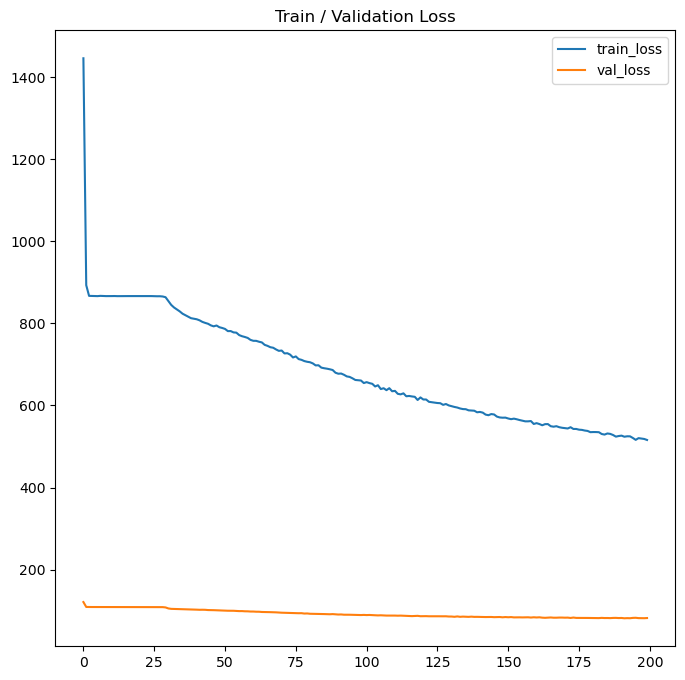

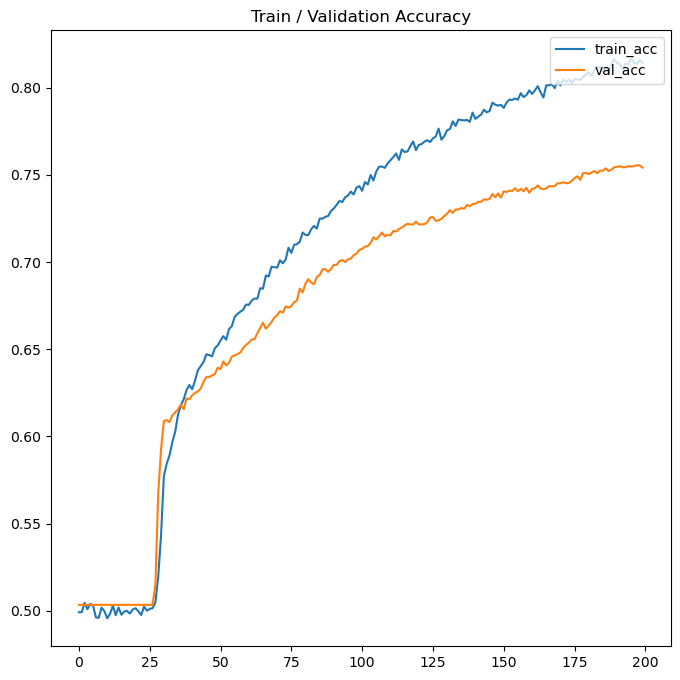

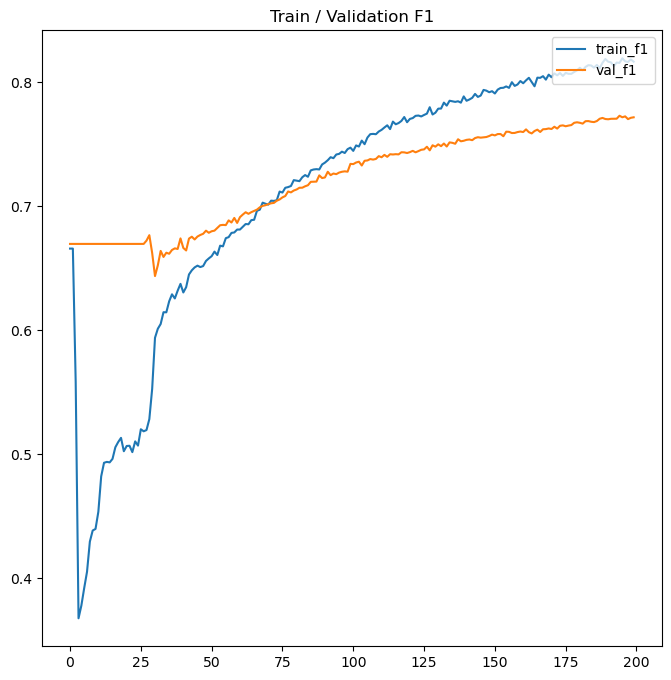

In [23]:
plot_results(history)

In [29]:
logits[0]

tensor([[[-1.5740,  1.0958],
         [-1.5888,  1.0360],
         [-1.5734,  0.9497],
         ...,
         [-1.6708,  1.0800],
         [-1.6437,  1.0921],
         [-1.6174,  1.0130]],

        [[-0.6128, -0.6130],
         [-0.5785, -0.7490],
         [-0.5567, -0.8384],
         ...,
         [-0.5725, -0.7833],
         [-0.7365, -0.5691],
         [-0.5788, -0.7879]],

        [[-0.9001, -0.0853],
         [-0.8991, -0.2101],
         [-0.9965, -0.1671],
         ...,
         [-0.9867, -0.1432],
         [-0.9633, -0.1112],
         [-0.8957, -0.2843]],

        ...,

        [[-0.5903, -0.6515],
         [-0.5728, -0.7735],
         [-0.6435, -0.7430],
         ...,
         [-0.6556, -0.5693],
         [-0.6867, -0.6535],
         [-0.5643, -0.8070]],

        [[-0.9125, -0.0621],
         [-0.9076, -0.1991],
         [-0.9209, -0.2840],
         ...,
         [-0.9258, -0.1608],
         [-1.0133, -0.1016],
         [-0.9073, -0.2667]],

        [[-1.5719,  1.0987],
       

In [30]:
test_loss = 0.0
test_preds = []
test_labels = []

bert.eval()
for step, batch in enumerate(tqdm(dataloader.get_split('test'), total=dataloader.steps('test'))):
    logits = bert(batch['input_ids'].to(device))[0]

    probs = F.softmax(logits[:, 0, :], dim=-1).cpu()
    pred = torch.argmax(probs, dim=-1) # (B)
    test_preds += pred.detach().tolist()
    test_labels += [l.item() for l in batch['label_ids']]

    loss = F.cross_entropy(logits[:, 0, :].cpu(), batch['label_ids'])

    test_loss += loss.item()

print()
print(f'Test loss: {test_loss / dataloader.steps("test")}')
print(f'Test acc: {accuracy_score(test_labels, test_preds)}')
print(f'Test f1: {f1_score(test_labels, test_preds)}')

782it [00:09, 85.72it/s]                                                                                               



Test loss: 0.526984153499066
Test acc: 0.75552
Test f1: 0.7719402985074627


# Interpreting and visualizing the results

In [31]:
def get_attention_scores(model, input_ids):
    """
    This is just a wrapper to easily access attention heads of the last layer
    """

    mask = (input_ids > 0).unsqueeze(1).repeat(1, input_ids.size(1), 1)

    embed = model.nano_bert.embedding(input_ids)

    # can be any layer, and we can also control what to do with output for each layer (aggregate, sum etc.)
    layer = model.nano_bert.encoder.layers[-1]

    x = layer.layer_norm1(embed)

    B, seq_len, n_embed = x.shape

    # if have more than 1 head, or interested in more than 1 head output just add aggregation here
    head = layer.self_attention.heads[0]

    # this is just a part of the single head that does all the computations (same code is present in AttentionHead)
    q = head.query(x)
    k = head.key(x)
    v = head.values(x)

    weights = (q @ k.transpose(-2, -1)) / math.sqrt(n_embed)  # (B, Seq_len, Seq_len)
    weights = weights.masked_fill(mask == 0, -1e9)  # mask out not attended tokens

    scores = F.softmax(weights, dim=-1)

    return scores

In [32]:
test_dataloader = IMDBDataloader(data, test_data, tokenizer, encode_label, batch_size=1)

Val Label Encoding: 100%|██████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 896333.72it/s]


In [33]:
def plot_parallel(matrix, tokens):
    # Set figsize
    plt.figure(figsize=(12, 8))

    input_len = len(tokens)

    # Vertical lines
    plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
    plt.axvline(x=5, color='black', linestyle='--', linewidth=1)

    # Add the A and B
    plt.text(1, input_len + 1, 'A', fontsize=12, color='black', fontweight='bold')
    plt.text(5, input_len + 1, 'B', fontsize=12, color='black', fontweight='bold')

    for i in range(input_len):
        for j in range(input_len):
            # Add the line to the plot
            plt.plot([1, 5], [i, j], marker='o', label='token', color='blue', linewidth=5 * matrix[i][j])

            plt.text(
                1 - 0.18,  # x-axis position
                i,  # y-axis position
                tokens[i],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color,
            )

            plt.text(
                5 + 0.06,  # x-axis position
                j,  # y-axis position
                tokens[j],  # Text
                fontsize=8,  # Text size
                color='black',  # Text color
            )
        break

    plt.title(f'Attention scores \n\n\n')

    plt.yticks([])  # Remove y-axis
    plt.box(False)  # Remove the bounding box around plot
    plt.show()  # Display the chart

In [34]:
# examples with less than 16 words are easier to visualize, so focus on them
examples_ids = []
for i, v in enumerate(test_dataloader.splits['test']):
    if len(v) <= 16:
        examples_ids.append(i)
print(examples_ids)

[1959, 2939, 6394, 15789, 16349, 21487, 22019, 24588]


In [39]:
tokens

['[CLS]',
 '[SOS]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '[UNK]',
 '.',
 '[SOS]',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]'

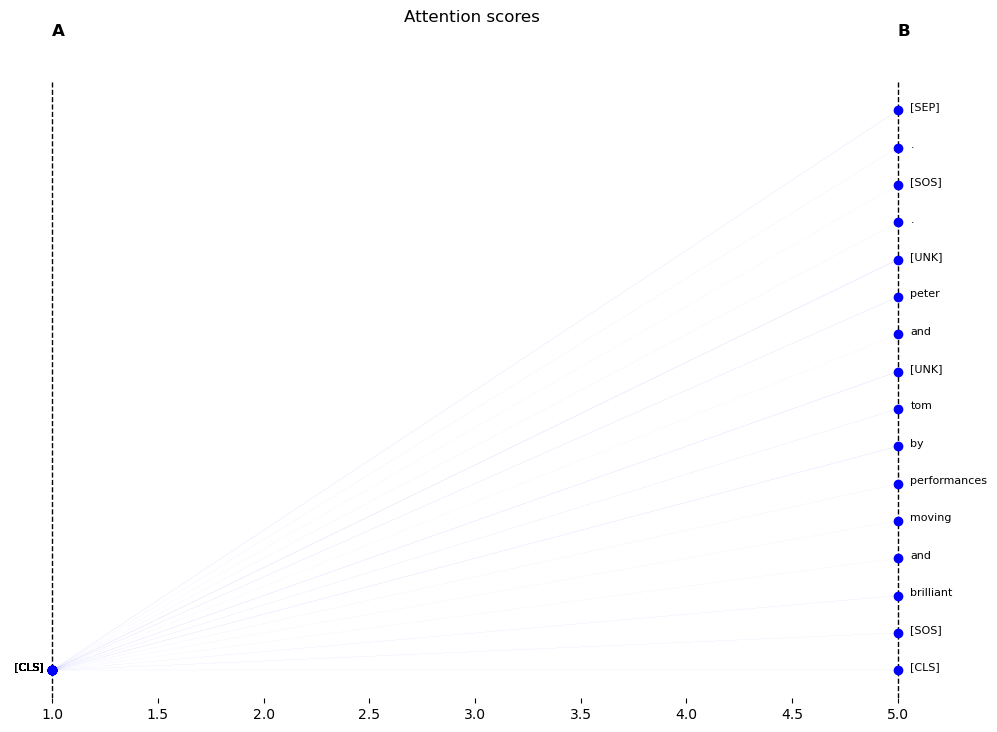

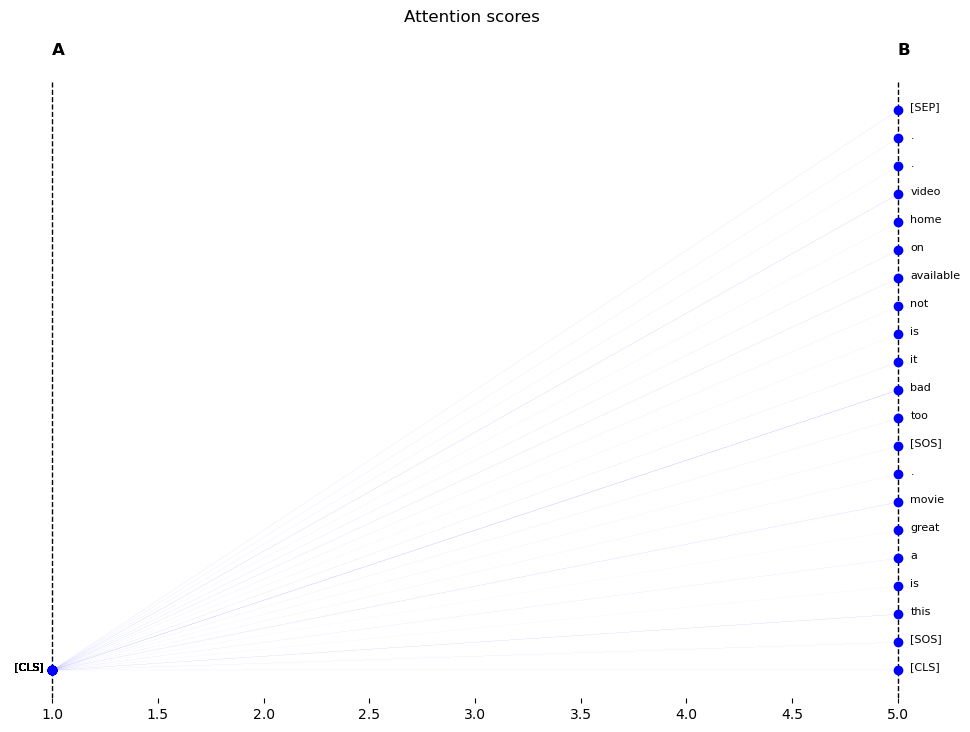

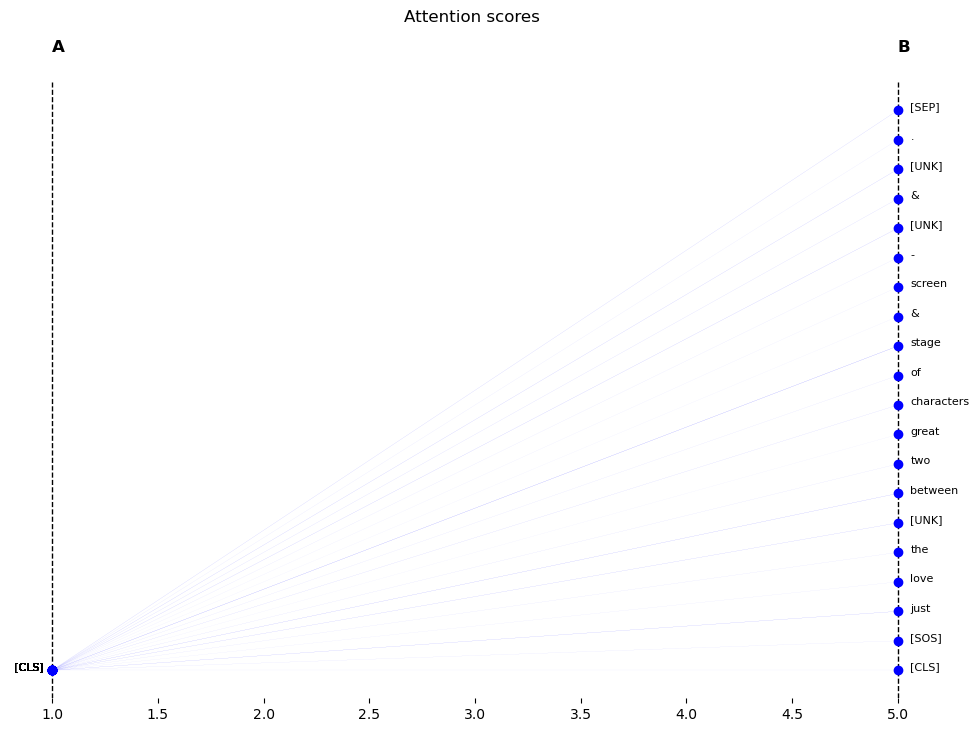

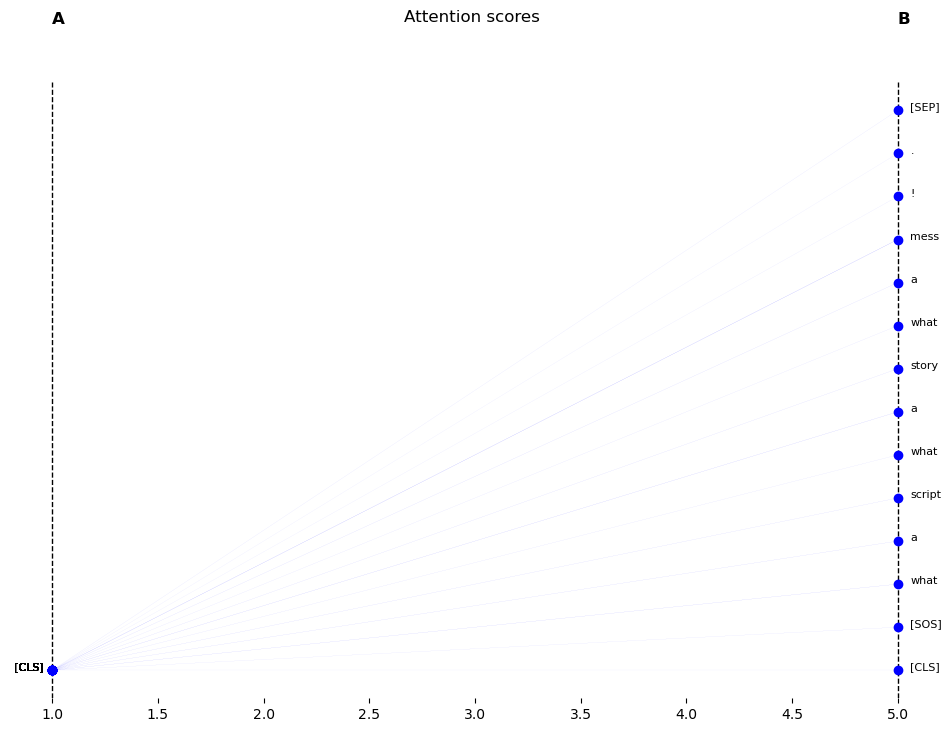

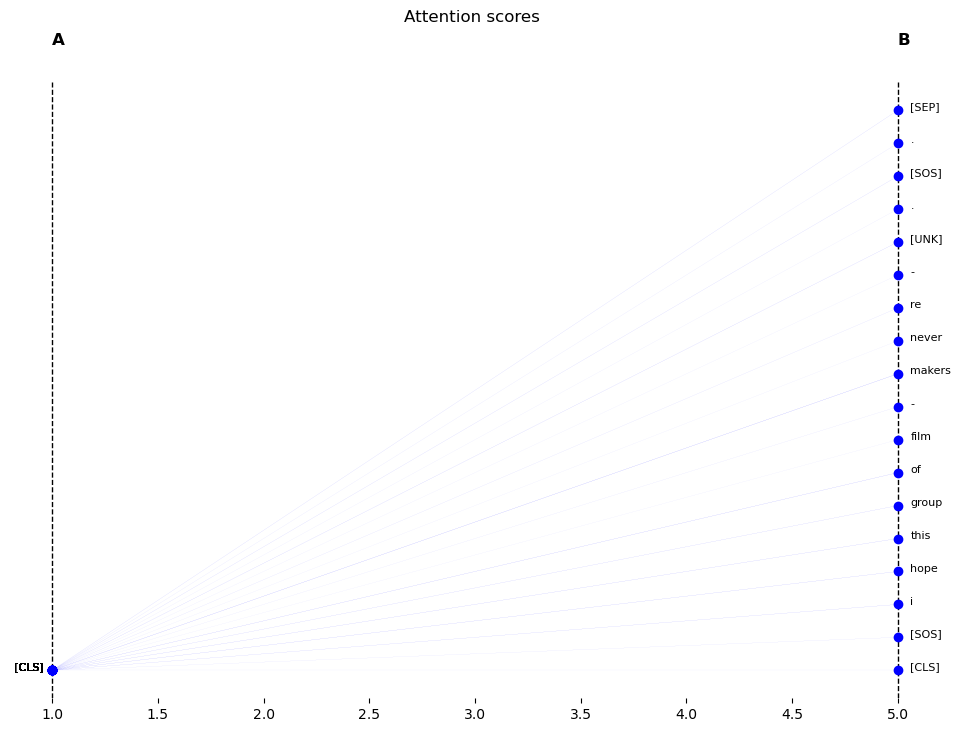

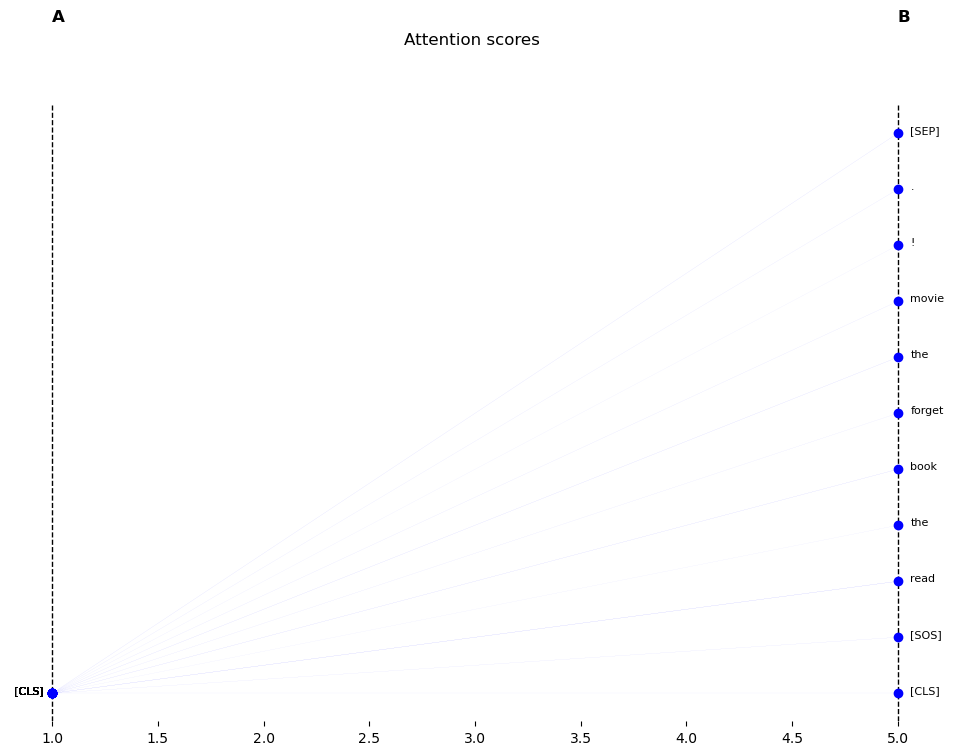

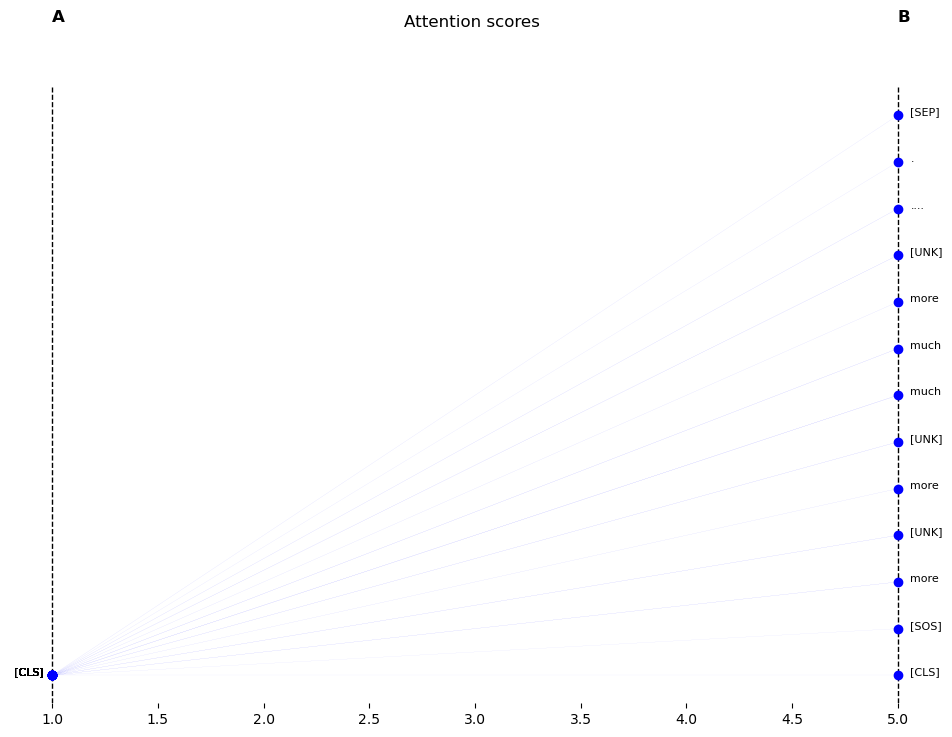

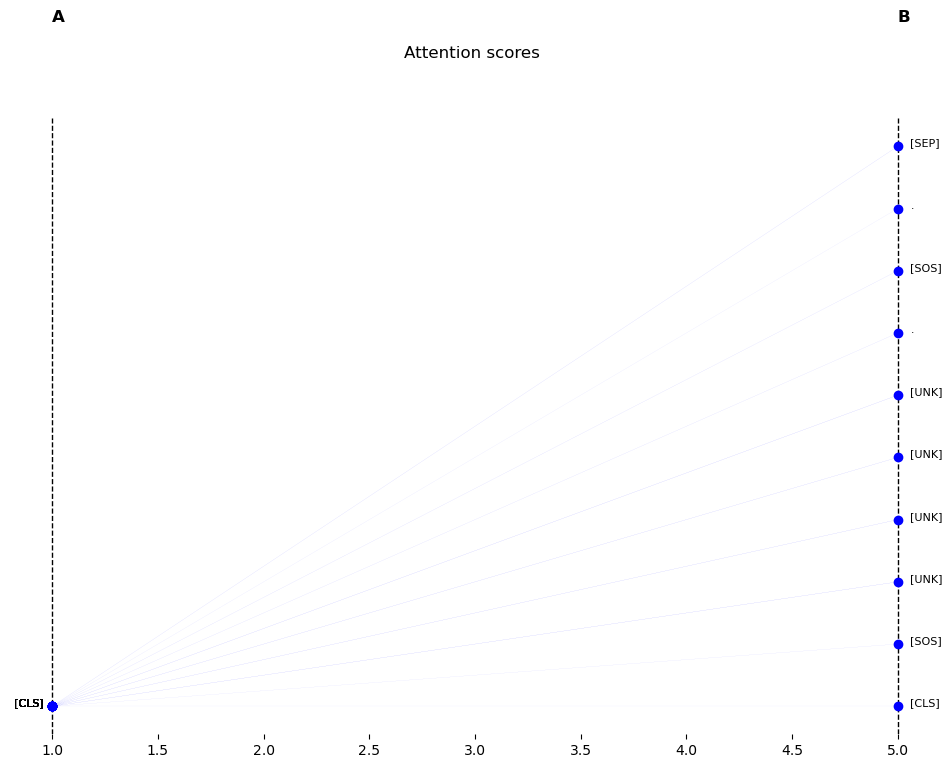

In [45]:
for sample_index in examples_ids:
    # extract example, decode to tokens and get the sequence length (ingoring padding)
    test_tokenized_batch = test_dataloader.peek_index_tokenized(index=sample_index, split='test')
    tokens = tokenizer.decode([t.item() for t in test_tokenized_batch['input_ids'][0] if (t != 0 and t.item() != 1)], ignore_special=False).split(' ')[:MAX_SEQ_LEN]
    seq_len = len(tokens)

    # calculate attention scores
    att_matrix = get_attention_scores(bert, test_tokenized_batch['input_ids'].to(device))[0, :seq_len, :seq_len]

    plot_parallel(att_matrix, tokens=tokens)